In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd


np.random.seed(2024)
n_tr = 1000
n_p = 1000

nI = 2
nX = 2
nO = 2
nS= 2
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 1
strength_conf = 1
strength_outcome = 1
binary_intervention=True

# Density estimation compared with npcausal

### Frengression + kernel density

In [9]:
df_tr = generate_data_causl(n=2000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
if binary_intervention:
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
else:
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)

y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=400, device=device, x_binary = binary_intervention)
model.train_xz(x_tr, z_tr, num_iters=5000, lr=1e-4, print_every_iter=800)
model.train_y(x_tr, z_tr, y_tr, num_iters=5000, lr=1e-4, print_every_iter=800)

Epoch 1: loss 2.6597, loss1 2.8056, loss2 0.2918
Epoch 800: loss 1.9702, loss1 3.9433, loss2 3.9462
Epoch 1600: loss 1.9711, loss1 3.9483, loss2 3.9545
Epoch 2400: loss 1.9750, loss1 3.9455, loss2 3.9410
Epoch 3200: loss 1.9867, loss1 3.9286, loss2 3.8839
Epoch 4000: loss 1.9729, loss1 3.9482, loss2 3.9507
Epoch 4800: loss 1.9912, loss1 3.9673, loss2 3.9522
Epoch 1: loss 2.4174,	loss_y 1.6530, 1.6664, 0.0268,	loss_eta 0.7643, 0.8040, 0.0793
Epoch 800: loss 1.3361,	loss_y 0.6590, 1.1942, 1.0704,	loss_eta 0.6771, 0.8495, 0.3446
Epoch 1600: loss 1.2554,	loss_y 0.5961, 1.0009, 0.8095,	loss_eta 0.6592, 1.0125, 0.7065
Epoch 2400: loss 1.0009,	loss_y 0.4574, 1.0870, 1.2592,	loss_eta 0.5435, 1.1422, 1.1975
Epoch 3200: loss 0.9603,	loss_y 0.4040, 0.7587, 0.7093,	loss_eta 0.5562, 1.2368, 1.3611
Epoch 4000: loss 1.0206,	loss_y 0.4274, 0.7765, 0.6983,	loss_eta 0.5933, 1.1952, 1.2038
Epoch 4800: loss 0.9495,	loss_y 0.4077, 0.8541, 0.8927,	loss_eta 0.5417, 1.1108, 1.1381


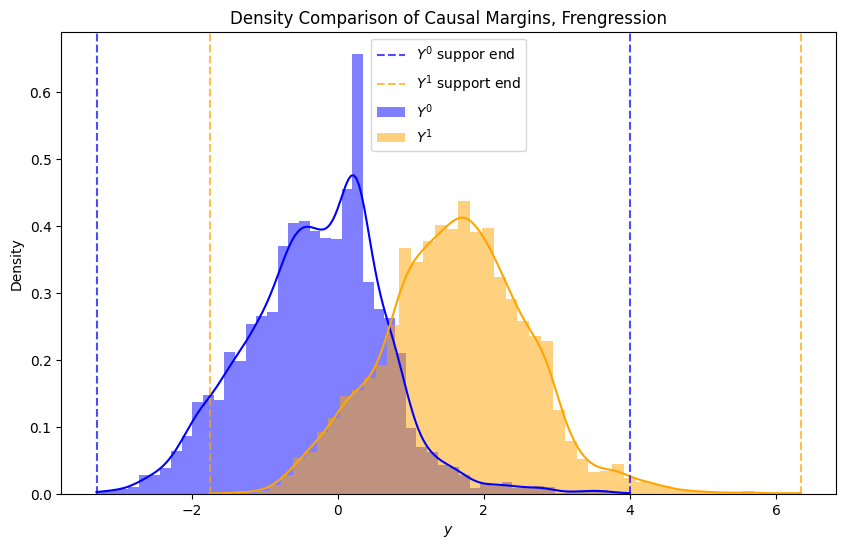

In [12]:
# Sample causal margins
x0_samples = model.sample_causal_margin(x=torch.tensor([0.]), sample_size=5000).numpy().flatten()
x1_samples = model.sample_causal_margin(x=torch.tensor([1.]), sample_size=5000).numpy().flatten()

# Plot histograms and KDE
plt.figure(figsize=(10, 6))

# Histogram for x0_samples
sns.histplot(x0_samples, kde=True, color='blue', label='$Y^0$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Histogram for x1_samples
sns.histplot(x1_samples, kde=True, color='orange', label='$Y^1$', stat="density", bins=50, edgecolor=None, alpha=0.5)

# Highlight different supports (if needed)
plt.axvline(min(x0_samples), color='blue', linestyle='--', alpha=0.7, label='$Y^0$ suppor end')
plt.axvline(max(x0_samples), color='blue', linestyle='--', alpha=0.7)
plt.axvline(min(x1_samples), color='orange', linestyle='--', alpha=0.7, label='$Y^1$ support end')
plt.axvline(max(x1_samples), color='orange', linestyle='--', alpha=0.7)

# Add labels, legend, and title
plt.xlabel("$y$")
plt.ylabel("Density")
plt.title("Density Comparison of Causal Margins, Frengression")
plt.legend()
plt.show()


### npcausal

In [2]:
# Assume g1, g0, and support are provided
df_tr = generate_data_causl(n=1000, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)
# Example data
support1 = np.linspace(-2, 4,100)/6  # Replace with actual support values
support0 = np.linspace(-4, 2,100)/6
support = np.linspace(-4,4,200)

g1,_ =npcausal_cdensity(y=df_tr['y'].values, x=df_tr['A'].values, z = df_tr[[f"X{i}" for i in range(1, p + 1)]].values, y_grid=support1)
_,g0 =npcausal_cdensity(y=df_tr['y'].values, x=df_tr['A'].values, z = df_tr[[f"X{i}" for i in range(1, p + 1)]].values, y_grid=support0)
# Plot densities
g1 /=6
g0 /=6

 num [1:1000] -0.69027 1.76837 -0.62964 0.00972 2.88283 ...
R y: <rpy2.rinterface_lib.sexp.NULLType object at 0x33b299d10> [0]
 num [1:1000] 0 1 0 0 1 0 1 0 0 1 ...
R x: <rpy2.rinterface_lib.sexp.NULLType object at 0x33b299d10> [0]
 num [1:1000, 1:7] 0.0611 0.9155 -0.0963 -0.8646 0.7818 ...
R z: <rpy2.rinterface_lib.sexp.NULLType object at 0x33b299d10> [0]
[1] "fold: 1"
[1] "    estimating propensity scores..."
[1] "    estimating outcome regressions..."
[1] "    estimating conditional densities..."
[1] "    estimating density regressions..."
[1] "fold: 2"
[1] "    estimating propensity scores..."
[1] "    estimating outcome regressions..."
[1] "    estimating conditional densities..."
[1] "    estimating density regressions..."
    parameter      est        se   ci.ll    ci.ul
1 L2 distance 4.325514 0.2158539 3.90244 4.748587
 num [1:1000] -0.69027 1.76837 -0.62964 0.00972 2.88283 ...
R y: <rpy2.rinterface_lib.sexp.NULLType object at 0x33b299d10> [0]
 num [1:1000] 0 1 0 0 1 0 1 0 0 1 

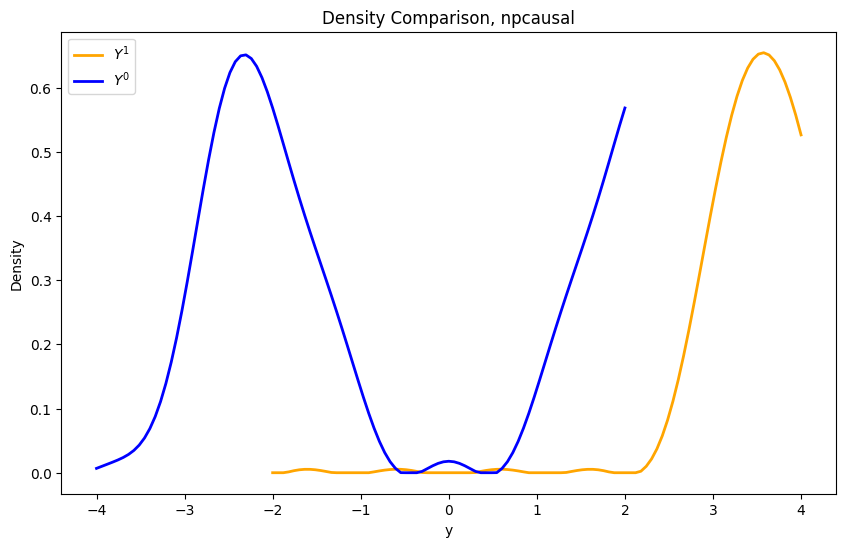

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(support1*6, g1, label="$Y^1$", color="orange", linewidth=2)
plt.plot(support0*6, g0, label="$Y^0$", color="blue", linewidth=2)

# # Highlight support regions
# plt.fill_between(support1, g1, alpha=0.2, color="blue", label="Support g1")
# plt.fill_between(support0, g0, alpha=0.2, color="orange", label="Support g0")

# Add labels, legend, and title
plt.xlabel("y")
plt.ylabel("Density")
plt.title("Density Comparison, npcausal")
plt.legend()
plt.show()

# Evaluate Y|do(X)
We mainly compare causal margin under binary treatments. P0, P1 store Ys sampled from fitted frengression under control and treatment, respectively. Q0, Q1 store Ys sampled from true Y|do(X) under control and treatment, respectively.

## Binary treatment

### Investigation on increasing num_iters

In [ ]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []

P1_list = []
Q1_list = []

P_joint_list = []
Q_joint_list = []

tracker = {iteration: {"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []}
           for iteration in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}
# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    Q0_list.append(Q0)
    Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_

        # Log results
        tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[iteration]["logreg_coeffs_q"].append(logreg_coeffs_q)
    P0_list.append(P0)
    P1_list.append(P1)
    P_joint_list.append(P_joint)

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 0.9733, loss1 1.0035, loss2 0.0603
Epoch 100: loss 0.6833, loss1 1.3142, loss2 1.2616
Epoch 200: loss 0.7198, loss1 1.3795, loss2 1.3194
Epoch 300: loss 0.6960, loss1 1.3686, loss2 1.3452
Epoch 400: loss 0.6979, loss1 1.3704, loss2 1.3450
Epoch 500: loss 0.6677, loss1 1.3532, loss2 1.3710
Epoch 1: loss 2.1920,	loss_y 1.3924, 1.4159, 0.0470,	loss_eta 0.7996, 0.8260, 0.0528
Epoch 100: loss 1.1985,	loss_y 0.5756, 1.5470, 1.9430,	loss_eta 0.6229, 1.0340, 0.8223
Epoch 200: loss 1.4829,	loss_y 0.6595, 1.0873, 0.8555,	loss_eta 0.8234, 1.0199, 0.3930
Epoch 300: loss 1.5247,	loss_y 0.8557, 1.9076, 2.1038,	loss_eta 0.6690, 0.8504, 0.3629
Epoch 400: loss 1.9310,	loss_y 1.3493, 2.0334, 1.3682,	loss_eta 0.5817, 1.3123, 1.4612
Epoch 500: loss 1.6121,	loss_y 1.0480, 2.1163, 2.1367,	loss_eta 0.5642, 0.9468, 0.7654
Epoch 1: loss 0.6741, loss1 1.3663, loss2 1.3845
Epoch 100: loss 0.6786, loss1 1.3106, loss2 1.2640
Epoch 200: loss 0.6805, loss1 1.3541, loss2 1.3472
Epoch 300: loss 0.6951, l

  3%|▎         | 1/30 [01:19<38:26, 79.53s/it]

Epoch 500: loss 1.1201,	loss_y 0.5208, 0.9899, 0.9382,	loss_eta 0.5993, 1.1253, 1.0520
Epoch 1: loss 0.9805, loss1 1.0131, loss2 0.0652
Epoch 100: loss 0.6899, loss1 1.3463, loss2 1.3128
Epoch 200: loss 0.6658, loss1 1.3244, loss2 1.3172
Epoch 300: loss 0.6995, loss1 1.3622, loss2 1.3255
Epoch 400: loss 0.6857, loss1 1.3662, loss2 1.3610
Epoch 500: loss 0.6990, loss1 1.3627, loss2 1.3274
Epoch 1: loss 2.3736,	loss_y 1.6038, 1.6443, 0.0809,	loss_eta 0.7698, 0.8132, 0.0868
Epoch 100: loss 1.1603,	loss_y 0.5738, 1.7217, 2.2958,	loss_eta 0.5865, 0.8966, 0.6202
Epoch 200: loss 1.3739,	loss_y 0.6246, 0.9565, 0.6639,	loss_eta 0.7494, 1.1023, 0.7058
Epoch 300: loss 1.4529,	loss_y 0.7625, 1.5250, 1.5250,	loss_eta 0.6904, 1.2486, 1.1164
Epoch 400: loss 1.4264,	loss_y 0.8387, 2.0723, 2.4672,	loss_eta 0.5877, 1.0754, 0.9754
Epoch 500: loss 1.6622,	loss_y 1.1058, 1.7435, 1.2755,	loss_eta 0.5564, 1.0790, 1.0452
Epoch 1: loss 0.6637, loss1 1.3383, loss2 1.3493
Epoch 100: loss 0.6680, loss1 1.3749, lo

  7%|▋         | 2/30 [02:25<33:15, 71.28s/it]

Epoch 500: loss 1.1169,	loss_y 0.5164, 0.9837, 0.9345,	loss_eta 0.6005, 1.2139, 1.2269
Epoch 1: loss 0.9608, loss1 1.0010, loss2 0.0804
Epoch 100: loss 0.6680, loss1 1.3224, loss2 1.3089
Epoch 200: loss 0.6408, loss1 1.3115, loss2 1.3415
Epoch 300: loss 0.6573, loss1 1.3468, loss2 1.3790
Epoch 400: loss 0.6851, loss1 1.3838, loss2 1.3975
Epoch 500: loss 0.6708, loss1 1.2936, loss2 1.2456
Epoch 1: loss 2.2704,	loss_y 1.4694, 1.4832, 0.0277,	loss_eta 0.8010, 0.8202, 0.0383
Epoch 100: loss 1.3230,	loss_y 0.6906, 1.8493, 2.3176,	loss_eta 0.6325, 1.1025, 0.9399
Epoch 200: loss 1.5483,	loss_y 0.7310, 1.0226, 0.5833,	loss_eta 0.8174, 0.9497, 0.2647
Epoch 300: loss 1.2930,	loss_y 0.6540, 1.3235, 1.3391,	loss_eta 0.6390, 0.9092, 0.5404
Epoch 400: loss 1.6874,	loss_y 1.1124, 2.2135, 2.2022,	loss_eta 0.5749, 1.1230, 1.0961
Epoch 500: loss 1.6555,	loss_y 1.1014, 1.5726, 0.9425,	loss_eta 0.5541, 1.0644, 1.0206
Epoch 1: loss 0.6771, loss1 1.3249, loss2 1.2956
Epoch 100: loss 0.6445, loss1 1.3208, lo

 10%|█         | 3/30 [03:30<30:50, 68.55s/it]

Epoch 500: loss 1.0703,	loss_y 0.5202, 0.9787, 0.9171,	loss_eta 0.5501, 1.0788, 1.0575
Epoch 1: loss 0.9673, loss1 0.9959, loss2 0.0573
Epoch 100: loss 0.6984, loss1 1.3529, loss2 1.3090
Epoch 200: loss 0.7020, loss1 1.3539, loss2 1.3037
Epoch 300: loss 0.6705, loss1 1.3248, loss2 1.3085
Epoch 400: loss 0.6907, loss1 1.3438, loss2 1.3061
Epoch 500: loss 0.6787, loss1 1.3600, loss2 1.3626
Epoch 1: loss 2.3506,	loss_y 1.5350, 1.5591, 0.0483,	loss_eta 0.8156, 0.8522, 0.0731
Epoch 100: loss 1.2268,	loss_y 0.6656, 1.7053, 2.0793,	loss_eta 0.5611, 1.0001, 0.8780
Epoch 200: loss 1.2299,	loss_y 0.5701, 0.8886, 0.6370,	loss_eta 0.6598, 0.8592, 0.3989
Epoch 300: loss 1.2921,	loss_y 0.7371, 1.6929, 1.9116,	loss_eta 0.5550, 1.1765, 1.2429
Epoch 400: loss 1.2294,	loss_y 0.6265, 1.1400, 1.0270,	loss_eta 0.6029, 1.1559, 1.1060
Epoch 500: loss 1.2959,	loss_y 0.6070, 1.0920, 0.9701,	loss_eta 0.6889, 1.0090, 0.6401
Epoch 1: loss 0.6418, loss1 1.3211, loss2 1.3588
Epoch 100: loss 0.6941, loss1 1.3737, lo

 13%|█▎        | 4/30 [04:35<29:03, 67.08s/it]

Epoch 500: loss 1.0527,	loss_y 0.4763, 0.9839, 1.0152,	loss_eta 0.5764, 1.1475, 1.1423
Epoch 1: loss 0.9612, loss1 1.0030, loss2 0.0835
Epoch 100: loss 0.7166, loss1 1.3608, loss2 1.2884
Epoch 200: loss 0.6746, loss1 1.3761, loss2 1.4030
Epoch 300: loss 0.7242, loss1 1.3484, loss2 1.2484
Epoch 400: loss 0.6857, loss1 1.3384, loss2 1.3055
Epoch 500: loss 0.6568, loss1 1.3529, loss2 1.3924
Epoch 1: loss 2.2406,	loss_y 1.4312, 1.4508, 0.0392,	loss_eta 0.8094, 0.8436, 0.0685
Epoch 100: loss 1.2428,	loss_y 0.6315, 1.7366, 2.2102,	loss_eta 0.6113, 0.9437, 0.6647
Epoch 200: loss 1.4137,	loss_y 0.8192, 1.2058, 0.7731,	loss_eta 0.5945, 1.0862, 0.9835
Epoch 300: loss 1.5293,	loss_y 0.8842, 1.6314, 1.4944,	loss_eta 0.6451, 1.2564, 1.2225
Epoch 400: loss 1.7437,	loss_y 1.1780, 1.3942, 0.4324,	loss_eta 0.5657, 0.9447, 0.7580
Epoch 500: loss 1.6286,	loss_y 0.9901, 1.0907, 0.2012,	loss_eta 0.6385, 1.1859, 1.0948
Epoch 1: loss 0.6731, loss1 1.3582, loss2 1.3701
Epoch 100: loss 0.6822, loss1 1.3482, lo

 17%|█▋        | 5/30 [05:39<27:33, 66.16s/it]

Epoch 500: loss 1.0904,	loss_y 0.5100, 0.9726, 0.9252,	loss_eta 0.5804, 1.1282, 1.0957
Epoch 1: loss 0.9632, loss1 0.9959, loss2 0.0654
Epoch 100: loss 0.6774, loss1 1.3282, loss2 1.3016
Epoch 200: loss 0.6804, loss1 1.3187, loss2 1.2766
Epoch 300: loss 0.6553, loss1 1.3324, loss2 1.3541
Epoch 400: loss 0.7051, loss1 1.3316, loss2 1.2531
Epoch 500: loss 0.6698, loss1 1.3402, loss2 1.3409
Epoch 1: loss 2.3728,	loss_y 1.5785, 1.5868, 0.0166,	loss_eta 0.7942, 0.8274, 0.0663
Epoch 100: loss 1.2613,	loss_y 0.6192, 0.9196, 0.6009,	loss_eta 0.6421, 1.0350, 0.7856
Epoch 200: loss 1.9599,	loss_y 1.3445, 1.6872, 0.6855,	loss_eta 0.6154, 0.9915, 0.7522
Epoch 300: loss 1.6880,	loss_y 1.0886, 1.8591, 1.5410,	loss_eta 0.5994, 0.9255, 0.6522
Epoch 400: loss 1.3991,	loss_y 0.7335, 1.2694, 1.0718,	loss_eta 0.6656, 1.6092, 1.8873
Epoch 500: loss 1.2290,	loss_y 0.6561, 1.3829, 1.4537,	loss_eta 0.5729, 1.6208, 2.0956
Epoch 1: loss 0.6826, loss1 1.3662, loss2 1.3671
Epoch 100: loss 0.6880, loss1 1.3418, lo

 20%|██        | 6/30 [06:45<26:24, 66.02s/it]

Epoch 500: loss 1.0657,	loss_y 0.5011, 1.0434, 1.0845,	loss_eta 0.5646, 1.1637, 1.1983
Epoch 1: loss 1.0174, loss1 1.0606, loss2 0.0865
Epoch 100: loss 0.6879, loss1 1.3762, loss2 1.3766
Epoch 200: loss 0.7799, loss1 1.4608, loss2 1.3617
Epoch 300: loss 0.6830, loss1 1.3963, loss2 1.4268
Epoch 400: loss 0.7143, loss1 1.3834, loss2 1.3382
Epoch 500: loss 0.7241, loss1 1.4300, loss2 1.4118
Epoch 1: loss 2.2324,	loss_y 1.4956, 1.5190, 0.0468,	loss_eta 0.7368, 0.7832, 0.0929
Epoch 100: loss 1.3491,	loss_y 0.6814, 1.6400, 1.9170,	loss_eta 0.6677, 1.1061, 0.8769
Epoch 200: loss 1.1933,	loss_y 0.5268, 1.1093, 1.1650,	loss_eta 0.6664, 0.8422, 0.3515
Epoch 300: loss 1.2497,	loss_y 0.6689, 1.2577, 1.1776,	loss_eta 0.5808, 0.9647, 0.7677
Epoch 400: loss 1.2253,	loss_y 0.6770, 1.0069, 0.6598,	loss_eta 0.5483, 1.0374, 0.9782
Epoch 500: loss 1.4038,	loss_y 0.7585, 1.4008, 1.2846,	loss_eta 0.6453, 1.0867, 0.8827
Epoch 1: loss 0.7149, loss1 1.4044, loss2 1.3790
Epoch 100: loss 0.7091, loss1 1.4159, lo

 23%|██▎       | 7/30 [07:50<25:10, 65.68s/it]

Epoch 500: loss 1.0341,	loss_y 0.5049, 0.9979, 0.9860,	loss_eta 0.5292, 1.1238, 1.1891
Epoch 1: loss 0.9868, loss1 1.0203, loss2 0.0671
Epoch 100: loss 0.7059, loss1 1.3590, loss2 1.3062
Epoch 200: loss 0.7155, loss1 1.3907, loss2 1.3503
Epoch 300: loss 0.6873, loss1 1.3666, loss2 1.3585
Epoch 400: loss 0.6798, loss1 1.3634, loss2 1.3671
Epoch 500: loss 0.6969, loss1 1.3835, loss2 1.3731
Epoch 1: loss 2.2196,	loss_y 1.4384, 1.4841, 0.0914,	loss_eta 0.7812, 0.8279, 0.0933
Epoch 100: loss 1.2485,	loss_y 0.6574, 1.6796, 2.0443,	loss_eta 0.5911, 0.9474, 0.7126
Epoch 200: loss 1.1350,	loss_y 0.5098, 0.9103, 0.8011,	loss_eta 0.6253, 1.0140, 0.7775
Epoch 300: loss 1.2378,	loss_y 0.6403, 1.2779, 1.2753,	loss_eta 0.5976, 1.1933, 1.1914
Epoch 400: loss 1.4086,	loss_y 0.7522, 0.8943, 0.2842,	loss_eta 0.6564, 1.0934, 0.8742
Epoch 500: loss 1.5263,	loss_y 0.8969, 2.3939, 2.9939,	loss_eta 0.6294, 1.5676, 1.8765
Epoch 1: loss 0.6992, loss1 1.3684, loss2 1.3385
Epoch 100: loss 0.7027, loss1 1.3732, lo

 27%|██▋       | 8/30 [08:54<23:57, 65.33s/it]

Epoch 500: loss 1.0121,	loss_y 0.4697, 0.9630, 0.9866,	loss_eta 0.5424, 1.1278, 1.1708
Epoch 1: loss 0.9495, loss1 1.0071, loss2 0.1152
Epoch 100: loss 0.6711, loss1 1.3155, loss2 1.2889
Epoch 200: loss 0.6702, loss1 1.3415, loss2 1.3424
Epoch 300: loss 0.6819, loss1 1.3657, loss2 1.3675
Epoch 400: loss 0.6760, loss1 1.3240, loss2 1.2962
Epoch 500: loss 0.6861, loss1 1.3624, loss2 1.3525
Epoch 1: loss 2.1692,	loss_y 1.3790, 1.3892, 0.0206,	loss_eta 0.7903, 0.8171, 0.0537
Epoch 100: loss 1.1417,	loss_y 0.5646, 0.9515, 0.7737,	loss_eta 0.5770, 1.1168, 1.0796
Epoch 200: loss 1.3399,	loss_y 0.6378, 1.4118, 1.5479,	loss_eta 0.7021, 0.8580, 0.3117
Epoch 300: loss 1.2327,	loss_y 0.5451, 1.1684, 1.2465,	loss_eta 0.6876, 0.8757, 0.3763
Epoch 400: loss 1.3813,	loss_y 0.6951, 1.4031, 1.4159,	loss_eta 0.6862, 0.9486, 0.5249
Epoch 500: loss 1.5797,	loss_y 0.8907, 1.2145, 0.6475,	loss_eta 0.6889, 0.8500, 0.3222
Epoch 1: loss 0.6671, loss1 1.3610, loss2 1.3878
Epoch 100: loss 0.6644, loss1 1.3292, lo

 30%|███       | 9/30 [09:59<22:45, 65.05s/it]

Epoch 500: loss 1.0773,	loss_y 0.4880, 1.0372, 1.0984,	loss_eta 0.5893, 1.1974, 1.2161
Epoch 1: loss 0.9832, loss1 1.0176, loss2 0.0687
Epoch 100: loss 0.7120, loss1 1.3808, loss2 1.3375
Epoch 200: loss 0.6801, loss1 1.3405, loss2 1.3207
Epoch 300: loss 0.6850, loss1 1.3894, loss2 1.4087
Epoch 400: loss 0.7033, loss1 1.3718, loss2 1.3370
Epoch 500: loss 0.6679, loss1 1.3352, loss2 1.3346
Epoch 1: loss 2.3228,	loss_y 1.5487, 1.5841, 0.0707,	loss_eta 0.7741, 0.8000, 0.0518
Epoch 100: loss 1.4184,	loss_y 0.8628, 2.0884, 2.4512,	loss_eta 0.5556, 0.9967, 0.8822
Epoch 200: loss 1.3406,	loss_y 0.7869, 1.1909, 0.8079,	loss_eta 0.5537, 1.0811, 1.0548
Epoch 300: loss 1.3275,	loss_y 0.7118, 1.6960, 1.9684,	loss_eta 0.6157, 1.0332, 0.8350
Epoch 400: loss 1.4604,	loss_y 0.7066, 1.5876, 1.7620,	loss_eta 0.7538, 1.2541, 1.0005
Epoch 500: loss 1.2149,	loss_y 0.6279, 0.8755, 0.4952,	loss_eta 0.5870, 1.0058, 0.8377
Epoch 1: loss 0.7009, loss1 1.3908, loss2 1.3799
Epoch 100: loss 0.6675, loss1 1.3519, lo

 33%|███▎      | 10/30 [11:04<21:38, 64.93s/it]

Epoch 500: loss 1.0842,	loss_y 0.5346, 1.0537, 1.0382,	loss_eta 0.5496, 1.0856, 1.0721
Epoch 1: loss 0.9864, loss1 1.0181, loss2 0.0634
Epoch 100: loss 0.7207, loss1 1.3481, loss2 1.2548
Epoch 200: loss 0.7037, loss1 1.3476, loss2 1.2877
Epoch 300: loss 0.6726, loss1 1.3589, loss2 1.3727
Epoch 400: loss 0.6528, loss1 1.3377, loss2 1.3699
Epoch 500: loss 0.7082, loss1 1.3914, loss2 1.3665
Epoch 1: loss 2.2732,	loss_y 1.5456, 1.5624, 0.0335,	loss_eta 0.7276, 0.7623, 0.0695
Epoch 100: loss 1.2295,	loss_y 0.6700, 1.7704, 2.2007,	loss_eta 0.5595, 0.9013, 0.6836
Epoch 200: loss 1.3792,	loss_y 0.5988, 0.9640, 0.7304,	loss_eta 0.7804, 0.9393, 0.3180
Epoch 300: loss 1.1722,	loss_y 0.5643, 1.0991, 1.0696,	loss_eta 0.6079, 0.9673, 0.7189
Epoch 400: loss 1.5573,	loss_y 0.9944, 1.7002, 1.4115,	loss_eta 0.5628, 1.2251, 1.3246
Epoch 500: loss 1.6437,	loss_y 0.8713, 1.9648, 2.1868,	loss_eta 0.7724, 0.8556, 0.1664
Epoch 1: loss 0.7024, loss1 1.3639, loss2 1.3231
Epoch 100: loss 0.7180, loss1 1.3823, lo

 37%|███▋      | 11/30 [12:08<20:28, 64.65s/it]

Epoch 500: loss 1.0396,	loss_y 0.4827, 0.9973, 1.0292,	loss_eta 0.5569, 1.1520, 1.1902
Epoch 1: loss 0.9821, loss1 1.0291, loss2 0.0940
Epoch 100: loss 0.7053, loss1 1.3864, loss2 1.3622
Epoch 200: loss 0.6847, loss1 1.3845, loss2 1.3995
Epoch 300: loss 0.7072, loss1 1.4103, loss2 1.4063
Epoch 400: loss 0.7216, loss1 1.3812, loss2 1.3191
Epoch 500: loss 0.6983, loss1 1.3495, loss2 1.3024
Epoch 1: loss 2.2439,	loss_y 1.4769, 1.4868, 0.0199,	loss_eta 0.7670, 0.8096, 0.0851
Epoch 100: loss 1.2018,	loss_y 0.6012, 1.5016, 1.8008,	loss_eta 0.6006, 1.2756, 1.3500
Epoch 200: loss 1.4269,	loss_y 0.6365, 1.1767, 1.0806,	loss_eta 0.7905, 0.8773, 0.1736
Epoch 300: loss 1.2062,	loss_y 0.5432, 1.1022, 1.1179,	loss_eta 0.6630, 0.8061, 0.2862
Epoch 400: loss 1.5503,	loss_y 0.8960, 1.5656, 1.3393,	loss_eta 0.6543, 1.1092, 0.9098
Epoch 500: loss 1.5263,	loss_y 0.8792, 1.9757, 2.1930,	loss_eta 0.6471, 1.1663, 1.0384
Epoch 1: loss 0.6698, loss1 1.3734, loss2 1.4073
Epoch 100: loss 0.6756, loss1 1.3561, lo

 40%|████      | 12/30 [13:11<19:18, 64.35s/it]

Epoch 500: loss 1.0461,	loss_y 0.5072, 1.0524, 1.0903,	loss_eta 0.5388, 1.1337, 1.1897
Epoch 1: loss 0.9691, loss1 1.0091, loss2 0.0800
Epoch 100: loss 0.7364, loss1 1.3638, loss2 1.2547
Epoch 200: loss 0.6772, loss1 1.3374, loss2 1.3205
Epoch 300: loss 0.6391, loss1 1.3105, loss2 1.3428
Epoch 400: loss 0.6663, loss1 1.3451, loss2 1.3576
Epoch 500: loss 0.6530, loss1 1.3752, loss2 1.4445
Epoch 1: loss 2.3102,	loss_y 1.5030, 1.5193, 0.0325,	loss_eta 0.8072, 0.8275, 0.0407
Epoch 100: loss 1.3187,	loss_y 0.7509, 1.8391, 2.1764,	loss_eta 0.5678, 0.9272, 0.7187
Epoch 200: loss 1.3796,	loss_y 0.6036, 1.0416, 0.8759,	loss_eta 0.7760, 0.8601, 0.1683
Epoch 300: loss 1.6745,	loss_y 0.9209, 1.7218, 1.6018,	loss_eta 0.7536, 0.9142, 0.3211
Epoch 400: loss 1.6478,	loss_y 1.0113, 1.6956, 1.3686,	loss_eta 0.6365, 0.9101, 0.5472
Epoch 500: loss 1.6550,	loss_y 1.0671, 2.1693, 2.2043,	loss_eta 0.5879, 1.2328, 1.2899
Epoch 1: loss 0.6767, loss1 1.3897, loss2 1.4261
Epoch 100: loss 0.6870, loss1 1.3795, lo

 43%|████▎     | 13/30 [14:16<18:15, 64.44s/it]

Epoch 500: loss 1.0798,	loss_y 0.5322, 1.0335, 1.0026,	loss_eta 0.5476, 1.0763, 1.0573
Epoch 1: loss 0.9989, loss1 1.0189, loss2 0.0401
Epoch 100: loss 0.7082, loss1 1.3627, loss2 1.3091
Epoch 200: loss 0.6927, loss1 1.3478, loss2 1.3103
Epoch 300: loss 0.7274, loss1 1.3907, loss2 1.3266
Epoch 400: loss 0.7207, loss1 1.3999, loss2 1.3585
Epoch 500: loss 0.6771, loss1 1.3843, loss2 1.4142
Epoch 1: loss 2.1931,	loss_y 1.4516, 1.4731, 0.0430,	loss_eta 0.7415, 0.7786, 0.0741
Epoch 100: loss 1.2493,	loss_y 0.6390, 1.5838, 1.8896,	loss_eta 0.6102, 0.9242, 0.6279
Epoch 200: loss 1.1118,	loss_y 0.5410, 0.8818, 0.6816,	loss_eta 0.5708, 0.9215, 0.7015
Epoch 300: loss 1.6294,	loss_y 1.0667, 2.2539, 2.3743,	loss_eta 0.5627, 1.3034, 1.4814
Epoch 400: loss 1.4994,	loss_y 0.8241, 1.2006, 0.7529,	loss_eta 0.6753, 1.0161, 0.6815
Epoch 500: loss 1.4271,	loss_y 0.6692, 1.5110, 1.6836,	loss_eta 0.7579, 1.0218, 0.5279
Epoch 1: loss 0.6914, loss1 1.3524, loss2 1.3220
Epoch 100: loss 0.6801, loss1 1.3525, lo

 47%|████▋     | 14/30 [15:20<17:08, 64.30s/it]

Epoch 500: loss 1.0380,	loss_y 0.4906, 1.0057, 1.0302,	loss_eta 0.5474, 1.1727, 1.2507
Epoch 1: loss 0.9645, loss1 0.9888, loss2 0.0487
Epoch 100: loss 0.6637, loss1 1.3280, loss2 1.3285
Epoch 200: loss 0.6739, loss1 1.3538, loss2 1.3599
Epoch 300: loss 0.6522, loss1 1.3407, loss2 1.3771
Epoch 400: loss 0.7017, loss1 1.3500, loss2 1.2967
Epoch 500: loss 0.6482, loss1 1.2886, loss2 1.2807
Epoch 1: loss 2.1848,	loss_y 1.4595, 1.4697, 0.0204,	loss_eta 0.7253, 0.7561, 0.0615
Epoch 100: loss 1.2171,	loss_y 0.6577, 1.7137, 2.1119,	loss_eta 0.5594, 1.0282, 0.9376
Epoch 200: loss 1.2872,	loss_y 0.6036, 1.1120, 1.0169,	loss_eta 0.6836, 0.9040, 0.4406
Epoch 300: loss 1.1994,	loss_y 0.6534, 1.3713, 1.4356,	loss_eta 0.5459, 0.9488, 0.8057
Epoch 400: loss 1.3638,	loss_y 0.6998, 1.0861, 0.7725,	loss_eta 0.6639, 1.0154, 0.7029
Epoch 500: loss 2.0829,	loss_y 1.4616, 2.6058, 2.2884,	loss_eta 0.6212, 1.4548, 1.6671
Epoch 1: loss 0.6320, loss1 1.2880, loss2 1.3120
Epoch 100: loss 0.6934, loss1 1.3627, lo

 50%|█████     | 15/30 [16:25<16:09, 64.64s/it]

Epoch 500: loss 1.0941,	loss_y 0.5550, 1.0824, 1.0547,	loss_eta 0.5391, 1.1019, 1.1257
Epoch 1: loss 0.9447, loss1 1.0107, loss2 0.1320
Epoch 100: loss 0.6958, loss1 1.3634, loss2 1.3352
Epoch 200: loss 0.6997, loss1 1.3625, loss2 1.3255
Epoch 300: loss 0.7106, loss1 1.3714, loss2 1.3216
Epoch 400: loss 0.6836, loss1 1.3420, loss2 1.3169
Epoch 500: loss 0.6712, loss1 1.3421, loss2 1.3418
Epoch 1: loss 2.2808,	loss_y 1.5208, 1.5378, 0.0339,	loss_eta 0.7600, 0.8023, 0.0846
Epoch 100: loss 1.2015,	loss_y 0.5935, 1.6855, 2.1839,	loss_eta 0.6080, 0.9313, 0.6466
Epoch 200: loss 1.0945,	loss_y 0.5188, 0.9645, 0.8915,	loss_eta 0.5757, 1.1024, 1.0535
Epoch 300: loss 1.4313,	loss_y 0.8685, 1.3515, 0.9659,	loss_eta 0.5628, 1.1717, 1.2178
Epoch 400: loss 1.2088,	loss_y 0.6502, 1.0000, 0.6996,	loss_eta 0.5586, 1.0401, 0.9631
Epoch 500: loss 1.4487,	loss_y 0.8219, 1.5961, 1.5484,	loss_eta 0.6268, 1.1051, 0.9565
Epoch 1: loss 0.6890, loss1 1.3980, loss2 1.4179
Epoch 100: loss 0.6686, loss1 1.3766, lo

 53%|█████▎    | 16/30 [17:28<14:58, 64.19s/it]

Epoch 500: loss 1.0612,	loss_y 0.5000, 0.9692, 0.9383,	loss_eta 0.5612, 1.1306, 1.1388
Epoch 1: loss 0.9657, loss1 0.9902, loss2 0.0490
Epoch 100: loss 0.7147, loss1 1.3425, loss2 1.2556
Epoch 200: loss 0.6454, loss1 1.3387, loss2 1.3866
Epoch 300: loss 0.6666, loss1 1.3435, loss2 1.3537
Epoch 400: loss 0.6966, loss1 1.3501, loss2 1.3070
Epoch 500: loss 0.7121, loss1 1.3594, loss2 1.2946
Epoch 1: loss 2.1226,	loss_y 1.3690, 1.3959, 0.0538,	loss_eta 0.7537, 0.7835, 0.0597
Epoch 100: loss 1.3694,	loss_y 0.7122, 0.9944, 0.5644,	loss_eta 0.6572, 1.0142, 0.7141
Epoch 200: loss 1.3626,	loss_y 0.6245, 1.1090, 0.9691,	loss_eta 0.7381, 1.2938, 1.1113
Epoch 300: loss 1.3551,	loss_y 0.6835, 1.1461, 0.9251,	loss_eta 0.6716, 1.0937, 0.8443
Epoch 400: loss 1.3576,	loss_y 0.6850, 1.2573, 1.1444,	loss_eta 0.6725, 0.9339, 0.5228
Epoch 500: loss 1.4976,	loss_y 0.8533, 1.9874, 2.2681,	loss_eta 0.6443, 0.9619, 0.6353
Epoch 1: loss 0.6868, loss1 1.3545, loss2 1.3355
Epoch 100: loss 0.6793, loss1 1.3341, lo

 57%|█████▋    | 17/30 [18:32<13:53, 64.10s/it]

Epoch 500: loss 1.1546,	loss_y 0.5272, 1.0692, 1.0840,	loss_eta 0.6273, 1.1581, 1.0615
Epoch 1: loss 0.9513, loss1 0.9990, loss2 0.0954
Epoch 100: loss 0.6978, loss1 1.3294, loss2 1.2631
Epoch 200: loss 0.7055, loss1 1.3525, loss2 1.2940
Epoch 300: loss 0.6806, loss1 1.3216, loss2 1.2821
Epoch 400: loss 0.6801, loss1 1.3137, loss2 1.2674
Epoch 500: loss 0.6629, loss1 1.3126, loss2 1.2994
Epoch 1: loss 2.2508,	loss_y 1.5115, 1.5187, 0.0144,	loss_eta 0.7394, 0.7988, 0.1188
Epoch 100: loss 1.1306,	loss_y 0.5007, 0.9280, 0.8547,	loss_eta 0.6299, 1.1392, 1.0187
Epoch 200: loss 1.3345,	loss_y 0.5312, 1.2761, 1.4897,	loss_eta 0.8033, 1.1065, 0.6064
Epoch 300: loss 1.2668,	loss_y 0.5995, 1.4365, 1.6740,	loss_eta 0.6673, 0.8173, 0.2999
Epoch 400: loss 1.4104,	loss_y 0.6857, 1.3668, 1.3622,	loss_eta 0.7247, 0.8259, 0.2025
Epoch 500: loss 1.3836,	loss_y 0.7681, 1.9840, 2.4318,	loss_eta 0.6155, 1.1476, 1.0641
Epoch 1: loss 0.6655, loss1 1.3096, loss2 1.2883
Epoch 100: loss 0.6548, loss1 1.3197, lo

 60%|██████    | 18/30 [19:36<12:48, 64.02s/it]

Epoch 500: loss 1.1055,	loss_y 0.5234, 1.0559, 1.0649,	loss_eta 0.5821, 1.1943, 1.2244
Epoch 1: loss 0.9781, loss1 1.0005, loss2 0.0448
Epoch 100: loss 0.7145, loss1 1.3665, loss2 1.3041
Epoch 200: loss 0.7202, loss1 1.3932, loss2 1.3460
Epoch 300: loss 0.6706, loss1 1.3768, loss2 1.4123
Epoch 400: loss 0.6581, loss1 1.3240, loss2 1.3319
Epoch 500: loss 0.6468, loss1 1.3332, loss2 1.3728
Epoch 1: loss 2.2682,	loss_y 1.4849, 1.4967, 0.0236,	loss_eta 0.7833, 0.8158, 0.0651
Epoch 100: loss 1.2250,	loss_y 0.6208, 1.5709, 1.9002,	loss_eta 0.6042, 1.2519, 1.2956
Epoch 200: loss 1.5123,	loss_y 0.7476, 1.1465, 0.7978,	loss_eta 0.7647, 0.8400, 0.1506
Epoch 300: loss 1.2570,	loss_y 0.5607, 1.3561, 1.5906,	loss_eta 0.6963, 0.9032, 0.4139
Epoch 400: loss 1.3315,	loss_y 0.6152, 1.6046, 1.9788,	loss_eta 0.7163, 0.8344, 0.2363
Epoch 500: loss 1.4843,	loss_y 0.8611, 1.3508, 0.9793,	loss_eta 0.6232, 1.0339, 0.8213
Epoch 1: loss 0.7048, loss1 1.3770, loss2 1.3444
Epoch 100: loss 0.6740, loss1 1.3729, lo

 63%|██████▎   | 19/30 [20:42<11:50, 64.63s/it]

Epoch 500: loss 1.0786,	loss_y 0.5251, 1.0843, 1.1184,	loss_eta 0.5535, 1.1987, 1.2904
Epoch 1: loss 0.9209, loss1 1.0000, loss2 0.1582
Epoch 100: loss 0.6996, loss1 1.3542, loss2 1.3090
Epoch 200: loss 0.6912, loss1 1.3433, loss2 1.3041
Epoch 300: loss 0.6794, loss1 1.3548, loss2 1.3510
Epoch 400: loss 0.6440, loss1 1.3158, loss2 1.3436
Epoch 500: loss 0.6819, loss1 1.3441, loss2 1.3244
Epoch 1: loss 2.1333,	loss_y 1.3766, 1.3920, 0.0309,	loss_eta 0.7567, 0.7819, 0.0505
Epoch 100: loss 1.2016,	loss_y 0.5821, 1.2416, 1.3191,	loss_eta 0.6195, 1.1669, 1.0948
Epoch 200: loss 1.6612,	loss_y 0.9399, 1.5594, 1.2390,	loss_eta 0.7213, 0.9561, 0.4696
Epoch 300: loss 1.3786,	loss_y 0.7801, 1.8162, 2.0722,	loss_eta 0.5984, 0.8591, 0.5213
Epoch 400: loss 1.2743,	loss_y 0.6951, 1.2829, 1.1755,	loss_eta 0.5792, 1.2252, 1.2920
Epoch 500: loss 1.2617,	loss_y 0.6036, 1.4542, 1.7012,	loss_eta 0.6580, 1.5873, 1.8586
Epoch 1: loss 0.6758, loss1 1.3495, loss2 1.3474
Epoch 100: loss 0.6871, loss1 1.3423, lo

 67%|██████▋   | 20/30 [21:49<10:52, 65.26s/it]

Epoch 500: loss 1.0850,	loss_y 0.5159, 1.0137, 0.9957,	loss_eta 0.5691, 1.0899, 1.0415
Epoch 1: loss 0.9889, loss1 1.0063, loss2 0.0348
Epoch 100: loss 0.7119, loss1 1.3743, loss2 1.3249
Epoch 200: loss 0.6634, loss1 1.3529, loss2 1.3790
Epoch 300: loss 0.6609, loss1 1.3396, loss2 1.3574
Epoch 400: loss 0.6891, loss1 1.3627, loss2 1.3472
Epoch 500: loss 0.6932, loss1 1.3618, loss2 1.3372
Epoch 1: loss 2.2757,	loss_y 1.5210, 1.5598, 0.0777,	loss_eta 0.7547, 0.7805, 0.0516
Epoch 100: loss 1.3309,	loss_y 0.7435, 1.9319, 2.3769,	loss_eta 0.5874, 0.9916, 0.8085
Epoch 200: loss 1.1693,	loss_y 0.6483, 1.1526, 1.0085,	loss_eta 0.5209, 1.0253, 1.0088
Epoch 300: loss 1.5514,	loss_y 0.8923, 1.8344, 1.8843,	loss_eta 0.6591, 0.9394, 0.5605
Epoch 400: loss 1.6591,	loss_y 0.6867, 1.7172, 2.0611,	loss_eta 0.9724, 1.2821, 0.6194
Epoch 500: loss 1.5338,	loss_y 0.8970, 1.2605, 0.7269,	loss_eta 0.6367, 0.9524, 0.6312
Epoch 1: loss 0.6952, loss1 1.3659, loss2 1.3416
Epoch 100: loss 0.6683, loss1 1.3219, lo

 70%|███████   | 21/30 [22:56<09:51, 65.77s/it]

Epoch 500: loss 1.0419,	loss_y 0.4894, 1.0458, 1.1130,	loss_eta 0.5525, 1.1614, 1.2177
Epoch 1: loss 0.9442, loss1 1.0062, loss2 0.1239
Epoch 100: loss 0.6864, loss1 1.3098, loss2 1.2468
Epoch 200: loss 0.6792, loss1 1.3440, loss2 1.3296
Epoch 300: loss 0.6997, loss1 1.3690, loss2 1.3386
Epoch 400: loss 0.6856, loss1 1.3621, loss2 1.3530
Epoch 500: loss 0.6737, loss1 1.3211, loss2 1.2947
Epoch 1: loss 2.3298,	loss_y 1.5769, 1.5964, 0.0389,	loss_eta 0.7528, 0.8077, 0.1097
Epoch 100: loss 1.2648,	loss_y 0.6631, 1.5500, 1.7736,	loss_eta 0.6017, 0.8889, 0.5743
Epoch 200: loss 1.2467,	loss_y 0.5917, 1.1685, 1.1536,	loss_eta 0.6550, 0.8779, 0.4457
Epoch 300: loss 1.3605,	loss_y 0.7592, 1.6033, 1.6882,	loss_eta 0.6013, 1.2516, 1.3008
Epoch 400: loss 1.3976,	loss_y 0.8425, 1.2511, 0.8173,	loss_eta 0.5551, 1.1448, 1.1795
Epoch 500: loss 1.7686,	loss_y 1.1544, 2.0301, 1.7512,	loss_eta 0.6142, 1.0966, 0.9648
Epoch 1: loss 0.6991, loss1 1.3533, loss2 1.3084
Epoch 100: loss 0.7133, loss1 1.3640, lo

 73%|███████▎  | 22/30 [24:02<08:46, 65.78s/it]

Epoch 500: loss 1.1044,	loss_y 0.5355, 1.0348, 0.9987,	loss_eta 0.5690, 1.1171, 1.0962
Epoch 1: loss 0.9173, loss1 0.9830, loss2 0.1314
Epoch 100: loss 0.6867, loss1 1.2994, loss2 1.2254
Epoch 200: loss 0.6489, loss1 1.3094, loss2 1.3211
Epoch 300: loss 0.6699, loss1 1.3156, loss2 1.2914
Epoch 400: loss 0.6760, loss1 1.3273, loss2 1.3026
Epoch 500: loss 0.6389, loss1 1.2970, loss2 1.3160
Epoch 1: loss 2.3304,	loss_y 1.5484, 1.5684, 0.0400,	loss_eta 0.7820, 0.8192, 0.0744
Epoch 100: loss 1.3306,	loss_y 0.7659, 1.8968, 2.2618,	loss_eta 0.5646, 1.1362, 1.1432
Epoch 200: loss 1.2213,	loss_y 0.5433, 0.8777, 0.6687,	loss_eta 0.6779, 0.7982, 0.2406
Epoch 300: loss 1.4728,	loss_y 0.8087, 1.5089, 1.4004,	loss_eta 0.6641, 0.9224, 0.5167
Epoch 400: loss 1.3064,	loss_y 0.7014, 1.5247, 1.6467,	loss_eta 0.6050, 1.0657, 0.9214
Epoch 500: loss 1.4448,	loss_y 0.8892, 2.2279, 2.6774,	loss_eta 0.5556, 1.3003, 1.4893
Epoch 1: loss 0.6763, loss1 1.3498, loss2 1.3471
Epoch 100: loss 0.6727, loss1 1.3427, lo

 77%|███████▋  | 23/30 [25:10<07:45, 66.57s/it]

Epoch 500: loss 1.0788,	loss_y 0.4975, 0.9826, 0.9701,	loss_eta 0.5813, 1.1533, 1.1440
Epoch 1: loss 0.9854, loss1 1.0322, loss2 0.0935
Epoch 100: loss 0.7038, loss1 1.3674, loss2 1.3272
Epoch 200: loss 0.6843, loss1 1.3615, loss2 1.3543
Epoch 300: loss 0.7068, loss1 1.4064, loss2 1.3992
Epoch 400: loss 0.7008, loss1 1.3688, loss2 1.3361
Epoch 500: loss 0.6733, loss1 1.3495, loss2 1.3524
Epoch 1: loss 2.2755,	loss_y 1.5237, 1.5348, 0.0223,	loss_eta 0.7518, 0.7754, 0.0471
Epoch 100: loss 1.2636,	loss_y 0.6385, 1.6217, 1.9665,	loss_eta 0.6252, 1.0063, 0.7623
Epoch 200: loss 1.3370,	loss_y 0.7054, 1.0788, 0.7469,	loss_eta 0.6316, 0.9013, 0.5394
Epoch 300: loss 1.4312,	loss_y 0.8544, 1.6277, 1.5467,	loss_eta 0.5769, 1.0790, 1.0042
Epoch 400: loss 1.5527,	loss_y 0.7547, 1.4314, 1.3533,	loss_eta 0.7980, 1.4068, 1.2176
Epoch 500: loss 1.4473,	loss_y 0.7434, 1.2752, 1.0636,	loss_eta 0.7039, 0.8812, 0.3547
Epoch 1: loss 0.6878, loss1 1.3726, loss2 1.3696
Epoch 100: loss 0.7074, loss1 1.3755, lo

 80%|████████  | 24/30 [26:15<06:35, 65.95s/it]

Epoch 500: loss 1.0413,	loss_y 0.4879, 0.9546, 0.9334,	loss_eta 0.5534, 1.1283, 1.1498
Epoch 1: loss 0.9442, loss1 0.9929, loss2 0.0973
Epoch 100: loss 0.6972, loss1 1.3161, loss2 1.2378
Epoch 200: loss 0.6877, loss1 1.3204, loss2 1.2653
Epoch 300: loss 0.6595, loss1 1.3118, loss2 1.3047
Epoch 400: loss 0.6557, loss1 1.2964, loss2 1.2814
Epoch 500: loss 0.6611, loss1 1.3044, loss2 1.2867
Epoch 1: loss 2.1788,	loss_y 1.3945, 1.4447, 0.1004,	loss_eta 0.7843, 0.8116, 0.0545
Epoch 100: loss 1.3375,	loss_y 0.6975, 1.7179, 2.0407,	loss_eta 0.6400, 1.2313, 1.1827
Epoch 200: loss 1.2903,	loss_y 0.5723, 0.9085, 0.6723,	loss_eta 0.7179, 0.9207, 0.4056
Epoch 300: loss 1.6093,	loss_y 0.9962, 1.8784, 1.7644,	loss_eta 0.6131, 0.9785, 0.7307
Epoch 400: loss 1.5349,	loss_y 0.8107, 1.2543, 0.8872,	loss_eta 0.7242, 1.0265, 0.6047
Epoch 500: loss 1.3240,	loss_y 0.7160, 1.3928, 1.3536,	loss_eta 0.6081, 0.9659, 0.7158
Epoch 1: loss 0.6593, loss1 1.3061, loss2 1.2936
Epoch 100: loss 0.6491, loss1 1.3315, lo

 83%|████████▎ | 25/30 [27:19<05:27, 65.44s/it]

Epoch 500: loss 1.0788,	loss_y 0.5193, 1.0651, 1.0917,	loss_eta 0.5595, 1.1237, 1.1283
Epoch 1: loss 0.9982, loss1 1.0224, loss2 0.0485
Epoch 100: loss 0.7236, loss1 1.4295, loss2 1.4119
Epoch 200: loss 0.6892, loss1 1.4020, loss2 1.4256
Epoch 300: loss 0.7010, loss1 1.3863, loss2 1.3707
Epoch 400: loss 0.6806, loss1 1.3645, loss2 1.3678
Epoch 500: loss 0.7121, loss1 1.4004, loss2 1.3766
Epoch 1: loss 2.2625,	loss_y 1.5114, 1.5227, 0.0225,	loss_eta 0.7510, 0.7836, 0.0652
Epoch 100: loss 1.2217,	loss_y 0.6417, 1.7178, 2.1521,	loss_eta 0.5800, 0.9865, 0.8130
Epoch 200: loss 1.3584,	loss_y 0.5968, 0.9588, 0.7240,	loss_eta 0.7616, 0.8649, 0.2066
Epoch 300: loss 1.2435,	loss_y 0.6037, 1.2901, 1.3727,	loss_eta 0.6398, 0.9393, 0.5989
Epoch 400: loss 1.3117,	loss_y 0.7069, 1.7479, 2.0821,	loss_eta 0.6048, 1.0587, 0.9077
Epoch 500: loss 1.6823,	loss_y 1.0608, 1.8077, 1.4938,	loss_eta 0.6215, 1.1096, 0.9762
Epoch 1: loss 0.7012, loss1 1.3987, loss2 1.3950
Epoch 100: loss 0.6847, loss1 1.3708, lo

 87%|████████▋ | 26/30 [28:23<04:19, 65.00s/it]

Epoch 500: loss 1.0716,	loss_y 0.5034, 1.0090, 1.0111,	loss_eta 0.5682, 1.1158, 1.0952
Epoch 1: loss 0.9465, loss1 0.9861, loss2 0.0791
Epoch 100: loss 0.7142, loss1 1.3510, loss2 1.2736
Epoch 200: loss 0.6766, loss1 1.3173, loss2 1.2814
Epoch 300: loss 0.6753, loss1 1.3077, loss2 1.2649
Epoch 400: loss 0.6643, loss1 1.3565, loss2 1.3844
Epoch 500: loss 0.6933, loss1 1.3182, loss2 1.2499
Epoch 1: loss 2.2217,	loss_y 1.4264, 1.4387, 0.0246,	loss_eta 0.7952, 0.8393, 0.0881
Epoch 100: loss 1.3049,	loss_y 0.7040, 1.8179, 2.2279,	loss_eta 0.6009, 1.0400, 0.8780
Epoch 200: loss 1.2754,	loss_y 0.6485, 0.9885, 0.6800,	loss_eta 0.6268, 1.0387, 0.8236
Epoch 300: loss 1.4589,	loss_y 0.8643, 1.7816, 1.8346,	loss_eta 0.5946, 0.9940, 0.7988
Epoch 400: loss 1.5760,	loss_y 0.9652, 1.9624, 1.9945,	loss_eta 0.6109, 1.1818, 1.1418
Epoch 500: loss 1.4364,	loss_y 0.7256, 1.6569, 1.8625,	loss_eta 0.7107, 1.1891, 0.9567
Epoch 1: loss 0.6663, loss1 1.3164, loss2 1.3002
Epoch 100: loss 0.6697, loss1 1.3434, lo

 90%|█████████ | 27/30 [29:28<03:15, 65.01s/it]

Epoch 500: loss 1.0261,	loss_y 0.4959, 0.9311, 0.8703,	loss_eta 0.5302, 1.0949, 1.1294
Epoch 1: loss 0.9924, loss1 1.0364, loss2 0.0882
Epoch 100: loss 0.7371, loss1 1.4107, loss2 1.3472
Epoch 200: loss 0.7045, loss1 1.3875, loss2 1.3660
Epoch 300: loss 0.6904, loss1 1.3829, loss2 1.3849
Epoch 400: loss 0.6749, loss1 1.3855, loss2 1.4212
Epoch 500: loss 0.6984, loss1 1.3718, loss2 1.3470
Epoch 1: loss 2.1938,	loss_y 1.4490, 1.4967, 0.0953,	loss_eta 0.7448, 0.8043, 0.1190
Epoch 100: loss 1.3831,	loss_y 0.7848, 1.8252, 2.0808,	loss_eta 0.5982, 1.0035, 0.8106
Epoch 200: loss 1.5036,	loss_y 0.7465, 1.2437, 0.9943,	loss_eta 0.7571, 0.8486, 0.1830
Epoch 300: loss 1.2635,	loss_y 0.5857, 1.3001, 1.4287,	loss_eta 0.6778, 0.8799, 0.4042
Epoch 400: loss 1.2897,	loss_y 0.6600, 1.5547, 1.7893,	loss_eta 0.6297, 0.8635, 0.4677
Epoch 500: loss 1.4150,	loss_y 0.8326, 1.3706, 1.0759,	loss_eta 0.5824, 1.1778, 1.1908
Epoch 1: loss 0.6900, loss1 1.3783, loss2 1.3766
Epoch 100: loss 0.7345, loss1 1.4049, lo

 93%|█████████▎| 28/30 [30:38<02:12, 66.46s/it]

Epoch 500: loss 1.0967,	loss_y 0.4962, 0.9956, 0.9989,	loss_eta 0.6005, 1.1283, 1.0556
Epoch 1: loss 0.9749, loss1 1.0238, loss2 0.0978
Epoch 100: loss 0.6897, loss1 1.3441, loss2 1.3088
Epoch 200: loss 0.6949, loss1 1.3642, loss2 1.3386
Epoch 300: loss 0.7030, loss1 1.4003, loss2 1.3945
Epoch 400: loss 0.6747, loss1 1.3447, loss2 1.3401
Epoch 500: loss 0.6992, loss1 1.3675, loss2 1.3366
Epoch 1: loss 2.3343,	loss_y 1.5508, 1.5680, 0.0345,	loss_eta 0.7835, 0.8264, 0.0857
Epoch 100: loss 1.2296,	loss_y 0.6495, 1.5470, 1.7950,	loss_eta 0.5802, 1.1318, 1.1033
Epoch 200: loss 1.3676,	loss_y 0.6304, 1.2408, 1.2209,	loss_eta 0.7372, 0.8562, 0.2381
Epoch 300: loss 1.7356,	loss_y 1.0315, 1.4938, 0.9245,	loss_eta 0.7041, 0.8027, 0.1972
Epoch 400: loss 1.7563,	loss_y 1.0970, 2.2017, 2.2093,	loss_eta 0.6593, 1.0224, 0.7261
Epoch 500: loss 1.3205,	loss_y 0.7466, 1.4998, 1.5063,	loss_eta 0.5738, 1.2216, 1.2955
Epoch 1: loss 0.6892, loss1 1.3930, loss2 1.4076
Epoch 100: loss 0.6709, loss1 1.3222, lo

 97%|█████████▋| 29/30 [31:45<01:06, 66.79s/it]

Epoch 500: loss 1.0426,	loss_y 0.4756, 1.0320, 1.1128,	loss_eta 0.5670, 1.1524, 1.1708
Epoch 1: loss 0.9843, loss1 1.0191, loss2 0.0695
Epoch 100: loss 0.6971, loss1 1.3583, loss2 1.3222
Epoch 200: loss 0.6719, loss1 1.3408, loss2 1.3378
Epoch 300: loss 0.6994, loss1 1.3703, loss2 1.3418
Epoch 400: loss 0.7114, loss1 1.3635, loss2 1.3041
Epoch 500: loss 0.6954, loss1 1.3613, loss2 1.3318
Epoch 1: loss 2.2804,	loss_y 1.5206, 1.5271, 0.0131,	loss_eta 0.7598, 0.7936, 0.0676
Epoch 100: loss 1.3422,	loss_y 0.7533, 1.9159, 2.3250,	loss_eta 0.5888, 1.0604, 0.9431
Epoch 200: loss 1.2247,	loss_y 0.6392, 1.0103, 0.7421,	loss_eta 0.5855, 1.1935, 1.2160
Epoch 300: loss 1.3647,	loss_y 0.7536, 1.3511, 1.1950,	loss_eta 0.6111, 0.9826, 0.7430
Epoch 400: loss 1.7194,	loss_y 0.9292, 1.9279, 1.9974,	loss_eta 0.7902, 1.4049, 1.2293
Epoch 500: loss 1.4799,	loss_y 0.8091, 1.8842, 2.1502,	loss_eta 0.6708, 0.8268, 0.3119
Epoch 1: loss 0.6633, loss1 1.3497, loss2 1.3729
Epoch 100: loss 0.6860, loss1 1.3536, lo

100%|██████████| 30/30 [32:50<00:00, 65.69s/it]

Epoch 500: loss 1.0801,	loss_y 0.5201, 0.9833, 0.9262,	loss_eta 0.5600, 1.1106, 1.1012


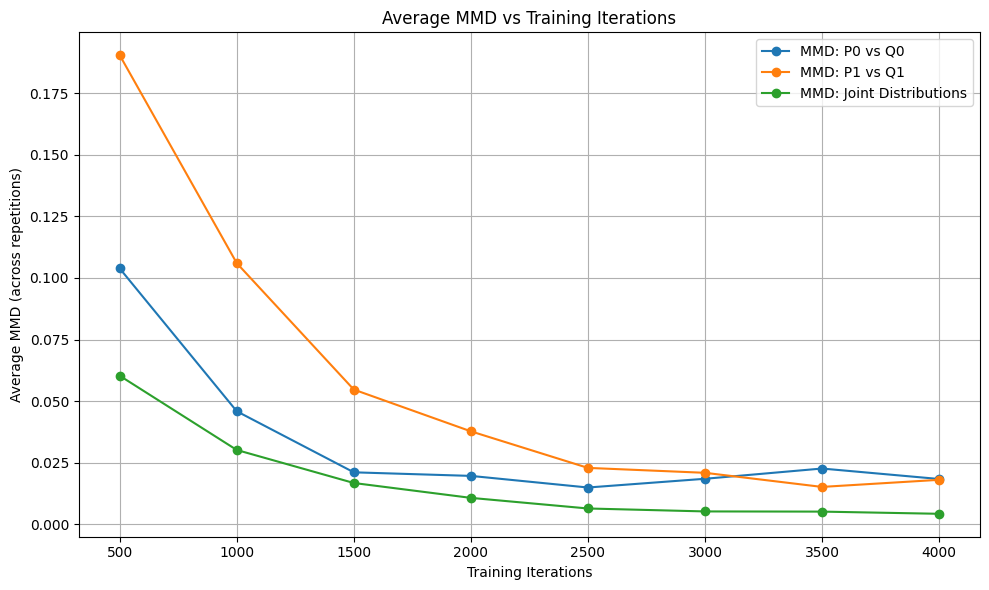

In [ ]:
# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# MMD P0 vs Q0
plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# MMD P1 vs Q1
plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


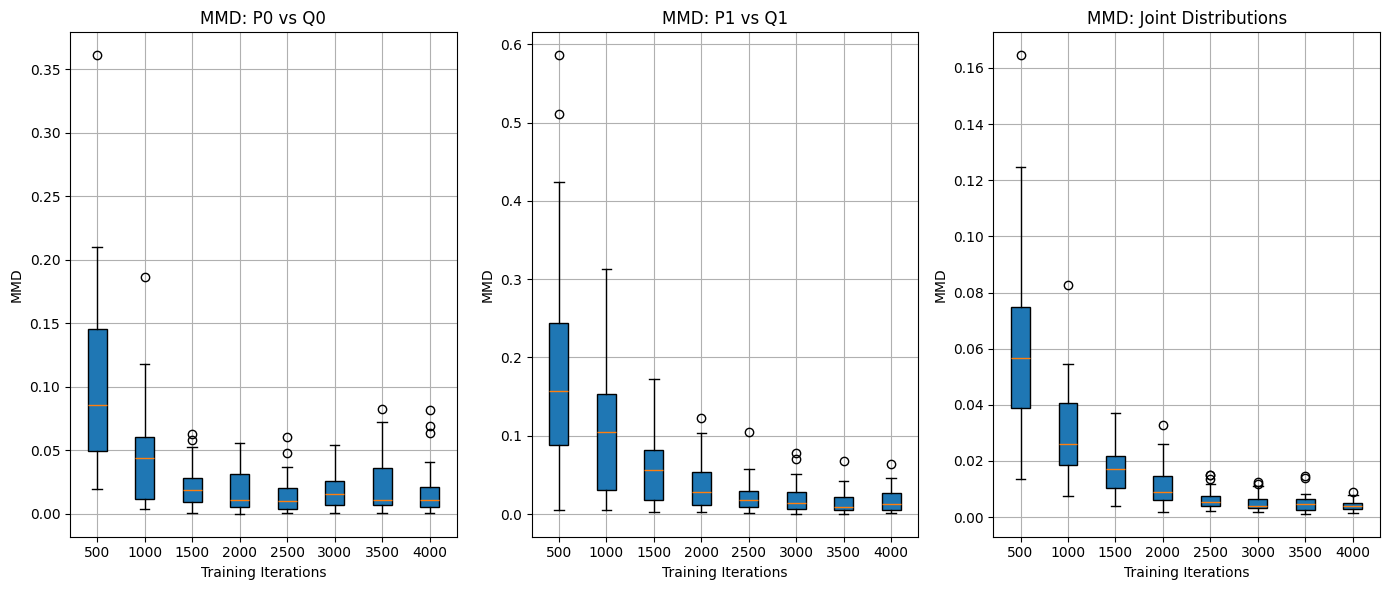

In [ ]:
# Extract MMD values for each iteration
iterations = list(tracker.keys())

mmd_p0_q0 = [tracker[iteration]["mmd_p0_q0"] for iteration in iterations]
mmd_p1_q1 = [tracker[iteration]["mmd_p1_q1"] for iteration in iterations]
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

# MMD P0 vs Q0
plt.subplot(1, 3, 1)
plt.boxplot(mmd_p0_q0, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P0 vs Q0')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(1, 3, 2)
plt.boxplot(mmd_p1_q1, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P1 vs Q1')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD Joint Distributions
plt.subplot(1, 3, 3)
plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


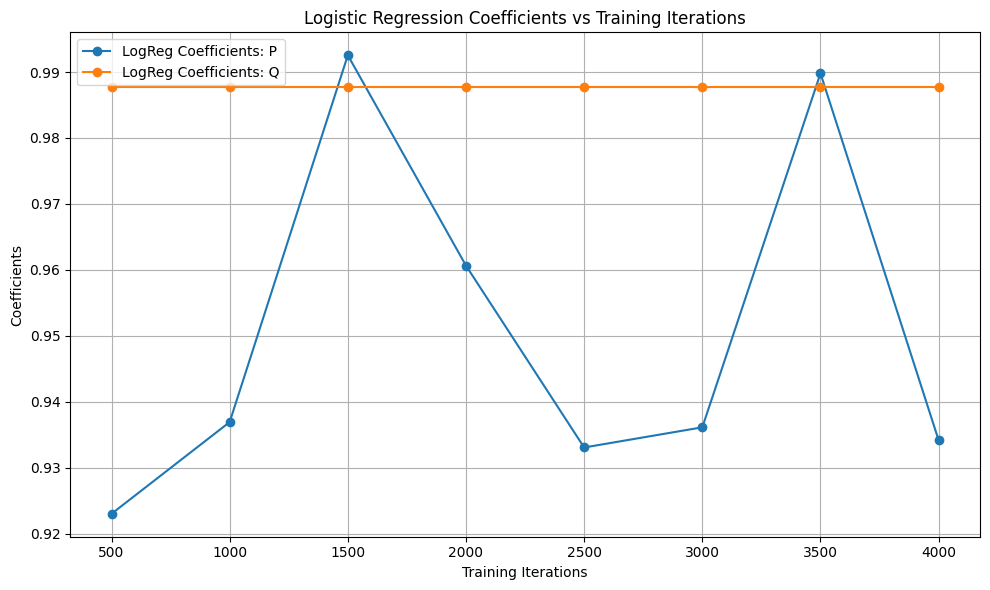

In [ ]:
# Extract coefficients for each iteration
iterations = list(tracker.keys())
coeffs_p = [np.mean(tracker[iteration]["logreg_coeffs_p"], axis=0) for iteration in iterations]
coeffs_q = [np.mean(tracker[iteration]["logreg_coeffs_q"], axis=0) for iteration in iterations]

# Plot the coefficients
plt.figure(figsize=(10, 6))

# Logistic Regression Coefficients for P
plt.plot(iterations, np.squeeze(coeffs_p), marker='o', label='LogReg Coefficients: P')

# Logistic Regression Coefficients for Q
plt.plot(iterations, np.squeeze(coeffs_q), marker='o', label='LogReg Coefficients: Q')

# Customization
plt.title('Logistic Regression Coefficients vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Coefficients')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


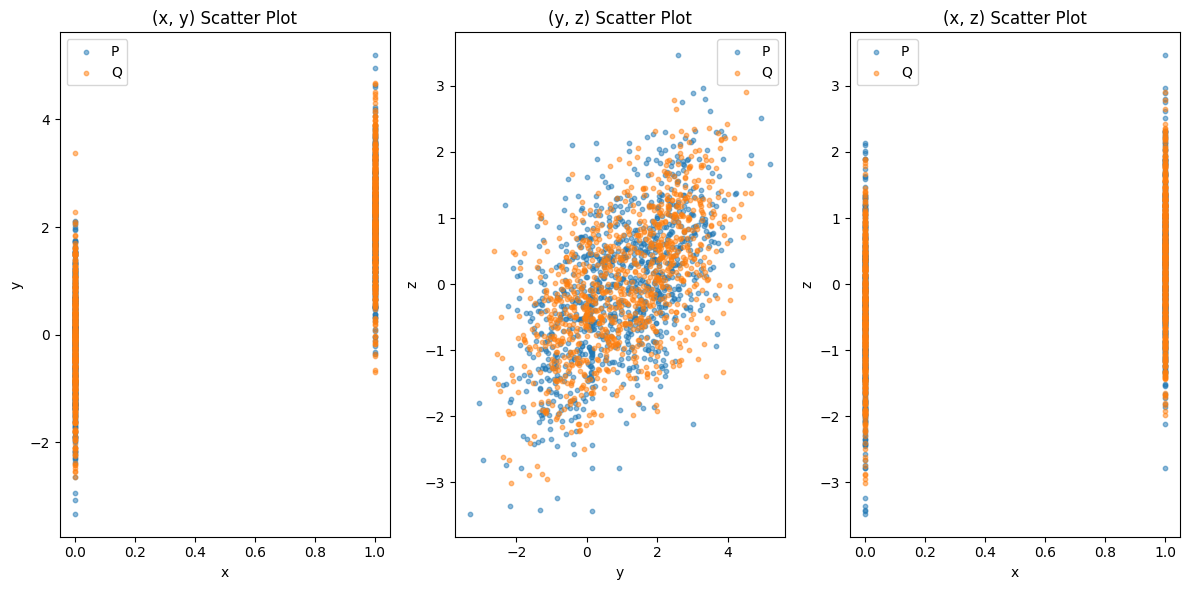

In [ ]:
# Scatter plot for P and Q
plt.figure(figsize=(12, 6))

# (x, y) scatter for P and Q
plt.subplot(1, 3, 1)
plt.scatter(P_joint[:, 0], P_joint[:, 1], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 1], alpha=0.5, label='Q', s=10)
plt.title('(x, y) Scatter Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# (y, z) scatter for P and Q
plt.subplot(1, 3, 2)
plt.scatter(P_joint[:, 1], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 1], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(y, z) Scatter Plot')
plt.xlabel('y')
plt.ylabel('z')
plt.legend()

# (x, z) scatter for P and Q
plt.subplot(1, 3, 3)
plt.scatter(P_joint[:, 0], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(x, z) Scatter Plot')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()

plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

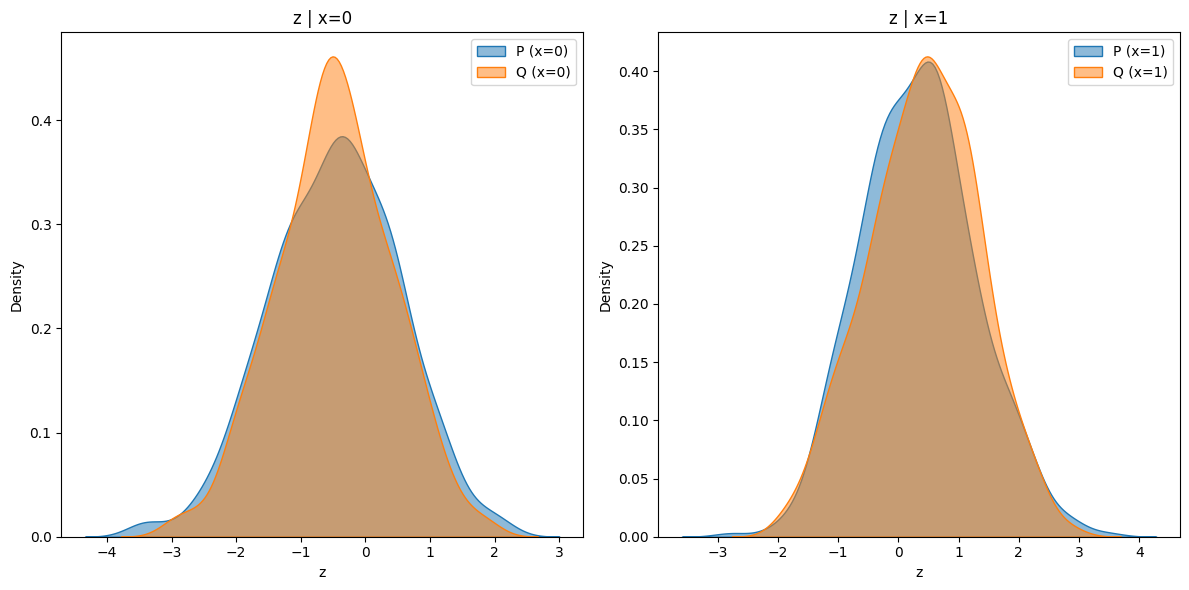

In [ ]:
import seaborn as sns

# Separate z for x=0 and x=1
z_p_given_x0 = P_joint[P_joint[:, 0] == 0][:, 2]
z_p_given_x1 = P_joint[P_joint[:, 0] == 1][:, 2]
z_q_given_x0 = Q_joint[Q_joint[:, 0] == 0][:, 2]
z_q_given_x1 = Q_joint[Q_joint[:, 0] == 1][:, 2]

# KDE plots for z | x
plt.figure(figsize=(12, 6))

# z | x=0
plt.subplot(1, 2, 1)
sns.kdeplot(z_p_given_x0, label='P (x=0)', fill=True, alpha=0.5)
sns.kdeplot(z_q_given_x0, label='Q (x=0)', fill=True, alpha=0.5)
plt.title('z | x=0')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()

# z | x=1
plt.subplot(1, 2, 2)
sns.kdeplot(z_p_given_x1, label='P (x=1)', fill=True, alpha=0.5)
sns.kdeplot(z_q_given_x1, label='Q (x=1)', fill=True, alpha=0.5)
plt.title('z | x=1')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

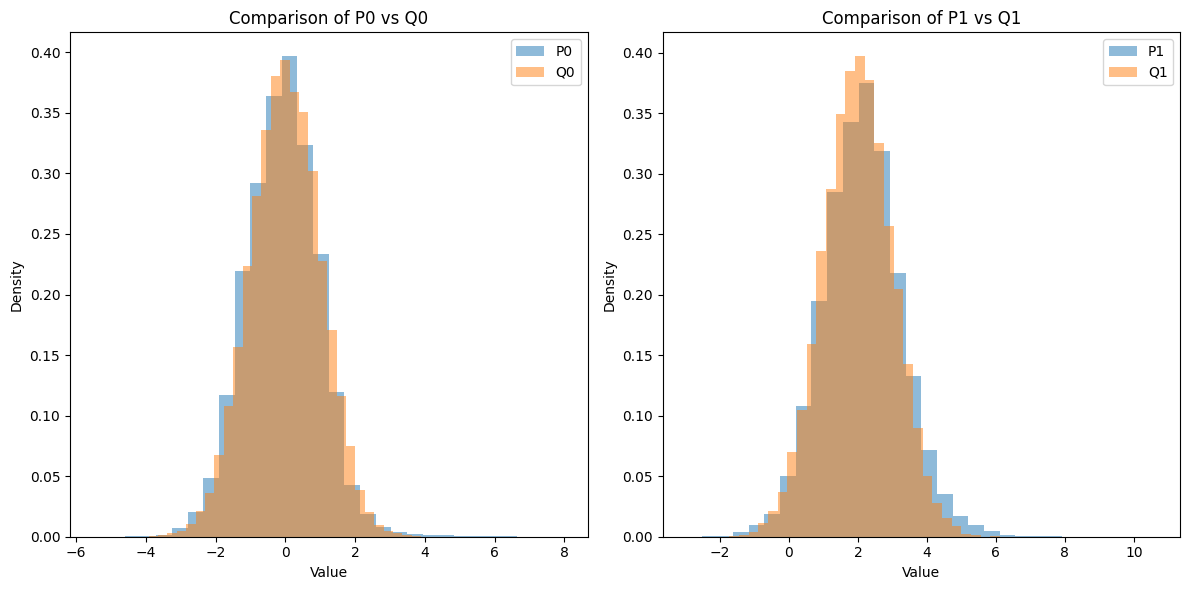

In [ ]:
# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

### Introducing other variables

In [ ]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 1
nX = 1
nO = 1
nS= 1
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []

P1_list = []
Q1_list = []

P_joint_list = []
Q_joint_list = []

tracker = {iteration: {"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []}
           for iteration in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}

# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    Q0_list.append(Q0)
    Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_

        # Log results
        tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[iteration]["logreg_coeffs_q"].append(logreg_coeffs_q)
    P0_list.append(P0)
    P1_list.append(P1)
    P_joint_list.append(P_joint)

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 1.9131, loss1 1.9998, loss2 0.1733
Epoch 100: loss 1.4082, loss1 2.8065, loss2 2.7966
Epoch 200: loss 1.4461, loss1 2.8389, loss2 2.7857
Epoch 300: loss 1.4392, loss1 2.8067, loss2 2.7349
Epoch 400: loss 1.3985, loss1 2.8011, loss2 2.8051
Epoch 500: loss 1.3883, loss1 2.8017, loss2 2.8269
Epoch 1: loss 2.1350,	loss_y 1.4306, 1.4454, 0.0296,	loss_eta 0.7044, 0.7472, 0.0855
Epoch 100: loss 1.6243,	loss_y 0.6472, 1.1893, 1.0842,	loss_eta 0.9771, 1.8117, 1.6693
Epoch 200: loss 2.1371,	loss_y 1.4552, 2.5660, 2.2215,	loss_eta 0.6819, 0.8512, 0.3386
Epoch 300: loss 1.7509,	loss_y 0.9510, 1.6531, 1.4043,	loss_eta 0.7999, 1.0536, 0.5075
Epoch 400: loss 1.4767,	loss_y 0.7631, 1.5494, 1.5726,	loss_eta 0.7136, 0.8253, 0.2236


  0%|          | 0/30 [00:11<?, ?it/s]

Epoch 500: loss 1.2985,	loss_y 0.6923, 1.7318, 2.0790,	loss_eta 0.6062, 0.9616, 0.7108


NameError: name 'mmd_rbf' is not defined

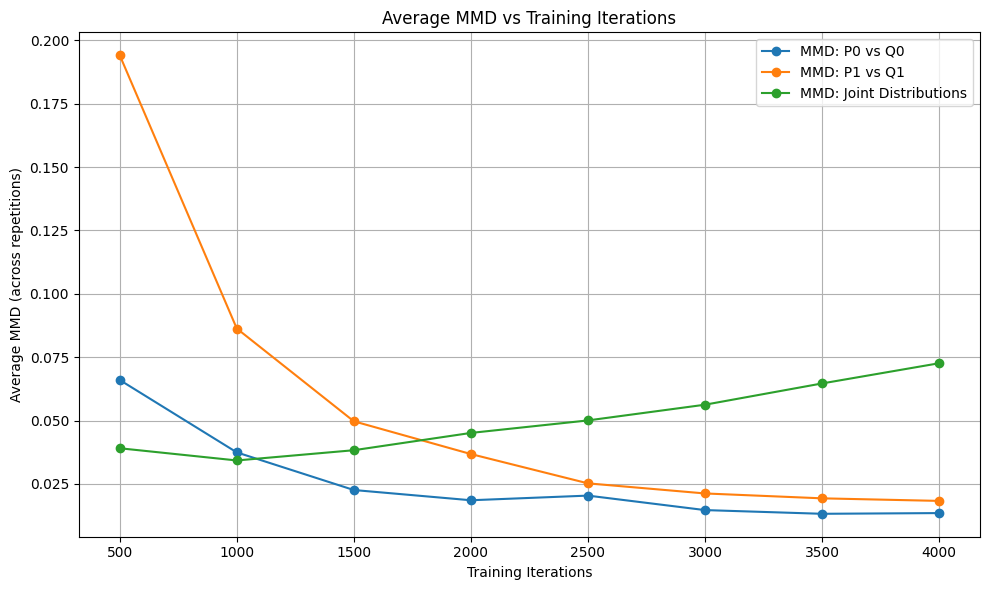

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# MMD P0 vs Q0
plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# MMD P1 vs Q1
plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


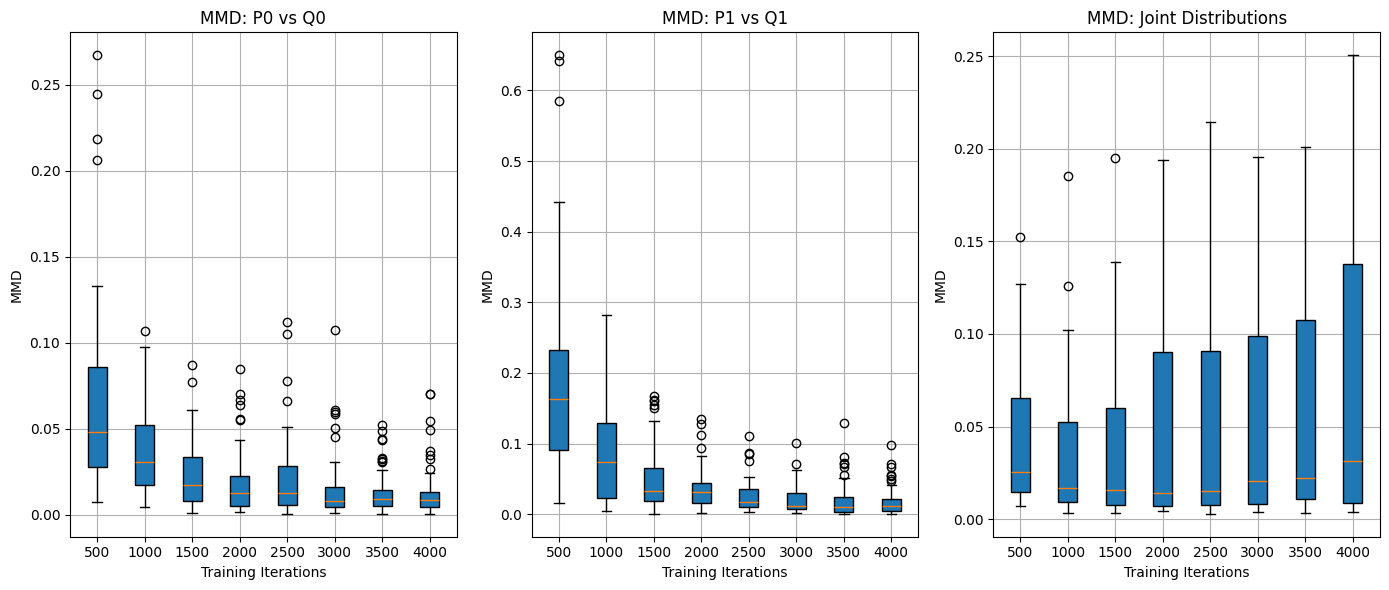

In [ ]:
import matplotlib.pyplot as plt

# Extract MMD values for each iteration
iterations = list(tracker.keys())

mmd_p0_q0 = [tracker[iteration]["mmd_p0_q0"] for iteration in iterations]
mmd_p1_q1 = [tracker[iteration]["mmd_p1_q1"] for iteration in iterations]
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

# MMD P0 vs Q0
plt.subplot(1, 3, 1)
plt.boxplot(mmd_p0_q0, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P0 vs Q0')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(1, 3, 2)
plt.boxplot(mmd_p1_q1, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P1 vs Q1')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD Joint Distributions
plt.subplot(1, 3, 3)
plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


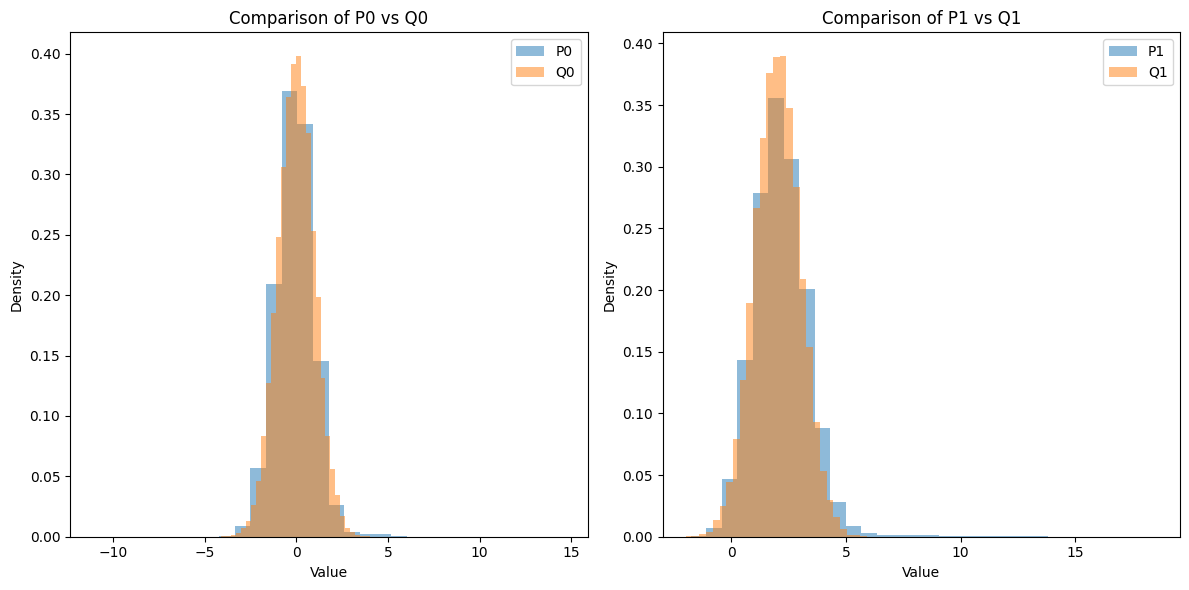

In [ ]:
# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

### Increasing instrumental variable strength as decreasing overlap

In [ ]:
nrep = 20  # Number of repetitions
n_tr = 1000  # Training sample size
n_p = 1000  # Testing sample size
strength_instr_values = np.arange(0, 2.5, 0.5)  # Varying strength of instrumental variables
nI = 2  # Fixed number of instrumental variables
nX = 2
nO = 2
nS = 3
binary_intervention = True
num_iters = 4000  # Fixed number of training iterations


# Initialize tracker for strength_instr
tracker = {strength_instr: {"ate_p": [], "ate_dr": [], "coeff_diff": [], "mmd_p0_q0": [], "mmd_p1_q1": [], 
                            "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []}
           for strength_instr in strength_instr_values}

# Begin loop over strength_instr
for strength_instr in strength_instr_values:
    print(f"Running experiments for strength_instr = {strength_instr}")
    p = nI + nX + nO + nS  # Update the number of covariates
    
    for rep in tqdm(range(nrep)):
        # Generate training and testing data
        df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
            torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
        y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)
        
        z_tr_np = df_tr[[f"X{i}" for i in range(1, p + 1)]].values
        x_tr_np = df_tr['A'].values
        y_tr_np = df_tr['y'].values

        model = Frengression(x_dim = x_tr.shape[1], y_dim = 1, z_dim =z_tr.shape[1], 
                             noise_dim=1, num_layer=3, hidden_dim=400, 
                             device=device, x_binary=binary_intervention, z_binary_dims=0)
        
        df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)

        z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
        y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)
        
        
        z_q_np = df_q[[f"X{i}" for i in range(1, p + 1)]].values
        x_q_np = df_q['A'].values
        y_q_np = df_q['y'].values

        # Ground truth distributions
        Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
        Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
        Q_joint = torch.cat([x_q, y_q, z_q], dim=1).numpy()

        # Train Frengression model
        model.train_xz(torch.tensor(x_tr, dtype=torch.float32).view(-1, 1), 
                       torch.tensor(z_tr, dtype=torch.float32), num_iters=num_iters, lr=1e-4, print_every_iter=400)
        model.train_y(torch.tensor(x_tr, dtype=torch.float32).view(-1, 1), 
                      torch.tensor(z_tr, dtype=torch.float32), 
                      torch.tensor(y_tr, dtype=torch.float32).view(-1, 1), 
                      num_iters=num_iters, lr=1e-4, print_every_iter=400)

        # Sample model distributions
        P0 = model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p).numpy().reshape(-1, 1)
        P1 = model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p).numpy().reshape(-1, 1)
        ate_p = np.mean(P1) - np.mean(P0)

        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        # DR Estimation
        ate_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np, x_q_np, y_q_np, z_q_np)


        # Logistic regression for P
        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_tr, x_tr)
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q, x_q)
        logreg_coeffs_q = logistic_model_q.coef_
        coeff_diff = np.mean((logreg_coeffs_p - logreg_coeffs_q)**2)

        # Log results
        tracker[strength_instr]["ate_p"].append(ate_p)
        tracker[strength_instr]["ate_dr"].append(ate_dr)
        tracker[strength_instr]["coeff_diff"].append(coeff_diff)
        tracker[strength_instr]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[strength_instr]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[strength_instr]["mmd_joint"].append(mmd_joint)
        tracker[strength_instr]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[strength_instr]["logreg_coeffs_q"].append(logreg_coeffs_q)


Running experiments for strength_instr = 0.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: loss 2.8789, loss1 3.0113, loss2 0.2650
Epoch 400: loss 2.1222, loss1 4.2412, loss2 4.2380
Epoch 800: loss 2.1282, loss1 4.2367, loss2 4.2171
Epoch 1200: loss 2.0940, loss1 4.2133, loss2 4.2386
Epoch 1600: loss 2.1453, loss1 4.2472, loss2 4.2038
Epoch 2000: loss 2.1402, loss1 4.2421, loss2 4.2037
Epoch 2400: loss 2.1159, loss1 4.2451, loss2 4.2584
Epoch 2800: loss 2.1190, loss1 4.2253, loss2 4.2124
Epoch 3200: loss 2.1009, loss1 4.2207, loss2 4.2395
Epoch 3600: loss 2.0933, loss1 4.2165, loss2 4.2465
Epoch 4000: loss 2.0914, loss1 4.2139, loss2 4.2450
Epoch 1: loss 2.2771,	loss_y 1.4914, 1.5097, 0.0365,	loss_eta 0.7857, 0.8229, 0.0745
Epoch 400: loss 1.5911,	loss_y 0.8659, 1.8133, 1.8949,	loss_eta 0.7252, 0.8113, 0.1721
Epoch 800: loss 1.5307,	loss_y 0.8148, 1.1241, 0.6187,	loss_eta 0.7160, 0.8634, 0.2948
Epoch 1200: loss 1.2399,	loss_y 0.5785, 1.2643, 1.3717,	loss_eta 0.6615, 0.9171, 0.5113
Epoch 1600: loss 1.1867,	loss_y 0.5245, 1.1414, 1.2338,	loss_eta 0.6622, 0.9167, 0.509

  5%|▌         | 1/20 [01:20<25:28, 80.43s/it]

Epoch 1: loss 2.8315, loss1 2.9793, loss2 0.2956
Epoch 400: loss 2.1075, loss1 4.1943, loss2 4.1736
Epoch 800: loss 2.1106, loss1 4.2094, loss2 4.1976
Epoch 1200: loss 2.0492, loss1 4.1475, loss2 4.1965
Epoch 1600: loss 2.0968, loss1 4.2030, loss2 4.2124
Epoch 2000: loss 2.0834, loss1 4.1753, loss2 4.1838
Epoch 2400: loss 2.0629, loss1 4.1604, loss2 4.1950
Epoch 2800: loss 2.0816, loss1 4.1573, loss2 4.1513
Epoch 3200: loss 2.0851, loss1 4.1700, loss2 4.1698
Epoch 3600: loss 2.0999, loss1 4.2068, loss2 4.2139
Epoch 4000: loss 2.0722, loss1 4.1603, loss2 4.1763
Epoch 1: loss 2.2611,	loss_y 1.5194, 1.5354, 0.0320,	loss_eta 0.7418, 0.7865, 0.0894
Epoch 400: loss 1.7774,	loss_y 1.0932, 1.5410, 0.8955,	loss_eta 0.6842, 0.8619, 0.3555
Epoch 800: loss 1.5189,	loss_y 0.7062, 1.2211, 1.0297,	loss_eta 0.8127, 0.8273, 0.0292
Epoch 1200: loss 1.4751,	loss_y 0.8525, 1.4406, 1.1762,	loss_eta 0.6226, 1.1248, 1.0045
Epoch 1600: loss 1.0866,	loss_y 0.4842, 0.9466, 0.9248,	loss_eta 0.6024, 1.4401, 1.675

 10%|█         | 2/20 [02:32<22:43, 75.76s/it]

Epoch 1: loss 2.7942, loss1 2.9406, loss2 0.2928
Epoch 400: loss 2.1119, loss1 4.1543, loss2 4.0847
Epoch 800: loss 2.0581, loss1 4.1326, loss2 4.1489
Epoch 1200: loss 2.0759, loss1 4.1660, loss2 4.1801
Epoch 1600: loss 2.0746, loss1 4.1266, loss2 4.1038
Epoch 2000: loss 2.0225, loss1 4.1173, loss2 4.1897
Epoch 2400: loss 2.0509, loss1 4.1238, loss2 4.1456
Epoch 2800: loss 2.0588, loss1 4.1326, loss2 4.1476
Epoch 3200: loss 2.0655, loss1 4.1100, loss2 4.0890
Epoch 3600: loss 2.0940, loss1 4.1398, loss2 4.0916
Epoch 4000: loss 2.0645, loss1 4.1289, loss2 4.1287
Epoch 1: loss 2.1665,	loss_y 1.4027, 1.4260, 0.0464,	loss_eta 0.7638, 0.8018, 0.0760
Epoch 400: loss 1.5896,	loss_y 0.8203, 1.3539, 1.0673,	loss_eta 0.7694, 0.9197, 0.3007
Epoch 800: loss 1.4024,	loss_y 0.7147, 1.6599, 1.8904,	loss_eta 0.6877, 0.8171, 0.2588
Epoch 1200: loss 1.4033,	loss_y 0.7239, 1.3883, 1.3290,	loss_eta 0.6795, 0.9273, 0.4958
Epoch 1600: loss 1.1350,	loss_y 0.4676, 1.1054, 1.2757,	loss_eta 0.6675, 0.9256, 0.516

 15%|█▌        | 3/20 [03:45<21:00, 74.12s/it]

Epoch 1: loss 2.8679, loss1 3.0009, loss2 0.2659
Epoch 400: loss 2.0819, loss1 4.1803, loss2 4.1967
Epoch 800: loss 2.0957, loss1 4.2022, loss2 4.2129
Epoch 1200: loss 2.0836, loss1 4.1985, loss2 4.2298
Epoch 1600: loss 2.0886, loss1 4.2019, loss2 4.2265
Epoch 2000: loss 2.1031, loss1 4.1737, loss2 4.1414
Epoch 2400: loss 2.1252, loss1 4.2266, loss2 4.2029
Epoch 2800: loss 2.1239, loss1 4.2176, loss2 4.1875
Epoch 3200: loss 2.0931, loss1 4.2104, loss2 4.2347
Epoch 3600: loss 2.0853, loss1 4.1986, loss2 4.2266
Epoch 4000: loss 2.1168, loss1 4.2063, loss2 4.1789
Epoch 1: loss 2.2365,	loss_y 1.4660, 1.4826, 0.0331,	loss_eta 0.7705, 0.8039, 0.0670
Epoch 400: loss 1.4787,	loss_y 0.7581, 1.9551, 2.3938,	loss_eta 0.7206, 0.8990, 0.3569
Epoch 800: loss 1.1683,	loss_y 0.5216, 1.0328, 1.0223,	loss_eta 0.6466, 0.8696, 0.4459
Epoch 1200: loss 1.0414,	loss_y 0.4490, 1.1849, 1.4718,	loss_eta 0.5924, 1.3051, 1.4254
Epoch 1600: loss 1.0332,	loss_y 0.4510, 0.9305, 0.9589,	loss_eta 0.5821, 0.9911, 0.817

 20%|██        | 4/20 [04:57<19:32, 73.25s/it]

Epoch 1: loss 2.8839, loss1 3.0174, loss2 0.2671
Epoch 400: loss 2.1123, loss1 4.2476, loss2 4.2706
Epoch 800: loss 2.1342, loss1 4.2498, loss2 4.2312
Epoch 1200: loss 2.1330, loss1 4.2611, loss2 4.2561
Epoch 1600: loss 2.1379, loss1 4.2662, loss2 4.2565
Epoch 2000: loss 2.1374, loss1 4.2841, loss2 4.2934
Epoch 2400: loss 2.1311, loss1 4.2234, loss2 4.1845
Epoch 2800: loss 2.0948, loss1 4.2093, loss2 4.2292
Epoch 3200: loss 2.1389, loss1 4.2221, loss2 4.1663
Epoch 3600: loss 2.1277, loss1 4.2597, loss2 4.2639
Epoch 4000: loss 2.1353, loss1 4.2423, loss2 4.2140
Epoch 1: loss 2.2553,	loss_y 1.5131, 1.5253, 0.0245,	loss_eta 0.7423, 0.7806, 0.0767
Epoch 400: loss 1.6640,	loss_y 0.9463, 1.7668, 1.6410,	loss_eta 0.7177, 0.9028, 0.3701
Epoch 800: loss 1.4472,	loss_y 0.7534, 2.0819, 2.6571,	loss_eta 0.6938, 1.2638, 1.1400
Epoch 1200: loss 1.1052,	loss_y 0.4334, 1.0382, 1.2097,	loss_eta 0.6718, 0.9563, 0.5690
Epoch 1600: loss 1.1535,	loss_y 0.5315, 1.1879, 1.3127,	loss_eta 0.6220, 1.0176, 0.791

 25%|██▌       | 5/20 [06:07<18:05, 72.34s/it]

Epoch 1: loss 2.8144, loss1 2.9576, loss2 0.2862
Epoch 400: loss 2.0859, loss1 4.1554, loss2 4.1390
Epoch 800: loss 2.0801, loss1 4.1783, loss2 4.1963
Epoch 1200: loss 2.0699, loss1 4.1247, loss2 4.1095
Epoch 1600: loss 2.0854, loss1 4.1364, loss2 4.1020
Epoch 2000: loss 2.0666, loss1 4.1623, loss2 4.1914
Epoch 2400: loss 2.0715, loss1 4.1490, loss2 4.1549
Epoch 2800: loss 2.0677, loss1 4.1250, loss2 4.1147
Epoch 3200: loss 2.1039, loss1 4.1686, loss2 4.1294
Epoch 3600: loss 2.0658, loss1 4.1560, loss2 4.1806
Epoch 4000: loss 2.0829, loss1 4.1588, loss2 4.1519
Epoch 1: loss 2.1210,	loss_y 1.3850, 1.4008, 0.0315,	loss_eta 0.7360, 0.7718, 0.0716
Epoch 400: loss 1.5191,	loss_y 0.7966, 1.4551, 1.3169,	loss_eta 0.7225, 0.9657, 0.4865
Epoch 800: loss 1.3977,	loss_y 0.7235, 0.9303, 0.4136,	loss_eta 0.6742, 0.8693, 0.3901
Epoch 1200: loss 1.4379,	loss_y 0.7274, 1.2945, 1.1342,	loss_eta 0.7106, 1.4058, 1.3904
Epoch 1600: loss 1.0514,	loss_y 0.4573, 1.1975, 1.4804,	loss_eta 0.5941, 1.1436, 1.098

 30%|███       | 6/20 [07:08<15:58, 68.44s/it]

Epoch 1: loss 2.8274, loss1 2.9652, loss2 0.2757
Epoch 400: loss 2.0645, loss1 4.1431, loss2 4.1571
Epoch 800: loss 2.0715, loss1 4.1665, loss2 4.1899
Epoch 1200: loss 2.1213, loss1 4.1523, loss2 4.0620
Epoch 1600: loss 2.0729, loss1 4.1547, loss2 4.1637
Epoch 2000: loss 2.0916, loss1 4.1587, loss2 4.1341
Epoch 2400: loss 2.0912, loss1 4.1831, loss2 4.1838
Epoch 2800: loss 2.0905, loss1 4.1748, loss2 4.1686
Epoch 3200: loss 2.1222, loss1 4.2005, loss2 4.1566
Epoch 3600: loss 2.0907, loss1 4.1884, loss2 4.1955
Epoch 4000: loss 2.0971, loss1 4.1778, loss2 4.1615
Epoch 1: loss 2.4290,	loss_y 1.6388, 1.6824, 0.0872,	loss_eta 0.7902, 0.8232, 0.0660
Epoch 400: loss 1.8239,	loss_y 1.2087, 3.0040, 3.5905,	loss_eta 0.6152, 0.8360, 0.4415
Epoch 800: loss 1.3394,	loss_y 0.7445, 1.1845, 0.8799,	loss_eta 0.5948, 1.3398, 1.4898
Epoch 1200: loss 1.2762,	loss_y 0.6673, 1.1414, 0.9481,	loss_eta 0.6089, 1.0254, 0.8332
Epoch 1600: loss 1.1997,	loss_y 0.5200, 1.0364, 1.0329,	loss_eta 0.6797, 1.6610, 1.962

 35%|███▌      | 7/20 [08:21<15:06, 69.75s/it]

Epoch 1: loss 2.8457, loss1 2.9944, loss2 0.2974
Epoch 400: loss 2.0842, loss1 4.1737, loss2 4.1789
Epoch 800: loss 2.0841, loss1 4.1581, loss2 4.1480
Epoch 1200: loss 2.1073, loss1 4.1954, loss2 4.1763
Epoch 1600: loss 2.0739, loss1 4.1772, loss2 4.2067
Epoch 2000: loss 2.0738, loss1 4.2251, loss2 4.3026
Epoch 2400: loss 2.1509, loss1 4.2609, loss2 4.2199
Epoch 2800: loss 2.0957, loss1 4.1765, loss2 4.1618
Epoch 3200: loss 2.1133, loss1 4.1775, loss2 4.1285
Epoch 3600: loss 2.1179, loss1 4.1955, loss2 4.1552
Epoch 4000: loss 2.1213, loss1 4.1908, loss2 4.1391
Epoch 1: loss 2.2430,	loss_y 1.4567, 1.4807, 0.0480,	loss_eta 0.7863, 0.8217, 0.0708
Epoch 400: loss 1.8404,	loss_y 1.1826, 1.7900, 1.2150,	loss_eta 0.6578, 0.9230, 0.5303
Epoch 800: loss 1.4752,	loss_y 0.7426, 1.5151, 1.5450,	loss_eta 0.7326, 0.8259, 0.1865
Epoch 1200: loss 1.2389,	loss_y 0.6113, 1.1458, 1.0691,	loss_eta 0.6277, 1.1727, 1.0901
Epoch 1600: loss 0.9859,	loss_y 0.4289, 1.0317, 1.2055,	loss_eta 0.5570, 1.4021, 1.690

 40%|████      | 8/20 [09:27<13:45, 68.77s/it]

Epoch 1: loss 2.8203, loss1 2.9548, loss2 0.2691
Epoch 400: loss 2.1117, loss1 4.1576, loss2 4.0918
Epoch 800: loss 2.0837, loss1 4.1779, loss2 4.1884
Epoch 1200: loss 2.0802, loss1 4.1561, loss2 4.1518
Epoch 1600: loss 2.0826, loss1 4.1531, loss2 4.1411
Epoch 2000: loss 2.1043, loss1 4.1954, loss2 4.1822
Epoch 2400: loss 2.0804, loss1 4.1240, loss2 4.0873
Epoch 2800: loss 2.0663, loss1 4.1364, loss2 4.1402
Epoch 3200: loss 2.0672, loss1 4.1316, loss2 4.1289
Epoch 3600: loss 2.0755, loss1 4.1442, loss2 4.1373
Epoch 4000: loss 2.0882, loss1 4.1508, loss2 4.1252
Epoch 1: loss 2.2512,	loss_y 1.4745, 1.5278, 0.1066,	loss_eta 0.7767, 0.8185, 0.0836
Epoch 400: loss 1.6465,	loss_y 0.9900, 2.3845, 2.7891,	loss_eta 0.6565, 0.9863, 0.6594
Epoch 800: loss 1.0810,	loss_y 0.5002, 0.8331, 0.6657,	loss_eta 0.5808, 1.2043, 1.2471
Epoch 1200: loss 1.1083,	loss_y 0.4957, 1.0553, 1.1192,	loss_eta 0.6126, 1.2023, 1.1795
Epoch 1600: loss 0.9939,	loss_y 0.4194, 0.8994, 0.9601,	loss_eta 0.5745, 1.2756, 1.402

 45%|████▌     | 9/20 [10:32<12:23, 67.64s/it]

Epoch 1: loss 2.8686, loss1 3.0131, loss2 0.2889
Epoch 400: loss 2.1409, loss1 4.2564, loss2 4.2310
Epoch 800: loss 2.1100, loss1 4.2207, loss2 4.2213
Epoch 1200: loss 2.1098, loss1 4.2441, loss2 4.2687
Epoch 1600: loss 2.1077, loss1 4.2429, loss2 4.2705
Epoch 2000: loss 2.1315, loss1 4.2485, loss2 4.2340
Epoch 2400: loss 2.1124, loss1 4.2574, loss2 4.2901
Epoch 2800: loss 2.0892, loss1 4.2319, loss2 4.2855
Epoch 3200: loss 2.1496, loss1 4.2561, loss2 4.2131
Epoch 3600: loss 2.1230, loss1 4.2633, loss2 4.2805
Epoch 4000: loss 2.1059, loss1 4.2410, loss2 4.2701
Epoch 1: loss 2.3207,	loss_y 1.5289, 1.5536, 0.0493,	loss_eta 0.7918, 0.8279, 0.0724
Epoch 400: loss 1.7429,	loss_y 1.0736, 1.9966, 1.8461,	loss_eta 0.6693, 0.8273, 0.3159
Epoch 800: loss 1.2523,	loss_y 0.6013, 1.0819, 0.9611,	loss_eta 0.6510, 1.1648, 1.0275
Epoch 1200: loss 0.9761,	loss_y 0.3493, 0.7156, 0.7325,	loss_eta 0.6268, 1.1140, 0.9745
Epoch 1600: loss 1.1094,	loss_y 0.5163, 0.9553, 0.8781,	loss_eta 0.5931, 0.9767, 0.767

 50%|█████     | 10/20 [11:40<11:16, 67.64s/it]

Epoch 1: loss 2.8401, loss1 2.9800, loss2 0.2799
Epoch 400: loss 2.1262, loss1 4.2097, loss2 4.1670
Epoch 800: loss 2.1116, loss1 4.2112, loss2 4.1990
Epoch 1200: loss 2.0619, loss1 4.1696, loss2 4.2155
Epoch 1600: loss 2.0977, loss1 4.2183, loss2 4.2412
Epoch 2000: loss 2.1019, loss1 4.1726, loss2 4.1415
Epoch 2400: loss 2.0892, loss1 4.1762, loss2 4.1740
Epoch 2800: loss 2.0925, loss1 4.2046, loss2 4.2242
Epoch 3200: loss 2.1104, loss1 4.2091, loss2 4.1974
Epoch 3600: loss 2.1152, loss1 4.2157, loss2 4.2010
Epoch 4000: loss 2.0747, loss1 4.1504, loss2 4.1514
Epoch 1: loss 2.2103,	loss_y 1.4783, 1.4990, 0.0413,	loss_eta 0.7320, 0.7734, 0.0830
Epoch 400: loss 1.3739,	loss_y 0.7294, 1.3443, 1.2299,	loss_eta 0.6445, 1.2750, 1.2610
Epoch 800: loss 1.2686,	loss_y 0.6823, 1.9651, 2.5656,	loss_eta 0.5863, 1.0237, 0.8749
Epoch 1200: loss 1.1192,	loss_y 0.4377, 0.9075, 0.9396,	loss_eta 0.6815, 1.1690, 0.9749
Epoch 1600: loss 0.9856,	loss_y 0.3929, 0.8382, 0.8905,	loss_eta 0.5927, 1.0817, 0.977

 55%|█████▌    | 11/20 [12:46<10:03, 67.03s/it]

Epoch 1: loss 2.8343, loss1 2.9826, loss2 0.2965
Epoch 400: loss 2.1097, loss1 4.1868, loss2 4.1544
Epoch 800: loss 2.0958, loss1 4.1951, loss2 4.1985
Epoch 1200: loss 2.0587, loss1 4.1333, loss2 4.1492
Epoch 1600: loss 2.0907, loss1 4.1831, loss2 4.1849
Epoch 2000: loss 2.0942, loss1 4.1868, loss2 4.1851
Epoch 2400: loss 2.0980, loss1 4.1948, loss2 4.1936
Epoch 2800: loss 2.0974, loss1 4.1926, loss2 4.1903
Epoch 3200: loss 2.1172, loss1 4.2079, loss2 4.1816
Epoch 3600: loss 2.0796, loss1 4.1736, loss2 4.1882
Epoch 4000: loss 2.1042, loss1 4.1995, loss2 4.1907
Epoch 1: loss 2.3185,	loss_y 1.5212, 1.5402, 0.0380,	loss_eta 0.7973, 0.8281, 0.0616
Epoch 400: loss 1.4543,	loss_y 0.6101, 1.5255, 1.8308,	loss_eta 0.8442, 0.9728, 0.2572
Epoch 800: loss 1.3469,	loss_y 0.7191, 1.3845, 1.3307,	loss_eta 0.6278, 1.1482, 1.0407
Epoch 1200: loss 1.3645,	loss_y 0.6999, 1.9755, 2.5513,	loss_eta 0.6646, 0.8449, 0.3606
Epoch 1600: loss 1.2368,	loss_y 0.6583, 1.2147, 1.1128,	loss_eta 0.5785, 1.1769, 1.196

 60%|██████    | 12/20 [13:53<08:57, 67.16s/it]

Epoch 1: loss 2.8362, loss1 2.9720, loss2 0.2716
Epoch 400: loss 2.1070, loss1 4.1780, loss2 4.1419
Epoch 800: loss 2.1070, loss1 4.1587, loss2 4.1034
Epoch 1200: loss 2.0989, loss1 4.1734, loss2 4.1490
Epoch 1600: loss 2.0746, loss1 4.1737, loss2 4.1983
Epoch 2000: loss 2.0636, loss1 4.1540, loss2 4.1808
Epoch 2400: loss 2.0540, loss1 4.1647, loss2 4.2214
Epoch 2800: loss 2.1007, loss1 4.1602, loss2 4.1191
Epoch 3200: loss 2.1163, loss1 4.2016, loss2 4.1706
Epoch 3600: loss 2.1019, loss1 4.1640, loss2 4.1241
Epoch 4000: loss 2.1110, loss1 4.1745, loss2 4.1270
Epoch 1: loss 2.1974,	loss_y 1.4256, 1.4422, 0.0332,	loss_eta 0.7718, 0.8033, 0.0629
Epoch 400: loss 1.4921,	loss_y 0.7743, 1.5664, 1.5843,	loss_eta 0.7179, 0.7971, 0.1584
Epoch 800: loss 1.2924,	loss_y 0.6476, 1.0116, 0.7281,	loss_eta 0.6449, 1.7229, 2.1562
Epoch 1200: loss 1.0571,	loss_y 0.5079, 1.0959, 1.1760,	loss_eta 0.5492, 1.1453, 1.1921
Epoch 1600: loss 1.0811,	loss_y 0.4475, 1.0575, 1.2200,	loss_eta 0.6336, 1.2880, 1.308

 65%|██████▌   | 13/20 [14:59<07:48, 66.87s/it]

Epoch 1: loss 2.8397, loss1 2.9836, loss2 0.2878
Epoch 400: loss 2.0436, loss1 4.1482, loss2 4.2093
Epoch 800: loss 2.0989, loss1 4.1983, loss2 4.1988
Epoch 1200: loss 2.1106, loss1 4.1908, loss2 4.1604
Epoch 1600: loss 2.0978, loss1 4.1873, loss2 4.1789
Epoch 2000: loss 2.0818, loss1 4.1751, loss2 4.1865
Epoch 2400: loss 2.0783, loss1 4.1742, loss2 4.1918
Epoch 2800: loss 2.1260, loss1 4.2328, loss2 4.2138
Epoch 3200: loss 2.1165, loss1 4.2156, loss2 4.1982
Epoch 3600: loss 2.0872, loss1 4.2117, loss2 4.2489
Epoch 4000: loss 2.1085, loss1 4.1967, loss2 4.1764
Epoch 1: loss 2.2775,	loss_y 1.5214, 1.5358, 0.0289,	loss_eta 0.7561, 0.7935, 0.0747
Epoch 400: loss 1.5789,	loss_y 0.9653, 1.3968, 0.8629,	loss_eta 0.6135, 0.8826, 0.5381
Epoch 800: loss 1.4693,	loss_y 0.7854, 1.5651, 1.5592,	loss_eta 0.6839, 1.1117, 0.8556
Epoch 1200: loss 1.2886,	loss_y 0.6023, 0.9013, 0.5980,	loss_eta 0.6863, 0.8263, 0.2800
Epoch 1600: loss 1.2319,	loss_y 0.5474, 1.1345, 1.1743,	loss_eta 0.6845, 1.3033, 1.237

 70%|███████   | 14/20 [16:01<06:32, 65.41s/it]

Epoch 1: loss 2.8559, loss1 2.9999, loss2 0.2879
Epoch 400: loss 2.0745, loss1 4.1911, loss2 4.2331
Epoch 800: loss 2.0994, loss1 4.2085, loss2 4.2183
Epoch 1200: loss 2.1149, loss1 4.2138, loss2 4.1978
Epoch 1600: loss 2.1287, loss1 4.2238, loss2 4.1901
Epoch 2000: loss 2.0760, loss1 4.1768, loss2 4.2015
Epoch 2400: loss 2.1436, loss1 4.2103, loss2 4.1333
Epoch 2800: loss 2.0782, loss1 4.2181, loss2 4.2799
Epoch 3200: loss 2.1187, loss1 4.2324, loss2 4.2274
Epoch 3600: loss 2.1128, loss1 4.2123, loss2 4.1990
Epoch 4000: loss 2.0566, loss1 4.1766, loss2 4.2400
Epoch 1: loss 2.2819,	loss_y 1.5489, 1.5654, 0.0330,	loss_eta 0.7330, 0.7775, 0.0889
Epoch 400: loss 1.9133,	loss_y 1.3216, 2.6351, 2.6270,	loss_eta 0.5917, 1.3093, 1.4352
Epoch 800: loss 1.2722,	loss_y 0.5748, 0.9298, 0.7100,	loss_eta 0.6974, 1.1633, 0.9318
Epoch 1200: loss 1.3117,	loss_y 0.6871, 1.9950, 2.6159,	loss_eta 0.6247, 0.8688, 0.4882
Epoch 1600: loss 1.2467,	loss_y 0.5428, 1.2388, 1.3920,	loss_eta 0.7039, 1.0027, 0.597

 75%|███████▌  | 15/20 [17:05<05:23, 64.77s/it]

Epoch 1: loss 2.8296, loss1 2.9658, loss2 0.2725
Epoch 400: loss 2.1001, loss1 4.1516, loss2 4.1030
Epoch 800: loss 2.0623, loss1 4.1687, loss2 4.2128
Epoch 1200: loss 2.1061, loss1 4.1737, loss2 4.1354
Epoch 1600: loss 2.0850, loss1 4.1696, loss2 4.1692
Epoch 2000: loss 2.1114, loss1 4.1984, loss2 4.1739
Epoch 2400: loss 2.1179, loss1 4.2111, loss2 4.1864
Epoch 2800: loss 2.0580, loss1 4.1323, loss2 4.1486
Epoch 3200: loss 2.0867, loss1 4.1635, loss2 4.1535
Epoch 3600: loss 2.1080, loss1 4.1646, loss2 4.1132
Epoch 4000: loss 2.0870, loss1 4.1592, loss2 4.1445
Epoch 1: loss 2.2415,	loss_y 1.4643, 1.4853, 0.0420,	loss_eta 0.7772, 0.8064, 0.0584
Epoch 400: loss 1.4138,	loss_y 0.7046, 1.7747, 2.1402,	loss_eta 0.7092, 0.8266, 0.2347
Epoch 800: loss 1.6073,	loss_y 0.9654, 2.3123, 2.6937,	loss_eta 0.6419, 0.9801, 0.6765
Epoch 1200: loss 1.1062,	loss_y 0.4999, 1.0591, 1.1184,	loss_eta 0.6063, 1.2890, 1.3654
Epoch 1600: loss 1.0047,	loss_y 0.4748, 1.1286, 1.3075,	loss_eta 0.5299, 1.2084, 1.357

 80%|████████  | 16/20 [18:07<04:16, 64.01s/it]

Epoch 1: loss 2.8239, loss1 2.9780, loss2 0.3083
Epoch 400: loss 2.1245, loss1 4.1935, loss2 4.1380
Epoch 800: loss 2.0965, loss1 4.1762, loss2 4.1593
Epoch 1200: loss 2.0997, loss1 4.1866, loss2 4.1737
Epoch 1600: loss 2.0932, loss1 4.1767, loss2 4.1669
Epoch 2000: loss 2.1001, loss1 4.1805, loss2 4.1608
Epoch 2400: loss 2.1189, loss1 4.1821, loss2 4.1265
Epoch 2800: loss 2.1177, loss1 4.1739, loss2 4.1125
Epoch 3200: loss 2.0459, loss1 4.1393, loss2 4.1867
Epoch 3600: loss 2.1037, loss1 4.1622, loss2 4.1171
Epoch 4000: loss 2.0611, loss1 4.1608, loss2 4.1993
Epoch 1: loss 2.3213,	loss_y 1.5529, 1.5661, 0.0265,	loss_eta 0.7684, 0.8010, 0.0651
Epoch 400: loss 1.9235,	loss_y 1.1611, 2.5136, 2.7050,	loss_eta 0.7623, 0.8539, 0.1831
Epoch 800: loss 1.4937,	loss_y 0.8062, 1.7863, 1.9601,	loss_eta 0.6875, 0.8666, 0.3584
Epoch 1200: loss 1.0867,	loss_y 0.5066, 1.1385, 1.2639,	loss_eta 0.5802, 1.2802, 1.4001
Epoch 1600: loss 1.1035,	loss_y 0.5106, 1.0216, 1.0220,	loss_eta 0.5929, 1.1464, 1.107

 85%|████████▌ | 17/20 [19:09<03:10, 63.54s/it]

Epoch 1: loss 2.8255, loss1 2.9677, loss2 0.2843
Epoch 400: loss 2.1012, loss1 4.1683, loss2 4.1342
Epoch 800: loss 2.0234, loss1 4.1274, loss2 4.2079
Epoch 1200: loss 2.0585, loss1 4.1392, loss2 4.1613
Epoch 1600: loss 2.0751, loss1 4.1581, loss2 4.1661
Epoch 2000: loss 2.1098, loss1 4.1936, loss2 4.1676
Epoch 2400: loss 2.0794, loss1 4.1725, loss2 4.1862
Epoch 2800: loss 2.0894, loss1 4.1451, loss2 4.1113
Epoch 3200: loss 2.1024, loss1 4.1974, loss2 4.1900
Epoch 3600: loss 2.0911, loss1 4.1812, loss2 4.1802
Epoch 4000: loss 2.0892, loss1 4.1882, loss2 4.1980
Epoch 1: loss 2.2783,	loss_y 1.5413, 1.5505, 0.0182,	loss_eta 0.7369, 0.7725, 0.0711
Epoch 400: loss 1.5100,	loss_y 0.8140, 1.7205, 1.8129,	loss_eta 0.6960, 0.8886, 0.3852
Epoch 800: loss 1.2180,	loss_y 0.6405, 1.6681, 2.0553,	loss_eta 0.5775, 1.2020, 1.2491
Epoch 1200: loss 1.0627,	loss_y 0.4240, 0.8566, 0.8651,	loss_eta 0.6387, 1.2001, 1.1229
Epoch 1600: loss 1.1163,	loss_y 0.5292, 0.9004, 0.7424,	loss_eta 0.5871, 1.0522, 0.930

 90%|█████████ | 18/20 [20:12<02:06, 63.29s/it]

Epoch 1: loss 2.8408, loss1 2.9929, loss2 0.3043
Epoch 400: loss 2.0945, loss1 4.1826, loss2 4.1763
Epoch 800: loss 2.1024, loss1 4.2089, loss2 4.2131
Epoch 1200: loss 2.0817, loss1 4.1813, loss2 4.1992
Epoch 1600: loss 2.0851, loss1 4.1922, loss2 4.2142
Epoch 2000: loss 2.1296, loss1 4.2268, loss2 4.1943
Epoch 2400: loss 2.1062, loss1 4.1910, loss2 4.1695
Epoch 2800: loss 2.1157, loss1 4.2074, loss2 4.1833
Epoch 3200: loss 2.1105, loss1 4.1927, loss2 4.1644
Epoch 3600: loss 2.1006, loss1 4.1848, loss2 4.1684
Epoch 4000: loss 2.1171, loss1 4.2340, loss2 4.2337
Epoch 1: loss 2.3185,	loss_y 1.5623, 1.5890, 0.0533,	loss_eta 0.7561, 0.7990, 0.0856
Epoch 400: loss 1.4094,	loss_y 0.6413, 1.4013, 1.5200,	loss_eta 0.7681, 0.8180, 0.0998
Epoch 800: loss 1.3412,	loss_y 0.6734, 1.7260, 2.1052,	loss_eta 0.6678, 0.8708, 0.4060
Epoch 1200: loss 1.5556,	loss_y 0.8361, 2.1242, 2.5761,	loss_eta 0.7195, 0.8470, 0.2549
Epoch 1600: loss 1.1732,	loss_y 0.5081, 1.1103, 1.2043,	loss_eta 0.6650, 0.9377, 0.545

 95%|█████████▌| 19/20 [21:15<01:03, 63.08s/it]

Epoch 1: loss 2.8674, loss1 3.0193, loss2 0.3039
Epoch 400: loss 2.0942, loss1 4.2083, loss2 4.2282
Epoch 800: loss 2.1240, loss1 4.2430, loss2 4.2380
Epoch 1200: loss 2.1082, loss1 4.2018, loss2 4.1872
Epoch 1600: loss 2.1050, loss1 4.2456, loss2 4.2811
Epoch 2000: loss 2.0907, loss1 4.2015, loss2 4.2216
Epoch 2400: loss 2.1305, loss1 4.2218, loss2 4.1827
Epoch 2800: loss 2.1059, loss1 4.2230, loss2 4.2341
Epoch 3200: loss 2.1455, loss1 4.2773, loss2 4.2635
Epoch 3600: loss 2.1225, loss1 4.2415, loss2 4.2379
Epoch 4000: loss 2.0832, loss1 4.2050, loss2 4.2435
Epoch 1: loss 2.3006,	loss_y 1.5176, 1.5451, 0.0549,	loss_eta 0.7830, 0.8208, 0.0756
Epoch 400: loss 1.9524,	loss_y 1.2848, 2.6070, 2.6446,	loss_eta 0.6676, 0.8744, 0.4136
Epoch 800: loss 1.2093,	loss_y 0.5977, 1.4091, 1.6228,	loss_eta 0.6116, 0.8741, 0.5249
Epoch 1200: loss 1.1697,	loss_y 0.5173, 0.8952, 0.7557,	loss_eta 0.6524, 1.0456, 0.7865
Epoch 1600: loss 1.0392,	loss_y 0.4696, 1.1563, 1.3735,	loss_eta 0.5696, 1.0646, 0.990

100%|██████████| 20/20 [22:22<00:00, 67.12s/it]


Running experiments for strength_instr = 0.5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: loss 2.8004, loss1 2.9493, loss2 0.2978
Epoch 400: loss 2.0856, loss1 4.1262, loss2 4.0811
Epoch 800: loss 2.0570, loss1 4.1464, loss2 4.1788
Epoch 1200: loss 2.0771, loss1 4.1536, loss2 4.1532
Epoch 1600: loss 2.1098, loss1 4.1596, loss2 4.0996
Epoch 2000: loss 2.0099, loss1 4.1287, loss2 4.2376
Epoch 2400: loss 2.0517, loss1 4.1216, loss2 4.1398
Epoch 2800: loss 2.0837, loss1 4.1210, loss2 4.0746
Epoch 3200: loss 2.0760, loss1 4.1614, loss2 4.1709
Epoch 3600: loss 2.0841, loss1 4.1496, loss2 4.1309
Epoch 4000: loss 2.0455, loss1 4.1204, loss2 4.1498
Epoch 1: loss 2.3447,	loss_y 1.5816, 1.5978, 0.0324,	loss_eta 0.7632, 0.8034, 0.0806
Epoch 400: loss 1.2232,	loss_y 0.6383, 1.7475, 2.2184,	loss_eta 0.5849, 1.0383, 0.9069
Epoch 800: loss 1.3477,	loss_y 0.7823, 2.1487, 2.7329,	loss_eta 0.5655, 1.2381, 1.3453
Epoch 1200: loss 1.1054,	loss_y 0.5117, 0.9347, 0.8459,	loss_eta 0.5937, 1.0880, 0.9886
Epoch 1600: loss 1.2525,	loss_y 0.6743, 1.3167, 1.2847,	loss_eta 0.5781, 1.0603, 0.964

  5%|▌         | 1/20 [01:03<20:10, 63.71s/it]

Epoch 1: loss 2.8933, loss1 3.0423, loss2 0.2980
Epoch 400: loss 2.1359, loss1 4.2704, loss2 4.2689
Epoch 800: loss 2.0750, loss1 4.2258, loss2 4.3016
Epoch 1200: loss 2.1603, loss1 4.2854, loss2 4.2502
Epoch 1600: loss 2.1193, loss1 4.2521, loss2 4.2655
Epoch 2000: loss 2.1495, loss1 4.2835, loss2 4.2681
Epoch 2400: loss 2.1239, loss1 4.2325, loss2 4.2172
Epoch 2800: loss 2.1122, loss1 4.2343, loss2 4.2443
Epoch 3200: loss 2.1535, loss1 4.2725, loss2 4.2381
Epoch 3600: loss 2.1380, loss1 4.2730, loss2 4.2699
Epoch 4000: loss 2.1526, loss1 4.2802, loss2 4.2552
Epoch 1: loss 2.2896,	loss_y 1.5541, 1.5867, 0.0652,	loss_eta 0.7355, 0.7873, 0.1035
Epoch 400: loss 1.5160,	loss_y 0.7077, 1.6846, 1.9538,	loss_eta 0.8082, 0.8229, 0.0292
Epoch 800: loss 1.8256,	loss_y 1.1512, 1.2765, 0.2506,	loss_eta 0.6744, 0.8440, 0.3392
Epoch 1200: loss 1.2731,	loss_y 0.5464, 1.1377, 1.1827,	loss_eta 0.7267, 1.8637, 2.2739
Epoch 1600: loss 0.9708,	loss_y 0.4063, 0.9523, 1.0919,	loss_eta 0.5645, 1.0483, 0.967

 10%|█         | 2/20 [02:05<18:50, 62.79s/it]

Epoch 1: loss 2.8514, loss1 3.0075, loss2 0.3123
Epoch 400: loss 2.1254, loss1 4.2039, loss2 4.1571
Epoch 800: loss 2.1379, loss1 4.2452, loss2 4.2144
Epoch 1200: loss 2.1274, loss1 4.2463, loss2 4.2378
Epoch 1600: loss 2.1337, loss1 4.2276, loss2 4.1879
Epoch 2000: loss 2.1091, loss1 4.2082, loss2 4.1982
Epoch 2400: loss 2.0897, loss1 4.2407, loss2 4.3020
Epoch 2800: loss 2.1032, loss1 4.1953, loss2 4.1842
Epoch 3200: loss 2.1058, loss1 4.2046, loss2 4.1976
Epoch 3600: loss 2.0863, loss1 4.1865, loss2 4.2004
Epoch 4000: loss 2.1128, loss1 4.2151, loss2 4.2046
Epoch 1: loss 2.4147,	loss_y 1.6091, 1.6296, 0.0412,	loss_eta 0.8056, 0.8423, 0.0733
Epoch 400: loss 1.5865,	loss_y 0.8739, 2.1207, 2.4935,	loss_eta 0.7126, 1.0615, 0.6979
Epoch 800: loss 1.1154,	loss_y 0.5249, 1.1135, 1.1773,	loss_eta 0.5905, 1.1630, 1.1449
Epoch 1200: loss 1.2521,	loss_y 0.7249, 1.0385, 0.6271,	loss_eta 0.5272, 0.9690, 0.8835
Epoch 1600: loss 1.0508,	loss_y 0.4187, 0.8851, 0.9329,	loss_eta 0.6321, 1.2710, 1.277

 15%|█▌        | 3/20 [03:08<17:45, 62.67s/it]

Epoch 1: loss 2.8145, loss1 2.9687, loss2 0.3084
Epoch 400: loss 2.0966, loss1 4.1744, loss2 4.1558
Epoch 800: loss 2.0841, loss1 4.1415, loss2 4.1147
Epoch 1200: loss 2.0913, loss1 4.1874, loss2 4.1922
Epoch 1600: loss 2.1036, loss1 4.1907, loss2 4.1742
Epoch 2000: loss 2.0844, loss1 4.1976, loss2 4.2264
Epoch 2400: loss 2.0531, loss1 4.1595, loss2 4.2129
Epoch 2800: loss 2.1144, loss1 4.1931, loss2 4.1574
Epoch 3200: loss 2.0577, loss1 4.1590, loss2 4.2026
Epoch 3600: loss 2.0654, loss1 4.1433, loss2 4.1557
Epoch 4000: loss 2.1169, loss1 4.1893, loss2 4.1448
Epoch 1: loss 2.2846,	loss_y 1.5372, 1.6005, 0.1267,	loss_eta 0.7474, 0.7819, 0.0689
Epoch 400: loss 1.6142,	loss_y 0.9241, 2.0847, 2.3212,	loss_eta 0.6901, 0.9123, 0.4444
Epoch 800: loss 1.4342,	loss_y 0.7999, 1.4304, 1.2609,	loss_eta 0.6343, 1.3399, 1.4111
Epoch 1200: loss 1.0902,	loss_y 0.4394, 1.0519, 1.2251,	loss_eta 0.6509, 1.0293, 0.7569
Epoch 1600: loss 0.9235,	loss_y 0.3860, 0.9935, 1.2151,	loss_eta 0.5376, 1.1851, 1.295

 20%|██        | 4/20 [04:11<16:46, 62.91s/it]

Epoch 1: loss 2.8649, loss1 3.0120, loss2 0.2942
Epoch 400: loss 2.1165, loss1 4.2232, loss2 4.2134
Epoch 800: loss 2.1106, loss1 4.2072, loss2 4.1933
Epoch 1200: loss 2.1008, loss1 4.1954, loss2 4.1893
Epoch 1600: loss 2.0783, loss1 4.1956, loss2 4.2344
Epoch 2000: loss 2.0968, loss1 4.1823, loss2 4.1710
Epoch 2400: loss 2.1708, loss1 4.2472, loss2 4.1527
Epoch 2800: loss 2.1187, loss1 4.2059, loss2 4.1743
Epoch 3200: loss 2.1391, loss1 4.2333, loss2 4.1885
Epoch 3600: loss 2.1322, loss1 4.2269, loss2 4.1893
Epoch 4000: loss 2.1211, loss1 4.2165, loss2 4.1908
Epoch 1: loss 2.3291,	loss_y 1.5470, 1.5637, 0.0335,	loss_eta 0.7822, 0.8367, 0.1090
Epoch 400: loss 1.4585,	loss_y 0.7217, 1.1030, 0.7626,	loss_eta 0.7368, 0.8098, 0.1460
Epoch 800: loss 1.2374,	loss_y 0.6409, 1.6066, 1.9314,	loss_eta 0.5966, 1.2869, 1.3807
Epoch 1200: loss 1.0318,	loss_y 0.4793, 1.2032, 1.4479,	loss_eta 0.5525, 1.0152, 0.9253
Epoch 1600: loss 1.0000,	loss_y 0.4125, 0.8431, 0.8611,	loss_eta 0.5875, 1.2542, 1.333

 25%|██▌       | 5/20 [05:13<15:38, 62.55s/it]

Epoch 1: loss 2.8626, loss1 3.0051, loss2 0.2850
Epoch 400: loss 2.1300, loss1 4.2357, loss2 4.2114
Epoch 800: loss 2.1174, loss1 4.2340, loss2 4.2333
Epoch 1200: loss 2.1205, loss1 4.2330, loss2 4.2250
Epoch 1600: loss 2.1184, loss1 4.2217, loss2 4.2066
Epoch 2000: loss 2.1352, loss1 4.2130, loss2 4.1555
Epoch 2400: loss 2.1234, loss1 4.2175, loss2 4.1882
Epoch 2800: loss 2.1221, loss1 4.2251, loss2 4.2059
Epoch 3200: loss 2.1192, loss1 4.2578, loss2 4.2773
Epoch 3600: loss 2.1137, loss1 4.2084, loss2 4.1894
Epoch 4000: loss 2.1073, loss1 4.2245, loss2 4.2345
Epoch 1: loss 2.3491,	loss_y 1.5875, 1.6068, 0.0386,	loss_eta 0.7616, 0.8013, 0.0793
Epoch 400: loss 1.2068,	loss_y 0.5980, 1.2051, 1.2142,	loss_eta 0.6087, 1.1552, 1.0929
Epoch 800: loss 1.1447,	loss_y 0.5350, 1.2614, 1.4529,	loss_eta 0.6097, 0.9092, 0.5990
Epoch 1200: loss 1.0325,	loss_y 0.4552, 1.0810, 1.2516,	loss_eta 0.5773, 1.2370, 1.3193
Epoch 1600: loss 0.9713,	loss_y 0.4178, 0.8271, 0.8186,	loss_eta 0.5535, 1.1929, 1.278

 30%|███       | 6/20 [06:16<14:37, 62.65s/it]

Epoch 1: loss 2.8294, loss1 2.9721, loss2 0.2855
Epoch 400: loss 2.0912, loss1 4.1279, loss2 4.0734
Epoch 800: loss 2.0839, loss1 4.1691, loss2 4.1705
Epoch 1200: loss 2.0752, loss1 4.1519, loss2 4.1533
Epoch 1600: loss 2.0977, loss1 4.1705, loss2 4.1457
Epoch 2000: loss 2.0651, loss1 4.1451, loss2 4.1601
Epoch 2400: loss 2.0804, loss1 4.1498, loss2 4.1387
Epoch 2800: loss 2.0758, loss1 4.1471, loss2 4.1426
Epoch 3200: loss 2.0792, loss1 4.1536, loss2 4.1487
Epoch 3600: loss 2.1157, loss1 4.1801, loss2 4.1287
Epoch 4000: loss 2.0760, loss1 4.1498, loss2 4.1476
Epoch 1: loss 2.3431,	loss_y 1.5685, 1.5820, 0.0269,	loss_eta 0.7746, 0.8146, 0.0799
Epoch 400: loss 1.3801,	loss_y 0.7176, 1.0737, 0.7122,	loss_eta 0.6626, 0.9082, 0.4912
Epoch 800: loss 1.2126,	loss_y 0.6055, 1.1390, 1.0670,	loss_eta 0.6071, 0.9635, 0.7129
Epoch 1200: loss 1.1679,	loss_y 0.5108, 1.2291, 1.4366,	loss_eta 0.6571, 0.9662, 0.6182
Epoch 1600: loss 0.9810,	loss_y 0.3690, 1.0581, 1.3782,	loss_eta 0.6120, 1.6145, 2.004

 35%|███▌      | 7/20 [07:19<13:34, 62.69s/it]

Epoch 1: loss 2.8253, loss1 2.9623, loss2 0.2739
Epoch 400: loss 2.0325, loss1 4.1330, loss2 4.2011
Epoch 800: loss 2.0562, loss1 4.1520, loss2 4.1914
Epoch 1200: loss 2.0746, loss1 4.1601, loss2 4.1709
Epoch 1600: loss 2.0479, loss1 4.1768, loss2 4.2578
Epoch 2000: loss 2.0699, loss1 4.1839, loss2 4.2279
Epoch 2400: loss 2.1075, loss1 4.1706, loss2 4.1261
Epoch 2800: loss 2.0771, loss1 4.1797, loss2 4.2051
Epoch 3200: loss 2.1183, loss1 4.1539, loss2 4.0713
Epoch 3600: loss 2.0982, loss1 4.1862, loss2 4.1761
Epoch 4000: loss 2.0985, loss1 4.1721, loss2 4.1472
Epoch 1: loss 2.3751,	loss_y 1.6330, 1.6434, 0.0209,	loss_eta 0.7422, 0.7910, 0.0977
Epoch 400: loss 1.1436,	loss_y 0.4582, 0.8308, 0.7451,	loss_eta 0.6854, 0.8842, 0.3977
Epoch 800: loss 1.3286,	loss_y 0.5831, 1.4800, 1.7938,	loss_eta 0.7454, 1.0039, 0.5170
Epoch 1200: loss 1.1788,	loss_y 0.5763, 1.4328, 1.7131,	loss_eta 0.6025, 1.2218, 1.2385
Epoch 1600: loss 1.1007,	loss_y 0.5055, 1.1617, 1.3125,	loss_eta 0.5952, 1.4390, 1.687

 40%|████      | 8/20 [08:24<12:43, 63.60s/it]

Epoch 1: loss 2.8513, loss1 2.9908, loss2 0.2790
Epoch 400: loss 2.1165, loss1 4.1957, loss2 4.1585
Epoch 800: loss 2.1009, loss1 4.1956, loss2 4.1894
Epoch 1200: loss 2.1485, loss1 4.2425, loss2 4.1880
Epoch 1600: loss 2.0884, loss1 4.1623, loss2 4.1479
Epoch 2000: loss 2.1077, loss1 4.2141, loss2 4.2128
Epoch 2400: loss 2.0635, loss1 4.1770, loss2 4.2270
Epoch 2800: loss 2.0870, loss1 4.2151, loss2 4.2562
Epoch 3200: loss 2.1136, loss1 4.1983, loss2 4.1694
Epoch 3600: loss 2.1113, loss1 4.1951, loss2 4.1675
Epoch 4000: loss 2.1122, loss1 4.1887, loss2 4.1531
Epoch 1: loss 2.3453,	loss_y 1.5924, 1.6175, 0.0501,	loss_eta 0.7529, 0.7899, 0.0740
Epoch 400: loss 1.5884,	loss_y 0.8583, 2.3659, 3.0152,	loss_eta 0.7300, 0.7907, 0.1214
Epoch 800: loss 1.3779,	loss_y 0.7257, 1.4341, 1.4169,	loss_eta 0.6522, 0.8825, 0.4606
Epoch 1200: loss 1.2125,	loss_y 0.6168, 0.7656, 0.2975,	loss_eta 0.5957, 1.0563, 0.9213
Epoch 1600: loss 1.0545,	loss_y 0.4723, 0.8646, 0.7845,	loss_eta 0.5822, 1.1324, 1.100

 45%|████▌     | 9/20 [09:32<11:55, 65.03s/it]

Epoch 1: loss 2.8621, loss1 3.0179, loss2 0.3117
Epoch 400: loss 2.1271, loss1 4.2262, loss2 4.1983
Epoch 800: loss 2.0861, loss1 4.1907, loss2 4.2092
Epoch 1200: loss 2.1119, loss1 4.2364, loss2 4.2490
Epoch 1600: loss 2.1308, loss1 4.2419, loss2 4.2224
Epoch 2000: loss 2.1139, loss1 4.2238, loss2 4.2198
Epoch 2400: loss 2.0973, loss1 4.1998, loss2 4.2049
Epoch 2800: loss 2.1229, loss1 4.2094, loss2 4.1730
Epoch 3200: loss 2.1017, loss1 4.2352, loss2 4.2669
Epoch 3600: loss 2.0914, loss1 4.1744, loss2 4.1659
Epoch 4000: loss 2.1078, loss1 4.2199, loss2 4.2242
Epoch 1: loss 2.3325,	loss_y 1.5600, 1.5840, 0.0480,	loss_eta 0.7725, 0.8072, 0.0695
Epoch 400: loss 1.4844,	loss_y 0.7490, 1.9323, 2.3666,	loss_eta 0.7354, 0.8165, 0.1622
Epoch 800: loss 1.1880,	loss_y 0.5833, 1.2162, 1.2658,	loss_eta 0.6046, 1.3705, 1.5318
Epoch 1200: loss 1.0393,	loss_y 0.4552, 0.7095, 0.5087,	loss_eta 0.5841, 0.9693, 0.7703
Epoch 1600: loss 1.0353,	loss_y 0.4788, 0.9590, 0.9605,	loss_eta 0.5565, 1.1232, 1.133

 50%|█████     | 10/20 [10:38<10:52, 65.24s/it]

Epoch 1: loss 2.8225, loss1 2.9731, loss2 0.3012
Epoch 400: loss 2.0658, loss1 4.1561, loss2 4.1806
Epoch 800: loss 2.0911, loss1 4.1727, loss2 4.1632
Epoch 1200: loss 2.1086, loss1 4.1951, loss2 4.1729
Epoch 1600: loss 2.0993, loss1 4.1776, loss2 4.1565
Epoch 2000: loss 2.0989, loss1 4.1898, loss2 4.1818
Epoch 2400: loss 2.0853, loss1 4.1511, loss2 4.1315
Epoch 2800: loss 2.0794, loss1 4.1875, loss2 4.2161
Epoch 3200: loss 2.0773, loss1 4.1519, loss2 4.1493
Epoch 3600: loss 2.0939, loss1 4.2030, loss2 4.2182
Epoch 4000: loss 2.0763, loss1 4.1678, loss2 4.1830
Epoch 1: loss 2.3159,	loss_y 1.5683, 1.5824, 0.0283,	loss_eta 0.7476, 0.7970, 0.0986
Epoch 400: loss 1.7344,	loss_y 1.0260, 1.5826, 1.1133,	loss_eta 0.7084, 1.0438, 0.6708
Epoch 800: loss 1.2481,	loss_y 0.6553, 1.5907, 1.8709,	loss_eta 0.5929, 1.1763, 1.1668
Epoch 1200: loss 1.0481,	loss_y 0.4179, 0.8643, 0.8929,	loss_eta 0.6302, 0.9655, 0.6707
Epoch 1600: loss 1.0165,	loss_y 0.4560, 0.7988, 0.6857,	loss_eta 0.5605, 0.9758, 0.830

 55%|█████▌    | 11/20 [11:39<09:36, 64.03s/it]

Epoch 1: loss 2.8885, loss1 3.0333, loss2 0.2897
Epoch 400: loss 2.1309, loss1 4.2304, loss2 4.1990
Epoch 800: loss 2.1232, loss1 4.2279, loss2 4.2094
Epoch 1200: loss 2.1348, loss1 4.2401, loss2 4.2107
Epoch 1600: loss 2.1152, loss1 4.2142, loss2 4.1980
Epoch 2000: loss 2.1279, loss1 4.2291, loss2 4.2024
Epoch 2400: loss 2.1232, loss1 4.2537, loss2 4.2610
Epoch 2800: loss 2.1094, loss1 4.2243, loss2 4.2297
Epoch 3200: loss 2.1315, loss1 4.2428, loss2 4.2227
Epoch 3600: loss 2.1426, loss1 4.2397, loss2 4.1941
Epoch 4000: loss 2.1269, loss1 4.2556, loss2 4.2575
Epoch 1: loss 2.4052,	loss_y 1.6497, 1.6779, 0.0564,	loss_eta 0.7554, 0.7914, 0.0719
Epoch 400: loss 1.5435,	loss_y 0.8413, 1.4099, 1.1372,	loss_eta 0.7022, 0.8481, 0.2918
Epoch 800: loss 1.2211,	loss_y 0.4822, 0.7486, 0.5328,	loss_eta 0.7389, 1.3432, 1.2086
Epoch 1200: loss 1.2576,	loss_y 0.6613, 1.2181, 1.1135,	loss_eta 0.5962, 1.1467, 1.1009
Epoch 1600: loss 1.1884,	loss_y 0.5966, 1.4107, 1.6280,	loss_eta 0.5917, 1.3807, 1.577

 60%|██████    | 12/20 [12:46<08:38, 64.78s/it]

Epoch 1: loss 2.8296, loss1 2.9725, loss2 0.2858
Epoch 400: loss 2.0844, loss1 4.1544, loss2 4.1401
Epoch 800: loss 2.0738, loss1 4.1860, loss2 4.2244
Epoch 1200: loss 2.0977, loss1 4.1913, loss2 4.1872
Epoch 1600: loss 2.0667, loss1 4.1543, loss2 4.1752
Epoch 2000: loss 2.0763, loss1 4.1785, loss2 4.2044
Epoch 2400: loss 2.0797, loss1 4.1913, loss2 4.2233
Epoch 2800: loss 2.0850, loss1 4.1913, loss2 4.2126
Epoch 3200: loss 2.0643, loss1 4.1668, loss2 4.2049
Epoch 3600: loss 2.0807, loss1 4.1535, loss2 4.1456
Epoch 4000: loss 2.0990, loss1 4.1921, loss2 4.1864
Epoch 1: loss 2.3850,	loss_y 1.6037, 1.6137, 0.0201,	loss_eta 0.7813, 0.8212, 0.0799
Epoch 400: loss 1.6684,	loss_y 1.0732, 2.6310, 3.1155,	loss_eta 0.5952, 1.1417, 1.0931
Epoch 800: loss 1.2071,	loss_y 0.6165, 1.8026, 2.3722,	loss_eta 0.5906, 1.3702, 1.5591
Epoch 1200: loss 1.1868,	loss_y 0.5128, 0.8067, 0.5880,	loss_eta 0.6741, 0.8971, 0.4461
Epoch 1600: loss 1.0624,	loss_y 0.4586, 0.9494, 0.9816,	loss_eta 0.6037, 1.1707, 1.133

 65%|██████▌   | 13/20 [13:48<07:27, 63.91s/it]

Epoch 1: loss 2.8273, loss1 2.9639, loss2 0.2733
Epoch 400: loss 2.0643, loss1 4.1667, loss2 4.2048
Epoch 800: loss 2.0905, loss1 4.1804, loss2 4.1799
Epoch 1200: loss 2.0835, loss1 4.1670, loss2 4.1672
Epoch 1600: loss 2.0776, loss1 4.1617, loss2 4.1682
Epoch 2000: loss 2.0708, loss1 4.1708, loss2 4.2001
Epoch 2400: loss 2.0611, loss1 4.1783, loss2 4.2345
Epoch 2800: loss 2.0915, loss1 4.1264, loss2 4.0697
Epoch 3200: loss 2.1210, loss1 4.2072, loss2 4.1725
Epoch 3600: loss 2.0772, loss1 4.1650, loss2 4.1756
Epoch 4000: loss 2.0932, loss1 4.1577, loss2 4.1289
Epoch 1: loss 2.3890,	loss_y 1.6274, 1.6521, 0.0494,	loss_eta 0.7616, 0.8072, 0.0912
Epoch 400: loss 1.8665,	loss_y 1.1800, 2.0433, 1.7267,	loss_eta 0.6866, 0.8204, 0.2676
Epoch 800: loss 1.2714,	loss_y 0.5811, 1.4205, 1.6788,	loss_eta 0.6904, 0.8803, 0.3798
Epoch 1200: loss 1.1602,	loss_y 0.4926, 0.9815, 0.9778,	loss_eta 0.6676, 0.8255, 0.3157
Epoch 1600: loss 1.2090,	loss_y 0.5309, 0.8489, 0.6359,	loss_eta 0.6781, 0.9790, 0.601

 70%|███████   | 14/20 [14:50<06:20, 63.36s/it]

Epoch 1: loss 2.8184, loss1 2.9613, loss2 0.2859
Epoch 400: loss 2.0791, loss1 4.1377, loss2 4.1171
Epoch 800: loss 2.0582, loss1 4.1111, loss2 4.1059
Epoch 1200: loss 2.0902, loss1 4.1633, loss2 4.1461
Epoch 1600: loss 2.0624, loss1 4.1514, loss2 4.1779
Epoch 2000: loss 2.0910, loss1 4.1625, loss2 4.1430
Epoch 2400: loss 2.0479, loss1 4.1448, loss2 4.1938
Epoch 2800: loss 2.0441, loss1 4.1269, loss2 4.1655
Epoch 3200: loss 2.0898, loss1 4.1524, loss2 4.1252
Epoch 3600: loss 2.0781, loss1 4.1656, loss2 4.1752
Epoch 4000: loss 2.0459, loss1 4.1255, loss2 4.1593
Epoch 1: loss 2.2160,	loss_y 1.4462, 1.4622, 0.0320,	loss_eta 0.7698, 0.8068, 0.0740
Epoch 400: loss 1.5920,	loss_y 0.9192, 1.5132, 1.1879,	loss_eta 0.6728, 0.7939, 0.2423
Epoch 800: loss 1.3349,	loss_y 0.6511, 1.0473, 0.7925,	loss_eta 0.6838, 0.8911, 0.4146
Epoch 1200: loss 1.1300,	loss_y 0.5288, 1.1863, 1.3148,	loss_eta 0.6012, 1.0516, 0.9009
Epoch 1600: loss 1.0873,	loss_y 0.4900, 1.0067, 1.0334,	loss_eta 0.5974, 0.9833, 0.771

 75%|███████▌  | 15/20 [15:52<05:14, 62.88s/it]

Epoch 1: loss 2.7917, loss1 2.9500, loss2 0.3167
Epoch 400: loss 2.0780, loss1 4.1329, loss2 4.1099
Epoch 800: loss 2.0883, loss1 4.1402, loss2 4.1038
Epoch 1200: loss 2.0592, loss1 4.1252, loss2 4.1321
Epoch 1600: loss 2.0658, loss1 4.1428, loss2 4.1539
Epoch 2000: loss 2.1093, loss1 4.1857, loss2 4.1529
Epoch 2400: loss 2.0721, loss1 4.1256, loss2 4.1070
Epoch 2800: loss 2.0374, loss1 4.1253, loss2 4.1759
Epoch 3200: loss 2.0238, loss1 4.0873, loss2 4.1269
Epoch 3600: loss 2.0460, loss1 4.0859, loss2 4.0798
Epoch 4000: loss 2.0489, loss1 4.0980, loss2 4.0983
Epoch 1: loss 2.2554,	loss_y 1.5096, 1.5287, 0.0382,	loss_eta 0.7458, 0.7750, 0.0584
Epoch 400: loss 1.4311,	loss_y 0.6954, 1.9168, 2.4428,	loss_eta 0.7357, 0.7756, 0.0799
Epoch 800: loss 1.3367,	loss_y 0.6120, 1.2616, 1.2994,	loss_eta 0.7247, 0.8382, 0.2270
Epoch 1200: loss 1.2839,	loss_y 0.6564, 1.5413, 1.7698,	loss_eta 0.6275, 1.6268, 1.9986
Epoch 1600: loss 1.3624,	loss_y 0.7635, 1.2574, 0.9878,	loss_eta 0.5990, 1.1353, 1.072

 80%|████████  | 16/20 [16:53<04:10, 62.56s/it]

Epoch 1: loss 2.8416, loss1 2.9895, loss2 0.2958
Epoch 400: loss 2.1414, loss1 4.2221, loss2 4.1615
Epoch 800: loss 2.0877, loss1 4.1669, loss2 4.1584
Epoch 1200: loss 2.1038, loss1 4.2141, loss2 4.2207
Epoch 1600: loss 2.0795, loss1 4.1620, loss2 4.1651
Epoch 2000: loss 2.0800, loss1 4.2003, loss2 4.2406
Epoch 2400: loss 2.1309, loss1 4.2221, loss2 4.1825
Epoch 2800: loss 2.1038, loss1 4.1821, loss2 4.1566
Epoch 3200: loss 2.1247, loss1 4.2008, loss2 4.1523
Epoch 3600: loss 2.1110, loss1 4.2143, loss2 4.2065
Epoch 4000: loss 2.1190, loss1 4.2032, loss2 4.1684
Epoch 1: loss 2.3847,	loss_y 1.6383, 1.6508, 0.0250,	loss_eta 0.7464, 0.7893, 0.0859
Epoch 400: loss 1.4113,	loss_y 0.6807, 1.6214, 1.8813,	loss_eta 0.7305, 0.9421, 0.4230
Epoch 800: loss 1.3328,	loss_y 0.6834, 0.9324, 0.4982,	loss_eta 0.6494, 0.8690, 0.4391
Epoch 1200: loss 1.5859,	loss_y 0.9292, 1.5307, 1.2032,	loss_eta 0.6567, 0.7978, 0.2822
Epoch 1600: loss 1.3397,	loss_y 0.6395, 1.5223, 1.7656,	loss_eta 0.7002, 1.1570, 0.913

 85%|████████▌ | 17/20 [17:59<03:10, 63.59s/it]

Epoch 1: loss 2.8305, loss1 2.9653, loss2 0.2695
Epoch 400: loss 2.0962, loss1 4.1650, loss2 4.1376
Epoch 800: loss 2.0856, loss1 4.1602, loss2 4.1492
Epoch 1200: loss 2.1147, loss1 4.2142, loss2 4.1991
Epoch 1600: loss 2.0905, loss1 4.1788, loss2 4.1766
Epoch 2000: loss 2.1143, loss1 4.2023, loss2 4.1760
Epoch 2400: loss 2.1001, loss1 4.1554, loss2 4.1105
Epoch 2800: loss 2.0960, loss1 4.1970, loss2 4.2019
Epoch 3200: loss 2.0652, loss1 4.1377, loss2 4.1449
Epoch 3600: loss 2.1055, loss1 4.1700, loss2 4.1290
Epoch 4000: loss 2.0825, loss1 4.1315, loss2 4.0980
Epoch 1: loss 2.2681,	loss_y 1.5069, 1.5213, 0.0289,	loss_eta 0.7612, 0.7997, 0.0769
Epoch 400: loss 1.3267,	loss_y 0.6765, 1.5193, 1.6855,	loss_eta 0.6502, 0.9432, 0.5860
Epoch 800: loss 1.1226,	loss_y 0.4594, 1.1166, 1.3143,	loss_eta 0.6631, 1.7970, 2.2676
Epoch 1200: loss 1.1612,	loss_y 0.6018, 1.5844, 1.9652,	loss_eta 0.5595, 1.0469, 0.9749
Epoch 1600: loss 1.0530,	loss_y 0.4531, 1.0735, 1.2409,	loss_eta 0.5999, 1.4317, 1.663

 90%|█████████ | 18/20 [19:04<02:07, 63.80s/it]

Epoch 1: loss 2.8246, loss1 2.9767, loss2 0.3041
Epoch 400: loss 2.1028, loss1 4.1769, loss2 4.1482
Epoch 800: loss 2.0987, loss1 4.1848, loss2 4.1723
Epoch 1200: loss 2.0685, loss1 4.1520, loss2 4.1669
Epoch 1600: loss 2.1116, loss1 4.1832, loss2 4.1433
Epoch 2000: loss 2.0916, loss1 4.1622, loss2 4.1411
Epoch 2400: loss 2.0672, loss1 4.1471, loss2 4.1598
Epoch 2800: loss 2.0782, loss1 4.1633, loss2 4.1703
Epoch 3200: loss 2.1133, loss1 4.2218, loss2 4.2170
Epoch 3600: loss 2.0976, loss1 4.1858, loss2 4.1764
Epoch 4000: loss 2.1162, loss1 4.1853, loss2 4.1382
Epoch 1: loss 2.4051,	loss_y 1.6129, 1.6387, 0.0516,	loss_eta 0.7922, 0.8276, 0.0709
Epoch 400: loss 1.6526,	loss_y 0.9478, 1.7313, 1.5669,	loss_eta 0.7048, 0.7890, 0.1683
Epoch 800: loss 1.5330,	loss_y 0.8988, 2.1979, 2.5983,	loss_eta 0.6342, 1.0090, 0.7496
Epoch 1200: loss 1.2236,	loss_y 0.6132, 1.4517, 1.6771,	loss_eta 0.6104, 1.3945, 1.5683
Epoch 1600: loss 1.0213,	loss_y 0.3817, 0.8160, 0.8686,	loss_eta 0.6396, 0.9866, 0.694

 95%|█████████▌| 19/20 [20:08<01:04, 64.07s/it]

Epoch 1: loss 2.8459, loss1 2.9791, loss2 0.2664
Epoch 400: loss 2.0736, loss1 4.1814, loss2 4.2156
Epoch 800: loss 2.0724, loss1 4.1799, loss2 4.2149
Epoch 1200: loss 2.1289, loss1 4.2136, loss2 4.1694
Epoch 1600: loss 2.0969, loss1 4.2033, loss2 4.2128
Epoch 2000: loss 2.1160, loss1 4.2614, loss2 4.2908
Epoch 2400: loss 2.0859, loss1 4.1603, loss2 4.1486
Epoch 2800: loss 2.0792, loss1 4.1617, loss2 4.1650
Epoch 3200: loss 2.1171, loss1 4.2246, loss2 4.2151
Epoch 3600: loss 2.1004, loss1 4.2043, loss2 4.2078
Epoch 4000: loss 2.0968, loss1 4.1772, loss2 4.1608
Epoch 1: loss 2.3383,	loss_y 1.5444, 1.5601, 0.0313,	loss_eta 0.7939, 0.8241, 0.0604
Epoch 400: loss 1.8825,	loss_y 1.0624, 2.3040, 2.4831,	loss_eta 0.8201, 0.8304, 0.0206
Epoch 800: loss 1.6292,	loss_y 0.9473, 1.6677, 1.4409,	loss_eta 0.6820, 1.2183, 1.0727
Epoch 1200: loss 1.0835,	loss_y 0.4759, 1.1601, 1.3683,	loss_eta 0.6076, 0.8858, 0.5564
Epoch 1600: loss 0.9922,	loss_y 0.4264, 1.0464, 1.2401,	loss_eta 0.5659, 1.0936, 1.055

100%|██████████| 20/20 [21:12<00:00, 63.61s/it]


Running experiments for strength_instr = 1.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: loss 2.8436, loss1 2.9855, loss2 0.2838
Epoch 400: loss 2.0963, loss1 4.1961, loss2 4.1996
Epoch 800: loss 2.0915, loss1 4.2019, loss2 4.2207
Epoch 1200: loss 2.1156, loss1 4.2146, loss2 4.1980
Epoch 1600: loss 2.1072, loss1 4.2321, loss2 4.2498
Epoch 2000: loss 2.1067, loss1 4.1630, loss2 4.1126
Epoch 2400: loss 2.0789, loss1 4.1943, loss2 4.2308
Epoch 2800: loss 2.1016, loss1 4.2088, loss2 4.2145
Epoch 3200: loss 2.1126, loss1 4.1863, loss2 4.1474
Epoch 3600: loss 2.0641, loss1 4.1524, loss2 4.1765
Epoch 4000: loss 2.0931, loss1 4.1970, loss2 4.2078
Epoch 1: loss 2.3819,	loss_y 1.6122, 1.6360, 0.0477,	loss_eta 0.7697, 0.8139, 0.0883
Epoch 400: loss 1.9992,	loss_y 1.2384, 2.5007, 2.5246,	loss_eta 0.7608, 0.7825, 0.0435
Epoch 800: loss 1.6317,	loss_y 0.8365, 1.9387, 2.2044,	loss_eta 0.7952, 1.4776, 1.3648
Epoch 1200: loss 1.3679,	loss_y 0.6447, 1.0375, 0.7856,	loss_eta 0.7232, 0.8138, 0.1812
Epoch 1600: loss 0.9798,	loss_y 0.4083, 1.0008, 1.1850,	loss_eta 0.5715, 1.1053, 1.067

  5%|▌         | 1/20 [01:02<19:49, 62.63s/it]

Epoch 1: loss 2.8558, loss1 2.9923, loss2 0.2730
Epoch 400: loss 2.0980, loss1 4.1770, loss2 4.1579
Epoch 800: loss 2.0635, loss1 4.1723, loss2 4.2174
Epoch 1200: loss 2.1219, loss1 4.2105, loss2 4.1771
Epoch 1600: loss 2.1062, loss1 4.2120, loss2 4.2115
Epoch 2000: loss 2.0901, loss1 4.1614, loss2 4.1425
Epoch 2400: loss 2.1021, loss1 4.2193, loss2 4.2344
Epoch 2800: loss 2.0921, loss1 4.2201, loss2 4.2560
Epoch 3200: loss 2.0785, loss1 4.1568, loss2 4.1567
Epoch 3600: loss 2.0907, loss1 4.2100, loss2 4.2386
Epoch 4000: loss 2.1208, loss1 4.2382, loss2 4.2349
Epoch 1: loss 2.4824,	loss_y 1.7371, 1.7556, 0.0370,	loss_eta 0.7453, 0.7857, 0.0808
Epoch 400: loss 1.7826,	loss_y 1.0063, 2.0503, 2.0880,	loss_eta 0.7763, 1.0381, 0.5237
Epoch 800: loss 1.4737,	loss_y 0.7822, 1.3125, 1.0606,	loss_eta 0.6915, 0.8566, 0.3303
Epoch 1200: loss 1.2771,	loss_y 0.6227, 0.9447, 0.6441,	loss_eta 0.6544, 0.9702, 0.6316
Epoch 1600: loss 1.0891,	loss_y 0.5096, 1.0577, 1.0961,	loss_eta 0.5795, 1.0551, 0.951

 10%|█         | 2/20 [02:05<18:52, 62.94s/it]

Epoch 1: loss 2.8283, loss1 2.9650, loss2 0.2733
Epoch 400: loss 2.0889, loss1 4.1464, loss2 4.1150
Epoch 800: loss 2.0728, loss1 4.1566, loss2 4.1676
Epoch 1200: loss 2.0530, loss1 4.1197, loss2 4.1333
Epoch 1600: loss 2.0901, loss1 4.1827, loss2 4.1853
Epoch 2000: loss 2.0755, loss1 4.1795, loss2 4.2079
Epoch 2400: loss 2.0760, loss1 4.1766, loss2 4.2011
Epoch 2800: loss 2.0592, loss1 4.1301, loss2 4.1418
Epoch 3200: loss 2.0828, loss1 4.1384, loss2 4.1113
Epoch 3600: loss 2.0534, loss1 4.1649, loss2 4.2231
Epoch 4000: loss 2.0909, loss1 4.1691, loss2 4.1564
Epoch 1: loss 2.3683,	loss_y 1.5960, 1.6217, 0.0514,	loss_eta 0.7723, 0.8066, 0.0685
Epoch 400: loss 1.5107,	loss_y 0.9093, 1.9391, 2.0596,	loss_eta 0.6013, 0.9400, 0.6774
Epoch 800: loss 1.6069,	loss_y 1.0355, 2.1858, 2.3006,	loss_eta 0.5714, 1.2545, 1.3661
Epoch 1200: loss 1.1831,	loss_y 0.5590, 1.2774, 1.4368,	loss_eta 0.6241, 0.9030, 0.5577
Epoch 1600: loss 1.0604,	loss_y 0.4525, 1.2838, 1.6628,	loss_eta 0.6079, 1.1751, 1.134

 15%|█▌        | 3/20 [03:14<18:35, 65.60s/it]

Epoch 1: loss 2.8391, loss1 2.9929, loss2 0.3076
Epoch 400: loss 2.0817, loss1 4.1775, loss2 4.1917
Epoch 800: loss 2.0534, loss1 4.1598, loss2 4.2127
Epoch 1200: loss 2.1514, loss1 4.2109, loss2 4.1190
Epoch 1600: loss 2.0892, loss1 4.2055, loss2 4.2327
Epoch 2000: loss 2.0773, loss1 4.1762, loss2 4.1978
Epoch 2400: loss 2.0934, loss1 4.1870, loss2 4.1874
Epoch 2800: loss 2.0591, loss1 4.1733, loss2 4.2284
Epoch 3200: loss 2.1386, loss1 4.2318, loss2 4.1863
Epoch 3600: loss 2.1024, loss1 4.2006, loss2 4.1964
Epoch 4000: loss 2.0879, loss1 4.1818, loss2 4.1877
Epoch 1: loss 2.3277,	loss_y 1.5424, 1.5870, 0.0892,	loss_eta 0.7853, 0.8304, 0.0902
Epoch 400: loss 1.6776,	loss_y 0.9987, 1.9803, 1.9632,	loss_eta 0.6789, 0.8151, 0.2723
Epoch 800: loss 1.1627,	loss_y 0.5257, 1.0748, 1.0982,	loss_eta 0.6370, 0.8476, 0.4212
Epoch 1200: loss 1.4385,	loss_y 0.7298, 1.9877, 2.5158,	loss_eta 0.7086, 1.1743, 0.9314
Epoch 1600: loss 1.0351,	loss_y 0.4351, 0.9447, 1.0192,	loss_eta 0.6001, 0.9525, 0.704

 20%|██        | 4/20 [04:19<17:28, 65.52s/it]

Epoch 1: loss 2.8643, loss1 3.0068, loss2 0.2849
Epoch 400: loss 2.1504, loss1 4.2285, loss2 4.1561
Epoch 800: loss 2.1109, loss1 4.2158, loss2 4.2099
Epoch 1200: loss 2.0974, loss1 4.2105, loss2 4.2263
Epoch 1600: loss 2.1289, loss1 4.2190, loss2 4.1802
Epoch 2000: loss 2.1099, loss1 4.2119, loss2 4.2041
Epoch 2400: loss 2.1192, loss1 4.2090, loss2 4.1796
Epoch 2800: loss 2.1157, loss1 4.1959, loss2 4.1605
Epoch 3200: loss 2.1571, loss1 4.2670, loss2 4.2199
Epoch 3600: loss 2.1233, loss1 4.2439, loss2 4.2413
Epoch 4000: loss 2.1285, loss1 4.2176, loss2 4.1782
Epoch 1: loss 2.4025,	loss_y 1.6324, 1.6730, 0.0812,	loss_eta 0.7700, 0.8009, 0.0617
Epoch 400: loss 1.4468,	loss_y 0.8257, 1.9257, 2.1999,	loss_eta 0.6210, 0.8406, 0.4391
Epoch 800: loss 1.5395,	loss_y 0.7607, 1.8057, 2.0900,	loss_eta 0.7787, 0.7941, 0.0306
Epoch 1200: loss 1.1799,	loss_y 0.5091, 1.1764, 1.3346,	loss_eta 0.6708, 1.0781, 0.8145
Epoch 1600: loss 1.1029,	loss_y 0.4488, 0.8791, 0.8606,	loss_eta 0.6541, 0.9562, 0.604

 25%|██▌       | 5/20 [05:24<16:15, 65.01s/it]

Epoch 1: loss 2.8313, loss1 2.9879, loss2 0.3132
Epoch 400: loss 2.1107, loss1 4.1600, loss2 4.0987
Epoch 800: loss 2.0539, loss1 4.1656, loss2 4.2235
Epoch 1200: loss 2.1200, loss1 4.2387, loss2 4.2373
Epoch 1600: loss 2.1235, loss1 4.2076, loss2 4.1682
Epoch 2000: loss 2.1144, loss1 4.2148, loss2 4.2008
Epoch 2400: loss 2.1089, loss1 4.2213, loss2 4.2248
Epoch 2800: loss 2.0895, loss1 4.1829, loss2 4.1868
Epoch 3200: loss 2.0925, loss1 4.2140, loss2 4.2431
Epoch 3600: loss 2.1047, loss1 4.2222, loss2 4.2349
Epoch 4000: loss 2.0853, loss1 4.1668, loss2 4.1630
Epoch 1: loss 2.2532,	loss_y 1.5233, 1.5471, 0.0476,	loss_eta 0.7299, 0.7736, 0.0874
Epoch 400: loss 1.5327,	loss_y 0.8228, 1.7075, 1.7693,	loss_eta 0.7099, 0.9428, 0.4659
Epoch 800: loss 1.3571,	loss_y 0.5849, 1.3277, 1.4856,	loss_eta 0.7722, 1.4619, 1.3794
Epoch 1200: loss 1.1071,	loss_y 0.5752, 1.3821, 1.6140,	loss_eta 0.5319, 1.0552, 1.0466
Epoch 1600: loss 1.1198,	loss_y 0.5236, 1.1690, 1.2908,	loss_eta 0.5963, 1.1549, 1.117

 30%|███       | 6/20 [06:27<15:00, 64.35s/it]

Epoch 1: loss 2.8590, loss1 3.0007, loss2 0.2835
Epoch 400: loss 2.1650, loss1 4.2735, loss2 4.2170
Epoch 800: loss 2.1124, loss1 4.2410, loss2 4.2573
Epoch 1200: loss 2.1272, loss1 4.2427, loss2 4.2310
Epoch 1600: loss 2.1324, loss1 4.2253, loss2 4.1858
Epoch 2000: loss 2.1143, loss1 4.2486, loss2 4.2686
Epoch 2400: loss 2.1206, loss1 4.2497, loss2 4.2583
Epoch 2800: loss 2.1332, loss1 4.2184, loss2 4.1703
Epoch 3200: loss 2.1104, loss1 4.2245, loss2 4.2281
Epoch 3600: loss 2.0913, loss1 4.2023, loss2 4.2221
Epoch 4000: loss 2.0945, loss1 4.2148, loss2 4.2406
Epoch 1: loss 2.5318,	loss_y 1.7326, 1.7544, 0.0434,	loss_eta 0.7991, 0.8325, 0.0667
Epoch 400: loss 1.3078,	loss_y 0.6841, 1.8559, 2.3437,	loss_eta 0.6238, 0.8976, 0.5478
Epoch 800: loss 1.1577,	loss_y 0.5653, 1.1152, 1.0997,	loss_eta 0.5924, 1.4863, 1.7877
Epoch 1200: loss 1.4367,	loss_y 0.7759, 1.2702, 0.9886,	loss_eta 0.6609, 0.8781, 0.4344
Epoch 1600: loss 1.1361,	loss_y 0.5076, 1.2637, 1.5122,	loss_eta 0.6285, 1.2533, 1.249

 35%|███▌      | 7/20 [07:29<13:48, 63.71s/it]

Epoch 1: loss 2.8492, loss1 2.9938, loss2 0.2892
Epoch 400: loss 2.1159, loss1 4.2369, loss2 4.2420
Epoch 800: loss 2.1118, loss1 4.2131, loss2 4.2025
Epoch 1200: loss 2.0780, loss1 4.1786, loss2 4.2012
Epoch 1600: loss 2.1060, loss1 4.2102, loss2 4.2083
Epoch 2000: loss 2.0789, loss1 4.1862, loss2 4.2146
Epoch 2400: loss 2.1198, loss1 4.2115, loss2 4.1834
Epoch 2800: loss 2.1379, loss1 4.2462, loss2 4.2168
Epoch 3200: loss 2.1090, loss1 4.2502, loss2 4.2825
Epoch 3600: loss 2.1408, loss1 4.2466, loss2 4.2117
Epoch 4000: loss 2.1199, loss1 4.2120, loss2 4.1842
Epoch 1: loss 2.3989,	loss_y 1.6461, 1.6602, 0.0283,	loss_eta 0.7528, 0.7941, 0.0826
Epoch 400: loss 1.5179,	loss_y 0.8705, 1.8660, 1.9910,	loss_eta 0.6473, 1.0487, 0.8026
Epoch 800: loss 1.2774,	loss_y 0.5858, 1.0221, 0.8726,	loss_eta 0.6916, 0.8964, 0.4096
Epoch 1200: loss 1.2323,	loss_y 0.6289, 1.3623, 1.4667,	loss_eta 0.6034, 1.1775, 1.1482
Epoch 1600: loss 1.3429,	loss_y 0.7740, 1.2129, 0.8778,	loss_eta 0.5689, 1.1222, 1.106

 40%|████      | 8/20 [08:33<12:44, 63.68s/it]

Epoch 1: loss 2.8243, loss1 2.9768, loss2 0.3051
Epoch 400: loss 2.1018, loss1 4.1743, loss2 4.1449
Epoch 800: loss 2.0995, loss1 4.2016, loss2 4.2042
Epoch 1200: loss 2.1160, loss1 4.2085, loss2 4.1850
Epoch 1600: loss 2.0908, loss1 4.1977, loss2 4.2139
Epoch 2000: loss 2.1023, loss1 4.1771, loss2 4.1497
Epoch 2400: loss 2.0691, loss1 4.1219, loss2 4.1056
Epoch 2800: loss 2.1037, loss1 4.1826, loss2 4.1578
Epoch 3200: loss 2.1165, loss1 4.2137, loss2 4.1945
Epoch 3600: loss 2.1154, loss1 4.2020, loss2 4.1732
Epoch 4000: loss 2.1082, loss1 4.1961, loss2 4.1757
Epoch 1: loss 2.3697,	loss_y 1.6016, 1.6131, 0.0230,	loss_eta 0.7682, 0.8112, 0.0860
Epoch 400: loss 1.4933,	loss_y 0.7102, 1.8681, 2.3157,	loss_eta 0.7831, 0.8408, 0.1154
Epoch 800: loss 1.6782,	loss_y 1.0001, 2.7000, 3.3999,	loss_eta 0.6782, 0.9009, 0.4455
Epoch 1200: loss 1.2928,	loss_y 0.6303, 1.7063, 2.1518,	loss_eta 0.6625, 0.9493, 0.5736
Epoch 1600: loss 1.3956,	loss_y 0.7293, 1.0634, 0.6682,	loss_eta 0.6663, 0.9092, 0.485

 45%|████▌     | 9/20 [09:34<11:31, 62.85s/it]

Epoch 1: loss 2.8774, loss1 3.0046, loss2 0.2543
Epoch 400: loss 2.1135, loss1 4.1796, loss2 4.1322
Epoch 800: loss 2.0922, loss1 4.2031, loss2 4.2219
Epoch 1200: loss 2.0989, loss1 4.1942, loss2 4.1907
Epoch 1600: loss 2.1191, loss1 4.2156, loss2 4.1929
Epoch 2000: loss 2.0987, loss1 4.2184, loss2 4.2394
Epoch 2400: loss 2.1309, loss1 4.2156, loss2 4.1694
Epoch 2800: loss 2.0840, loss1 4.1885, loss2 4.2090
Epoch 3200: loss 2.0992, loss1 4.2191, loss2 4.2398
Epoch 3600: loss 2.0843, loss1 4.1753, loss2 4.1822
Epoch 4000: loss 2.1209, loss1 4.2482, loss2 4.2545
Epoch 1: loss 2.4409,	loss_y 1.6539, 1.6800, 0.0522,	loss_eta 0.7870, 0.8356, 0.0973
Epoch 400: loss 1.5557,	loss_y 0.8108, 2.2163, 2.8109,	loss_eta 0.7449, 0.9366, 0.3833
Epoch 800: loss 1.2646,	loss_y 0.6221, 1.6813, 2.1183,	loss_eta 0.6425, 1.6653, 2.0457
Epoch 1200: loss 1.3870,	loss_y 0.7608, 1.6048, 1.6879,	loss_eta 0.6262, 0.9575, 0.6626
Epoch 1600: loss 1.1927,	loss_y 0.5419, 1.1227, 1.1615,	loss_eta 0.6507, 0.9519, 0.602

 50%|█████     | 10/20 [10:37<10:28, 62.88s/it]

Epoch 1: loss 2.8438, loss1 2.9824, loss2 0.2773
Epoch 400: loss 2.1010, loss1 4.1649, loss2 4.1278
Epoch 800: loss 2.1127, loss1 4.1847, loss2 4.1441
Epoch 1200: loss 2.0827, loss1 4.1911, loss2 4.2168
Epoch 1600: loss 2.0917, loss1 4.1738, loss2 4.1641
Epoch 2000: loss 2.0640, loss1 4.1677, loss2 4.2073
Epoch 2400: loss 2.1205, loss1 4.2167, loss2 4.1923
Epoch 2800: loss 2.0811, loss1 4.1936, loss2 4.2251
Epoch 3200: loss 2.0659, loss1 4.1538, loss2 4.1757
Epoch 3600: loss 2.0671, loss1 4.1574, loss2 4.1805
Epoch 4000: loss 2.1127, loss1 4.1959, loss2 4.1664
Epoch 1: loss 2.4399,	loss_y 1.6913, 1.7207, 0.0589,	loss_eta 0.7486, 0.7920, 0.0867
Epoch 400: loss 1.5346,	loss_y 0.8895, 1.7625, 1.7459,	loss_eta 0.6451, 1.0364, 0.7826
Epoch 800: loss 1.1259,	loss_y 0.4670, 1.1283, 1.3224,	loss_eta 0.6589, 0.9185, 0.5193
Epoch 1200: loss 1.3028,	loss_y 0.6482, 1.5527, 1.8090,	loss_eta 0.6546, 0.8875, 0.4658
Epoch 1600: loss 1.3492,	loss_y 0.5876, 1.2185, 1.2618,	loss_eta 0.7616, 0.7938, 0.064

 55%|█████▌    | 11/20 [11:38<09:22, 62.54s/it]

Epoch 1: loss 2.8298, loss1 2.9692, loss2 0.2787
Epoch 400: loss 2.0659, loss1 4.1574, loss2 4.1830
Epoch 800: loss 2.0722, loss1 4.1609, loss2 4.1776
Epoch 1200: loss 2.1052, loss1 4.1573, loss2 4.1041
Epoch 1600: loss 2.0767, loss1 4.1398, loss2 4.1263
Epoch 2000: loss 2.0826, loss1 4.1797, loss2 4.1942
Epoch 2400: loss 2.0934, loss1 4.1575, loss2 4.1282
Epoch 2800: loss 2.0918, loss1 4.1757, loss2 4.1678
Epoch 3200: loss 2.0936, loss1 4.1862, loss2 4.1851
Epoch 3600: loss 2.0722, loss1 4.1150, loss2 4.0856
Epoch 4000: loss 2.1113, loss1 4.1842, loss2 4.1458
Epoch 1: loss 2.3445,	loss_y 1.5823, 1.5928, 0.0211,	loss_eta 0.7622, 0.8027, 0.0810
Epoch 400: loss 1.3320,	loss_y 0.6900, 1.1483, 0.9165,	loss_eta 0.6420, 0.9282, 0.5723
Epoch 800: loss 1.8162,	loss_y 1.0896, 1.4575, 0.7359,	loss_eta 0.7266, 0.8019, 0.1505
Epoch 1200: loss 1.2889,	loss_y 0.6757, 1.4552, 1.5589,	loss_eta 0.6131, 1.3617, 1.4972
Epoch 1600: loss 0.9666,	loss_y 0.3975, 0.9620, 1.1290,	loss_eta 0.5691, 0.9867, 0.835

 60%|██████    | 12/20 [12:40<08:19, 62.39s/it]

Epoch 1: loss 2.8350, loss1 2.9742, loss2 0.2785
Epoch 400: loss 2.0860, loss1 4.1871, loss2 4.2020
Epoch 800: loss 2.0602, loss1 4.1409, loss2 4.1614
Epoch 1200: loss 2.1130, loss1 4.2064, loss2 4.1867
Epoch 1600: loss 2.1210, loss1 4.1859, loss2 4.1298
Epoch 2000: loss 2.0451, loss1 4.1500, loss2 4.2098
Epoch 2400: loss 2.0961, loss1 4.1786, loss2 4.1650
Epoch 2800: loss 2.0666, loss1 4.1773, loss2 4.2216
Epoch 3200: loss 2.0910, loss1 4.1813, loss2 4.1806
Epoch 3600: loss 2.1203, loss1 4.1856, loss2 4.1306
Epoch 4000: loss 2.0898, loss1 4.1616, loss2 4.1437
Epoch 1: loss 2.3413,	loss_y 1.5927, 1.6112, 0.0369,	loss_eta 0.7486, 0.7843, 0.0714
Epoch 400: loss 1.5198,	loss_y 0.8072, 1.7022, 1.7901,	loss_eta 0.7127, 0.9098, 0.3943
Epoch 800: loss 1.2290,	loss_y 0.6227, 1.0889, 0.9324,	loss_eta 0.6063, 1.3727, 1.5328
Epoch 1200: loss 1.1067,	loss_y 0.5102, 0.9653, 0.9102,	loss_eta 0.5965, 1.1892, 1.1854
Epoch 1600: loss 0.9553,	loss_y 0.4079, 0.7713, 0.7269,	loss_eta 0.5475, 1.1365, 1.178

 65%|██████▌   | 13/20 [13:47<07:24, 63.56s/it]

Epoch 1: loss 2.7946, loss1 2.9598, loss2 0.3305
Epoch 400: loss 2.0550, loss1 4.1238, loss2 4.1375
Epoch 800: loss 2.0583, loss1 4.1122, loss2 4.1079
Epoch 1200: loss 2.0584, loss1 4.1387, loss2 4.1605
Epoch 1600: loss 2.0788, loss1 4.1337, loss2 4.1098
Epoch 2000: loss 2.0712, loss1 4.1625, loss2 4.1825
Epoch 2400: loss 2.0836, loss1 4.1605, loss2 4.1537
Epoch 2800: loss 2.0812, loss1 4.1434, loss2 4.1244
Epoch 3200: loss 2.0363, loss1 4.0890, loss2 4.1054
Epoch 3600: loss 2.0966, loss1 4.1295, loss2 4.0658
Epoch 4000: loss 2.0678, loss1 4.1224, loss2 4.1092
Epoch 1: loss 2.4154,	loss_y 1.6451, 1.6892, 0.0882,	loss_eta 0.7703, 0.8124, 0.0842
Epoch 400: loss 1.9155,	loss_y 1.2495, 2.8332, 3.1674,	loss_eta 0.6660, 0.8171, 0.3022
Epoch 800: loss 1.3852,	loss_y 0.7338, 1.4615, 1.4554,	loss_eta 0.6514, 0.8680, 0.4332
Epoch 1200: loss 1.2554,	loss_y 0.6517, 0.9667, 0.6300,	loss_eta 0.6037, 0.9422, 0.6770
Epoch 1600: loss 1.1700,	loss_y 0.4997, 0.8575, 0.7157,	loss_eta 0.6703, 1.1375, 0.934

 70%|███████   | 14/20 [14:48<06:17, 62.93s/it]

Epoch 1: loss 2.8176, loss1 2.9699, loss2 0.3047
Epoch 400: loss 2.0583, loss1 4.1490, loss2 4.1814
Epoch 800: loss 2.1072, loss1 4.2010, loss2 4.1876
Epoch 1200: loss 2.1093, loss1 4.1920, loss2 4.1654
Epoch 1600: loss 2.0923, loss1 4.1758, loss2 4.1670
Epoch 2000: loss 2.0610, loss1 4.1144, loss2 4.1069
Epoch 2400: loss 2.0852, loss1 4.1459, loss2 4.1215
Epoch 2800: loss 2.0725, loss1 4.1774, loss2 4.2098
Epoch 3200: loss 2.0822, loss1 4.1691, loss2 4.1739
Epoch 3600: loss 2.1073, loss1 4.1643, loss2 4.1141
Epoch 4000: loss 2.0672, loss1 4.1533, loss2 4.1723
Epoch 1: loss 2.3383,	loss_y 1.5814, 1.5961, 0.0293,	loss_eta 0.7568, 0.7976, 0.0815
Epoch 400: loss 1.4171,	loss_y 0.7428, 1.5796, 1.6736,	loss_eta 0.6743, 0.9968, 0.6450
Epoch 800: loss 1.0719,	loss_y 0.5178, 1.4348, 1.8341,	loss_eta 0.5541, 1.3993, 1.6904
Epoch 1200: loss 1.2578,	loss_y 0.6280, 1.4454, 1.6348,	loss_eta 0.6297, 0.9529, 0.6463
Epoch 1600: loss 1.0919,	loss_y 0.5312, 0.9555, 0.8486,	loss_eta 0.5607, 1.0144, 0.907

 75%|███████▌  | 15/20 [15:50<05:12, 62.59s/it]

Epoch 1: loss 2.8368, loss1 2.9605, loss2 0.2474
Epoch 400: loss 2.1093, loss1 4.1593, loss2 4.0999
Epoch 800: loss 2.0816, loss1 4.1497, loss2 4.1361
Epoch 1200: loss 2.0781, loss1 4.1645, loss2 4.1729
Epoch 1600: loss 2.0988, loss1 4.1614, loss2 4.1253
Epoch 2000: loss 2.0574, loss1 4.1569, loss2 4.1990
Epoch 2400: loss 2.0723, loss1 4.1337, loss2 4.1227
Epoch 2800: loss 2.0490, loss1 4.1342, loss2 4.1705
Epoch 3200: loss 2.0685, loss1 4.1760, loss2 4.2152
Epoch 3600: loss 2.0835, loss1 4.1544, loss2 4.1420
Epoch 4000: loss 2.1109, loss1 4.1931, loss2 4.1645
Epoch 1: loss 2.2691,	loss_y 1.4993, 1.5235, 0.0482,	loss_eta 0.7697, 0.8008, 0.0622
Epoch 400: loss 1.1790,	loss_y 0.5085, 1.1525, 1.2880,	loss_eta 0.6705, 0.8495, 0.3580
Epoch 800: loss 1.5177,	loss_y 0.8735, 1.1755, 0.6041,	loss_eta 0.6443, 0.8765, 0.4644
Epoch 1200: loss 1.3959,	loss_y 0.6553, 1.0119, 0.7132,	loss_eta 0.7406, 1.6644, 1.8477
Epoch 1600: loss 1.2115,	loss_y 0.5273, 1.0607, 1.0668,	loss_eta 0.6842, 0.8840, 0.399

 80%|████████  | 16/20 [16:52<04:09, 62.34s/it]

Epoch 1: loss 2.8232, loss1 2.9662, loss2 0.2861
Epoch 400: loss 2.1123, loss1 4.1961, loss2 4.1674
Epoch 800: loss 2.1084, loss1 4.1836, loss2 4.1503
Epoch 1200: loss 2.0591, loss1 4.1086, loss2 4.0990
Epoch 1600: loss 2.0832, loss1 4.1589, loss2 4.1513
Epoch 2000: loss 2.0922, loss1 4.1549, loss2 4.1254
Epoch 2400: loss 2.0950, loss1 4.1834, loss2 4.1768
Epoch 2800: loss 2.0580, loss1 4.1418, loss2 4.1676
Epoch 3200: loss 2.0821, loss1 4.1668, loss2 4.1695
Epoch 3600: loss 2.1044, loss1 4.2206, loss2 4.2325
Epoch 4000: loss 2.0818, loss1 4.1686, loss2 4.1734
Epoch 1: loss 2.3434,	loss_y 1.6211, 1.6392, 0.0364,	loss_eta 0.7223, 0.7571, 0.0696
Epoch 400: loss 1.2138,	loss_y 0.5016, 1.2072, 1.4112,	loss_eta 0.7122, 0.7965, 0.1687
Epoch 800: loss 1.2119,	loss_y 0.5230, 1.3350, 1.6240,	loss_eta 0.6889, 0.8716, 0.3654
Epoch 1200: loss 1.1517,	loss_y 0.5492, 1.2538, 1.4092,	loss_eta 0.6025, 1.0594, 0.9137
Epoch 1600: loss 0.9845,	loss_y 0.4147, 0.9199, 1.0104,	loss_eta 0.5698, 1.2585, 1.377

 85%|████████▌ | 17/20 [17:54<03:06, 62.21s/it]

Epoch 1: loss 2.7997, loss1 2.9501, loss2 0.3009
Epoch 400: loss 2.0633, loss1 4.1191, loss2 4.1117
Epoch 800: loss 2.0673, loss1 4.1497, loss2 4.1646
Epoch 1200: loss 2.0867, loss1 4.1676, loss2 4.1618
Epoch 1600: loss 2.0732, loss1 4.1351, loss2 4.1238
Epoch 2000: loss 2.0823, loss1 4.1397, loss2 4.1147
Epoch 2400: loss 2.0907, loss1 4.1326, loss2 4.0839
Epoch 2800: loss 2.0627, loss1 4.1192, loss2 4.1130
Epoch 3200: loss 2.0785, loss1 4.1465, loss2 4.1359
Epoch 3600: loss 2.1062, loss1 4.1740, loss2 4.1356
Epoch 4000: loss 2.0657, loss1 4.1216, loss2 4.1119
Epoch 1: loss 2.4384,	loss_y 1.6836, 1.6945, 0.0218,	loss_eta 0.7547, 0.7884, 0.0672
Epoch 400: loss 1.9921,	loss_y 1.3073, 2.4834, 2.3523,	loss_eta 0.6849, 0.9335, 0.4972
Epoch 800: loss 1.5138,	loss_y 0.8404, 1.6425, 1.6041,	loss_eta 0.6734, 0.9471, 0.5474
Epoch 1200: loss 1.4482,	loss_y 0.6427, 1.3138, 1.3423,	loss_eta 0.8055, 0.8057, 0.0003
Epoch 1600: loss 1.2804,	loss_y 0.5940, 1.3443, 1.5007,	loss_eta 0.6864, 0.9466, 0.520

 90%|█████████ | 18/20 [18:55<02:04, 62.10s/it]

Epoch 1: loss 2.8217, loss1 2.9577, loss2 0.2719
Epoch 400: loss 2.0352, loss1 4.1309, loss2 4.1915
Epoch 800: loss 2.0579, loss1 4.1410, loss2 4.1662
Epoch 1200: loss 2.0825, loss1 4.1670, loss2 4.1689
Epoch 1600: loss 2.0848, loss1 4.1789, loss2 4.1881
Epoch 2000: loss 2.0760, loss1 4.1827, loss2 4.2133
Epoch 2400: loss 2.0887, loss1 4.1835, loss2 4.1896
Epoch 2800: loss 2.0934, loss1 4.1749, loss2 4.1629
Epoch 3200: loss 2.0753, loss1 4.1575, loss2 4.1644
Epoch 3600: loss 2.0622, loss1 4.1289, loss2 4.1335
Epoch 4000: loss 2.0617, loss1 4.1430, loss2 4.1624
Epoch 1: loss 2.3424,	loss_y 1.5705, 1.6290, 0.1169,	loss_eta 0.7719, 0.8098, 0.0758
Epoch 400: loss 1.4675,	loss_y 0.8631, 1.9325, 2.1387,	loss_eta 0.6043, 0.9166, 0.6244
Epoch 800: loss 1.3273,	loss_y 0.7052, 1.7989, 2.1872,	loss_eta 0.6220, 1.1898, 1.1355
Epoch 1200: loss 1.3884,	loss_y 0.7839, 1.1520, 0.7362,	loss_eta 0.6045, 1.0331, 0.8572
Epoch 1600: loss 1.3376,	loss_y 0.7216, 1.8000, 2.1567,	loss_eta 0.6159, 1.7183, 2.204

 95%|█████████▌| 19/20 [19:58<01:02, 62.25s/it]

Epoch 1: loss 2.8125, loss1 2.9629, loss2 0.3007
Epoch 400: loss 2.0836, loss1 4.1575, loss2 4.1477
Epoch 800: loss 2.0892, loss1 4.2053, loss2 4.2322
Epoch 1200: loss 2.0961, loss1 4.1508, loss2 4.1095
Epoch 1600: loss 2.0803, loss1 4.1556, loss2 4.1505
Epoch 2000: loss 2.0691, loss1 4.1438, loss2 4.1494
Epoch 2400: loss 2.0505, loss1 4.1454, loss2 4.1897
Epoch 2800: loss 2.0779, loss1 4.1691, loss2 4.1824
Epoch 3200: loss 2.1029, loss1 4.1637, loss2 4.1214
Epoch 3600: loss 2.1054, loss1 4.1701, loss2 4.1294
Epoch 4000: loss 2.0865, loss1 4.1530, loss2 4.1329
Epoch 1: loss 2.4158,	loss_y 1.6523, 1.6759, 0.0472,	loss_eta 0.7635, 0.8099, 0.0929
Epoch 400: loss 1.7217,	loss_y 0.9268, 2.0786, 2.3034,	loss_eta 0.7949, 1.1718, 0.7539
Epoch 800: loss 1.4846,	loss_y 0.8388, 1.3408, 1.0040,	loss_eta 0.6458, 1.1647, 1.0377
Epoch 1200: loss 1.2364,	loss_y 0.5652, 1.2351, 1.3397,	loss_eta 0.6711, 0.9870, 0.6318
Epoch 1600: loss 1.3406,	loss_y 0.7500, 2.0819, 2.6636,	loss_eta 0.5905, 0.9300, 0.678

100%|██████████| 20/20 [20:59<00:00, 62.99s/it]


Running experiments for strength_instr = 1.5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: loss 2.8517, loss1 2.9922, loss2 0.2808
Epoch 400: loss 2.0879, loss1 4.1875, loss2 4.1991
Epoch 800: loss 2.1501, loss1 4.1988, loss2 4.0972
Epoch 1200: loss 2.0735, loss1 4.1627, loss2 4.1783
Epoch 1600: loss 2.0813, loss1 4.1842, loss2 4.2057
Epoch 2000: loss 2.0776, loss1 4.1716, loss2 4.1881
Epoch 2400: loss 2.0988, loss1 4.1847, loss2 4.1719
Epoch 2800: loss 2.0848, loss1 4.1826, loss2 4.1957
Epoch 3200: loss 2.0979, loss1 4.1744, loss2 4.1530
Epoch 3600: loss 2.1506, loss1 4.2280, loss2 4.1548
Epoch 4000: loss 2.1124, loss1 4.2033, loss2 4.1818
Epoch 1: loss 2.4525,	loss_y 1.7181, 1.7316, 0.0269,	loss_eta 0.7344, 0.7749, 0.0811
Epoch 400: loss 1.1131,	loss_y 0.4791, 1.0678, 1.1774,	loss_eta 0.6340, 1.5996, 1.9312
Epoch 800: loss 1.1269,	loss_y 0.5612, 1.5606, 1.9988,	loss_eta 0.5657, 1.0265, 0.9215
Epoch 1200: loss 1.2626,	loss_y 0.5381, 1.4123, 1.7484,	loss_eta 0.7245, 0.8512, 0.2532
Epoch 1600: loss 1.2159,	loss_y 0.5419, 1.1199, 1.1561,	loss_eta 0.6740, 1.1827, 1.017

  5%|▌         | 1/20 [01:01<19:32, 61.73s/it]

Epoch 1: loss 2.8354, loss1 2.9836, loss2 0.2963
Epoch 400: loss 2.0864, loss1 4.1792, loss2 4.1855
Epoch 800: loss 2.0999, loss1 4.2028, loss2 4.2059
Epoch 1200: loss 2.0909, loss1 4.2015, loss2 4.2213
Epoch 1600: loss 2.0827, loss1 4.1839, loss2 4.2024
Epoch 2000: loss 2.1231, loss1 4.1987, loss2 4.1512
Epoch 2400: loss 2.0921, loss1 4.2008, loss2 4.2173
Epoch 2800: loss 2.0640, loss1 4.1653, loss2 4.2025
Epoch 3200: loss 2.0842, loss1 4.1636, loss2 4.1588
Epoch 3600: loss 2.0956, loss1 4.1592, loss2 4.1272
Epoch 4000: loss 2.0998, loss1 4.1986, loss2 4.1976
Epoch 1: loss 2.3480,	loss_y 1.6000, 1.6244, 0.0488,	loss_eta 0.7480, 0.7792, 0.0623
Epoch 400: loss 1.8096,	loss_y 1.1126, 2.0096, 1.7939,	loss_eta 0.6970, 0.9550, 0.5161
Epoch 800: loss 1.3069,	loss_y 0.5829, 1.4031, 1.6404,	loss_eta 0.7240, 0.9644, 0.4808
Epoch 1200: loss 1.1762,	loss_y 0.5357, 0.9556, 0.8397,	loss_eta 0.6405, 1.0637, 0.8464
Epoch 1600: loss 1.0146,	loss_y 0.3958, 0.8162, 0.8409,	loss_eta 0.6188, 1.2537, 1.269

 10%|█         | 2/20 [02:06<19:03, 63.52s/it]

Epoch 1: loss 2.8686, loss1 3.0085, loss2 0.2799
Epoch 400: loss 2.1015, loss1 4.2039, loss2 4.2048
Epoch 800: loss 2.0718, loss1 4.1990, loss2 4.2545
Epoch 1200: loss 2.1003, loss1 4.2132, loss2 4.2259
Epoch 1600: loss 2.1000, loss1 4.1867, loss2 4.1734
Epoch 2000: loss 2.1449, loss1 4.2558, loss2 4.2218
Epoch 2400: loss 2.1215, loss1 4.2063, loss2 4.1697
Epoch 2800: loss 2.1123, loss1 4.2388, loss2 4.2531
Epoch 3200: loss 2.1084, loss1 4.2205, loss2 4.2241
Epoch 3600: loss 2.0906, loss1 4.2095, loss2 4.2379
Epoch 4000: loss 2.1080, loss1 4.2002, loss2 4.1844
Epoch 1: loss 2.4521,	loss_y 1.6646, 1.7126, 0.0960,	loss_eta 0.7875, 0.8223, 0.0695
Epoch 400: loss 1.8005,	loss_y 1.0642, 1.8421, 1.5559,	loss_eta 0.7363, 0.8615, 0.2503
Epoch 800: loss 1.4357,	loss_y 0.8078, 2.1018, 2.5880,	loss_eta 0.6278, 1.0883, 0.9210
Epoch 1200: loss 1.0352,	loss_y 0.4294, 0.8360, 0.8134,	loss_eta 0.6058, 1.0510, 0.8903
Epoch 1600: loss 0.9992,	loss_y 0.4045, 0.8296, 0.8501,	loss_eta 0.5947, 1.1327, 1.076

 15%|█▌        | 3/20 [03:11<18:09, 64.11s/it]

Epoch 1: loss 2.8866, loss1 3.0137, loss2 0.2543
Epoch 400: loss 2.1284, loss1 4.2470, loss2 4.2372
Epoch 800: loss 2.1123, loss1 4.2577, loss2 4.2908
Epoch 1200: loss 2.0945, loss1 4.2066, loss2 4.2242
Epoch 1600: loss 2.1285, loss1 4.2147, loss2 4.1724
Epoch 2000: loss 2.1318, loss1 4.2175, loss2 4.1715
Epoch 2400: loss 2.1038, loss1 4.2288, loss2 4.2501
Epoch 2800: loss 2.1338, loss1 4.2488, loss2 4.2299
Epoch 3200: loss 2.1056, loss1 4.2313, loss2 4.2513
Epoch 3600: loss 2.1021, loss1 4.2305, loss2 4.2569
Epoch 4000: loss 2.1350, loss1 4.2401, loss2 4.2103
Epoch 1: loss 2.2674,	loss_y 1.5429, 1.5542, 0.0226,	loss_eta 0.7245, 0.7587, 0.0683
Epoch 400: loss 1.3654,	loss_y 0.6381, 1.4697, 1.6631,	loss_eta 0.7273, 0.8045, 0.1543
Epoch 800: loss 1.3497,	loss_y 0.7345, 1.4556, 1.4422,	loss_eta 0.6153, 0.9440, 0.6575
Epoch 1200: loss 1.3730,	loss_y 0.7347, 1.7783, 2.0872,	loss_eta 0.6384, 1.6929, 2.1091
Epoch 1600: loss 1.1223,	loss_y 0.5191, 1.0388, 1.0393,	loss_eta 0.6033, 0.9218, 0.637

 20%|██        | 4/20 [04:14<17:00, 63.76s/it]

Epoch 1: loss 2.8437, loss1 2.9891, loss2 0.2907
Epoch 400: loss 2.1163, loss1 4.2024, loss2 4.1723
Epoch 800: loss 2.0829, loss1 4.1875, loss2 4.2092
Epoch 1200: loss 2.0852, loss1 4.1709, loss2 4.1714
Epoch 1600: loss 2.0949, loss1 4.1637, loss2 4.1375
Epoch 2000: loss 2.0948, loss1 4.2052, loss2 4.2207
Epoch 2400: loss 2.1272, loss1 4.2181, loss2 4.1820
Epoch 2800: loss 2.1036, loss1 4.2162, loss2 4.2253
Epoch 3200: loss 2.0801, loss1 4.1691, loss2 4.1779
Epoch 3600: loss 2.0966, loss1 4.1767, loss2 4.1601
Epoch 4000: loss 2.0997, loss1 4.2406, loss2 4.2818
Epoch 1: loss 2.3502,	loss_y 1.5912, 1.6084, 0.0345,	loss_eta 0.7590, 0.8040, 0.0899
Epoch 400: loss 1.3292,	loss_y 0.6293, 1.5020, 1.7454,	loss_eta 0.6999, 0.9430, 0.4862
Epoch 800: loss 1.4902,	loss_y 0.8541, 2.2276, 2.7469,	loss_eta 0.6361, 0.9811, 0.6900
Epoch 1200: loss 1.0966,	loss_y 0.4679, 1.0751, 1.2144,	loss_eta 0.6287, 1.2885, 1.3197
Epoch 1600: loss 1.0225,	loss_y 0.4018, 1.0448, 1.2860,	loss_eta 0.6207, 0.8953, 0.549

 25%|██▌       | 5/20 [05:18<15:59, 63.98s/it]

Epoch 1: loss 2.7979, loss1 2.9434, loss2 0.2910
Epoch 400: loss 2.0757, loss1 4.1120, loss2 4.0726
Epoch 800: loss 2.0704, loss1 4.1534, loss2 4.1661
Epoch 1200: loss 2.0397, loss1 4.0936, loss2 4.1078
Epoch 1600: loss 2.0605, loss1 4.1364, loss2 4.1518
Epoch 2000: loss 2.0535, loss1 4.1167, loss2 4.1263
Epoch 2400: loss 2.0549, loss1 4.0938, loss2 4.0779
Epoch 2800: loss 2.0948, loss1 4.1653, loss2 4.1411
Epoch 3200: loss 2.0688, loss1 4.1393, loss2 4.1411
Epoch 3600: loss 2.0441, loss1 4.1213, loss2 4.1544
Epoch 4000: loss 2.0528, loss1 4.1349, loss2 4.1642
Epoch 1: loss 2.3037,	loss_y 1.5529, 1.5853, 0.0649,	loss_eta 0.7509, 0.7921, 0.0825
Epoch 400: loss 1.8026,	loss_y 1.2309, 2.0714, 1.6811,	loss_eta 0.5718, 0.9628, 0.7821
Epoch 800: loss 1.0919,	loss_y 0.4944, 1.0826, 1.1765,	loss_eta 0.5975, 1.0043, 0.8135
Epoch 1200: loss 1.1283,	loss_y 0.5321, 1.3781, 1.6918,	loss_eta 0.5962, 1.0112, 0.8301
Epoch 1600: loss 1.1482,	loss_y 0.5157, 1.0582, 1.0851,	loss_eta 0.6325, 1.1608, 1.056

 30%|███       | 6/20 [06:23<14:57, 64.13s/it]

Epoch 1: loss 2.8568, loss1 3.0021, loss2 0.2907
Epoch 400: loss 2.1251, loss1 4.2394, loss2 4.2286
Epoch 800: loss 2.0927, loss1 4.1816, loss2 4.1779
Epoch 1200: loss 2.1095, loss1 4.1947, loss2 4.1704
Epoch 1600: loss 2.0918, loss1 4.2066, loss2 4.2297
Epoch 2000: loss 2.1239, loss1 4.2090, loss2 4.1702
Epoch 2400: loss 2.0676, loss1 4.1719, loss2 4.2086
Epoch 2800: loss 2.0971, loss1 4.2019, loss2 4.2096
Epoch 3200: loss 2.1330, loss1 4.2197, loss2 4.1733
Epoch 3600: loss 2.1114, loss1 4.2263, loss2 4.2297
Epoch 4000: loss 2.0938, loss1 4.1914, loss2 4.1952
Epoch 1: loss 2.4386,	loss_y 1.6674, 1.6910, 0.0470,	loss_eta 0.7712, 0.8062, 0.0701
Epoch 400: loss 1.8210,	loss_y 1.1762, 1.9693, 1.5863,	loss_eta 0.6448, 0.7898, 0.2900
Epoch 800: loss 1.3378,	loss_y 0.6815, 1.7770, 2.1909,	loss_eta 0.6563, 0.9365, 0.5604
Epoch 1200: loss 1.0728,	loss_y 0.4635, 0.9476, 0.9682,	loss_eta 0.6094, 1.0624, 0.9060
Epoch 1600: loss 1.0613,	loss_y 0.4634, 1.1503, 1.3739,	loss_eta 0.5979, 1.3120, 1.428

 35%|███▌      | 7/20 [07:26<13:49, 63.83s/it]

Epoch 1: loss 2.8515, loss1 2.9907, loss2 0.2785
Epoch 400: loss 2.1295, loss1 4.2141, loss2 4.1692
Epoch 800: loss 2.1078, loss1 4.2120, loss2 4.2084
Epoch 1200: loss 2.0815, loss1 4.1878, loss2 4.2125
Epoch 1600: loss 2.0880, loss1 4.2021, loss2 4.2283
Epoch 2000: loss 2.1398, loss1 4.2339, loss2 4.1883
Epoch 2400: loss 2.1055, loss1 4.2355, loss2 4.2599
Epoch 2800: loss 2.1304, loss1 4.2093, loss2 4.1578
Epoch 3200: loss 2.1037, loss1 4.2047, loss2 4.2022
Epoch 3600: loss 2.1128, loss1 4.2057, loss2 4.1858
Epoch 4000: loss 2.1299, loss1 4.2169, loss2 4.1740
Epoch 1: loss 2.4636,	loss_y 1.6672, 1.6832, 0.0321,	loss_eta 0.7964, 0.8531, 0.1135
Epoch 400: loss 1.5863,	loss_y 0.8313, 1.5952, 1.5278,	loss_eta 0.7550, 0.8054, 0.1008
Epoch 800: loss 1.3016,	loss_y 0.6924, 1.1480, 0.9112,	loss_eta 0.6093, 0.9782, 0.7379
Epoch 1200: loss 1.1543,	loss_y 0.5109, 0.8692, 0.7166,	loss_eta 0.6435, 1.3592, 1.4315
Epoch 1600: loss 1.0228,	loss_y 0.3997, 0.7364, 0.6733,	loss_eta 0.6231, 0.9994, 0.752

 40%|████      | 8/20 [08:33<12:56, 64.70s/it]

Epoch 1: loss 2.8295, loss1 2.9687, loss2 0.2785
Epoch 400: loss 2.1174, loss1 4.1748, loss2 4.1149
Epoch 800: loss 2.0736, loss1 4.1777, loss2 4.2081
Epoch 1200: loss 2.0674, loss1 4.1404, loss2 4.1461
Epoch 1600: loss 2.0734, loss1 4.1598, loss2 4.1728
Epoch 2000: loss 2.0972, loss1 4.1576, loss2 4.1209
Epoch 2400: loss 2.0970, loss1 4.1705, loss2 4.1470
Epoch 2800: loss 2.0950, loss1 4.1592, loss2 4.1285
Epoch 3200: loss 2.0759, loss1 4.1381, loss2 4.1244
Epoch 3600: loss 2.0735, loss1 4.1383, loss2 4.1297
Epoch 4000: loss 2.0974, loss1 4.1676, loss2 4.1405
Epoch 1: loss 2.3251,	loss_y 1.5657, 1.5889, 0.0464,	loss_eta 0.7594, 0.7961, 0.0733
Epoch 400: loss 1.5276,	loss_y 0.7314, 2.0048, 2.5469,	loss_eta 0.7962, 0.8129, 0.0333
Epoch 800: loss 1.6475,	loss_y 0.9503, 2.0448, 2.1890,	loss_eta 0.6972, 0.8320, 0.2697
Epoch 1200: loss 1.0872,	loss_y 0.4977, 1.0893, 1.1832,	loss_eta 0.5896, 1.3516, 1.5240
Epoch 1600: loss 0.9768,	loss_y 0.4290, 0.8721, 0.8862,	loss_eta 0.5478, 1.1055, 1.115

 45%|████▌     | 9/20 [09:36<11:48, 64.37s/it]

Epoch 1: loss 2.7708, loss1 2.9139, loss2 0.2862
Epoch 400: loss 2.0924, loss1 4.1091, loss2 4.0334
Epoch 800: loss 2.0783, loss1 4.1148, loss2 4.0730
Epoch 1200: loss 2.0771, loss1 4.1212, loss2 4.0883
Epoch 1600: loss 2.0300, loss1 4.0866, loss2 4.1132
Epoch 2000: loss 2.0273, loss1 4.0365, loss2 4.0183
Epoch 2400: loss 2.0440, loss1 4.0895, loss2 4.0911
Epoch 2800: loss 2.0230, loss1 4.0571, loss2 4.0682
Epoch 3200: loss 2.0457, loss1 4.0970, loss2 4.1026
Epoch 3600: loss 2.0239, loss1 4.0779, loss2 4.1081
Epoch 4000: loss 2.0519, loss1 4.0887, loss2 4.0735
Epoch 1: loss 2.4275,	loss_y 1.6611, 1.6725, 0.0227,	loss_eta 0.7664, 0.8096, 0.0864
Epoch 400: loss 1.6796,	loss_y 1.0870, 1.9125, 1.6510,	loss_eta 0.5927, 0.9454, 0.7054
Epoch 800: loss 1.2734,	loss_y 0.6003, 1.5382, 1.8758,	loss_eta 0.6731, 0.8332, 0.3201
Epoch 1200: loss 1.1424,	loss_y 0.5960, 1.4874, 1.7827,	loss_eta 0.5464, 1.2649, 1.4370
Epoch 1600: loss 1.0457,	loss_y 0.4605, 1.2535, 1.5860,	loss_eta 0.5852, 1.3653, 1.560

 50%|█████     | 10/20 [10:42<10:47, 64.74s/it]

Epoch 1: loss 2.8800, loss1 3.0272, loss2 0.2944
Epoch 400: loss 2.1372, loss1 4.2800, loss2 4.2856
Epoch 800: loss 2.1313, loss1 4.2515, loss2 4.2404
Epoch 1200: loss 2.1496, loss1 4.2846, loss2 4.2699
Epoch 1600: loss 2.1002, loss1 4.2045, loss2 4.2086
Epoch 2000: loss 2.1312, loss1 4.2409, loss2 4.2194
Epoch 2400: loss 2.1018, loss1 4.2275, loss2 4.2512
Epoch 2800: loss 2.1260, loss1 4.2644, loss2 4.2767
Epoch 3200: loss 2.1354, loss1 4.2505, loss2 4.2300
Epoch 3600: loss 2.1504, loss1 4.2544, loss2 4.2080
Epoch 4000: loss 2.1415, loss1 4.2484, loss2 4.2136
Epoch 1: loss 2.3479,	loss_y 1.6470, 1.6665, 0.0391,	loss_eta 0.7009, 0.7502, 0.0986
Epoch 400: loss 2.0175,	loss_y 1.2446, 2.9128, 3.3363,	loss_eta 0.7729, 0.8988, 0.2519
Epoch 800: loss 1.3921,	loss_y 0.6990, 1.6120, 1.8260,	loss_eta 0.6931, 1.4645, 1.5428
Epoch 1200: loss 1.2006,	loss_y 0.5911, 0.8624, 0.5426,	loss_eta 0.6095, 1.2179, 1.2169
Epoch 1600: loss 1.1735,	loss_y 0.5030, 0.9440, 0.8819,	loss_eta 0.6705, 0.8863, 0.431

 55%|█████▌    | 11/20 [11:47<09:44, 64.99s/it]

Epoch 1: loss 2.8645, loss1 3.0103, loss2 0.2914
Epoch 400: loss 2.1358, loss1 4.2401, loss2 4.2087
Epoch 800: loss 2.1181, loss1 4.2108, loss2 4.1853
Epoch 1200: loss 2.1207, loss1 4.2188, loss2 4.1962
Epoch 1600: loss 2.1127, loss1 4.2361, loss2 4.2468
Epoch 2000: loss 2.1313, loss1 4.2450, loss2 4.2274
Epoch 2400: loss 2.1044, loss1 4.2290, loss2 4.2491
Epoch 2800: loss 2.1081, loss1 4.2234, loss2 4.2307
Epoch 3200: loss 2.1440, loss1 4.1947, loss2 4.1014
Epoch 3600: loss 2.1301, loss1 4.2336, loss2 4.2071
Epoch 4000: loss 2.1054, loss1 4.1984, loss2 4.1860
Epoch 1: loss 2.4240,	loss_y 1.6630, 1.6799, 0.0337,	loss_eta 0.7610, 0.7975, 0.0730
Epoch 400: loss 1.7616,	loss_y 1.0761, 1.7685, 1.3848,	loss_eta 0.6855, 0.8650, 0.3590
Epoch 800: loss 1.4026,	loss_y 0.8495, 2.1244, 2.5499,	loss_eta 0.5532, 1.1501, 1.1939
Epoch 1200: loss 1.1570,	loss_y 0.5257, 1.0641, 1.0769,	loss_eta 0.6314, 1.1695, 1.0764
Epoch 1600: loss 0.9491,	loss_y 0.3916, 0.8437, 0.9043,	loss_eta 0.5575, 1.0521, 0.989

 60%|██████    | 12/20 [12:54<08:43, 65.47s/it]

Epoch 1: loss 2.8179, loss1 2.9511, loss2 0.2664
Epoch 400: loss 2.0868, loss1 4.1797, loss2 4.1858
Epoch 800: loss 2.0710, loss1 4.1483, loss2 4.1547
Epoch 1200: loss 2.1011, loss1 4.1880, loss2 4.1739
Epoch 1600: loss 2.0931, loss1 4.1665, loss2 4.1467
Epoch 2000: loss 2.0906, loss1 4.2010, loss2 4.2209
Epoch 2400: loss 2.1042, loss1 4.1845, loss2 4.1606
Epoch 2800: loss 2.0752, loss1 4.1534, loss2 4.1565
Epoch 3200: loss 2.0995, loss1 4.1510, loss2 4.1030
Epoch 3600: loss 2.0463, loss1 4.1060, loss2 4.1195
Epoch 4000: loss 2.1148, loss1 4.1642, loss2 4.0987
Epoch 1: loss 2.4559,	loss_y 1.6992, 1.7117, 0.0249,	loss_eta 0.7567, 0.7885, 0.0635
Epoch 400: loss 1.8231,	loss_y 1.0736, 1.9563, 1.7653,	loss_eta 0.7495, 0.8700, 0.2409
Epoch 800: loss 1.5607,	loss_y 0.8926, 1.9334, 2.0815,	loss_eta 0.6681, 1.1196, 0.9030
Epoch 1200: loss 1.2835,	loss_y 0.6359, 1.3303, 1.3888,	loss_eta 0.6476, 0.9751, 0.6551
Epoch 1600: loss 1.1839,	loss_y 0.5284, 0.9984, 0.9400,	loss_eta 0.6555, 0.9154, 0.519

 65%|██████▌   | 13/20 [14:07<07:55, 67.87s/it]

Epoch 1: loss 2.8621, loss1 3.0071, loss2 0.2899
Epoch 400: loss 2.1151, loss1 4.2161, loss2 4.2020
Epoch 800: loss 2.1484, loss1 4.2612, loss2 4.2257
Epoch 1200: loss 2.1148, loss1 4.2584, loss2 4.2871
Epoch 1600: loss 2.1387, loss1 4.2414, loss2 4.2053
Epoch 2000: loss 2.1308, loss1 4.2464, loss2 4.2311
Epoch 2400: loss 2.1455, loss1 4.2340, loss2 4.1769
Epoch 2800: loss 2.1143, loss1 4.2219, loss2 4.2153
Epoch 3200: loss 2.1167, loss1 4.2264, loss2 4.2195
Epoch 3600: loss 2.0801, loss1 4.1996, loss2 4.2390
Epoch 4000: loss 2.1295, loss1 4.2255, loss2 4.1920
Epoch 1: loss 2.3638,	loss_y 1.5883, 1.6011, 0.0256,	loss_eta 0.7755, 0.8037, 0.0562
Epoch 400: loss 1.5227,	loss_y 0.8144, 1.7197, 1.8105,	loss_eta 0.7083, 0.7650, 0.1134
Epoch 800: loss 1.2537,	loss_y 0.6364, 1.6418, 2.0108,	loss_eta 0.6173, 0.9111, 0.5877
Epoch 1200: loss 1.1062,	loss_y 0.4824, 1.3380, 1.7112,	loss_eta 0.6238, 1.0240, 0.8003
Epoch 1600: loss 1.0117,	loss_y 0.4348, 0.9140, 0.9584,	loss_eta 0.5769, 1.1087, 1.063

 70%|███████   | 14/20 [15:21<06:57, 69.60s/it]

Epoch 1: loss 2.8552, loss1 2.9941, loss2 0.2779
Epoch 400: loss 2.1018, loss1 4.2132, loss2 4.2228
Epoch 800: loss 2.1029, loss1 4.2342, loss2 4.2626
Epoch 1200: loss 2.1171, loss1 4.1950, loss2 4.1557
Epoch 1600: loss 2.1274, loss1 4.2105, loss2 4.1661
Epoch 2000: loss 2.0822, loss1 4.2258, loss2 4.2871
Epoch 2400: loss 2.0718, loss1 4.1730, loss2 4.2025
Epoch 2800: loss 2.0822, loss1 4.1712, loss2 4.1781
Epoch 3200: loss 2.0988, loss1 4.1704, loss2 4.1432
Epoch 3600: loss 2.1191, loss1 4.2262, loss2 4.2143
Epoch 4000: loss 2.0945, loss1 4.2136, loss2 4.2381
Epoch 1: loss 2.3441,	loss_y 1.5810, 1.5942, 0.0263,	loss_eta 0.7631, 0.8018, 0.0774
Epoch 400: loss 1.3548,	loss_y 0.6577, 1.6199, 1.9244,	loss_eta 0.6971, 0.8316, 0.2690
Epoch 800: loss 1.3748,	loss_y 0.6970, 1.7449, 2.0958,	loss_eta 0.6778, 1.1528, 0.9499
Epoch 1200: loss 1.2738,	loss_y 0.6463, 1.1287, 0.9648,	loss_eta 0.6275, 0.8592, 0.4634
Epoch 1600: loss 1.1532,	loss_y 0.5580, 1.4724, 1.8288,	loss_eta 0.5952, 1.4373, 1.684

 75%|███████▌  | 15/20 [16:26<05:40, 68.17s/it]

Epoch 1: loss 2.8648, loss1 3.0070, loss2 0.2845
Epoch 400: loss 2.1114, loss1 4.2076, loss2 4.1925
Epoch 800: loss 2.1220, loss1 4.2185, loss2 4.1930
Epoch 1200: loss 2.1469, loss1 4.2536, loss2 4.2133
Epoch 1600: loss 2.0942, loss1 4.1953, loss2 4.2023
Epoch 2000: loss 2.1389, loss1 4.2325, loss2 4.1872
Epoch 2400: loss 2.1283, loss1 4.2475, loss2 4.2382
Epoch 2800: loss 2.1214, loss1 4.2262, loss2 4.2096
Epoch 3200: loss 2.1255, loss1 4.2165, loss2 4.1821
Epoch 3600: loss 2.1477, loss1 4.2553, loss2 4.2152
Epoch 4000: loss 2.1204, loss1 4.2422, loss2 4.2435
Epoch 1: loss 2.3682,	loss_y 1.5863, 1.6236, 0.0747,	loss_eta 0.7820, 0.8120, 0.0601
Epoch 400: loss 1.6313,	loss_y 0.8362, 2.1211, 2.5698,	loss_eta 0.7951, 0.8284, 0.0666
Epoch 800: loss 1.7456,	loss_y 1.0701, 2.1573, 2.1743,	loss_eta 0.6755, 0.8649, 0.3788
Epoch 1200: loss 1.3360,	loss_y 0.6085, 1.5400, 1.8629,	loss_eta 0.7275, 1.1803, 0.9056
Epoch 1600: loss 1.1847,	loss_y 0.5409, 1.0514, 1.0211,	loss_eta 0.6439, 0.9345, 0.581

 80%|████████  | 16/20 [17:31<04:29, 67.38s/it]

Epoch 1: loss 2.8580, loss1 3.0059, loss2 0.2959
Epoch 400: loss 2.0820, loss1 4.1675, loss2 4.1710
Epoch 800: loss 2.1297, loss1 4.2364, loss2 4.2134
Epoch 1200: loss 2.0880, loss1 4.2057, loss2 4.2356
Epoch 1600: loss 2.0947, loss1 4.1696, loss2 4.1498
Epoch 2000: loss 2.0967, loss1 4.1766, loss2 4.1600
Epoch 2400: loss 2.0946, loss1 4.2017, loss2 4.2142
Epoch 2800: loss 2.0689, loss1 4.1998, loss2 4.2617
Epoch 3200: loss 2.0701, loss1 4.2071, loss2 4.2740
Epoch 3600: loss 2.1270, loss1 4.2423, loss2 4.2306
Epoch 4000: loss 2.0948, loss1 4.2238, loss2 4.2581
Epoch 1: loss 2.3245,	loss_y 1.5949, 1.6074, 0.0251,	loss_eta 0.7297, 0.7647, 0.0700
Epoch 400: loss 1.6048,	loss_y 0.8347, 2.1445, 2.6196,	loss_eta 0.7701, 0.8289, 0.1175
Epoch 800: loss 1.3208,	loss_y 0.6979, 1.7970, 2.1982,	loss_eta 0.6230, 1.3858, 1.5256
Epoch 1200: loss 1.2294,	loss_y 0.5903, 0.9916, 0.8026,	loss_eta 0.6391, 0.8444, 0.4107
Epoch 1600: loss 1.1182,	loss_y 0.5270, 1.2272, 1.4005,	loss_eta 0.5912, 1.4001, 1.617

 85%|████████▌ | 17/20 [18:39<03:22, 67.51s/it]

Epoch 1: loss 2.8768, loss1 3.0148, loss2 0.2761
Epoch 400: loss 2.1267, loss1 4.2526, loss2 4.2518
Epoch 800: loss 2.1209, loss1 4.2369, loss2 4.2320
Epoch 1200: loss 2.1372, loss1 4.2633, loss2 4.2522
Epoch 1600: loss 2.0832, loss1 4.2201, loss2 4.2738
Epoch 2000: loss 2.0893, loss1 4.2165, loss2 4.2544
Epoch 2400: loss 2.0915, loss1 4.1903, loss2 4.1977
Epoch 2800: loss 2.1241, loss1 4.2421, loss2 4.2361
Epoch 3200: loss 2.1199, loss1 4.2455, loss2 4.2512
Epoch 3600: loss 2.1217, loss1 4.2307, loss2 4.2180
Epoch 4000: loss 2.1446, loss1 4.2397, loss2 4.1902
Epoch 1: loss 2.3303,	loss_y 1.5581, 1.5714, 0.0265,	loss_eta 0.7722, 0.8041, 0.0638
Epoch 400: loss 1.3282,	loss_y 0.6092, 1.0813, 0.9440,	loss_eta 0.7189, 0.7913, 0.1447
Epoch 800: loss 1.1840,	loss_y 0.5822, 1.1441, 1.1239,	loss_eta 0.6019, 1.1856, 1.1675
Epoch 1200: loss 1.1644,	loss_y 0.5175, 1.0827, 1.1304,	loss_eta 0.6469, 0.9675, 0.6412
Epoch 1600: loss 1.0358,	loss_y 0.4472, 1.0243, 1.1542,	loss_eta 0.5886, 1.1783, 1.179

 90%|█████████ | 18/20 [21:41<03:23, 101.73s/it]

Epoch 1: loss 2.8459, loss1 2.9809, loss2 0.2701
Epoch 400: loss 2.1092, loss1 4.2281, loss2 4.2377
Epoch 800: loss 2.0925, loss1 4.1951, loss2 4.2054
Epoch 1200: loss 2.0804, loss1 4.2018, loss2 4.2428
Epoch 1600: loss 2.0911, loss1 4.2073, loss2 4.2324
Epoch 2000: loss 2.1054, loss1 4.1778, loss2 4.1449
Epoch 2400: loss 2.1164, loss1 4.2023, loss2 4.1717
Epoch 2800: loss 2.0960, loss1 4.1786, loss2 4.1650
Epoch 3200: loss 2.0687, loss1 4.1561, loss2 4.1747
Epoch 3600: loss 2.0578, loss1 4.1540, loss2 4.1924
Epoch 4000: loss 2.0867, loss1 4.2191, loss2 4.2648
Epoch 1: loss 2.4761,	loss_y 1.6897, 1.7012, 0.0230,	loss_eta 0.7864, 0.8246, 0.0764
Epoch 400: loss 1.4635,	loss_y 0.7626, 1.5990, 1.6727,	loss_eta 0.7009, 0.9375, 0.4732
Epoch 800: loss 1.2022,	loss_y 0.6127, 1.2143, 1.2033,	loss_eta 0.5895, 1.1520, 1.1249
Epoch 1200: loss 1.3010,	loss_y 0.6174, 1.4126, 1.5904,	loss_eta 0.6836, 0.8705, 0.3738
Epoch 1600: loss 1.0514,	loss_y 0.4433, 0.8823, 0.8779,	loss_eta 0.6080, 1.4199, 1.623

 95%|█████████▌| 19/20 [24:42<02:05, 125.68s/it]

Epoch 1: loss 2.8490, loss1 2.9889, loss2 0.2798
Epoch 400: loss 2.1144, loss1 4.2208, loss2 4.2127
Epoch 800: loss 2.0673, loss1 4.1970, loss2 4.2596
Epoch 1200: loss 2.1104, loss1 4.2170, loss2 4.2133
Epoch 1600: loss 2.1385, loss1 4.2297, loss2 4.1823
Epoch 2000: loss 2.1142, loss1 4.1908, loss2 4.1532
Epoch 2400: loss 2.0929, loss1 4.1993, loss2 4.2129
Epoch 2800: loss 2.0949, loss1 4.1982, loss2 4.2066
Epoch 3200: loss 2.0800, loss1 4.1656, loss2 4.1711
Epoch 3600: loss 2.1232, loss1 4.2315, loss2 4.2165
Epoch 4000: loss 2.0716, loss1 4.1821, loss2 4.2211
Epoch 1: loss 2.4046,	loss_y 1.5983, 1.6162, 0.0359,	loss_eta 0.8064, 0.8438, 0.0749
Epoch 400: loss 1.6183,	loss_y 0.9447, 1.6922, 1.4949,	loss_eta 0.6736, 0.8797, 0.4122
Epoch 800: loss 1.4142,	loss_y 0.7708, 1.7369, 1.9321,	loss_eta 0.6433, 0.8586, 0.4305
Epoch 1200: loss 1.1425,	loss_y 0.5610, 1.1360, 1.1500,	loss_eta 0.5815, 1.1393, 1.1156
Epoch 1600: loss 1.0200,	loss_y 0.4544, 1.1110, 1.3130,	loss_eta 0.5655, 1.1849, 1.238

100%|██████████| 20/20 [28:05<00:00, 84.26s/it] 


Running experiments for strength_instr = 2.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: loss 2.8566, loss1 2.9949, loss2 0.2765
Epoch 400: loss 2.1437, loss1 4.2056, loss2 4.1237
Epoch 800: loss 2.0728, loss1 4.1876, loss2 4.2296
Epoch 1200: loss 2.1199, loss1 4.2017, loss2 4.1636
Epoch 1600: loss 2.1061, loss1 4.1874, loss2 4.1627
Epoch 2000: loss 2.0954, loss1 4.1834, loss2 4.1762
Epoch 2400: loss 2.1207, loss1 4.2401, loss2 4.2388
Epoch 2800: loss 2.1132, loss1 4.2143, loss2 4.2020
Epoch 3200: loss 2.0587, loss1 4.1680, loss2 4.2186
Epoch 3600: loss 2.1351, loss1 4.1904, loss2 4.1105
Epoch 4000: loss 2.1163, loss1 4.2078, loss2 4.1831
Epoch 1: loss 2.4241,	loss_y 1.6399, 1.6503, 0.0208,	loss_eta 0.7842, 0.8192, 0.0700
Epoch 400: loss 1.5831,	loss_y 0.8194, 1.0059, 0.3729,	loss_eta 0.7636, 0.8010, 0.0747
Epoch 800: loss 1.5762,	loss_y 0.8793, 2.6130, 3.4675,	loss_eta 0.6969, 0.8796, 0.3655
Epoch 1200: loss 1.0636,	loss_y 0.4880, 1.4375, 1.8990,	loss_eta 0.5756, 1.3102, 1.4692
Epoch 1600: loss 1.3483,	loss_y 0.7030, 1.2744, 1.1428,	loss_eta 0.6453, 0.8761, 0.461

  5%|▌         | 1/20 [03:26<1:05:32, 206.99s/it]

Epoch 1: loss 2.8194, loss1 2.9652, loss2 0.2915
Epoch 400: loss 2.1119, loss1 4.1743, loss2 4.1248
Epoch 800: loss 2.0926, loss1 4.1627, loss2 4.1402
Epoch 1200: loss 2.0852, loss1 4.1634, loss2 4.1565
Epoch 1600: loss 2.0853, loss1 4.1340, loss2 4.0975
Epoch 2000: loss 2.0851, loss1 4.1813, loss2 4.1925
Epoch 2400: loss 2.0533, loss1 4.1408, loss2 4.1750
Epoch 2800: loss 2.1012, loss1 4.1675, loss2 4.1326
Epoch 3200: loss 2.1110, loss1 4.1658, loss2 4.1097
Epoch 3600: loss 2.0758, loss1 4.1571, loss2 4.1626
Epoch 4000: loss 2.0734, loss1 4.1676, loss2 4.1884
Epoch 1: loss 2.4712,	loss_y 1.7238, 1.7411, 0.0345,	loss_eta 0.7474, 0.7781, 0.0613
Epoch 400: loss 1.3649,	loss_y 0.7400, 1.8136, 2.1471,	loss_eta 0.6249, 0.8085, 0.3672
Epoch 800: loss 1.3877,	loss_y 0.7182, 1.6023, 1.7682,	loss_eta 0.6695, 1.0652, 0.7914
Epoch 1200: loss 1.3086,	loss_y 0.7043, 1.1707, 0.9329,	loss_eta 0.6043, 0.9929, 0.7772
Epoch 1600: loss 1.0523,	loss_y 0.4655, 1.0352, 1.1393,	loss_eta 0.5867, 1.1022, 1.031

 10%|█         | 2/20 [06:53<1:02:04, 206.93s/it]

Epoch 1: loss 2.8607, loss1 3.0004, loss2 0.2794
Epoch 400: loss 2.1099, loss1 4.2034, loss2 4.1870
Epoch 800: loss 2.0926, loss1 4.1889, loss2 4.1924
Epoch 1200: loss 2.1121, loss1 4.1952, loss2 4.1663
Epoch 1600: loss 2.0793, loss1 4.1895, loss2 4.2204
Epoch 2000: loss 2.1112, loss1 4.1999, loss2 4.1775
Epoch 2400: loss 2.0650, loss1 4.1856, loss2 4.2413
Epoch 2800: loss 2.1307, loss1 4.1976, loss2 4.1339
Epoch 3200: loss 2.1048, loss1 4.2239, loss2 4.2383
Epoch 3600: loss 2.0932, loss1 4.1932, loss2 4.1999
Epoch 4000: loss 2.1183, loss1 4.2145, loss2 4.1925
Epoch 1: loss 2.4296,	loss_y 1.6996, 1.7154, 0.0317,	loss_eta 0.7300, 0.7687, 0.0772
Epoch 400: loss 1.5731,	loss_y 0.8950, 1.3289, 0.8679,	loss_eta 0.6781, 0.7823, 0.2085
Epoch 800: loss 1.6802,	loss_y 0.9797, 1.5444, 1.1294,	loss_eta 0.7005, 0.8673, 0.3335
Epoch 1200: loss 1.2841,	loss_y 0.5997, 1.4019, 1.6045,	loss_eta 0.6844, 1.0703, 0.7717
Epoch 1600: loss 1.0846,	loss_y 0.5330, 1.1295, 1.1930,	loss_eta 0.5516, 1.1859, 1.268

 15%|█▌        | 3/20 [10:19<58:26, 206.26s/it]  

Epoch 1: loss 2.8101, loss1 2.9589, loss2 0.2975
Epoch 400: loss 2.0663, loss1 4.1071, loss2 4.0816
Epoch 800: loss 2.0890, loss1 4.1341, loss2 4.0903
Epoch 1200: loss 2.0640, loss1 4.1128, loss2 4.0975
Epoch 1600: loss 2.0525, loss1 4.1367, loss2 4.1685
Epoch 2000: loss 2.0976, loss1 4.1499, loss2 4.1047
Epoch 2400: loss 2.0764, loss1 4.1562, loss2 4.1595
Epoch 2800: loss 2.0815, loss1 4.1781, loss2 4.1933
Epoch 3200: loss 2.0732, loss1 4.1347, loss2 4.1230
Epoch 3600: loss 2.0937, loss1 4.1440, loss2 4.1006
Epoch 4000: loss 2.0781, loss1 4.1309, loss2 4.1056
Epoch 1: loss 2.3551,	loss_y 1.5779, 1.6105, 0.0652,	loss_eta 0.7772, 0.8085, 0.0626
Epoch 400: loss 1.2548,	loss_y 0.5859, 1.4214, 1.6710,	loss_eta 0.6689, 0.8600, 0.3821
Epoch 800: loss 1.3384,	loss_y 0.7436, 1.1711, 0.8551,	loss_eta 0.5948, 0.8979, 0.6061
Epoch 1200: loss 1.3224,	loss_y 0.7248, 1.3488, 1.2480,	loss_eta 0.5976, 0.8973, 0.5994
Epoch 1600: loss 1.0343,	loss_y 0.4711, 0.9602, 0.9782,	loss_eta 0.5631, 1.2358, 1.345

 20%|██        | 4/20 [13:14<51:43, 193.95s/it]

Epoch 1: loss 2.8218, loss1 2.9712, loss2 0.2987
Epoch 400: loss 2.1231, loss1 4.1934, loss2 4.1406
Epoch 800: loss 2.0763, loss1 4.1396, loss2 4.1266
Epoch 1200: loss 2.0978, loss1 4.1693, loss2 4.1430
Epoch 1600: loss 2.0572, loss1 4.1542, loss2 4.1939
Epoch 2000: loss 2.1017, loss1 4.1727, loss2 4.1419
Epoch 2400: loss 2.1120, loss1 4.1820, loss2 4.1399
Epoch 2800: loss 2.0646, loss1 4.1548, loss2 4.1804
Epoch 3200: loss 2.0921, loss1 4.2032, loss2 4.2222
Epoch 3600: loss 2.0734, loss1 4.1274, loss2 4.1080
Epoch 4000: loss 2.0440, loss1 4.1370, loss2 4.1859
Epoch 1: loss 2.4140,	loss_y 1.6542, 1.7222, 0.1360,	loss_eta 0.7598, 0.8097, 0.1000
Epoch 400: loss 1.3998,	loss_y 0.6149, 1.4757, 1.7216,	loss_eta 0.7849, 0.8104, 0.0510
Epoch 800: loss 1.3212,	loss_y 0.7094, 1.1212, 0.8236,	loss_eta 0.6118, 1.1207, 1.0177
Epoch 1200: loss 1.1852,	loss_y 0.5941, 1.0861, 0.9841,	loss_eta 0.5911, 1.0058, 0.8294
Epoch 1600: loss 1.1576,	loss_y 0.5481, 1.3071, 1.5180,	loss_eta 0.6095, 1.2284, 1.237

 25%|██▌       | 5/20 [16:27<48:25, 193.68s/it]

Epoch 1: loss 2.8124, loss1 2.9571, loss2 0.2893
Epoch 400: loss 2.0793, loss1 4.1461, loss2 4.1336
Epoch 800: loss 2.1092, loss1 4.1566, loss2 4.0948
Epoch 1200: loss 2.0553, loss1 4.1416, loss2 4.1726
Epoch 1600: loss 2.0548, loss1 4.1326, loss2 4.1555
Epoch 2000: loss 2.0531, loss1 4.1374, loss2 4.1686
Epoch 2400: loss 2.0781, loss1 4.1734, loss2 4.1906
Epoch 2800: loss 2.0682, loss1 4.1629, loss2 4.1894
Epoch 3200: loss 2.1075, loss1 4.1784, loss2 4.1418
Epoch 3600: loss 2.1151, loss1 4.1664, loss2 4.1025
Epoch 4000: loss 2.0933, loss1 4.1620, loss2 4.1373
Epoch 1: loss 2.3936,	loss_y 1.6049, 1.6391, 0.0684,	loss_eta 0.7887, 0.8275, 0.0776
Epoch 400: loss 1.6669,	loss_y 0.9452, 1.2811, 0.6717,	loss_eta 0.7217, 0.8604, 0.2775
Epoch 800: loss 1.7631,	loss_y 0.9937, 1.6757, 1.3640,	loss_eta 0.7694, 0.7914, 0.0441
Epoch 1200: loss 1.1283,	loss_y 0.5826, 1.1870, 1.2088,	loss_eta 0.5457, 1.3464, 1.6013
Epoch 1600: loss 1.1191,	loss_y 0.5461, 0.9586, 0.8249,	loss_eta 0.5730, 1.1209, 1.095

 30%|███       | 6/20 [19:37<44:54, 192.49s/it]

Epoch 1: loss 2.8147, loss1 2.9589, loss2 0.2884
Epoch 400: loss 2.0735, loss1 4.1570, loss2 4.1671
Epoch 800: loss 2.0429, loss1 4.1339, loss2 4.1818
Epoch 1200: loss 2.1048, loss1 4.1507, loss2 4.0917
Epoch 1600: loss 2.0999, loss1 4.1670, loss2 4.1341
Epoch 2000: loss 2.0628, loss1 4.1557, loss2 4.1858
Epoch 2400: loss 2.0976, loss1 4.1519, loss2 4.1086
Epoch 2800: loss 2.0434, loss1 4.1186, loss2 4.1503
Epoch 3200: loss 2.0884, loss1 4.1582, loss2 4.1395
Epoch 3600: loss 2.0651, loss1 4.1632, loss2 4.1961
Epoch 4000: loss 2.1008, loss1 4.1866, loss2 4.1716
Epoch 1: loss 2.4464,	loss_y 1.6673, 1.7136, 0.0927,	loss_eta 0.7791, 0.8078, 0.0573
Epoch 400: loss 2.2785,	loss_y 1.5084, 2.4507, 1.8846,	loss_eta 0.7702, 0.9751, 0.4099
Epoch 800: loss 1.3569,	loss_y 0.7397, 2.1588, 2.8382,	loss_eta 0.6171, 1.2987, 1.3631
Epoch 1200: loss 1.2031,	loss_y 0.5885, 0.8909, 0.6049,	loss_eta 0.6147, 1.0131, 0.7969
Epoch 1600: loss 0.9820,	loss_y 0.3864, 0.9398, 1.1069,	loss_eta 0.5956, 1.1837, 1.176

 35%|███▌      | 7/20 [22:43<41:14, 190.33s/it]

Epoch 1: loss 2.8770, loss1 3.0243, loss2 0.2946
Epoch 400: loss 2.1132, loss1 4.2391, loss2 4.2518
Epoch 800: loss 2.1268, loss1 4.2434, loss2 4.2332
Epoch 1200: loss 2.1333, loss1 4.2665, loss2 4.2664
Epoch 1600: loss 2.1400, loss1 4.2681, loss2 4.2562
Epoch 2000: loss 2.1130, loss1 4.2692, loss2 4.3123
Epoch 2400: loss 2.1157, loss1 4.2221, loss2 4.2128
Epoch 2800: loss 2.1240, loss1 4.2323, loss2 4.2168
Epoch 3200: loss 2.0901, loss1 4.1946, loss2 4.2090
Epoch 3600: loss 2.1186, loss1 4.2341, loss2 4.2309
Epoch 4000: loss 2.1168, loss1 4.2440, loss2 4.2543
Epoch 1: loss 2.3771,	loss_y 1.5961, 1.6176, 0.0431,	loss_eta 0.7810, 0.8218, 0.0815
Epoch 400: loss 1.6563,	loss_y 0.9974, 1.4484, 0.9020,	loss_eta 0.6589, 0.9971, 0.6763
Epoch 800: loss 1.4602,	loss_y 0.8815, 1.5525, 1.3419,	loss_eta 0.5786, 1.3161, 1.4750
Epoch 1200: loss 1.1746,	loss_y 0.5696, 1.5345, 1.9296,	loss_eta 0.6050, 1.0529, 0.8958
Epoch 1600: loss 1.0439,	loss_y 0.4747, 0.9147, 0.8800,	loss_eta 0.5691, 1.1363, 1.134

 40%|████      | 8/20 [26:01<38:33, 192.79s/it]

Epoch 1: loss 2.8517, loss1 2.9972, loss2 0.2910
Epoch 400: loss 2.1176, loss1 4.2099, loss2 4.1845
Epoch 800: loss 2.0946, loss1 4.2017, loss2 4.2141
Epoch 1200: loss 2.1268, loss1 4.2235, loss2 4.1933
Epoch 1600: loss 2.1183, loss1 4.2062, loss2 4.1758
Epoch 2000: loss 2.0913, loss1 4.1788, loss2 4.1749
Epoch 2400: loss 2.1392, loss1 4.2229, loss2 4.1673
Epoch 2800: loss 2.1037, loss1 4.2085, loss2 4.2096
Epoch 3200: loss 2.0947, loss1 4.2046, loss2 4.2198
Epoch 3600: loss 2.1031, loss1 4.2129, loss2 4.2195
Epoch 4000: loss 2.0976, loss1 4.1948, loss2 4.1943
Epoch 1: loss 2.3418,	loss_y 1.5809, 1.6015, 0.0411,	loss_eta 0.7609, 0.8008, 0.0797
Epoch 400: loss 1.4766,	loss_y 0.7256, 2.0188, 2.5866,	loss_eta 0.7510, 0.8083, 0.1146
Epoch 800: loss 1.3400,	loss_y 0.6329, 1.6421, 2.0185,	loss_eta 0.7071, 0.8727, 0.3312
Epoch 1200: loss 1.3184,	loss_y 0.6179, 1.1168, 0.9978,	loss_eta 0.7005, 1.1457, 0.8905
Epoch 1600: loss 1.0815,	loss_y 0.4805, 0.9157, 0.8704,	loss_eta 0.6010, 1.1330, 1.064

 45%|████▌     | 9/20 [29:19<35:36, 194.19s/it]

Epoch 1: loss 2.8270, loss1 2.9761, loss2 0.2982
Epoch 400: loss 2.1013, loss1 4.1770, loss2 4.1514
Epoch 800: loss 2.0742, loss1 4.1677, loss2 4.1870
Epoch 1200: loss 2.0899, loss1 4.1610, loss2 4.1423
Epoch 1600: loss 2.1039, loss1 4.2045, loss2 4.2011
Epoch 2000: loss 2.1038, loss1 4.1904, loss2 4.1732
Epoch 2400: loss 2.0761, loss1 4.1613, loss2 4.1703
Epoch 2800: loss 2.1005, loss1 4.1546, loss2 4.1083
Epoch 3200: loss 2.0871, loss1 4.1684, loss2 4.1626
Epoch 3600: loss 2.0720, loss1 4.1605, loss2 4.1770
Epoch 4000: loss 2.1165, loss1 4.2278, loss2 4.2226
Epoch 1: loss 2.4779,	loss_y 1.7077, 1.7268, 0.0382,	loss_eta 0.7702, 0.8043, 0.0682
Epoch 400: loss 1.2860,	loss_y 0.6909, 1.7128, 2.0439,	loss_eta 0.5951, 0.9074, 0.6247
Epoch 800: loss 1.4126,	loss_y 0.7879, 2.1819, 2.7879,	loss_eta 0.6247, 0.8916, 0.5339
Epoch 1200: loss 1.0824,	loss_y 0.4498, 0.7478, 0.5961,	loss_eta 0.6327, 0.9799, 0.6945
Epoch 1600: loss 1.1290,	loss_y 0.5514, 0.9409, 0.7789,	loss_eta 0.5776, 1.0662, 0.977

 50%|█████     | 10/20 [32:31<32:16, 193.69s/it]

Epoch 1: loss 2.8817, loss1 3.0081, loss2 0.2527
Epoch 400: loss 2.1014, loss1 4.2204, loss2 4.2381
Epoch 800: loss 2.1132, loss1 4.2380, loss2 4.2496
Epoch 1200: loss 2.1174, loss1 4.2327, loss2 4.2306
Epoch 1600: loss 2.1182, loss1 4.2463, loss2 4.2562
Epoch 2000: loss 2.1265, loss1 4.2596, loss2 4.2662
Epoch 2400: loss 2.1118, loss1 4.2189, loss2 4.2142
Epoch 2800: loss 2.0965, loss1 4.2092, loss2 4.2255
Epoch 3200: loss 2.1193, loss1 4.2463, loss2 4.2540
Epoch 3600: loss 2.1290, loss1 4.2644, loss2 4.2708
Epoch 4000: loss 2.1312, loss1 4.2545, loss2 4.2466
Epoch 1: loss 2.4201,	loss_y 1.6478, 1.6571, 0.0186,	loss_eta 0.7723, 0.8099, 0.0751
Epoch 400: loss 1.6173,	loss_y 0.8976, 1.8443, 1.8934,	loss_eta 0.7197, 0.8175, 0.1957
Epoch 800: loss 1.3691,	loss_y 0.7116, 1.4667, 1.5102,	loss_eta 0.6575, 0.9169, 0.5189
Epoch 1200: loss 1.4421,	loss_y 0.8178, 1.2982, 0.9608,	loss_eta 0.6243, 0.9392, 0.6298
Epoch 1600: loss 1.1492,	loss_y 0.5439, 1.4094, 1.7310,	loss_eta 0.6053, 1.1660, 1.121

 55%|█████▌    | 11/20 [35:45<29:04, 193.85s/it]

Epoch 1: loss 2.8889, loss1 3.0255, loss2 0.2732
Epoch 400: loss 2.1176, loss1 4.2315, loss2 4.2279
Epoch 800: loss 2.1157, loss1 4.2354, loss2 4.2395
Epoch 1200: loss 2.1145, loss1 4.2459, loss2 4.2628
Epoch 1600: loss 2.1267, loss1 4.2154, loss2 4.1775
Epoch 2000: loss 2.1372, loss1 4.2336, loss2 4.1927
Epoch 2400: loss 2.1472, loss1 4.2702, loss2 4.2460
Epoch 2800: loss 2.1424, loss1 4.2636, loss2 4.2422
Epoch 3200: loss 2.1201, loss1 4.2445, loss2 4.2488
Epoch 3600: loss 2.1057, loss1 4.2245, loss2 4.2376
Epoch 4000: loss 2.1392, loss1 4.2582, loss2 4.2381
Epoch 1: loss 2.3874,	loss_y 1.6379, 1.6589, 0.0420,	loss_eta 0.7496, 0.7849, 0.0706
Epoch 400: loss 2.1683,	loss_y 1.4372, 2.3496, 1.8248,	loss_eta 0.7311, 0.8150, 0.1677
Epoch 800: loss 1.3007,	loss_y 0.6111, 1.9048, 2.5874,	loss_eta 0.6896, 1.1284, 0.8776
Epoch 1200: loss 1.1066,	loss_y 0.5012, 0.9486, 0.8947,	loss_eta 0.6053, 1.0778, 0.9449
Epoch 1600: loss 1.1063,	loss_y 0.5496, 1.1442, 1.1892,	loss_eta 0.5567, 1.0370, 0.960

 60%|██████    | 12/20 [39:06<26:08, 196.02s/it]

Epoch 1: loss 2.8400, loss1 2.9835, loss2 0.2869
Epoch 400: loss 2.0965, loss1 4.1720, loss2 4.1511
Epoch 800: loss 2.1116, loss1 4.2201, loss2 4.2171
Epoch 1200: loss 2.0835, loss1 4.1822, loss2 4.1975
Epoch 1600: loss 2.0649, loss1 4.1513, loss2 4.1729
Epoch 2000: loss 2.1021, loss1 4.2160, loss2 4.2277
Epoch 2400: loss 2.1285, loss1 4.2232, loss2 4.1894
Epoch 2800: loss 2.0978, loss1 4.1907, loss2 4.1858
Epoch 3200: loss 2.1074, loss1 4.2012, loss2 4.1876
Epoch 3600: loss 2.0792, loss1 4.1962, loss2 4.2339
Epoch 4000: loss 2.0515, loss1 4.1408, loss2 4.1787
Epoch 1: loss 2.4078,	loss_y 1.6578, 1.6770, 0.0384,	loss_eta 0.7500, 0.7880, 0.0761
Epoch 400: loss 1.5590,	loss_y 0.8147, 1.5279, 1.4264,	loss_eta 0.7443, 0.8010, 0.1133
Epoch 800: loss 1.2856,	loss_y 0.5802, 0.9545, 0.7486,	loss_eta 0.7054, 0.9394, 0.4681
Epoch 1200: loss 1.1447,	loss_y 0.5579, 1.2543, 1.3928,	loss_eta 0.5868, 1.2731, 1.3727
Epoch 1600: loss 1.0327,	loss_y 0.4178, 0.8772, 0.9189,	loss_eta 0.6149, 0.9253, 0.620

 65%|██████▌   | 13/20 [42:33<23:14, 199.25s/it]

Epoch 1: loss 2.8071, loss1 2.9534, loss2 0.2926
Epoch 400: loss 2.0663, loss1 4.1482, loss2 4.1637
Epoch 800: loss 2.0842, loss1 4.1259, loss2 4.0833
Epoch 1200: loss 2.0519, loss1 4.1218, loss2 4.1398
Epoch 1600: loss 2.0801, loss1 4.1284, loss2 4.0967
Epoch 2000: loss 2.1032, loss1 4.1495, loss2 4.0926
Epoch 2400: loss 2.0962, loss1 4.1226, loss2 4.0528
Epoch 2800: loss 2.0466, loss1 4.1164, loss2 4.1395
Epoch 3200: loss 2.0351, loss1 4.1247, loss2 4.1792
Epoch 3600: loss 2.0982, loss1 4.1807, loss2 4.1650
Epoch 4000: loss 2.0777, loss1 4.1572, loss2 4.1592
Epoch 1: loss 2.4020,	loss_y 1.6133, 1.6248, 0.0231,	loss_eta 0.7888, 0.8313, 0.0850
Epoch 400: loss 1.7339,	loss_y 1.1454, 2.5189, 2.7469,	loss_eta 0.5885, 0.8631, 0.5493
Epoch 800: loss 1.2628,	loss_y 0.6430, 1.3659, 1.4456,	loss_eta 0.6198, 1.0866, 0.9336
Epoch 1200: loss 1.0621,	loss_y 0.4640, 1.1520, 1.3760,	loss_eta 0.5982, 1.3866, 1.5769
Epoch 1600: loss 1.2776,	loss_y 0.6983, 1.2561, 1.1155,	loss_eta 0.5793, 1.2273, 1.296

 70%|███████   | 14/20 [45:06<18:32, 185.39s/it]

Epoch 1: loss 2.8003, loss1 2.9659, loss2 0.3312
Epoch 400: loss 2.0813, loss1 4.1757, loss2 4.1888
Epoch 800: loss 2.0458, loss1 4.1400, loss2 4.1883
Epoch 1200: loss 2.0725, loss1 4.1517, loss2 4.1583
Epoch 1600: loss 2.0629, loss1 4.1127, loss2 4.0996
Epoch 2000: loss 2.0728, loss1 4.1403, loss2 4.1351
Epoch 2400: loss 2.0717, loss1 4.1418, loss2 4.1402
Epoch 2800: loss 2.0947, loss1 4.1441, loss2 4.0988
Epoch 3200: loss 2.0436, loss1 4.1171, loss2 4.1471
Epoch 3600: loss 2.0799, loss1 4.1568, loss2 4.1539
Epoch 4000: loss 2.0972, loss1 4.1639, loss2 4.1334
Epoch 1: loss 2.4800,	loss_y 1.7056, 1.7141, 0.0170,	loss_eta 0.7744, 0.8130, 0.0773
Epoch 400: loss 1.8192,	loss_y 1.1640, 2.4555, 2.5830,	loss_eta 0.6552, 0.8567, 0.4031
Epoch 800: loss 1.5066,	loss_y 0.8152, 1.3680, 1.1056,	loss_eta 0.6914, 0.8171, 0.2515
Epoch 1200: loss 1.1051,	loss_y 0.5255, 1.0474, 1.0437,	loss_eta 0.5796, 1.4259, 1.6927
Epoch 1600: loss 1.1861,	loss_y 0.5644, 0.9653, 0.8017,	loss_eta 0.6217, 0.8788, 0.514

 75%|███████▌  | 15/20 [46:10<12:22, 148.57s/it]

Epoch 1: loss 2.8379, loss1 2.9840, loss2 0.2922
Epoch 400: loss 2.0500, loss1 4.1496, loss2 4.1991
Epoch 800: loss 2.0711, loss1 4.1872, loss2 4.2322
Epoch 1200: loss 2.1074, loss1 4.1883, loss2 4.1618
Epoch 1600: loss 2.1039, loss1 4.1868, loss2 4.1657
Epoch 2000: loss 2.1213, loss1 4.2197, loss2 4.1969
Epoch 2400: loss 2.1130, loss1 4.1591, loss2 4.0922
Epoch 2800: loss 2.1051, loss1 4.2062, loss2 4.2022
Epoch 3200: loss 2.1012, loss1 4.1466, loss2 4.0907
Epoch 3600: loss 2.0899, loss1 4.1893, loss2 4.1988
Epoch 4000: loss 2.0907, loss1 4.1723, loss2 4.1632
Epoch 1: loss 2.4305,	loss_y 1.6556, 1.6683, 0.0253,	loss_eta 0.7749, 0.8166, 0.0834
Epoch 400: loss 1.7260,	loss_y 0.9761, 1.6136, 1.2750,	loss_eta 0.7499, 1.1846, 0.8695
Epoch 800: loss 1.4159,	loss_y 0.8074, 1.4351, 1.2554,	loss_eta 0.6085, 1.1640, 1.1110
Epoch 1200: loss 1.2292,	loss_y 0.6336, 1.6437, 2.0203,	loss_eta 0.5956, 1.4654, 1.7395
Epoch 1600: loss 1.0391,	loss_y 0.4565, 0.9945, 1.0759,	loss_eta 0.5826, 0.9848, 0.804

 80%|████████  | 16/20 [47:11<08:09, 122.45s/it]

Epoch 1: loss 2.8362, loss1 2.9744, loss2 0.2763
Epoch 400: loss 2.0764, loss1 4.1876, loss2 4.2225
Epoch 800: loss 2.0913, loss1 4.1838, loss2 4.1849
Epoch 1200: loss 2.1547, loss1 4.1929, loss2 4.0764
Epoch 1600: loss 2.0837, loss1 4.1784, loss2 4.1895
Epoch 2000: loss 2.1218, loss1 4.2400, loss2 4.2364
Epoch 2400: loss 2.1158, loss1 4.2255, loss2 4.2193
Epoch 2800: loss 2.0636, loss1 4.1444, loss2 4.1616
Epoch 3200: loss 2.0879, loss1 4.1815, loss2 4.1871
Epoch 3600: loss 2.0934, loss1 4.1940, loss2 4.2012
Epoch 4000: loss 2.0677, loss1 4.2001, loss2 4.2648
Epoch 1: loss 2.3917,	loss_y 1.6064, 1.6351, 0.0575,	loss_eta 0.7853, 0.8209, 0.0712
Epoch 400: loss 1.2627,	loss_y 0.5455, 1.0024, 0.9140,	loss_eta 0.7172, 1.1040, 0.7736
Epoch 800: loss 1.7553,	loss_y 1.1573, 1.9268, 1.5390,	loss_eta 0.5980, 0.8475, 0.4989
Epoch 1200: loss 1.2832,	loss_y 0.6946, 2.0772, 2.7652,	loss_eta 0.5886, 1.0397, 0.9022
Epoch 1600: loss 1.0457,	loss_y 0.4682, 0.9132, 0.8899,	loss_eta 0.5775, 1.3296, 1.504

 85%|████████▌ | 17/20 [48:14<05:12, 104.33s/it]

Epoch 1: loss 2.8462, loss1 2.9889, loss2 0.2855
Epoch 400: loss 2.1126, loss1 4.2018, loss2 4.1784
Epoch 800: loss 2.0829, loss1 4.1950, loss2 4.2242
Epoch 1200: loss 2.0776, loss1 4.1698, loss2 4.1844
Epoch 1600: loss 2.0800, loss1 4.1689, loss2 4.1779
Epoch 2000: loss 2.0543, loss1 4.1470, loss2 4.1853
Epoch 2400: loss 2.0394, loss1 4.1623, loss2 4.2458
Epoch 2800: loss 2.0931, loss1 4.1727, loss2 4.1590
Epoch 3200: loss 2.0740, loss1 4.1523, loss2 4.1566
Epoch 3600: loss 2.1201, loss1 4.1969, loss2 4.1536
Epoch 4000: loss 2.1119, loss1 4.2140, loss2 4.2041
Epoch 1: loss 2.3885,	loss_y 1.6361, 1.6560, 0.0398,	loss_eta 0.7525, 0.8032, 0.1015
Epoch 400: loss 1.5230,	loss_y 0.7932, 1.5893, 1.5924,	loss_eta 0.7298, 0.8854, 0.3111
Epoch 800: loss 1.4312,	loss_y 0.7804, 1.1977, 0.8346,	loss_eta 0.6507, 0.9137, 0.5258
Epoch 1200: loss 1.2180,	loss_y 0.5484, 1.7603, 2.4238,	loss_eta 0.6696, 1.2305, 1.1218
Epoch 1600: loss 1.1497,	loss_y 0.5002, 0.8956, 0.7907,	loss_eta 0.6494, 0.8424, 0.385

 90%|█████████ | 18/20 [49:15<03:03, 91.57s/it] 

Epoch 1: loss 2.8864, loss1 3.0259, loss2 0.2791
Epoch 400: loss 2.1461, loss1 4.2684, loss2 4.2447
Epoch 800: loss 2.1715, loss1 4.2795, loss2 4.2161
Epoch 1200: loss 2.1497, loss1 4.2544, loss2 4.2093
Epoch 1600: loss 2.1555, loss1 4.2577, loss2 4.2043
Epoch 2000: loss 2.1409, loss1 4.2493, loss2 4.2168
Epoch 2400: loss 2.1274, loss1 4.2443, loss2 4.2337
Epoch 2800: loss 2.1363, loss1 4.2425, loss2 4.2124
Epoch 3200: loss 2.1449, loss1 4.2701, loss2 4.2504
Epoch 3600: loss 2.1502, loss1 4.2506, loss2 4.2007
Epoch 4000: loss 2.1381, loss1 4.2557, loss2 4.2352
Epoch 1: loss 2.4354,	loss_y 1.6817, 1.6885, 0.0135,	loss_eta 0.7537, 0.7874, 0.0674
Epoch 400: loss 2.1306,	loss_y 1.4278, 2.2541, 1.6526,	loss_eta 0.7028, 0.7891, 0.1725
Epoch 800: loss 1.7688,	loss_y 1.0355, 1.9476, 1.8242,	loss_eta 0.7333, 1.3883, 1.3099
Epoch 1200: loss 1.3877,	loss_y 0.7286, 1.7559, 2.0547,	loss_eta 0.6591, 1.1342, 0.9502
Epoch 1600: loss 1.0424,	loss_y 0.4636, 0.9944, 1.0615,	loss_eta 0.5788, 1.1689, 1.180

 95%|█████████▌| 19/20 [50:18<01:22, 82.85s/it]

Epoch 1: loss 2.8692, loss1 3.0098, loss2 0.2812
Epoch 400: loss 2.0789, loss1 4.1758, loss2 4.1940
Epoch 800: loss 2.1602, loss1 4.2458, loss2 4.1711
Epoch 1200: loss 2.1126, loss1 4.2154, loss2 4.2054
Epoch 1600: loss 2.1006, loss1 4.1770, loss2 4.1527
Epoch 2000: loss 2.1033, loss1 4.1946, loss2 4.1826
Epoch 2400: loss 2.0960, loss1 4.2046, loss2 4.2173
Epoch 2800: loss 2.1008, loss1 4.2307, loss2 4.2598
Epoch 3200: loss 2.0963, loss1 4.2110, loss2 4.2294
Epoch 3600: loss 2.1423, loss1 4.2122, loss2 4.1399
Epoch 4000: loss 2.1411, loss1 4.2462, loss2 4.2102
Epoch 1: loss 2.3788,	loss_y 1.6030, 1.6265, 0.0471,	loss_eta 0.7759, 0.8100, 0.0683
Epoch 400: loss 1.6345,	loss_y 1.0247, 1.9095, 1.7695,	loss_eta 0.6099, 0.9192, 0.6187
Epoch 800: loss 1.2791,	loss_y 0.6645, 1.7996, 2.2702,	loss_eta 0.6146, 0.9415, 0.6539
Epoch 1200: loss 0.9486,	loss_y 0.3632, 0.7249, 0.7234,	loss_eta 0.5854, 1.1559, 1.1410
Epoch 1600: loss 1.0054,	loss_y 0.4279, 1.1046, 1.3535,	loss_eta 0.5775, 0.9700, 0.784

100%|██████████| 20/20 [51:21<00:00, 154.07s/it]


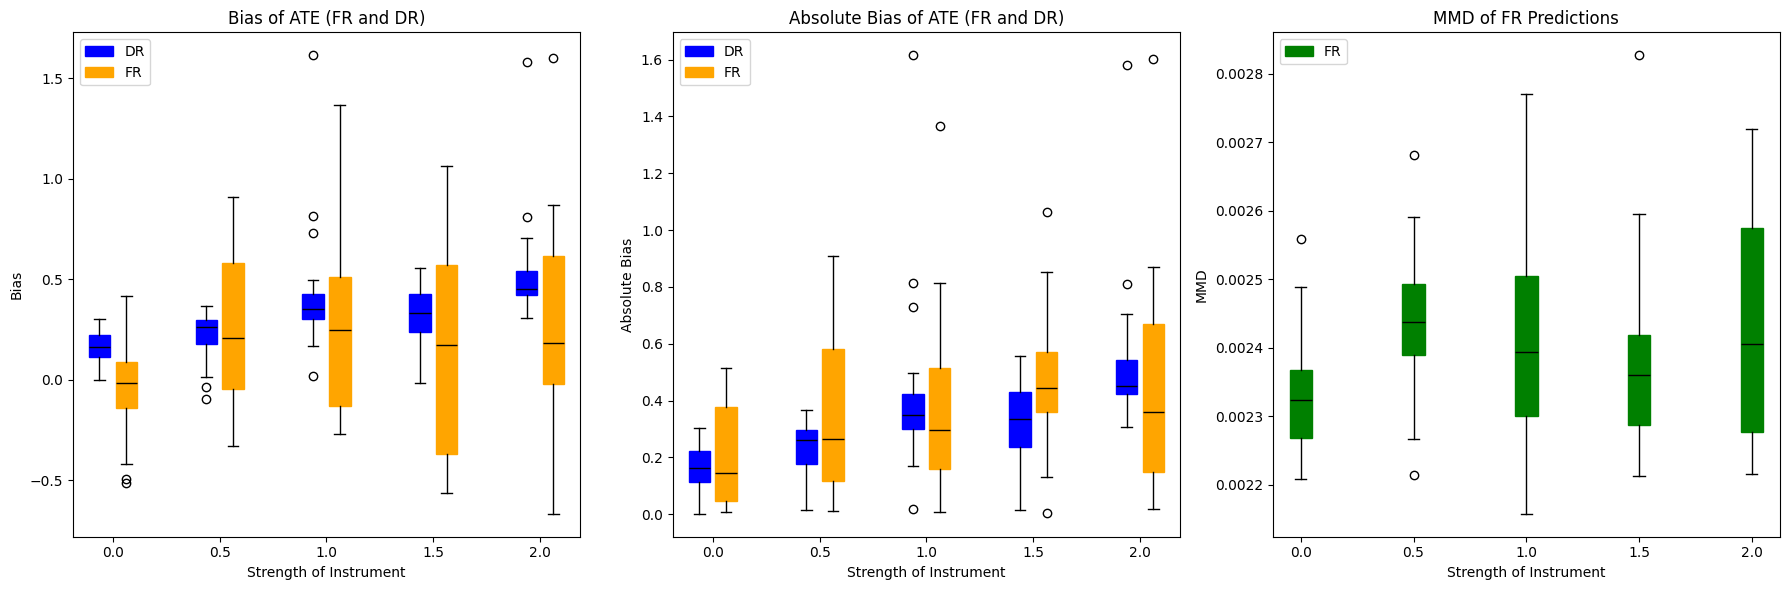

In [ ]:
# Define the true ATE (constant value)
true_ate = 2  # Replace with the actual true ATE value

# Prepare the data dictionary
data = {
    "strength_instr": [],
    "bias_dr": [],
    "bias_fr": [],
    "absolute_bias_dr": [],
    "absolute_bias_fr": [],
    "mmd_fr": [],
}

# Populate the data dictionary
for strength_instr in sorted(tracker.keys()):
    for i in range(len(tracker[strength_instr]["ate_dr"])):
        # Extract values
        ate_dr = tracker[strength_instr]["ate_dr"][i]  # Assuming the first element of tuple
        ate_fr = tracker[strength_instr]["ate_p"][i]  # Assuming similar structure for FR

        # Append values to the data dictionary
        data["strength_instr"].append(strength_instr)
        data["bias_dr"].append(ate_dr - true_ate)
        data["bias_fr"].append(ate_fr - true_ate)
        data["absolute_bias_dr"].append(abs(ate_dr - true_ate))
        data["absolute_bias_fr"].append(abs(ate_fr - true_ate))
        data["mmd_fr"].append(tracker[strength_instr]["mmd_joint"][i])

# Convert the data dictionary to a DataFrame
df = pd.DataFrame(data)

# Define colors for DR and FR
colors = {"DR": "blue", "FR": "orange"}

# Initialize figure
plt.figure(figsize=(18, 6))

# Bias plot
plt.subplot(1, 3, 1)
handles = []  # For legend
for idx, strength_instr in enumerate(sorted(df["strength_instr"].unique())):
    group_data = df[df["strength_instr"] == strength_instr]
    # DR boxplot
    bp_dr = plt.boxplot(
        group_data["bias_dr"],
        positions=[idx * 2],
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor=colors["DR"], color=colors["DR"]),
        medianprops=dict(color="black"),
        flierprops=dict(markeredgecolor="black"),
    )
    # Capture handle for DR
    if idx == 0:
        handles.append(bp_dr["boxes"][0])
    # FR boxplot
    bp_fr = plt.boxplot(
        group_data["bias_fr"],
        positions=[idx * 2 + 0.5],
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor=colors["FR"], color=colors["FR"]),
        medianprops=dict(color="black"),
        flierprops=dict(markeredgecolor="black"),
    )
    # Capture handle for FR
    if idx == 0:
        handles.append(bp_fr["boxes"][0])
plt.title("Bias of ATE (FR and DR)")
plt.ylabel("Bias")
plt.xlabel("Strength of Instrument")
plt.xticks(
    ticks=[idx * 2 + 0.25 for idx in range(len(sorted(df["strength_instr"].unique())))],
    labels=sorted(df["strength_instr"].unique()),
)
plt.legend(handles, ["DR", "FR"], loc="upper left")

# Absolute Bias plot
plt.subplot(1, 3, 2)
handles = []  # For legend
for idx, strength_instr in enumerate(sorted(df["strength_instr"].unique())):
    group_data = df[df["strength_instr"] == strength_instr]
    # DR boxplot
    bp_dr = plt.boxplot(
        group_data["absolute_bias_dr"],
        positions=[idx * 2],
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor=colors["DR"], color=colors["DR"]),
        medianprops=dict(color="black"),
        flierprops=dict(markeredgecolor="black"),
    )
    if idx == 0:
        handles.append(bp_dr["boxes"][0])
    # FR boxplot
    bp_fr = plt.boxplot(
        group_data["absolute_bias_fr"],
        positions=[idx * 2 + 0.5],
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor=colors["FR"], color=colors["FR"]),
        medianprops=dict(color="black"),
        flierprops=dict(markeredgecolor="black"),
    )
    if idx == 0:
        handles.append(bp_fr["boxes"][0])
plt.title("Absolute Bias of ATE (FR and DR)")
plt.ylabel("Absolute Bias")
plt.xlabel("Strength of Instrument")
plt.xticks(
    ticks=[idx * 2 + 0.25 for idx in range(len(sorted(df["strength_instr"].unique())))],
    labels=sorted(df["strength_instr"].unique()),
)
plt.legend(handles, ["DR", "FR"], loc="upper left")

# MMD plot
plt.subplot(1, 3, 3)
for idx, strength_instr in enumerate(sorted(df["strength_instr"].unique())):
    group_data = df[df["strength_instr"] == strength_instr]
    bp_mmd = plt.boxplot(
        group_data["mmd_fr"],
        positions=[idx * 2],
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor="green", color="green"),
        medianprops=dict(color="black"),
        flierprops=dict(markeredgecolor="black"),
    )
plt.title("MMD of FR Predictions")
plt.ylabel("MMD")
plt.xlabel("Strength of Instrument")
plt.xticks(
    ticks=[idx * 2 for idx in range(len(sorted(df["strength_instr"].unique())))],
    labels=sorted(df["strength_instr"].unique()),
)
plt.legend([bp_mmd["boxes"][0]], ["FR"], loc="upper left")

plt.tight_layout()
plt.suptitle("")  # Remove the automatic title
plt.show()


#### outcome regression models

In [7]:
nrep = 20  # Number of repetitions
n_tr = 1000  # Training sample size
n_p = 1000  # Testing sample size
strength_instr_values = np.arange(0, 2.5, 0.5)  # Varying strength of instrumental variables
nI = 2  # Fixed number of instrumental variables
nX = 2
nO = 2
nS = 3
binary_intervention = True
num_iters = 4000  # Fixed number of training iterations


# Initialize tracker for strength_instr
tracker = {strength_instr: {"ate_p": [], "ate_dr": []}
           for strength_instr in strength_instr_values}

# Begin loop over strength_instr
for strength_instr in strength_instr_values:
    print(f"Running experiments for strength_instr = {strength_instr}")
    p = nI + nX + nO + nS  # Update the number of covariates
    
    for rep in tqdm(range(nrep)):
        # Generate training and testing data
        df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
            torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
        y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)
        
        z_tr_np = df_tr[[f"X{i}" for i in range(1, p + 1)]].values
        x_tr_np = df_tr['A'].values
        y_tr_np = df_tr['y'].values

        model = Frengression(x_dim = x_tr.shape[1], y_dim = 1, z_dim =z_tr.shape[1], 
                             noise_dim=1, num_layer=3, hidden_dim=400, 
                             device=device, x_binary=binary_intervention, z_binary_dims=0)

        # Train Frengression model
        model.train_xz(torch.tensor(x_tr, dtype=torch.float32).view(-1, 1), 
                       torch.tensor(z_tr, dtype=torch.float32), num_iters=num_iters, lr=1e-4, print_every_iter=400)
        model.train_y(torch.tensor(x_tr, dtype=torch.float32).view(-1, 1), 
                      torch.tensor(z_tr, dtype=torch.float32), 
                      torch.tensor(y_tr, dtype=torch.float32).view(-1, 1), 
                      num_iters=num_iters, lr=1e-4, print_every_iter=400)
        x0=torch.tensor(np.array([0]*z_tr.shape[0])).reshape(x_tr.size())
        x1=torch.tensor(np.array([1]*z_tr.shape[0])).reshape(x_tr.size())
        xz0 = torch.cat([x0,z_tr],dim=1)
        xz1 = torch.cat([x1,z_tr],dim=1)
        # Sample model distributions
        P0 = model.predict_conditional(x0, xz0, sample_size=n_p).numpy().reshape(-1, 1)
        P1 = model.predict_conditional(x1, xz1, sample_size=n_p).numpy().reshape(-1, 1)
        ate_p = np.mean(P1) - np.mean(P0)

        # DR Estimation
        ate_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np, x_tr_np, y_tr_np, z_tr_np)

        # Log results
        tracker[strength_instr]["ate_p"].append(ate_p)
        tracker[strength_instr]["ate_dr"].append(ate_dr)

Running experiments for strength_instr = 0.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: loss 2.8630, loss1 2.9936, loss2 0.2613
Epoch 400: loss 2.1156, loss1 4.1890, loss2 4.1467
Epoch 800: loss 2.1029, loss1 4.1705, loss2 4.1352
Epoch 1200: loss 2.0922, loss1 4.2152, loss2 4.2460
Epoch 1600: loss 2.1195, loss1 4.1987, loss2 4.1583
Epoch 2000: loss 2.0899, loss1 4.1789, loss2 4.1780
Epoch 2400: loss 2.0849, loss1 4.1671, loss2 4.1645
Epoch 2800: loss 2.0730, loss1 4.1973, loss2 4.2487
Epoch 3200: loss 2.1163, loss1 4.2150, loss2 4.1974
Epoch 3600: loss 2.1044, loss1 4.1998, loss2 4.1907
Epoch 4000: loss 2.1119, loss1 4.2043, loss2 4.1848
Epoch 1: loss 2.2941,	loss_y 1.5215, 1.5999, 0.1569,	loss_eta 0.7726, 0.8096, 0.0739
Epoch 400: loss 1.4746,	loss_y 0.7824, 1.8723, 2.1797,	loss_eta 0.6922, 0.8236, 0.2629
Epoch 800: loss 1.2915,	loss_y 0.5870, 1.4494, 1.7249,	loss_eta 0.7045, 0.8592, 0.3095
Epoch 1200: loss 1.0702,	loss_y 0.4119, 0.9572, 1.0908,	loss_eta 0.6584, 1.0651, 0.8134
Epoch 1600: loss 1.5644,	loss_y 0.9032, 1.5649, 1.3235,	loss_eta 0.6612, 1.1981, 1.073

  5%|▌         | 1/20 [01:33<29:27, 93.05s/it]

Epoch 1: loss 2.8620, loss1 3.0163, loss2 0.3086
Epoch 400: loss 2.1356, loss1 4.2289, loss2 4.1867
Epoch 800: loss 2.1025, loss1 4.2015, loss2 4.1979
Epoch 1200: loss 2.1175, loss1 4.2298, loss2 4.2245
Epoch 1600: loss 2.1384, loss1 4.2269, loss2 4.1769
Epoch 2000: loss 2.1365, loss1 4.2466, loss2 4.2202
Epoch 2400: loss 2.0969, loss1 4.1865, loss2 4.1791
Epoch 2800: loss 2.1278, loss1 4.2251, loss2 4.1946
Epoch 3200: loss 2.1081, loss1 4.2078, loss2 4.1994
Epoch 3600: loss 2.1301, loss1 4.2117, loss2 4.1632
Epoch 4000: loss 2.0943, loss1 4.2140, loss2 4.2395
Epoch 1: loss 2.2438,	loss_y 1.4769, 1.4917, 0.0297,	loss_eta 0.7669, 0.8204, 0.1069
Epoch 400: loss 1.0032,	loss_y 0.4062, 0.8783, 0.9442,	loss_eta 0.5970, 0.8609, 0.5277
Epoch 800: loss 1.2979,	loss_y 0.6560, 1.8451, 2.3781,	loss_eta 0.6419, 0.8956, 0.5075
Epoch 1200: loss 1.0389,	loss_y 0.4449, 1.0445, 1.1991,	loss_eta 0.5940, 1.0429, 0.8979
Epoch 1600: loss 1.0361,	loss_y 0.4743, 0.9171, 0.8856,	loss_eta 0.5618, 1.1244, 1.125

 10%|█         | 2/20 [02:51<25:15, 84.21s/it]

Epoch 1: loss 2.8470, loss1 2.9931, loss2 0.2922
Epoch 400: loss 2.1245, loss1 4.2174, loss2 4.1857
Epoch 800: loss 2.0712, loss1 4.1699, loss2 4.1974
Epoch 1200: loss 2.0649, loss1 4.1720, loss2 4.2141
Epoch 1600: loss 2.1070, loss1 4.2580, loss2 4.3020
Epoch 2000: loss 2.0877, loss1 4.1972, loss2 4.2190
Epoch 2400: loss 2.1180, loss1 4.2241, loss2 4.2122
Epoch 2800: loss 2.1230, loss1 4.2051, loss2 4.1643
Epoch 3200: loss 2.1134, loss1 4.2478, loss2 4.2686
Epoch 3600: loss 2.0786, loss1 4.2065, loss2 4.2560
Epoch 4000: loss 2.1209, loss1 4.2057, loss2 4.1696
Epoch 1: loss 2.3124,	loss_y 1.5275, 1.5321, 0.0091,	loss_eta 0.7848, 0.8181, 0.0665
Epoch 400: loss 1.4206,	loss_y 0.6700, 1.2828, 1.2256,	loss_eta 0.7506, 1.6098, 1.7183
Epoch 800: loss 1.2473,	loss_y 0.5790, 1.0349, 0.9119,	loss_eta 0.6684, 0.9215, 0.5062
Epoch 1200: loss 1.0966,	loss_y 0.5238, 1.3248, 1.6020,	loss_eta 0.5728, 1.0987, 1.0518
Epoch 1600: loss 1.1603,	loss_y 0.6105, 1.7494, 2.2778,	loss_eta 0.5497, 1.1269, 1.154

 15%|█▌        | 3/20 [04:08<23:01, 81.25s/it]

Epoch 1: loss 2.8272, loss1 2.9695, loss2 0.2847
Epoch 400: loss 2.0711, loss1 4.1545, loss2 4.1667
Epoch 800: loss 2.0796, loss1 4.1734, loss2 4.1876
Epoch 1200: loss 2.1112, loss1 4.2075, loss2 4.1925
Epoch 1600: loss 2.0578, loss1 4.1500, loss2 4.1843
Epoch 2000: loss 2.0864, loss1 4.1669, loss2 4.1610
Epoch 2400: loss 2.0718, loss1 4.1663, loss2 4.1890
Epoch 2800: loss 2.0916, loss1 4.1860, loss2 4.1889
Epoch 3200: loss 2.1043, loss1 4.1840, loss2 4.1595
Epoch 3600: loss 2.0695, loss1 4.1636, loss2 4.1882
Epoch 4000: loss 2.0787, loss1 4.1575, loss2 4.1576
Epoch 1: loss 2.3042,	loss_y 1.5142, 1.5443, 0.0601,	loss_eta 0.7900, 0.8280, 0.0760
Epoch 400: loss 1.4997,	loss_y 0.7486, 1.6007, 1.7042,	loss_eta 0.7511, 0.7916, 0.0810
Epoch 800: loss 1.4483,	loss_y 0.7271, 1.9086, 2.3629,	loss_eta 0.7212, 0.8355, 0.2287
Epoch 1200: loss 1.4763,	loss_y 0.8263, 1.4425, 1.2324,	loss_eta 0.6500, 1.2544, 1.2088
Epoch 1600: loss 1.0596,	loss_y 0.4831, 1.3231, 1.6800,	loss_eta 0.5765, 1.2148, 1.276

 20%|██        | 4/20 [05:20<20:40, 77.50s/it]

Epoch 1: loss 2.8773, loss1 3.0108, loss2 0.2670
Epoch 400: loss 2.1057, loss1 4.2162, loss2 4.2210
Epoch 800: loss 2.1414, loss1 4.2611, loss2 4.2395
Epoch 1200: loss 2.1237, loss1 4.2138, loss2 4.1800
Epoch 1600: loss 2.1225, loss1 4.1984, loss2 4.1518
Epoch 2000: loss 2.1229, loss1 4.2176, loss2 4.1894
Epoch 2400: loss 2.0870, loss1 4.2124, loss2 4.2508
Epoch 2800: loss 2.1068, loss1 4.2049, loss2 4.1962
Epoch 3200: loss 2.1168, loss1 4.2150, loss2 4.1965
Epoch 3600: loss 2.0843, loss1 4.1925, loss2 4.2165
Epoch 4000: loss 2.1437, loss1 4.2521, loss2 4.2168
Epoch 1: loss 2.2308,	loss_y 1.4713, 1.4807, 0.0189,	loss_eta 0.7595, 0.7899, 0.0607
Epoch 400: loss 1.4078,	loss_y 0.6642, 1.2776, 1.2267,	loss_eta 0.7436, 0.8016, 0.1160
Epoch 800: loss 1.3896,	loss_y 0.8368, 1.1280, 0.5824,	loss_eta 0.5528, 1.0383, 0.9710
Epoch 1200: loss 1.1571,	loss_y 0.5654, 0.8886, 0.6463,	loss_eta 0.5917, 1.0572, 0.9311
Epoch 1600: loss 0.9980,	loss_y 0.4171, 0.9764, 1.1186,	loss_eta 0.5809, 1.0311, 0.900

 25%|██▌       | 5/20 [06:32<18:54, 75.61s/it]

Epoch 1: loss 2.8336, loss1 2.9815, loss2 0.2957
Epoch 400: loss 2.1101, loss1 4.2043, loss2 4.1884
Epoch 800: loss 2.0959, loss1 4.1790, loss2 4.1662
Epoch 1200: loss 2.0794, loss1 4.1758, loss2 4.1928
Epoch 1600: loss 2.0802, loss1 4.1662, loss2 4.1720
Epoch 2000: loss 2.1246, loss1 4.2089, loss2 4.1686
Epoch 2400: loss 2.0988, loss1 4.2052, loss2 4.2129
Epoch 2800: loss 2.1209, loss1 4.2145, loss2 4.1874
Epoch 3200: loss 2.0667, loss1 4.1676, loss2 4.2018
Epoch 3600: loss 2.0991, loss1 4.2373, loss2 4.2765
Epoch 4000: loss 2.1072, loss1 4.1806, loss2 4.1466
Epoch 1: loss 2.1945,	loss_y 1.4648, 1.5002, 0.0707,	loss_eta 0.7297, 0.7763, 0.0934
Epoch 400: loss 1.6283,	loss_y 0.9918, 2.1218, 2.2600,	loss_eta 0.6365, 0.9605, 0.6479
Epoch 800: loss 1.3123,	loss_y 0.5753, 1.3609, 1.5713,	loss_eta 0.7370, 0.7855, 0.0970
Epoch 1200: loss 1.1048,	loss_y 0.5485, 1.1612, 1.2254,	loss_eta 0.5563, 1.1628, 1.2129
Epoch 1600: loss 1.0717,	loss_y 0.4650, 0.8377, 0.7452,	loss_eta 0.6066, 1.1094, 1.005

 30%|███       | 6/20 [07:45<17:26, 74.77s/it]

Epoch 1: loss 2.8356, loss1 2.9859, loss2 0.3005
Epoch 400: loss 2.1210, loss1 4.1885, loss2 4.1349
Epoch 800: loss 2.0815, loss1 4.2035, loss2 4.2441
Epoch 1200: loss 2.0855, loss1 4.1788, loss2 4.1866
Epoch 1600: loss 2.0774, loss1 4.1775, loss2 4.2002
Epoch 2000: loss 2.1098, loss1 4.2072, loss2 4.1948
Epoch 2400: loss 2.0965, loss1 4.2116, loss2 4.2301
Epoch 2800: loss 2.1213, loss1 4.1942, loss2 4.1458
Epoch 3200: loss 2.0961, loss1 4.2084, loss2 4.2246
Epoch 3600: loss 2.0981, loss1 4.1965, loss2 4.1968
Epoch 4000: loss 2.1226, loss1 4.2270, loss2 4.2089
Epoch 1: loss 2.1870,	loss_y 1.4632, 1.4920, 0.0575,	loss_eta 0.7238, 0.7667, 0.0858
Epoch 400: loss 1.8600,	loss_y 1.1774, 2.7757, 3.1967,	loss_eta 0.6826, 1.0164, 0.6675
Epoch 800: loss 1.2280,	loss_y 0.6554, 1.7130, 2.1152,	loss_eta 0.5726, 0.9495, 0.7538
Epoch 1200: loss 1.1473,	loss_y 0.4920, 1.1976, 1.4111,	loss_eta 0.6553, 1.2735, 1.2365
Epoch 1600: loss 1.0256,	loss_y 0.4463, 0.7938, 0.6950,	loss_eta 0.5794, 0.9657, 0.772

 35%|███▌      | 7/20 [08:58<16:04, 74.18s/it]

Epoch 1: loss 2.7975, loss1 2.9417, loss2 0.2883
Epoch 400: loss 2.0946, loss1 4.1540, loss2 4.1189
Epoch 800: loss 2.0626, loss1 4.1138, loss2 4.1024
Epoch 1200: loss 2.0384, loss1 4.1168, loss2 4.1568
Epoch 1600: loss 2.1017, loss1 4.1304, loss2 4.0573
Epoch 2000: loss 2.0757, loss1 4.1526, loss2 4.1538
Epoch 2400: loss 2.0804, loss1 4.1522, loss2 4.1436
Epoch 2800: loss 2.0844, loss1 4.1496, loss2 4.1304
Epoch 3200: loss 2.0481, loss1 4.1028, loss2 4.1094
Epoch 3600: loss 2.1100, loss1 4.1537, loss2 4.0873
Epoch 4000: loss 2.0912, loss1 4.1713, loss2 4.1602
Epoch 1: loss 2.3780,	loss_y 1.6367, 1.6594, 0.0454,	loss_eta 0.7412, 0.7820, 0.0815
Epoch 400: loss 2.0518,	loss_y 1.4415, 3.4506, 4.0182,	loss_eta 0.6103, 0.9483, 0.6760
Epoch 800: loss 1.0257,	loss_y 0.4386, 1.0940, 1.3108,	loss_eta 0.5871, 1.2710, 1.3678
Epoch 1200: loss 1.3321,	loss_y 0.6590, 1.4065, 1.4950,	loss_eta 0.6731, 1.1135, 0.8808
Epoch 1600: loss 1.0877,	loss_y 0.4939, 1.3704, 1.7530,	loss_eta 0.5937, 1.0068, 0.826

 40%|████      | 8/20 [10:12<14:47, 73.97s/it]

Epoch 1: loss 2.8479, loss1 3.0008, loss2 0.3058
Epoch 400: loss 2.1006, loss1 4.1975, loss2 4.1939
Epoch 800: loss 2.1343, loss1 4.2153, loss2 4.1621
Epoch 1200: loss 2.1256, loss1 4.2052, loss2 4.1592
Epoch 1600: loss 2.1070, loss1 4.1930, loss2 4.1720
Epoch 2000: loss 2.0806, loss1 4.1919, loss2 4.2227
Epoch 2400: loss 2.1153, loss1 4.1882, loss2 4.1459
Epoch 2800: loss 2.0646, loss1 4.1685, loss2 4.2077
Epoch 3200: loss 2.1162, loss1 4.1970, loss2 4.1617
Epoch 3600: loss 2.1168, loss1 4.1961, loss2 4.1586
Epoch 4000: loss 2.1593, loss1 4.2552, loss2 4.1918
Epoch 1: loss 2.2640,	loss_y 1.4886, 1.5292, 0.0812,	loss_eta 0.7754, 0.8060, 0.0612
Epoch 400: loss 1.4441,	loss_y 0.7106, 1.7269, 2.0327,	loss_eta 0.7335, 0.8601, 0.2532
Epoch 800: loss 1.3009,	loss_y 0.5853, 1.2815, 1.3925,	loss_eta 0.7157, 1.3228, 1.2142
Epoch 1200: loss 1.2780,	loss_y 0.5572, 1.0302, 0.9460,	loss_eta 0.7207, 0.8446, 0.2478
Epoch 1600: loss 1.1078,	loss_y 0.4312, 1.0966, 1.3308,	loss_eta 0.6766, 1.2866, 1.220

 45%|████▌     | 9/20 [11:25<13:29, 73.55s/it]

Epoch 1: loss 2.8248, loss1 2.9684, loss2 0.2872
Epoch 400: loss 2.1316, loss1 4.2035, loss2 4.1438
Epoch 800: loss 2.0765, loss1 4.1764, loss2 4.1997
Epoch 1200: loss 2.0911, loss1 4.1941, loss2 4.2060
Epoch 1600: loss 2.0766, loss1 4.1692, loss2 4.1852
Epoch 2000: loss 2.0980, loss1 4.1693, loss2 4.1425
Epoch 2400: loss 2.0448, loss1 4.1290, loss2 4.1683
Epoch 2800: loss 2.1076, loss1 4.1807, loss2 4.1462
Epoch 3200: loss 2.0990, loss1 4.1669, loss2 4.1358
Epoch 3600: loss 2.1166, loss1 4.1882, loss2 4.1434
Epoch 4000: loss 2.0893, loss1 4.1904, loss2 4.2021
Epoch 1: loss 2.0993,	loss_y 1.3615, 1.3741, 0.0252,	loss_eta 0.7378, 0.7818, 0.0881
Epoch 400: loss 1.2241,	loss_y 0.5768, 0.9841, 0.8147,	loss_eta 0.6473, 1.1535, 1.0124
Epoch 800: loss 1.3455,	loss_y 0.6485, 1.1899, 1.0828,	loss_eta 0.6971, 0.8870, 0.3798
Epoch 1200: loss 1.1583,	loss_y 0.5272, 0.8266, 0.5989,	loss_eta 0.6311, 0.9254, 0.5886
Epoch 1600: loss 0.9425,	loss_y 0.3808, 0.8187, 0.8758,	loss_eta 0.5617, 1.2027, 1.281

 50%|█████     | 10/20 [12:39<12:17, 73.70s/it]

Epoch 1: loss 2.8423, loss1 2.9826, loss2 0.2806
Epoch 400: loss 2.0925, loss1 4.2011, loss2 4.2172
Epoch 800: loss 2.0880, loss1 4.1788, loss2 4.1817
Epoch 1200: loss 2.1106, loss1 4.1752, loss2 4.1292
Epoch 1600: loss 2.1052, loss1 4.1976, loss2 4.1847
Epoch 2000: loss 2.1042, loss1 4.1853, loss2 4.1622
Epoch 2400: loss 2.0877, loss1 4.1858, loss2 4.1962
Epoch 2800: loss 2.0869, loss1 4.1626, loss2 4.1515
Epoch 3200: loss 2.0818, loss1 4.1617, loss2 4.1598
Epoch 3600: loss 2.0673, loss1 4.1870, loss2 4.2394
Epoch 4000: loss 2.0514, loss1 4.1649, loss2 4.2270
Epoch 1: loss 2.1653,	loss_y 1.4103, 1.4506, 0.0806,	loss_eta 0.7551, 0.7879, 0.0656
Epoch 400: loss 1.5358,	loss_y 0.7676, 2.0097, 2.4843,	loss_eta 0.7682, 0.8092, 0.0819
Epoch 800: loss 1.2750,	loss_y 0.6258, 0.9955, 0.7394,	loss_eta 0.6493, 0.8225, 0.3464
Epoch 1200: loss 1.2796,	loss_y 0.5831, 1.3004, 1.4345,	loss_eta 0.6965, 1.1414, 0.8898
Epoch 1600: loss 1.1438,	loss_y 0.5717, 1.3530, 1.5627,	loss_eta 0.5721, 1.3886, 1.633

 55%|█████▌    | 11/20 [13:57<11:17, 75.28s/it]

Epoch 1: loss 2.7967, loss1 2.9484, loss2 0.3033
Epoch 400: loss 2.0714, loss1 4.1210, loss2 4.0993
Epoch 800: loss 2.1076, loss1 4.1559, loss2 4.0966
Epoch 1200: loss 2.0931, loss1 4.1485, loss2 4.1109
Epoch 1600: loss 2.0932, loss1 4.1598, loss2 4.1333
Epoch 2000: loss 2.0409, loss1 4.1187, loss2 4.1558
Epoch 2400: loss 2.0382, loss1 4.1229, loss2 4.1696
Epoch 2800: loss 2.0813, loss1 4.1455, loss2 4.1283
Epoch 3200: loss 2.0581, loss1 4.1075, loss2 4.0987
Epoch 3600: loss 2.0711, loss1 4.1544, loss2 4.1665
Epoch 4000: loss 2.0407, loss1 4.0983, loss2 4.1151
Epoch 1: loss 2.2742,	loss_y 1.5057, 1.5508, 0.0902,	loss_eta 0.7685, 0.8066, 0.0762
Epoch 400: loss 1.7905,	loss_y 1.0431, 2.7367, 3.3872,	loss_eta 0.7475, 0.8067, 0.1184
Epoch 800: loss 1.3270,	loss_y 0.6727, 1.8047, 2.2640,	loss_eta 0.6543, 1.0695, 0.8303
Epoch 1200: loss 1.0569,	loss_y 0.4652, 0.8749, 0.8194,	loss_eta 0.5917, 1.1695, 1.1557
Epoch 1600: loss 1.1472,	loss_y 0.5192, 1.0223, 1.0063,	loss_eta 0.6280, 1.0780, 0.900

 60%|██████    | 12/20 [15:17<10:12, 76.62s/it]

Epoch 1: loss 2.8206, loss1 2.9487, loss2 0.2563
Epoch 400: loss 2.0964, loss1 4.1614, loss2 4.1301
Epoch 800: loss 2.0523, loss1 4.1310, loss2 4.1575
Epoch 1200: loss 2.0963, loss1 4.1547, loss2 4.1168
Epoch 1600: loss 2.0650, loss1 4.1252, loss2 4.1203
Epoch 2000: loss 2.0793, loss1 4.1773, loss2 4.1961
Epoch 2400: loss 2.0524, loss1 4.1402, loss2 4.1755
Epoch 2800: loss 2.0537, loss1 4.1268, loss2 4.1461
Epoch 3200: loss 2.0808, loss1 4.1170, loss2 4.0724
Epoch 3600: loss 2.0714, loss1 4.1137, loss2 4.0846
Epoch 4000: loss 2.0794, loss1 4.1675, loss2 4.1762
Epoch 1: loss 2.2534,	loss_y 1.5245, 1.5402, 0.0316,	loss_eta 0.7289, 0.7710, 0.0842
Epoch 400: loss 1.7143,	loss_y 0.9527, 1.9389, 1.9723,	loss_eta 0.7616, 1.1411, 0.7590
Epoch 800: loss 1.5095,	loss_y 0.8053, 1.6212, 1.6319,	loss_eta 0.7043, 0.9208, 0.4330
Epoch 1200: loss 1.2948,	loss_y 0.6414, 1.2251, 1.1673,	loss_eta 0.6533, 0.9104, 0.5140
Epoch 1600: loss 0.9698,	loss_y 0.3918, 0.8729, 0.9622,	loss_eta 0.5780, 1.3432, 1.530

 65%|██████▌   | 13/20 [16:36<09:01, 77.35s/it]

Epoch 1: loss 2.8739, loss1 3.0179, loss2 0.2879
Epoch 400: loss 2.1143, loss1 4.1947, loss2 4.1607
Epoch 800: loss 2.1224, loss1 4.2429, loss2 4.2410
Epoch 1200: loss 2.1170, loss1 4.2294, loss2 4.2249
Epoch 1600: loss 2.0921, loss1 4.2414, loss2 4.2985
Epoch 2000: loss 2.0999, loss1 4.2321, loss2 4.2644
Epoch 2400: loss 2.0817, loss1 4.2188, loss2 4.2742
Epoch 2800: loss 2.1113, loss1 4.2044, loss2 4.1863
Epoch 3200: loss 2.1430, loss1 4.2393, loss2 4.1927
Epoch 3600: loss 2.1223, loss1 4.2565, loss2 4.2684
Epoch 4000: loss 2.0793, loss1 4.2058, loss2 4.2530
Epoch 1: loss 2.2879,	loss_y 1.5026, 1.5186, 0.0320,	loss_eta 0.7853, 0.8165, 0.0624
Epoch 400: loss 2.2251,	loss_y 1.4749, 2.5329, 2.1159,	loss_eta 0.7502, 0.8286, 0.1569
Epoch 800: loss 1.3001,	loss_y 0.6371, 1.6987, 2.1232,	loss_eta 0.6630, 1.0741, 0.8221
Epoch 1200: loss 1.1698,	loss_y 0.5874, 1.0234, 0.8720,	loss_eta 0.5824, 0.9087, 0.6525
Epoch 1600: loss 0.9892,	loss_y 0.3909, 0.8975, 1.0133,	loss_eta 0.5983, 1.2060, 1.215

 70%|███████   | 14/20 [17:51<07:40, 76.72s/it]

Epoch 1: loss 2.8073, loss1 2.9518, loss2 0.2890
Epoch 400: loss 2.0545, loss1 4.1160, loss2 4.1232
Epoch 800: loss 2.0956, loss1 4.1560, loss2 4.1209
Epoch 1200: loss 2.0653, loss1 4.1417, loss2 4.1529
Epoch 1600: loss 2.0504, loss1 4.1461, loss2 4.1914
Epoch 2000: loss 2.0732, loss1 4.1353, loss2 4.1242
Epoch 2400: loss 2.0703, loss1 4.1440, loss2 4.1474
Epoch 2800: loss 2.0822, loss1 4.1395, loss2 4.1148
Epoch 3200: loss 2.0407, loss1 4.1307, loss2 4.1798
Epoch 3600: loss 2.0433, loss1 4.1264, loss2 4.1663
Epoch 4000: loss 2.0750, loss1 4.1412, loss2 4.1323
Epoch 1: loss 2.3104,	loss_y 1.5450, 1.5733, 0.0567,	loss_eta 0.7655, 0.8051, 0.0793
Epoch 400: loss 1.7365,	loss_y 1.0779, 2.4039, 2.6521,	loss_eta 0.6586, 1.0279, 0.7386
Epoch 800: loss 1.1922,	loss_y 0.5369, 0.7826, 0.4914,	loss_eta 0.6553, 1.1371, 0.9637
Epoch 1200: loss 1.4320,	loss_y 0.7874, 1.5823, 1.5900,	loss_eta 0.6446, 0.9019, 0.5146
Epoch 1600: loss 1.0846,	loss_y 0.5238, 1.4540, 1.8604,	loss_eta 0.5608, 1.3912, 1.660

 75%|███████▌  | 15/20 [19:06<06:20, 76.11s/it]

Epoch 1: loss 2.8309, loss1 2.9723, loss2 0.2829
Epoch 400: loss 2.0577, loss1 4.1482, loss2 4.1811
Epoch 800: loss 2.0953, loss1 4.1726, loss2 4.1546
Epoch 1200: loss 2.1000, loss1 4.1819, loss2 4.1637
Epoch 1600: loss 2.0992, loss1 4.1783, loss2 4.1582
Epoch 2000: loss 2.0933, loss1 4.1926, loss2 4.1987
Epoch 2400: loss 2.0878, loss1 4.1607, loss2 4.1459
Epoch 2800: loss 2.0855, loss1 4.1711, loss2 4.1711
Epoch 3200: loss 2.0765, loss1 4.1725, loss2 4.1920
Epoch 3600: loss 2.0922, loss1 4.1894, loss2 4.1945
Epoch 4000: loss 2.0918, loss1 4.1646, loss2 4.1455
Epoch 1: loss 2.3115,	loss_y 1.5442, 1.5575, 0.0265,	loss_eta 0.7673, 0.8021, 0.0696
Epoch 400: loss 1.7610,	loss_y 1.1430, 2.8603, 3.4344,	loss_eta 0.6180, 0.9558, 0.6756
Epoch 800: loss 1.2648,	loss_y 0.6903, 2.0538, 2.7270,	loss_eta 0.5745, 1.2326, 1.3164
Epoch 1200: loss 1.0954,	loss_y 0.4659, 1.3115, 1.6911,	loss_eta 0.6295, 0.9945, 0.7301
Epoch 1600: loss 1.2268,	loss_y 0.6269, 1.2218, 1.1898,	loss_eta 0.5999, 1.3043, 1.408

 80%|████████  | 16/20 [20:26<05:08, 77.15s/it]

Epoch 1: loss 2.8244, loss1 2.9704, loss2 0.2920
Epoch 400: loss 2.0986, loss1 4.1824, loss2 4.1676
Epoch 800: loss 2.0859, loss1 4.1664, loss2 4.1610
Epoch 1200: loss 2.0989, loss1 4.1819, loss2 4.1659
Epoch 1600: loss 2.0698, loss1 4.1572, loss2 4.1747
Epoch 2000: loss 2.1127, loss1 4.1840, loss2 4.1426
Epoch 2400: loss 2.0874, loss1 4.1635, loss2 4.1521
Epoch 2800: loss 2.0899, loss1 4.1890, loss2 4.1982
Epoch 3200: loss 2.0565, loss1 4.1495, loss2 4.1860
Epoch 3600: loss 2.0857, loss1 4.1936, loss2 4.2157
Epoch 4000: loss 2.0877, loss1 4.1874, loss2 4.1994
Epoch 1: loss 2.1878,	loss_y 1.4687, 1.5017, 0.0661,	loss_eta 0.7192, 0.7533, 0.0683
Epoch 400: loss 1.7340,	loss_y 1.0504, 1.5285, 0.9562,	loss_eta 0.6837, 0.8697, 0.3721
Epoch 800: loss 1.3513,	loss_y 0.6193, 1.3854, 1.5322,	loss_eta 0.7320, 1.3238, 1.1837
Epoch 1200: loss 1.2330,	loss_y 0.5885, 0.9456, 0.7141,	loss_eta 0.6445, 0.8522, 0.4153
Epoch 1600: loss 1.0956,	loss_y 0.5192, 1.2083, 1.3782,	loss_eta 0.5764, 1.5713, 1.989

 85%|████████▌ | 17/20 [21:45<03:53, 77.75s/it]

Epoch 1: loss 2.8656, loss1 3.0030, loss2 0.2747
Epoch 400: loss 2.0685, loss1 4.1713, loss2 4.2056
Epoch 800: loss 2.1246, loss1 4.2001, loss2 4.1510
Epoch 1200: loss 2.0697, loss1 4.1970, loss2 4.2546
Epoch 1600: loss 2.1033, loss1 4.2115, loss2 4.2165
Epoch 2000: loss 2.1003, loss1 4.2040, loss2 4.2075
Epoch 2400: loss 2.1377, loss1 4.2416, loss2 4.2079
Epoch 2800: loss 2.1336, loss1 4.2385, loss2 4.2097
Epoch 3200: loss 2.0893, loss1 4.1888, loss2 4.1989
Epoch 3600: loss 2.0907, loss1 4.2004, loss2 4.2193
Epoch 4000: loss 2.1187, loss1 4.2221, loss2 4.2067
Epoch 1: loss 2.2147,	loss_y 1.4421, 1.4597, 0.0352,	loss_eta 0.7725, 0.8115, 0.0780
Epoch 400: loss 1.3035,	loss_y 0.7345, 1.9064, 2.3437,	loss_eta 0.5689, 1.0540, 0.9701
Epoch 800: loss 1.1776,	loss_y 0.6265, 1.1898, 1.1266,	loss_eta 0.5512, 1.3690, 1.6357
Epoch 1200: loss 1.0431,	loss_y 0.4574, 0.9500, 0.9851,	loss_eta 0.5857, 1.0338, 0.8963
Epoch 1600: loss 1.0882,	loss_y 0.5292, 0.8971, 0.7359,	loss_eta 0.5590, 1.1433, 1.168

 90%|█████████ | 18/20 [23:05<02:37, 78.61s/it]

Epoch 1: loss 2.7810, loss1 2.9233, loss2 0.2846
Epoch 400: loss 2.0636, loss1 4.1126, loss2 4.0980
Epoch 800: loss 2.0887, loss1 4.1079, loss2 4.0385
Epoch 1200: loss 2.0773, loss1 4.1256, loss2 4.0965
Epoch 1600: loss 2.0626, loss1 4.1301, loss2 4.1350
Epoch 2000: loss 2.0456, loss1 4.1109, loss2 4.1306
Epoch 2400: loss 2.0545, loss1 4.1339, loss2 4.1588
Epoch 2800: loss 2.0561, loss1 4.0980, loss2 4.0837
Epoch 3200: loss 2.0596, loss1 4.0808, loss2 4.0423
Epoch 3600: loss 2.0397, loss1 4.0914, loss2 4.1035
Epoch 4000: loss 2.0579, loss1 4.1128, loss2 4.1098
Epoch 1: loss 2.1309,	loss_y 1.3863, 1.4158, 0.0590,	loss_eta 0.7445, 0.7923, 0.0955
Epoch 400: loss 1.5180,	loss_y 0.9076, 2.1105, 2.4058,	loss_eta 0.6105, 0.9540, 0.6870
Epoch 800: loss 1.4289,	loss_y 0.8257, 1.6811, 1.7109,	loss_eta 0.6033, 1.0363, 0.8660
Epoch 1200: loss 1.0453,	loss_y 0.4984, 0.8311, 0.6654,	loss_eta 0.5468, 1.3468, 1.5999
Epoch 1600: loss 1.1820,	loss_y 0.5642, 0.9146, 0.7009,	loss_eta 0.6178, 1.1033, 0.971

 95%|█████████▌| 19/20 [24:24<01:18, 78.54s/it]

Epoch 1: loss 2.8387, loss1 2.9779, loss2 0.2783
Epoch 400: loss 2.1070, loss1 4.1998, loss2 4.1856
Epoch 800: loss 2.1007, loss1 4.1988, loss2 4.1963
Epoch 1200: loss 2.0758, loss1 4.1646, loss2 4.1776
Epoch 1600: loss 2.1207, loss1 4.1881, loss2 4.1347
Epoch 2000: loss 2.0938, loss1 4.1765, loss2 4.1654
Epoch 2400: loss 2.1130, loss1 4.1816, loss2 4.1371
Epoch 2800: loss 2.1208, loss1 4.1941, loss2 4.1467
Epoch 3200: loss 2.0825, loss1 4.1857, loss2 4.2063
Epoch 3600: loss 2.0962, loss1 4.1953, loss2 4.1982
Epoch 4000: loss 2.1052, loss1 4.2009, loss2 4.1915
Epoch 1: loss 2.2486,	loss_y 1.4705, 1.4915, 0.0420,	loss_eta 0.7781, 0.8078, 0.0595
Epoch 400: loss 1.3628,	loss_y 0.7295, 1.0490, 0.6389,	loss_eta 0.6333, 0.8412, 0.4158
Epoch 800: loss 1.1012,	loss_y 0.4981, 1.1174, 1.2385,	loss_eta 0.6031, 0.8979, 0.5897
Epoch 1200: loss 1.0520,	loss_y 0.4545, 0.9269, 0.9449,	loss_eta 0.5975, 1.1941, 1.1932
Epoch 1600: loss 0.9795,	loss_y 0.4126, 1.1878, 1.5505,	loss_eta 0.5669, 1.1960, 1.258

100%|██████████| 20/20 [25:39<00:00, 76.97s/it]


Running experiments for strength_instr = 0.5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: loss 2.8351, loss1 2.9892, loss2 0.3082
Epoch 400: loss 2.0850, loss1 4.1683, loss2 4.1665
Epoch 800: loss 2.0893, loss1 4.1654, loss2 4.1521
Epoch 1200: loss 2.0934, loss1 4.1987, loss2 4.2108
Epoch 1600: loss 2.0688, loss1 4.1840, loss2 4.2306
Epoch 2000: loss 2.0857, loss1 4.1928, loss2 4.2142
Epoch 2400: loss 2.1238, loss1 4.1909, loss2 4.1341
Epoch 2800: loss 2.1052, loss1 4.2223, loss2 4.2342
Epoch 3200: loss 2.1134, loss1 4.1815, loss2 4.1363
Epoch 3600: loss 2.0831, loss1 4.1743, loss2 4.1824
Epoch 4000: loss 2.1149, loss1 4.2153, loss2 4.2007
Epoch 1: loss 2.4612,	loss_y 1.6910, 1.7130, 0.0440,	loss_eta 0.7702, 0.8038, 0.0672
Epoch 400: loss 1.6016,	loss_y 0.8000, 1.6455, 1.6911,	loss_eta 0.8016, 0.8506, 0.0980
Epoch 800: loss 1.6410,	loss_y 0.9036, 1.6584, 1.5097,	loss_eta 0.7375, 0.8126, 0.1502
Epoch 1200: loss 1.3953,	loss_y 0.7481, 1.1925, 0.8889,	loss_eta 0.6472, 0.9239, 0.5534
Epoch 1600: loss 1.3085,	loss_y 0.6892, 1.3797, 1.3811,	loss_eta 0.6194, 1.0705, 0.902

  5%|▌         | 1/20 [01:19<25:08, 79.40s/it]

Epoch 1: loss 2.8396, loss1 2.9899, loss2 0.3007
Epoch 400: loss 2.0945, loss1 4.1977, loss2 4.2065
Epoch 800: loss 2.1330, loss1 4.1888, loss2 4.1114
Epoch 1200: loss 2.1059, loss1 4.1927, loss2 4.1737
Epoch 1600: loss 2.1142, loss1 4.2080, loss2 4.1876
Epoch 2000: loss 2.0817, loss1 4.1691, loss2 4.1748
Epoch 2400: loss 2.0882, loss1 4.1909, loss2 4.2053
Epoch 2800: loss 2.0831, loss1 4.1952, loss2 4.2243
Epoch 3200: loss 2.1093, loss1 4.1939, loss2 4.1692
Epoch 3600: loss 2.1091, loss1 4.2179, loss2 4.2175
Epoch 4000: loss 2.1268, loss1 4.2100, loss2 4.1663
Epoch 1: loss 2.3032,	loss_y 1.5462, 1.5680, 0.0436,	loss_eta 0.7570, 0.8000, 0.0862
Epoch 400: loss 1.9862,	loss_y 1.2989, 2.7570, 2.9161,	loss_eta 0.6873, 0.8226, 0.2706
Epoch 800: loss 1.1008,	loss_y 0.5457, 1.3836, 1.6758,	loss_eta 0.5551, 1.0178, 0.9254
Epoch 1200: loss 1.0732,	loss_y 0.4525, 0.8932, 0.8813,	loss_eta 0.6207, 1.1939, 1.1464
Epoch 1600: loss 1.0277,	loss_y 0.4124, 0.9274, 1.0299,	loss_eta 0.6152, 1.0794, 0.928

 10%|█         | 2/20 [02:34<23:04, 76.94s/it]

Epoch 1: loss 2.8616, loss1 3.0072, loss2 0.2911
Epoch 400: loss 2.1278, loss1 4.2343, loss2 4.2131
Epoch 800: loss 2.0897, loss1 4.2321, loss2 4.2846
Epoch 1200: loss 2.1060, loss1 4.1938, loss2 4.1758
Epoch 1600: loss 2.1275, loss1 4.2283, loss2 4.2016
Epoch 2000: loss 2.1144, loss1 4.2402, loss2 4.2516
Epoch 2400: loss 2.1187, loss1 4.2322, loss2 4.2269
Epoch 2800: loss 2.1356, loss1 4.2413, loss2 4.2115
Epoch 3200: loss 2.1337, loss1 4.2383, loss2 4.2092
Epoch 3600: loss 2.0912, loss1 4.2029, loss2 4.2235
Epoch 4000: loss 2.1209, loss1 4.2586, loss2 4.2755
Epoch 1: loss 2.4026,	loss_y 1.6377, 1.6475, 0.0197,	loss_eta 0.7650, 0.7964, 0.0628
Epoch 400: loss 1.4372,	loss_y 0.7547, 1.4221, 1.3348,	loss_eta 0.6825, 0.8769, 0.3888
Epoch 800: loss 1.3572,	loss_y 0.6238, 1.5737, 1.8999,	loss_eta 0.7334, 0.8349, 0.2030
Epoch 1200: loss 1.2154,	loss_y 0.5640, 1.3732, 1.6184,	loss_eta 0.6514, 1.0107, 0.7186
Epoch 1600: loss 1.3154,	loss_y 0.6174, 1.2328, 1.2307,	loss_eta 0.6979, 0.9047, 0.413

 15%|█▌        | 3/20 [03:49<21:35, 76.22s/it]

Epoch 1: loss 2.8187, loss1 2.9788, loss2 0.3203
Epoch 400: loss 2.0834, loss1 4.1584, loss2 4.1501
Epoch 800: loss 2.0870, loss1 4.1683, loss2 4.1626
Epoch 1200: loss 2.0526, loss1 4.1482, loss2 4.1911
Epoch 1600: loss 2.0781, loss1 4.1602, loss2 4.1642
Epoch 2000: loss 2.0652, loss1 4.1151, loss2 4.0998
Epoch 2400: loss 2.1070, loss1 4.1931, loss2 4.1724
Epoch 2800: loss 2.0655, loss1 4.1333, loss2 4.1355
Epoch 3200: loss 2.0874, loss1 4.1749, loss2 4.1751
Epoch 3600: loss 2.1059, loss1 4.1852, loss2 4.1585
Epoch 4000: loss 2.0602, loss1 4.1606, loss2 4.2008
Epoch 1: loss 2.3062,	loss_y 1.5701, 1.5865, 0.0328,	loss_eta 0.7361, 0.7684, 0.0645
Epoch 400: loss 1.9629,	loss_y 1.2193, 1.8791, 1.3198,	loss_eta 0.7437, 0.8123, 0.1373
Epoch 800: loss 1.1249,	loss_y 0.5081, 1.0570, 1.0978,	loss_eta 0.6168, 1.0460, 0.8584
Epoch 1200: loss 1.1483,	loss_y 0.5369, 1.0239, 0.9740,	loss_eta 0.6114, 0.9594, 0.6959
Epoch 1600: loss 1.1397,	loss_y 0.5557, 1.2395, 1.3675,	loss_eta 0.5840, 0.9821, 0.796

 20%|██        | 4/20 [05:08<20:34, 77.15s/it]

Epoch 1: loss 2.8577, loss1 2.9901, loss2 0.2648
Epoch 400: loss 2.1188, loss1 4.2213, loss2 4.2049
Epoch 800: loss 2.0850, loss1 4.1943, loss2 4.2185
Epoch 1200: loss 2.0793, loss1 4.1852, loss2 4.2119
Epoch 1600: loss 2.0798, loss1 4.1957, loss2 4.2318
Epoch 2000: loss 2.0921, loss1 4.2162, loss2 4.2482
Epoch 2400: loss 2.1119, loss1 4.2284, loss2 4.2329
Epoch 2800: loss 2.0982, loss1 4.2255, loss2 4.2545
Epoch 3200: loss 2.1151, loss1 4.2124, loss2 4.1946
Epoch 3600: loss 2.1293, loss1 4.2281, loss2 4.1977
Epoch 4000: loss 2.0901, loss1 4.1686, loss2 4.1570
Epoch 1: loss 2.3114,	loss_y 1.5526, 1.5617, 0.0181,	loss_eta 0.7588, 0.8000, 0.0825
Epoch 400: loss 1.6347,	loss_y 0.9560, 1.7123, 1.5127,	loss_eta 0.6788, 0.8447, 0.3320
Epoch 800: loss 1.6533,	loss_y 0.9434, 1.8425, 1.7982,	loss_eta 0.7099, 1.1852, 0.9506
Epoch 1200: loss 1.1904,	loss_y 0.5041, 1.0475, 1.0868,	loss_eta 0.6863, 1.3459, 1.3191
Epoch 1600: loss 1.0838,	loss_y 0.5283, 1.2567, 1.4568,	loss_eta 0.5555, 1.1974, 1.283

 25%|██▌       | 5/20 [06:25<19:15, 77.03s/it]

Epoch 1: loss 2.7947, loss1 2.9354, loss2 0.2814
Epoch 400: loss 2.0862, loss1 4.1122, loss2 4.0520
Epoch 800: loss 2.0569, loss1 4.1102, loss2 4.1067
Epoch 1200: loss 2.0678, loss1 4.0980, loss2 4.0603
Epoch 1600: loss 2.1018, loss1 4.1515, loss2 4.0994
Epoch 2000: loss 2.0664, loss1 4.1092, loss2 4.0857
Epoch 2400: loss 2.0540, loss1 4.1239, loss2 4.1400
Epoch 2800: loss 2.0400, loss1 4.0951, loss2 4.1103
Epoch 3200: loss 2.0874, loss1 4.1318, loss2 4.0888
Epoch 3600: loss 2.0906, loss1 4.1640, loss2 4.1469
Epoch 4000: loss 2.0833, loss1 4.1263, loss2 4.0859
Epoch 1: loss 2.2317,	loss_y 1.5131, 1.5524, 0.0786,	loss_eta 0.7186, 0.7572, 0.0773
Epoch 400: loss 1.2249,	loss_y 0.5565, 1.3397, 1.5664,	loss_eta 0.6684, 0.8901, 0.4434
Epoch 800: loss 1.6124,	loss_y 0.8694, 1.7352, 1.7315,	loss_eta 0.7430, 0.8331, 0.1803
Epoch 1200: loss 1.1472,	loss_y 0.5430, 0.8535, 0.6209,	loss_eta 0.6042, 0.9436, 0.6787
Epoch 1600: loss 1.0521,	loss_y 0.5108, 1.1745, 1.3275,	loss_eta 0.5414, 1.2098, 1.336

 30%|███       | 6/20 [07:41<17:53, 76.67s/it]

Epoch 1: loss 2.8417, loss1 2.9836, loss2 0.2836
Epoch 400: loss 2.0987, loss1 4.1995, loss2 4.2017
Epoch 800: loss 2.0796, loss1 4.1756, loss2 4.1920
Epoch 1200: loss 2.1156, loss1 4.2248, loss2 4.2184
Epoch 1600: loss 2.1032, loss1 4.1918, loss2 4.1772
Epoch 2000: loss 2.0938, loss1 4.2107, loss2 4.2338
Epoch 2400: loss 2.0988, loss1 4.2155, loss2 4.2334
Epoch 2800: loss 2.1212, loss1 4.2093, loss2 4.1762
Epoch 3200: loss 2.1197, loss1 4.2266, loss2 4.2140
Epoch 3600: loss 2.0939, loss1 4.1998, loss2 4.2117
Epoch 4000: loss 2.0754, loss1 4.2063, loss2 4.2619
Epoch 1: loss 2.3343,	loss_y 1.5797, 1.5903, 0.0214,	loss_eta 0.7546, 0.7945, 0.0798
Epoch 400: loss 1.3231,	loss_y 0.6628, 1.8150, 2.3044,	loss_eta 0.6604, 0.9373, 0.5540
Epoch 800: loss 1.3419,	loss_y 0.6246, 1.6923, 2.1355,	loss_eta 0.7174, 0.8312, 0.2276
Epoch 1200: loss 1.3714,	loss_y 0.6722, 1.0589, 0.7733,	loss_eta 0.6992, 0.8742, 0.3500
Epoch 1600: loss 1.2326,	loss_y 0.5562, 1.4705, 1.8286,	loss_eta 0.6765, 1.1667, 0.980

 35%|███▌      | 7/20 [08:56<16:32, 76.32s/it]

Epoch 1: loss 2.8194, loss1 2.9738, loss2 0.3087
Epoch 400: loss 2.0746, loss1 4.1666, loss2 4.1841
Epoch 800: loss 2.1111, loss1 4.1508, loss2 4.0794
Epoch 1200: loss 2.1019, loss1 4.1778, loss2 4.1519
Epoch 1600: loss 2.1170, loss1 4.1850, loss2 4.1361
Epoch 2000: loss 2.0868, loss1 4.1232, loss2 4.0727
Epoch 2400: loss 2.0900, loss1 4.1351, loss2 4.0903
Epoch 2800: loss 2.0528, loss1 4.1579, loss2 4.2102
Epoch 3200: loss 2.0755, loss1 4.1290, loss2 4.1070
Epoch 3600: loss 2.0749, loss1 4.1636, loss2 4.1774
Epoch 4000: loss 2.0664, loss1 4.1442, loss2 4.1555
Epoch 1: loss 2.3805,	loss_y 1.6055, 1.6242, 0.0374,	loss_eta 0.7749, 0.8110, 0.0722
Epoch 400: loss 1.7781,	loss_y 1.0295, 2.4739, 2.8888,	loss_eta 0.7486, 0.8217, 0.1464
Epoch 800: loss 1.4995,	loss_y 0.7287, 1.6888, 1.9203,	loss_eta 0.7708, 0.7888, 0.0359
Epoch 1200: loss 1.0532,	loss_y 0.4804, 0.8727, 0.7847,	loss_eta 0.5728, 1.0238, 0.9019
Epoch 1600: loss 1.0493,	loss_y 0.4943, 1.0655, 1.1425,	loss_eta 0.5550, 0.9725, 0.834

 40%|████      | 8/20 [10:10<15:05, 75.43s/it]

Epoch 1: loss 2.8197, loss1 2.9708, loss2 0.3022
Epoch 400: loss 2.0860, loss1 4.1708, loss2 4.1696
Epoch 800: loss 2.0648, loss1 4.1754, loss2 4.2212
Epoch 1200: loss 2.1337, loss1 4.2043, loss2 4.1411
Epoch 1600: loss 2.0955, loss1 4.1893, loss2 4.1876
Epoch 2000: loss 2.1261, loss1 4.2057, loss2 4.1591
Epoch 2400: loss 2.1121, loss1 4.1893, loss2 4.1545
Epoch 2800: loss 2.1082, loss1 4.1741, loss2 4.1318
Epoch 3200: loss 2.0831, loss1 4.1814, loss2 4.1966
Epoch 3600: loss 2.1077, loss1 4.1986, loss2 4.1817
Epoch 4000: loss 2.0800, loss1 4.1859, loss2 4.2118
Epoch 1: loss 2.3697,	loss_y 1.6241, 1.6753, 0.1024,	loss_eta 0.7456, 0.7832, 0.0753
Epoch 400: loss 1.4312,	loss_y 0.7319, 1.2682, 1.0726,	loss_eta 0.6993, 0.9719, 0.5453
Epoch 800: loss 1.7668,	loss_y 1.0788, 1.5843, 1.0110,	loss_eta 0.6880, 0.9804, 0.5849
Epoch 1200: loss 1.1957,	loss_y 0.5419, 1.2209, 1.3580,	loss_eta 0.6539, 0.9896, 0.6715
Epoch 1600: loss 1.1760,	loss_y 0.5163, 1.2414, 1.4502,	loss_eta 0.6597, 1.0758, 0.832

 45%|████▌     | 9/20 [11:27<13:53, 75.80s/it]

Epoch 1: loss 2.8285, loss1 2.9748, loss2 0.2926
Epoch 400: loss 2.1047, loss1 4.1713, loss2 4.1332
Epoch 800: loss 2.1175, loss1 4.1807, loss2 4.1264
Epoch 1200: loss 2.1185, loss1 4.2018, loss2 4.1666
Epoch 1600: loss 2.0798, loss1 4.1695, loss2 4.1794
Epoch 2000: loss 2.0650, loss1 4.1466, loss2 4.1632
Epoch 2400: loss 2.1063, loss1 4.1992, loss2 4.1858
Epoch 2800: loss 2.0958, loss1 4.1651, loss2 4.1387
Epoch 3200: loss 2.0875, loss1 4.2031, loss2 4.2312
Epoch 3600: loss 2.0817, loss1 4.1992, loss2 4.2350
Epoch 4000: loss 2.0943, loss1 4.2067, loss2 4.2248
Epoch 1: loss 2.3720,	loss_y 1.6079, 1.6135, 0.0112,	loss_eta 0.7641, 0.8003, 0.0724
Epoch 400: loss 1.5260,	loss_y 0.8217, 1.7731, 1.9027,	loss_eta 0.7042, 0.8875, 0.3665
Epoch 800: loss 1.4753,	loss_y 0.9072, 1.9730, 2.1315,	loss_eta 0.5681, 1.0111, 0.8860
Epoch 1200: loss 1.4075,	loss_y 0.7636, 1.8859, 2.2447,	loss_eta 0.6439, 1.1473, 1.0068
Epoch 1600: loss 1.0414,	loss_y 0.4537, 1.1678, 1.4282,	loss_eta 0.5877, 1.2015, 1.227

 50%|█████     | 10/20 [12:41<12:34, 75.43s/it]

Epoch 1: loss 2.8289, loss1 2.9816, loss2 0.3055
Epoch 400: loss 2.0613, loss1 4.1539, loss2 4.1852
Epoch 800: loss 2.0679, loss1 4.1574, loss2 4.1789
Epoch 1200: loss 2.1102, loss1 4.2108, loss2 4.2013
Epoch 1600: loss 2.0825, loss1 4.1738, loss2 4.1826
Epoch 2000: loss 2.1098, loss1 4.1888, loss2 4.1581
Epoch 2400: loss 2.0791, loss1 4.1516, loss2 4.1449
Epoch 2800: loss 2.0922, loss1 4.1973, loss2 4.2101
Epoch 3200: loss 2.0871, loss1 4.1583, loss2 4.1424
Epoch 3600: loss 2.1132, loss1 4.1895, loss2 4.1526
Epoch 4000: loss 2.0866, loss1 4.1634, loss2 4.1535
Epoch 1: loss 2.3311,	loss_y 1.5634, 1.5906, 0.0543,	loss_eta 0.7677, 0.8101, 0.0847
Epoch 400: loss 1.6934,	loss_y 0.9751, 2.4287, 2.9073,	loss_eta 0.7183, 0.7997, 0.1627
Epoch 800: loss 1.4227,	loss_y 0.6111, 1.2779, 1.3336,	loss_eta 0.8115, 1.1038, 0.5846
Epoch 1200: loss 1.1255,	loss_y 0.4793, 1.0572, 1.1558,	loss_eta 0.6461, 0.8495, 0.4068
Epoch 1600: loss 1.0317,	loss_y 0.4941, 1.0420, 1.0959,	loss_eta 0.5376, 1.1141, 1.153

 55%|█████▌    | 11/20 [13:57<11:18, 75.42s/it]

Epoch 1: loss 2.8208, loss1 2.9813, loss2 0.3211
Epoch 400: loss 2.0828, loss1 4.1829, loss2 4.2001
Epoch 800: loss 2.0843, loss1 4.1861, loss2 4.2036
Epoch 1200: loss 2.1195, loss1 4.1958, loss2 4.1526
Epoch 1600: loss 2.0968, loss1 4.1882, loss2 4.1827
Epoch 2000: loss 2.0525, loss1 4.1396, loss2 4.1742
Epoch 2400: loss 2.0905, loss1 4.1691, loss2 4.1573
Epoch 2800: loss 2.1001, loss1 4.1883, loss2 4.1763
Epoch 3200: loss 2.0829, loss1 4.1767, loss2 4.1877
Epoch 3600: loss 2.0621, loss1 4.1575, loss2 4.1909
Epoch 4000: loss 2.0869, loss1 4.1717, loss2 4.1695
Epoch 1: loss 2.2818,	loss_y 1.5244, 1.5630, 0.0773,	loss_eta 0.7574, 0.7973, 0.0798
Epoch 400: loss 1.2929,	loss_y 0.6153, 1.2833, 1.3361,	loss_eta 0.6776, 0.8748, 0.3945
Epoch 800: loss 1.2799,	loss_y 0.6295, 1.1424, 1.0258,	loss_eta 0.6504, 0.8286, 0.3564
Epoch 1200: loss 1.0921,	loss_y 0.4835, 1.0641, 1.1611,	loss_eta 0.6085, 1.2042, 1.1913
Epoch 1600: loss 1.2075,	loss_y 0.5947, 1.3246, 1.4599,	loss_eta 0.6128, 0.9185, 0.611

 60%|██████    | 12/20 [15:14<10:07, 75.89s/it]

Epoch 1: loss 2.8207, loss1 2.9665, loss2 0.2917
Epoch 400: loss 2.0942, loss1 4.1613, loss2 4.1341
Epoch 800: loss 2.0983, loss1 4.1789, loss2 4.1612
Epoch 1200: loss 2.1300, loss1 4.2069, loss2 4.1536
Epoch 1600: loss 2.0834, loss1 4.1671, loss2 4.1673
Epoch 2000: loss 2.1292, loss1 4.2076, loss2 4.1569
Epoch 2400: loss 2.1304, loss1 4.1850, loss2 4.1092
Epoch 2800: loss 2.0849, loss1 4.1697, loss2 4.1696
Epoch 3200: loss 2.0654, loss1 4.1407, loss2 4.1506
Epoch 3600: loss 2.1003, loss1 4.1802, loss2 4.1598
Epoch 4000: loss 2.0828, loss1 4.1606, loss2 4.1555
Epoch 1: loss 2.4583,	loss_y 1.6846, 1.7145, 0.0598,	loss_eta 0.7737, 0.8194, 0.0913
Epoch 400: loss 1.8367,	loss_y 1.1815, 2.0085, 1.6540,	loss_eta 0.6552, 1.1957, 1.0810
Epoch 800: loss 1.0287,	loss_y 0.4097, 0.7524, 0.6853,	loss_eta 0.6190, 1.0622, 0.8864
Epoch 1200: loss 1.4024,	loss_y 0.6618, 1.5364, 1.7492,	loss_eta 0.7406, 1.1579, 0.8346
Epoch 1600: loss 1.3019,	loss_y 0.5414, 1.0077, 0.9327,	loss_eta 0.7605, 0.8552, 0.189

 65%|██████▌   | 13/20 [16:32<08:57, 76.79s/it]

Epoch 1: loss 2.8534, loss1 3.0009, loss2 0.2951
Epoch 400: loss 2.0844, loss1 4.1818, loss2 4.1948
Epoch 800: loss 2.0831, loss1 4.1926, loss2 4.2190
Epoch 1200: loss 2.0764, loss1 4.1962, loss2 4.2397
Epoch 1600: loss 2.1031, loss1 4.2068, loss2 4.2074
Epoch 2000: loss 2.1002, loss1 4.2167, loss2 4.2329
Epoch 2400: loss 2.0887, loss1 4.2255, loss2 4.2735
Epoch 2800: loss 2.1164, loss1 4.2320, loss2 4.2312
Epoch 3200: loss 2.1075, loss1 4.1888, loss2 4.1627
Epoch 3600: loss 2.0995, loss1 4.2226, loss2 4.2463
Epoch 4000: loss 2.1453, loss1 4.2319, loss2 4.1733
Epoch 1: loss 2.4439,	loss_y 1.6375, 1.6449, 0.0148,	loss_eta 0.8065, 0.8399, 0.0669
Epoch 400: loss 1.5065,	loss_y 0.8163, 1.6186, 1.6046,	loss_eta 0.6902, 0.9452, 0.5100
Epoch 800: loss 1.5131,	loss_y 0.8215, 1.0592, 0.4754,	loss_eta 0.6916, 0.8432, 0.3032
Epoch 1200: loss 1.1481,	loss_y 0.5328, 1.1014, 1.1372,	loss_eta 0.6153, 0.9710, 0.7114
Epoch 1600: loss 1.0662,	loss_y 0.4917, 1.0970, 1.2105,	loss_eta 0.5744, 1.3515, 1.554

 70%|███████   | 14/20 [17:48<07:37, 76.33s/it]

Epoch 1: loss 2.8423, loss1 2.9620, loss2 0.2393
Epoch 400: loss 2.0731, loss1 4.1681, loss2 4.1900
Epoch 800: loss 2.0830, loss1 4.1701, loss2 4.1742
Epoch 1200: loss 2.1128, loss1 4.1949, loss2 4.1642
Epoch 1600: loss 2.1032, loss1 4.1556, loss2 4.1049
Epoch 2000: loss 2.0754, loss1 4.1670, loss2 4.1831
Epoch 2400: loss 2.0991, loss1 4.1620, loss2 4.1258
Epoch 2800: loss 2.0952, loss1 4.1776, loss2 4.1647
Epoch 3200: loss 2.0976, loss1 4.1810, loss2 4.1667
Epoch 3600: loss 2.0549, loss1 4.1500, loss2 4.1902
Epoch 4000: loss 2.1143, loss1 4.1878, loss2 4.1469
Epoch 1: loss 2.3496,	loss_y 1.5806, 1.5956, 0.0300,	loss_eta 0.7690, 0.8001, 0.0622
Epoch 400: loss 1.6350,	loss_y 1.0500, 1.7546, 1.4093,	loss_eta 0.5850, 0.9558, 0.7416
Epoch 800: loss 1.3569,	loss_y 0.6913, 1.7625, 2.1425,	loss_eta 0.6657, 0.8642, 0.3970
Epoch 1200: loss 1.3458,	loss_y 0.7516, 1.4514, 1.3997,	loss_eta 0.5943, 1.2920, 1.3955
Epoch 1600: loss 1.2943,	loss_y 0.6455, 1.0733, 0.8557,	loss_eta 0.6489, 0.8492, 0.400

 75%|███████▌  | 15/20 [19:02<06:19, 75.88s/it]

Epoch 1: loss 2.8126, loss1 2.9506, loss2 0.2761
Epoch 400: loss 2.0561, loss1 4.1286, loss2 4.1450
Epoch 800: loss 2.1002, loss1 4.1704, loss2 4.1403
Epoch 1200: loss 2.0725, loss1 4.0988, loss2 4.0526
Epoch 1600: loss 2.0931, loss1 4.1584, loss2 4.1306
Epoch 2000: loss 2.0962, loss1 4.1633, loss2 4.1341
Epoch 2400: loss 2.0607, loss1 4.1321, loss2 4.1428
Epoch 2800: loss 2.0538, loss1 4.1107, loss2 4.1137
Epoch 3200: loss 2.0686, loss1 4.1421, loss2 4.1469
Epoch 3600: loss 2.0968, loss1 4.1540, loss2 4.1145
Epoch 4000: loss 2.0406, loss1 4.1188, loss2 4.1564
Epoch 1: loss 2.3561,	loss_y 1.5622, 1.5756, 0.0267,	loss_eta 0.7939, 0.8234, 0.0591
Epoch 400: loss 1.5690,	loss_y 0.8529, 1.6614, 1.6169,	loss_eta 0.7160, 0.8000, 0.1679
Epoch 800: loss 1.3488,	loss_y 0.6456, 1.3878, 1.4843,	loss_eta 0.7032, 1.0733, 0.7402
Epoch 1200: loss 1.2524,	loss_y 0.6260, 2.0097, 2.7673,	loss_eta 0.6263, 1.1884, 1.1241
Epoch 1600: loss 1.0575,	loss_y 0.4547, 1.3793, 1.8493,	loss_eta 0.6028, 1.3644, 1.523

 80%|████████  | 16/20 [20:20<05:05, 76.39s/it]

Epoch 1: loss 2.8544, loss1 2.9887, loss2 0.2686
Epoch 400: loss 2.0822, loss1 4.1472, loss2 4.1300
Epoch 800: loss 2.1255, loss1 4.1575, loss2 4.0640
Epoch 1200: loss 2.0825, loss1 4.1694, loss2 4.1738
Epoch 1600: loss 2.0887, loss1 4.1960, loss2 4.2147
Epoch 2000: loss 2.0827, loss1 4.1477, loss2 4.1300
Epoch 2400: loss 2.0996, loss1 4.1615, loss2 4.1238
Epoch 2800: loss 2.0962, loss1 4.2078, loss2 4.2234
Epoch 3200: loss 2.1323, loss1 4.2202, loss2 4.1760
Epoch 3600: loss 2.0701, loss1 4.1834, loss2 4.2265
Epoch 4000: loss 2.1370, loss1 4.2529, loss2 4.2318
Epoch 1: loss 2.3505,	loss_y 1.5708, 1.5914, 0.0412,	loss_eta 0.7797, 0.8139, 0.0684
Epoch 400: loss 1.5180,	loss_y 0.6802, 1.4247, 1.4891,	loss_eta 0.8378, 1.1901, 0.7047
Epoch 800: loss 1.3640,	loss_y 0.6178, 1.4068, 1.5781,	loss_eta 0.7463, 0.8068, 0.1212
Epoch 1200: loss 1.2479,	loss_y 0.6736, 1.0387, 0.7302,	loss_eta 0.5742, 1.1108, 1.0732
Epoch 1600: loss 1.0780,	loss_y 0.4595, 0.7393, 0.5598,	loss_eta 0.6185, 0.9123, 0.587

 85%|████████▌ | 17/20 [21:37<03:49, 76.49s/it]

Epoch 1: loss 2.8167, loss1 2.9549, loss2 0.2765
Epoch 400: loss 2.0823, loss1 4.1208, loss2 4.0770
Epoch 800: loss 2.0458, loss1 4.1189, loss2 4.1463
Epoch 1200: loss 2.0698, loss1 4.1627, loss2 4.1858
Epoch 1600: loss 2.0758, loss1 4.1402, loss2 4.1288
Epoch 2000: loss 2.0877, loss1 4.1612, loss2 4.1469
Epoch 2400: loss 2.0546, loss1 4.1517, loss2 4.1943
Epoch 2800: loss 2.0934, loss1 4.1656, loss2 4.1444
Epoch 3200: loss 2.0651, loss1 4.1675, loss2 4.2047
Epoch 3600: loss 2.0520, loss1 4.1354, loss2 4.1668
Epoch 4000: loss 2.0682, loss1 4.1321, loss2 4.1279
Epoch 1: loss 2.3445,	loss_y 1.5819, 1.6122, 0.0606,	loss_eta 0.7627, 0.7994, 0.0735
Epoch 400: loss 1.7040,	loss_y 0.9619, 1.7431, 1.5624,	loss_eta 0.7421, 0.8487, 0.2132
Epoch 800: loss 1.1944,	loss_y 0.5618, 1.2920, 1.4604,	loss_eta 0.6327, 1.7759, 2.2865
Epoch 1200: loss 1.2299,	loss_y 0.5438, 1.0835, 1.0793,	loss_eta 0.6861, 0.9590, 0.5458
Epoch 1600: loss 1.0592,	loss_y 0.4884, 1.3589, 1.7410,	loss_eta 0.5708, 1.0390, 0.936

 90%|█████████ | 18/20 [22:55<02:34, 77.15s/it]

Epoch 1: loss 2.8241, loss1 2.9585, loss2 0.2688
Epoch 400: loss 2.1043, loss1 4.2059, loss2 4.2030
Epoch 800: loss 2.0604, loss1 4.1479, loss2 4.1750
Epoch 1200: loss 2.0880, loss1 4.1732, loss2 4.1704
Epoch 1600: loss 2.1095, loss1 4.1712, loss2 4.1234
Epoch 2000: loss 2.0816, loss1 4.1600, loss2 4.1568
Epoch 2400: loss 2.0801, loss1 4.1638, loss2 4.1674
Epoch 2800: loss 2.0867, loss1 4.1452, loss2 4.1171
Epoch 3200: loss 2.0755, loss1 4.1316, loss2 4.1120
Epoch 3600: loss 2.0862, loss1 4.1316, loss2 4.0907
Epoch 4000: loss 2.0668, loss1 4.1518, loss2 4.1701
Epoch 1: loss 2.4364,	loss_y 1.6461, 1.6594, 0.0265,	loss_eta 0.7903, 0.8277, 0.0748
Epoch 400: loss 1.5883,	loss_y 0.9758, 2.7219, 3.4921,	loss_eta 0.6125, 0.8636, 0.5023
Epoch 800: loss 1.4407,	loss_y 0.8204, 1.7522, 1.8637,	loss_eta 0.6203, 1.4205, 1.6004
Epoch 1200: loss 1.1398,	loss_y 0.4522, 1.1124, 1.3203,	loss_eta 0.6875, 1.2923, 1.2096
Epoch 1600: loss 1.2384,	loss_y 0.5989, 1.1243, 1.0508,	loss_eta 0.6396, 1.2237, 1.168

 95%|█████████▌| 19/20 [24:11<01:16, 76.54s/it]

Epoch 1: loss 2.8262, loss1 2.9811, loss2 0.3098
Epoch 400: loss 2.0949, loss1 4.1799, loss2 4.1701
Epoch 800: loss 2.0608, loss1 4.1490, loss2 4.1764
Epoch 1200: loss 2.1155, loss1 4.1949, loss2 4.1587
Epoch 1600: loss 2.0907, loss1 4.1473, loss2 4.1132
Epoch 2000: loss 2.0920, loss1 4.1819, loss2 4.1797
Epoch 2400: loss 2.0937, loss1 4.1654, loss2 4.1433
Epoch 2800: loss 2.0764, loss1 4.1742, loss2 4.1957
Epoch 3200: loss 2.1061, loss1 4.1690, loss2 4.1256
Epoch 3600: loss 2.0710, loss1 4.1668, loss2 4.1915
Epoch 4000: loss 2.1209, loss1 4.2127, loss2 4.1834
Epoch 1: loss 2.3983,	loss_y 1.6175, 1.6296, 0.0244,	loss_eta 0.7808, 0.8218, 0.0821
Epoch 400: loss 1.6081,	loss_y 0.9425, 2.2419, 2.5989,	loss_eta 0.6656, 0.8850, 0.4389
Epoch 800: loss 1.1827,	loss_y 0.5620, 1.0422, 0.9604,	loss_eta 0.6207, 1.4781, 1.7148
Epoch 1200: loss 1.1591,	loss_y 0.4602, 0.9057, 0.8910,	loss_eta 0.6990, 0.8270, 0.2561
Epoch 1600: loss 1.1073,	loss_y 0.4822, 1.0385, 1.1126,	loss_eta 0.6251, 1.0499, 0.849

100%|██████████| 20/20 [25:35<00:00, 76.75s/it]


Running experiments for strength_instr = 1.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: loss 2.8588, loss1 3.0010, loss2 0.2843
Epoch 400: loss 2.1092, loss1 4.2121, loss2 4.2059
Epoch 800: loss 2.0838, loss1 4.1833, loss2 4.1989
Epoch 1200: loss 2.1185, loss1 4.2171, loss2 4.1973
Epoch 1600: loss 2.0901, loss1 4.1881, loss2 4.1961
Epoch 2000: loss 2.1115, loss1 4.2134, loss2 4.2038
Epoch 2400: loss 2.1000, loss1 4.1965, loss2 4.1930
Epoch 2800: loss 2.0903, loss1 4.2019, loss2 4.2232
Epoch 3200: loss 2.1122, loss1 4.1967, loss2 4.1689
Epoch 3600: loss 2.1044, loss1 4.1782, loss2 4.1475
Epoch 4000: loss 2.0891, loss1 4.1891, loss2 4.1998
Epoch 1: loss 2.3629,	loss_y 1.5961, 1.6298, 0.0675,	loss_eta 0.7669, 0.8033, 0.0729
Epoch 400: loss 1.7163,	loss_y 1.1228, 2.3872, 2.5289,	loss_eta 0.5935, 1.1344, 1.0818
Epoch 800: loss 1.7012,	loss_y 0.9755, 1.2916, 0.6322,	loss_eta 0.7257, 0.9791, 0.5069
Epoch 1200: loss 1.3398,	loss_y 0.6377, 1.1368, 0.9982,	loss_eta 0.7021, 0.8265, 0.2487
Epoch 1600: loss 1.1523,	loss_y 0.5683, 1.0040, 0.8715,	loss_eta 0.5841, 0.9465, 0.724

  5%|▌         | 1/20 [01:26<27:32, 86.98s/it]

Epoch 1: loss 2.8337, loss1 2.9762, loss2 0.2849
Epoch 400: loss 2.0731, loss1 4.1627, loss2 4.1792
Epoch 800: loss 2.0973, loss1 4.1903, loss2 4.1859
Epoch 1200: loss 2.0822, loss1 4.1680, loss2 4.1717
Epoch 1600: loss 2.1055, loss1 4.1891, loss2 4.1672
Epoch 2000: loss 2.1080, loss1 4.1962, loss2 4.1765
Epoch 2400: loss 2.0889, loss1 4.1871, loss2 4.1966
Epoch 2800: loss 2.0931, loss1 4.1895, loss2 4.1927
Epoch 3200: loss 2.0939, loss1 4.1993, loss2 4.2107
Epoch 3600: loss 2.0600, loss1 4.1267, loss2 4.1333
Epoch 4000: loss 2.0900, loss1 4.1757, loss2 4.1712
Epoch 1: loss 2.3312,	loss_y 1.5616, 1.5727, 0.0222,	loss_eta 0.7697, 0.8094, 0.0795
Epoch 400: loss 1.7555,	loss_y 1.0844, 1.8164, 1.4642,	loss_eta 0.6711, 0.8676, 0.3929
Epoch 800: loss 1.5301,	loss_y 0.7877, 1.6964, 1.8174,	loss_eta 0.7424, 0.8084, 0.1320
Epoch 1200: loss 1.3685,	loss_y 0.6643, 1.2060, 1.0834,	loss_eta 0.7042, 0.8324, 0.2564
Epoch 1600: loss 1.2164,	loss_y 0.5676, 1.1943, 1.2533,	loss_eta 0.6488, 0.9468, 0.596

 10%|█         | 2/20 [02:46<24:49, 82.76s/it]

Epoch 1: loss 2.8494, loss1 2.9973, loss2 0.2958
Epoch 400: loss 2.1137, loss1 4.2071, loss2 4.1868
Epoch 800: loss 2.1078, loss1 4.1970, loss2 4.1784
Epoch 1200: loss 2.1246, loss1 4.2201, loss2 4.1911
Epoch 1600: loss 2.1024, loss1 4.2011, loss2 4.1973
Epoch 2000: loss 2.1116, loss1 4.2284, loss2 4.2337
Epoch 2400: loss 2.0964, loss1 4.2191, loss2 4.2454
Epoch 2800: loss 2.0704, loss1 4.1714, loss2 4.2020
Epoch 3200: loss 2.0971, loss1 4.1938, loss2 4.1935
Epoch 3600: loss 2.1159, loss1 4.2161, loss2 4.2005
Epoch 4000: loss 2.1404, loss1 4.2366, loss2 4.1924
Epoch 1: loss 2.3773,	loss_y 1.6418, 1.6542, 0.0249,	loss_eta 0.7356, 0.7803, 0.0894
Epoch 400: loss 1.3437,	loss_y 0.6401, 1.1354, 0.9905,	loss_eta 0.7036, 0.8594, 0.3117
Epoch 800: loss 1.1294,	loss_y 0.5636, 1.1972, 1.2672,	loss_eta 0.5659, 1.0150, 0.8982
Epoch 1200: loss 1.3387,	loss_y 0.7287, 1.0955, 0.7336,	loss_eta 0.6100, 1.0426, 0.8652
Epoch 1600: loss 1.1130,	loss_y 0.5273, 1.0444, 1.0342,	loss_eta 0.5858, 1.0139, 0.856

 15%|█▌        | 3/20 [04:04<22:48, 80.51s/it]

Epoch 1: loss 2.8345, loss1 2.9671, loss2 0.2652
Epoch 400: loss 2.1091, loss1 4.1818, loss2 4.1455
Epoch 800: loss 2.1045, loss1 4.1929, loss2 4.1768
Epoch 1200: loss 2.0782, loss1 4.1435, loss2 4.1307
Epoch 1600: loss 2.0698, loss1 4.1647, loss2 4.1897
Epoch 2000: loss 2.0765, loss1 4.1767, loss2 4.2004
Epoch 2400: loss 2.0881, loss1 4.1817, loss2 4.1872
Epoch 2800: loss 2.1194, loss1 4.1975, loss2 4.1562
Epoch 3200: loss 2.1191, loss1 4.2032, loss2 4.1682
Epoch 3600: loss 2.1107, loss1 4.1885, loss2 4.1556
Epoch 4000: loss 2.0510, loss1 4.1300, loss2 4.1581
Epoch 1: loss 2.2851,	loss_y 1.5446, 1.5780, 0.0667,	loss_eta 0.7405, 0.7708, 0.0606
Epoch 400: loss 2.2886,	loss_y 1.5624, 1.9575, 0.7903,	loss_eta 0.7263, 0.8819, 0.3112
Epoch 800: loss 1.2257,	loss_y 0.6519, 1.3742, 1.4445,	loss_eta 0.5737, 1.2668, 1.3860
Epoch 1200: loss 1.2884,	loss_y 0.6341, 1.1315, 0.9949,	loss_eta 0.6543, 1.4138, 1.5190
Epoch 1600: loss 1.0103,	loss_y 0.3917, 1.1853, 1.5872,	loss_eta 0.6186, 0.9683, 0.699

 20%|██        | 4/20 [05:20<20:55, 78.49s/it]

Epoch 1: loss 2.8340, loss1 2.9743, loss2 0.2806
Epoch 400: loss 2.1041, loss1 4.1606, loss2 4.1130
Epoch 800: loss 2.0972, loss1 4.1802, loss2 4.1661
Epoch 1200: loss 2.0792, loss1 4.1760, loss2 4.1937
Epoch 1600: loss 2.0853, loss1 4.1601, loss2 4.1497
Epoch 2000: loss 2.0683, loss1 4.1450, loss2 4.1536
Epoch 2400: loss 2.1152, loss1 4.2034, loss2 4.1763
Epoch 2800: loss 2.0875, loss1 4.1566, loss2 4.1381
Epoch 3200: loss 2.0755, loss1 4.1448, loss2 4.1385
Epoch 3600: loss 2.0938, loss1 4.1693, loss2 4.1510
Epoch 4000: loss 2.0623, loss1 4.1555, loss2 4.1864
Epoch 1: loss 2.3760,	loss_y 1.6116, 1.6371, 0.0510,	loss_eta 0.7643, 0.8106, 0.0925
Epoch 400: loss 1.8524,	loss_y 1.2330, 2.0616, 1.6572,	loss_eta 0.6194, 0.9179, 0.5971
Epoch 800: loss 1.5105,	loss_y 0.8595, 2.2314, 2.7437,	loss_eta 0.6510, 1.0801, 0.8583
Epoch 1200: loss 1.2800,	loss_y 0.6033, 1.2145, 1.2224,	loss_eta 0.6767, 1.2811, 1.2089
Epoch 1600: loss 1.0697,	loss_y 0.4698, 1.1129, 1.2862,	loss_eta 0.5999, 1.2504, 1.301

 25%|██▌       | 5/20 [06:37<19:33, 78.24s/it]

Epoch 1: loss 2.8680, loss1 3.0040, loss2 0.2721
Epoch 400: loss 2.1207, loss1 4.2151, loss2 4.1888
Epoch 800: loss 2.1010, loss1 4.2340, loss2 4.2661
Epoch 1200: loss 2.1224, loss1 4.2112, loss2 4.1777
Epoch 1600: loss 2.0929, loss1 4.2450, loss2 4.3042
Epoch 2000: loss 2.0720, loss1 4.2076, loss2 4.2713
Epoch 2400: loss 2.0995, loss1 4.2066, loss2 4.2141
Epoch 2800: loss 2.1345, loss1 4.2166, loss2 4.1642
Epoch 3200: loss 2.1064, loss1 4.2172, loss2 4.2217
Epoch 3600: loss 2.0909, loss1 4.2347, loss2 4.2875
Epoch 4000: loss 2.0722, loss1 4.1995, loss2 4.2547
Epoch 1: loss 2.3461,	loss_y 1.6173, 1.6288, 0.0231,	loss_eta 0.7288, 0.7642, 0.0707
Epoch 400: loss 1.4241,	loss_y 0.7467, 1.9472, 2.4011,	loss_eta 0.6774, 0.9082, 0.4615
Epoch 800: loss 1.4739,	loss_y 0.8405, 1.1722, 0.6634,	loss_eta 0.6334, 1.1664, 1.0661
Epoch 1200: loss 1.1815,	loss_y 0.5712, 1.1755, 1.2086,	loss_eta 0.6104, 1.2433, 1.2657
Epoch 1600: loss 1.0067,	loss_y 0.4386, 0.6833, 0.4893,	loss_eta 0.5681, 0.9785, 0.820

 30%|███       | 6/20 [08:00<18:36, 79.72s/it]

Epoch 1: loss 2.8914, loss1 3.0455, loss2 0.3083
Epoch 400: loss 2.1295, loss1 4.2454, loss2 4.2317
Epoch 800: loss 2.1720, loss1 4.2776, loss2 4.2113
Epoch 1200: loss 2.1435, loss1 4.2738, loss2 4.2605
Epoch 1600: loss 2.1237, loss1 4.2546, loss2 4.2618
Epoch 2000: loss 2.1105, loss1 4.2455, loss2 4.2699
Epoch 2400: loss 2.1322, loss1 4.2820, loss2 4.2995
Epoch 2800: loss 2.1257, loss1 4.2453, loss2 4.2394
Epoch 3200: loss 2.1207, loss1 4.2579, loss2 4.2744
Epoch 3600: loss 2.1499, loss1 4.2633, loss2 4.2269
Epoch 4000: loss 2.1459, loss1 4.2290, loss2 4.1662
Epoch 1: loss 2.4129,	loss_y 1.6705, 1.6753, 0.0096,	loss_eta 0.7424, 0.7846, 0.0842
Epoch 400: loss 1.3391,	loss_y 0.5903, 0.9672, 0.7536,	loss_eta 0.7488, 0.8367, 0.1758
Epoch 800: loss 1.2524,	loss_y 0.5723, 1.5420, 1.9395,	loss_eta 0.6801, 1.1747, 0.9892
Epoch 1200: loss 1.2639,	loss_y 0.6043, 1.3115, 1.4144,	loss_eta 0.6595, 1.2489, 1.1786
Epoch 1600: loss 1.1340,	loss_y 0.5228, 1.3391, 1.6326,	loss_eta 0.6112, 1.1456, 1.068

 35%|███▌      | 7/20 [09:26<17:42, 81.73s/it]

Epoch 1: loss 2.8052, loss1 2.9597, loss2 0.3090
Epoch 400: loss 2.0685, loss1 4.1556, loss2 4.1743
Epoch 800: loss 2.0947, loss1 4.1785, loss2 4.1676
Epoch 1200: loss 2.0702, loss1 4.1453, loss2 4.1503
Epoch 1600: loss 2.0803, loss1 4.1831, loss2 4.2056
Epoch 2000: loss 2.0686, loss1 4.1477, loss2 4.1582
Epoch 2400: loss 2.1040, loss1 4.1705, loss2 4.1330
Epoch 2800: loss 2.0598, loss1 4.1325, loss2 4.1454
Epoch 3200: loss 2.0841, loss1 4.1335, loss2 4.0988
Epoch 3600: loss 2.1102, loss1 4.1930, loss2 4.1657
Epoch 4000: loss 2.0677, loss1 4.1568, loss2 4.1782
Epoch 1: loss 2.3099,	loss_y 1.5146, 1.5539, 0.0786,	loss_eta 0.7953, 0.8301, 0.0696
Epoch 400: loss 1.7892,	loss_y 1.0525, 1.7774, 1.4499,	loss_eta 0.7367, 0.8377, 0.2019
Epoch 800: loss 1.1429,	loss_y 0.5961, 1.1197, 1.0472,	loss_eta 0.5468, 1.2393, 1.3849
Epoch 1200: loss 1.1376,	loss_y 0.5358, 1.2170, 1.3624,	loss_eta 0.6017, 1.2116, 1.2197
Epoch 1600: loss 1.2633,	loss_y 0.6778, 1.2796, 1.2036,	loss_eta 0.5855, 1.0192, 0.867

 40%|████      | 8/20 [10:47<16:19, 81.62s/it]

Epoch 1: loss 2.8410, loss1 2.9747, loss2 0.2674
Epoch 400: loss 2.0740, loss1 4.1662, loss2 4.1843
Epoch 800: loss 2.0761, loss1 4.1791, loss2 4.2060
Epoch 1200: loss 2.1107, loss1 4.2002, loss2 4.1790
Epoch 1600: loss 2.0650, loss1 4.1653, loss2 4.2004
Epoch 2000: loss 2.0873, loss1 4.1778, loss2 4.1809
Epoch 2400: loss 2.0654, loss1 4.1426, loss2 4.1544
Epoch 2800: loss 2.0765, loss1 4.1642, loss2 4.1753
Epoch 3200: loss 2.0871, loss1 4.1759, loss2 4.1776
Epoch 3600: loss 2.1413, loss1 4.2062, loss2 4.1299
Epoch 4000: loss 2.1341, loss1 4.2183, loss2 4.1685
Epoch 1: loss 2.3215,	loss_y 1.5436, 1.5673, 0.0475,	loss_eta 0.7779, 0.8122, 0.0684
Epoch 400: loss 1.1437,	loss_y 0.5326, 1.4327, 1.8004,	loss_eta 0.6111, 0.9855, 0.7487
Epoch 800: loss 1.3846,	loss_y 0.7902, 1.8097, 2.0390,	loss_eta 0.5944, 1.4871, 1.7854
Epoch 1200: loss 0.9489,	loss_y 0.3548, 0.6789, 0.6482,	loss_eta 0.5940, 1.2812, 1.3742
Epoch 1600: loss 1.0893,	loss_y 0.4373, 0.8020, 0.7293,	loss_eta 0.6519, 1.1039, 0.904

 45%|████▌     | 9/20 [12:09<14:56, 81.54s/it]

Epoch 1: loss 2.8626, loss1 3.0018, loss2 0.2784
Epoch 400: loss 2.1358, loss1 4.2310, loss2 4.1905
Epoch 800: loss 2.1060, loss1 4.2273, loss2 4.2425
Epoch 1200: loss 2.1234, loss1 4.2350, loss2 4.2231
Epoch 1600: loss 2.1266, loss1 4.2620, loss2 4.2708
Epoch 2000: loss 2.1086, loss1 4.2153, loss2 4.2135
Epoch 2400: loss 2.1192, loss1 4.2256, loss2 4.2128
Epoch 2800: loss 2.1181, loss1 4.2347, loss2 4.2332
Epoch 3200: loss 2.1155, loss1 4.2271, loss2 4.2231
Epoch 3600: loss 2.0917, loss1 4.2154, loss2 4.2474
Epoch 4000: loss 2.0902, loss1 4.2044, loss2 4.2284
Epoch 1: loss 2.3814,	loss_y 1.5813, 1.6068, 0.0510,	loss_eta 0.8001, 0.8402, 0.0802
Epoch 400: loss 1.5425,	loss_y 0.7674, 1.6177, 1.7007,	loss_eta 0.7751, 0.8028, 0.0555
Epoch 800: loss 1.3322,	loss_y 0.6062, 1.4483, 1.6841,	loss_eta 0.7260, 0.8138, 0.1757
Epoch 1200: loss 1.4530,	loss_y 0.7812, 1.4158, 1.2692,	loss_eta 0.6718, 0.7968, 0.2500
Epoch 1600: loss 1.0125,	loss_y 0.4725, 1.0861, 1.2272,	loss_eta 0.5400, 1.2096, 1.339

 50%|█████     | 10/20 [13:31<13:37, 81.73s/it]

Epoch 1: loss 2.8455, loss1 3.0008, loss2 0.3107
Epoch 400: loss 2.1378, loss1 4.2038, loss2 4.1319
Epoch 800: loss 2.1014, loss1 4.2178, loss2 4.2329
Epoch 1200: loss 2.0989, loss1 4.1900, loss2 4.1821
Epoch 1600: loss 2.1017, loss1 4.2201, loss2 4.2368
Epoch 2000: loss 2.1334, loss1 4.1950, loss2 4.1233
Epoch 2400: loss 2.1295, loss1 4.2187, loss2 4.1784
Epoch 2800: loss 2.1449, loss1 4.2521, loss2 4.2145
Epoch 3200: loss 2.1341, loss1 4.2358, loss2 4.2034
Epoch 3600: loss 2.1017, loss1 4.2181, loss2 4.2328
Epoch 4000: loss 2.1062, loss1 4.2071, loss2 4.2019
Epoch 1: loss 2.4280,	loss_y 1.6594, 1.6728, 0.0269,	loss_eta 0.7686, 0.8205, 0.1038
Epoch 400: loss 1.8532,	loss_y 1.1246, 1.9930, 1.7367,	loss_eta 0.7286, 1.0200, 0.5829
Epoch 800: loss 1.2513,	loss_y 0.5636, 1.5618, 1.9965,	loss_eta 0.6878, 1.1895, 1.0034
Epoch 1200: loss 1.1420,	loss_y 0.5528, 1.2915, 1.4774,	loss_eta 0.5892, 1.0795, 0.9805
Epoch 1600: loss 1.1728,	loss_y 0.5199, 1.2238, 1.4077,	loss_eta 0.6529, 1.5236, 1.741

 55%|█████▌    | 11/20 [14:55<12:21, 82.37s/it]

Epoch 1: loss 2.8269, loss1 2.9695, loss2 0.2853
Epoch 400: loss 2.0693, loss1 4.1384, loss2 4.1384
Epoch 800: loss 2.0644, loss1 4.1606, loss2 4.1923
Epoch 1200: loss 2.0441, loss1 4.1352, loss2 4.1822
Epoch 1600: loss 2.0401, loss1 4.1228, loss2 4.1654
Epoch 2000: loss 2.0627, loss1 4.1257, loss2 4.1261
Epoch 2400: loss 2.0849, loss1 4.1232, loss2 4.0766
Epoch 2800: loss 2.0787, loss1 4.1277, loss2 4.0980
Epoch 3200: loss 2.1017, loss1 4.1810, loss2 4.1586
Epoch 3600: loss 2.0799, loss1 4.1642, loss2 4.1686
Epoch 4000: loss 2.0729, loss1 4.1520, loss2 4.1581
Epoch 1: loss 2.4037,	loss_y 1.6472, 1.6565, 0.0186,	loss_eta 0.7565, 0.8014, 0.0899
Epoch 400: loss 1.6408,	loss_y 0.9351, 1.6512, 1.4323,	loss_eta 0.7058, 0.8584, 0.3052
Epoch 800: loss 1.5328,	loss_y 0.8708, 1.6767, 1.6117,	loss_eta 0.6620, 1.0741, 0.8241
Epoch 1200: loss 1.1421,	loss_y 0.5520, 1.3940, 1.6839,	loss_eta 0.5901, 0.9704, 0.7606
Epoch 1600: loss 1.2524,	loss_y 0.6546, 0.9624, 0.6157,	loss_eta 0.5978, 1.0963, 0.997

 60%|██████    | 12/20 [16:15<10:53, 81.74s/it]

Epoch 1: loss 2.8129, loss1 2.9738, loss2 0.3217
Epoch 400: loss 2.1063, loss1 4.1523, loss2 4.0920
Epoch 800: loss 2.0963, loss1 4.1710, loss2 4.1494
Epoch 1200: loss 2.0877, loss1 4.1681, loss2 4.1609
Epoch 1600: loss 2.0540, loss1 4.1345, loss2 4.1610
Epoch 2000: loss 2.0795, loss1 4.1345, loss2 4.1102
Epoch 2400: loss 2.1138, loss1 4.1764, loss2 4.1252
Epoch 2800: loss 2.1029, loss1 4.1532, loss2 4.1006
Epoch 3200: loss 2.0706, loss1 4.1613, loss2 4.1813
Epoch 3600: loss 2.0909, loss1 4.1928, loss2 4.2039
Epoch 4000: loss 2.0966, loss1 4.1719, loss2 4.1506
Epoch 1: loss 2.4029,	loss_y 1.6497, 1.6677, 0.0360,	loss_eta 0.7532, 0.7893, 0.0722
Epoch 400: loss 1.5288,	loss_y 0.8642, 1.9809, 2.2335,	loss_eta 0.6646, 0.8785, 0.4279
Epoch 800: loss 1.2768,	loss_y 0.6564, 1.9616, 2.6105,	loss_eta 0.6204, 0.9491, 0.6575
Epoch 1200: loss 1.1745,	loss_y 0.5959, 1.0340, 0.8760,	loss_eta 0.5785, 0.9947, 0.8323
Epoch 1600: loss 0.9970,	loss_y 0.4232, 0.8369, 0.8274,	loss_eta 0.5738, 1.2400, 1.332

 65%|██████▌   | 13/20 [17:47<09:54, 84.91s/it]

Epoch 1: loss 2.9031, loss1 3.0333, loss2 0.2605
Epoch 400: loss 2.1286, loss1 4.2524, loss2 4.2477
Epoch 800: loss 2.1059, loss1 4.2547, loss2 4.2976
Epoch 1200: loss 2.1301, loss1 4.2573, loss2 4.2545
Epoch 1600: loss 2.1570, loss1 4.2632, loss2 4.2124
Epoch 2000: loss 2.1576, loss1 4.2846, loss2 4.2539
Epoch 2400: loss 2.1040, loss1 4.2290, loss2 4.2499
Epoch 2800: loss 2.1664, loss1 4.2858, loss2 4.2389
Epoch 3200: loss 2.1247, loss1 4.2653, loss2 4.2812
Epoch 3600: loss 2.1556, loss1 4.2533, loss2 4.1952
Epoch 4000: loss 2.0998, loss1 4.2303, loss2 4.2609
Epoch 1: loss 2.3368,	loss_y 1.5884, 1.6024, 0.0280,	loss_eta 0.7485, 0.7802, 0.0634
Epoch 400: loss 1.3960,	loss_y 0.7377, 2.1778, 2.8803,	loss_eta 0.6583, 0.8137, 0.3107
Epoch 800: loss 1.3619,	loss_y 0.5871, 1.4927, 1.8113,	loss_eta 0.7748, 0.8367, 0.1237
Epoch 1200: loss 1.1415,	loss_y 0.5441, 1.1630, 1.2378,	loss_eta 0.5975, 1.2055, 1.2161
Epoch 1600: loss 1.2055,	loss_y 0.6161, 1.1543, 1.0765,	loss_eta 0.5894, 1.3241, 1.469

 70%|███████   | 14/20 [19:10<08:26, 84.39s/it]

Epoch 1: loss 2.7876, loss1 2.9316, loss2 0.2880
Epoch 400: loss 2.0699, loss1 4.1172, loss2 4.0945
Epoch 800: loss 2.0543, loss1 4.1029, loss2 4.0973
Epoch 1200: loss 2.0772, loss1 4.1232, loss2 4.0920
Epoch 1600: loss 2.0537, loss1 4.1027, loss2 4.0980
Epoch 2000: loss 2.0611, loss1 4.1075, loss2 4.0929
Epoch 2400: loss 2.0659, loss1 4.0980, loss2 4.0642
Epoch 2800: loss 2.0567, loss1 4.1243, loss2 4.1352
Epoch 3200: loss 2.0564, loss1 4.1118, loss2 4.1108
Epoch 3600: loss 2.0668, loss1 4.1281, loss2 4.1225
Epoch 4000: loss 2.0892, loss1 4.1575, loss2 4.1367
Epoch 1: loss 2.3578,	loss_y 1.6055, 1.6199, 0.0288,	loss_eta 0.7523, 0.7889, 0.0731
Epoch 400: loss 1.3222,	loss_y 0.6072, 1.3796, 1.5446,	loss_eta 0.7150, 1.0909, 0.7519
Epoch 800: loss 1.0694,	loss_y 0.4711, 0.9754, 1.0086,	loss_eta 0.5982, 1.2454, 1.2944
Epoch 1200: loss 1.0865,	loss_y 0.5265, 1.2219, 1.3907,	loss_eta 0.5599, 1.1104, 1.1010
Epoch 1600: loss 1.1085,	loss_y 0.5561, 0.9401, 0.7682,	loss_eta 0.5525, 0.9386, 0.772

 75%|███████▌  | 15/20 [20:33<07:00, 84.03s/it]

Epoch 1: loss 2.8413, loss1 2.9738, loss2 0.2651
Epoch 400: loss 2.1057, loss1 4.1783, loss2 4.1453
Epoch 800: loss 2.1195, loss1 4.1795, loss2 4.1200
Epoch 1200: loss 2.1127, loss1 4.1895, loss2 4.1537
Epoch 1600: loss 2.0665, loss1 4.1594, loss2 4.1859
Epoch 2000: loss 2.0925, loss1 4.1888, loss2 4.1924
Epoch 2400: loss 2.0937, loss1 4.1901, loss2 4.1929
Epoch 2800: loss 2.0958, loss1 4.1792, loss2 4.1668
Epoch 3200: loss 2.0642, loss1 4.1771, loss2 4.2258
Epoch 3600: loss 2.0604, loss1 4.1610, loss2 4.2012
Epoch 4000: loss 2.0674, loss1 4.1822, loss2 4.2295
Epoch 1: loss 2.4139,	loss_y 1.6448, 1.6763, 0.0630,	loss_eta 0.7691, 0.8006, 0.0631
Epoch 400: loss 2.0413,	loss_y 1.2875, 3.0659, 3.5568,	loss_eta 0.7538, 0.7768, 0.0460
Epoch 800: loss 1.2271,	loss_y 0.5797, 1.4883, 1.8174,	loss_eta 0.6475, 1.2136, 1.1323
Epoch 1200: loss 1.1006,	loss_y 0.4840, 0.8582, 0.7483,	loss_eta 0.6166, 0.9528, 0.6724
Epoch 1600: loss 1.0033,	loss_y 0.4422, 1.0911, 1.2977,	loss_eta 0.5610, 1.3074, 1.492

 80%|████████  | 16/20 [21:55<05:32, 83.23s/it]

Epoch 1: loss 2.8182, loss1 2.9639, loss2 0.2914
Epoch 400: loss 2.0586, loss1 4.1405, loss2 4.1638
Epoch 800: loss 2.0876, loss1 4.1637, loss2 4.1521
Epoch 1200: loss 2.1132, loss1 4.1544, loss2 4.0825
Epoch 1600: loss 2.0502, loss1 4.1576, loss2 4.2148
Epoch 2000: loss 2.0686, loss1 4.1543, loss2 4.1714
Epoch 2400: loss 2.0785, loss1 4.1496, loss2 4.1422
Epoch 2800: loss 2.1066, loss1 4.1905, loss2 4.1678
Epoch 3200: loss 2.0735, loss1 4.1366, loss2 4.1262
Epoch 3600: loss 2.0736, loss1 4.1387, loss2 4.1302
Epoch 4000: loss 2.1168, loss1 4.2058, loss2 4.1779
Epoch 1: loss 2.2854,	loss_y 1.5260, 1.5345, 0.0170,	loss_eta 0.7594, 0.7946, 0.0705
Epoch 400: loss 1.4832,	loss_y 0.8471, 1.2990, 0.9037,	loss_eta 0.6361, 0.8012, 0.3302
Epoch 800: loss 1.4043,	loss_y 0.6644, 1.9903, 2.6517,	loss_eta 0.7399, 0.9681, 0.4565
Epoch 1200: loss 1.1322,	loss_y 0.5431, 1.1227, 1.1592,	loss_eta 0.5891, 1.1098, 1.0414
Epoch 1600: loss 0.9815,	loss_y 0.3998, 1.1012, 1.4026,	loss_eta 0.5816, 1.1091, 1.054

 85%|████████▌ | 17/20 [23:13<04:05, 81.77s/it]

Epoch 1: loss 2.8160, loss1 2.9680, loss2 0.3039
Epoch 400: loss 2.1032, loss1 4.1557, loss2 4.1051
Epoch 800: loss 2.0702, loss1 4.1411, loss2 4.1419
Epoch 1200: loss 2.1080, loss1 4.1798, loss2 4.1436
Epoch 1600: loss 2.0980, loss1 4.1752, loss2 4.1543
Epoch 2000: loss 2.0637, loss1 4.1508, loss2 4.1741
Epoch 2400: loss 2.0857, loss1 4.1474, loss2 4.1234
Epoch 2800: loss 2.1192, loss1 4.1839, loss2 4.1295
Epoch 3200: loss 2.0926, loss1 4.1533, loss2 4.1212
Epoch 3600: loss 2.1144, loss1 4.2029, loss2 4.1770
Epoch 4000: loss 2.0897, loss1 4.1760, loss2 4.1727
Epoch 1: loss 2.3476,	loss_y 1.6063, 1.6348, 0.0571,	loss_eta 0.7414, 0.7896, 0.0964
Epoch 400: loss 1.5129,	loss_y 0.8203, 2.1491, 2.6575,	loss_eta 0.6925, 0.7953, 0.2056
Epoch 800: loss 1.2975,	loss_y 0.5635, 1.3691, 1.6113,	loss_eta 0.7340, 1.1396, 0.8111
Epoch 1200: loss 1.3317,	loss_y 0.5995, 1.5988, 1.9987,	loss_eta 0.7322, 0.8301, 0.1956
Epoch 1600: loss 1.1341,	loss_y 0.4796, 1.0726, 1.1859,	loss_eta 0.6545, 0.8647, 0.420

 90%|█████████ | 18/20 [24:32<02:41, 80.91s/it]

Epoch 1: loss 2.8221, loss1 2.9713, loss2 0.2983
Epoch 400: loss 2.0726, loss1 4.1855, loss2 4.2257
Epoch 800: loss 2.0759, loss1 4.1409, loss2 4.1300
Epoch 1200: loss 2.0809, loss1 4.1470, loss2 4.1321
Epoch 1600: loss 2.0930, loss1 4.1896, loss2 4.1933
Epoch 2000: loss 2.0687, loss1 4.1521, loss2 4.1668
Epoch 2400: loss 2.0943, loss1 4.1575, loss2 4.1264
Epoch 2800: loss 2.0471, loss1 4.1505, loss2 4.2068
Epoch 3200: loss 2.1020, loss1 4.1745, loss2 4.1450
Epoch 3600: loss 2.0984, loss1 4.1784, loss2 4.1600
Epoch 4000: loss 2.0551, loss1 4.1317, loss2 4.1531
Epoch 1: loss 2.3532,	loss_y 1.5922, 1.6209, 0.0575,	loss_eta 0.7610, 0.8012, 0.0804
Epoch 400: loss 1.6778,	loss_y 1.0211, 1.6169, 1.1916,	loss_eta 0.6567, 0.8610, 0.4086
Epoch 800: loss 1.1523,	loss_y 0.5630, 0.9239, 0.7219,	loss_eta 0.5893, 0.9106, 0.6425
Epoch 1200: loss 1.1096,	loss_y 0.5400, 1.1659, 1.2518,	loss_eta 0.5696, 1.3052, 1.4712
Epoch 1600: loss 1.4151,	loss_y 0.6882, 1.5543, 1.7323,	loss_eta 0.7269, 1.1881, 0.922

 95%|█████████▌| 19/20 [25:54<01:21, 81.15s/it]

Epoch 1: loss 2.8313, loss1 2.9829, loss2 0.3032
Epoch 400: loss 2.1066, loss1 4.2073, loss2 4.2013
Epoch 800: loss 2.0900, loss1 4.1814, loss2 4.1828
Epoch 1200: loss 2.0959, loss1 4.1728, loss2 4.1539
Epoch 1600: loss 2.1439, loss1 4.1996, loss2 4.1114
Epoch 2000: loss 2.0894, loss1 4.1525, loss2 4.1262
Epoch 2400: loss 2.0765, loss1 4.1854, loss2 4.2180
Epoch 2800: loss 2.0828, loss1 4.1701, loss2 4.1745
Epoch 3200: loss 2.0990, loss1 4.1718, loss2 4.1456
Epoch 3600: loss 2.1257, loss1 4.1900, loss2 4.1285
Epoch 4000: loss 2.0599, loss1 4.1773, loss2 4.2347
Epoch 1: loss 2.2971,	loss_y 1.5397, 1.6010, 0.1227,	loss_eta 0.7575, 0.7968, 0.0788
Epoch 400: loss 1.7013,	loss_y 0.8799, 1.6133, 1.4667,	loss_eta 0.8213, 1.2421, 0.8415
Epoch 800: loss 1.4311,	loss_y 0.7817, 0.9347, 0.3060,	loss_eta 0.6493, 0.9663, 0.6339
Epoch 1200: loss 1.1865,	loss_y 0.6250, 1.5612, 1.8723,	loss_eta 0.5615, 1.2236, 1.3242
Epoch 1600: loss 0.9877,	loss_y 0.4212, 0.9531, 1.0638,	loss_eta 0.5665, 1.0538, 0.974

100%|██████████| 20/20 [27:14<00:00, 81.73s/it]


Running experiments for strength_instr = 1.5


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: loss 2.8142, loss1 2.9638, loss2 0.2991
Epoch 400: loss 2.1068, loss1 4.2090, loss2 4.2044
Epoch 800: loss 2.0962, loss1 4.2036, loss2 4.2150
Epoch 1200: loss 2.1021, loss1 4.1848, loss2 4.1655
Epoch 1600: loss 2.0999, loss1 4.1771, loss2 4.1545
Epoch 2000: loss 2.1068, loss1 4.1739, loss2 4.1341
Epoch 2400: loss 2.0925, loss1 4.1669, loss2 4.1487
Epoch 2800: loss 2.0860, loss1 4.1494, loss2 4.1268
Epoch 3200: loss 2.0735, loss1 4.1640, loss2 4.1811
Epoch 3600: loss 2.0940, loss1 4.1769, loss2 4.1658
Epoch 4000: loss 2.0769, loss1 4.1537, loss2 4.1535
Epoch 1: loss 2.3453,	loss_y 1.6049, 1.6303, 0.0509,	loss_eta 0.7404, 0.7866, 0.0923
Epoch 400: loss 1.1241,	loss_y 0.5206, 0.7749, 0.5085,	loss_eta 0.6035, 0.9545, 0.7020
Epoch 800: loss 1.4419,	loss_y 0.6930, 1.9647, 2.5434,	loss_eta 0.7489, 1.1828, 0.8678
Epoch 1200: loss 1.1334,	loss_y 0.4601, 1.0919, 1.2634,	loss_eta 0.6733, 0.8890, 0.4314
Epoch 1600: loss 1.1257,	loss_y 0.4734, 1.3116, 1.6764,	loss_eta 0.6523, 1.2438, 1.182

  5%|▌         | 1/20 [01:18<24:45, 78.18s/it]

Epoch 1: loss 2.8587, loss1 2.9872, loss2 0.2569
Epoch 400: loss 2.1078, loss1 4.2052, loss2 4.1946
Epoch 800: loss 2.1240, loss1 4.2164, loss2 4.1847
Epoch 1200: loss 2.1224, loss1 4.2093, loss2 4.1736
Epoch 1600: loss 2.1279, loss1 4.2515, loss2 4.2470
Epoch 2000: loss 2.1512, loss1 4.2386, loss2 4.1748
Epoch 2400: loss 2.0803, loss1 4.1934, loss2 4.2263
Epoch 2800: loss 2.0942, loss1 4.1837, loss2 4.1790
Epoch 3200: loss 2.0895, loss1 4.1694, loss2 4.1598
Epoch 3600: loss 2.0851, loss1 4.2188, loss2 4.2675
Epoch 4000: loss 2.0887, loss1 4.1971, loss2 4.2167
Epoch 1: loss 2.4146,	loss_y 1.6632, 1.6952, 0.0640,	loss_eta 0.7514, 0.8003, 0.0978
Epoch 400: loss 1.7912,	loss_y 1.0533, 1.8346, 1.5625,	loss_eta 0.7379, 0.7894, 0.1032
Epoch 800: loss 1.1800,	loss_y 0.5167, 1.4435, 1.8534,	loss_eta 0.6633, 1.5915, 1.8563
Epoch 1200: loss 1.1804,	loss_y 0.5201, 0.9357, 0.8312,	loss_eta 0.6604, 0.8008, 0.2810
Epoch 1600: loss 1.0480,	loss_y 0.4928, 1.1328, 1.2800,	loss_eta 0.5552, 1.2106, 1.310

 10%|█         | 2/20 [02:38<23:51, 79.53s/it]

Epoch 1: loss 2.8330, loss1 2.9748, loss2 0.2836
Epoch 400: loss 2.1151, loss1 4.1788, loss2 4.1273
Epoch 800: loss 2.0922, loss1 4.1569, loss2 4.1293
Epoch 1200: loss 2.0818, loss1 4.1778, loss2 4.1920
Epoch 1600: loss 2.0847, loss1 4.1500, loss2 4.1307
Epoch 2000: loss 2.0838, loss1 4.1596, loss2 4.1517
Epoch 2400: loss 2.0731, loss1 4.1547, loss2 4.1631
Epoch 2800: loss 2.0849, loss1 4.1583, loss2 4.1468
Epoch 3200: loss 2.1172, loss1 4.1958, loss2 4.1572
Epoch 3600: loss 2.0800, loss1 4.1848, loss2 4.2095
Epoch 4000: loss 2.0803, loss1 4.1814, loss2 4.2022
Epoch 1: loss 2.4847,	loss_y 1.7317, 1.7590, 0.0546,	loss_eta 0.7530, 0.7878, 0.0697
Epoch 400: loss 1.4539,	loss_y 0.7503, 1.8548, 2.2090,	loss_eta 0.7036, 1.1100, 0.8127
Epoch 800: loss 1.2491,	loss_y 0.5491, 1.4256, 1.7529,	loss_eta 0.7000, 0.9762, 0.5523
Epoch 1200: loss 1.4258,	loss_y 0.6296, 1.6538, 2.0484,	loss_eta 0.7962, 0.8037, 0.0150
Epoch 1600: loss 1.4065,	loss_y 0.5957, 1.1836, 1.1757,	loss_eta 0.8108, 0.8364, 0.051

 15%|█▌        | 3/20 [03:59<22:43, 80.19s/it]

Epoch 1: loss 2.8158, loss1 2.9734, loss2 0.3151
Epoch 400: loss 2.0858, loss1 4.1574, loss2 4.1432
Epoch 800: loss 2.0965, loss1 4.1727, loss2 4.1524
Epoch 1200: loss 2.0932, loss1 4.1705, loss2 4.1546
Epoch 1600: loss 2.1212, loss1 4.1943, loss2 4.1463
Epoch 2000: loss 2.0612, loss1 4.1630, loss2 4.2036
Epoch 2400: loss 2.0883, loss1 4.1925, loss2 4.2085
Epoch 2800: loss 2.1004, loss1 4.1697, loss2 4.1386
Epoch 3200: loss 2.1437, loss1 4.1996, loss2 4.1117
Epoch 3600: loss 2.0754, loss1 4.1618, loss2 4.1728
Epoch 4000: loss 2.0614, loss1 4.1641, loss2 4.2054
Epoch 1: loss 2.4138,	loss_y 1.6576, 1.7025, 0.0899,	loss_eta 0.7562, 0.7977, 0.0830
Epoch 400: loss 1.6319,	loss_y 1.0525, 2.1570, 2.2089,	loss_eta 0.5793, 0.9470, 0.7352
Epoch 800: loss 1.3466,	loss_y 0.7519, 1.8447, 2.1856,	loss_eta 0.5947, 1.1909, 1.1924
Epoch 1200: loss 1.1178,	loss_y 0.4803, 1.2302, 1.4998,	loss_eta 0.6376, 1.0495, 0.8240
Epoch 1600: loss 1.0299,	loss_y 0.4302, 1.0129, 1.1653,	loss_eta 0.5996, 1.0463, 0.893

 20%|██        | 4/20 [05:19<21:20, 80.06s/it]

Epoch 1: loss 2.8382, loss1 2.9822, loss2 0.2879
Epoch 400: loss 2.0874, loss1 4.1919, loss2 4.2088
Epoch 800: loss 2.1033, loss1 4.1697, loss2 4.1327
Epoch 1200: loss 2.0941, loss1 4.1679, loss2 4.1477
Epoch 1600: loss 2.0760, loss1 4.1830, loss2 4.2140
Epoch 2000: loss 2.0600, loss1 4.1638, loss2 4.2077
Epoch 2400: loss 2.1420, loss1 4.2193, loss2 4.1547
Epoch 2800: loss 2.0854, loss1 4.2016, loss2 4.2324
Epoch 3200: loss 2.1241, loss1 4.1883, loss2 4.1285
Epoch 3600: loss 2.0685, loss1 4.1758, loss2 4.2147
Epoch 4000: loss 2.0987, loss1 4.1836, loss2 4.1698
Epoch 1: loss 2.3682,	loss_y 1.6079, 1.6315, 0.0473,	loss_eta 0.7603, 0.7966, 0.0726
Epoch 400: loss 1.4623,	loss_y 0.6785, 1.8402, 2.3235,	loss_eta 0.7838, 1.0824, 0.5972
Epoch 800: loss 1.1812,	loss_y 0.5152, 1.3129, 1.5953,	loss_eta 0.6659, 0.8710, 0.4102
Epoch 1200: loss 1.3725,	loss_y 0.7093, 1.1297, 0.8407,	loss_eta 0.6632, 1.0576, 0.7888
Epoch 1600: loss 1.3124,	loss_y 0.7336, 1.2027, 0.9381,	loss_eta 0.5788, 0.8783, 0.599

 25%|██▌       | 5/20 [06:34<19:35, 78.35s/it]

Epoch 1: loss 2.8463, loss1 2.9861, loss2 0.2796
Epoch 400: loss 2.0747, loss1 4.1623, loss2 4.1753
Epoch 800: loss 2.1081, loss1 4.1850, loss2 4.1538
Epoch 1200: loss 2.1240, loss1 4.1834, loss2 4.1188
Epoch 1600: loss 2.0937, loss1 4.1848, loss2 4.1823
Epoch 2000: loss 2.0916, loss1 4.1875, loss2 4.1918
Epoch 2400: loss 2.1153, loss1 4.1806, loss2 4.1305
Epoch 2800: loss 2.0864, loss1 4.2356, loss2 4.2986
Epoch 3200: loss 2.1098, loss1 4.1773, loss2 4.1352
Epoch 3600: loss 2.1277, loss1 4.2144, loss2 4.1735
Epoch 4000: loss 2.1180, loss1 4.1765, loss2 4.1171
Epoch 1: loss 2.4313,	loss_y 1.6569, 1.6856, 0.0574,	loss_eta 0.7744, 0.8094, 0.0700
Epoch 400: loss 1.3476,	loss_y 0.6902, 1.9164, 2.4523,	loss_eta 0.6574, 0.8838, 0.4527
Epoch 800: loss 1.3540,	loss_y 0.7997, 1.8367, 2.0740,	loss_eta 0.5543, 1.1293, 1.1499
Epoch 1200: loss 1.3035,	loss_y 0.5626, 1.1962, 1.2672,	loss_eta 0.7408, 1.7822, 2.0828
Epoch 1600: loss 1.2762,	loss_y 0.7156, 1.4096, 1.3881,	loss_eta 0.5606, 1.2678, 1.414

 30%|███       | 6/20 [07:57<18:38, 79.91s/it]

Epoch 1: loss 2.7769, loss1 2.9265, loss2 0.2992
Epoch 400: loss 2.0338, loss1 4.0975, loss2 4.1275
Epoch 800: loss 2.0474, loss1 4.1023, loss2 4.1099
Epoch 1200: loss 2.0894, loss1 4.1537, loss2 4.1286
Epoch 1600: loss 2.0689, loss1 4.1203, loss2 4.1028
Epoch 2000: loss 2.0704, loss1 4.1262, loss2 4.1116
Epoch 2400: loss 2.0307, loss1 4.0771, loss2 4.0928
Epoch 2800: loss 2.0469, loss1 4.1180, loss2 4.1422
Epoch 3200: loss 2.0722, loss1 4.1228, loss2 4.1013
Epoch 3600: loss 2.0811, loss1 4.1132, loss2 4.0643
Epoch 4000: loss 2.1105, loss1 4.1111, loss2 4.0011
Epoch 1: loss 2.4587,	loss_y 1.6468, 1.6777, 0.0618,	loss_eta 0.8119, 0.8387, 0.0536
Epoch 400: loss 1.8088,	loss_y 1.0928, 2.1377, 2.0899,	loss_eta 0.7160, 0.9006, 0.3691
Epoch 800: loss 1.1045,	loss_y 0.4621, 1.0098, 1.0952,	loss_eta 0.6424, 1.2233, 1.1618
Epoch 1200: loss 1.3777,	loss_y 0.7754, 1.4972, 1.4436,	loss_eta 0.6023, 1.0519, 0.8992
Epoch 1600: loss 1.3852,	loss_y 0.7568, 1.3717, 1.2296,	loss_eta 0.6284, 1.3026, 1.348

 35%|███▌      | 7/20 [09:20<17:30, 80.85s/it]

Epoch 1: loss 2.8352, loss1 2.9761, loss2 0.2817
Epoch 400: loss 2.0948, loss1 4.1723, loss2 4.1550
Epoch 800: loss 2.0961, loss1 4.1731, loss2 4.1541
Epoch 1200: loss 2.0646, loss1 4.1290, loss2 4.1288
Epoch 1600: loss 2.0631, loss1 4.1585, loss2 4.1909
Epoch 2000: loss 2.0722, loss1 4.1487, loss2 4.1530
Epoch 2400: loss 2.0697, loss1 4.1605, loss2 4.1817
Epoch 2800: loss 2.1005, loss1 4.1783, loss2 4.1557
Epoch 3200: loss 2.0738, loss1 4.1822, loss2 4.2170
Epoch 3600: loss 2.0561, loss1 4.1492, loss2 4.1863
Epoch 4000: loss 2.1123, loss1 4.2054, loss2 4.1861
Epoch 1: loss 2.3428,	loss_y 1.5972, 1.6082, 0.0219,	loss_eta 0.7456, 0.7881, 0.0850
Epoch 400: loss 1.4618,	loss_y 0.7785, 1.8219, 2.0868,	loss_eta 0.6833, 0.8678, 0.3690
Epoch 800: loss 1.2420,	loss_y 0.6295, 1.8037, 2.3484,	loss_eta 0.6125, 0.9268, 0.6286
Epoch 1200: loss 1.0555,	loss_y 0.5069, 1.1763, 1.3388,	loss_eta 0.5485, 1.3878, 1.6786
Epoch 1600: loss 1.1714,	loss_y 0.5888, 1.2793, 1.3812,	loss_eta 0.5826, 1.1195, 1.073

 40%|████      | 8/20 [10:40<16:06, 80.58s/it]

Epoch 1: loss 2.8797, loss1 3.0121, loss2 0.2646
Epoch 400: loss 2.1038, loss1 4.1978, loss2 4.1881
Epoch 800: loss 2.1088, loss1 4.2329, loss2 4.2483
Epoch 1200: loss 2.1374, loss1 4.2462, loss2 4.2176
Epoch 1600: loss 2.1345, loss1 4.2317, loss2 4.1944
Epoch 2000: loss 2.0966, loss1 4.1959, loss2 4.1985
Epoch 2400: loss 2.1263, loss1 4.2021, loss2 4.1516
Epoch 2800: loss 2.1050, loss1 4.2211, loss2 4.2322
Epoch 3200: loss 2.0969, loss1 4.1950, loss2 4.1963
Epoch 3600: loss 2.1236, loss1 4.2140, loss2 4.1806
Epoch 4000: loss 2.1314, loss1 4.2747, loss2 4.2866
Epoch 1: loss 2.3419,	loss_y 1.5492, 1.5753, 0.0521,	loss_eta 0.7926, 0.8408, 0.0963
Epoch 400: loss 1.6782,	loss_y 0.9116, 1.8184, 1.8135,	loss_eta 0.7665, 1.1164, 0.6998
Epoch 800: loss 1.3027,	loss_y 0.6380, 1.1447, 1.0134,	loss_eta 0.6647, 1.0770, 0.8245
Epoch 1200: loss 1.5664,	loss_y 0.9226, 1.5638, 1.2825,	loss_eta 0.6438, 1.0796, 0.8717
Epoch 1600: loss 1.1874,	loss_y 0.5289, 1.1059, 1.1540,	loss_eta 0.6585, 0.8771, 0.437

 45%|████▌     | 9/20 [12:01<14:47, 80.71s/it]

Epoch 1: loss 2.8256, loss1 2.9726, loss2 0.2939
Epoch 400: loss 2.1176, loss1 4.2086, loss2 4.1820
Epoch 800: loss 2.0662, loss1 4.1723, loss2 4.2122
Epoch 1200: loss 2.0667, loss1 4.1512, loss2 4.1690
Epoch 1600: loss 2.0986, loss1 4.1712, loss2 4.1452
Epoch 2000: loss 2.0484, loss1 4.1517, loss2 4.2066
Epoch 2400: loss 2.1298, loss1 4.2092, loss2 4.1589
Epoch 2800: loss 2.1254, loss1 4.2088, loss2 4.1667
Epoch 3200: loss 2.0860, loss1 4.1861, loss2 4.2002
Epoch 3600: loss 2.0759, loss1 4.1803, loss2 4.2087
Epoch 4000: loss 2.1116, loss1 4.1687, loss2 4.1141
Epoch 1: loss 2.4141,	loss_y 1.6601, 1.6750, 0.0297,	loss_eta 0.7540, 0.7952, 0.0825
Epoch 400: loss 1.6060,	loss_y 0.9046, 1.8186, 1.8279,	loss_eta 0.7014, 0.8019, 0.2009
Epoch 800: loss 1.4355,	loss_y 0.6435, 1.5809, 1.8747,	loss_eta 0.7920, 1.4336, 1.2834
Epoch 1200: loss 1.3312,	loss_y 0.6417, 1.5914, 1.8993,	loss_eta 0.6894, 0.8914, 0.4039
Epoch 1600: loss 1.1013,	loss_y 0.4796, 1.0474, 1.1356,	loss_eta 0.6217, 1.1613, 1.079

 50%|█████     | 10/20 [13:19<13:18, 79.86s/it]

Epoch 1: loss 2.8545, loss1 2.9880, loss2 0.2669
Epoch 400: loss 2.0790, loss1 4.1523, loss2 4.1466
Epoch 800: loss 2.0874, loss1 4.1959, loss2 4.2171
Epoch 1200: loss 2.1230, loss1 4.2145, loss2 4.1830
Epoch 1600: loss 2.1255, loss1 4.2240, loss2 4.1970
Epoch 2000: loss 2.1023, loss1 4.1908, loss2 4.1769
Epoch 2400: loss 2.0846, loss1 4.1812, loss2 4.1933
Epoch 2800: loss 2.1029, loss1 4.2003, loss2 4.1949
Epoch 3200: loss 2.1267, loss1 4.2410, loss2 4.2288
Epoch 3600: loss 2.0576, loss1 4.1721, loss2 4.2290
Epoch 4000: loss 2.1019, loss1 4.1741, loss2 4.1443
Epoch 1: loss 2.4629,	loss_y 1.7014, 1.7257, 0.0486,	loss_eta 0.7615, 0.7941, 0.0653
Epoch 400: loss 2.0290,	loss_y 1.3448, 2.1287, 1.5677,	loss_eta 0.6842, 0.8534, 0.3386
Epoch 800: loss 1.2599,	loss_y 0.5976, 1.6057, 2.0162,	loss_eta 0.6623, 0.8416, 0.3584
Epoch 1200: loss 1.2612,	loss_y 0.6587, 1.0361, 0.7548,	loss_eta 0.6025, 1.3226, 1.4402
Epoch 1600: loss 1.3305,	loss_y 0.7783, 1.3520, 1.1475,	loss_eta 0.5523, 1.0876, 1.070

 55%|█████▌    | 11/20 [14:39<12:00, 80.00s/it]

Epoch 1: loss 2.8465, loss1 2.9845, loss2 0.2760
Epoch 400: loss 2.0432, loss1 4.1307, loss2 4.1751
Epoch 800: loss 2.0861, loss1 4.1768, loss2 4.1814
Epoch 1200: loss 2.0555, loss1 4.1515, loss2 4.1920
Epoch 1600: loss 2.0880, loss1 4.1706, loss2 4.1653
Epoch 2000: loss 2.1183, loss1 4.2454, loss2 4.2541
Epoch 2400: loss 2.0702, loss1 4.1735, loss2 4.2066
Epoch 2800: loss 2.0855, loss1 4.1653, loss2 4.1596
Epoch 3200: loss 2.0959, loss1 4.1742, loss2 4.1566
Epoch 3600: loss 2.0825, loss1 4.1872, loss2 4.2094
Epoch 4000: loss 2.0772, loss1 4.1694, loss2 4.1844
Epoch 1: loss 2.3555,	loss_y 1.5670, 1.5828, 0.0316,	loss_eta 0.7885, 0.8289, 0.0808
Epoch 400: loss 1.5091,	loss_y 0.8896, 1.7473, 1.7154,	loss_eta 0.6195, 0.9994, 0.7598
Epoch 800: loss 1.3034,	loss_y 0.7288, 1.9068, 2.3560,	loss_eta 0.5746, 1.0911, 1.0330
Epoch 1200: loss 1.0918,	loss_y 0.4963, 1.0822, 1.1718,	loss_eta 0.5955, 1.0649, 0.9388
Epoch 1600: loss 1.1474,	loss_y 0.5166, 1.0522, 1.0712,	loss_eta 0.6308, 1.2401, 1.218

 60%|██████    | 12/20 [16:00<10:41, 80.19s/it]

Epoch 1: loss 2.8336, loss1 2.9715, loss2 0.2758
Epoch 400: loss 2.1047, loss1 4.1807, loss2 4.1520
Epoch 800: loss 2.0530, loss1 4.1448, loss2 4.1835
Epoch 1200: loss 2.1053, loss1 4.1961, loss2 4.1817
Epoch 1600: loss 2.0792, loss1 4.1506, loss2 4.1429
Epoch 2000: loss 2.1098, loss1 4.1905, loss2 4.1614
Epoch 2400: loss 2.0809, loss1 4.1632, loss2 4.1646
Epoch 2800: loss 2.1031, loss1 4.1822, loss2 4.1583
Epoch 3200: loss 2.0943, loss1 4.1983, loss2 4.2078
Epoch 3600: loss 2.0979, loss1 4.1609, loss2 4.1261
Epoch 4000: loss 2.1143, loss1 4.1787, loss2 4.1287
Epoch 1: loss 2.4349,	loss_y 1.6388, 1.6510, 0.0244,	loss_eta 0.7961, 0.8342, 0.0762
Epoch 400: loss 1.7287,	loss_y 0.9837, 1.9462, 1.9250,	loss_eta 0.7451, 0.9051, 0.3200
Epoch 800: loss 1.3932,	loss_y 0.7417, 2.0706, 2.6578,	loss_eta 0.6515, 0.8420, 0.3810
Epoch 1200: loss 1.2973,	loss_y 0.7268, 1.2673, 1.0810,	loss_eta 0.5705, 1.3745, 1.6081
Epoch 1600: loss 1.1823,	loss_y 0.5495, 0.8068, 0.5146,	loss_eta 0.6328, 0.8829, 0.500

 65%|██████▌   | 13/20 [17:22<09:25, 80.75s/it]

Epoch 1: loss 2.8487, loss1 2.9908, loss2 0.2843
Epoch 400: loss 2.1178, loss1 4.2110, loss2 4.1865
Epoch 800: loss 2.1043, loss1 4.1911, loss2 4.1736
Epoch 1200: loss 2.1227, loss1 4.2189, loss2 4.1923
Epoch 1600: loss 2.1063, loss1 4.2303, loss2 4.2480
Epoch 2000: loss 2.1218, loss1 4.2125, loss2 4.1814
Epoch 2400: loss 2.0631, loss1 4.1615, loss2 4.1968
Epoch 2800: loss 2.1049, loss1 4.1908, loss2 4.1717
Epoch 3200: loss 2.0897, loss1 4.1983, loss2 4.2174
Epoch 3600: loss 2.1469, loss1 4.2396, loss2 4.1856
Epoch 4000: loss 2.0993, loss1 4.2117, loss2 4.2248
Epoch 1: loss 2.3010,	loss_y 1.5815, 1.5989, 0.0348,	loss_eta 0.7195, 0.7507, 0.0624
Epoch 400: loss 1.8370,	loss_y 1.1003, 1.9846, 1.7686,	loss_eta 0.7368, 1.0002, 0.5268
Epoch 800: loss 1.1526,	loss_y 0.5397, 0.8699, 0.6603,	loss_eta 0.6128, 1.0322, 0.8388
Epoch 1200: loss 1.3468,	loss_y 0.6789, 1.4732, 1.5886,	loss_eta 0.6679, 1.0727, 0.8096
Epoch 1600: loss 1.2217,	loss_y 0.5629, 1.1336, 1.1415,	loss_eta 0.6588, 0.9686, 0.619

 70%|███████   | 14/20 [18:42<08:02, 80.49s/it]

Epoch 1: loss 2.8420, loss1 2.9777, loss2 0.2714
Epoch 400: loss 2.0868, loss1 4.1769, loss2 4.1801
Epoch 800: loss 2.1151, loss1 4.1787, loss2 4.1273
Epoch 1200: loss 2.0938, loss1 4.1727, loss2 4.1579
Epoch 1600: loss 2.0897, loss1 4.1813, loss2 4.1833
Epoch 2000: loss 2.0831, loss1 4.2235, loss2 4.2808
Epoch 2400: loss 2.0891, loss1 4.1786, loss2 4.1791
Epoch 2800: loss 2.1312, loss1 4.2143, loss2 4.1661
Epoch 3200: loss 2.0744, loss1 4.1742, loss2 4.1994
Epoch 3600: loss 2.0574, loss1 4.1487, loss2 4.1827
Epoch 4000: loss 2.0813, loss1 4.1747, loss2 4.1867
Epoch 1: loss 2.3970,	loss_y 1.6368, 1.6653, 0.0570,	loss_eta 0.7603, 0.7999, 0.0794
Epoch 400: loss 1.5899,	loss_y 0.9324, 1.9760, 2.0872,	loss_eta 0.6575, 1.0330, 0.7510
Epoch 800: loss 1.0882,	loss_y 0.5445, 1.6601, 2.2311,	loss_eta 0.5437, 1.3615, 1.6358
Epoch 1200: loss 1.0803,	loss_y 0.4397, 0.7759, 0.6724,	loss_eta 0.6406, 1.2341, 1.1870
Epoch 1600: loss 0.9690,	loss_y 0.4009, 0.9520, 1.1021,	loss_eta 0.5681, 1.2085, 1.280

 75%|███████▌  | 15/20 [20:00<06:39, 79.90s/it]

Epoch 1: loss 2.7890, loss1 2.9315, loss2 0.2848
Epoch 400: loss 2.0833, loss1 4.1177, loss2 4.0688
Epoch 800: loss 2.0592, loss1 4.1061, loss2 4.0939
Epoch 1200: loss 2.0536, loss1 4.1240, loss2 4.1408
Epoch 1600: loss 2.0748, loss1 4.1497, loss2 4.1498
Epoch 2000: loss 2.0534, loss1 4.1427, loss2 4.1784
Epoch 2400: loss 2.0493, loss1 4.0932, loss2 4.0878
Epoch 2800: loss 2.0590, loss1 4.1035, loss2 4.0889
Epoch 3200: loss 2.0585, loss1 4.0993, loss2 4.0815
Epoch 3600: loss 2.0374, loss1 4.1339, loss2 4.1929
Epoch 4000: loss 2.0509, loss1 4.1095, loss2 4.1171
Epoch 1: loss 2.3872,	loss_y 1.6220, 1.6402, 0.0366,	loss_eta 0.7653, 0.7984, 0.0663
Epoch 400: loss 1.9472,	loss_y 1.2584, 2.0055, 1.4943,	loss_eta 0.6888, 0.9587, 0.5398
Epoch 800: loss 1.1434,	loss_y 0.6003, 1.2791, 1.3577,	loss_eta 0.5432, 1.3102, 1.5340
Epoch 1200: loss 1.1965,	loss_y 0.5970, 1.0361, 0.8782,	loss_eta 0.5995, 1.0206, 0.8422
Epoch 1600: loss 1.2345,	loss_y 0.6180, 1.6401, 2.0441,	loss_eta 0.6165, 1.4419, 1.650

 80%|████████  | 16/20 [21:21<05:19, 79.97s/it]

Epoch 1: loss 2.8766, loss1 3.0118, loss2 0.2704
Epoch 400: loss 2.0959, loss1 4.2246, loss2 4.2572
Epoch 800: loss 2.1484, loss1 4.2665, loss2 4.2363
Epoch 1200: loss 2.1158, loss1 4.2369, loss2 4.2423
Epoch 1600: loss 2.0874, loss1 4.1897, loss2 4.2046
Epoch 2000: loss 2.1102, loss1 4.2316, loss2 4.2429
Epoch 2400: loss 2.1192, loss1 4.2213, loss2 4.2042
Epoch 2800: loss 2.1478, loss1 4.2750, loss2 4.2544
Epoch 3200: loss 2.1173, loss1 4.2532, loss2 4.2719
Epoch 3600: loss 2.0818, loss1 4.2172, loss2 4.2708
Epoch 4000: loss 2.1279, loss1 4.2243, loss2 4.1928
Epoch 1: loss 2.4050,	loss_y 1.6394, 1.6820, 0.0851,	loss_eta 0.7655, 0.7996, 0.0682
Epoch 400: loss 1.4241,	loss_y 0.8216, 1.7501, 1.8569,	loss_eta 0.6025, 0.9397, 0.6744
Epoch 800: loss 1.4299,	loss_y 0.7397, 1.7018, 1.9243,	loss_eta 0.6902, 0.9265, 0.4725
Epoch 1200: loss 1.2158,	loss_y 0.5844, 1.0277, 0.8866,	loss_eta 0.6314, 0.9490, 0.6352
Epoch 1600: loss 1.0697,	loss_y 0.4770, 1.0827, 1.2114,	loss_eta 0.5927, 1.0466, 0.907

 85%|████████▌ | 17/20 [22:39<03:58, 79.58s/it]

Epoch 1: loss 2.8323, loss1 2.9768, loss2 0.2890
Epoch 400: loss 2.0768, loss1 4.1496, loss2 4.1456
Epoch 800: loss 2.1069, loss1 4.1747, loss2 4.1357
Epoch 1200: loss 2.0958, loss1 4.1862, loss2 4.1808
Epoch 1600: loss 2.0514, loss1 4.1297, loss2 4.1566
Epoch 2000: loss 2.0657, loss1 4.1306, loss2 4.1300
Epoch 2400: loss 2.1064, loss1 4.1978, loss2 4.1828
Epoch 2800: loss 2.1079, loss1 4.1832, loss2 4.1507
Epoch 3200: loss 2.1053, loss1 4.1926, loss2 4.1746
Epoch 3600: loss 2.0861, loss1 4.1614, loss2 4.1508
Epoch 4000: loss 2.0765, loss1 4.1623, loss2 4.1717
Epoch 1: loss 2.3958,	loss_y 1.6542, 1.6822, 0.0559,	loss_eta 0.7416, 0.7793, 0.0755
Epoch 400: loss 1.4894,	loss_y 0.8525, 2.2456, 2.7861,	loss_eta 0.6369, 0.9563, 0.6388
Epoch 800: loss 1.2827,	loss_y 0.5520, 1.2856, 1.4671,	loss_eta 0.7307, 0.8588, 0.2562
Epoch 1200: loss 1.1271,	loss_y 0.5283, 1.0679, 1.0792,	loss_eta 0.5988, 1.1289, 1.0602
Epoch 1600: loss 1.3624,	loss_y 0.7451, 1.6577, 1.8251,	loss_eta 0.6173, 1.0477, 0.861

 90%|█████████ | 18/20 [24:00<02:39, 79.82s/it]

Epoch 1: loss 2.8027, loss1 2.9391, loss2 0.2728
Epoch 400: loss 2.0623, loss1 4.1206, loss2 4.1166
Epoch 800: loss 2.0629, loss1 4.1128, loss2 4.0998
Epoch 1200: loss 2.0669, loss1 4.1193, loss2 4.1048
Epoch 1600: loss 2.0516, loss1 4.1223, loss2 4.1415
Epoch 2000: loss 2.0699, loss1 4.1266, loss2 4.1136
Epoch 2400: loss 2.0484, loss1 4.1312, loss2 4.1656
Epoch 2800: loss 2.1100, loss1 4.1534, loss2 4.0867
Epoch 3200: loss 2.0561, loss1 4.1230, loss2 4.1338
Epoch 3600: loss 2.0734, loss1 4.1137, loss2 4.0805
Epoch 4000: loss 2.1007, loss1 4.1488, loss2 4.0961
Epoch 1: loss 2.3109,	loss_y 1.5725, 1.5909, 0.0368,	loss_eta 0.7384, 0.7753, 0.0739
Epoch 400: loss 1.7382,	loss_y 0.9991, 2.3148, 2.6313,	loss_eta 0.7390, 0.9537, 0.4293
Epoch 800: loss 1.4363,	loss_y 0.8569, 2.2972, 2.8806,	loss_eta 0.5794, 1.2081, 1.2574
Epoch 1200: loss 1.0008,	loss_y 0.3890, 0.7321, 0.6862,	loss_eta 0.6118, 1.2422, 1.2608
Epoch 1600: loss 0.9784,	loss_y 0.4106, 1.0467, 1.2722,	loss_eta 0.5678, 1.0029, 0.870

 95%|█████████▌| 19/20 [25:19<01:19, 79.63s/it]

Epoch 1: loss 2.8099, loss1 2.9604, loss2 0.3010
Epoch 400: loss 2.0506, loss1 4.1306, loss2 4.1600
Epoch 800: loss 2.0909, loss1 4.1754, loss2 4.1689
Epoch 1200: loss 2.0348, loss1 4.1304, loss2 4.1914
Epoch 1600: loss 2.0876, loss1 4.1559, loss2 4.1366
Epoch 2000: loss 2.0748, loss1 4.1435, loss2 4.1374
Epoch 2400: loss 2.0845, loss1 4.1652, loss2 4.1613
Epoch 2800: loss 2.0781, loss1 4.1472, loss2 4.1381
Epoch 3200: loss 2.0738, loss1 4.1713, loss2 4.1950
Epoch 3600: loss 2.0712, loss1 4.1186, loss2 4.0948
Epoch 4000: loss 2.0686, loss1 4.1358, loss2 4.1345
Epoch 1: loss 2.4404,	loss_y 1.6816, 1.6941, 0.0250,	loss_eta 0.7588, 0.7906, 0.0635
Epoch 400: loss 1.5404,	loss_y 0.7630, 2.2381, 2.9502,	loss_eta 0.7775, 0.8365, 0.1181
Epoch 800: loss 1.3352,	loss_y 0.7018, 1.3565, 1.3094,	loss_eta 0.6334, 0.9253, 0.5839
Epoch 1200: loss 1.0894,	loss_y 0.4918, 0.9687, 0.9539,	loss_eta 0.5977, 1.4524, 1.7095
Epoch 1600: loss 1.0260,	loss_y 0.4361, 0.8197, 0.7672,	loss_eta 0.5899, 1.0548, 0.929

100%|██████████| 20/20 [26:37<00:00, 79.88s/it]


Running experiments for strength_instr = 2.0


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: loss 2.8453, loss1 2.9810, loss2 0.2714
Epoch 400: loss 2.1002, loss1 4.2012, loss2 4.2020
Epoch 800: loss 2.1110, loss1 4.2101, loss2 4.1982
Epoch 1200: loss 2.1224, loss1 4.2273, loss2 4.2098
Epoch 1600: loss 2.1223, loss1 4.2201, loss2 4.1956
Epoch 2000: loss 2.0907, loss1 4.1871, loss2 4.1928
Epoch 2400: loss 2.0726, loss1 4.1625, loss2 4.1798
Epoch 2800: loss 2.0989, loss1 4.1966, loss2 4.1953
Epoch 3200: loss 2.1118, loss1 4.1889, loss2 4.1541
Epoch 3600: loss 2.1148, loss1 4.2284, loss2 4.2271
Epoch 4000: loss 2.0847, loss1 4.1427, loss2 4.1161
Epoch 1: loss 2.4001,	loss_y 1.6125, 1.6470, 0.0691,	loss_eta 0.7876, 0.8230, 0.0708
Epoch 400: loss 1.7666,	loss_y 1.0540, 1.8567, 1.6054,	loss_eta 0.7126, 1.0589, 0.6926
Epoch 800: loss 1.1076,	loss_y 0.5458, 1.0773, 1.0630,	loss_eta 0.5619, 1.5627, 2.0017
Epoch 1200: loss 1.5069,	loss_y 0.9592, 1.9911, 2.0637,	loss_eta 0.5477, 1.1456, 1.1959
Epoch 1600: loss 1.2097,	loss_y 0.5479, 1.1803, 1.2647,	loss_eta 0.6618, 1.5079, 1.692

  5%|▌         | 1/20 [01:17<24:33, 77.53s/it]

Epoch 1: loss 2.8579, loss1 2.9970, loss2 0.2782
Epoch 400: loss 2.1077, loss1 4.2412, loss2 4.2669
Epoch 800: loss 2.1366, loss1 4.2489, loss2 4.2245
Epoch 1200: loss 2.1049, loss1 4.1919, loss2 4.1739
Epoch 1600: loss 2.0843, loss1 4.2188, loss2 4.2688
Epoch 2000: loss 2.1112, loss1 4.2515, loss2 4.2805
Epoch 2400: loss 2.0828, loss1 4.1947, loss2 4.2238
Epoch 2800: loss 2.1158, loss1 4.2023, loss2 4.1729
Epoch 3200: loss 2.1133, loss1 4.2199, loss2 4.2134
Epoch 3600: loss 2.0774, loss1 4.1910, loss2 4.2274
Epoch 4000: loss 2.1075, loss1 4.2218, loss2 4.2284
Epoch 1: loss 2.4410,	loss_y 1.6829, 1.7073, 0.0488,	loss_eta 0.7582, 0.7921, 0.0679
Epoch 400: loss 1.2790,	loss_y 0.6714, 1.0329, 0.7230,	loss_eta 0.6076, 0.9410, 0.6668
Epoch 800: loss 1.3402,	loss_y 0.7596, 2.1763, 2.8334,	loss_eta 0.5806, 1.4417, 1.7221
Epoch 1200: loss 1.0750,	loss_y 0.4601, 0.8720, 0.8239,	loss_eta 0.6149, 0.9381, 0.6463
Epoch 1600: loss 1.2957,	loss_y 0.6956, 1.2722, 1.1533,	loss_eta 0.6001, 1.1735, 1.146

 10%|█         | 2/20 [02:39<23:57, 79.87s/it]

Epoch 1: loss 2.8156, loss1 2.9606, loss2 0.2898
Epoch 400: loss 2.0701, loss1 4.1388, loss2 4.1374
Epoch 800: loss 2.0603, loss1 4.1347, loss2 4.1488
Epoch 1200: loss 2.0732, loss1 4.1428, loss2 4.1392
Epoch 1600: loss 2.0689, loss1 4.1447, loss2 4.1517
Epoch 2000: loss 2.0804, loss1 4.1432, loss2 4.1255
Epoch 2400: loss 2.0856, loss1 4.1496, loss2 4.1280
Epoch 2800: loss 2.1023, loss1 4.1908, loss2 4.1769
Epoch 3200: loss 2.0856, loss1 4.1377, loss2 4.1041
Epoch 3600: loss 2.0793, loss1 4.1512, loss2 4.1438
Epoch 4000: loss 2.0495, loss1 4.1545, loss2 4.2100
Epoch 1: loss 2.3108,	loss_y 1.5884, 1.6027, 0.0286,	loss_eta 0.7224, 0.7582, 0.0715
Epoch 400: loss 2.0901,	loss_y 1.5014, 3.3652, 3.7275,	loss_eta 0.5886, 0.9309, 0.6845
Epoch 800: loss 1.1992,	loss_y 0.5639, 1.5042, 1.8807,	loss_eta 0.6353, 1.3936, 1.5166
Epoch 1200: loss 1.0591,	loss_y 0.4280, 0.9106, 0.9652,	loss_eta 0.6311, 0.9417, 0.6212
Epoch 1600: loss 1.2137,	loss_y 0.5980, 1.4705, 1.7449,	loss_eta 0.6157, 1.3494, 1.467

 15%|█▌        | 3/20 [03:58<22:37, 79.86s/it]

Epoch 1: loss 2.8648, loss1 3.0054, loss2 0.2812
Epoch 400: loss 2.1064, loss1 4.2335, loss2 4.2541
Epoch 800: loss 2.0951, loss1 4.2064, loss2 4.2226
Epoch 1200: loss 2.1205, loss1 4.2320, loss2 4.2230
Epoch 1600: loss 2.1407, loss1 4.2572, loss2 4.2331
Epoch 2000: loss 2.1055, loss1 4.2671, loss2 4.3234
Epoch 2400: loss 2.0812, loss1 4.1897, loss2 4.2169
Epoch 2800: loss 2.0860, loss1 4.1917, loss2 4.2114
Epoch 3200: loss 2.1077, loss1 4.1961, loss2 4.1767
Epoch 3600: loss 2.0865, loss1 4.1948, loss2 4.2167
Epoch 4000: loss 2.1161, loss1 4.2253, loss2 4.2185
Epoch 1: loss 2.5032,	loss_y 1.7729, 1.7950, 0.0442,	loss_eta 0.7303, 0.7720, 0.0834
Epoch 400: loss 1.8408,	loss_y 1.2387, 2.9506, 3.4237,	loss_eta 0.6021, 1.1284, 1.0527
Epoch 800: loss 1.2019,	loss_y 0.6398, 1.7775, 2.2754,	loss_eta 0.5621, 1.1612, 1.1982
Epoch 1200: loss 1.2264,	loss_y 0.6219, 1.0297, 0.8156,	loss_eta 0.6045, 0.9574, 0.7058
Epoch 1600: loss 1.1412,	loss_y 0.5242, 0.9345, 0.8206,	loss_eta 0.6170, 1.3157, 1.397

 20%|██        | 4/20 [05:17<21:11, 79.50s/it]

Epoch 1: loss 2.8514, loss1 3.0074, loss2 0.3120
Epoch 400: loss 2.0944, loss1 4.1585, loss2 4.1282
Epoch 800: loss 2.1223, loss1 4.2007, loss2 4.1568
Epoch 1200: loss 2.1079, loss1 4.1897, loss2 4.1636
Epoch 1600: loss 2.1501, loss1 4.2401, loss2 4.1800
Epoch 2000: loss 2.0897, loss1 4.2123, loss2 4.2453
Epoch 2400: loss 2.0654, loss1 4.1719, loss2 4.2131
Epoch 2800: loss 2.1527, loss1 4.2595, loss2 4.2135
Epoch 3200: loss 2.1266, loss1 4.2197, loss2 4.1863
Epoch 3600: loss 2.1159, loss1 4.1857, loss2 4.1397
Epoch 4000: loss 2.1090, loss1 4.2059, loss2 4.1938
Epoch 1: loss 2.4581,	loss_y 1.6764, 1.6849, 0.0169,	loss_eta 0.7817, 0.8127, 0.0621
Epoch 400: loss 1.2047,	loss_y 0.5174, 1.2015, 1.3682,	loss_eta 0.6874, 0.7894, 0.2041
Epoch 800: loss 1.3858,	loss_y 0.6449, 1.2120, 1.1342,	loss_eta 0.7409, 1.1613, 0.8407
Epoch 1200: loss 1.2720,	loss_y 0.7286, 1.3299, 1.2025,	loss_eta 0.5433, 0.9744, 0.8622
Epoch 1600: loss 1.1216,	loss_y 0.5453, 0.8592, 0.6277,	loss_eta 0.5764, 1.1114, 1.070

 25%|██▌       | 5/20 [06:35<19:42, 78.85s/it]

Epoch 1: loss 2.8988, loss1 3.0258, loss2 0.2540
Epoch 400: loss 2.1536, loss1 4.2748, loss2 4.2423
Epoch 800: loss 2.1752, loss1 4.2797, loss2 4.2090
Epoch 1200: loss 2.1365, loss1 4.2842, loss2 4.2953
Epoch 1600: loss 2.1009, loss1 4.2328, loss2 4.2637
Epoch 2000: loss 2.1384, loss1 4.2589, loss2 4.2409
Epoch 2400: loss 2.1285, loss1 4.2372, loss2 4.2174
Epoch 2800: loss 2.1366, loss1 4.2699, loss2 4.2666
Epoch 3200: loss 2.1203, loss1 4.2371, loss2 4.2336
Epoch 3600: loss 2.1281, loss1 4.2458, loss2 4.2354
Epoch 4000: loss 2.1397, loss1 4.2501, loss2 4.2208
Epoch 1: loss 2.4057,	loss_y 1.6683, 1.6836, 0.0306,	loss_eta 0.7374, 0.7777, 0.0807
Epoch 400: loss 1.8092,	loss_y 1.1215, 1.9286, 1.6142,	loss_eta 0.6877, 0.9024, 0.4294
Epoch 800: loss 1.0611,	loss_y 0.4632, 1.1584, 1.3904,	loss_eta 0.5978, 1.0031, 0.8104
Epoch 1200: loss 1.3935,	loss_y 0.6764, 1.7296, 2.1064,	loss_eta 0.7171, 0.9700, 0.5059
Epoch 1600: loss 1.2598,	loss_y 0.5483, 0.8476, 0.5988,	loss_eta 0.7115, 1.2484, 1.073

 30%|███       | 6/20 [07:52<18:13, 78.11s/it]

Epoch 1: loss 2.8089, loss1 2.9599, loss2 0.3019
Epoch 400: loss 2.0786, loss1 4.1892, loss2 4.2212
Epoch 800: loss 2.0879, loss1 4.1466, loss2 4.1175
Epoch 1200: loss 2.0848, loss1 4.1483, loss2 4.1269
Epoch 1600: loss 2.0828, loss1 4.1618, loss2 4.1580
Epoch 2000: loss 2.0760, loss1 4.1384, loss2 4.1248
Epoch 2400: loss 2.0687, loss1 4.1504, loss2 4.1634
Epoch 2800: loss 2.0800, loss1 4.1569, loss2 4.1540
Epoch 3200: loss 2.0647, loss1 4.1162, loss2 4.1029
Epoch 3600: loss 2.0749, loss1 4.1575, loss2 4.1651
Epoch 4000: loss 2.0581, loss1 4.1399, loss2 4.1637
Epoch 1: loss 2.3255,	loss_y 1.5948, 1.6199, 0.0502,	loss_eta 0.7306, 0.7700, 0.0788
Epoch 400: loss 1.6035,	loss_y 1.0270, 2.3004, 2.5468,	loss_eta 0.5766, 0.9289, 0.7046
Epoch 800: loss 1.1695,	loss_y 0.5414, 1.2715, 1.4604,	loss_eta 0.6282, 1.7214, 2.1864
Epoch 1200: loss 1.1043,	loss_y 0.5175, 1.0114, 0.9879,	loss_eta 0.5868, 0.9803, 0.7869
Epoch 1600: loss 1.0132,	loss_y 0.4445, 1.0559, 1.2228,	loss_eta 0.5688, 1.2386, 1.339

 35%|███▌      | 7/20 [09:12<17:03, 78.74s/it]

Epoch 1: loss 2.8578, loss1 3.0010, loss2 0.2864
Epoch 400: loss 2.1270, loss1 4.2160, loss2 4.1781
Epoch 800: loss 2.1172, loss1 4.2118, loss2 4.1892
Epoch 1200: loss 2.1126, loss1 4.2193, loss2 4.2133
Epoch 1600: loss 2.0988, loss1 4.1945, loss2 4.1914
Epoch 2000: loss 2.1000, loss1 4.1751, loss2 4.1502
Epoch 2400: loss 2.1464, loss1 4.2050, loss2 4.1171
Epoch 2800: loss 2.0866, loss1 4.1632, loss2 4.1532
Epoch 3200: loss 2.0921, loss1 4.2165, loss2 4.2489
Epoch 3600: loss 2.0937, loss1 4.2089, loss2 4.2303
Epoch 4000: loss 2.1001, loss1 4.2104, loss2 4.2207
Epoch 1: loss 2.3276,	loss_y 1.5998, 1.6476, 0.0957,	loss_eta 0.7278, 0.7691, 0.0826
Epoch 400: loss 1.5201,	loss_y 0.7658, 1.6370, 1.7425,	loss_eta 0.7544, 0.7950, 0.0813
Epoch 800: loss 1.2873,	loss_y 0.7196, 1.5512, 1.6631,	loss_eta 0.5677, 1.3189, 1.5025
Epoch 1200: loss 1.2051,	loss_y 0.5403, 1.3529, 1.6253,	loss_eta 0.6648, 1.0347, 0.7398
Epoch 1600: loss 1.1492,	loss_y 0.5348, 1.4648, 1.8600,	loss_eta 0.6144, 1.3142, 1.399

 40%|████      | 8/20 [10:29<15:39, 78.30s/it]

Epoch 1: loss 2.8735, loss1 3.0182, loss2 0.2894
Epoch 400: loss 2.1074, loss1 4.2262, loss2 4.2377
Epoch 800: loss 2.1338, loss1 4.2640, loss2 4.2604
Epoch 1200: loss 2.0965, loss1 4.2289, loss2 4.2649
Epoch 1600: loss 2.1394, loss1 4.2442, loss2 4.2096
Epoch 2000: loss 2.1148, loss1 4.2058, loss2 4.1820
Epoch 2400: loss 2.0958, loss1 4.2073, loss2 4.2229
Epoch 2800: loss 2.0888, loss1 4.1923, loss2 4.2071
Epoch 3200: loss 2.1024, loss1 4.1992, loss2 4.1936
Epoch 3600: loss 2.1056, loss1 4.2132, loss2 4.2152
Epoch 4000: loss 2.1043, loss1 4.2384, loss2 4.2683
Epoch 1: loss 2.4505,	loss_y 1.6800, 1.7055, 0.0511,	loss_eta 0.7705, 0.8084, 0.0757
Epoch 400: loss 1.4036,	loss_y 0.6878, 1.3338, 1.2920,	loss_eta 0.7158, 0.9044, 0.3771
Epoch 800: loss 1.3587,	loss_y 0.6737, 1.2439, 1.1404,	loss_eta 0.6851, 0.8763, 0.3826
Epoch 1200: loss 1.2953,	loss_y 0.6272, 1.0172, 0.7799,	loss_eta 0.6681, 0.8944, 0.4526
Epoch 1600: loss 1.2324,	loss_y 0.5527, 1.5693, 2.0333,	loss_eta 0.6798, 1.1609, 0.962

 45%|████▌     | 9/20 [11:46<14:15, 77.80s/it]

Epoch 1: loss 2.8702, loss1 3.0125, loss2 0.2847
Epoch 400: loss 2.1208, loss1 4.2148, loss2 4.1878
Epoch 800: loss 2.1242, loss1 4.2318, loss2 4.2152
Epoch 1200: loss 2.1185, loss1 4.2209, loss2 4.2048
Epoch 1600: loss 2.0902, loss1 4.2122, loss2 4.2441
Epoch 2000: loss 2.1393, loss1 4.2184, loss2 4.1583
Epoch 2400: loss 2.1303, loss1 4.2327, loss2 4.2049
Epoch 2800: loss 2.1250, loss1 4.2526, loss2 4.2551
Epoch 3200: loss 2.1052, loss1 4.2588, loss2 4.3072
Epoch 3600: loss 2.1034, loss1 4.2115, loss2 4.2161
Epoch 4000: loss 2.0926, loss1 4.2179, loss2 4.2506
Epoch 1: loss 2.4861,	loss_y 1.7230, 1.7323, 0.0185,	loss_eta 0.7631, 0.7943, 0.0625
Epoch 400: loss 1.2586,	loss_y 0.6331, 1.6069, 1.9476,	loss_eta 0.6255, 1.0395, 0.8280
Epoch 800: loss 1.3618,	loss_y 0.7009, 0.9390, 0.4763,	loss_eta 0.6609, 0.9154, 0.5090
Epoch 1200: loss 1.2633,	loss_y 0.5939, 1.2930, 1.3981,	loss_eta 0.6694, 1.2294, 1.1200
Epoch 1600: loss 1.0547,	loss_y 0.4788, 1.0237, 1.0897,	loss_eta 0.5759, 1.1750, 1.198

 50%|█████     | 10/20 [13:01<12:49, 76.95s/it]

Epoch 1: loss 2.8255, loss1 2.9607, loss2 0.2703
Epoch 400: loss 2.1204, loss1 4.2043, loss2 4.1677
Epoch 800: loss 2.0828, loss1 4.1950, loss2 4.2243
Epoch 1200: loss 2.0706, loss1 4.1425, loss2 4.1439
Epoch 1600: loss 2.0764, loss1 4.1757, loss2 4.1986
Epoch 2000: loss 2.0757, loss1 4.1612, loss2 4.1710
Epoch 2400: loss 2.0707, loss1 4.1683, loss2 4.1952
Epoch 2800: loss 2.0878, loss1 4.1525, loss2 4.1293
Epoch 3200: loss 2.0513, loss1 4.1413, loss2 4.1800
Epoch 3600: loss 2.0719, loss1 4.1650, loss2 4.1861
Epoch 4000: loss 2.1025, loss1 4.1528, loss2 4.1006
Epoch 1: loss 2.3745,	loss_y 1.6036, 1.6136, 0.0201,	loss_eta 0.7709, 0.8014, 0.0609
Epoch 400: loss 1.1447,	loss_y 0.5685, 1.6629, 2.1889,	loss_eta 0.5762, 0.9076, 0.6628
Epoch 800: loss 1.2973,	loss_y 0.7205, 1.9950, 2.5491,	loss_eta 0.5768, 0.9997, 0.8458
Epoch 1200: loss 1.4142,	loss_y 0.8248, 1.1858, 0.7220,	loss_eta 0.5894, 1.2621, 1.3455
Epoch 1600: loss 1.0335,	loss_y 0.4112, 0.9411, 1.0598,	loss_eta 0.6223, 1.0484, 0.852

 55%|█████▌    | 11/20 [14:17<11:31, 76.81s/it]

Epoch 1: loss 2.7796, loss1 2.9171, loss2 0.2749
Epoch 400: loss 2.0413, loss1 4.0982, loss2 4.1138
Epoch 800: loss 2.0599, loss1 4.0877, loss2 4.0555
Epoch 1200: loss 2.0633, loss1 4.0902, loss2 4.0538
Epoch 1600: loss 2.0684, loss1 4.1070, loss2 4.0773
Epoch 2000: loss 2.0493, loss1 4.0879, loss2 4.0772
Epoch 2400: loss 2.0364, loss1 4.0965, loss2 4.1203
Epoch 2800: loss 2.1062, loss1 4.1416, loss2 4.0708
Epoch 3200: loss 2.0790, loss1 4.1098, loss2 4.0615
Epoch 3600: loss 2.0781, loss1 4.1113, loss2 4.0663
Epoch 4000: loss 2.0449, loss1 4.1081, loss2 4.1263
Epoch 1: loss 2.4104,	loss_y 1.6439, 1.6529, 0.0180,	loss_eta 0.7666, 0.8038, 0.0745
Epoch 400: loss 1.5718,	loss_y 0.8235, 2.1390, 2.6309,	loss_eta 0.7483, 0.8258, 0.1551
Epoch 800: loss 1.3570,	loss_y 0.7714, 2.1171, 2.6913,	loss_eta 0.5856, 1.1483, 1.1255
Epoch 1200: loss 1.1547,	loss_y 0.5465, 0.8427, 0.5926,	loss_eta 0.6083, 1.0073, 0.7982
Epoch 1600: loss 1.0961,	loss_y 0.5028, 0.8902, 0.7749,	loss_eta 0.5933, 1.3896, 1.592

 60%|██████    | 12/20 [15:33<10:11, 76.46s/it]

Epoch 1: loss 2.8199, loss1 2.9684, loss2 0.2970
Epoch 400: loss 2.0673, loss1 4.1512, loss2 4.1679
Epoch 800: loss 2.0895, loss1 4.1665, loss2 4.1540
Epoch 1200: loss 2.0970, loss1 4.1919, loss2 4.1898
Epoch 1600: loss 2.0633, loss1 4.1451, loss2 4.1636
Epoch 2000: loss 2.0972, loss1 4.1767, loss2 4.1589
Epoch 2400: loss 2.0976, loss1 4.1585, loss2 4.1217
Epoch 2800: loss 2.0821, loss1 4.1575, loss2 4.1508
Epoch 3200: loss 2.0756, loss1 4.1408, loss2 4.1304
Epoch 3600: loss 2.0596, loss1 4.1559, loss2 4.1927
Epoch 4000: loss 2.0288, loss1 4.1046, loss2 4.1516
Epoch 1: loss 2.4076,	loss_y 1.6701, 1.6808, 0.0213,	loss_eta 0.7375, 0.7717, 0.0684
Epoch 400: loss 1.6746,	loss_y 0.7104, 1.9804, 2.5402,	loss_eta 0.9643, 1.1371, 0.3456
Epoch 800: loss 1.3366,	loss_y 0.5926, 1.0625, 0.9397,	loss_eta 0.7440, 0.8481, 0.2084
Epoch 1200: loss 1.2750,	loss_y 0.5958, 1.6407, 2.0898,	loss_eta 0.6792, 1.0634, 0.7684
Epoch 1600: loss 1.0936,	loss_y 0.4420, 0.9226, 0.9611,	loss_eta 0.6516, 1.0569, 0.810

 65%|██████▌   | 13/20 [16:47<08:48, 75.57s/it]

Epoch 1: loss 2.8484, loss1 2.9938, loss2 0.2909
Epoch 400: loss 2.1167, loss1 4.2114, loss2 4.1893
Epoch 800: loss 2.1044, loss1 4.2123, loss2 4.2159
Epoch 1200: loss 2.0764, loss1 4.1960, loss2 4.2391
Epoch 1600: loss 2.0992, loss1 4.1869, loss2 4.1754
Epoch 2000: loss 2.0905, loss1 4.1963, loss2 4.2115
Epoch 2400: loss 2.1232, loss1 4.2136, loss2 4.1808
Epoch 2800: loss 2.1099, loss1 4.2116, loss2 4.2035
Epoch 3200: loss 2.1197, loss1 4.2100, loss2 4.1805
Epoch 3600: loss 2.0880, loss1 4.2026, loss2 4.2292
Epoch 4000: loss 2.1078, loss1 4.2394, loss2 4.2632
Epoch 1: loss 2.4766,	loss_y 1.7076, 1.7239, 0.0327,	loss_eta 0.7690, 0.8054, 0.0727
Epoch 400: loss 1.2942,	loss_y 0.6096, 1.0709, 0.9227,	loss_eta 0.6845, 0.8728, 0.3765
Epoch 800: loss 1.5970,	loss_y 0.9104, 2.1500, 2.4793,	loss_eta 0.6866, 0.9519, 0.5307
Epoch 1200: loss 1.2261,	loss_y 0.6307, 0.9826, 0.7038,	loss_eta 0.5954, 0.9081, 0.6255
Epoch 1600: loss 1.0331,	loss_y 0.4218, 0.9047, 0.9658,	loss_eta 0.6113, 1.4602, 1.697

 70%|███████   | 14/20 [17:57<07:23, 73.95s/it]

Epoch 1: loss 2.8568, loss1 2.9949, loss2 0.2762
Epoch 400: loss 2.1121, loss1 4.2213, loss2 4.2183
Epoch 800: loss 2.1451, loss1 4.2492, loss2 4.2082
Epoch 1200: loss 2.0792, loss1 4.2195, loss2 4.2806
Epoch 1600: loss 2.1317, loss1 4.2198, loss2 4.1763
Epoch 2000: loss 2.0751, loss1 4.1816, loss2 4.2132
Epoch 2400: loss 2.1078, loss1 4.1910, loss2 4.1664
Epoch 2800: loss 2.1495, loss1 4.2321, loss2 4.1653
Epoch 3200: loss 2.0966, loss1 4.1994, loss2 4.2056
Epoch 3600: loss 2.0911, loss1 4.1990, loss2 4.2158
Epoch 4000: loss 2.1239, loss1 4.2456, loss2 4.2434
Epoch 1: loss 2.3847,	loss_y 1.6472, 1.6612, 0.0279,	loss_eta 0.7375, 0.7784, 0.0818
Epoch 400: loss 1.5384,	loss_y 0.9008, 2.3465, 2.8914,	loss_eta 0.6376, 0.8784, 0.4817
Epoch 800: loss 1.2992,	loss_y 0.6369, 1.4376, 1.6014,	loss_eta 0.6624, 1.0394, 0.7540
Epoch 1200: loss 1.0247,	loss_y 0.3875, 0.8553, 0.9356,	loss_eta 0.6372, 1.4838, 1.6932
Epoch 1600: loss 1.2545,	loss_y 0.6668, 1.1881, 1.0425,	loss_eta 0.5877, 0.9602, 0.744

 75%|███████▌  | 15/20 [19:08<06:05, 73.08s/it]

Epoch 1: loss 2.8467, loss1 2.9795, loss2 0.2656
Epoch 400: loss 2.0959, loss1 4.1903, loss2 4.1889
Epoch 800: loss 2.1236, loss1 4.2104, loss2 4.1735
Epoch 1200: loss 2.0899, loss1 4.1837, loss2 4.1876
Epoch 1600: loss 2.1131, loss1 4.2009, loss2 4.1756
Epoch 2000: loss 2.0965, loss1 4.1754, loss2 4.1579
Epoch 2400: loss 2.0599, loss1 4.1641, loss2 4.2085
Epoch 2800: loss 2.0807, loss1 4.2045, loss2 4.2476
Epoch 3200: loss 2.0834, loss1 4.1614, loss2 4.1558
Epoch 3600: loss 2.0724, loss1 4.1682, loss2 4.1917
Epoch 4000: loss 2.0944, loss1 4.1713, loss2 4.1539
Epoch 1: loss 2.4174,	loss_y 1.6568, 1.6684, 0.0232,	loss_eta 0.7606, 0.7962, 0.0713
Epoch 400: loss 1.4551,	loss_y 0.7564, 1.2870, 1.0611,	loss_eta 0.6987, 0.9271, 0.4568
Epoch 800: loss 1.1115,	loss_y 0.4791, 1.0257, 1.0933,	loss_eta 0.6324, 0.8163, 0.3678
Epoch 1200: loss 1.3510,	loss_y 0.7638, 1.6817, 1.8357,	loss_eta 0.5871, 1.2377, 1.3011
Epoch 1600: loss 1.0888,	loss_y 0.5252, 1.3184, 1.5864,	loss_eta 0.5636, 1.1160, 1.105

 80%|████████  | 16/20 [20:20<04:51, 72.85s/it]

Epoch 1: loss 2.8473, loss1 2.9827, loss2 0.2709
Epoch 400: loss 2.0880, loss1 4.1902, loss2 4.2044
Epoch 800: loss 2.1020, loss1 4.1855, loss2 4.1670
Epoch 1200: loss 2.1359, loss1 4.2058, loss2 4.1399
Epoch 1600: loss 2.1092, loss1 4.1663, loss2 4.1143
Epoch 2000: loss 2.0728, loss1 4.1664, loss2 4.1871
Epoch 2400: loss 2.0700, loss1 4.1525, loss2 4.1650
Epoch 2800: loss 2.0558, loss1 4.1721, loss2 4.2326
Epoch 3200: loss 2.1130, loss1 4.2025, loss2 4.1790
Epoch 3600: loss 2.0866, loss1 4.1871, loss2 4.2008
Epoch 4000: loss 2.1013, loss1 4.1910, loss2 4.1793
Epoch 1: loss 2.3953,	loss_y 1.6458, 1.6775, 0.0634,	loss_eta 0.7495, 0.7983, 0.0976
Epoch 400: loss 1.5512,	loss_y 0.7676, 1.6297, 1.7242,	loss_eta 0.7836, 0.8148, 0.0623
Epoch 800: loss 1.3255,	loss_y 0.7050, 1.4824, 1.5547,	loss_eta 0.6205, 0.8339, 0.4268
Epoch 1200: loss 1.2191,	loss_y 0.6049, 1.2056, 1.2015,	loss_eta 0.6143, 1.1239, 1.0192
Epoch 1600: loss 1.1249,	loss_y 0.5221, 0.8400, 0.6358,	loss_eta 0.6029, 1.1172, 1.028

 85%|████████▌ | 17/20 [21:32<03:38, 72.70s/it]

Epoch 1: loss 2.8283, loss1 2.9596, loss2 0.2625
Epoch 400: loss 2.0835, loss1 4.1451, loss2 4.1231
Epoch 800: loss 2.0747, loss1 4.1543, loss2 4.1591
Epoch 1200: loss 2.0772, loss1 4.1494, loss2 4.1443
Epoch 1600: loss 2.0917, loss1 4.1532, loss2 4.1229
Epoch 2000: loss 2.0958, loss1 4.1935, loss2 4.1954
Epoch 2400: loss 2.0632, loss1 4.1254, loss2 4.1245
Epoch 2800: loss 2.0928, loss1 4.1643, loss2 4.1430
Epoch 3200: loss 2.1111, loss1 4.1869, loss2 4.1517
Epoch 3600: loss 2.0828, loss1 4.1732, loss2 4.1807
Epoch 4000: loss 2.0977, loss1 4.1825, loss2 4.1696
Epoch 1: loss 2.3392,	loss_y 1.5926, 1.6284, 0.0716,	loss_eta 0.7466, 0.7933, 0.0934
Epoch 400: loss 1.8859,	loss_y 1.2131, 1.8088, 1.1914,	loss_eta 0.6728, 0.8092, 0.2728
Epoch 800: loss 1.3009,	loss_y 0.5971, 0.9687, 0.7431,	loss_eta 0.7037, 0.8395, 0.2716
Epoch 1200: loss 1.8619,	loss_y 1.1213, 1.4018, 0.5610,	loss_eta 0.7406, 0.8117, 0.1422
Epoch 1600: loss 1.4308,	loss_y 0.7940, 1.3120, 1.0359,	loss_eta 0.6368, 0.8958, 0.518

 90%|█████████ | 18/20 [22:44<02:24, 72.25s/it]

Epoch 1: loss 2.8425, loss1 2.9712, loss2 0.2575
Epoch 400: loss 2.1183, loss1 4.1938, loss2 4.1510
Epoch 800: loss 2.1260, loss1 4.1981, loss2 4.1442
Epoch 1200: loss 2.1082, loss1 4.1931, loss2 4.1698
Epoch 1600: loss 2.0987, loss1 4.1914, loss2 4.1855
Epoch 2000: loss 2.0890, loss1 4.1872, loss2 4.1964
Epoch 2400: loss 2.1351, loss1 4.2329, loss2 4.1957
Epoch 2800: loss 2.0664, loss1 4.1669, loss2 4.2009
Epoch 3200: loss 2.1116, loss1 4.2043, loss2 4.1853
Epoch 3600: loss 2.0820, loss1 4.1561, loss2 4.1482
Epoch 4000: loss 2.0800, loss1 4.1585, loss2 4.1569
Epoch 1: loss 2.4053,	loss_y 1.6272, 1.6380, 0.0215,	loss_eta 0.7781, 0.8223, 0.0883
Epoch 400: loss 1.5004,	loss_y 0.8308, 2.0652, 2.4687,	loss_eta 0.6696, 0.8227, 0.3063
Epoch 800: loss 1.3032,	loss_y 0.5903, 1.5010, 1.8216,	loss_eta 0.7129, 0.8545, 0.2832
Epoch 1200: loss 1.1230,	loss_y 0.5049, 0.9707, 0.9317,	loss_eta 0.6181, 0.8520, 0.4677
Epoch 1600: loss 1.1033,	loss_y 0.5056, 1.1583, 1.3055,	loss_eta 0.5978, 1.6986, 2.201

 95%|█████████▌| 19/20 [23:59<01:13, 73.16s/it]

Epoch 1: loss 2.8136, loss1 2.9531, loss2 0.2790
Epoch 400: loss 2.0874, loss1 4.1422, loss2 4.1097
Epoch 800: loss 2.0628, loss1 4.1226, loss2 4.1196
Epoch 1200: loss 2.0721, loss1 4.1542, loss2 4.1642
Epoch 1600: loss 2.0794, loss1 4.1289, loss2 4.0990
Epoch 2000: loss 2.1108, loss1 4.1552, loss2 4.0888
Epoch 2400: loss 2.0786, loss1 4.1390, loss2 4.1208
Epoch 2800: loss 2.0875, loss1 4.1388, loss2 4.1027
Epoch 3200: loss 2.0525, loss1 4.1151, loss2 4.1254
Epoch 3600: loss 2.0697, loss1 4.1297, loss2 4.1201
Epoch 4000: loss 2.0509, loss1 4.1568, loss2 4.2117
Epoch 1: loss 2.4101,	loss_y 1.6584, 1.7044, 0.0920,	loss_eta 0.7516, 0.7898, 0.0764
Epoch 400: loss 1.9862,	loss_y 1.3173, 3.3423, 4.0501,	loss_eta 0.6689, 0.8164, 0.2950
Epoch 800: loss 1.4246,	loss_y 0.7538, 1.4903, 1.4729,	loss_eta 0.6708, 1.2447, 1.1478
Epoch 1200: loss 1.1727,	loss_y 0.4842, 0.9461, 0.9239,	loss_eta 0.6885, 0.9391, 0.5012
Epoch 1600: loss 1.1972,	loss_y 0.5453, 1.1371, 1.1836,	loss_eta 0.6520, 1.2100, 1.116

100%|██████████| 20/20 [25:22<00:00, 76.12s/it]


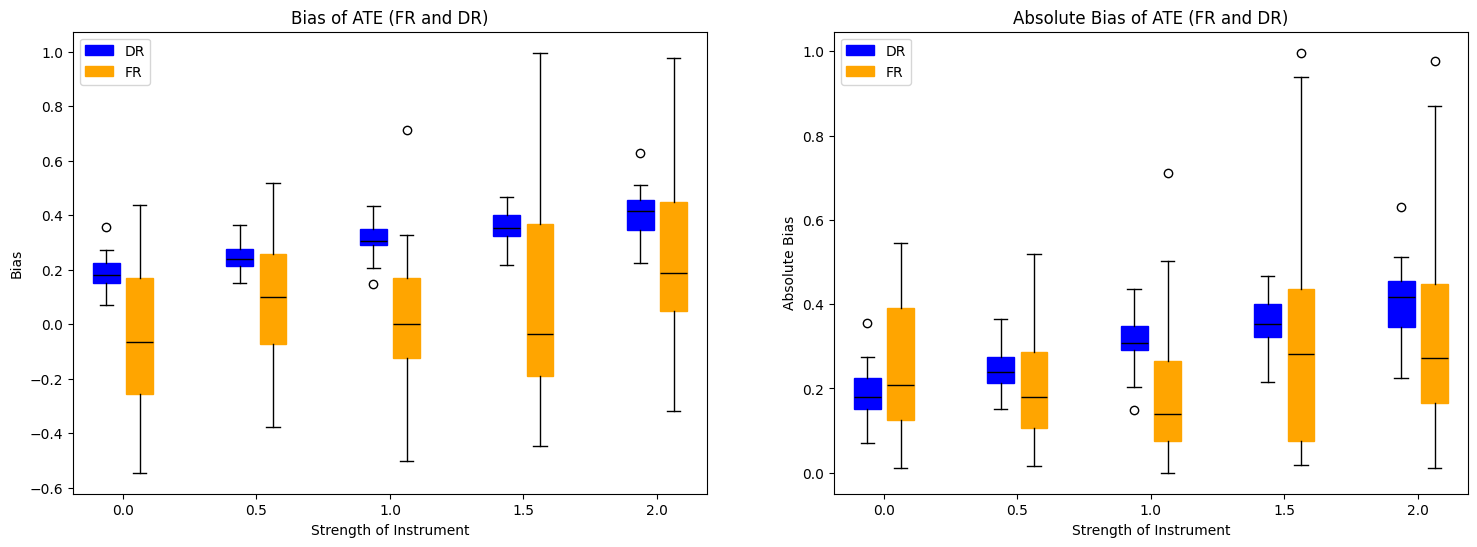

In [ ]:
tracker# Define the true ATE (constant value)
true_ate = 2  # Replace with the actual true ATE value

# Prepare the data dictionary
data = {
    "strength_instr": [],
    "bias_dr": [],
    "bias_fr": [],
    "absolute_bias_dr": [],
    "absolute_bias_fr": []
}

# Populate the data dictionary
for strength_instr in sorted(tracker.keys()):
    for i in range(len(tracker[strength_instr]["ate_dr"])):
        # Extract values
        ate_dr = tracker[strength_instr]["ate_dr"][i]  # Assuming the first element of tuple
        ate_fr = tracker[strength_instr]["ate_p"][i]  # Assuming similar structure for FR

        # Append values to the data dictionary
        data["strength_instr"].append(strength_instr)
        data["bias_dr"].append(ate_dr - true_ate)
        data["bias_fr"].append(ate_fr - true_ate)
        data["absolute_bias_dr"].append(abs(ate_dr - true_ate))
        data["absolute_bias_fr"].append(abs(ate_fr - true_ate))

# Convert the data dictionary to a DataFrame
df = pd.DataFrame(data)

# Define colors for DR and FR
colors = {"DR": "blue", "FR": "orange"}

# Initialize figure
plt.figure(figsize=(18, 6))

# Bias plot
plt.subplot(1, 2, 1)
handles = []  # For legend
for idx, strength_instr in enumerate(sorted(df["strength_instr"].unique())):
    group_data = df[df["strength_instr"] == strength_instr]
    # DR boxplot
    bp_dr = plt.boxplot(
        group_data["bias_dr"],
        positions=[idx * 2],
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor=colors["DR"], color=colors["DR"]),
        medianprops=dict(color="black"),
        flierprops=dict(markeredgecolor="black"),
    )
    # Capture handle for DR
    if idx == 0:
        handles.append(bp_dr["boxes"][0])
    # FR boxplot
    bp_fr = plt.boxplot(
        group_data["bias_fr"],
        positions=[idx * 2 + 0.5],
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor=colors["FR"], color=colors["FR"]),
        medianprops=dict(color="black"),
        flierprops=dict(markeredgecolor="black"),
    )
    # Capture handle for FR
    if idx == 0:
        handles.append(bp_fr["boxes"][0])
plt.title("Bias of ATE (FR and DR)")
plt.ylabel("Bias")
plt.xlabel("Strength of Instrument")
plt.xticks(
    ticks=[idx * 2 + 0.25 for idx in range(len(sorted(df["strength_instr"].unique())))],
    labels=sorted(df["strength_instr"].unique()),
)
plt.legend(handles, ["DR", "FR"], loc="upper left")

# Absolute Bias plot
plt.subplot(1, 2, 2)
handles = []  # For legend
for idx, strength_instr in enumerate(sorted(df["strength_instr"].unique())):
    group_data = df[df["strength_instr"] == strength_instr]
    # DR boxplot
    bp_dr = plt.boxplot(
        group_data["absolute_bias_dr"],
        positions=[idx * 2],
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor=colors["DR"], color=colors["DR"]),
        medianprops=dict(color="black"),
        flierprops=dict(markeredgecolor="black"),
    )
    if idx == 0:
        handles.append(bp_dr["boxes"][0])
    # FR boxplot
    bp_fr = plt.boxplot(
        group_data["absolute_bias_fr"],
        positions=[idx * 2 + 0.5],
        widths=0.4,
        patch_artist=True,
        boxprops=dict(facecolor=colors["FR"], color=colors["FR"]),
        medianprops=dict(color="black"),
        flierprops=dict(markeredgecolor="black"),
    )
    if idx == 0:
        handles.append(bp_fr["boxes"][0])
plt.title("Absolute Bias of ATE (FR and DR)")
plt.ylabel("Absolute Bias")
plt.xlabel("Strength of Instrument")
plt.xticks(
    ticks=[idx * 2 + 0.25 for idx in range(len(sorted(df["strength_instr"].unique())))],
    labels=sorted(df["strength_instr"].unique()),
)
plt.legend(handles, ["DR", "FR"], loc="upper left")

In [19]:
# Define the tracker dictionary and the true ATE value
true_ate = 2.0  # Replace with the actual value if different
mse_results = {}

# Loop through each strength instruction in the tracker
for strength_instr, data in tracker.items():
    # Retrieve the ate_p and ate_dr lists
    ate_p = data['ate_p']
    ate_dr = data['ate_dr']
    
    # Calculate the MSE for ate_p and ate_dr
    mse_p = sum((x - true_ate) ** 2 for x in ate_p) / len(ate_p)
    mse_dr = sum((x - true_ate) ** 2 for x in ate_dr) / len(ate_dr)
    
    # Store the results
    mse_results[strength_instr] = {'mse_ate_p': mse_p, 'mse_ate_dr': mse_dr}

# Display the results
import pandas as pd
mse_df = pd.DataFrame(mse_results).T
mse_df.columns = ['MSE (ATE_P)', 'MSE (ATE_DR)']
mse_df

MSE (ATE_P)  MSE (ATE_DR)
0.0     0.089488      0.038631
0.5     0.064140      0.063803
1.0     0.068115      0.099064
1.5     0.181219      0.130327
2.0     0.180912      0.170143

#### cross fitting

In [ ]:
nrep = 2  # Number of repetitions
n_tr = 1000  # Training sample size
n_p = 1000  # Testing sample size
strength_instr_values = np.arange(0, 2.5, 0.5)  # Varying strength of instrumental variables
nI = 2  # Fixed number of instrumental variables
nX = 2
nO = 2
nS = 3
binary_intervention = True
num_iters = 4000  # Fixed number of training iterations


# Initialize tracker for strength_instr
tracker = {strength_instr: {"ate_p": [], "ate_dr": []}
           for strength_instr in strength_instr_values}

# Begin loop over strength_instr
for strength_instr in strength_instr_values:
    print(f"Running experiments for strength_instr = {strength_instr}")
    p = nI + nX + nO + nS  # Update the number of covariates
    
    for rep in tqdm(range(nrep)):
        # Generate training and testing data
        df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        ate_p = cross_fit_frengression(df=df_tr, binary_intervention=binary_intervention, p=p, k_folds=5, num_iters=num_iters, lr=1e-4, sample_size=1000)['ATE']

        # DR Estimation
        ate_dr = cross_fit_dr_ate(df=df_tr, p=p, k_folds=5, ps_model="lr", or_model="rf", random_state=42)['ATE']

        # Log results
        tracker[strength_instr]["ate_p"].append(ate_p)
        tracker[strength_instr]["ate_dr"].append(ate_dr)

### With sparsity

In [ ]:
nrep = 10  # Number of repetitions
n_tr = 1000  # Training sample size
n_p = 1000  # Testing sample size
nI_values = [5, 10, 20, 30]  # Different values of nI to iterate through
nX = 5
nO = 5
nS = 10
binary_intervention = True
num_iters = 4000  # Fixed number of training iterations

# Initialize tracker for nI
tracker = {nI: {"ate_p": [],"coeff_diff":[],"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []} 
           for nI in nI_values}

# Begin loop over nI
for nI in nI_values:
    print(f"Running experiments for nI = {nI}")
    p = nI + nX + nO + nS  # Update the number of covariates
    
    for rep in tqdm(range(nrep)):
        # Generate training and testing data
        df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
               torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
        y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

        model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                             noise_dim=1, num_layer=3, hidden_dim=400, 
                             device=device, x_binary=binary_intervention,z_binary_dims=0)
        
        df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        
        z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
               torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
        y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)

        # Ground truth distributions
        Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
        Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
        Q_joint = torch.cat([x_q, y_q, z_q], dim=1).numpy()


        # Train model for fixed iterations
        model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
        model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

        # Sample model distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()
        ate_p = np.mean(P1) - np.mean(P0)

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        # Logistic regression for P
        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_
        coeff_diff = np.mean((logreg_coeffs_p - logreg_coeffs_q)**2)

        # Log results
        tracker[nI]["ate_p"].append(ate_p)
        tracker[nI]["coeff_diff"].append(coeff_diff)
        tracker[nI]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[nI]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[nI]["mmd_joint"].append(mmd_joint)
        tracker[nI]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[nI]["logreg_coeffs_q"].append(logreg_coeffs_q)


Running experiments for nI = 5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 4.7650, loss1 5.0077, loss2 0.4855
Epoch 400: loss 3.5485, loss1 6.9928, loss2 6.8885
Epoch 800: loss 3.5474, loss1 7.0149, loss2 6.9348
Epoch 1200: loss 3.5271, loss1 7.0470, loss2 7.0400
Epoch 1600: loss 3.5435, loss1 7.0541, loss2 7.0212
Epoch 2000: loss 3.5091, loss1 7.0314, loss2 7.0445
Epoch 2400: loss 3.5177, loss1 7.0442, loss2 7.0531
Epoch 2800: loss 3.5177, loss1 7.0270, loss2 7.0186
Epoch 3200: loss 3.5528, loss1 7.0573, loss2 7.0089
Epoch 3600: loss 3.5099, loss1 7.0079, loss2 6.9961
Epoch 4000: loss 3.5125, loss1 7.0171, loss2 7.0091
Epoch 1: loss 2.4278,	loss_y 1.6375, 1.6469, 0.0188,	loss_eta 0.7903, 0.8300, 0.0793
Epoch 400: loss 1.8841,	loss_y 1.1096, 1.8095, 1.3998,	loss_eta 0.7744, 0.8077, 0.0666
Epoch 800: loss 1.1484,	loss_y 0.4594, 1.3272, 1.7356,	loss_eta 0.6889, 1.0944, 0.8110
Epoch 1200: loss 1.3701,	loss_y 0.5795, 1.1144, 1.0697,	loss_eta 0.7906, 0.8056, 0.0299
Epoch 1600: loss 1.1484,	loss_y 0.5041, 1.2382, 1.4682,	loss_eta 0.6443, 1.0444, 0.800

 10%|█         | 1/10 [01:19<11:55, 79.47s/it]

Epoch 4000: loss 0.9888,	loss_y 0.4306, 0.6946, 0.5279,	loss_eta 0.5582, 1.2139, 1.3115
Epoch 1: loss 4.7802, loss1 5.0222, loss2 0.4839
Epoch 400: loss 3.5797, loss1 7.0153, loss2 6.8713
Epoch 800: loss 3.5387, loss1 7.0303, loss2 6.9833
Epoch 1200: loss 3.5515, loss1 7.0320, loss2 6.9610
Epoch 1600: loss 3.5504, loss1 7.0587, loss2 7.0167
Epoch 2000: loss 3.5477, loss1 7.0817, loss2 7.0680
Epoch 2400: loss 3.5484, loss1 7.0642, loss2 7.0316
Epoch 2800: loss 3.5286, loss1 7.0422, loss2 7.0273
Epoch 3200: loss 3.4744, loss1 7.0317, loss2 7.1146
Epoch 3600: loss 3.5337, loss1 7.0546, loss2 7.0420
Epoch 4000: loss 3.5364, loss1 7.0135, loss2 6.9543
Epoch 1: loss 2.5246,	loss_y 1.7171, 1.7296, 0.0249,	loss_eta 0.8075, 0.8435, 0.0721
Epoch 400: loss 1.5496,	loss_y 0.7679, 1.8147, 2.0935,	loss_eta 0.7817, 0.7941, 0.0248
Epoch 800: loss 1.3887,	loss_y 0.6826, 1.7755, 2.1858,	loss_eta 0.7061, 0.8948, 0.3773
Epoch 1200: loss 1.1940,	loss_y 0.4916, 0.9562, 0.9292,	loss_eta 0.7024, 0.8789, 0.352

 20%|██        | 2/10 [02:25<09:31, 71.42s/it]

Epoch 4000: loss 0.7922,	loss_y 0.2090, 0.4982, 0.5785,	loss_eta 0.5832, 1.1311, 1.0959
Epoch 1: loss 4.7814, loss1 5.0264, loss2 0.4899
Epoch 400: loss 3.5848, loss1 7.0206, loss2 6.8717
Epoch 800: loss 3.5584, loss1 7.0155, loss2 6.9142
Epoch 1200: loss 3.5357, loss1 7.0390, loss2 7.0067
Epoch 1600: loss 3.5692, loss1 7.0852, loss2 7.0320
Epoch 2000: loss 3.5214, loss1 7.0339, loss2 7.0250
Epoch 2400: loss 3.5389, loss1 7.0721, loss2 7.0663
Epoch 2800: loss 3.5416, loss1 7.0447, loss2 7.0063
Epoch 3200: loss 3.4964, loss1 7.0457, loss2 7.0987
Epoch 3600: loss 3.5408, loss1 7.0613, loss2 7.0410
Epoch 4000: loss 3.5514, loss1 7.0871, loss2 7.0714
Epoch 1: loss 2.5152,	loss_y 1.7439, 1.7571, 0.0264,	loss_eta 0.7713, 0.8014, 0.0602
Epoch 400: loss 1.4262,	loss_y 0.6335, 1.4096, 1.5522,	loss_eta 0.7927, 0.8141, 0.0427
Epoch 800: loss 1.5909,	loss_y 0.8218, 1.3196, 0.9956,	loss_eta 0.7691, 0.8724, 0.2065
Epoch 1200: loss 1.1589,	loss_y 0.5310, 1.1256, 1.1892,	loss_eta 0.6280, 1.0784, 0.900

 30%|███       | 3/10 [03:31<08:04, 69.20s/it]

Epoch 4000: loss 1.0398,	loss_y 0.4180, 0.7046, 0.5733,	loss_eta 0.6219, 1.1825, 1.1214
Epoch 1: loss 4.7341, loss1 4.9775, loss2 0.4867
Epoch 400: loss 3.5227, loss1 6.9370, loss2 6.8287
Epoch 800: loss 3.4887, loss1 6.9612, loss2 6.9450
Epoch 1200: loss 3.4788, loss1 6.9575, loss2 6.9573
Epoch 1600: loss 3.5038, loss1 6.9592, loss2 6.9108
Epoch 2000: loss 3.4800, loss1 6.9434, loss2 6.9270
Epoch 2400: loss 3.4862, loss1 6.9891, loss2 7.0058
Epoch 2800: loss 3.5066, loss1 7.0059, loss2 6.9988
Epoch 3200: loss 3.5003, loss1 6.9959, loss2 6.9914
Epoch 3600: loss 3.4966, loss1 7.0069, loss2 7.0206
Epoch 4000: loss 3.4829, loss1 6.9875, loss2 7.0093
Epoch 1: loss 2.4426,	loss_y 1.6657, 1.6979, 0.0644,	loss_eta 0.7769, 0.8125, 0.0712
Epoch 400: loss 1.4151,	loss_y 0.6192, 1.7919, 2.3453,	loss_eta 0.7959, 0.8436, 0.0954
Epoch 800: loss 1.3218,	loss_y 0.6889, 1.1516, 0.9253,	loss_eta 0.6329, 1.0931, 0.9204
Epoch 1200: loss 1.1087,	loss_y 0.5527, 1.2882, 1.4709,	loss_eta 0.5560, 1.0534, 0.994

 40%|████      | 4/10 [04:38<06:48, 68.13s/it]

Epoch 4000: loss 0.8149,	loss_y 0.2296, 0.4687, 0.4783,	loss_eta 0.5853, 1.0330, 0.8954
Epoch 1: loss 4.8061, loss1 5.0369, loss2 0.4616
Epoch 400: loss 3.5700, loss1 7.0288, loss2 6.9176
Epoch 800: loss 3.5539, loss1 7.0432, loss2 6.9785
Epoch 1200: loss 3.5702, loss1 7.0888, loss2 7.0371
Epoch 1600: loss 3.5469, loss1 7.0856, loss2 7.0775
Epoch 2000: loss 3.5590, loss1 7.0746, loss2 7.0312
Epoch 2400: loss 3.5435, loss1 7.0826, loss2 7.0782
Epoch 2800: loss 3.5736, loss1 7.0968, loss2 7.0464
Epoch 3200: loss 3.5529, loss1 7.0873, loss2 7.0687
Epoch 3600: loss 3.5732, loss1 7.0593, loss2 6.9723
Epoch 4000: loss 3.5610, loss1 7.0927, loss2 7.0633
Epoch 1: loss 2.4261,	loss_y 1.6844, 1.7441, 0.1193,	loss_eta 0.7417, 0.7807, 0.0780
Epoch 400: loss 1.8588,	loss_y 0.8703, 2.0281, 2.3156,	loss_eta 0.9885, 1.1898, 0.4026
Epoch 800: loss 1.2119,	loss_y 0.5582, 1.1840, 1.2516,	loss_eta 0.6537, 0.8574, 0.4075
Epoch 1200: loss 1.3242,	loss_y 0.7262, 1.1030, 0.7537,	loss_eta 0.5981, 1.1034, 1.010

 50%|█████     | 5/10 [05:45<05:38, 67.64s/it]

Epoch 4000: loss 0.9795,	loss_y 0.3503, 0.7407, 0.7808,	loss_eta 0.6292, 1.0915, 0.9247
Epoch 1: loss 4.7582, loss1 5.0080, loss2 0.4996
Epoch 400: loss 3.5388, loss1 6.9765, loss2 6.8753
Epoch 800: loss 3.5225, loss1 7.0056, loss2 6.9662
Epoch 1200: loss 3.5669, loss1 7.0399, loss2 6.9461
Epoch 1600: loss 3.5305, loss1 7.0358, loss2 7.0105
Epoch 2000: loss 3.5115, loss1 7.0503, loss2 7.0775
Epoch 2400: loss 3.5314, loss1 6.9863, loss2 6.9098
Epoch 2800: loss 3.4826, loss1 7.0126, loss2 7.0601
Epoch 3200: loss 3.4973, loss1 7.0110, loss2 7.0273
Epoch 3600: loss 3.4972, loss1 6.9731, loss2 6.9519
Epoch 4000: loss 3.5239, loss1 7.0419, loss2 7.0358
Epoch 1: loss 2.5013,	loss_y 1.7164, 1.7345, 0.0362,	loss_eta 0.7849, 0.8233, 0.0768
Epoch 400: loss 1.3734,	loss_y 0.5487, 1.6503, 2.2033,	loss_eta 0.8247, 0.8425, 0.0355
Epoch 800: loss 1.4906,	loss_y 0.7946, 2.0482, 2.5072,	loss_eta 0.6960, 0.9916, 0.5912
Epoch 1200: loss 1.2677,	loss_y 0.5645, 1.0889, 1.0487,	loss_eta 0.7032, 0.8862, 0.366

 60%|██████    | 6/10 [06:52<04:29, 67.46s/it]

Epoch 4000: loss 0.9613,	loss_y 0.3589, 0.6671, 0.6164,	loss_eta 0.6025, 0.9672, 0.7295
Epoch 1: loss 4.7344, loss1 4.9699, loss2 0.4709
Epoch 400: loss 3.5279, loss1 6.9280, loss2 6.8004
Epoch 800: loss 3.5522, loss1 6.9815, loss2 6.8587
Epoch 1200: loss 3.4955, loss1 6.9763, loss2 6.9616
Epoch 1600: loss 3.4816, loss1 6.9648, loss2 6.9664
Epoch 2000: loss 3.4670, loss1 6.9342, loss2 6.9344
Epoch 2400: loss 3.4902, loss1 6.9656, loss2 6.9509
Epoch 2800: loss 3.5035, loss1 6.9760, loss2 6.9450
Epoch 3200: loss 3.5139, loss1 6.9954, loss2 6.9628
Epoch 3600: loss 3.4763, loss1 7.0025, loss2 7.0525
Epoch 4000: loss 3.5020, loss1 6.9663, loss2 6.9287
Epoch 1: loss 2.3936,	loss_y 1.6231, 1.6569, 0.0675,	loss_eta 0.7705, 0.8048, 0.0687
Epoch 400: loss 1.9469,	loss_y 1.1115, 2.4900, 2.7570,	loss_eta 0.8354, 0.8490, 0.0274
Epoch 800: loss 1.2198,	loss_y 0.6019, 1.1749, 1.1461,	loss_eta 0.6179, 1.2018, 1.1678
Epoch 1200: loss 1.0343,	loss_y 0.4456, 1.2184, 1.5457,	loss_eta 0.5887, 1.1008, 1.024

 70%|███████   | 7/10 [07:59<03:21, 67.25s/it]

Epoch 4000: loss 0.8939,	loss_y 0.2756, 0.6636, 0.7760,	loss_eta 0.6183, 1.2419, 1.2472
Epoch 1: loss 4.7694, loss1 5.0121, loss2 0.4854
Epoch 400: loss 3.5243, loss1 6.9873, loss2 6.9261
Epoch 800: loss 3.5314, loss1 7.0007, loss2 6.9387
Epoch 1200: loss 3.5435, loss1 7.0557, loss2 7.0244
Epoch 1600: loss 3.5357, loss1 7.0461, loss2 7.0206
Epoch 2000: loss 3.5130, loss1 7.0243, loss2 7.0226
Epoch 2400: loss 3.5363, loss1 7.0553, loss2 7.0381
Epoch 2800: loss 3.5220, loss1 7.0427, loss2 7.0413
Epoch 3200: loss 3.5403, loss1 7.0797, loss2 7.0788
Epoch 3600: loss 3.5376, loss1 7.0404, loss2 7.0055
Epoch 4000: loss 3.5135, loss1 7.0329, loss2 7.0388
Epoch 1: loss 2.5552,	loss_y 1.7531, 1.7651, 0.0239,	loss_eta 0.8021, 0.8308, 0.0574
Epoch 400: loss 1.7414,	loss_y 0.9423, 1.6991, 1.5136,	loss_eta 0.7991, 0.8072, 0.0163
Epoch 800: loss 1.7156,	loss_y 0.9793, 1.9370, 1.9153,	loss_eta 0.7363, 0.8308, 0.1890
Epoch 1200: loss 1.1829,	loss_y 0.5234, 1.2551, 1.4634,	loss_eta 0.6595, 0.8921, 0.465

 80%|████████  | 8/10 [09:04<02:13, 66.71s/it]

Epoch 4000: loss 0.9107,	loss_y 0.3593, 0.7207, 0.7228,	loss_eta 0.5514, 1.1610, 1.2192
Epoch 1: loss 4.7795, loss1 5.0230, loss2 0.4870
Epoch 400: loss 3.5473, loss1 7.0030, loss2 6.9112
Epoch 800: loss 3.5944, loss1 7.0760, loss2 6.9633
Epoch 1200: loss 3.5758, loss1 7.0295, loss2 6.9073
Epoch 1600: loss 3.5350, loss1 7.0453, loss2 7.0206
Epoch 2000: loss 3.5379, loss1 7.0473, loss2 7.0189
Epoch 2400: loss 3.5462, loss1 7.0696, loss2 7.0469
Epoch 2800: loss 3.5617, loss1 7.0578, loss2 6.9923
Epoch 3200: loss 3.5443, loss1 7.0561, loss2 7.0236
Epoch 3600: loss 3.5618, loss1 7.0660, loss2 7.0084
Epoch 4000: loss 3.5433, loss1 7.0744, loss2 7.0621
Epoch 1: loss 2.5232,	loss_y 1.7274, 1.7616, 0.0682,	loss_eta 0.7958, 0.8301, 0.0686
Epoch 400: loss 1.3032,	loss_y 0.5736, 1.8382, 2.5293,	loss_eta 0.7297, 0.7969, 0.1346
Epoch 800: loss 1.3004,	loss_y 0.6547, 1.3648, 1.4202,	loss_eta 0.6457, 0.8479, 0.4045
Epoch 1200: loss 1.4147,	loss_y 0.8091, 1.3469, 1.0757,	loss_eta 0.6057, 1.2128, 1.214

 90%|█████████ | 9/10 [10:09<01:06, 66.29s/it]

Epoch 4000: loss 0.8525,	loss_y 0.2862, 0.4952, 0.4179,	loss_eta 0.5663, 1.0761, 1.0196
Epoch 1: loss 4.7687, loss1 5.0075, loss2 0.4774
Epoch 400: loss 3.5404, loss1 7.0457, loss2 7.0106
Epoch 800: loss 3.5882, loss1 7.0442, loss2 6.9121
Epoch 1200: loss 3.5428, loss1 7.0613, loss2 7.0371
Epoch 1600: loss 3.5559, loss1 7.0291, loss2 6.9463
Epoch 2000: loss 3.5419, loss1 7.0216, loss2 6.9595
Epoch 2400: loss 3.5549, loss1 7.0641, loss2 7.0185
Epoch 2800: loss 3.5688, loss1 7.0777, loss2 7.0177
Epoch 3200: loss 3.5510, loss1 7.0572, loss2 7.0123
Epoch 3600: loss 3.5304, loss1 7.0454, loss2 7.0301
Epoch 4000: loss 3.5075, loss1 7.0005, loss2 6.9861
Epoch 1: loss 2.4357,	loss_y 1.6836, 1.6995, 0.0319,	loss_eta 0.7521, 0.7934, 0.0827
Epoch 400: loss 1.3088,	loss_y 0.5134, 1.2794, 1.5320,	loss_eta 0.7954, 0.7985, 0.0063
Epoch 800: loss 1.6841,	loss_y 0.8931, 1.5506, 1.3151,	loss_eta 0.7909, 0.8341, 0.0863
Epoch 1200: loss 1.2775,	loss_y 0.5672, 1.5127, 1.8910,	loss_eta 0.7103, 0.8740, 0.327

100%|██████████| 10/10 [11:15<00:00, 67.60s/it]


Epoch 4000: loss 0.9332,	loss_y 0.3054, 0.5995, 0.5883,	loss_eta 0.6278, 1.0566, 0.8577
Running experiments for nI = 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 5.1925, loss1 5.4641, loss2 0.5433
Epoch 400: loss 3.8644, loss1 7.6649, loss2 7.6011
Epoch 800: loss 3.8529, loss1 7.6452, loss2 7.5846
Epoch 1200: loss 3.8216, loss1 7.6408, loss2 7.6383
Epoch 1600: loss 3.8418, loss1 7.6475, loss2 7.6115
Epoch 2000: loss 3.8476, loss1 7.6907, loss2 7.6863
Epoch 2400: loss 3.8732, loss1 7.7131, loss2 7.6799
Epoch 2800: loss 3.8794, loss1 7.6889, loss2 7.6189
Epoch 3200: loss 3.8437, loss1 7.6642, loss2 7.6410
Epoch 3600: loss 3.8474, loss1 7.6539, loss2 7.6130
Epoch 4000: loss 3.8122, loss1 7.6698, loss2 7.7152
Epoch 1: loss 2.3544,	loss_y 1.5937, 1.6247, 0.0621,	loss_eta 0.7607, 0.8018, 0.0823
Epoch 400: loss 1.7226,	loss_y 1.0306, 2.4417, 2.8223,	loss_eta 0.6920, 0.8775, 0.3711
Epoch 800: loss 1.2670,	loss_y 0.6743, 1.8639, 2.3792,	loss_eta 0.5927, 1.0791, 0.9728
Epoch 1200: loss 1.1561,	loss_y 0.5551, 0.9737, 0.8373,	loss_eta 0.6010, 1.1845, 1.1670
Epoch 1600: loss 0.9492,	loss_y 0.3790, 0.8800, 1.0021,	loss_eta 0.5702, 1.1406, 1.140

 10%|█         | 1/10 [01:06<09:55, 66.21s/it]

Epoch 4000: loss 0.8264,	loss_y 0.2721, 0.4887, 0.4334,	loss_eta 0.5544, 1.1168, 1.1247
Epoch 1: loss 5.2671, loss1 5.5256, loss2 0.5169
Epoch 400: loss 3.9356, loss1 7.7280, loss2 7.5848
Epoch 800: loss 3.8940, loss1 7.7813, loss2 7.7745
Epoch 1200: loss 3.8869, loss1 7.7285, loss2 7.6832
Epoch 1600: loss 3.9037, loss1 7.7706, loss2 7.7338
Epoch 2000: loss 3.9084, loss1 7.7451, loss2 7.6734
Epoch 2400: loss 3.8551, loss1 7.7538, loss2 7.7975
Epoch 2800: loss 3.9005, loss1 7.7898, loss2 7.7786
Epoch 3200: loss 3.9011, loss1 7.7535, loss2 7.7049
Epoch 3600: loss 3.8738, loss1 7.7558, loss2 7.7639
Epoch 4000: loss 3.8731, loss1 7.7640, loss2 7.7818
Epoch 1: loss 2.5225,	loss_y 1.7444, 1.7664, 0.0440,	loss_eta 0.7781, 0.8121, 0.0681
Epoch 400: loss 1.7476,	loss_y 1.0254, 2.6526, 3.2543,	loss_eta 0.7222, 0.7956, 0.1468
Epoch 800: loss 1.4299,	loss_y 0.8071, 2.4594, 3.3046,	loss_eta 0.6228, 0.9575, 0.6694
Epoch 1200: loss 1.1884,	loss_y 0.6058, 1.3107, 1.4098,	loss_eta 0.5826, 1.3047, 1.444

 20%|██        | 2/10 [02:12<08:52, 66.51s/it]

Epoch 4000: loss 0.8179,	loss_y 0.2165, 0.5729, 0.7127,	loss_eta 0.6014, 1.4852, 1.7677
Epoch 1: loss 5.2381, loss1 5.4995, loss2 0.5229
Epoch 400: loss 3.8949, loss1 7.6554, loss2 7.5209
Epoch 800: loss 3.9138, loss1 7.7237, loss2 7.6199
Epoch 1200: loss 3.8653, loss1 7.7309, loss2 7.7313
Epoch 1600: loss 3.8876, loss1 7.7014, loss2 7.6277
Epoch 2000: loss 3.8771, loss1 7.7353, loss2 7.7162
Epoch 2400: loss 3.9332, loss1 7.7389, loss2 7.6112
Epoch 2800: loss 3.9053, loss1 7.7313, loss2 7.6519
Epoch 3200: loss 3.8960, loss1 7.7487, loss2 7.7054
Epoch 3600: loss 3.8750, loss1 7.7486, loss2 7.7471
Epoch 4000: loss 3.8781, loss1 7.7509, loss2 7.7457
Epoch 1: loss 2.3755,	loss_y 1.6341, 1.6495, 0.0309,	loss_eta 0.7415, 0.7834, 0.0839
Epoch 400: loss 1.4231,	loss_y 0.6377, 1.5584, 1.8415,	loss_eta 0.7854, 0.8236, 0.0763
Epoch 800: loss 1.1656,	loss_y 0.5520, 0.9610, 0.8180,	loss_eta 0.6137, 1.0999, 0.9724
Epoch 1200: loss 1.2272,	loss_y 0.6289, 0.8151, 0.3725,	loss_eta 0.5983, 1.0591, 0.921

 30%|███       | 3/10 [03:19<07:44, 66.40s/it]

Epoch 4000: loss 0.8327,	loss_y 0.2204, 0.5254, 0.6100,	loss_eta 0.6124, 1.3348, 1.4448
Epoch 1: loss 5.2250, loss1 5.4823, loss2 0.5145
Epoch 400: loss 3.8708, loss1 7.6575, loss2 7.5734
Epoch 800: loss 3.8802, loss1 7.6855, loss2 7.6105
Epoch 1200: loss 3.8444, loss1 7.6709, loss2 7.6529
Epoch 1600: loss 3.8684, loss1 7.6936, loss2 7.6504
Epoch 2000: loss 3.8819, loss1 7.6784, loss2 7.5930
Epoch 2400: loss 3.8750, loss1 7.7154, loss2 7.6810
Epoch 2800: loss 3.8322, loss1 7.7028, loss2 7.7411
Epoch 3200: loss 3.8402, loss1 7.7187, loss2 7.7569
Epoch 3600: loss 3.8480, loss1 7.7095, loss2 7.7230
Epoch 4000: loss 3.8442, loss1 7.6857, loss2 7.6829
Epoch 1: loss 2.4050,	loss_y 1.6248, 1.6511, 0.0527,	loss_eta 0.7803, 0.8165, 0.0725
Epoch 400: loss 2.0580,	loss_y 1.3031, 2.9564, 3.3065,	loss_eta 0.7549, 0.7790, 0.0483
Epoch 800: loss 1.3469,	loss_y 0.7766, 1.9891, 2.4251,	loss_eta 0.5703, 1.4308, 1.7209
Epoch 1200: loss 0.8490,	loss_y 0.3219, 0.8245, 1.0051,	loss_eta 0.5270, 1.1539, 1.253

 40%|████      | 4/10 [04:26<06:39, 66.57s/it]

Epoch 4000: loss 0.8380,	loss_y 0.2404, 0.5733, 0.6657,	loss_eta 0.5976, 1.3067, 1.4184
Epoch 1: loss 5.2236, loss1 5.4705, loss2 0.4937
Epoch 400: loss 3.9039, loss1 7.6711, loss2 7.5343
Epoch 800: loss 3.8723, loss1 7.7040, loss2 7.6634
Epoch 1200: loss 3.9067, loss1 7.7133, loss2 7.6132
Epoch 1600: loss 3.8605, loss1 7.7049, loss2 7.6887
Epoch 2000: loss 3.8776, loss1 7.7054, loss2 7.6555
Epoch 2400: loss 3.9010, loss1 7.7204, loss2 7.6389
Epoch 2800: loss 3.8848, loss1 7.6855, loss2 7.6014
Epoch 3200: loss 3.8601, loss1 7.7164, loss2 7.7125
Epoch 3600: loss 3.8407, loss1 7.6546, loss2 7.6278
Epoch 4000: loss 3.8594, loss1 7.6869, loss2 7.6550
Epoch 1: loss 2.3674,	loss_y 1.6075, 1.6230, 0.0310,	loss_eta 0.7599, 0.8009, 0.0819
Epoch 400: loss 1.3044,	loss_y 0.6733, 1.7327, 2.1188,	loss_eta 0.6311, 0.9323, 0.6024
Epoch 800: loss 1.0981,	loss_y 0.4576, 0.7251, 0.5349,	loss_eta 0.6405, 0.8011, 0.3213
Epoch 1200: loss 1.4261,	loss_y 0.8217, 1.5933, 1.5433,	loss_eta 0.6044, 1.1426, 1.076

 50%|█████     | 5/10 [05:32<05:33, 66.64s/it]

Epoch 4000: loss 0.8806,	loss_y 0.2446, 0.4919, 0.4947,	loss_eta 0.6360, 1.2476, 1.2231
Epoch 1: loss 5.2312, loss1 5.4944, loss2 0.5263
Epoch 400: loss 3.9149, loss1 7.7324, loss2 7.6349
Epoch 800: loss 3.8316, loss1 7.6658, loss2 7.6684
Epoch 1200: loss 3.9060, loss1 7.6886, loss2 7.5652
Epoch 1600: loss 3.8114, loss1 7.6855, loss2 7.7482
Epoch 2000: loss 3.8453, loss1 7.7061, loss2 7.7217
Epoch 2400: loss 3.8713, loss1 7.7053, loss2 7.6680
Epoch 2800: loss 3.8806, loss1 7.6790, loss2 7.5968
Epoch 3200: loss 3.8489, loss1 7.6486, loss2 7.5996
Epoch 3600: loss 3.8760, loss1 7.7258, loss2 7.6996
Epoch 4000: loss 3.8641, loss1 7.7290, loss2 7.7298
Epoch 1: loss 2.3906,	loss_y 1.6138, 1.6236, 0.0197,	loss_eta 0.7768, 0.8176, 0.0814
Epoch 400: loss 1.4598,	loss_y 0.7162, 1.2941, 1.1558,	loss_eta 0.7436, 0.8021, 0.1171
Epoch 800: loss 1.0948,	loss_y 0.4748, 1.0749, 1.2002,	loss_eta 0.6199, 1.1960, 1.1520
Epoch 1200: loss 1.1087,	loss_y 0.4416, 0.8888, 0.8943,	loss_eta 0.6670, 1.2696, 1.205

 60%|██████    | 6/10 [06:43<04:32, 68.13s/it]

Epoch 4000: loss 0.8178,	loss_y 0.2578, 0.4989, 0.4822,	loss_eta 0.5600, 1.0717, 1.0235
Epoch 1: loss 5.2531, loss1 5.5021, loss2 0.4979
Epoch 400: loss 3.9353, loss1 7.6987, loss2 7.5268
Epoch 800: loss 3.8669, loss1 7.6619, loss2 7.5901
Epoch 1200: loss 3.8909, loss1 7.7327, loss2 7.6836
Epoch 1600: loss 3.8820, loss1 7.7603, loss2 7.7566
Epoch 2000: loss 3.8966, loss1 7.7697, loss2 7.7461
Epoch 2400: loss 3.8597, loss1 7.7285, loss2 7.7377
Epoch 2800: loss 3.8673, loss1 7.6997, loss2 7.6648
Epoch 3200: loss 3.8701, loss1 7.7290, loss2 7.7178
Epoch 3600: loss 3.8777, loss1 7.7102, loss2 7.6649
Epoch 4000: loss 3.8721, loss1 7.7374, loss2 7.7307
Epoch 1: loss 2.4835,	loss_y 1.6780, 1.6855, 0.0152,	loss_eta 0.8056, 0.8376, 0.0640
Epoch 400: loss 1.8327,	loss_y 1.1212, 2.8030, 3.3636,	loss_eta 0.7115, 0.7954, 0.1678
Epoch 800: loss 1.1340,	loss_y 0.5315, 1.4612, 1.8594,	loss_eta 0.6025, 1.0753, 0.9456
Epoch 1200: loss 1.0224,	loss_y 0.4439, 1.2583, 1.6287,	loss_eta 0.5784, 1.1755, 1.194

 70%|███████   | 7/10 [07:54<03:27, 69.09s/it]

Epoch 4000: loss 0.8606,	loss_y 0.2836, 0.6002, 0.6332,	loss_eta 0.5770, 1.0820, 1.0099
Epoch 1: loss 5.2421, loss1 5.5016, loss2 0.5191
Epoch 400: loss 3.8829, loss1 7.6593, loss2 7.5529
Epoch 800: loss 3.8732, loss1 7.7415, loss2 7.7366
Epoch 1200: loss 3.8774, loss1 7.7308, loss2 7.7069
Epoch 1600: loss 3.8601, loss1 7.6953, loss2 7.6703
Epoch 2000: loss 3.8891, loss1 7.7058, loss2 7.6336
Epoch 2400: loss 3.8763, loss1 7.7107, loss2 7.6687
Epoch 2800: loss 3.8524, loss1 7.6992, loss2 7.6936
Epoch 3200: loss 3.8564, loss1 7.6917, loss2 7.6707
Epoch 3600: loss 3.8581, loss1 7.7350, loss2 7.7537
Epoch 4000: loss 3.8434, loss1 7.7010, loss2 7.7152
Epoch 1: loss 2.5022,	loss_y 1.7009, 1.7157, 0.0295,	loss_eta 0.8013, 0.8405, 0.0783
Epoch 400: loss 1.5765,	loss_y 0.8836, 1.1869, 0.6066,	loss_eta 0.6929, 0.8031, 0.2205
Epoch 800: loss 1.1877,	loss_y 0.5541, 1.0830, 1.0578,	loss_eta 0.6336, 0.7962, 0.3252
Epoch 1200: loss 1.2809,	loss_y 0.6824, 1.1976, 1.0303,	loss_eta 0.5985, 1.0573, 0.917

 80%|████████  | 8/10 [09:03<02:17, 68.90s/it]

Epoch 4000: loss 0.8497,	loss_y 0.2473, 0.5884, 0.6821,	loss_eta 0.6024, 1.1851, 1.1654
Epoch 1: loss 5.2173, loss1 5.4890, loss2 0.5436
Epoch 400: loss 3.9163, loss1 7.7169, loss2 7.6013
Epoch 800: loss 3.8766, loss1 7.7132, loss2 7.6732
Epoch 1200: loss 3.9139, loss1 7.7300, loss2 7.6323
Epoch 1600: loss 3.8398, loss1 7.6969, loss2 7.7143
Epoch 2000: loss 3.8830, loss1 7.7020, loss2 7.6380
Epoch 2400: loss 3.8972, loss1 7.7278, loss2 7.6613
Epoch 2800: loss 3.8618, loss1 7.7298, loss2 7.7360
Epoch 3200: loss 3.8583, loss1 7.7385, loss2 7.7605
Epoch 3600: loss 3.8932, loss1 7.7677, loss2 7.7488
Epoch 4000: loss 3.8338, loss1 7.7016, loss2 7.7356
Epoch 1: loss 2.4333,	loss_y 1.6658, 1.6955, 0.0594,	loss_eta 0.7675, 0.8135, 0.0921
Epoch 400: loss 2.0839,	loss_y 1.3798, 2.7391, 2.7186,	loss_eta 0.7041, 0.7858, 0.1635
Epoch 800: loss 1.1149,	loss_y 0.5544, 1.3436, 1.5785,	loss_eta 0.5605, 1.3643, 1.6076
Epoch 1200: loss 1.1682,	loss_y 0.5375, 1.2283, 1.3816,	loss_eta 0.6307, 1.1133, 0.965

 90%|█████████ | 9/10 [10:14<01:09, 69.70s/it]

Epoch 4000: loss 0.7440,	loss_y 0.1737, 0.3833, 0.4193,	loss_eta 0.5703, 1.0928, 1.0451
Epoch 1: loss 5.1986, loss1 5.4703, loss2 0.5434
Epoch 400: loss 3.9225, loss1 7.6806, loss2 7.5161
Epoch 800: loss 3.8992, loss1 7.6697, loss2 7.5410
Epoch 1200: loss 3.8721, loss1 7.6327, loss2 7.5212
Epoch 1600: loss 3.8554, loss1 7.6688, loss2 7.6267
Epoch 2000: loss 3.8868, loss1 7.7048, loss2 7.6360
Epoch 2400: loss 3.8388, loss1 7.6778, loss2 7.6781
Epoch 2800: loss 3.8213, loss1 7.6776, loss2 7.7125
Epoch 3200: loss 3.8586, loss1 7.6930, loss2 7.6689
Epoch 3600: loss 3.8613, loss1 7.6310, loss2 7.5394
Epoch 4000: loss 3.8766, loss1 7.6909, loss2 7.6287
Epoch 1: loss 2.4113,	loss_y 1.6181, 1.6566, 0.0770,	loss_eta 0.7932, 0.8303, 0.0742
Epoch 400: loss 1.4648,	loss_y 0.7075, 1.6137, 1.8122,	loss_eta 0.7572, 0.8431, 0.1718
Epoch 800: loss 1.1343,	loss_y 0.5484, 0.8627, 0.6285,	loss_eta 0.5859, 1.0086, 0.8453
Epoch 1200: loss 1.2044,	loss_y 0.6424, 1.4913, 1.6978,	loss_eta 0.5620, 0.9913, 0.858

100%|██████████| 10/10 [11:29<00:00, 69.00s/it]


Epoch 4000: loss 1.0274,	loss_y 0.4366, 0.8687, 0.8642,	loss_eta 0.5907, 1.2423, 1.3031
Running experiments for nI = 20


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 6.0532, loss1 6.3563, loss2 0.6062
Epoch 400: loss 4.5073, loss1 8.8969, loss2 8.7792
Epoch 800: loss 4.4794, loss1 8.8711, loss2 8.7833
Epoch 1200: loss 4.4882, loss1 8.8909, loss2 8.8054
Epoch 1600: loss 4.5132, loss1 8.9130, loss2 8.7995
Epoch 2000: loss 4.5217, loss1 8.9714, loss2 8.8993
Epoch 2400: loss 4.5212, loss1 8.9390, loss2 8.8357
Epoch 2800: loss 4.4406, loss1 8.9208, loss2 8.9603
Epoch 3200: loss 4.4893, loss1 8.8777, loss2 8.7769
Epoch 3600: loss 4.4924, loss1 8.9006, loss2 8.8164
Epoch 4000: loss 4.5246, loss1 8.9771, loss2 8.9050
Epoch 1: loss 2.3296,	loss_y 1.5502, 1.5669, 0.0333,	loss_eta 0.7794, 0.8142, 0.0697
Epoch 400: loss 1.8742,	loss_y 1.1344, 2.0776, 1.8865,	loss_eta 0.7398, 0.8442, 0.2088
Epoch 800: loss 1.2493,	loss_y 0.6195, 1.1435, 1.0480,	loss_eta 0.6298, 1.1498, 1.0401
Epoch 1200: loss 1.5108,	loss_y 0.9319, 1.4447, 1.0256,	loss_eta 0.5789, 1.1452, 1.1328
Epoch 1600: loss 1.1422,	loss_y 0.5401, 1.0798, 1.0795,	loss_eta 0.6021, 1.5026, 1.800

 10%|█         | 1/10 [01:10<10:30, 70.10s/it]

Epoch 4000: loss 0.9096,	loss_y 0.2935, 0.6075, 0.6279,	loss_eta 0.6161, 1.5825, 1.9329
Epoch 1: loss 5.9896, loss1 6.2984, loss2 0.6176
Epoch 400: loss 4.4966, loss1 8.7938, loss2 8.5945
Epoch 800: loss 4.4607, loss1 8.8511, loss2 8.7809
Epoch 1200: loss 4.4594, loss1 8.8356, loss2 8.7523
Epoch 1600: loss 4.4504, loss1 8.8436, loss2 8.7864
Epoch 2000: loss 4.4737, loss1 8.8856, loss2 8.8238
Epoch 2400: loss 4.4570, loss1 8.8494, loss2 8.7850
Epoch 2800: loss 4.4618, loss1 8.8465, loss2 8.7694
Epoch 3200: loss 4.4298, loss1 8.8223, loss2 8.7850
Epoch 3600: loss 4.3877, loss1 8.8330, loss2 8.8907
Epoch 4000: loss 4.4390, loss1 8.8466, loss2 8.8152
Epoch 1: loss 2.2971,	loss_y 1.5682, 1.5790, 0.0215,	loss_eta 0.7289, 0.7738, 0.0899
Epoch 400: loss 1.4811,	loss_y 0.7844, 1.6566, 1.7444,	loss_eta 0.6967, 0.8125, 0.2317
Epoch 800: loss 1.1577,	loss_y 0.4929, 0.7364, 0.4870,	loss_eta 0.6648, 0.9187, 0.5078
Epoch 1200: loss 1.1914,	loss_y 0.6039, 1.1979, 1.1880,	loss_eta 0.5876, 0.9412, 0.707

 20%|██        | 2/10 [02:20<09:21, 70.16s/it]

Epoch 4000: loss 0.8163,	loss_y 0.2176, 0.5089, 0.5826,	loss_eta 0.5987, 1.1100, 1.0226
Epoch 1: loss 6.0020, loss1 6.3181, loss2 0.6322
Epoch 400: loss 4.5049, loss1 8.8201, loss2 8.6305
Epoch 800: loss 4.4138, loss1 8.8216, loss2 8.8156
Epoch 1200: loss 4.4748, loss1 8.8219, loss2 8.6943
Epoch 1600: loss 4.4659, loss1 8.8625, loss2 8.7932
Epoch 2000: loss 4.4546, loss1 8.9011, loss2 8.8928
Epoch 2400: loss 4.5019, loss1 8.8660, loss2 8.7282
Epoch 2800: loss 4.4184, loss1 8.8210, loss2 8.8053
Epoch 3200: loss 4.4014, loss1 8.8487, loss2 8.8946
Epoch 3600: loss 4.4200, loss1 8.8320, loss2 8.8239
Epoch 4000: loss 4.4207, loss1 8.8277, loss2 8.8140
Epoch 1: loss 2.3092,	loss_y 1.5452, 1.5699, 0.0494,	loss_eta 0.7640, 0.8035, 0.0791
Epoch 400: loss 1.5273,	loss_y 0.7818, 1.3584, 1.1533,	loss_eta 0.7455, 1.0059, 0.5207
Epoch 800: loss 1.2622,	loss_y 0.5330, 1.4879, 1.9098,	loss_eta 0.7292, 0.8154, 0.1724
Epoch 1200: loss 1.1029,	loss_y 0.4516, 0.9393, 0.9753,	loss_eta 0.6513, 1.7802, 2.257

 30%|███       | 3/10 [03:31<08:15, 70.80s/it]

Epoch 4000: loss 0.9865,	loss_y 0.3841, 0.5643, 0.3604,	loss_eta 0.6025, 0.9589, 0.7130
Epoch 1: loss 6.0486, loss1 6.3432, loss2 0.5891
Epoch 400: loss 4.5417, loss1 8.8797, loss2 8.6760
Epoch 800: loss 4.5052, loss1 8.9345, loss2 8.8586
Epoch 1200: loss 4.4606, loss1 8.8815, loss2 8.8419
Epoch 1600: loss 4.4920, loss1 8.9013, loss2 8.8186
Epoch 2000: loss 4.4971, loss1 8.9119, loss2 8.8296
Epoch 2400: loss 4.4954, loss1 8.8954, loss2 8.8000
Epoch 2800: loss 4.4900, loss1 8.8992, loss2 8.8183
Epoch 3200: loss 4.4811, loss1 8.9187, loss2 8.8752
Epoch 3600: loss 4.4764, loss1 8.9403, loss2 8.9278
Epoch 4000: loss 4.4882, loss1 8.9101, loss2 8.8438
Epoch 1: loss 2.2930,	loss_y 1.5479, 1.5659, 0.0360,	loss_eta 0.7451, 0.7873, 0.0844
Epoch 400: loss 1.4163,	loss_y 0.6537, 1.4999, 1.6923,	loss_eta 0.7626, 0.7904, 0.0556
Epoch 800: loss 1.5700,	loss_y 0.8176, 1.1135, 0.5919,	loss_eta 0.7524, 1.2903, 1.0757
Epoch 1200: loss 1.1626,	loss_y 0.4408, 0.7305, 0.5794,	loss_eta 0.7219, 0.8097, 0.175

 40%|████      | 4/10 [04:44<07:08, 71.37s/it]

Epoch 4000: loss 0.8966,	loss_y 0.2492, 0.6172, 0.7361,	loss_eta 0.6475, 1.3130, 1.3310
Epoch 1: loss 6.0739, loss1 6.3667, loss2 0.5855
Epoch 400: loss 4.5295, loss1 8.8680, loss2 8.6771
Epoch 800: loss 4.5196, loss1 8.9307, loss2 8.8221
Epoch 1200: loss 4.5137, loss1 8.9591, loss2 8.8909
Epoch 1600: loss 4.5476, loss1 8.9921, loss2 8.8890
Epoch 2000: loss 4.4952, loss1 8.9403, loss2 8.8902
Epoch 2400: loss 4.4839, loss1 8.9084, loss2 8.8491
Epoch 2800: loss 4.5084, loss1 8.9532, loss2 8.8895
Epoch 3200: loss 4.4925, loss1 8.9714, loss2 8.9579
Epoch 3600: loss 4.4806, loss1 8.9581, loss2 8.9551
Epoch 4000: loss 4.4761, loss1 8.9734, loss2 8.9945
Epoch 1: loss 2.4056,	loss_y 1.6336, 1.6429, 0.0185,	loss_eta 0.7720, 0.8078, 0.0715
Epoch 400: loss 1.4572,	loss_y 0.6717, 1.5559, 1.7684,	loss_eta 0.7855, 0.7939, 0.0168
Epoch 800: loss 1.4357,	loss_y 0.8272, 1.5178, 1.3811,	loss_eta 0.6085, 1.2895, 1.3621
Epoch 1200: loss 1.0594,	loss_y 0.4720, 1.4280, 1.9120,	loss_eta 0.5874, 0.9502, 0.725

 50%|█████     | 5/10 [05:54<05:55, 71.06s/it]

Epoch 4000: loss 0.9921,	loss_y 0.3729, 0.6455, 0.5452,	loss_eta 0.6192, 1.0507, 0.8632
Epoch 1: loss 6.0303, loss1 6.3392, loss2 0.6178
Epoch 400: loss 4.5421, loss1 8.8355, loss2 8.5870
Epoch 800: loss 4.4752, loss1 8.8812, loss2 8.8120
Epoch 1200: loss 4.4849, loss1 8.8721, loss2 8.7743
Epoch 1600: loss 4.4864, loss1 8.8679, loss2 8.7628
Epoch 2000: loss 4.4655, loss1 8.9108, loss2 8.8905
Epoch 2400: loss 4.4902, loss1 8.9074, loss2 8.8344
Epoch 2800: loss 4.4954, loss1 8.9466, loss2 8.9025
Epoch 3200: loss 4.4842, loss1 8.9217, loss2 8.8751
Epoch 3600: loss 4.4946, loss1 8.8793, loss2 8.7695
Epoch 4000: loss 4.4630, loss1 8.9068, loss2 8.8875
Epoch 1: loss 2.3321,	loss_y 1.5506, 1.5672, 0.0333,	loss_eta 0.7815, 0.8196, 0.0762
Epoch 400: loss 1.7854,	loss_y 1.0265, 1.9422, 1.8313,	loss_eta 0.7589, 0.7793, 0.0409
Epoch 800: loss 1.4240,	loss_y 0.8040, 1.5720, 1.5359,	loss_eta 0.6200, 0.9634, 0.6868
Epoch 1200: loss 0.9780,	loss_y 0.4211, 1.0528, 1.2634,	loss_eta 0.5569, 1.0732, 1.032

 60%|██████    | 6/10 [07:06<04:44, 71.23s/it]

Epoch 4000: loss 0.7220,	loss_y 0.1508, 0.3555, 0.4094,	loss_eta 0.5711, 1.1887, 1.2352
Epoch 1: loss 6.0494, loss1 6.3503, loss2 0.6016
Epoch 400: loss 4.5013, loss1 8.8396, loss2 8.6767
Epoch 800: loss 4.5544, loss1 8.9237, loss2 8.7385
Epoch 1200: loss 4.4631, loss1 8.9426, loss2 8.9590
Epoch 1600: loss 4.4887, loss1 8.9223, loss2 8.8672
Epoch 2000: loss 4.4607, loss1 8.8964, loss2 8.8715
Epoch 2400: loss 4.4853, loss1 8.9170, loss2 8.8633
Epoch 2800: loss 4.4910, loss1 8.9026, loss2 8.8231
Epoch 3200: loss 4.4850, loss1 8.9130, loss2 8.8560
Epoch 3600: loss 4.4811, loss1 8.9450, loss2 8.9277
Epoch 4000: loss 4.4779, loss1 8.9544, loss2 8.9529
Epoch 1: loss 2.4353,	loss_y 1.6477, 1.6617, 0.0280,	loss_eta 0.7876, 0.8267, 0.0782
Epoch 400: loss 1.3795,	loss_y 0.6620, 1.7880, 2.2519,	loss_eta 0.7175, 0.9340, 0.4330
Epoch 800: loss 1.3436,	loss_y 0.6338, 1.5515, 1.8353,	loss_eta 0.7098, 1.3629, 1.3062
Epoch 1200: loss 1.3115,	loss_y 0.5760, 1.2517, 1.3513,	loss_eta 0.7355, 0.8105, 0.150

 70%|███████   | 7/10 [08:18<03:34, 71.56s/it]

Epoch 4000: loss 1.0324,	loss_y 0.4624, 0.7501, 0.5753,	loss_eta 0.5699, 1.1146, 1.0894
Epoch 1: loss 6.0123, loss1 6.3184, loss2 0.6122
Epoch 400: loss 4.5070, loss1 8.7467, loss2 8.4795
Epoch 800: loss 4.4377, loss1 8.8620, loss2 8.8486
Epoch 1200: loss 4.4689, loss1 8.8250, loss2 8.7122
Epoch 1600: loss 4.4319, loss1 8.8136, loss2 8.7634
Epoch 2000: loss 4.4382, loss1 8.8494, loss2 8.8224
Epoch 2400: loss 4.5160, loss1 8.8960, loss2 8.7599
Epoch 2800: loss 4.4678, loss1 8.8535, loss2 8.7715
Epoch 3200: loss 4.4406, loss1 8.8815, loss2 8.8818
Epoch 3600: loss 4.4413, loss1 8.8465, loss2 8.8104
Epoch 4000: loss 4.4270, loss1 8.8826, loss2 8.9111
Epoch 1: loss 2.4398,	loss_y 1.6373, 1.6488, 0.0230,	loss_eta 0.8024, 0.8374, 0.0700
Epoch 400: loss 1.9493,	loss_y 1.1594, 2.1591, 1.9995,	loss_eta 0.7899, 0.8123, 0.0449
Epoch 800: loss 1.4450,	loss_y 0.6961, 1.4156, 1.4389,	loss_eta 0.7488, 1.2079, 0.9182
Epoch 1200: loss 1.2193,	loss_y 0.5294, 0.9685, 0.8782,	loss_eta 0.6899, 0.8830, 0.386

 80%|████████  | 8/10 [09:28<02:22, 71.18s/it]

Epoch 4000: loss 0.8572,	loss_y 0.2864, 0.7073, 0.8417,	loss_eta 0.5708, 1.0078, 0.8741
Epoch 1: loss 6.0083, loss1 6.3244, loss2 0.6322
Epoch 400: loss 4.4744, loss1 8.7977, loss2 8.6467
Epoch 800: loss 4.5347, loss1 8.8896, loss2 8.7098
Epoch 1200: loss 4.4720, loss1 8.8749, loss2 8.8058
Epoch 1600: loss 4.4443, loss1 8.8609, loss2 8.8331
Epoch 2000: loss 4.4369, loss1 8.8550, loss2 8.8363
Epoch 2400: loss 4.4585, loss1 8.8741, loss2 8.8312
Epoch 2800: loss 4.4833, loss1 8.8756, loss2 8.7845
Epoch 3200: loss 4.4810, loss1 8.8781, loss2 8.7941
Epoch 3600: loss 4.4574, loss1 8.8631, loss2 8.8113
Epoch 4000: loss 4.4778, loss1 8.9059, loss2 8.8562
Epoch 1: loss 2.3451,	loss_y 1.5647, 1.6073, 0.0853,	loss_eta 0.7804, 0.8164, 0.0720
Epoch 400: loss 1.5503,	loss_y 0.7627, 1.6752, 1.8248,	loss_eta 0.7875, 0.8081, 0.0412
Epoch 800: loss 1.7475,	loss_y 0.9917, 1.5202, 1.0571,	loss_eta 0.7559, 1.3333, 1.1549
Epoch 1200: loss 1.0908,	loss_y 0.4669, 1.0868, 1.2398,	loss_eta 0.6239, 0.9615, 0.675

 90%|█████████ | 9/10 [10:39<01:10, 70.89s/it]

Epoch 4000: loss 0.9099,	loss_y 0.2806, 0.5928, 0.6243,	loss_eta 0.6293, 0.9295, 0.6004
Epoch 1: loss 6.0414, loss1 6.3457, loss2 0.6086
Epoch 400: loss 4.5084, loss1 8.8392, loss2 8.6617
Epoch 800: loss 4.5293, loss1 8.8666, loss2 8.6746
Epoch 1200: loss 4.4911, loss1 8.8764, loss2 8.7706
Epoch 1600: loss 4.4785, loss1 8.9049, loss2 8.8528
Epoch 2000: loss 4.4696, loss1 8.8745, loss2 8.8097
Epoch 2400: loss 4.4721, loss1 8.9242, loss2 8.9042
Epoch 2800: loss 4.4698, loss1 8.8822, loss2 8.8249
Epoch 3200: loss 4.4629, loss1 8.8955, loss2 8.8652
Epoch 3600: loss 4.4484, loss1 8.8747, loss2 8.8526
Epoch 4000: loss 4.4774, loss1 8.9321, loss2 8.9094
Epoch 1: loss 2.3791,	loss_y 1.6122, 1.6262, 0.0280,	loss_eta 0.7669, 0.8032, 0.0726
Epoch 400: loss 1.5630,	loss_y 0.7632, 1.5794, 1.6325,	loss_eta 0.7998, 0.8051, 0.0106
Epoch 800: loss 1.3306,	loss_y 0.7681, 2.0147, 2.4932,	loss_eta 0.5625, 1.2829, 1.4407
Epoch 1200: loss 0.9676,	loss_y 0.3503, 0.7121, 0.7236,	loss_eta 0.6172, 1.1261, 1.017

100%|██████████| 10/10 [11:50<00:00, 71.06s/it]


Epoch 4000: loss 0.9708,	loss_y 0.3624, 0.5150, 0.3051,	loss_eta 0.6084, 0.9194, 0.6221
Running experiments for nI = 30


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 6.7301, loss1 7.0831, loss2 0.7060
Epoch 400: loss 5.0234, loss1 9.8661, loss2 9.6853
Epoch 800: loss 5.0034, loss1 9.8897, loss2 9.7724
Epoch 1200: loss 5.0315, loss1 9.9195, loss2 9.7761
Epoch 1600: loss 4.9988, loss1 9.9368, loss2 9.8761
Epoch 2000: loss 4.9686, loss1 9.9189, loss2 9.9006
Epoch 2400: loss 5.0185, loss1 9.9578, loss2 9.8786
Epoch 2800: loss 4.9754, loss1 9.9478, loss2 9.9447
Epoch 3200: loss 4.9753, loss1 9.9559, loss2 9.9613
Epoch 3600: loss 4.9894, loss1 9.9310, loss2 9.8832
Epoch 4000: loss 4.9957, loss1 9.9488, loss2 9.9063
Epoch 1: loss 2.4474,	loss_y 1.6620, 1.6682, 0.0124,	loss_eta 0.7854, 0.8196, 0.0685
Epoch 400: loss 1.5743,	loss_y 0.8093, 1.4790, 1.3393,	loss_eta 0.7650, 0.7720, 0.0140
Epoch 800: loss 1.2381,	loss_y 0.5837, 0.9803, 0.7931,	loss_eta 0.6544, 1.2739, 1.2389
Epoch 1200: loss 0.9462,	loss_y 0.3290, 0.6005, 0.5430,	loss_eta 0.6172, 1.0627, 0.8909
Epoch 1600: loss 0.9705,	loss_y 0.3042, 0.7296, 0.8507,	loss_eta 0.6663, 1.0237, 0.714

 10%|█         | 1/10 [01:11<10:45, 71.69s/it]

Epoch 4000: loss 0.8990,	loss_y 0.3427, 0.6806, 0.6760,	loss_eta 0.5563, 1.1899, 1.2672
Epoch 1: loss 6.7431, loss1 7.0826, loss2 0.6790
Epoch 400: loss 5.0559, loss1 9.8813, loss2 9.6508
Epoch 800: loss 5.0180, loss1 9.9342, loss2 9.8326
Epoch 1200: loss 5.0256, loss1 9.9336, loss2 9.8160
Epoch 1600: loss 5.0150, loss1 9.9354, loss2 9.8409
Epoch 2000: loss 5.0455, loss1 9.9479, loss2 9.8047
Epoch 2400: loss 5.0090, loss1 9.9332, loss2 9.8485
Epoch 2800: loss 5.0101, loss1 9.9588, loss2 9.8975
Epoch 3200: loss 4.9929, loss1 9.9375, loss2 9.8893
Epoch 3600: loss 4.9934, loss1 9.9636, loss2 9.9404
Epoch 4000: loss 5.0154, loss1 9.9583, loss2 9.8858
Epoch 1: loss 2.2532,	loss_y 1.4957, 1.5163, 0.0413,	loss_eta 0.7575, 0.7938, 0.0726
Epoch 400: loss 1.7168,	loss_y 0.9403, 1.8444, 1.8083,	loss_eta 0.7765, 1.0144, 0.4759
Epoch 800: loss 1.4799,	loss_y 0.8815, 1.8898, 2.0167,	loss_eta 0.5984, 1.2893, 1.3817
Epoch 1200: loss 0.9286,	loss_y 0.3810, 0.9329, 1.1038,	loss_eta 0.5476, 1.1456, 1.196

 20%|██        | 2/10 [02:22<09:30, 71.26s/it]

Epoch 4000: loss 0.8017,	loss_y 0.2214, 0.5952, 0.7478,	loss_eta 0.5804, 1.0757, 0.9907
Epoch 1: loss 6.8053, loss1 7.1304, loss2 0.6503
Epoch 400: loss 5.0803, loss1 9.9495, loss2 9.7386
Epoch 800: loss 4.9942, loss1 10.0012, loss2 10.0140
Epoch 1200: loss 5.0090, loss1 9.9541, loss2 9.8902
Epoch 1600: loss 5.0210, loss1 9.9875, loss2 9.9331
Epoch 2000: loss 5.0620, loss1 10.0376, loss2 9.9511
Epoch 2400: loss 4.9987, loss1 10.0169, loss2 10.0364
Epoch 2800: loss 5.0348, loss1 10.0213, loss2 9.9729
Epoch 3200: loss 5.0396, loss1 10.0367, loss2 9.9942
Epoch 3600: loss 5.0175, loss1 10.0463, loss2 10.0576
Epoch 4000: loss 5.0038, loss1 10.0491, loss2 10.0906
Epoch 1: loss 2.4043,	loss_y 1.6402, 1.6593, 0.0383,	loss_eta 0.7641, 0.8012, 0.0742
Epoch 400: loss 1.7491,	loss_y 0.9252, 1.3569, 0.8633,	loss_eta 0.8239, 0.8239, 0.0001
Epoch 800: loss 1.3090,	loss_y 0.6975, 1.3948, 1.3946,	loss_eta 0.6116, 1.2222, 1.2213
Epoch 1200: loss 1.0988,	loss_y 0.4896, 0.9298, 0.8803,	loss_eta 0.6092, 1.

 30%|███       | 3/10 [03:32<08:15, 70.72s/it]

Epoch 4000: loss 0.9211,	loss_y 0.3133, 0.7251, 0.8236,	loss_eta 0.6078, 1.4107, 1.6059
Epoch 1: loss 6.6875, loss1 7.0422, loss2 0.7095
Epoch 400: loss 4.9901, loss1 9.8102, loss2 9.6402
Epoch 800: loss 4.9919, loss1 9.8709, loss2 9.7580
Epoch 1200: loss 4.9837, loss1 9.8950, loss2 9.8226
Epoch 1600: loss 4.9957, loss1 9.8860, loss2 9.7807
Epoch 2000: loss 5.0062, loss1 9.8789, loss2 9.7455
Epoch 2400: loss 5.0197, loss1 9.8866, loss2 9.7339
Epoch 2800: loss 4.9816, loss1 9.8800, loss2 9.7967
Epoch 3200: loss 4.9458, loss1 9.9117, loss2 9.9319
Epoch 3600: loss 4.9517, loss1 9.8803, loss2 9.8573
Epoch 4000: loss 4.9584, loss1 9.8579, loss2 9.7991
Epoch 1: loss 2.2710,	loss_y 1.5009, 1.5364, 0.0710,	loss_eta 0.7701, 0.8153, 0.0905
Epoch 400: loss 1.8211,	loss_y 1.0504, 2.3246, 2.5485,	loss_eta 0.7708, 0.7882, 0.0349
Epoch 800: loss 1.3577,	loss_y 0.6729, 1.1671, 0.9883,	loss_eta 0.6848, 0.9407, 0.5119
Epoch 1200: loss 1.1923,	loss_y 0.6107, 0.8348, 0.4482,	loss_eta 0.5815, 1.1343, 1.105

 40%|████      | 4/10 [04:44<07:06, 71.01s/it]

Epoch 4000: loss 0.8202,	loss_y 0.2180, 0.5090, 0.5820,	loss_eta 0.6022, 1.3811, 1.5577
Epoch 1: loss 6.7566, loss1 7.0921, loss2 0.6709
Epoch 400: loss 5.0251, loss1 9.8609, loss2 9.6715
Epoch 800: loss 5.0485, loss1 9.9133, loss2 9.7296
Epoch 1200: loss 5.0589, loss1 9.9729, loss2 9.8279
Epoch 1600: loss 5.0544, loss1 9.9233, loss2 9.7378
Epoch 2000: loss 5.0423, loss1 10.0014, loss2 9.9183
Epoch 2400: loss 4.9892, loss1 9.9353, loss2 9.8923
Epoch 2800: loss 4.9802, loss1 9.9414, loss2 9.9224
Epoch 3200: loss 5.0182, loss1 9.9717, loss2 9.9071
Epoch 3600: loss 5.0238, loss1 9.9862, loss2 9.9248
Epoch 4000: loss 5.0060, loss1 9.9509, loss2 9.8897
Epoch 1: loss 2.4004,	loss_y 1.6597, 1.6767, 0.0340,	loss_eta 0.7407, 0.7774, 0.0734
Epoch 400: loss 1.4594,	loss_y 0.7547, 2.2795, 3.0497,	loss_eta 0.7048, 0.8968, 0.3842
Epoch 800: loss 1.1537,	loss_y 0.5280, 1.1527, 1.2493,	loss_eta 0.6257, 0.7742, 0.2971
Epoch 1200: loss 1.2865,	loss_y 0.7386, 1.4231, 1.3690,	loss_eta 0.5479, 1.3038, 1.51

 50%|█████     | 5/10 [05:56<05:57, 71.47s/it]

Epoch 4000: loss 0.8531,	loss_y 0.2520, 0.6369, 0.7699,	loss_eta 0.6012, 1.0909, 0.9795
Epoch 1: loss 6.7552, loss1 7.0821, loss2 0.6537
Epoch 400: loss 5.0296, loss1 9.8265, loss2 9.5937
Epoch 800: loss 5.0240, loss1 9.9291, loss2 9.8103
Epoch 1200: loss 5.0244, loss1 9.9246, loss2 9.8005
Epoch 1600: loss 4.9914, loss1 9.9474, loss2 9.9121
Epoch 2000: loss 4.9799, loss1 9.8882, loss2 9.8167
Epoch 2400: loss 5.0045, loss1 9.9379, loss2 9.8667
Epoch 2800: loss 4.9867, loss1 9.9402, loss2 9.9069
Epoch 3200: loss 4.9791, loss1 9.9529, loss2 9.9476
Epoch 3600: loss 4.9965, loss1 9.9767, loss2 9.9604
Epoch 4000: loss 5.0200, loss1 9.9704, loss2 9.9009
Epoch 1: loss 2.3807,	loss_y 1.6123, 1.6299, 0.0351,	loss_eta 0.7684, 0.8059, 0.0751
Epoch 400: loss 1.3999,	loss_y 0.6476, 1.4616, 1.6278,	loss_eta 0.7522, 0.8106, 0.1167
Epoch 800: loss 1.4019,	loss_y 0.7413, 2.2404, 2.9983,	loss_eta 0.6606, 0.8300, 0.3389
Epoch 1200: loss 1.1258,	loss_y 0.4728, 0.8742, 0.8027,	loss_eta 0.6530, 1.2443, 1.182

 60%|██████    | 6/10 [07:07<04:44, 71.17s/it]

Epoch 4000: loss 0.9110,	loss_y 0.3546, 0.7223, 0.7353,	loss_eta 0.5564, 1.3078, 1.5028
Epoch 1: loss 6.7673, loss1 7.1095, loss2 0.6843
Epoch 400: loss 5.0912, loss1 9.8931, loss2 9.6038
Epoch 800: loss 5.0258, loss1 9.9430, loss2 9.8345
Epoch 1200: loss 4.9525, loss1 9.9636, loss2 10.0222
Epoch 1600: loss 5.0192, loss1 9.9835, loss2 9.9286
Epoch 2000: loss 4.9890, loss1 9.9195, loss2 9.8609
Epoch 2400: loss 5.0023, loss1 9.9563, loss2 9.9079
Epoch 2800: loss 4.9890, loss1 9.9417, loss2 9.9056
Epoch 3200: loss 4.9807, loss1 9.9434, loss2 9.9254
Epoch 3600: loss 5.0173, loss1 9.9533, loss2 9.8719
Epoch 4000: loss 5.0275, loss1 9.9933, loss2 9.9315
Epoch 1: loss 2.3539,	loss_y 1.6280, 1.6508, 0.0457,	loss_eta 0.7259, 0.7618, 0.0717
Epoch 400: loss 1.4479,	loss_y 0.7374, 1.9201, 2.3654,	loss_eta 0.7105, 0.8532, 0.2854
Epoch 800: loss 1.3531,	loss_y 0.7646, 1.5825, 1.6357,	loss_eta 0.5884, 1.0539, 0.9310
Epoch 1200: loss 1.0193,	loss_y 0.4125, 0.7766, 0.7280,	loss_eta 0.6067, 0.9647, 0.71

 70%|███████   | 7/10 [08:18<03:33, 71.26s/it]

Epoch 4000: loss 0.9115,	loss_y 0.2976, 0.6118, 0.6284,	loss_eta 0.6140, 0.9931, 0.7583
Epoch 1: loss 6.7513, loss1 7.0975, loss2 0.6924
Epoch 400: loss 5.0010, loss1 9.8505, loss2 9.6989
Epoch 800: loss 5.0432, loss1 9.9284, loss2 9.7704
Epoch 1200: loss 5.0475, loss1 9.9063, loss2 9.7175
Epoch 1600: loss 5.0020, loss1 9.9145, loss2 9.8251
Epoch 2000: loss 5.0509, loss1 9.9826, loss2 9.8635
Epoch 2400: loss 4.9907, loss1 9.9618, loss2 9.9422
Epoch 2800: loss 4.9972, loss1 9.9823, loss2 9.9704
Epoch 3200: loss 4.9661, loss1 9.9633, loss2 9.9945
Epoch 3600: loss 4.9859, loss1 9.9599, loss2 9.9480
Epoch 4000: loss 5.0049, loss1 9.9730, loss2 9.9362
Epoch 1: loss 2.4364,	loss_y 1.6583, 1.6842, 0.0518,	loss_eta 0.7781, 0.8173, 0.0784
Epoch 400: loss 1.9658,	loss_y 1.2512, 1.9148, 1.3271,	loss_eta 0.7146, 1.0846, 0.7400
Epoch 800: loss 1.2978,	loss_y 0.6332, 1.3531, 1.4399,	loss_eta 0.6647, 1.6647, 2.0001
Epoch 1200: loss 1.0170,	loss_y 0.3734, 0.9446, 1.1423,	loss_eta 0.6436, 1.0956, 0.904

 80%|████████  | 8/10 [09:29<02:22, 71.10s/it]

Epoch 4000: loss 0.8240,	loss_y 0.2315, 0.5205, 0.5781,	loss_eta 0.5925, 1.2648, 1.3446
Epoch 1: loss 6.7421, loss1 7.0921, loss2 0.7000
Epoch 400: loss 5.0435, loss1 9.8524, loss2 9.6178
Epoch 800: loss 5.0312, loss1 9.9230, loss2 9.7836
Epoch 1200: loss 5.0196, loss1 9.9276, loss2 9.8160
Epoch 1600: loss 5.0163, loss1 9.8936, loss2 9.7545
Epoch 2000: loss 5.0443, loss1 10.0122, loss2 9.9359
Epoch 2400: loss 5.0075, loss1 9.9697, loss2 9.9246
Epoch 2800: loss 4.9794, loss1 9.9517, loss2 9.9447
Epoch 3200: loss 5.0519, loss1 9.9840, loss2 9.8641
Epoch 3600: loss 4.9838, loss1 9.9824, loss2 9.9972
Epoch 4000: loss 4.9611, loss1 9.9316, loss2 9.9409
Epoch 1: loss 2.3191,	loss_y 1.5636, 1.5718, 0.0164,	loss_eta 0.7556, 0.7889, 0.0666
Epoch 400: loss 1.4419,	loss_y 0.7650, 1.0960, 0.6620,	loss_eta 0.6769, 0.8451, 0.3364
Epoch 800: loss 1.4980,	loss_y 0.8010, 1.6988, 1.7956,	loss_eta 0.6970, 1.0274, 0.6609
Epoch 1200: loss 1.4817,	loss_y 0.7378, 1.5213, 1.5671,	loss_eta 0.7439, 0.7879, 0.08

 90%|█████████ | 9/10 [10:40<01:11, 71.22s/it]

Epoch 4000: loss 0.8560,	loss_y 0.2558, 0.7790, 1.0464,	loss_eta 0.6003, 1.0127, 0.8249
Epoch 1: loss 6.7660, loss1 7.1066, loss2 0.6810
Epoch 400: loss 5.0552, loss1 9.9324, loss2 9.7544
Epoch 800: loss 5.0823, loss1 9.9624, loss2 9.7602
Epoch 1200: loss 4.9863, loss1 9.9286, loss2 9.8846
Epoch 1600: loss 5.0249, loss1 9.9941, loss2 9.9384
Epoch 2000: loss 5.0059, loss1 9.9296, loss2 9.8475
Epoch 2400: loss 5.0342, loss1 10.0050, loss2 9.9415
Epoch 2800: loss 5.0347, loss1 9.9910, loss2 9.9125
Epoch 3200: loss 5.0081, loss1 9.9568, loss2 9.8972
Epoch 3600: loss 4.9822, loss1 9.9819, loss2 9.9993
Epoch 4000: loss 4.9979, loss1 10.0093, loss2 10.0227
Epoch 1: loss 2.3233,	loss_y 1.5667, 1.5780, 0.0226,	loss_eta 0.7566, 0.7968, 0.0804
Epoch 400: loss 1.7718,	loss_y 0.9800, 1.8229, 1.6859,	loss_eta 0.7919, 0.8264, 0.0691
Epoch 800: loss 1.5170,	loss_y 0.7847, 1.4488, 1.3282,	loss_eta 0.7323, 0.8280, 0.1913
Epoch 1200: loss 1.1954,	loss_y 0.5709, 0.8892, 0.6365,	loss_eta 0.6245, 0.9419, 0.

100%|██████████| 10/10 [11:53<00:00, 71.35s/it]

Epoch 4000: loss 0.9162,	loss_y 0.2952, 0.5417, 0.4931,	loss_eta 0.6211, 1.2542, 1.2663


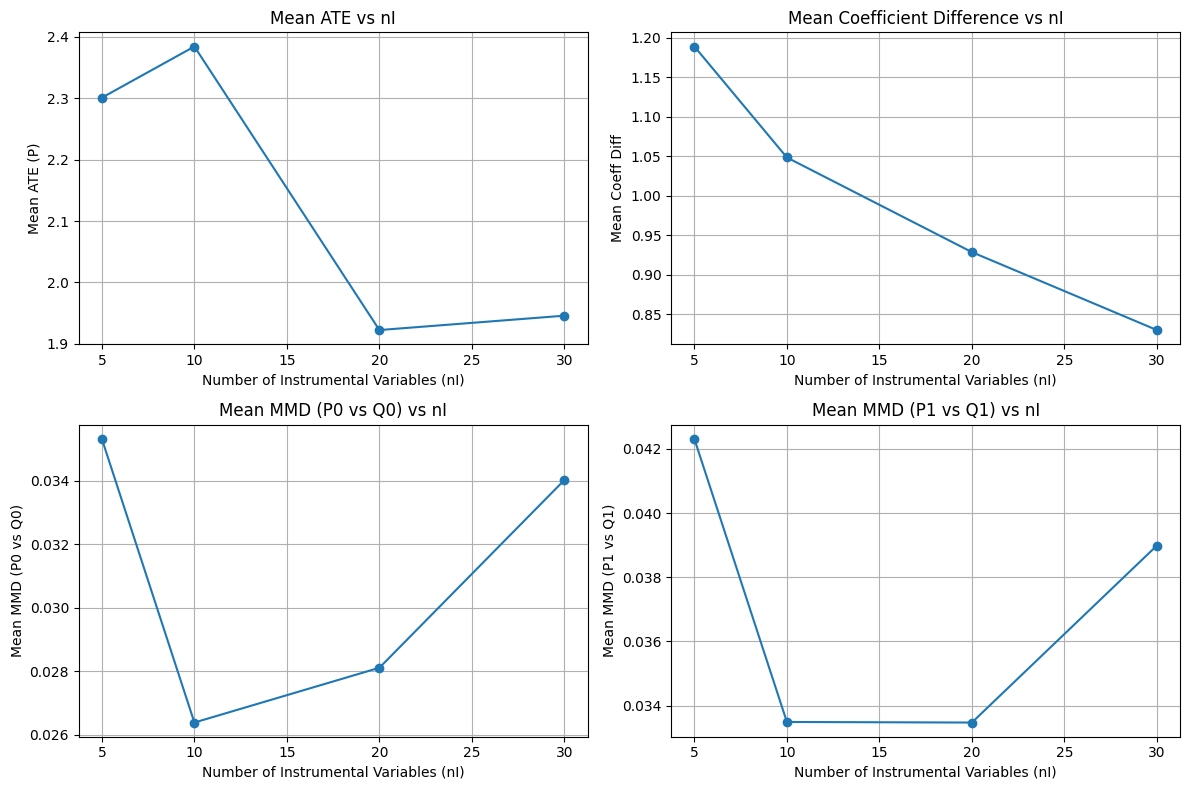

/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["ate_p"] for nI in nI_values], labels=nI_values, patch_artist=True)
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["coeff_diff"] for nI in nI_values], labels=nI_values, patch_artist=True)
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["mmd_p0_q0"] for nI in nI

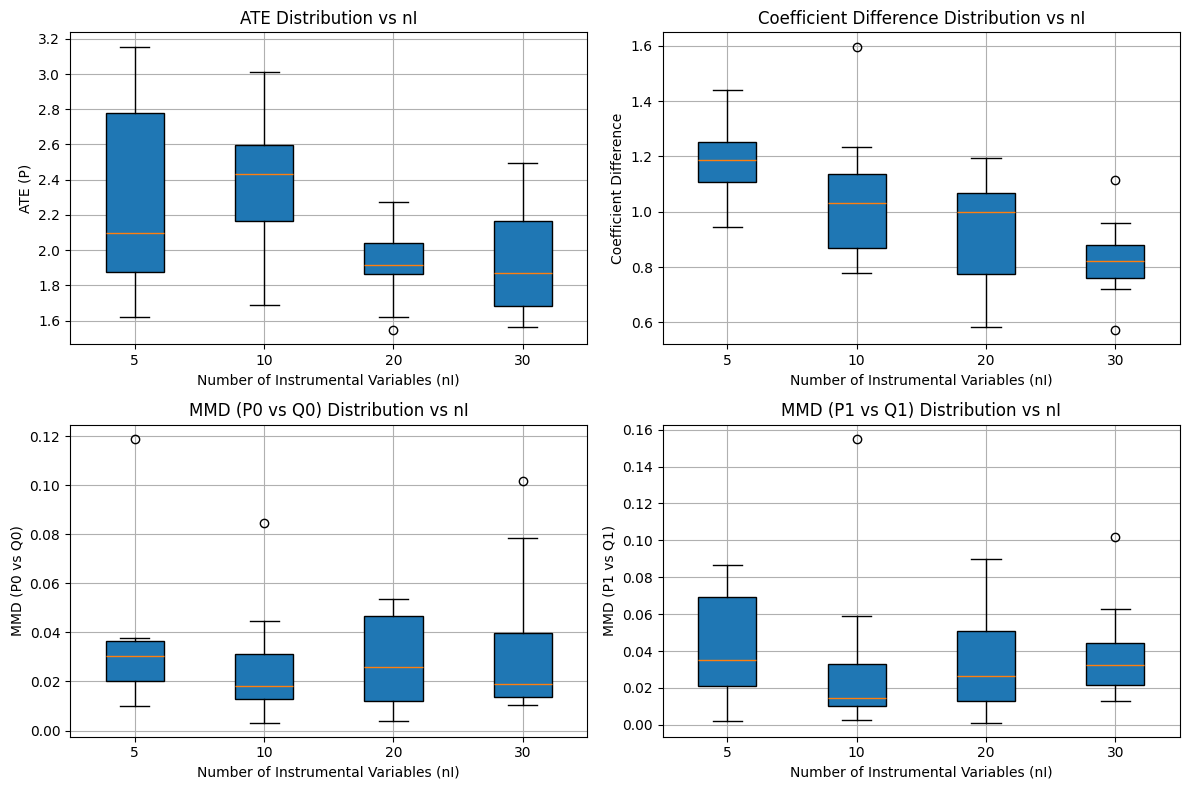

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
nI_values = list(tracker.keys())

# Compute means for each nI
mean_ate_p = [np.mean(tracker[nI]["ate_p"]) for nI in nI_values]
mean_coeff_diff = [np.mean(tracker[nI]["coeff_diff"]) for nI in nI_values]
mean_mmd_p0_q0 = [np.mean(tracker[nI]["mmd_p0_q0"]) for nI in nI_values]
mean_mmd_p1_q1 = [np.mean(tracker[nI]["mmd_p1_q1"]) for nI in nI_values]

# Line plots for means
plt.figure(figsize=(12, 8))

# ATE Plot
plt.subplot(2, 2, 1)
plt.plot(nI_values, mean_ate_p, marker='o', label='Mean ATE (P)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean ATE (P)')
plt.title('Mean ATE vs nI')
plt.grid(True)

# Coefficient Difference Plot
plt.subplot(2, 2, 2)
plt.plot(nI_values, mean_coeff_diff, marker='o', label='Mean Coeff Diff')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean Coeff Diff')
plt.title('Mean Coefficient Difference vs nI')
plt.grid(True)

# MMD P0 vs Q0
plt.subplot(2, 2, 3)
plt.plot(nI_values, mean_mmd_p0_q0, marker='o', label='Mean MMD (P0 vs Q0)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean MMD (P0 vs Q0)')
plt.title('Mean MMD (P0 vs Q0) vs nI')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(2, 2, 4)
plt.plot(nI_values, mean_mmd_p1_q1, marker='o', label='Mean MMD (P1 vs Q1)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean MMD (P1 vs Q1)')
plt.title('Mean MMD (P1 vs Q1) vs nI')
plt.grid(True)

plt.tight_layout()
plt.show()

# Boxplots for Distribution
plt.figure(figsize=(12, 8))

# Boxplot for ATE
plt.subplot(2, 2, 1)
plt.boxplot([tracker[nI]["ate_p"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('ATE (P)')
plt.title('ATE Distribution vs nI')
plt.grid(True)

# Boxplot for Coefficient Difference
plt.subplot(2, 2, 2)
plt.boxplot([tracker[nI]["coeff_diff"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Coefficient Difference')
plt.title('Coefficient Difference Distribution vs nI')
plt.grid(True)

# Boxplot for MMD P0 vs Q0
plt.subplot(2, 2, 3)
plt.boxplot([tracker[nI]["mmd_p0_q0"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('MMD (P0 vs Q0)')
plt.title('MMD (P0 vs Q0) Distribution vs nI')
plt.grid(True)

# Boxplot for MMD P1 vs Q1
plt.subplot(2, 2, 4)
plt.boxplot([tracker[nI]["mmd_p1_q1"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('MMD (P1 vs Q1)')
plt.title('MMD (P1 vs Q1) Distribution vs nI')
plt.grid(True)

plt.tight_layout()
plt.show()


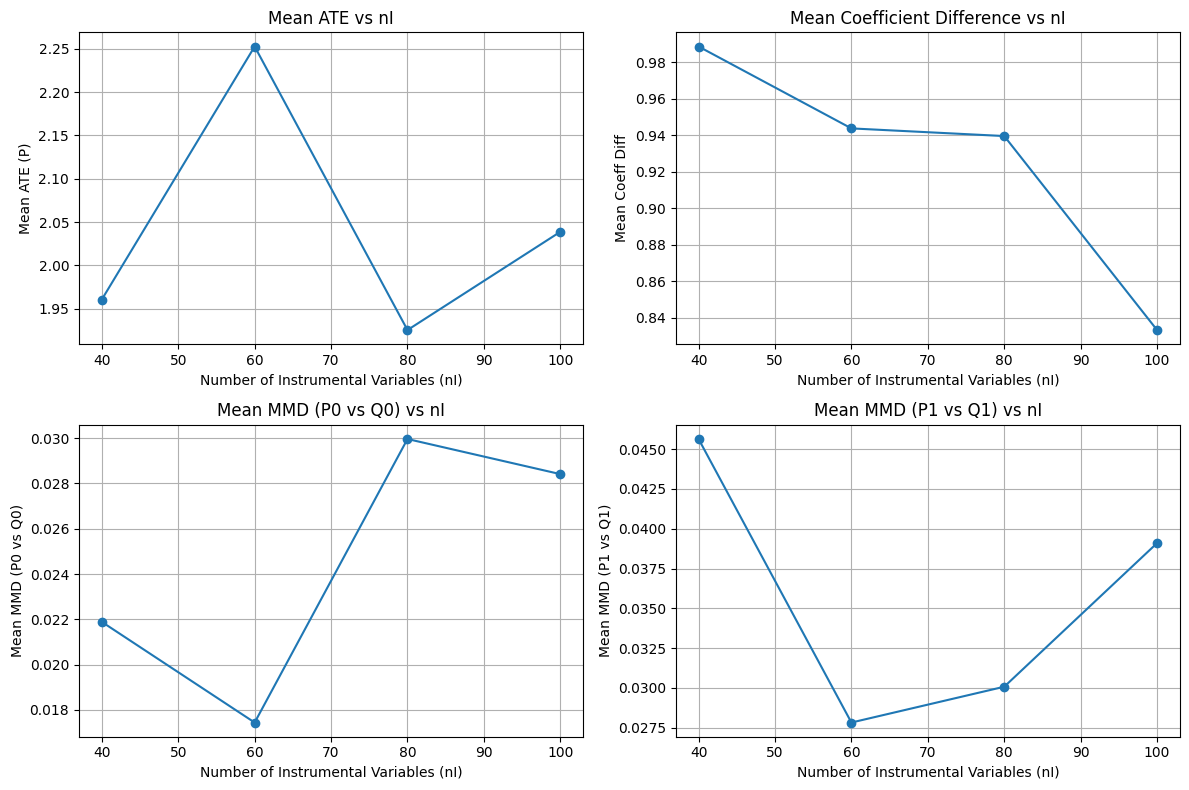

/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["ate_p"] for nI in nI_values], labels=nI_values, patch_artist=True)
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["coeff_diff"] for nI in nI_values], labels=nI_values, patch_artist=True)
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["mmd_p0_q0"] for nI in nI

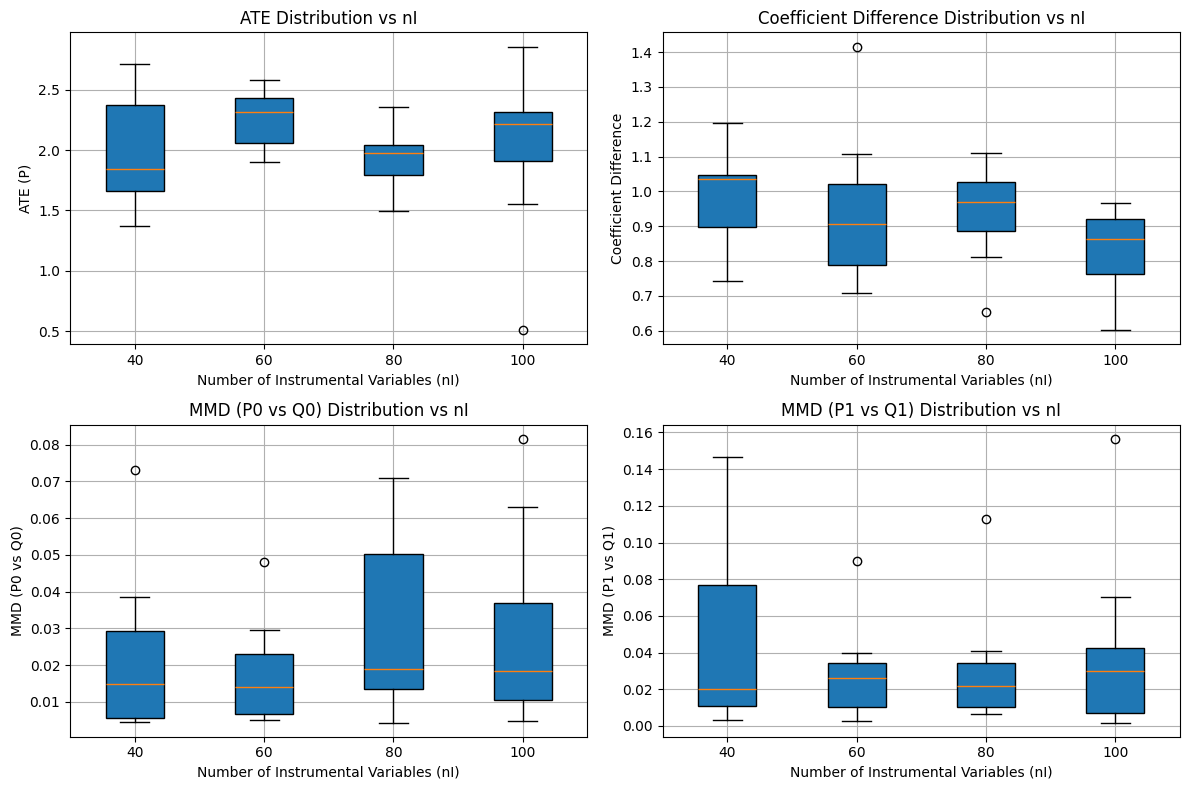

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
nI_values = list(tracker.keys())

# Compute means for each nI
mean_ate_p = [np.mean(tracker[nI]["ate_p"]) for nI in nI_values]
mean_coeff_diff = [np.mean(tracker[nI]["coeff_diff"]) for nI in nI_values]
mean_mmd_p0_q0 = [np.mean(tracker[nI]["mmd_p0_q0"]) for nI in nI_values]
mean_mmd_p1_q1 = [np.mean(tracker[nI]["mmd_p1_q1"]) for nI in nI_values]

# Line plots for means
plt.figure(figsize=(12, 8))

# ATE Plot
plt.subplot(2, 2, 1)
plt.plot(nI_values, mean_ate_p, marker='o', label='Mean ATE (P)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean ATE (P)')
plt.title('Mean ATE vs nI')
plt.grid(True)

# Coefficient Difference Plot
plt.subplot(2, 2, 2)
plt.plot(nI_values, mean_coeff_diff, marker='o', label='Mean Coeff Diff')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean Coeff Diff')
plt.title('Mean Coefficient Difference vs nI')
plt.grid(True)

# MMD P0 vs Q0
plt.subplot(2, 2, 3)
plt.plot(nI_values, mean_mmd_p0_q0, marker='o', label='Mean MMD (P0 vs Q0)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean MMD (P0 vs Q0)')
plt.title('Mean MMD (P0 vs Q0) vs nI')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(2, 2, 4)
plt.plot(nI_values, mean_mmd_p1_q1, marker='o', label='Mean MMD (P1 vs Q1)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean MMD (P1 vs Q1)')
plt.title('Mean MMD (P1 vs Q1) vs nI')
plt.grid(True)

plt.tight_layout()
plt.show()

# Boxplots for Distribution
plt.figure(figsize=(12, 8))

# Boxplot for ATE
plt.subplot(2, 2, 1)
plt.boxplot([tracker[nI]["ate_p"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('ATE (P)')
plt.title('ATE Distribution vs nI')
plt.grid(True)

# Boxplot for Coefficient Difference
plt.subplot(2, 2, 2)
plt.boxplot([tracker[nI]["coeff_diff"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Coefficient Difference')
plt.title('Coefficient Difference Distribution vs nI')
plt.grid(True)

# Boxplot for MMD P0 vs Q0
plt.subplot(2, 2, 3)
plt.boxplot([tracker[nI]["mmd_p0_q0"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('MMD (P0 vs Q0)')
plt.title('MMD (P0 vs Q0) Distribution vs nI')
plt.grid(True)

# Boxplot for MMD P1 vs Q1
plt.subplot(2, 2, 4)
plt.boxplot([tracker[nI]["mmd_p1_q1"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('MMD (P1 vs Q1)')
plt.title('MMD (P1 vs Q1) Distribution vs nI')
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
nrep = 30  # Number of repetitions
n_tr = 1000  # Training sample size
n_p = 1000  # Testing sample size
nI_values = [10, 20, 30]  # Different values of nI to iterate through
nX = 2
nO = 2
nS = 20
binary_intervention = True
num_iters = 4000  # Fixed number of training iterations
strength_instr = 0.5

# Initialize tracker for nI
tracker = {nI: {"ate_p": [], "ate_dr":[]} 
           for nI in nI_values}

# Begin loop over nI
for nI in nI_values:
    print(f"Running experiments for nI = {nI}")
    for rep in tqdm(range(nrep)):
        # Generate training and testing data
        df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
            torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
        y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)
        
        z_tr_np = df_tr[[f"X{i}" for i in range(1, p + 1)]].values
        x_tr_np = df_tr['A'].values
        y_tr_np = df_tr['y'].values

        model = Frengression(x_dim = x_tr.shape[1], y_dim = 1, z_dim =z_tr.shape[1], 
                             noise_dim=1, num_layer=3, hidden_dim=100, 
                             device=device, x_binary=binary_intervention, z_binary_dims=0)

        # Train Frengression model
        model.train_xz(torch.tensor(x_tr, dtype=torch.float32).view(-1, 1), 
                       torch.tensor(z_tr, dtype=torch.float32), num_iters=num_iters, lr=1e-4, print_every_iter=400)
        model.train_y(torch.tensor(x_tr, dtype=torch.float32).view(-1, 1), 
                      torch.tensor(z_tr, dtype=torch.float32), 
                      torch.tensor(y_tr, dtype=torch.float32).view(-1, 1), 
                      num_iters=num_iters, lr=1e-4, print_every_iter=400)
        x0=torch.tensor(np.array([0]*z_tr.shape[0])).reshape(x_tr.size())
        x1=torch.tensor(np.array([1]*z_tr.shape[0])).reshape(x_tr.size())
        xz0 = torch.cat([x0,z_tr],dim=1)
        xz1 = torch.cat([x1,z_tr],dim=1)
        # Sample model distributions
        P0 = model.predict_conditional(x0, xz0, sample_size=n_p).numpy().reshape(-1, 1)
        P1 = model.predict_conditional(x1, xz1, sample_size=n_p).numpy().reshape(-1, 1)
        ate_p = np.mean(P1) - np.mean(P0)

        # DR Estimation
        ate_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np, x_tr_np, y_tr_np, z_tr_np, ps_model = "rf")

        # Log results
        tracker[nI]["ate_p"].append(ate_p)
        tracker[nI]["ate_dr"].append(ate_dr)

Running experiments for nI = 10


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.6363, loss1 2.7787, loss2 0.2848
Epoch 400: loss 1.9657, loss1 3.8895, loss2 3.8476
Epoch 800: loss 1.9669, loss1 3.9261, loss2 3.9184
Epoch 1200: loss 1.9238, loss1 3.8756, loss2 3.9037
Epoch 1600: loss 1.9231, loss1 3.8871, loss2 3.9281
Epoch 2000: loss 1.9708, loss1 3.9154, loss2 3.8891
Epoch 2400: loss 1.9527, loss1 3.9179, loss2 3.9303
Epoch 2800: loss 1.9658, loss1 3.9118, loss2 3.8919
Epoch 3200: loss 1.9688, loss1 3.8860, loss2 3.8343
Epoch 3600: loss 1.9603, loss1 3.8924, loss2 3.8642
Epoch 4000: loss 1.9964, loss1 3.9395, loss2 3.8862
Epoch 1: loss 2.2044,	loss_y 1.4326, 1.4602, 0.0551,	loss_eta 0.7717, 0.8010, 0.0586
Epoch 400: loss 1.4670,	loss_y 0.7514, 1.7305, 1.9582,	loss_eta 0.7156, 1.0207, 0.6101
Epoch 800: loss 1.1281,	loss_y 0.5664, 1.2880, 1.4430,	loss_eta 0.5617, 1.2935, 1.4636
Epoch 1200: loss 1.1548,	loss_y 0.5285, 1.0391, 1.0211,	loss_eta 0.6263, 1.0895, 0.9263
Epoch 1600: loss 1.2227,	loss_y 0.5849, 1.3994, 1.6290,	loss_eta 0.6378, 1.2552, 1.234

  3%|▎         | 1/30 [01:31<44:26, 91.94s/it]

Epoch 1: loss 2.6406, loss1 2.7720, loss2 0.2628
Epoch 400: loss 1.9466, loss1 3.8841, loss2 3.8750
Epoch 800: loss 1.9980, loss1 3.9084, loss2 3.8208
Epoch 1200: loss 1.9323, loss1 3.8869, loss2 3.9093
Epoch 1600: loss 1.9362, loss1 3.9030, loss2 3.9335
Epoch 2000: loss 1.9592, loss1 3.9025, loss2 3.8867
Epoch 2400: loss 1.9537, loss1 3.9041, loss2 3.9008
Epoch 2800: loss 1.9776, loss1 3.9157, loss2 3.8761
Epoch 3200: loss 1.9258, loss1 3.9055, loss2 3.9593
Epoch 3600: loss 1.9667, loss1 3.9272, loss2 3.9210
Epoch 4000: loss 1.9480, loss1 3.8857, loss2 3.8753
Epoch 1: loss 2.1995,	loss_y 1.4382, 1.4722, 0.0680,	loss_eta 0.7613, 0.8006, 0.0785
Epoch 400: loss 1.3499,	loss_y 0.6651, 1.4056, 1.4810,	loss_eta 0.6848, 0.8293, 0.2890
Epoch 800: loss 1.3050,	loss_y 0.7656, 1.6783, 1.8253,	loss_eta 0.5394, 1.1380, 1.1972
Epoch 1200: loss 1.0305,	loss_y 0.4625, 0.9595, 0.9940,	loss_eta 0.5680, 1.0506, 0.9652
Epoch 1600: loss 0.9457,	loss_y 0.3662, 0.8730, 1.0136,	loss_eta 0.5795, 1.1874, 1.215

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:71: RuntimeWarning: invalid value encountered in divide
  phi = x_te / hat_propen *(y_te - hat_mu1) + (1-x_te) / (1-hat_propen) *(y_te - hat_mu0) +(hat_mu1 - hat_mu0)
  7%|▋         | 2/30 [02:57<41:01, 87.92s/it]

Epoch 1: loss 2.6745, loss1 2.7905, loss2 0.2319
Epoch 400: loss 1.9601, loss1 3.9082, loss2 3.8961
Epoch 800: loss 1.9497, loss1 3.9276, loss2 3.9558
Epoch 1200: loss 1.9973, loss1 3.9593, loss2 3.9240
Epoch 1600: loss 1.9950, loss1 3.9707, loss2 3.9515
Epoch 2000: loss 1.9752, loss1 3.9287, loss2 3.9071
Epoch 2400: loss 1.9549, loss1 3.9267, loss2 3.9435
Epoch 2800: loss 1.9518, loss1 3.9311, loss2 3.9585
Epoch 3200: loss 1.9785, loss1 3.9256, loss2 3.8942
Epoch 3600: loss 1.9734, loss1 3.9502, loss2 3.9537
Epoch 4000: loss 1.9881, loss1 3.9611, loss2 3.9460
Epoch 1: loss 2.2326,	loss_y 1.4901, 1.5097, 0.0394,	loss_eta 0.7426, 0.7844, 0.0837
Epoch 400: loss 1.4379,	loss_y 0.8259, 1.1981, 0.7443,	loss_eta 0.6120, 1.1302, 1.0364
Epoch 800: loss 1.3432,	loss_y 0.6605, 2.0117, 2.7024,	loss_eta 0.6828, 1.1921, 1.0187
Epoch 1200: loss 1.0402,	loss_y 0.4082, 0.9771, 1.1378,	loss_eta 0.6320, 0.9161, 0.5682
Epoch 1600: loss 1.0200,	loss_y 0.4418, 1.0558, 1.2280,	loss_eta 0.5782, 1.3558, 1.555

 10%|█         | 3/30 [04:17<38:01, 84.49s/it]

Epoch 1: loss 2.7023, loss1 2.8369, loss2 0.2691
Epoch 400: loss 2.0185, loss1 4.0455, loss2 4.0539
Epoch 800: loss 1.9887, loss1 3.9661, loss2 3.9548
Epoch 1200: loss 1.9644, loss1 3.9876, loss2 4.0464
Epoch 1600: loss 2.0361, loss1 4.0304, loss2 3.9885
Epoch 2000: loss 1.9634, loss1 3.9508, loss2 3.9749
Epoch 2400: loss 1.9818, loss1 3.9831, loss2 4.0025
Epoch 2800: loss 1.9854, loss1 3.9696, loss2 3.9683
Epoch 3200: loss 1.9916, loss1 3.9962, loss2 4.0090
Epoch 3600: loss 1.9895, loss1 3.9961, loss2 4.0133
Epoch 4000: loss 1.9720, loss1 3.9891, loss2 4.0341
Epoch 1: loss 2.2667,	loss_y 1.4848, 1.5271, 0.0847,	loss_eta 0.7820, 0.8138, 0.0636
Epoch 400: loss 2.0746,	loss_y 1.5145, 3.5290, 4.0290,	loss_eta 0.5602, 1.0411, 0.9619
Epoch 800: loss 1.4902,	loss_y 0.8110, 2.2184, 2.8147,	loss_eta 0.6791, 0.8936, 0.4290
Epoch 1200: loss 1.1653,	loss_y 0.5676, 1.7050, 2.2747,	loss_eta 0.5976, 1.3314, 1.4675
Epoch 1600: loss 1.0393,	loss_y 0.4404, 1.0891, 1.2975,	loss_eta 0.5989, 1.4831, 1.768

 13%|█▎        | 4/30 [05:39<36:09, 83.42s/it]

Epoch 1: loss 2.6416, loss1 2.7707, loss2 0.2581
Epoch 400: loss 1.9513, loss1 3.8788, loss2 3.8551
Epoch 800: loss 1.9456, loss1 3.9046, loss2 3.9180
Epoch 1200: loss 1.9467, loss1 3.8698, loss2 3.8463
Epoch 1600: loss 1.9581, loss1 3.9149, loss2 3.9136
Epoch 2000: loss 1.9488, loss1 3.8874, loss2 3.8771
Epoch 2400: loss 1.9227, loss1 3.8822, loss2 3.9190
Epoch 2800: loss 1.9606, loss1 3.9002, loss2 3.8792
Epoch 3200: loss 1.9436, loss1 3.8923, loss2 3.8973
Epoch 3600: loss 1.9455, loss1 3.9028, loss2 3.9147
Epoch 4000: loss 1.9564, loss1 3.9245, loss2 3.9363
Epoch 1: loss 2.2525,	loss_y 1.4846, 1.5157, 0.0622,	loss_eta 0.7680, 0.8037, 0.0714
Epoch 400: loss 1.6443,	loss_y 0.8452, 1.6106, 1.5308,	loss_eta 0.7991, 0.8109, 0.0235
Epoch 800: loss 1.3007,	loss_y 0.6287, 1.5428, 1.8282,	loss_eta 0.6720, 0.9960, 0.6479
Epoch 1200: loss 1.2556,	loss_y 0.5701, 1.4402, 1.7401,	loss_eta 0.6855, 0.7900, 0.2090
Epoch 1600: loss 1.2552,	loss_y 0.5204, 1.2037, 1.3667,	loss_eta 0.7348, 1.2459, 1.022

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:71: RuntimeWarning: invalid value encountered in divide
  phi = x_te / hat_propen *(y_te - hat_mu1) + (1-x_te) / (1-hat_propen) *(y_te - hat_mu0) +(hat_mu1 - hat_mu0)
 17%|█▋        | 5/30 [06:57<33:59, 81.59s/it]

Epoch 1: loss 2.5993, loss1 2.7332, loss2 0.2678
Epoch 400: loss 1.9936, loss1 3.8640, loss2 3.7408
Epoch 800: loss 1.9561, loss1 3.9127, loss2 3.9131
Epoch 1200: loss 1.9114, loss1 3.8405, loss2 3.8583
Epoch 1600: loss 1.9276, loss1 3.8468, loss2 3.8385
Epoch 2000: loss 1.9402, loss1 3.8362, loss2 3.7919
Epoch 2400: loss 1.9553, loss1 3.8640, loss2 3.8175
Epoch 2800: loss 1.9327, loss1 3.8525, loss2 3.8395
Epoch 3200: loss 1.9264, loss1 3.8436, loss2 3.8344
Epoch 3600: loss 1.9284, loss1 3.8443, loss2 3.8317
Epoch 4000: loss 1.9325, loss1 3.8203, loss2 3.7756
Epoch 1: loss 2.3164,	loss_y 1.5089, 1.5406, 0.0634,	loss_eta 0.8075, 0.8444, 0.0736
Epoch 400: loss 1.9881,	loss_y 1.4130, 2.5442, 2.2624,	loss_eta 0.5751, 0.9174, 0.6847
Epoch 800: loss 1.3490,	loss_y 0.5740, 0.9898, 0.8317,	loss_eta 0.7750, 1.4415, 1.3329
Epoch 1200: loss 1.4321,	loss_y 0.7385, 1.6316, 1.7862,	loss_eta 0.6936, 0.8975, 0.4077
Epoch 1600: loss 1.3116,	loss_y 0.6495, 1.2705, 1.2420,	loss_eta 0.6621, 1.8368, 2.349

 20%|██        | 6/30 [08:20<32:48, 82.00s/it]

Epoch 1: loss 2.6440, loss1 2.7755, loss2 0.2630
Epoch 400: loss 1.9169, loss1 3.8411, loss2 3.8485
Epoch 800: loss 1.9405, loss1 3.8974, loss2 3.9138
Epoch 1200: loss 1.9704, loss1 3.9297, loss2 3.9187
Epoch 1600: loss 1.9600, loss1 3.8895, loss2 3.8590
Epoch 2000: loss 1.9580, loss1 3.8866, loss2 3.8571
Epoch 2400: loss 1.9598, loss1 3.9363, loss2 3.9530
Epoch 2800: loss 1.9323, loss1 3.8858, loss2 3.9069
Epoch 3200: loss 1.9296, loss1 3.8800, loss2 3.9008
Epoch 3600: loss 1.9382, loss1 3.8830, loss2 3.8897
Epoch 4000: loss 1.9574, loss1 3.8808, loss2 3.8468
Epoch 1: loss 2.2060,	loss_y 1.4864, 1.4989, 0.0250,	loss_eta 0.7196, 0.7560, 0.0728
Epoch 400: loss 1.3201,	loss_y 0.7526, 1.2292, 0.9531,	loss_eta 0.5674, 0.9885, 0.8421
Epoch 800: loss 1.0554,	loss_y 0.4432, 0.8970, 0.9075,	loss_eta 0.6122, 1.4246, 1.6248
Epoch 1200: loss 1.1693,	loss_y 0.5788, 1.0719, 0.9862,	loss_eta 0.5906, 1.2521, 1.3231
Epoch 1600: loss 1.0020,	loss_y 0.4658, 1.1065, 1.2813,	loss_eta 0.5362, 1.1566, 1.240

 23%|██▎       | 7/30 [09:40<31:12, 81.40s/it]

Epoch 1: loss 2.7019, loss1 2.8221, loss2 0.2403
Epoch 400: loss 1.9572, loss1 3.9432, loss2 3.9720
Epoch 800: loss 1.9661, loss1 3.9501, loss2 3.9679
Epoch 1200: loss 2.0030, loss1 3.9753, loss2 3.9447
Epoch 1600: loss 2.0013, loss1 3.9863, loss2 3.9698
Epoch 2000: loss 1.9877, loss1 3.9770, loss2 3.9787
Epoch 2400: loss 1.9899, loss1 3.9819, loss2 3.9840
Epoch 2800: loss 1.9966, loss1 3.9828, loss2 3.9725
Epoch 3200: loss 1.9775, loss1 3.9708, loss2 3.9866
Epoch 3600: loss 1.9643, loss1 3.9369, loss2 3.9452
Epoch 4000: loss 1.9659, loss1 3.9656, loss2 3.9994
Epoch 1: loss 2.1169,	loss_y 1.3799, 1.4276, 0.0954,	loss_eta 0.7370, 0.7930, 0.1120
Epoch 400: loss 1.7256,	loss_y 1.0390, 2.7650, 3.4520,	loss_eta 0.6866, 0.9959, 0.6186
Epoch 800: loss 1.1932,	loss_y 0.5717, 1.0509, 0.9586,	loss_eta 0.6215, 0.8828, 0.5224
Epoch 1200: loss 1.0466,	loss_y 0.4814, 0.8522, 0.7415,	loss_eta 0.5652, 1.2948, 1.4593
Epoch 1600: loss 1.2007,	loss_y 0.5431, 1.1953, 1.3044,	loss_eta 0.6576, 0.8741, 0.433

 27%|██▋       | 8/30 [11:00<29:39, 80.88s/it]

Epoch 1: loss 2.6845, loss1 2.8188, loss2 0.2688
Epoch 400: loss 1.9604, loss1 3.9286, loss2 3.9365
Epoch 800: loss 1.9675, loss1 3.9248, loss2 3.9147
Epoch 1200: loss 1.9843, loss1 3.9793, loss2 3.9900
Epoch 1600: loss 1.9968, loss1 3.9679, loss2 3.9421
Epoch 2000: loss 2.0061, loss1 3.9483, loss2 3.8845
Epoch 2400: loss 1.9745, loss1 3.9562, loss2 3.9633
Epoch 2800: loss 1.9997, loss1 3.9519, loss2 3.9044
Epoch 3200: loss 1.9615, loss1 3.9564, loss2 3.9897
Epoch 3600: loss 2.0034, loss1 3.9964, loss2 3.9860
Epoch 4000: loss 1.9585, loss1 3.9579, loss2 3.9989
Epoch 1: loss 2.2689,	loss_y 1.5274, 1.5494, 0.0440,	loss_eta 0.7415, 0.7822, 0.0814
Epoch 400: loss 1.6130,	loss_y 0.9302, 2.5970, 3.3336,	loss_eta 0.6828, 0.8191, 0.2726
Epoch 800: loss 1.4601,	loss_y 0.7131, 2.0794, 2.7326,	loss_eta 0.7470, 0.8079, 0.1219
Epoch 1200: loss 1.1967,	loss_y 0.5378, 1.2049, 1.3341,	loss_eta 0.6589, 1.0200, 0.7221
Epoch 1600: loss 1.0580,	loss_y 0.4523, 1.0722, 1.2397,	loss_eta 0.6056, 1.3613, 1.511

 30%|███       | 9/30 [12:21<28:22, 81.09s/it]

Epoch 1: loss 2.6983, loss1 2.8224, loss2 0.2482
Epoch 400: loss 1.9723, loss1 3.9390, loss2 3.9333
Epoch 800: loss 1.9886, loss1 3.9601, loss2 3.9431
Epoch 1200: loss 1.9610, loss1 3.9398, loss2 3.9575
Epoch 1600: loss 2.0109, loss1 4.0033, loss2 3.9847
Epoch 2000: loss 1.9860, loss1 3.9594, loss2 3.9467
Epoch 2400: loss 1.9719, loss1 3.9560, loss2 3.9682
Epoch 2800: loss 1.9717, loss1 3.9835, loss2 4.0237
Epoch 3200: loss 1.9884, loss1 3.9792, loss2 3.9816
Epoch 3600: loss 1.9900, loss1 3.9533, loss2 3.9267
Epoch 4000: loss 1.9753, loss1 3.9804, loss2 4.0102
Epoch 1: loss 2.1690,	loss_y 1.3911, 1.4247, 0.0674,	loss_eta 0.7779, 0.8113, 0.0668
Epoch 400: loss 1.4039,	loss_y 0.6499, 1.5373, 1.7748,	loss_eta 0.7540, 0.7961, 0.0841
Epoch 800: loss 1.3661,	loss_y 0.6350, 1.1121, 0.9542,	loss_eta 0.7311, 0.8158, 0.1694
Epoch 1200: loss 1.2125,	loss_y 0.5272, 1.1885, 1.3226,	loss_eta 0.6853, 0.9847, 0.5989
Epoch 1600: loss 1.1026,	loss_y 0.5233, 1.0050, 0.9634,	loss_eta 0.5793, 1.2224, 1.286

 33%|███▎      | 10/30 [13:37<26:30, 79.52s/it]

Epoch 1: loss 2.6642, loss1 2.8095, loss2 0.2905
Epoch 400: loss 1.9529, loss1 3.9468, loss2 3.9877
Epoch 800: loss 1.9948, loss1 3.9740, loss2 3.9582
Epoch 1200: loss 1.9707, loss1 3.9046, loss2 3.8676
Epoch 1600: loss 1.9478, loss1 3.9077, loss2 3.9198
Epoch 2000: loss 1.9656, loss1 3.9290, loss2 3.9269
Epoch 2400: loss 1.9712, loss1 3.9336, loss2 3.9248
Epoch 2800: loss 1.9843, loss1 3.9391, loss2 3.9096
Epoch 3200: loss 1.9749, loss1 3.9615, loss2 3.9732
Epoch 3600: loss 1.9696, loss1 3.9327, loss2 3.9263
Epoch 4000: loss 1.9733, loss1 3.9470, loss2 3.9474
Epoch 1: loss 2.2051,	loss_y 1.4518, 1.4652, 0.0268,	loss_eta 0.7533, 0.7887, 0.0710
Epoch 400: loss 1.1538,	loss_y 0.5811, 1.2823, 1.4024,	loss_eta 0.5727, 1.1828, 1.2201
Epoch 800: loss 1.3024,	loss_y 0.5882, 1.1264, 1.0765,	loss_eta 0.7142, 0.8680, 0.3077
Epoch 1200: loss 1.0096,	loss_y 0.3979, 0.9122, 1.0285,	loss_eta 0.6116, 1.5481, 1.8729
Epoch 1600: loss 1.0377,	loss_y 0.4958, 1.1840, 1.3765,	loss_eta 0.5419, 0.9146, 0.745

 37%|███▋      | 11/30 [14:57<25:09, 79.43s/it]

Epoch 1: loss 2.7313, loss1 2.8632, loss2 0.2638
Epoch 400: loss 2.0163, loss1 4.0186, loss2 4.0045
Epoch 800: loss 2.0201, loss1 4.0086, loss2 3.9770
Epoch 1200: loss 2.0202, loss1 4.0299, loss2 4.0194
Epoch 1600: loss 2.0007, loss1 3.9953, loss2 3.9891
Epoch 2000: loss 2.0116, loss1 4.0089, loss2 3.9946
Epoch 2400: loss 2.0472, loss1 4.0633, loss2 4.0323
Epoch 2800: loss 2.0307, loss1 4.0677, loss2 4.0741
Epoch 3200: loss 1.9945, loss1 4.0141, loss2 4.0392
Epoch 3600: loss 1.9675, loss1 3.9974, loss2 4.0599
Epoch 4000: loss 1.9834, loss1 4.0068, loss2 4.0469
Epoch 1: loss 2.2127,	loss_y 1.4724, 1.4916, 0.0383,	loss_eta 0.7402, 0.7788, 0.0772
Epoch 400: loss 1.3403,	loss_y 0.6244, 1.0131, 0.7774,	loss_eta 0.7159, 0.9288, 0.4258
Epoch 800: loss 1.6692,	loss_y 1.0513, 1.8549, 1.6073,	loss_eta 0.6179, 0.9381, 0.6403
Epoch 1200: loss 1.2878,	loss_y 0.6954, 1.2770, 1.1633,	loss_eta 0.5924, 0.9846, 0.7843
Epoch 1600: loss 1.0314,	loss_y 0.4682, 1.1351, 1.3338,	loss_eta 0.5632, 1.1480, 1.169

 40%|████      | 12/30 [16:06<22:52, 76.25s/it]

Epoch 1: loss 2.6663, loss1 2.7928, loss2 0.2529
Epoch 400: loss 1.9736, loss1 3.9117, loss2 3.8764
Epoch 800: loss 1.9670, loss1 3.9074, loss2 3.8808
Epoch 1200: loss 1.9620, loss1 3.9188, loss2 3.9136
Epoch 1600: loss 1.9558, loss1 3.9130, loss2 3.9143
Epoch 2000: loss 1.9638, loss1 3.9123, loss2 3.8970
Epoch 2400: loss 1.9568, loss1 3.9116, loss2 3.9096
Epoch 2800: loss 1.9702, loss1 3.9269, loss2 3.9134
Epoch 3200: loss 1.9611, loss1 3.9400, loss2 3.9577
Epoch 3600: loss 1.9486, loss1 3.9200, loss2 3.9429
Epoch 4000: loss 1.9660, loss1 3.9104, loss2 3.8887
Epoch 1: loss 2.2578,	loss_y 1.4731, 1.4909, 0.0356,	loss_eta 0.7847, 0.8161, 0.0626
Epoch 400: loss 1.0852,	loss_y 0.4985, 0.9974, 0.9977,	loss_eta 0.5866, 0.9931, 0.8129
Epoch 800: loss 1.2132,	loss_y 0.5186, 1.4154, 1.7936,	loss_eta 0.6946, 0.8213, 0.2534
Epoch 1200: loss 1.2220,	loss_y 0.6250, 1.2546, 1.2593,	loss_eta 0.5970, 1.0400, 0.8860
Epoch 1600: loss 0.9809,	loss_y 0.4036, 0.8118, 0.8163,	loss_eta 0.5773, 1.2974, 1.440

 43%|████▎     | 13/30 [17:13<20:49, 73.52s/it]

Epoch 1: loss 2.6673, loss1 2.8040, loss2 0.2734
Epoch 400: loss 1.9625, loss1 3.9123, loss2 3.8996
Epoch 800: loss 1.9879, loss1 3.9647, loss2 3.9536
Epoch 1200: loss 1.9346, loss1 3.9301, loss2 3.9910
Epoch 1600: loss 2.0006, loss1 3.9579, loss2 3.9147
Epoch 2000: loss 1.9813, loss1 3.9169, loss2 3.8712
Epoch 2400: loss 1.9619, loss1 3.9244, loss2 3.9249
Epoch 2800: loss 1.9473, loss1 3.9193, loss2 3.9439
Epoch 3200: loss 1.9679, loss1 3.9339, loss2 3.9320
Epoch 3600: loss 1.9847, loss1 3.9419, loss2 3.9143
Epoch 4000: loss 1.9650, loss1 3.9380, loss2 3.9462
Epoch 1: loss 2.2211,	loss_y 1.4498, 1.5134, 0.1271,	loss_eta 0.7713, 0.8021, 0.0616
Epoch 400: loss 1.5763,	loss_y 0.8791, 1.9540, 2.1497,	loss_eta 0.6971, 1.0768, 0.7593
Epoch 800: loss 1.3776,	loss_y 0.7407, 1.8459, 2.2103,	loss_eta 0.6369, 1.6201, 1.9664
Epoch 1200: loss 1.1253,	loss_y 0.5540, 1.2647, 1.4214,	loss_eta 0.5713, 1.3737, 1.6047
Epoch 1600: loss 1.0184,	loss_y 0.4214, 0.8370, 0.8313,	loss_eta 0.5970, 0.9689, 0.743

 47%|████▋     | 14/30 [18:25<19:30, 73.18s/it]

Epoch 1: loss 2.6542, loss1 2.7842, loss2 0.2599
Epoch 400: loss 1.9331, loss1 3.8917, loss2 3.9173
Epoch 800: loss 1.9253, loss1 3.8915, loss2 3.9325
Epoch 1200: loss 1.9840, loss1 3.9370, loss2 3.9060
Epoch 1600: loss 1.9467, loss1 3.8780, loss2 3.8626
Epoch 2000: loss 1.9182, loss1 3.8981, loss2 3.9599
Epoch 2400: loss 1.9484, loss1 3.8976, loss2 3.8984
Epoch 2800: loss 1.9622, loss1 3.9004, loss2 3.8763
Epoch 3200: loss 1.9660, loss1 3.8958, loss2 3.8595
Epoch 3600: loss 1.9752, loss1 3.9325, loss2 3.9144
Epoch 4000: loss 1.9318, loss1 3.8793, loss2 3.8949
Epoch 1: loss 2.2886,	loss_y 1.5515, 1.5665, 0.0298,	loss_eta 0.7371, 0.7838, 0.0936
Epoch 400: loss 1.3576,	loss_y 0.6714, 1.5198, 1.6969,	loss_eta 0.6862, 0.8905, 0.4087
Epoch 800: loss 1.6965,	loss_y 1.0560, 1.8276, 1.5431,	loss_eta 0.6404, 1.4920, 1.7031
Epoch 1200: loss 1.2245,	loss_y 0.5890, 1.0002, 0.8225,	loss_eta 0.6356, 0.8343, 0.3975
Epoch 1600: loss 1.2776,	loss_y 0.5704, 1.0548, 0.9687,	loss_eta 0.7072, 0.8773, 0.340

 50%|█████     | 15/30 [19:34<17:56, 71.74s/it]

Epoch 1: loss 2.6816, loss1 2.8166, loss2 0.2701
Epoch 400: loss 1.9714, loss1 3.9501, loss2 3.9575
Epoch 800: loss 1.9757, loss1 3.9493, loss2 3.9471
Epoch 1200: loss 1.9502, loss1 3.9015, loss2 3.9025
Epoch 1600: loss 1.9591, loss1 3.9164, loss2 3.9146
Epoch 2000: loss 1.9645, loss1 3.9241, loss2 3.9192
Epoch 2400: loss 1.9799, loss1 3.9652, loss2 3.9706
Epoch 2800: loss 1.9625, loss1 3.9215, loss2 3.9182
Epoch 3200: loss 1.9883, loss1 3.9573, loss2 3.9380
Epoch 3600: loss 2.0062, loss1 3.9651, loss2 3.9178
Epoch 4000: loss 1.9660, loss1 3.9411, loss2 3.9503
Epoch 1: loss 2.2596,	loss_y 1.5214, 1.5364, 0.0302,	loss_eta 0.7382, 0.7748, 0.0732
Epoch 400: loss 1.2434,	loss_y 0.5262, 1.1497, 1.2469,	loss_eta 0.7172, 0.8852, 0.3361
Epoch 800: loss 1.3224,	loss_y 0.6343, 1.2917, 1.3148,	loss_eta 0.6881, 0.9121, 0.4479
Epoch 1200: loss 1.2500,	loss_y 0.5511, 0.9148, 0.7274,	loss_eta 0.6989, 0.7842, 0.1706
Epoch 1600: loss 1.0830,	loss_y 0.4546, 0.9527, 0.9962,	loss_eta 0.6284, 0.9980, 0.739

 53%|█████▎    | 16/30 [20:42<16:29, 70.68s/it]

Epoch 1: loss 2.6514, loss1 2.7782, loss2 0.2535
Epoch 400: loss 1.9593, loss1 3.9253, loss2 3.9319
Epoch 800: loss 1.9627, loss1 3.9065, loss2 3.8876
Epoch 1200: loss 1.9360, loss1 3.9231, loss2 3.9742
Epoch 1600: loss 1.9362, loss1 3.8908, loss2 3.9093
Epoch 2000: loss 1.9514, loss1 3.8915, loss2 3.8803
Epoch 2400: loss 1.9810, loss1 3.9448, loss2 3.9276
Epoch 2800: loss 1.9741, loss1 3.8888, loss2 3.8294
Epoch 3200: loss 1.9589, loss1 3.9148, loss2 3.9118
Epoch 3600: loss 1.9595, loss1 3.9329, loss2 3.9470
Epoch 4000: loss 1.9364, loss1 3.8812, loss2 3.8896
Epoch 1: loss 2.2632,	loss_y 1.5092, 1.5322, 0.0460,	loss_eta 0.7539, 0.8042, 0.1006
Epoch 400: loss 1.4342,	loss_y 0.6634, 1.2141, 1.1014,	loss_eta 0.7708, 0.8332, 0.1248
Epoch 800: loss 1.4273,	loss_y 0.8628, 1.4660, 1.2066,	loss_eta 0.5645, 0.8617, 0.5943
Epoch 1200: loss 1.3357,	loss_y 0.6931, 1.3173, 1.2484,	loss_eta 0.6426, 0.9733, 0.6613
Epoch 1600: loss 1.1562,	loss_y 0.5711, 1.5400, 1.9377,	loss_eta 0.5851, 1.3230, 1.475

 57%|█████▋    | 17/30 [21:48<15:01, 69.32s/it]

Epoch 1: loss 2.6783, loss1 2.7981, loss2 0.2397
Epoch 400: loss 1.9695, loss1 3.9520, loss2 3.9650
Epoch 800: loss 1.9500, loss1 3.9170, loss2 3.9340
Epoch 1200: loss 1.9969, loss1 3.9616, loss2 3.9293
Epoch 1600: loss 1.9989, loss1 3.9631, loss2 3.9285
Epoch 2000: loss 1.9476, loss1 3.9165, loss2 3.9378
Epoch 2400: loss 2.0079, loss1 3.9624, loss2 3.9089
Epoch 2800: loss 1.9745, loss1 3.9385, loss2 3.9281
Epoch 3200: loss 1.9789, loss1 3.9458, loss2 3.9337
Epoch 3600: loss 1.9698, loss1 3.9380, loss2 3.9364
Epoch 4000: loss 1.9883, loss1 3.9541, loss2 3.9316
Epoch 1: loss 2.2927,	loss_y 1.4996, 1.5449, 0.0907,	loss_eta 0.7931, 0.8366, 0.0870
Epoch 400: loss 1.8254,	loss_y 1.1497, 2.3753, 2.4513,	loss_eta 0.6757, 0.8817, 0.4120
Epoch 800: loss 1.2922,	loss_y 0.6263, 1.3915, 1.5304,	loss_eta 0.6658, 0.9655, 0.5992
Epoch 1200: loss 1.1520,	loss_y 0.5176, 1.3429, 1.6507,	loss_eta 0.6345, 1.3152, 1.3615
Epoch 1600: loss 1.0735,	loss_y 0.5248, 1.0673, 1.0849,	loss_eta 0.5487, 1.0884, 1.079

 60%|██████    | 18/30 [22:59<13:58, 69.89s/it]

Epoch 1: loss 2.6556, loss1 2.7783, loss2 0.2454
Epoch 400: loss 1.9393, loss1 3.8665, loss2 3.8544
Epoch 800: loss 1.9945, loss1 3.9269, loss2 3.8649
Epoch 1200: loss 1.9634, loss1 3.9087, loss2 3.8904
Epoch 1600: loss 1.9770, loss1 3.9350, loss2 3.9159
Epoch 2000: loss 1.9510, loss1 3.9315, loss2 3.9609
Epoch 2400: loss 1.9518, loss1 3.9108, loss2 3.9181
Epoch 2800: loss 1.9696, loss1 3.9266, loss2 3.9141
Epoch 3200: loss 1.9609, loss1 3.9009, loss2 3.8800
Epoch 3600: loss 1.9720, loss1 3.9295, loss2 3.9149
Epoch 4000: loss 1.9202, loss1 3.8827, loss2 3.9249
Epoch 1: loss 2.2897,	loss_y 1.5181, 1.5458, 0.0555,	loss_eta 0.7716, 0.8017, 0.0602
Epoch 400: loss 1.5744,	loss_y 0.9429, 1.6097, 1.3336,	loss_eta 0.6314, 1.0709, 0.8790
Epoch 800: loss 1.1646,	loss_y 0.5148, 1.1923, 1.3550,	loss_eta 0.6499, 1.0325, 0.7653
Epoch 1200: loss 1.4150,	loss_y 0.7755, 2.1259, 2.7009,	loss_eta 0.6395, 1.2303, 1.1816
Epoch 1600: loss 1.2049,	loss_y 0.6408, 1.5462, 1.8108,	loss_eta 0.5642, 0.9918, 0.855

 63%|██████▎   | 19/30 [24:07<12:43, 69.37s/it]

Epoch 1: loss 2.6613, loss1 2.7963, loss2 0.2701
Epoch 400: loss 1.9700, loss1 3.9289, loss2 3.9178
Epoch 800: loss 1.9508, loss1 3.9296, loss2 3.9577
Epoch 1200: loss 1.9768, loss1 3.9156, loss2 3.8775
Epoch 1600: loss 1.9441, loss1 3.9171, loss2 3.9461
Epoch 2000: loss 1.9572, loss1 3.9189, loss2 3.9234
Epoch 2400: loss 1.9806, loss1 3.9308, loss2 3.9005
Epoch 2800: loss 1.9944, loss1 3.9755, loss2 3.9621
Epoch 3200: loss 1.9892, loss1 3.9360, loss2 3.8936
Epoch 3600: loss 1.9580, loss1 3.9138, loss2 3.9116
Epoch 4000: loss 1.9582, loss1 3.9084, loss2 3.9005
Epoch 1: loss 2.3901,	loss_y 1.6425, 1.6627, 0.0404,	loss_eta 0.7475, 0.7794, 0.0636
Epoch 400: loss 1.4849,	loss_y 0.8414, 1.7169, 1.7509,	loss_eta 0.6435, 0.9483, 0.6096
Epoch 800: loss 1.7005,	loss_y 0.9716, 1.7538, 1.5644,	loss_eta 0.7288, 0.8112, 0.1647
Epoch 1200: loss 1.5080,	loss_y 0.8521, 1.5605, 1.4168,	loss_eta 0.6559, 0.9650, 0.6183
Epoch 1600: loss 1.1269,	loss_y 0.5092, 1.1550, 1.2916,	loss_eta 0.6176, 0.8871, 0.538

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:71: RuntimeWarning: invalid value encountered in divide
  phi = x_te / hat_propen *(y_te - hat_mu1) + (1-x_te) / (1-hat_propen) *(y_te - hat_mu0) +(hat_mu1 - hat_mu0)
 67%|██████▋   | 20/30 [25:15<11:29, 68.92s/it]

Epoch 1: loss 2.6592, loss1 2.7966, loss2 0.2748
Epoch 400: loss 1.9517, loss1 3.9172, loss2 3.9309
Epoch 800: loss 1.9746, loss1 3.9334, loss2 3.9177
Epoch 1200: loss 1.9685, loss1 3.9101, loss2 3.8832
Epoch 1600: loss 1.9570, loss1 3.9225, loss2 3.9311
Epoch 2000: loss 1.9460, loss1 3.9341, loss2 3.9762
Epoch 2400: loss 1.9697, loss1 3.9347, loss2 3.9300
Epoch 2800: loss 1.9683, loss1 3.9319, loss2 3.9272
Epoch 3200: loss 1.9607, loss1 3.9228, loss2 3.9242
Epoch 3600: loss 1.9718, loss1 3.9448, loss2 3.9461
Epoch 4000: loss 1.9559, loss1 3.9144, loss2 3.9171
Epoch 1: loss 2.2509,	loss_y 1.4689, 1.5024, 0.0671,	loss_eta 0.7820, 0.8163, 0.0685
Epoch 400: loss 1.5601,	loss_y 0.9679, 2.0893, 2.2427,	loss_eta 0.5922, 1.3407, 1.4972
Epoch 800: loss 1.1606,	loss_y 0.5590, 0.8749, 0.6319,	loss_eta 0.6016, 0.9827, 0.7622
Epoch 1200: loss 1.2073,	loss_y 0.5603, 1.0906, 1.0606,	loss_eta 0.6470, 1.2545, 1.2152
Epoch 1600: loss 1.0261,	loss_y 0.4561, 1.0370, 1.1618,	loss_eta 0.5700, 1.4519, 1.763

 70%|███████   | 21/30 [26:22<10:15, 68.35s/it]

Epoch 1: loss 2.6918, loss1 2.8284, loss2 0.2732
Epoch 400: loss 1.9907, loss1 3.9684, loss2 3.9555
Epoch 800: loss 1.9996, loss1 3.9840, loss2 3.9687
Epoch 1200: loss 1.9844, loss1 3.9790, loss2 3.9892
Epoch 1600: loss 2.0271, loss1 4.0016, loss2 3.9488
Epoch 2000: loss 1.9977, loss1 3.9803, loss2 3.9653
Epoch 2400: loss 2.0310, loss1 3.9976, loss2 3.9331
Epoch 2800: loss 2.0322, loss1 3.9733, loss2 3.8823
Epoch 3200: loss 1.9620, loss1 3.9691, loss2 4.0143
Epoch 3600: loss 1.9927, loss1 3.9746, loss2 3.9638
Epoch 4000: loss 1.9809, loss1 4.0167, loss2 4.0716
Epoch 1: loss 2.2619,	loss_y 1.4731, 1.4845, 0.0227,	loss_eta 0.7888, 0.8231, 0.0687
Epoch 400: loss 1.1893,	loss_y 0.5579, 1.2301, 1.3445,	loss_eta 0.6314, 1.0699, 0.8769
Epoch 800: loss 1.3416,	loss_y 0.6967, 1.0892, 0.7852,	loss_eta 0.6450, 0.8875, 0.4851
Epoch 1200: loss 1.1723,	loss_y 0.5934, 1.2372, 1.2876,	loss_eta 0.5788, 1.1160, 1.0743
Epoch 1600: loss 1.0045,	loss_y 0.4243, 0.8272, 0.8058,	loss_eta 0.5802, 1.2081, 1.255

 73%|███████▎  | 22/30 [27:34<09:14, 69.30s/it]

Epoch 1: loss 2.6768, loss1 2.8243, loss2 0.2951
Epoch 400: loss 1.9581, loss1 3.9329, loss2 3.9496
Epoch 800: loss 1.9818, loss1 3.9526, loss2 3.9417
Epoch 1200: loss 1.9689, loss1 3.9368, loss2 3.9358
Epoch 1600: loss 1.9750, loss1 3.9494, loss2 3.9487
Epoch 2000: loss 1.9680, loss1 3.9456, loss2 3.9551
Epoch 2400: loss 1.9849, loss1 3.9523, loss2 3.9348
Epoch 2800: loss 1.9622, loss1 3.9798, loss2 4.0352
Epoch 3200: loss 1.9658, loss1 3.9583, loss2 3.9851
Epoch 3600: loss 1.9867, loss1 3.9790, loss2 3.9847
Epoch 4000: loss 1.9753, loss1 3.9666, loss2 3.9827
Epoch 1: loss 2.2557,	loss_y 1.4974, 1.5162, 0.0377,	loss_eta 0.7583, 0.7999, 0.0831
Epoch 400: loss 1.1171,	loss_y 0.5516, 1.1625, 1.2218,	loss_eta 0.5655, 1.1394, 1.1479
Epoch 800: loss 1.3045,	loss_y 0.7058, 1.2509, 1.0902,	loss_eta 0.5987, 1.0882, 0.9790
Epoch 1200: loss 1.2969,	loss_y 0.6549, 1.7775, 2.2453,	loss_eta 0.6420, 1.2006, 1.1171
Epoch 1600: loss 1.0281,	loss_y 0.4180, 1.0270, 1.2180,	loss_eta 0.6101, 1.4375, 1.654

 77%|███████▋  | 23/30 [28:46<08:11, 70.24s/it]

Epoch 1: loss 2.6648, loss1 2.7972, loss2 0.2649
Epoch 400: loss 1.9956, loss1 3.9589, loss2 3.9267
Epoch 800: loss 1.9707, loss1 3.9063, loss2 3.8712
Epoch 1200: loss 1.9801, loss1 3.9336, loss2 3.9068
Epoch 1600: loss 1.9925, loss1 3.9587, loss2 3.9324
Epoch 2000: loss 1.9566, loss1 3.9218, loss2 3.9304
Epoch 2400: loss 1.9984, loss1 3.9591, loss2 3.9215
Epoch 2800: loss 1.9863, loss1 3.9797, loss2 3.9868
Epoch 3200: loss 1.9872, loss1 3.9447, loss2 3.9151
Epoch 3600: loss 1.9734, loss1 3.9566, loss2 3.9663
Epoch 4000: loss 1.9582, loss1 3.9303, loss2 3.9443
Epoch 1: loss 2.2578,	loss_y 1.5030, 1.5137, 0.0216,	loss_eta 0.7549, 0.7962, 0.0827
Epoch 400: loss 1.2046,	loss_y 0.5793, 1.6257, 2.0927,	loss_eta 0.6253, 0.8772, 0.5039
Epoch 800: loss 1.4707,	loss_y 0.8761, 1.4799, 1.2077,	loss_eta 0.5946, 1.1218, 1.0544
Epoch 1200: loss 1.1606,	loss_y 0.5330, 0.8966, 0.7272,	loss_eta 0.6276, 1.3503, 1.4452
Epoch 1600: loss 0.9859,	loss_y 0.4073, 0.8960, 0.9773,	loss_eta 0.5785, 1.3203, 1.483

 80%|████████  | 24/30 [29:58<07:04, 70.72s/it]

Epoch 1: loss 2.6335, loss1 2.7609, loss2 0.2547
Epoch 400: loss 1.9654, loss1 3.8757, loss2 3.8206
Epoch 800: loss 1.9494, loss1 3.8887, loss2 3.8787
Epoch 1200: loss 1.9500, loss1 3.8871, loss2 3.8742
Epoch 1600: loss 1.9813, loss1 3.9152, loss2 3.8677
Epoch 2000: loss 1.9572, loss1 3.8757, loss2 3.8370
Epoch 2400: loss 1.9722, loss1 3.8950, loss2 3.8457
Epoch 2800: loss 1.9419, loss1 3.8816, loss2 3.8794
Epoch 3200: loss 1.9430, loss1 3.8858, loss2 3.8855
Epoch 3600: loss 1.9416, loss1 3.8918, loss2 3.9003
Epoch 4000: loss 1.9540, loss1 3.8840, loss2 3.8600
Epoch 1: loss 2.2364,	loss_y 1.4711, 1.4882, 0.0341,	loss_eta 0.7653, 0.8007, 0.0709
Epoch 400: loss 1.2557,	loss_y 0.6140, 1.7066, 2.1852,	loss_eta 0.6416, 0.8788, 0.4743
Epoch 800: loss 1.2840,	loss_y 0.6433, 1.4233, 1.5601,	loss_eta 0.6407, 0.8229, 0.3643
Epoch 1200: loss 1.0945,	loss_y 0.5010, 1.0484, 1.0949,	loss_eta 0.5935, 0.9814, 0.7758
Epoch 1600: loss 1.1018,	loss_y 0.5537, 0.8165, 0.5256,	loss_eta 0.5481, 1.2228, 1.349

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:71: RuntimeWarning: invalid value encountered in divide
  phi = x_te / hat_propen *(y_te - hat_mu1) + (1-x_te) / (1-hat_propen) *(y_te - hat_mu0) +(hat_mu1 - hat_mu0)
 83%|████████▎ | 25/30 [31:12<05:58, 71.63s/it]

Epoch 1: loss 2.6630, loss1 2.7982, loss2 0.2704
Epoch 400: loss 1.9373, loss1 3.8878, loss2 3.9010
Epoch 800: loss 1.9580, loss1 3.9374, loss2 3.9588
Epoch 1200: loss 1.9574, loss1 3.8925, loss2 3.8701
Epoch 1600: loss 1.9469, loss1 3.8942, loss2 3.8945
Epoch 2000: loss 1.9966, loss1 3.9170, loss2 3.8408
Epoch 2400: loss 1.9885, loss1 3.9233, loss2 3.8695
Epoch 2800: loss 1.9993, loss1 3.9598, loss2 3.9211
Epoch 3200: loss 1.9584, loss1 3.9342, loss2 3.9516
Epoch 3600: loss 1.9450, loss1 3.8854, loss2 3.8808
Epoch 4000: loss 1.9623, loss1 3.9278, loss2 3.9311
Epoch 1: loss 2.2918,	loss_y 1.5421, 1.5486, 0.0129,	loss_eta 0.7497, 0.7843, 0.0693
Epoch 400: loss 1.5660,	loss_y 0.8558, 1.1802, 0.6489,	loss_eta 0.7102, 0.8200, 0.2194
Epoch 800: loss 1.0476,	loss_y 0.4685, 1.1719, 1.4069,	loss_eta 0.5791, 1.1062, 1.0542
Epoch 1200: loss 1.2779,	loss_y 0.6908, 1.4902, 1.5988,	loss_eta 0.5870, 1.1634, 1.1528
Epoch 1600: loss 1.0580,	loss_y 0.5219, 1.1864, 1.3292,	loss_eta 0.5362, 0.9202, 0.768

 87%|████████▋ | 26/30 [32:22<04:44, 71.23s/it]

Epoch 1: loss 2.6903, loss1 2.8177, loss2 0.2547
Epoch 400: loss 1.9862, loss1 3.9538, loss2 3.9352
Epoch 800: loss 1.9524, loss1 3.9253, loss2 3.9457
Epoch 1200: loss 1.9876, loss1 3.9535, loss2 3.9318
Epoch 1600: loss 1.9907, loss1 3.9456, loss2 3.9097
Epoch 2000: loss 1.9793, loss1 3.9432, loss2 3.9279
Epoch 2400: loss 1.9793, loss1 3.9555, loss2 3.9525
Epoch 2800: loss 1.9489, loss1 3.9011, loss2 3.9044
Epoch 3200: loss 1.9509, loss1 3.9210, loss2 3.9403
Epoch 3600: loss 1.9867, loss1 3.9594, loss2 3.9454
Epoch 4000: loss 1.9465, loss1 3.9263, loss2 3.9596
Epoch 1: loss 2.2422,	loss_y 1.4401, 1.4480, 0.0159,	loss_eta 0.8022, 0.8323, 0.0602
Epoch 400: loss 1.3176,	loss_y 0.6315, 0.9831, 0.7031,	loss_eta 0.6861, 0.9389, 0.5057
Epoch 800: loss 1.1188,	loss_y 0.5472, 1.3821, 1.6698,	loss_eta 0.5715, 1.0049, 0.8667
Epoch 1200: loss 1.0182,	loss_y 0.4385, 0.8188, 0.7605,	loss_eta 0.5797, 0.9731, 0.7868
Epoch 1600: loss 1.1795,	loss_y 0.5839, 1.2761, 1.3843,	loss_eta 0.5955, 1.1064, 1.021

 90%|█████████ | 27/30 [33:32<03:32, 70.78s/it]

Epoch 1: loss 2.6679, loss1 2.7892, loss2 0.2424
Epoch 400: loss 1.9790, loss1 3.9314, loss2 3.9047
Epoch 800: loss 1.9561, loss1 3.9025, loss2 3.8929
Epoch 1200: loss 1.9587, loss1 3.9232, loss2 3.9291
Epoch 1600: loss 1.9495, loss1 3.9032, loss2 3.9076
Epoch 2000: loss 1.9570, loss1 3.9258, loss2 3.9375
Epoch 2400: loss 1.9549, loss1 3.9258, loss2 3.9417
Epoch 2800: loss 1.9172, loss1 3.8974, loss2 3.9603
Epoch 3200: loss 1.9583, loss1 3.8983, loss2 3.8800
Epoch 3600: loss 1.9592, loss1 3.9083, loss2 3.8982
Epoch 4000: loss 1.9450, loss1 3.8832, loss2 3.8763
Epoch 1: loss 2.3066,	loss_y 1.5375, 1.5450, 0.0150,	loss_eta 0.7691, 0.8074, 0.0765
Epoch 400: loss 1.0936,	loss_y 0.4877, 1.1420, 1.3086,	loss_eta 0.6060, 1.0638, 0.9157
Epoch 800: loss 1.1403,	loss_y 0.5322, 0.9194, 0.7745,	loss_eta 0.6081, 0.8975, 0.5787
Epoch 1200: loss 1.0530,	loss_y 0.4569, 1.1102, 1.3065,	loss_eta 0.5961, 0.9957, 0.7992
Epoch 1600: loss 1.0097,	loss_y 0.4461, 0.8423, 0.7924,	loss_eta 0.5637, 1.0553, 0.983

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:71: RuntimeWarning: invalid value encountered in divide
  phi = x_te / hat_propen *(y_te - hat_mu1) + (1-x_te) / (1-hat_propen) *(y_te - hat_mu0) +(hat_mu1 - hat_mu0)
 93%|█████████▎| 28/30 [34:42<02:20, 70.45s/it]

Epoch 1: loss 2.6920, loss1 2.8268, loss2 0.2697
Epoch 400: loss 2.0000, loss1 3.9722, loss2 3.9444
Epoch 800: loss 1.9823, loss1 3.9201, loss2 3.8756
Epoch 1200: loss 1.9809, loss1 3.9514, loss2 3.9411
Epoch 1600: loss 1.9510, loss1 3.9426, loss2 3.9832
Epoch 2000: loss 1.9919, loss1 3.9927, loss2 4.0016
Epoch 2400: loss 2.0026, loss1 3.9834, loss2 3.9616
Epoch 2800: loss 1.9471, loss1 3.9226, loss2 3.9510
Epoch 3200: loss 1.9966, loss1 3.9704, loss2 3.9476
Epoch 3600: loss 2.0064, loss1 4.0034, loss2 3.9940
Epoch 4000: loss 2.0160, loss1 3.9968, loss2 3.9616
Epoch 1: loss 2.2897,	loss_y 1.4986, 1.5144, 0.0315,	loss_eta 0.7910, 0.8407, 0.0994
Epoch 400: loss 1.3623,	loss_y 0.7643, 1.4555, 1.3825,	loss_eta 0.5980, 1.0031, 0.8101
Epoch 800: loss 1.2601,	loss_y 0.6646, 1.4393, 1.5495,	loss_eta 0.5955, 1.3799, 1.5689
Epoch 1200: loss 1.3504,	loss_y 0.7082, 1.3568, 1.2972,	loss_eta 0.6422, 1.1847, 1.0849
Epoch 1600: loss 1.2210,	loss_y 0.5905, 1.0525, 0.9241,	loss_eta 0.6305, 1.5142, 1.767

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:71: RuntimeWarning: invalid value encountered in divide
  phi = x_te / hat_propen *(y_te - hat_mu1) + (1-x_te) / (1-hat_propen) *(y_te - hat_mu0) +(hat_mu1 - hat_mu0)
 97%|█████████▋| 29/30 [35:52<01:10, 70.37s/it]

Epoch 1: loss 2.6389, loss1 2.7747, loss2 0.2717
Epoch 400: loss 1.9797, loss1 3.9215, loss2 3.8836
Epoch 800: loss 1.9709, loss1 3.9139, loss2 3.8860
Epoch 1200: loss 1.9308, loss1 3.8898, loss2 3.9178
Epoch 1600: loss 1.9822, loss1 3.9090, loss2 3.8535
Epoch 2000: loss 1.9440, loss1 3.9109, loss2 3.9339
Epoch 2400: loss 1.9776, loss1 3.9584, loss2 3.9616
Epoch 2800: loss 1.9648, loss1 3.9091, loss2 3.8886
Epoch 3200: loss 1.9864, loss1 3.9028, loss2 3.8328
Epoch 3600: loss 1.9383, loss1 3.9068, loss2 3.9370
Epoch 4000: loss 1.9799, loss1 3.9266, loss2 3.8933
Epoch 1: loss 2.3036,	loss_y 1.5677, 1.5851, 0.0348,	loss_eta 0.7360, 0.7716, 0.0712
Epoch 400: loss 1.2693,	loss_y 0.5813, 1.5657, 1.9689,	loss_eta 0.6880, 0.8713, 0.3666
Epoch 800: loss 1.0649,	loss_y 0.4302, 0.7498, 0.6393,	loss_eta 0.6347, 0.8710, 0.4725
Epoch 1200: loss 1.6728,	loss_y 1.0735, 1.5363, 0.9255,	loss_eta 0.5992, 1.0266, 0.8547
Epoch 1600: loss 1.1206,	loss_y 0.5477, 1.4259, 1.7563,	loss_eta 0.5729, 1.2117, 1.277

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:71: RuntimeWarning: invalid value encountered in divide
  phi = x_te / hat_propen *(y_te - hat_mu1) + (1-x_te) / (1-hat_propen) *(y_te - hat_mu0) +(hat_mu1 - hat_mu0)
100%|██████████| 30/30 [37:01<00:00, 74.06s/it]


Running experiments for nI = 20


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.6811, loss1 2.8095, loss2 0.2568
Epoch 400: loss 1.9871, loss1 3.9627, loss2 3.9512
Epoch 800: loss 1.9992, loss1 3.9494, loss2 3.9003
Epoch 1200: loss 1.9609, loss1 3.9628, loss2 4.0038
Epoch 1600: loss 1.9551, loss1 3.9321, loss2 3.9539
Epoch 2000: loss 1.9749, loss1 3.9453, loss2 3.9409
Epoch 2400: loss 1.9356, loss1 3.9060, loss2 3.9408
Epoch 2800: loss 1.9839, loss1 3.9297, loss2 3.8916
Epoch 3200: loss 1.9920, loss1 3.9669, loss2 3.9499
Epoch 3600: loss 1.9584, loss1 3.9114, loss2 3.9060
Epoch 4000: loss 1.9608, loss1 3.9348, loss2 3.9479
Epoch 1: loss 2.2519,	loss_y 1.4839, 1.4900, 0.0122,	loss_eta 0.7680, 0.7949, 0.0538
Epoch 400: loss 1.6113,	loss_y 0.8901, 1.9768, 2.1733,	loss_eta 0.7212, 0.9288, 0.4153
Epoch 800: loss 1.3610,	loss_y 0.6721, 1.5950, 1.8458,	loss_eta 0.6889, 1.0923, 0.8069
Epoch 1200: loss 1.2393,	loss_y 0.6385, 1.5452, 1.8133,	loss_eta 0.6007, 1.3625, 1.5236
Epoch 1600: loss 1.1581,	loss_y 0.5259, 1.0440, 1.0362,	loss_eta 0.6322, 1.4549, 1.645

  3%|▎         | 1/30 [01:11<34:44, 71.88s/it]

Epoch 1: loss 2.6600, loss1 2.7996, loss2 0.2791
Epoch 400: loss 1.9704, loss1 3.9483, loss2 3.9559
Epoch 800: loss 1.9257, loss1 3.9281, loss2 4.0046
Epoch 1200: loss 1.9859, loss1 3.9736, loss2 3.9755
Epoch 1600: loss 1.9666, loss1 3.9236, loss2 3.9139
Epoch 2000: loss 1.9678, loss1 3.9365, loss2 3.9375
Epoch 2400: loss 1.9758, loss1 3.9378, loss2 3.9239
Epoch 2800: loss 1.9674, loss1 3.9409, loss2 3.9471
Epoch 3200: loss 1.9428, loss1 3.9316, loss2 3.9777
Epoch 3600: loss 1.9541, loss1 3.9354, loss2 3.9626
Epoch 4000: loss 1.9589, loss1 3.9246, loss2 3.9315
Epoch 1: loss 2.3171,	loss_y 1.5392, 1.5609, 0.0435,	loss_eta 0.7779, 0.8084, 0.0610
Epoch 400: loss 1.7449,	loss_y 1.0581, 2.5097, 2.9032,	loss_eta 0.6869, 0.7805, 0.1873
Epoch 800: loss 1.2138,	loss_y 0.5087, 1.2546, 1.4917,	loss_eta 0.7051, 0.9148, 0.4194
Epoch 1200: loss 1.1268,	loss_y 0.4729, 1.0271, 1.1084,	loss_eta 0.6539, 1.0243, 0.7409
Epoch 1600: loss 1.1698,	loss_y 0.5235, 0.9793, 0.9115,	loss_eta 0.6463, 0.9318, 0.571

  7%|▋         | 2/30 [02:26<34:19, 73.55s/it]

Epoch 1: loss 2.6578, loss1 2.7919, loss2 0.2683
Epoch 400: loss 1.9473, loss1 3.9364, loss2 3.9782
Epoch 800: loss 1.9611, loss1 3.9123, loss2 3.9024
Epoch 1200: loss 1.9698, loss1 3.9543, loss2 3.9690
Epoch 1600: loss 1.9241, loss1 3.8843, loss2 3.9205
Epoch 2000: loss 1.9670, loss1 3.8972, loss2 3.8603
Epoch 2400: loss 1.9382, loss1 3.8909, loss2 3.9054
Epoch 2800: loss 1.9625, loss1 3.9134, loss2 3.9019
Epoch 3200: loss 1.9452, loss1 3.9055, loss2 3.9205
Epoch 3600: loss 1.9747, loss1 3.9030, loss2 3.8567
Epoch 4000: loss 1.9623, loss1 3.9084, loss2 3.8921
Epoch 1: loss 2.2122,	loss_y 1.4426, 1.4530, 0.0208,	loss_eta 0.7696, 0.8021, 0.0650
Epoch 400: loss 1.7173,	loss_y 0.9916, 2.5736, 3.1639,	loss_eta 0.7257, 0.8150, 0.1787
Epoch 800: loss 1.3048,	loss_y 0.7246, 1.9524, 2.4557,	loss_eta 0.5802, 0.9544, 0.7485
Epoch 1200: loss 1.0902,	loss_y 0.5093, 1.2463, 1.4741,	loss_eta 0.5809, 1.2105, 1.2592
Epoch 1600: loss 1.1133,	loss_y 0.5307, 1.0680, 1.0745,	loss_eta 0.5825, 1.3667, 1.568

 10%|█         | 3/30 [03:38<32:43, 72.71s/it]

Epoch 1: loss 2.6861, loss1 2.8099, loss2 0.2475
Epoch 400: loss 1.9811, loss1 3.9041, loss2 3.8460
Epoch 800: loss 1.9694, loss1 3.9291, loss2 3.9194
Epoch 1200: loss 1.9769, loss1 3.9294, loss2 3.9051
Epoch 1600: loss 1.9880, loss1 3.9663, loss2 3.9566
Epoch 2000: loss 1.9917, loss1 3.9534, loss2 3.9233
Epoch 2400: loss 1.9910, loss1 3.9652, loss2 3.9484
Epoch 2800: loss 1.9998, loss1 3.9625, loss2 3.9255
Epoch 3200: loss 1.9789, loss1 3.9311, loss2 3.9044
Epoch 3600: loss 1.9756, loss1 3.9260, loss2 3.9008
Epoch 4000: loss 1.9574, loss1 3.9597, loss2 4.0047
Epoch 1: loss 2.2220,	loss_y 1.4540, 1.4695, 0.0309,	loss_eta 0.7680, 0.8117, 0.0875
Epoch 400: loss 1.3250,	loss_y 0.7059, 1.3369, 1.2621,	loss_eta 0.6191, 1.0637, 0.8893
Epoch 800: loss 1.2659,	loss_y 0.5890, 1.2873, 1.3965,	loss_eta 0.6769, 1.8810, 2.4081
Epoch 1200: loss 1.0717,	loss_y 0.4593, 0.9806, 1.0425,	loss_eta 0.6124, 1.0415, 0.8582
Epoch 1600: loss 0.9904,	loss_y 0.4116, 1.1600, 1.4968,	loss_eta 0.5787, 1.1980, 1.238

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:71: RuntimeWarning: invalid value encountered in divide
  phi = x_te / hat_propen *(y_te - hat_mu1) + (1-x_te) / (1-hat_propen) *(y_te - hat_mu0) +(hat_mu1 - hat_mu0)
 13%|█▎        | 4/30 [04:49<31:15, 72.12s/it]

Epoch 1: loss 2.6615, loss1 2.7865, loss2 0.2500
Epoch 400: loss 1.9630, loss1 3.9061, loss2 3.8862
Epoch 800: loss 1.9701, loss1 3.9327, loss2 3.9253
Epoch 1200: loss 1.9614, loss1 3.9411, loss2 3.9595
Epoch 1600: loss 1.9709, loss1 3.9513, loss2 3.9607
Epoch 2000: loss 1.9860, loss1 3.9275, loss2 3.8829
Epoch 2400: loss 1.9645, loss1 3.9345, loss2 3.9399
Epoch 2800: loss 1.9593, loss1 3.9301, loss2 3.9416
Epoch 3200: loss 1.9716, loss1 3.9338, loss2 3.9244
Epoch 3600: loss 1.9787, loss1 3.9257, loss2 3.8940
Epoch 4000: loss 1.9663, loss1 3.9138, loss2 3.8951
Epoch 1: loss 2.2250,	loss_y 1.4704, 1.4867, 0.0325,	loss_eta 0.7546, 0.7970, 0.0849
Epoch 400: loss 1.1381,	loss_y 0.5292, 1.3247, 1.5911,	loss_eta 0.6089, 1.2344, 1.2509
Epoch 800: loss 1.2956,	loss_y 0.6457, 1.2971, 1.3028,	loss_eta 0.6499, 0.9059, 0.5121
Epoch 1200: loss 1.0768,	loss_y 0.4895, 1.3762, 1.7735,	loss_eta 0.5873, 0.9676, 0.7607
Epoch 1600: loss 1.1104,	loss_y 0.5534, 1.0320, 0.9572,	loss_eta 0.5570, 0.9437, 0.773

 17%|█▋        | 5/30 [06:00<29:52, 71.72s/it]

Epoch 1: loss 2.6639, loss1 2.7981, loss2 0.2683
Epoch 400: loss 1.9457, loss1 3.8902, loss2 3.8890
Epoch 800: loss 1.9457, loss1 3.9215, loss2 3.9515
Epoch 1200: loss 1.9743, loss1 3.9323, loss2 3.9160
Epoch 1600: loss 1.9495, loss1 3.9084, loss2 3.9179
Epoch 2000: loss 1.9388, loss1 3.8901, loss2 3.9026
Epoch 2400: loss 1.9396, loss1 3.9299, loss2 3.9806
Epoch 2800: loss 1.9791, loss1 3.9384, loss2 3.9187
Epoch 3200: loss 1.9719, loss1 3.9209, loss2 3.8980
Epoch 3600: loss 1.9776, loss1 3.9314, loss2 3.9076
Epoch 4000: loss 1.9625, loss1 3.9115, loss2 3.8978
Epoch 1: loss 2.2418,	loss_y 1.4861, 1.4973, 0.0224,	loss_eta 0.7557, 0.8054, 0.0995
Epoch 400: loss 1.4014,	loss_y 0.7922, 1.7086, 1.8327,	loss_eta 0.6092, 1.2080, 1.1976
Epoch 800: loss 1.1391,	loss_y 0.5337, 1.2360, 1.4045,	loss_eta 0.6054, 1.4257, 1.6406
Epoch 1200: loss 1.0947,	loss_y 0.5000, 0.8010, 0.6021,	loss_eta 0.5947, 1.2592, 1.3291
Epoch 1600: loss 1.1409,	loss_y 0.5511, 1.1905, 1.2787,	loss_eta 0.5898, 1.2358, 1.292

 20%|██        | 6/30 [07:08<28:07, 70.33s/it]

Epoch 1: loss 2.6990, loss1 2.8312, loss2 0.2645
Epoch 400: loss 2.0132, loss1 3.9783, loss2 3.9303
Epoch 800: loss 2.0296, loss1 4.0142, loss2 3.9691
Epoch 1200: loss 1.9787, loss1 3.9767, loss2 3.9961
Epoch 1600: loss 1.9701, loss1 3.9443, loss2 3.9484
Epoch 2000: loss 1.9885, loss1 3.9567, loss2 3.9364
Epoch 2400: loss 1.9406, loss1 3.9281, loss2 3.9749
Epoch 2800: loss 1.9912, loss1 3.9916, loss2 4.0007
Epoch 3200: loss 1.9896, loss1 3.9784, loss2 3.9776
Epoch 3600: loss 1.9961, loss1 3.9510, loss2 3.9098
Epoch 4000: loss 1.9969, loss1 3.9656, loss2 3.9374
Epoch 1: loss 2.1647,	loss_y 1.4096, 1.4211, 0.0231,	loss_eta 0.7551, 0.7958, 0.0814
Epoch 400: loss 1.1555,	loss_y 0.4866, 0.9486, 0.9240,	loss_eta 0.6689, 0.8599, 0.3820
Epoch 800: loss 1.4868,	loss_y 0.7806, 1.6646, 1.7680,	loss_eta 0.7062, 1.1970, 0.9816
Epoch 1200: loss 1.3500,	loss_y 0.6791, 2.1520, 2.9458,	loss_eta 0.6710, 0.9725, 0.6030
Epoch 1600: loss 1.2165,	loss_y 0.5297, 1.0067, 0.9541,	loss_eta 0.6869, 0.9739, 0.574

 23%|██▎       | 7/30 [08:16<26:42, 69.69s/it]

Epoch 1: loss 2.6865, loss1 2.8155, loss2 0.2581
Epoch 400: loss 2.0068, loss1 3.9695, loss2 3.9253
Epoch 800: loss 1.9851, loss1 3.9830, loss2 3.9958
Epoch 1200: loss 1.9740, loss1 3.9545, loss2 3.9610
Epoch 1600: loss 1.9665, loss1 3.9369, loss2 3.9408
Epoch 2000: loss 1.9933, loss1 3.9745, loss2 3.9625
Epoch 2400: loss 1.9751, loss1 3.9560, loss2 3.9619
Epoch 2800: loss 2.0028, loss1 3.9538, loss2 3.9021
Epoch 3200: loss 1.9876, loss1 3.9432, loss2 3.9113
Epoch 3600: loss 2.0181, loss1 3.9788, loss2 3.9214
Epoch 4000: loss 1.9825, loss1 3.9666, loss2 3.9682
Epoch 1: loss 2.2961,	loss_y 1.5317, 1.5465, 0.0295,	loss_eta 0.7644, 0.7968, 0.0649
Epoch 400: loss 1.3311,	loss_y 0.6224, 1.6149, 1.9850,	loss_eta 0.7086, 0.8170, 0.2168
Epoch 800: loss 1.0646,	loss_y 0.5244, 1.0849, 1.1211,	loss_eta 0.5402, 1.2532, 1.4260
Epoch 1200: loss 1.1219,	loss_y 0.5869, 1.1598, 1.1457,	loss_eta 0.5349, 1.0553, 1.0407
Epoch 1600: loss 1.0580,	loss_y 0.4746, 1.2907, 1.6322,	loss_eta 0.5834, 1.1393, 1.111

 27%|██▋       | 8/30 [09:28<25:46, 70.29s/it]

Epoch 1: loss 2.6490, loss1 2.7909, loss2 0.2838
Epoch 400: loss 1.9475, loss1 3.8890, loss2 3.8831
Epoch 800: loss 1.9589, loss1 3.8990, loss2 3.8802
Epoch 1200: loss 1.9415, loss1 3.9011, loss2 3.9191
Epoch 1600: loss 1.9381, loss1 3.8828, loss2 3.8893
Epoch 2000: loss 1.9497, loss1 3.9015, loss2 3.9037
Epoch 2400: loss 1.9624, loss1 3.9113, loss2 3.8978
Epoch 2800: loss 1.9510, loss1 3.8881, loss2 3.8741
Epoch 3200: loss 1.9255, loss1 3.8894, loss2 3.9278
Epoch 3600: loss 1.9558, loss1 3.8878, loss2 3.8639
Epoch 4000: loss 1.9630, loss1 3.8913, loss2 3.8565
Epoch 1: loss 2.2872,	loss_y 1.5410, 1.5527, 0.0234,	loss_eta 0.7462, 0.7899, 0.0874
Epoch 400: loss 1.5278,	loss_y 0.9055, 1.3167, 0.8226,	loss_eta 0.6223, 1.4190, 1.5934
Epoch 800: loss 1.1690,	loss_y 0.5629, 1.1121, 1.0985,	loss_eta 0.6061, 1.1380, 1.0638
Epoch 1200: loss 1.0814,	loss_y 0.4513, 0.7861, 0.6696,	loss_eta 0.6301, 1.0755, 0.8907
Epoch 1600: loss 1.0419,	loss_y 0.3904, 0.9035, 1.0262,	loss_eta 0.6515, 1.0420, 0.780

 30%|███       | 9/30 [10:36<24:23, 69.68s/it]

Epoch 1: loss 2.6592, loss1 2.7929, loss2 0.2673
Epoch 400: loss 1.9608, loss1 3.8995, loss2 3.8772
Epoch 800: loss 1.9317, loss1 3.9169, loss2 3.9704
Epoch 1200: loss 1.9609, loss1 3.9260, loss2 3.9302
Epoch 1600: loss 1.9654, loss1 3.9297, loss2 3.9286
Epoch 2000: loss 1.9416, loss1 3.8985, loss2 3.9136
Epoch 2400: loss 1.9471, loss1 3.9109, loss2 3.9277
Epoch 2800: loss 1.9545, loss1 3.9363, loss2 3.9636
Epoch 3200: loss 1.9438, loss1 3.9265, loss2 3.9655
Epoch 3600: loss 1.9607, loss1 3.9272, loss2 3.9330
Epoch 4000: loss 1.9571, loss1 3.9033, loss2 3.8924
Epoch 1: loss 2.2182,	loss_y 1.4748, 1.5076, 0.0655,	loss_eta 0.7434, 0.7784, 0.0700
Epoch 400: loss 1.6227,	loss_y 0.8929, 2.4193, 3.0528,	loss_eta 0.7298, 0.8211, 0.1827
Epoch 800: loss 1.0694,	loss_y 0.5204, 1.6334, 2.2259,	loss_eta 0.5489, 1.1176, 1.1373
Epoch 1200: loss 1.1483,	loss_y 0.4854, 1.0300, 1.0891,	loss_eta 0.6628, 0.9236, 0.5215
Epoch 1600: loss 0.9850,	loss_y 0.4090, 0.8615, 0.9051,	loss_eta 0.5760, 1.2774, 1.402

 33%|███▎      | 10/30 [11:45<23:11, 69.56s/it]

Epoch 1: loss 2.6807, loss1 2.8058, loss2 0.2503
Epoch 400: loss 1.9610, loss1 3.9199, loss2 3.9177
Epoch 800: loss 1.9785, loss1 3.9439, loss2 3.9307
Epoch 1200: loss 1.9527, loss1 3.9091, loss2 3.9128
Epoch 1600: loss 1.9846, loss1 3.9310, loss2 3.8927
Epoch 2000: loss 1.9587, loss1 3.8993, loss2 3.8812
Epoch 2400: loss 1.9504, loss1 3.9053, loss2 3.9099
Epoch 2800: loss 1.9825, loss1 3.9460, loss2 3.9270
Epoch 3200: loss 1.9805, loss1 3.9505, loss2 3.9401
Epoch 3600: loss 1.9859, loss1 3.9451, loss2 3.9186
Epoch 4000: loss 1.9672, loss1 3.9405, loss2 3.9465
Epoch 1: loss 2.3128,	loss_y 1.5304, 1.5670, 0.0731,	loss_eta 0.7824, 0.8217, 0.0785
Epoch 400: loss 1.4266,	loss_y 0.7107, 1.8755, 2.3295,	loss_eta 0.7158, 0.8452, 0.2587
Epoch 800: loss 1.2285,	loss_y 0.6554, 1.4815, 1.6521,	loss_eta 0.5731, 0.9004, 0.6546
Epoch 1200: loss 1.1205,	loss_y 0.4285, 0.8813, 0.9055,	loss_eta 0.6920, 1.3003, 1.2166
Epoch 1600: loss 1.0652,	loss_y 0.4771, 1.0388, 1.1235,	loss_eta 0.5882, 1.0911, 1.005

 37%|███▋      | 11/30 [12:54<21:56, 69.27s/it]

Epoch 1: loss 2.6755, loss1 2.8225, loss2 0.2941
Epoch 400: loss 1.9332, loss1 3.9145, loss2 3.9627
Epoch 800: loss 1.9935, loss1 3.9782, loss2 3.9693
Epoch 1200: loss 1.9854, loss1 3.9242, loss2 3.8775
Epoch 1600: loss 2.0234, loss1 3.9832, loss2 3.9196
Epoch 2000: loss 1.9730, loss1 3.9369, loss2 3.9278
Epoch 2400: loss 2.0219, loss1 3.9763, loss2 3.9088
Epoch 2800: loss 1.9733, loss1 3.9628, loss2 3.9789
Epoch 3200: loss 1.9626, loss1 3.9442, loss2 3.9631
Epoch 3600: loss 1.9744, loss1 3.9559, loss2 3.9630
Epoch 4000: loss 2.0045, loss1 3.9644, loss2 3.9197
Epoch 1: loss 2.1997,	loss_y 1.4635, 1.4752, 0.0234,	loss_eta 0.7362, 0.7719, 0.0714
Epoch 400: loss 1.4756,	loss_y 0.7429, 1.5456, 1.6053,	loss_eta 0.7327, 0.8491, 0.2328
Epoch 800: loss 1.3009,	loss_y 0.6954, 1.7100, 2.0294,	loss_eta 0.6056, 1.4093, 1.6074
Epoch 1200: loss 1.0162,	loss_y 0.4346, 1.0916, 1.3139,	loss_eta 0.5815, 1.0791, 0.9951
Epoch 1600: loss 0.9564,	loss_y 0.3769, 0.8547, 0.9556,	loss_eta 0.5794, 0.9418, 0.724

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:71: RuntimeWarning: invalid value encountered in divide
  phi = x_te / hat_propen *(y_te - hat_mu1) + (1-x_te) / (1-hat_propen) *(y_te - hat_mu0) +(hat_mu1 - hat_mu0)
 40%|████      | 12/30 [14:01<20:37, 68.76s/it]

Epoch 1: loss 2.6592, loss1 2.7961, loss2 0.2738
Epoch 400: loss 1.9720, loss1 3.9409, loss2 3.9377
Epoch 800: loss 1.9992, loss1 3.9606, loss2 3.9229
Epoch 1200: loss 1.9579, loss1 3.9325, loss2 3.9492
Epoch 1600: loss 1.9778, loss1 3.9391, loss2 3.9225
Epoch 2000: loss 1.9899, loss1 3.9443, loss2 3.9089
Epoch 2400: loss 1.9771, loss1 3.9385, loss2 3.9228
Epoch 2800: loss 1.9708, loss1 3.9333, loss2 3.9249
Epoch 3200: loss 1.9664, loss1 3.9398, loss2 3.9468
Epoch 3600: loss 1.9248, loss1 3.8899, loss2 3.9302
Epoch 4000: loss 1.9662, loss1 3.9475, loss2 3.9626
Epoch 1: loss 2.2570,	loss_y 1.4687, 1.4783, 0.0192,	loss_eta 0.7884, 0.8164, 0.0560
Epoch 400: loss 1.2531,	loss_y 0.5813, 0.7920, 0.4214,	loss_eta 0.6719, 0.8838, 0.4238
Epoch 800: loss 1.3409,	loss_y 0.7068, 1.7982, 2.1829,	loss_eta 0.6341, 1.0713, 0.8742
Epoch 1200: loss 1.0816,	loss_y 0.4422, 1.0675, 1.2506,	loss_eta 0.6394, 0.9440, 0.6091
Epoch 1600: loss 1.0472,	loss_y 0.4539, 1.1067, 1.3055,	loss_eta 0.5932, 1.2656, 1.344

 43%|████▎     | 13/30 [15:09<19:22, 68.40s/it]

Epoch 1: loss 2.6828, loss1 2.8307, loss2 0.2959
Epoch 400: loss 2.0095, loss1 3.9914, loss2 3.9639
Epoch 800: loss 2.0073, loss1 3.9737, loss2 3.9329
Epoch 1200: loss 2.0108, loss1 3.9893, loss2 3.9571
Epoch 1600: loss 1.9913, loss1 3.9667, loss2 3.9508
Epoch 2000: loss 2.0188, loss1 4.0031, loss2 3.9685
Epoch 2400: loss 1.9793, loss1 3.9624, loss2 3.9662
Epoch 2800: loss 1.9716, loss1 3.9584, loss2 3.9735
Epoch 3200: loss 2.0178, loss1 3.9868, loss2 3.9382
Epoch 3600: loss 1.9881, loss1 3.9534, loss2 3.9306
Epoch 4000: loss 1.9564, loss1 3.9274, loss2 3.9421
Epoch 1: loss 2.2684,	loss_y 1.4994, 1.5113, 0.0238,	loss_eta 0.7690, 0.8033, 0.0686
Epoch 400: loss 1.1350,	loss_y 0.5739, 1.2076, 1.2674,	loss_eta 0.5611, 1.1424, 1.1624
Epoch 800: loss 1.1058,	loss_y 0.5071, 1.2995, 1.5847,	loss_eta 0.5986, 1.1972, 1.1971
Epoch 1200: loss 1.0560,	loss_y 0.4624, 0.9868, 1.0488,	loss_eta 0.5936, 1.0756, 0.9639
Epoch 1600: loss 0.9062,	loss_y 0.3565, 0.7279, 0.7428,	loss_eta 0.5497, 0.9433, 0.787

 47%|████▋     | 14/30 [16:21<18:30, 69.38s/it]

Epoch 1: loss 2.6591, loss1 2.8005, loss2 0.2829
Epoch 400: loss 1.9802, loss1 3.9560, loss2 3.9516
Epoch 800: loss 1.9807, loss1 3.9587, loss2 3.9561
Epoch 1200: loss 1.9602, loss1 3.9614, loss2 4.0024
Epoch 1600: loss 1.9725, loss1 3.9384, loss2 3.9318
Epoch 2000: loss 1.9388, loss1 3.8965, loss2 3.9153
Epoch 2400: loss 1.9722, loss1 3.9206, loss2 3.8968
Epoch 2800: loss 1.9599, loss1 3.9278, loss2 3.9359
Epoch 3200: loss 1.9750, loss1 3.9538, loss2 3.9575
Epoch 3600: loss 2.0057, loss1 3.9548, loss2 3.8981
Epoch 4000: loss 1.9709, loss1 3.9239, loss2 3.9061
Epoch 1: loss 2.2507,	loss_y 1.5075, 1.5310, 0.0468,	loss_eta 0.7432, 0.7837, 0.0810
Epoch 400: loss 1.2570,	loss_y 0.5910, 1.4536, 1.7251,	loss_eta 0.6660, 0.7923, 0.2526
Epoch 800: loss 1.3848,	loss_y 0.7355, 1.9338, 2.3966,	loss_eta 0.6493, 1.0115, 0.7244
Epoch 1200: loss 1.1525,	loss_y 0.5105, 1.1287, 1.2365,	loss_eta 0.6420, 1.0307, 0.7774
Epoch 1600: loss 1.0928,	loss_y 0.4723, 1.1204, 1.2960,	loss_eta 0.6204, 1.0317, 0.822

 50%|█████     | 15/30 [17:32<17:28, 69.92s/it]

Epoch 1: loss 2.7287, loss1 2.8661, loss2 0.2748
Epoch 400: loss 2.0104, loss1 4.0061, loss2 3.9914
Epoch 800: loss 1.9793, loss1 4.0191, loss2 4.0796
Epoch 1200: loss 2.0264, loss1 4.0214, loss2 3.9900
Epoch 1600: loss 2.0180, loss1 3.9985, loss2 3.9611
Epoch 2000: loss 1.9781, loss1 4.0282, loss2 4.1002
Epoch 2400: loss 1.9915, loss1 4.0403, loss2 4.0975
Epoch 2800: loss 2.0140, loss1 4.0084, loss2 3.9887
Epoch 3200: loss 1.9946, loss1 4.0071, loss2 4.0249
Epoch 3600: loss 1.9940, loss1 3.9960, loss2 4.0040
Epoch 4000: loss 1.9713, loss1 3.9892, loss2 4.0358
Epoch 1: loss 2.1664,	loss_y 1.4254, 1.4524, 0.0540,	loss_eta 0.7410, 0.7861, 0.0901
Epoch 400: loss 1.4318,	loss_y 0.7995, 1.4144, 1.2298,	loss_eta 0.6323, 1.1423, 1.0201
Epoch 800: loss 1.1072,	loss_y 0.4775, 1.1289, 1.3028,	loss_eta 0.6297, 1.3657, 1.4720
Epoch 1200: loss 1.1412,	loss_y 0.5899, 1.1946, 1.2094,	loss_eta 0.5513, 1.2237, 1.3448
Epoch 1600: loss 1.0804,	loss_y 0.4904, 1.2850, 1.5892,	loss_eta 0.5900, 1.1655, 1.151

 53%|█████▎    | 16/30 [18:45<16:31, 70.84s/it]

Epoch 1: loss 2.6680, loss1 2.8126, loss2 0.2892
Epoch 400: loss 1.9712, loss1 3.9293, loss2 3.9163
Epoch 800: loss 1.9826, loss1 3.9313, loss2 3.8973
Epoch 1200: loss 1.9656, loss1 3.9034, loss2 3.8755
Epoch 1600: loss 1.9649, loss1 3.9301, loss2 3.9304
Epoch 2000: loss 1.9773, loss1 3.9411, loss2 3.9277
Epoch 2400: loss 1.9908, loss1 3.9815, loss2 3.9815
Epoch 2800: loss 1.9719, loss1 3.9294, loss2 3.9150
Epoch 3200: loss 1.9549, loss1 3.9508, loss2 3.9919
Epoch 3600: loss 1.9940, loss1 3.9677, loss2 3.9474
Epoch 4000: loss 2.0064, loss1 3.9699, loss2 3.9270
Epoch 1: loss 2.2716,	loss_y 1.4928, 1.5039, 0.0222,	loss_eta 0.7787, 0.8136, 0.0697
Epoch 400: loss 1.7536,	loss_y 1.1008, 2.8910, 3.5803,	loss_eta 0.6528, 1.0474, 0.7893
Epoch 800: loss 1.2283,	loss_y 0.6139, 1.0766, 0.9256,	loss_eta 0.6145, 1.3255, 1.4221
Epoch 1200: loss 1.0989,	loss_y 0.4507, 0.8360, 0.7707,	loss_eta 0.6483, 1.2893, 1.2821
Epoch 1600: loss 1.1483,	loss_y 0.5724, 1.0338, 0.9227,	loss_eta 0.5759, 1.0979, 1.043

 57%|█████▋    | 17/30 [19:56<15:22, 70.96s/it]

Epoch 1: loss 2.7042, loss1 2.8430, loss2 0.2775
Epoch 400: loss 1.9990, loss1 3.9849, loss2 3.9717
Epoch 800: loss 2.0167, loss1 4.0046, loss2 3.9759
Epoch 1200: loss 1.9824, loss1 3.9770, loss2 3.9892
Epoch 1600: loss 2.0294, loss1 4.0209, loss2 3.9829
Epoch 2000: loss 1.9938, loss1 4.0057, loss2 4.0238
Epoch 2400: loss 1.9847, loss1 3.9876, loss2 4.0059
Epoch 2800: loss 2.0464, loss1 4.0320, loss2 3.9712
Epoch 3200: loss 1.9764, loss1 3.9982, loss2 4.0437
Epoch 3600: loss 2.0139, loss1 4.0271, loss2 4.0263
Epoch 4000: loss 2.0080, loss1 4.0041, loss2 3.9922
Epoch 1: loss 2.2617,	loss_y 1.5114, 1.5247, 0.0266,	loss_eta 0.7503, 0.7911, 0.0815
Epoch 400: loss 1.3773,	loss_y 0.7037, 1.1234, 0.8395,	loss_eta 0.6736, 0.9946, 0.6421
Epoch 800: loss 1.2963,	loss_y 0.6521, 1.6158, 1.9273,	loss_eta 0.6442, 1.2318, 1.1753
Epoch 1200: loss 1.0338,	loss_y 0.4266, 1.1762, 1.4993,	loss_eta 0.6072, 1.2191, 1.2237
Epoch 1600: loss 1.0109,	loss_y 0.3987, 0.9702, 1.1429,	loss_eta 0.6121, 1.2726, 1.320

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:71: RuntimeWarning: invalid value encountered in divide
  phi = x_te / hat_propen *(y_te - hat_mu1) + (1-x_te) / (1-hat_propen) *(y_te - hat_mu0) +(hat_mu1 - hat_mu0)
 60%|██████    | 18/30 [21:10<14:22, 71.88s/it]

Epoch 1: loss 2.6601, loss1 2.7917, loss2 0.2632
Epoch 400: loss 1.9840, loss1 3.9307, loss2 3.8933
Epoch 800: loss 1.9676, loss1 3.9385, loss2 3.9418
Epoch 1200: loss 1.9647, loss1 3.9122, loss2 3.8950
Epoch 1600: loss 1.9444, loss1 3.9053, loss2 3.9217
Epoch 2000: loss 1.9786, loss1 3.9430, loss2 3.9288
Epoch 2400: loss 1.9647, loss1 3.8987, loss2 3.8681
Epoch 2800: loss 1.9818, loss1 3.9245, loss2 3.8854
Epoch 3200: loss 1.9648, loss1 3.9102, loss2 3.8908
Epoch 3600: loss 1.9297, loss1 3.8943, loss2 3.9294
Epoch 4000: loss 1.9630, loss1 3.9543, loss2 3.9826
Epoch 1: loss 2.2546,	loss_y 1.4917, 1.5084, 0.0334,	loss_eta 0.7629, 0.7965, 0.0673
Epoch 400: loss 1.6532,	loss_y 0.8057, 1.9042, 2.1969,	loss_eta 0.8475, 1.1607, 0.6264
Epoch 800: loss 1.3862,	loss_y 0.7163, 1.2586, 1.0845,	loss_eta 0.6698, 1.2618, 1.1840
Epoch 1200: loss 1.2572,	loss_y 0.6517, 1.5925, 1.8814,	loss_eta 0.6055, 0.9657, 0.7205
Epoch 1600: loss 1.2465,	loss_y 0.6000, 1.0728, 0.9457,	loss_eta 0.6465, 1.0800, 0.866

 63%|██████▎   | 19/30 [22:20<13:03, 71.20s/it]

Epoch 1: loss 2.6705, loss1 2.8038, loss2 0.2666
Epoch 400: loss 1.9435, loss1 3.9141, loss2 3.9412
Epoch 800: loss 1.9749, loss1 3.9400, loss2 3.9302
Epoch 1200: loss 2.0072, loss1 3.9603, loss2 3.9061
Epoch 1600: loss 1.9796, loss1 3.9629, loss2 3.9667
Epoch 2000: loss 1.9856, loss1 3.9336, loss2 3.8958
Epoch 2400: loss 1.9622, loss1 3.9427, loss2 3.9609
Epoch 2800: loss 1.9915, loss1 3.9500, loss2 3.9169
Epoch 3200: loss 1.9407, loss1 3.9126, loss2 3.9437
Epoch 3600: loss 1.9549, loss1 3.9060, loss2 3.9021
Epoch 4000: loss 1.9830, loss1 3.9438, loss2 3.9217
Epoch 1: loss 2.2898,	loss_y 1.5195, 1.5309, 0.0229,	loss_eta 0.7703, 0.8202, 0.0998
Epoch 400: loss 1.4057,	loss_y 0.6191, 1.2846, 1.3308,	loss_eta 0.7866, 1.2789, 0.9846
Epoch 800: loss 1.1696,	loss_y 0.5781, 1.1025, 1.0489,	loss_eta 0.5915, 0.9183, 0.6536
Epoch 1200: loss 1.2488,	loss_y 0.6287, 1.0090, 0.7606,	loss_eta 0.6201, 1.0028, 0.7653
Epoch 1600: loss 0.9926,	loss_y 0.4158, 0.8206, 0.8096,	loss_eta 0.5768, 1.0197, 0.885

 67%|██████▋   | 20/30 [23:29<11:46, 70.69s/it]

Epoch 1: loss 2.7030, loss1 2.8442, loss2 0.2824
Epoch 400: loss 2.0037, loss1 3.9447, loss2 3.8818
Epoch 800: loss 2.0289, loss1 4.0127, loss2 3.9675
Epoch 1200: loss 1.9948, loss1 3.9772, loss2 3.9647
Epoch 1600: loss 1.9761, loss1 3.9870, loss2 4.0217
Epoch 2000: loss 2.0068, loss1 3.9714, loss2 3.9292
Epoch 2400: loss 1.9986, loss1 3.9875, loss2 3.9779
Epoch 2800: loss 1.9965, loss1 3.9994, loss2 4.0059
Epoch 3200: loss 1.9867, loss1 3.9647, loss2 3.9560
Epoch 3600: loss 1.9888, loss1 3.9663, loss2 3.9549
Epoch 4000: loss 1.9672, loss1 3.9768, loss2 4.0191
Epoch 1: loss 2.2598,	loss_y 1.5091, 1.5239, 0.0296,	loss_eta 0.7507, 0.7878, 0.0743
Epoch 400: loss 1.5903,	loss_y 0.8960, 1.3698, 0.9475,	loss_eta 0.6943, 0.7902, 0.1917
Epoch 800: loss 1.1932,	loss_y 0.5477, 1.4105, 1.7257,	loss_eta 0.6455, 1.3313, 1.3716
Epoch 1200: loss 1.2033,	loss_y 0.5137, 0.8468, 0.6661,	loss_eta 0.6896, 1.0256, 0.6721
Epoch 1600: loss 1.1134,	loss_y 0.5421, 0.9292, 0.7741,	loss_eta 0.5713, 1.1268, 1.111

 70%|███████   | 21/30 [24:36<10:26, 69.60s/it]

Epoch 1: loss 2.6428, loss1 2.7732, loss2 0.2608
Epoch 400: loss 1.9707, loss1 3.9107, loss2 3.8800
Epoch 800: loss 1.9315, loss1 3.8745, loss2 3.8861
Epoch 1200: loss 1.9769, loss1 3.9259, loss2 3.8981
Epoch 1600: loss 1.9634, loss1 3.9063, loss2 3.8858
Epoch 2000: loss 1.9699, loss1 3.9078, loss2 3.8758
Epoch 2400: loss 1.9468, loss1 3.9204, loss2 3.9472
Epoch 2800: loss 1.9405, loss1 3.9003, loss2 3.9196
Epoch 3200: loss 1.9324, loss1 3.8718, loss2 3.8789
Epoch 3600: loss 1.9516, loss1 3.9186, loss2 3.9340
Epoch 4000: loss 1.9571, loss1 3.9098, loss2 3.9055
Epoch 1: loss 2.2645,	loss_y 1.5049, 1.5330, 0.0561,	loss_eta 0.7596, 0.7929, 0.0666
Epoch 400: loss 1.6095,	loss_y 0.8711, 2.0064, 2.2705,	loss_eta 0.7384, 0.8128, 0.1488
Epoch 800: loss 1.0941,	loss_y 0.4715, 1.1368, 1.3305,	loss_eta 0.6226, 1.3541, 1.4630
Epoch 1200: loss 1.2227,	loss_y 0.5780, 0.8230, 0.4901,	loss_eta 0.6447, 0.8796, 0.4698
Epoch 1600: loss 1.1835,	loss_y 0.5718, 1.0558, 0.9680,	loss_eta 0.6117, 1.0413, 0.859

 73%|███████▎  | 22/30 [25:44<09:13, 69.19s/it]

Epoch 1: loss 2.6507, loss1 2.7847, loss2 0.2681
Epoch 400: loss 1.9626, loss1 3.9130, loss2 3.9008
Epoch 800: loss 1.9473, loss1 3.8686, loss2 3.8426
Epoch 1200: loss 1.8981, loss1 3.8688, loss2 3.9415
Epoch 1600: loss 1.9466, loss1 3.9153, loss2 3.9374
Epoch 2000: loss 1.9789, loss1 3.9487, loss2 3.9396
Epoch 2400: loss 1.9644, loss1 3.9147, loss2 3.9006
Epoch 2800: loss 1.9690, loss1 3.9141, loss2 3.8901
Epoch 3200: loss 1.9530, loss1 3.8831, loss2 3.8603
Epoch 3600: loss 1.9662, loss1 3.9335, loss2 3.9346
Epoch 4000: loss 1.9495, loss1 3.9067, loss2 3.9142
Epoch 1: loss 2.2871,	loss_y 1.5180, 1.5229, 0.0098,	loss_eta 0.7690, 0.8049, 0.0717
Epoch 400: loss 1.2436,	loss_y 0.6444, 0.9891, 0.6894,	loss_eta 0.5992, 1.0541, 0.9097
Epoch 800: loss 1.1615,	loss_y 0.5644, 1.6209, 2.1131,	loss_eta 0.5971, 1.0744, 0.9546
Epoch 1200: loss 1.1033,	loss_y 0.5378, 1.2185, 1.3615,	loss_eta 0.5656, 1.2622, 1.3932
Epoch 1600: loss 1.1234,	loss_y 0.5115, 0.8303, 0.6376,	loss_eta 0.6119, 1.0278, 0.831

 77%|███████▋  | 23/30 [26:56<08:09, 69.88s/it]

Epoch 1: loss 2.6458, loss1 2.7867, loss2 0.2817
Epoch 400: loss 1.9697, loss1 3.9081, loss2 3.8767
Epoch 800: loss 1.9601, loss1 3.8997, loss2 3.8791
Epoch 1200: loss 1.9593, loss1 3.8971, loss2 3.8755
Epoch 1600: loss 1.9274, loss1 3.8923, loss2 3.9296
Epoch 2000: loss 1.9447, loss1 3.8828, loss2 3.8763
Epoch 2400: loss 1.9726, loss1 3.9126, loss2 3.8801
Epoch 2800: loss 1.9662, loss1 3.9114, loss2 3.8903
Epoch 3200: loss 1.9532, loss1 3.9222, loss2 3.9380
Epoch 3600: loss 1.9347, loss1 3.9004, loss2 3.9313
Epoch 4000: loss 1.9515, loss1 3.8942, loss2 3.8854
Epoch 1: loss 2.1674,	loss_y 1.4127, 1.4396, 0.0538,	loss_eta 0.7547, 0.7908, 0.0722
Epoch 400: loss 1.5843,	loss_y 0.8405, 1.8527, 2.0243,	loss_eta 0.7438, 1.0773, 0.6670
Epoch 800: loss 1.3768,	loss_y 0.7465, 1.1363, 0.7797,	loss_eta 0.6303, 1.1603, 1.0601
Epoch 1200: loss 1.4125,	loss_y 0.7658, 1.2330, 0.9343,	loss_eta 0.6467, 1.5000, 1.7067
Epoch 1600: loss 1.2088,	loss_y 0.5637, 1.3761, 1.6248,	loss_eta 0.6451, 0.8280, 0.365

 80%|████████  | 24/30 [28:06<06:59, 69.99s/it]

Epoch 1: loss 2.6140, loss1 2.7533, loss2 0.2785
Epoch 400: loss 1.9057, loss1 3.8262, loss2 3.8409
Epoch 800: loss 1.9142, loss1 3.8663, loss2 3.9044
Epoch 1200: loss 1.9620, loss1 3.8811, loss2 3.8382
Epoch 1600: loss 1.9175, loss1 3.8646, loss2 3.8942
Epoch 2000: loss 1.9490, loss1 3.8929, loss2 3.8878
Epoch 2400: loss 1.9307, loss1 3.8913, loss2 3.9211
Epoch 2800: loss 1.9303, loss1 3.8450, loss2 3.8294
Epoch 3200: loss 1.9670, loss1 3.8799, loss2 3.8257
Epoch 3600: loss 1.9354, loss1 3.8817, loss2 3.8926
Epoch 4000: loss 1.9545, loss1 3.8884, loss2 3.8678
Epoch 1: loss 2.2978,	loss_y 1.5029, 1.5139, 0.0221,	loss_eta 0.7949, 0.8324, 0.0749
Epoch 400: loss 1.3358,	loss_y 0.7821, 1.8384, 2.1127,	loss_eta 0.5538, 0.9411, 0.7746
Epoch 800: loss 1.2699,	loss_y 0.7131, 1.6610, 1.8959,	loss_eta 0.5568, 1.3259, 1.5383
Epoch 1200: loss 1.1812,	loss_y 0.5343, 0.8939, 0.7192,	loss_eta 0.6470, 0.9477, 0.6014
Epoch 1600: loss 1.1485,	loss_y 0.5473, 1.2040, 1.3136,	loss_eta 0.6012, 1.4944, 1.786

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:71: RuntimeWarning: invalid value encountered in divide
  phi = x_te / hat_propen *(y_te - hat_mu1) + (1-x_te) / (1-hat_propen) *(y_te - hat_mu0) +(hat_mu1 - hat_mu0)
 83%|████████▎ | 25/30 [29:22<05:58, 71.73s/it]

Epoch 1: loss 2.6522, loss1 2.8015, loss2 0.2985
Epoch 400: loss 1.9782, loss1 3.9515, loss2 3.9466
Epoch 800: loss 1.9863, loss1 3.9574, loss2 3.9422
Epoch 1200: loss 1.9770, loss1 3.9487, loss2 3.9434
Epoch 1600: loss 1.9398, loss1 3.9103, loss2 3.9409
Epoch 2000: loss 1.9667, loss1 3.9020, loss2 3.8707
Epoch 2400: loss 1.9676, loss1 3.9364, loss2 3.9376
Epoch 2800: loss 1.9989, loss1 3.9216, loss2 3.8453
Epoch 3200: loss 1.9532, loss1 3.9080, loss2 3.9095
Epoch 3600: loss 1.9690, loss1 3.9029, loss2 3.8678
Epoch 4000: loss 2.0008, loss1 3.9408, loss2 3.8799
Epoch 1: loss 2.2644,	loss_y 1.5068, 1.5175, 0.0215,	loss_eta 0.7577, 0.8037, 0.0920
Epoch 400: loss 1.2044,	loss_y 0.5611, 0.9261, 0.7299,	loss_eta 0.6433, 0.9155, 0.5445
Epoch 800: loss 1.2856,	loss_y 0.5844, 1.0981, 1.0272,	loss_eta 0.7011, 1.0484, 0.6946
Epoch 1200: loss 1.3821,	loss_y 0.7842, 2.0335, 2.4985,	loss_eta 0.5979, 1.4328, 1.6697
Epoch 1600: loss 1.0238,	loss_y 0.4583, 1.0777, 1.2389,	loss_eta 0.5656, 1.1502, 1.169

 87%|████████▋ | 26/30 [30:47<05:03, 75.84s/it]

Epoch 1: loss 2.6562, loss1 2.7844, loss2 0.2565
Epoch 400: loss 1.9862, loss1 3.9227, loss2 3.8729
Epoch 800: loss 1.9787, loss1 3.9367, loss2 3.9160
Epoch 1200: loss 1.9891, loss1 3.9116, loss2 3.8450
Epoch 1600: loss 1.9906, loss1 3.9451, loss2 3.9090
Epoch 2000: loss 1.9640, loss1 3.9198, loss2 3.9116
Epoch 2400: loss 1.9547, loss1 3.9216, loss2 3.9337
Epoch 2800: loss 1.9930, loss1 3.9303, loss2 3.8745
Epoch 3200: loss 1.9673, loss1 3.9235, loss2 3.9122
Epoch 3600: loss 1.9549, loss1 3.9161, loss2 3.9224
Epoch 4000: loss 1.9522, loss1 3.9122, loss2 3.9201
Epoch 1: loss 2.3065,	loss_y 1.5274, 1.5441, 0.0334,	loss_eta 0.7791, 0.8289, 0.0997
Epoch 400: loss 1.3323,	loss_y 0.6414, 1.4792, 1.6758,	loss_eta 0.6909, 0.9507, 0.5197
Epoch 800: loss 1.1351,	loss_y 0.5420, 1.4555, 1.8269,	loss_eta 0.5931, 1.3847, 1.5833
Epoch 1200: loss 1.0717,	loss_y 0.4609, 1.0079, 1.0939,	loss_eta 0.6108, 0.9722, 0.7229
Epoch 1600: loss 1.1514,	loss_y 0.5294, 1.4499, 1.8409,	loss_eta 0.6220, 1.4022, 1.560

 90%|█████████ | 27/30 [32:09<03:52, 77.53s/it]

Epoch 1: loss 2.6914, loss1 2.8105, loss2 0.2383
Epoch 400: loss 1.9750, loss1 3.9691, loss2 3.9881
Epoch 800: loss 1.9592, loss1 3.9535, loss2 3.9885
Epoch 1200: loss 1.9965, loss1 3.9665, loss2 3.9399
Epoch 1600: loss 1.9855, loss1 3.9610, loss2 3.9509
Epoch 2000: loss 1.9728, loss1 3.9401, loss2 3.9347
Epoch 2400: loss 2.0070, loss1 3.9824, loss2 3.9507
Epoch 2800: loss 1.9785, loss1 3.9513, loss2 3.9457
Epoch 3200: loss 1.9698, loss1 3.9367, loss2 3.9338
Epoch 3600: loss 1.9567, loss1 3.9297, loss2 3.9461
Epoch 4000: loss 1.9813, loss1 3.9661, loss2 3.9696
Epoch 1: loss 2.2030,	loss_y 1.4372, 1.4717, 0.0690,	loss_eta 0.7658, 0.8066, 0.0817
Epoch 400: loss 1.7603,	loss_y 1.1407, 2.3666, 2.4519,	loss_eta 0.6196, 1.4804, 1.7214
Epoch 800: loss 1.3466,	loss_y 0.7306, 1.1772, 0.8931,	loss_eta 0.6160, 1.0119, 0.7918
Epoch 1200: loss 1.1025,	loss_y 0.5619, 1.1997, 1.2757,	loss_eta 0.5406, 1.1356, 1.1899
Epoch 1600: loss 1.1398,	loss_y 0.5287, 0.9015, 0.7456,	loss_eta 0.6111, 1.2515, 1.280

 93%|█████████▎| 28/30 [33:21<02:32, 76.04s/it]

Epoch 1: loss 2.6818, loss1 2.8152, loss2 0.2668
Epoch 400: loss 1.9800, loss1 3.9553, loss2 3.9505
Epoch 800: loss 1.9745, loss1 3.9693, loss2 3.9895
Epoch 1200: loss 1.9555, loss1 3.9204, loss2 3.9297
Epoch 1600: loss 1.9720, loss1 3.9418, loss2 3.9395
Epoch 2000: loss 1.9740, loss1 3.9750, loss2 4.0022
Epoch 2400: loss 1.9784, loss1 3.9296, loss2 3.9025
Epoch 2800: loss 1.9527, loss1 3.9311, loss2 3.9567
Epoch 3200: loss 1.9781, loss1 3.9587, loss2 3.9613
Epoch 3600: loss 1.9398, loss1 3.9371, loss2 3.9945
Epoch 4000: loss 1.9919, loss1 3.9357, loss2 3.8877
Epoch 1: loss 2.2399,	loss_y 1.4797, 1.4882, 0.0171,	loss_eta 0.7602, 0.7899, 0.0594
Epoch 400: loss 1.7163,	loss_y 0.9047, 1.4386, 1.0678,	loss_eta 0.8116, 0.8283, 0.0334
Epoch 800: loss 1.1936,	loss_y 0.5919, 1.2402, 1.2966,	loss_eta 0.6018, 1.3636, 1.5235
Epoch 1200: loss 1.0220,	loss_y 0.4481, 1.2097, 1.5232,	loss_eta 0.5739, 1.0264, 0.9049
Epoch 1600: loss 0.9297,	loss_y 0.4015, 1.0047, 1.2064,	loss_eta 0.5283, 1.1877, 1.318

 97%|█████████▋| 29/30 [34:33<01:14, 74.61s/it]

Epoch 1: loss 2.6575, loss1 2.8005, loss2 0.2860
Epoch 400: loss 1.9805, loss1 3.9356, loss2 3.9100
Epoch 800: loss 1.9953, loss1 3.9470, loss2 3.9034
Epoch 1200: loss 1.9565, loss1 3.8930, loss2 3.8729
Epoch 1600: loss 1.9650, loss1 3.9472, loss2 3.9645
Epoch 2000: loss 1.9562, loss1 3.9280, loss2 3.9435
Epoch 2400: loss 1.9528, loss1 3.9151, loss2 3.9245
Epoch 2800: loss 1.9548, loss1 3.9100, loss2 3.9103
Epoch 3200: loss 1.9715, loss1 3.9201, loss2 3.8970
Epoch 3600: loss 1.9847, loss1 3.9442, loss2 3.9191
Epoch 4000: loss 1.9915, loss1 3.9424, loss2 3.9019
Epoch 1: loss 2.2533,	loss_y 1.4812, 1.5024, 0.0424,	loss_eta 0.7721, 0.8068, 0.0695
Epoch 400: loss 1.4414,	loss_y 0.7236, 1.5942, 1.7412,	loss_eta 0.7178, 0.7948, 0.1540
Epoch 800: loss 1.5929,	loss_y 0.9369, 2.2846, 2.6954,	loss_eta 0.6560, 0.9867, 0.6613
Epoch 1200: loss 1.2176,	loss_y 0.5721, 1.4691, 1.7940,	loss_eta 0.6455, 1.1589, 1.0267
Epoch 1600: loss 1.2064,	loss_y 0.5417, 1.2872, 1.4911,	loss_eta 0.6647, 1.0617, 0.793

100%|██████████| 30/30 [35:49<00:00, 71.64s/it]


Running experiments for nI = 30


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 2.6743, loss1 2.8047, loss2 0.2610
Epoch 400: loss 1.9576, loss1 3.9625, loss2 4.0098
Epoch 800: loss 1.9635, loss1 3.9745, loss2 4.0218
Epoch 1200: loss 1.9534, loss1 3.9417, loss2 3.9765
Epoch 1600: loss 2.0082, loss1 3.9857, loss2 3.9549
Epoch 2000: loss 1.9804, loss1 3.9545, loss2 3.9480
Epoch 2400: loss 1.9848, loss1 3.9552, loss2 3.9408
Epoch 2800: loss 1.9368, loss1 3.8901, loss2 3.9066
Epoch 3200: loss 1.9868, loss1 3.9314, loss2 3.8891
Epoch 3600: loss 1.9699, loss1 3.9437, loss2 3.9476
Epoch 4000: loss 1.9442, loss1 3.9548, loss2 4.0214
Epoch 1: loss 2.2335,	loss_y 1.4448, 1.4548, 0.0200,	loss_eta 0.7887, 0.8243, 0.0713
Epoch 400: loss 1.3176,	loss_y 0.6491, 1.4895, 1.6809,	loss_eta 0.6685, 0.9010, 0.4648
Epoch 800: loss 1.1848,	loss_y 0.5769, 1.2698, 1.3858,	loss_eta 0.6079, 1.0617, 0.9076
Epoch 1200: loss 1.2717,	loss_y 0.6441, 1.6160, 1.9438,	loss_eta 0.6276, 1.4814, 1.7076
Epoch 1600: loss 1.0515,	loss_y 0.4942, 0.9814, 0.9744,	loss_eta 0.5572, 1.0623, 1.010

  3%|▎         | 1/30 [01:09<33:37, 69.58s/it]

Epoch 1: loss 2.6684, loss1 2.7982, loss2 0.2597
Epoch 400: loss 1.9548, loss1 3.9349, loss2 3.9601
Epoch 800: loss 1.9537, loss1 3.9233, loss2 3.9392
Epoch 1200: loss 1.9453, loss1 3.9173, loss2 3.9439
Epoch 1600: loss 1.9533, loss1 3.9191, loss2 3.9316
Epoch 2000: loss 1.9963, loss1 3.9994, loss2 4.0062
Epoch 2400: loss 1.9582, loss1 3.8871, loss2 3.8578
Epoch 2800: loss 1.9982, loss1 3.9392, loss2 3.8822
Epoch 3200: loss 1.9937, loss1 3.9471, loss2 3.9067
Epoch 3600: loss 1.9691, loss1 3.9259, loss2 3.9136
Epoch 4000: loss 1.9989, loss1 3.9731, loss2 3.9484
Epoch 1: loss 2.2487,	loss_y 1.5051, 1.5244, 0.0386,	loss_eta 0.7437, 0.7736, 0.0598
Epoch 400: loss 1.5687,	loss_y 0.9251, 2.0709, 2.2917,	loss_eta 0.6437, 0.9397, 0.5921
Epoch 800: loss 1.2578,	loss_y 0.6579, 1.4744, 1.6330,	loss_eta 0.5999, 1.1239, 1.0481
Epoch 1200: loss 1.0257,	loss_y 0.4213, 0.7453, 0.6479,	loss_eta 0.6044, 1.2830, 1.3572
Epoch 1600: loss 1.0020,	loss_y 0.4231, 0.8718, 0.8974,	loss_eta 0.5790, 0.9275, 0.697

  7%|▋         | 2/30 [02:26<34:28, 73.89s/it]

Epoch 1: loss 2.6012, loss1 2.7465, loss2 0.2906
Epoch 400: loss 1.8949, loss1 3.8193, loss2 3.8488
Epoch 800: loss 1.9425, loss1 3.8747, loss2 3.8645
Epoch 1200: loss 1.9413, loss1 3.8252, loss2 3.7678
Epoch 1600: loss 1.9371, loss1 3.8586, loss2 3.8430
Epoch 2000: loss 1.9244, loss1 3.8516, loss2 3.8544
Epoch 2400: loss 1.9538, loss1 3.8642, loss2 3.8207
Epoch 2800: loss 1.9731, loss1 3.8903, loss2 3.8345
Epoch 3200: loss 1.9145, loss1 3.8282, loss2 3.8274
Epoch 3600: loss 1.9322, loss1 3.8488, loss2 3.8331
Epoch 4000: loss 1.9465, loss1 3.8651, loss2 3.8371
Epoch 1: loss 2.2466,	loss_y 1.4611, 1.4718, 0.0214,	loss_eta 0.7856, 0.8203, 0.0695
Epoch 400: loss 1.6030,	loss_y 0.8784, 2.2036, 2.6504,	loss_eta 0.7246, 0.8135, 0.1778
Epoch 800: loss 1.2247,	loss_y 0.6044, 1.0178, 0.8268,	loss_eta 0.6203, 1.0144, 0.7883
Epoch 1200: loss 1.2388,	loss_y 0.6275, 1.0032, 0.7514,	loss_eta 0.6113, 0.9118, 0.6009
Epoch 1600: loss 1.0619,	loss_y 0.4954, 1.1533, 1.3157,	loss_eta 0.5665, 1.1672, 1.201

 10%|█         | 3/30 [03:36<32:24, 72.03s/it]

Epoch 1: loss 2.6996, loss1 2.8401, loss2 0.2809
Epoch 400: loss 1.9796, loss1 3.9402, loss2 3.9213
Epoch 800: loss 1.9866, loss1 3.9831, loss2 3.9930
Epoch 1200: loss 1.9791, loss1 3.9993, loss2 4.0404
Epoch 1600: loss 1.9602, loss1 3.9663, loss2 4.0122
Epoch 2000: loss 2.0062, loss1 4.0144, loss2 4.0164
Epoch 2400: loss 1.9941, loss1 4.0119, loss2 4.0355
Epoch 2800: loss 1.9647, loss1 3.9771, loss2 4.0246
Epoch 3200: loss 1.9580, loss1 3.9666, loss2 4.0173
Epoch 3600: loss 2.0285, loss1 3.9987, loss2 3.9404
Epoch 4000: loss 1.9989, loss1 3.9898, loss2 3.9817
Epoch 1: loss 2.2798,	loss_y 1.5310, 1.5512, 0.0403,	loss_eta 0.7487, 0.7869, 0.0764
Epoch 400: loss 1.4921,	loss_y 0.8654, 1.6626, 1.5945,	loss_eta 0.6268, 1.2402, 1.2269
Epoch 800: loss 1.4815,	loss_y 0.7750, 1.7189, 1.8879,	loss_eta 0.7065, 1.3349, 1.2568
Epoch 1200: loss 1.3177,	loss_y 0.7290, 1.4936, 1.5293,	loss_eta 0.5887, 1.2434, 1.3093
Epoch 1600: loss 1.2097,	loss_y 0.5949, 1.1063, 1.0227,	loss_eta 0.6147, 1.2235, 1.217

 13%|█▎        | 4/30 [04:44<30:29, 70.35s/it]

Epoch 1: loss 2.6820, loss1 2.8122, loss2 0.2604
Epoch 400: loss 1.9960, loss1 3.9505, loss2 3.9089
Epoch 800: loss 1.9225, loss1 3.9246, loss2 4.0042
Epoch 1200: loss 2.0146, loss1 3.9803, loss2 3.9315
Epoch 1600: loss 1.9713, loss1 3.9212, loss2 3.8998
Epoch 2000: loss 1.9883, loss1 3.9697, loss2 3.9627
Epoch 2400: loss 1.9633, loss1 3.9264, loss2 3.9263
Epoch 2800: loss 1.9856, loss1 3.9477, loss2 3.9243
Epoch 3200: loss 1.9809, loss1 3.9443, loss2 3.9268
Epoch 3600: loss 1.9978, loss1 3.9790, loss2 3.9623
Epoch 4000: loss 1.9852, loss1 3.9351, loss2 3.8998
Epoch 1: loss 2.2720,	loss_y 1.4784, 1.5005, 0.0442,	loss_eta 0.7937, 0.8288, 0.0703
Epoch 400: loss 1.2695,	loss_y 0.6778, 1.5454, 1.7353,	loss_eta 0.5917, 1.1377, 1.0920
Epoch 800: loss 1.2516,	loss_y 0.6357, 1.3350, 1.3987,	loss_eta 0.6159, 1.2370, 1.2422
Epoch 1200: loss 1.0478,	loss_y 0.4571, 1.1818, 1.4494,	loss_eta 0.5907, 1.0137, 0.8461
Epoch 1600: loss 1.3392,	loss_y 0.6972, 1.4645, 1.5346,	loss_eta 0.6420, 1.6147, 1.945

 17%|█▋        | 5/30 [05:53<29:12, 70.10s/it]

Epoch 1: loss 2.7021, loss1 2.8170, loss2 0.2298
Epoch 400: loss 1.9876, loss1 3.9684, loss2 3.9617
Epoch 800: loss 1.9609, loss1 3.9267, loss2 3.9316
Epoch 1200: loss 2.0050, loss1 4.0009, loss2 3.9918
Epoch 1600: loss 1.9805, loss1 3.9240, loss2 3.8869
Epoch 2000: loss 1.9936, loss1 3.9652, loss2 3.9433
Epoch 2400: loss 1.9945, loss1 3.9843, loss2 3.9797
Epoch 2800: loss 1.9803, loss1 3.9625, loss2 3.9644
Epoch 3200: loss 1.9830, loss1 3.9887, loss2 4.0114
Epoch 3600: loss 1.9413, loss1 3.9308, loss2 3.9790
Epoch 4000: loss 1.9766, loss1 3.9516, loss2 3.9501
Epoch 1: loss 2.3286,	loss_y 1.5533, 1.5656, 0.0245,	loss_eta 0.7752, 0.8118, 0.0731
Epoch 400: loss 1.3280,	loss_y 0.7755, 1.0140, 0.4768,	loss_eta 0.5525, 1.1410, 1.1770
Epoch 800: loss 1.4277,	loss_y 0.6894, 1.3330, 1.2873,	loss_eta 0.7383, 0.8513, 0.2260
Epoch 1200: loss 1.2656,	loss_y 0.6932, 1.1116, 0.8367,	loss_eta 0.5724, 1.5081, 1.8714
Epoch 1600: loss 1.1720,	loss_y 0.5368, 0.9722, 0.8709,	loss_eta 0.6352, 0.9473, 0.624

 20%|██        | 6/30 [07:05<28:15, 70.67s/it]

Epoch 1: loss 2.6574, loss1 2.7975, loss2 0.2803
Epoch 400: loss 1.9465, loss1 3.9001, loss2 3.9072
Epoch 800: loss 1.9318, loss1 3.9166, loss2 3.9696
Epoch 1200: loss 1.9664, loss1 3.9193, loss2 3.9057
Epoch 1600: loss 1.9516, loss1 3.9148, loss2 3.9265
Epoch 2000: loss 1.9628, loss1 3.9245, loss2 3.9233
Epoch 2400: loss 1.9762, loss1 3.9361, loss2 3.9198
Epoch 2800: loss 1.9624, loss1 3.8958, loss2 3.8668
Epoch 3200: loss 1.9212, loss1 3.8922, loss2 3.9420
Epoch 3600: loss 1.9858, loss1 3.9589, loss2 3.9462
Epoch 4000: loss 1.9823, loss1 3.9155, loss2 3.8665
Epoch 1: loss 2.1946,	loss_y 1.4380, 1.4599, 0.0439,	loss_eta 0.7567, 0.7949, 0.0765
Epoch 400: loss 1.3635,	loss_y 0.6582, 1.3657, 1.4150,	loss_eta 0.7053, 0.9151, 0.4196
Epoch 800: loss 1.2842,	loss_y 0.6379, 1.0255, 0.7752,	loss_eta 0.6463, 1.2032, 1.1138
Epoch 1200: loss 1.1443,	loss_y 0.5600, 1.2171, 1.3142,	loss_eta 0.5843, 1.1085, 1.0484
Epoch 1600: loss 0.9868,	loss_y 0.4057, 0.8417, 0.8719,	loss_eta 0.5811, 1.1101, 1.058

 23%|██▎       | 7/30 [08:15<27:00, 70.45s/it]

Epoch 1: loss 2.6798, loss1 2.8135, loss2 0.2673
Epoch 400: loss 2.0079, loss1 3.9678, loss2 3.9198
Epoch 800: loss 1.9777, loss1 3.9460, loss2 3.9368
Epoch 1200: loss 1.9668, loss1 3.9566, loss2 3.9795
Epoch 1600: loss 1.9784, loss1 3.9644, loss2 3.9721
Epoch 2000: loss 1.9778, loss1 3.9494, loss2 3.9433
Epoch 2400: loss 1.9838, loss1 3.9596, loss2 3.9516
Epoch 2800: loss 2.0000, loss1 3.9705, loss2 3.9409
Epoch 3200: loss 1.9831, loss1 3.9419, loss2 3.9174
Epoch 3600: loss 1.9788, loss1 3.9599, loss2 3.9621
Epoch 4000: loss 1.9508, loss1 3.9457, loss2 3.9898
Epoch 1: loss 2.2287,	loss_y 1.4756, 1.4908, 0.0305,	loss_eta 0.7532, 0.7977, 0.0890
Epoch 400: loss 1.2271,	loss_y 0.6250, 1.0831, 0.9162,	loss_eta 0.6022, 0.9026, 0.6009
Epoch 800: loss 1.1812,	loss_y 0.5209, 0.8487, 0.6557,	loss_eta 0.6604, 1.0607, 0.8006
Epoch 1200: loss 1.0839,	loss_y 0.4770, 1.0923, 1.2306,	loss_eta 0.6069, 1.4031, 1.5924
Epoch 1600: loss 1.0480,	loss_y 0.4746, 0.8944, 0.8397,	loss_eta 0.5734, 1.0686, 0.990

 27%|██▋       | 8/30 [09:30<26:23, 71.97s/it]

Epoch 1: loss 2.6815, loss1 2.8264, loss2 0.2897
Epoch 400: loss 1.9546, loss1 3.9714, loss2 4.0335
Epoch 800: loss 1.9727, loss1 3.9940, loss2 4.0427
Epoch 1200: loss 1.9991, loss1 3.9674, loss2 3.9367
Epoch 1600: loss 2.0051, loss1 3.9803, loss2 3.9504
Epoch 2000: loss 1.9807, loss1 3.9233, loss2 3.8852
Epoch 2400: loss 1.9969, loss1 3.9710, loss2 3.9482
Epoch 2800: loss 2.0312, loss1 3.9871, loss2 3.9119
Epoch 3200: loss 1.9937, loss1 3.9612, loss2 3.9348
Epoch 3600: loss 1.9856, loss1 3.9662, loss2 3.9611
Epoch 4000: loss 1.9589, loss1 3.9798, loss2 4.0419
Epoch 1: loss 2.2060,	loss_y 1.4283, 1.4443, 0.0319,	loss_eta 0.7777, 0.8120, 0.0686
Epoch 400: loss 1.5665,	loss_y 0.7887, 1.9123, 2.2471,	loss_eta 0.7778, 1.0666, 0.5775
Epoch 800: loss 1.1854,	loss_y 0.6410, 0.9258, 0.5696,	loss_eta 0.5444, 1.1785, 1.2682
Epoch 1200: loss 1.3475,	loss_y 0.6491, 1.8457, 2.3931,	loss_eta 0.6984, 1.0577, 0.7187
Epoch 1600: loss 1.2114,	loss_y 0.5358, 1.0419, 1.0122,	loss_eta 0.6756, 0.8863, 0.421

 30%|███       | 9/30 [10:41<25:03, 71.60s/it]

Epoch 1: loss 2.6581, loss1 2.7967, loss2 0.2773
Epoch 400: loss 1.9433, loss1 3.9135, loss2 3.9406
Epoch 800: loss 1.9679, loss1 3.9271, loss2 3.9183
Epoch 1200: loss 1.9703, loss1 3.9332, loss2 3.9257
Epoch 1600: loss 1.9892, loss1 3.9524, loss2 3.9264
Epoch 2000: loss 1.9927, loss1 3.9194, loss2 3.8533
Epoch 2400: loss 1.9757, loss1 3.9134, loss2 3.8753
Epoch 2800: loss 1.9792, loss1 3.9197, loss2 3.8809
Epoch 3200: loss 1.9477, loss1 3.9141, loss2 3.9328
Epoch 3600: loss 1.9928, loss1 3.9423, loss2 3.8990
Epoch 4000: loss 1.9548, loss1 3.8987, loss2 3.8879
Epoch 1: loss 2.1764,	loss_y 1.4015, 1.4207, 0.0384,	loss_eta 0.7749, 0.8057, 0.0616
Epoch 400: loss 1.7333,	loss_y 1.0866, 2.9085, 3.6438,	loss_eta 0.6467, 0.8428, 0.3922
Epoch 800: loss 1.2389,	loss_y 0.6442, 1.8037, 2.3191,	loss_eta 0.5947, 1.1210, 1.0526
Epoch 1200: loss 1.2895,	loss_y 0.6696, 1.4373, 1.5354,	loss_eta 0.6200, 1.2355, 1.2310
Epoch 1600: loss 1.2578,	loss_y 0.5421, 1.1115, 1.1388,	loss_eta 0.7156, 1.2413, 1.051

 33%|███▎      | 10/30 [11:49<23:32, 70.62s/it]

Epoch 1: loss 2.6542, loss1 2.8051, loss2 0.3017
Epoch 400: loss 2.0058, loss1 3.9893, loss2 3.9671
Epoch 800: loss 1.9788, loss1 3.9356, loss2 3.9137
Epoch 1200: loss 1.9649, loss1 3.9532, loss2 3.9766
Epoch 1600: loss 1.9655, loss1 3.9337, loss2 3.9364
Epoch 2000: loss 1.9768, loss1 3.9637, loss2 3.9738
Epoch 2400: loss 2.0044, loss1 3.9722, loss2 3.9356
Epoch 2800: loss 1.9622, loss1 3.9315, loss2 3.9386
Epoch 3200: loss 1.9692, loss1 3.9280, loss2 3.9175
Epoch 3600: loss 1.9442, loss1 3.9141, loss2 3.9399
Epoch 4000: loss 1.9845, loss1 3.9579, loss2 3.9468
Epoch 1: loss 2.2814,	loss_y 1.5016, 1.5170, 0.0308,	loss_eta 0.7798, 0.8179, 0.0761
Epoch 400: loss 1.3565,	loss_y 0.6779, 1.8246, 2.2935,	loss_eta 0.6786, 1.1349, 0.9126
Epoch 800: loss 1.3274,	loss_y 0.6403, 1.0403, 0.7999,	loss_eta 0.6871, 0.8744, 0.3746
Epoch 1200: loss 1.3866,	loss_y 0.7747, 1.1773, 0.8050,	loss_eta 0.6119, 1.1998, 1.1759
Epoch 1600: loss 1.1424,	loss_y 0.5328, 1.4386, 1.8116,	loss_eta 0.6097, 1.7469, 2.274

 37%|███▋      | 11/30 [12:59<22:14, 70.24s/it]

Epoch 1: loss 2.7018, loss1 2.8397, loss2 0.2758
Epoch 400: loss 1.9947, loss1 4.0111, loss2 4.0328
Epoch 800: loss 1.9934, loss1 3.9836, loss2 3.9804
Epoch 1200: loss 2.0048, loss1 3.9897, loss2 3.9699
Epoch 1600: loss 1.9946, loss1 4.0156, loss2 4.0421
Epoch 2000: loss 1.9745, loss1 3.9736, loss2 3.9982
Epoch 2400: loss 1.9952, loss1 3.9887, loss2 3.9870
Epoch 2800: loss 2.0163, loss1 3.9949, loss2 3.9573
Epoch 3200: loss 2.0008, loss1 3.9861, loss2 3.9706
Epoch 3600: loss 1.9740, loss1 3.9775, loss2 4.0070
Epoch 4000: loss 1.9988, loss1 3.9986, loss2 3.9995
Epoch 1: loss 2.1586,	loss_y 1.4183, 1.4396, 0.0426,	loss_eta 0.7404, 0.7911, 0.1014
Epoch 400: loss 1.3811,	loss_y 0.7734, 0.9527, 0.3585,	loss_eta 0.6077, 0.9660, 0.7166
Epoch 800: loss 1.4574,	loss_y 0.7974, 2.0135, 2.4322,	loss_eta 0.6600, 1.0245, 0.7290
Epoch 1200: loss 1.2781,	loss_y 0.7050, 1.3699, 1.3297,	loss_eta 0.5731, 1.6869, 2.2276
Epoch 1600: loss 1.2009,	loss_y 0.6075, 1.2758, 1.3367,	loss_eta 0.5935, 1.1559, 1.124

 40%|████      | 12/30 [14:06<20:45, 69.18s/it]

Epoch 1: loss 2.7230, loss1 2.8569, loss2 0.2678
Epoch 400: loss 1.9800, loss1 3.9909, loss2 4.0218
Epoch 800: loss 2.0160, loss1 4.0105, loss2 3.9890
Epoch 1200: loss 1.9941, loss1 3.9940, loss2 3.9999
Epoch 1600: loss 1.9859, loss1 3.9873, loss2 4.0029
Epoch 2000: loss 1.9993, loss1 3.9995, loss2 4.0003
Epoch 2400: loss 1.9905, loss1 3.9965, loss2 4.0120
Epoch 2800: loss 2.0207, loss1 4.0425, loss2 4.0437
Epoch 3200: loss 2.0303, loss1 4.0201, loss2 3.9796
Epoch 3600: loss 2.0123, loss1 4.0348, loss2 4.0448
Epoch 4000: loss 1.9933, loss1 3.9810, loss2 3.9754
Epoch 1: loss 2.1355,	loss_y 1.3648, 1.3767, 0.0238,	loss_eta 0.7708, 0.8081, 0.0747
Epoch 400: loss 1.3312,	loss_y 0.6691, 1.9314, 2.5247,	loss_eta 0.6621, 1.0766, 0.8289
Epoch 800: loss 1.3307,	loss_y 0.7936, 1.7835, 1.9798,	loss_eta 0.5370, 1.1156, 1.1571
Epoch 1200: loss 1.3692,	loss_y 0.7306, 1.9951, 2.5290,	loss_eta 0.6386, 0.9948, 0.7123
Epoch 1600: loss 0.9940,	loss_y 0.4155, 0.8255, 0.8199,	loss_eta 0.5785, 1.0589, 0.960

 43%|████▎     | 13/30 [15:13<19:27, 68.67s/it]

Epoch 1: loss 2.6623, loss1 2.8158, loss2 0.3069
Epoch 400: loss 1.9663, loss1 3.9214, loss2 3.9103
Epoch 800: loss 1.9815, loss1 3.9831, loss2 4.0031
Epoch 1200: loss 1.9569, loss1 3.9125, loss2 3.9112
Epoch 1600: loss 1.9577, loss1 3.9310, loss2 3.9465
Epoch 2000: loss 2.0022, loss1 3.9642, loss2 3.9241
Epoch 2400: loss 1.9744, loss1 3.9429, loss2 3.9371
Epoch 2800: loss 2.0047, loss1 3.9775, loss2 3.9455
Epoch 3200: loss 1.9650, loss1 3.9551, loss2 3.9803
Epoch 3600: loss 1.9829, loss1 3.9550, loss2 3.9443
Epoch 4000: loss 1.9470, loss1 3.9368, loss2 3.9796
Epoch 1: loss 2.2619,	loss_y 1.4769, 1.5059, 0.0580,	loss_eta 0.7850, 0.8139, 0.0577
Epoch 400: loss 1.6849,	loss_y 0.9657, 2.0668, 2.2022,	loss_eta 0.7192, 0.8599, 0.2814
Epoch 800: loss 1.1070,	loss_y 0.4444, 0.9054, 0.9221,	loss_eta 0.6627, 1.2026, 1.0799
Epoch 1200: loss 1.1031,	loss_y 0.4934, 1.0350, 1.0833,	loss_eta 0.6097, 1.2966, 1.3738
Epoch 1600: loss 1.1395,	loss_y 0.5461, 0.8908, 0.6894,	loss_eta 0.5934, 1.0303, 0.873

 47%|████▋     | 14/30 [16:26<18:37, 69.84s/it]

Epoch 1: loss 2.6498, loss1 2.7966, loss2 0.2936
Epoch 400: loss 1.9511, loss1 3.9012, loss2 3.9003
Epoch 800: loss 1.9948, loss1 3.9645, loss2 3.9394
Epoch 1200: loss 1.9445, loss1 3.9001, loss2 3.9112
Epoch 1600: loss 1.9307, loss1 3.9007, loss2 3.9401
Epoch 2000: loss 1.9951, loss1 3.9263, loss2 3.8623
Epoch 2400: loss 1.9692, loss1 3.9246, loss2 3.9108
Epoch 2800: loss 1.9485, loss1 3.9567, loss2 4.0164
Epoch 3200: loss 1.9358, loss1 3.9171, loss2 3.9627
Epoch 3600: loss 1.9666, loss1 3.9455, loss2 3.9577
Epoch 4000: loss 1.9634, loss1 3.9387, loss2 3.9506
Epoch 1: loss 2.2908,	loss_y 1.5043, 1.5112, 0.0137,	loss_eta 0.7864, 0.8103, 0.0477
Epoch 400: loss 1.3235,	loss_y 0.6459, 1.7768, 2.2619,	loss_eta 0.6776, 0.8410, 0.3267
Epoch 800: loss 1.2888,	loss_y 0.6215, 1.1692, 1.0954,	loss_eta 0.6672, 0.9241, 0.5136
Epoch 1200: loss 1.1837,	loss_y 0.5747, 0.9471, 0.7447,	loss_eta 0.6090, 0.9428, 0.6677
Epoch 1600: loss 1.0040,	loss_y 0.4313, 0.7732, 0.6838,	loss_eta 0.5727, 1.1066, 1.067

 50%|█████     | 15/30 [17:36<17:28, 69.89s/it]

Epoch 1: loss 2.6647, loss1 2.7931, loss2 0.2567
Epoch 400: loss 1.9774, loss1 3.9418, loss2 3.9288
Epoch 800: loss 1.9472, loss1 3.9111, loss2 3.9278
Epoch 1200: loss 1.9523, loss1 3.9331, loss2 3.9616
Epoch 1600: loss 1.9280, loss1 3.8946, loss2 3.9333
Epoch 2000: loss 1.9642, loss1 3.8993, loss2 3.8703
Epoch 2400: loss 1.9476, loss1 3.9182, loss2 3.9411
Epoch 2800: loss 1.9354, loss1 3.8895, loss2 3.9082
Epoch 3200: loss 1.9807, loss1 3.9560, loss2 3.9505
Epoch 3600: loss 1.9956, loss1 3.9062, loss2 3.8212
Epoch 4000: loss 1.9491, loss1 3.9251, loss2 3.9520
Epoch 1: loss 2.2886,	loss_y 1.5448, 1.5709, 0.0521,	loss_eta 0.7438, 0.7818, 0.0760
Epoch 400: loss 1.4895,	loss_y 0.8376, 1.9489, 2.2226,	loss_eta 0.6520, 0.8686, 0.4333
Epoch 800: loss 1.4535,	loss_y 0.8174, 1.5891, 1.5432,	loss_eta 0.6361, 0.9149, 0.5577
Epoch 1200: loss 1.1435,	loss_y 0.5134, 0.7493, 0.4717,	loss_eta 0.6301, 1.1829, 1.1055
Epoch 1600: loss 0.9629,	loss_y 0.4220, 0.8796, 0.9153,	loss_eta 0.5409, 1.1153, 1.148

 53%|█████▎    | 16/30 [18:45<16:17, 69.80s/it]

Epoch 1: loss 2.6577, loss1 2.7855, loss2 0.2556
Epoch 400: loss 1.9960, loss1 3.9209, loss2 3.8496
Epoch 800: loss 1.9400, loss1 3.9103, loss2 3.9406
Epoch 1200: loss 1.9495, loss1 3.9018, loss2 3.9046
Epoch 1600: loss 1.9407, loss1 3.8948, loss2 3.9081
Epoch 2000: loss 1.9518, loss1 3.8708, loss2 3.8381
Epoch 2400: loss 1.9623, loss1 3.9068, loss2 3.8890
Epoch 2800: loss 1.9392, loss1 3.8979, loss2 3.9174
Epoch 3200: loss 1.9318, loss1 3.8832, loss2 3.9026
Epoch 3600: loss 1.9503, loss1 3.9105, loss2 3.9204
Epoch 4000: loss 1.9739, loss1 3.9456, loss2 3.9434
Epoch 1: loss 2.2042,	loss_y 1.4511, 1.4598, 0.0173,	loss_eta 0.7531, 0.8048, 0.1034
Epoch 400: loss 1.2271,	loss_y 0.5466, 1.4997, 1.9064,	loss_eta 0.6806, 0.9261, 0.4911
Epoch 800: loss 1.2558,	loss_y 0.6141, 1.6883, 2.1485,	loss_eta 0.6418, 0.8932, 0.5028
Epoch 1200: loss 1.2288,	loss_y 0.5940, 0.8447, 0.5014,	loss_eta 0.6349, 1.3287, 1.3877
Epoch 1600: loss 1.1348,	loss_y 0.4835, 0.9380, 0.9090,	loss_eta 0.6514, 0.9329, 0.563

 57%|█████▋    | 17/30 [20:10<16:04, 74.17s/it]

Epoch 1: loss 2.6411, loss1 2.7736, loss2 0.2650
Epoch 400: loss 1.9850, loss1 3.9306, loss2 3.8911
Epoch 800: loss 1.9478, loss1 3.9149, loss2 3.9341
Epoch 1200: loss 1.9228, loss1 3.9149, loss2 3.9842
Epoch 1600: loss 1.9440, loss1 3.8692, loss2 3.8503
Epoch 2000: loss 1.9167, loss1 3.8506, loss2 3.8678
Epoch 2400: loss 1.9628, loss1 3.8918, loss2 3.8581
Epoch 2800: loss 1.9292, loss1 3.8910, loss2 3.9236
Epoch 3200: loss 1.9588, loss1 3.9057, loss2 3.8938
Epoch 3600: loss 1.9947, loss1 3.9116, loss2 3.8340
Epoch 4000: loss 1.9767, loss1 3.8846, loss2 3.8158
Epoch 1: loss 2.1803,	loss_y 1.4207, 1.4308, 0.0204,	loss_eta 0.7597, 0.8048, 0.0903
Epoch 400: loss 1.3300,	loss_y 0.7003, 1.2206, 1.0406,	loss_eta 0.6296, 1.4368, 1.6143
Epoch 800: loss 1.1781,	loss_y 0.6323, 1.3311, 1.3976,	loss_eta 0.5458, 1.4114, 1.7313
Epoch 1200: loss 1.0858,	loss_y 0.4721, 1.3162, 1.6882,	loss_eta 0.6137, 1.1005, 0.9737
Epoch 1600: loss 0.9949,	loss_y 0.4001, 0.8407, 0.8811,	loss_eta 0.5948, 1.1066, 1.023

 60%|██████    | 18/30 [21:22<14:42, 73.56s/it]

Epoch 1: loss 2.6766, loss1 2.8006, loss2 0.2479
Epoch 400: loss 1.9757, loss1 3.9573, loss2 3.9631
Epoch 800: loss 1.9763, loss1 3.9612, loss2 3.9698
Epoch 1200: loss 1.9450, loss1 3.9155, loss2 3.9410
Epoch 1600: loss 2.0094, loss1 3.9549, loss2 3.8910
Epoch 2000: loss 1.9654, loss1 3.9346, loss2 3.9383
Epoch 2400: loss 1.9724, loss1 3.9324, loss2 3.9200
Epoch 2800: loss 1.9569, loss1 3.9166, loss2 3.9193
Epoch 3200: loss 1.9486, loss1 3.9351, loss2 3.9729
Epoch 3600: loss 1.9592, loss1 3.9281, loss2 3.9378
Epoch 4000: loss 1.9389, loss1 3.8985, loss2 3.9191
Epoch 1: loss 2.2183,	loss_y 1.4464, 1.4747, 0.0565,	loss_eta 0.7719, 0.8015, 0.0591
Epoch 400: loss 1.9494,	loss_y 1.3418, 2.9550, 3.2263,	loss_eta 0.6076, 0.9696, 0.7241
Epoch 800: loss 1.3762,	loss_y 0.6533, 1.8503, 2.3940,	loss_eta 0.7229, 0.8247, 0.2037
Epoch 1200: loss 1.2098,	loss_y 0.5761, 1.1899, 1.2275,	loss_eta 0.6337, 1.1650, 1.0627
Epoch 1600: loss 1.2160,	loss_y 0.6363, 1.1062, 0.9400,	loss_eta 0.5798, 1.1024, 1.045

 63%|██████▎   | 19/30 [22:35<13:26, 73.34s/it]

Epoch 1: loss 2.6765, loss1 2.8184, loss2 0.2838
Epoch 400: loss 1.9514, loss1 3.9642, loss2 4.0258
Epoch 800: loss 1.9904, loss1 3.9536, loss2 3.9263
Epoch 1200: loss 1.9934, loss1 3.9594, loss2 3.9319
Epoch 1600: loss 1.9748, loss1 3.9236, loss2 3.8976
Epoch 2000: loss 1.9877, loss1 3.9531, loss2 3.9308
Epoch 2400: loss 1.9915, loss1 3.9420, loss2 3.9011
Epoch 2800: loss 1.9901, loss1 3.9532, loss2 3.9260
Epoch 3200: loss 1.9831, loss1 3.9198, loss2 3.8734
Epoch 3600: loss 1.9989, loss1 3.9707, loss2 3.9436
Epoch 4000: loss 1.9610, loss1 3.9457, loss2 3.9695
Epoch 1: loss 2.2408,	loss_y 1.4763, 1.5114, 0.0701,	loss_eta 0.7645, 0.8202, 0.1113
Epoch 400: loss 1.4454,	loss_y 0.7591, 1.3772, 1.2361,	loss_eta 0.6863, 0.8986, 0.4247
Epoch 800: loss 1.1164,	loss_y 0.4350, 0.9086, 0.9471,	loss_eta 0.6814, 1.1587, 0.9546
Epoch 1200: loss 1.4411,	loss_y 0.6975, 1.3493, 1.3035,	loss_eta 0.7436, 0.8306, 0.1740
Epoch 1600: loss 1.1970,	loss_y 0.5019, 1.0172, 1.0306,	loss_eta 0.6951, 0.9763, 0.562

 67%|██████▋   | 20/30 [23:47<12:09, 72.99s/it]

Epoch 1: loss 2.6839, loss1 2.8176, loss2 0.2674
Epoch 400: loss 1.9973, loss1 3.9540, loss2 3.9134
Epoch 800: loss 1.9718, loss1 3.9737, loss2 4.0039
Epoch 1200: loss 1.9736, loss1 3.9217, loss2 3.8962
Epoch 1600: loss 1.9987, loss1 3.9894, loss2 3.9815
Epoch 2000: loss 1.9828, loss1 3.9697, loss2 3.9738
Epoch 2400: loss 1.9786, loss1 3.9325, loss2 3.9077
Epoch 2800: loss 1.9811, loss1 3.9414, loss2 3.9205
Epoch 3200: loss 1.9783, loss1 3.9332, loss2 3.9099
Epoch 3600: loss 1.9848, loss1 3.9478, loss2 3.9260
Epoch 4000: loss 1.9777, loss1 3.9325, loss2 3.9096
Epoch 1: loss 2.1728,	loss_y 1.4645, 1.4795, 0.0300,	loss_eta 0.7083, 0.7551, 0.0938
Epoch 400: loss 1.6868,	loss_y 1.0388, 1.6022, 1.1268,	loss_eta 0.6480, 0.9518, 0.6077
Epoch 800: loss 1.2467,	loss_y 0.6522, 1.3389, 1.3735,	loss_eta 0.5945, 1.1157, 1.0424
Epoch 1200: loss 1.2283,	loss_y 0.5234, 1.2291, 1.4114,	loss_eta 0.7049, 1.4203, 1.4308
Epoch 1600: loss 1.1343,	loss_y 0.5566, 1.4003, 1.6875,	loss_eta 0.5777, 1.0138, 0.872

 70%|███████   | 21/30 [24:59<10:54, 72.69s/it]

Epoch 1: loss 2.6477, loss1 2.7876, loss2 0.2798
Epoch 400: loss 1.9732, loss1 3.9179, loss2 3.8894
Epoch 800: loss 1.9258, loss1 3.8846, loss2 3.9176
Epoch 1200: loss 1.9599, loss1 3.9065, loss2 3.8933
Epoch 1600: loss 1.9589, loss1 3.9038, loss2 3.8898
Epoch 2000: loss 1.9529, loss1 3.9383, loss2 3.9708
Epoch 2400: loss 1.9545, loss1 3.9362, loss2 3.9634
Epoch 2800: loss 1.9570, loss1 3.8853, loss2 3.8565
Epoch 3200: loss 1.9298, loss1 3.9077, loss2 3.9558
Epoch 3600: loss 1.8984, loss1 3.8884, loss2 3.9801
Epoch 4000: loss 2.0000, loss1 3.9178, loss2 3.8355
Epoch 1: loss 2.2243,	loss_y 1.4518, 1.4703, 0.0370,	loss_eta 0.7726, 0.8039, 0.0626
Epoch 400: loss 1.6123,	loss_y 0.9917, 2.1384, 2.2934,	loss_eta 0.6205, 0.8406, 0.4402
Epoch 800: loss 1.1192,	loss_y 0.5043, 0.7975, 0.5864,	loss_eta 0.6149, 1.0071, 0.7844
Epoch 1200: loss 1.2245,	loss_y 0.6293, 1.2735, 1.2885,	loss_eta 0.5952, 1.1068, 1.0232
Epoch 1600: loss 1.0293,	loss_y 0.4064, 0.8779, 0.9429,	loss_eta 0.6229, 1.1880, 1.130

 73%|███████▎  | 22/30 [26:13<09:45, 73.18s/it]

Epoch 1: loss 2.6707, loss1 2.8136, loss2 0.2857
Epoch 400: loss 1.9802, loss1 3.9558, loss2 3.9512
Epoch 800: loss 1.9369, loss1 3.9425, loss2 4.0112
Epoch 1200: loss 1.9585, loss1 3.9386, loss2 3.9602
Epoch 1600: loss 1.9923, loss1 3.9261, loss2 3.8677
Epoch 2000: loss 1.9819, loss1 3.9325, loss2 3.9012
Epoch 2400: loss 1.9816, loss1 3.9683, loss2 3.9734
Epoch 2800: loss 1.9726, loss1 3.9405, loss2 3.9359
Epoch 3200: loss 1.9461, loss1 3.9504, loss2 4.0088
Epoch 3600: loss 1.9704, loss1 3.9363, loss2 3.9317
Epoch 4000: loss 1.9972, loss1 3.9575, loss2 3.9205
Epoch 1: loss 2.3232,	loss_y 1.5532, 1.5580, 0.0095,	loss_eta 0.7700, 0.8025, 0.0650
Epoch 400: loss 1.3335,	loss_y 0.7898, 1.6989, 1.8181,	loss_eta 0.5437, 1.0517, 1.0162
Epoch 800: loss 1.1676,	loss_y 0.5618, 1.3029, 1.4822,	loss_eta 0.6059, 0.9178, 0.6238
Epoch 1200: loss 1.2472,	loss_y 0.6666, 1.0443, 0.7554,	loss_eta 0.5806, 1.3654, 1.5696
Epoch 1600: loss 1.1899,	loss_y 0.5634, 1.0181, 0.9093,	loss_eta 0.6264, 1.0057, 0.758

 77%|███████▋  | 23/30 [27:24<08:28, 72.63s/it]

Epoch 1: loss 2.6327, loss1 2.7739, loss2 0.2824
Epoch 400: loss 1.9468, loss1 3.8918, loss2 3.8900
Epoch 800: loss 1.9558, loss1 3.8975, loss2 3.8834
Epoch 1200: loss 1.9310, loss1 3.9268, loss2 3.9916
Epoch 1600: loss 1.9906, loss1 3.9447, loss2 3.9083
Epoch 2000: loss 1.9699, loss1 3.9214, loss2 3.9031
Epoch 2400: loss 1.9382, loss1 3.8836, loss2 3.8907
Epoch 2800: loss 1.9576, loss1 3.9159, loss2 3.9168
Epoch 3200: loss 1.9298, loss1 3.8723, loss2 3.8850
Epoch 3600: loss 1.9585, loss1 3.9493, loss2 3.9816
Epoch 4000: loss 1.9226, loss1 3.8864, loss2 3.9278
Epoch 1: loss 2.2232,	loss_y 1.4767, 1.4874, 0.0214,	loss_eta 0.7465, 0.7921, 0.0912
Epoch 400: loss 1.1306,	loss_y 0.4314, 0.7634, 0.6640,	loss_eta 0.6991, 0.9164, 0.4345
Epoch 800: loss 1.3159,	loss_y 0.6676, 1.4966, 1.6579,	loss_eta 0.6483, 1.1814, 1.0662
Epoch 1200: loss 1.1961,	loss_y 0.4646, 0.9901, 1.0510,	loss_eta 0.7315, 0.8536, 0.2441
Epoch 1600: loss 1.0337,	loss_y 0.4126, 0.8614, 0.8975,	loss_eta 0.6210, 1.0547, 0.867

 80%|████████  | 24/30 [28:35<07:12, 72.07s/it]

Epoch 1: loss 2.6708, loss1 2.8046, loss2 0.2676
Epoch 400: loss 1.9617, loss1 3.9204, loss2 3.9172
Epoch 800: loss 1.9655, loss1 3.9506, loss2 3.9702
Epoch 1200: loss 1.9412, loss1 3.9335, loss2 3.9847
Epoch 1600: loss 1.9755, loss1 3.9625, loss2 3.9740
Epoch 2000: loss 1.9697, loss1 3.9224, loss2 3.9054
Epoch 2400: loss 1.9629, loss1 3.9161, loss2 3.9063
Epoch 2800: loss 1.9736, loss1 3.9381, loss2 3.9290
Epoch 3200: loss 1.9624, loss1 3.9465, loss2 3.9681
Epoch 3600: loss 1.9786, loss1 3.9492, loss2 3.9410
Epoch 4000: loss 1.9710, loss1 3.9241, loss2 3.9062
Epoch 1: loss 2.2889,	loss_y 1.5423, 1.5562, 0.0279,	loss_eta 0.7466, 0.7867, 0.0802
Epoch 400: loss 1.5317,	loss_y 0.7697, 1.8098, 2.0803,	loss_eta 0.7620, 0.8164, 0.1088
Epoch 800: loss 1.3625,	loss_y 0.6322, 1.0906, 0.9168,	loss_eta 0.7302, 0.8042, 0.1479
Epoch 1200: loss 1.0913,	loss_y 0.4946, 1.0418, 1.0944,	loss_eta 0.5967, 1.3074, 1.4214
Epoch 1600: loss 1.1307,	loss_y 0.5376, 0.9300, 0.7848,	loss_eta 0.5931, 1.3081, 1.430

 83%|████████▎ | 25/30 [29:49<06:03, 72.68s/it]

Epoch 1: loss 2.6831, loss1 2.8106, loss2 0.2551
Epoch 400: loss 1.9872, loss1 3.9677, loss2 3.9611
Epoch 800: loss 1.9587, loss1 3.9418, loss2 3.9663
Epoch 1200: loss 1.9588, loss1 3.9230, loss2 3.9285
Epoch 1600: loss 1.9618, loss1 3.9259, loss2 3.9281
Epoch 2000: loss 1.9917, loss1 3.9587, loss2 3.9341
Epoch 2400: loss 1.9753, loss1 3.9554, loss2 3.9601
Epoch 2800: loss 1.9721, loss1 3.9339, loss2 3.9238
Epoch 3200: loss 1.9811, loss1 3.9442, loss2 3.9262
Epoch 3600: loss 1.9647, loss1 3.9231, loss2 3.9168
Epoch 4000: loss 1.9799, loss1 3.9435, loss2 3.9271
Epoch 1: loss 2.2437,	loss_y 1.4480, 1.4736, 0.0512,	loss_eta 0.7957, 0.8304, 0.0694
Epoch 400: loss 1.4815,	loss_y 0.7482, 1.4142, 1.3322,	loss_eta 0.7333, 1.2666, 1.0666
Epoch 800: loss 1.6328,	loss_y 1.0276, 1.3754, 0.6955,	loss_eta 0.6052, 1.0377, 0.8650
Epoch 1200: loss 1.4108,	loss_y 0.7550, 1.2500, 0.9900,	loss_eta 0.6557, 1.1027, 0.8939
Epoch 1600: loss 1.1497,	loss_y 0.5203, 1.1602, 1.2799,	loss_eta 0.6294, 1.4336, 1.608

 87%|████████▋ | 26/30 [31:02<04:51, 72.78s/it]

Epoch 1: loss 2.6662, loss1 2.8040, loss2 0.2756
Epoch 400: loss 2.0044, loss1 3.9498, loss2 3.8908
Epoch 800: loss 1.9746, loss1 3.9523, loss2 3.9555
Epoch 1200: loss 1.9950, loss1 3.9287, loss2 3.8675
Epoch 1600: loss 1.9649, loss1 3.9390, loss2 3.9481
Epoch 2000: loss 1.9659, loss1 3.9334, loss2 3.9350
Epoch 2400: loss 1.9634, loss1 3.9129, loss2 3.8990
Epoch 2800: loss 1.9505, loss1 3.9212, loss2 3.9414
Epoch 3200: loss 1.9465, loss1 3.9413, loss2 3.9897
Epoch 3600: loss 1.9550, loss1 3.9355, loss2 3.9610
Epoch 4000: loss 1.9801, loss1 3.9342, loss2 3.9081
Epoch 1: loss 2.2548,	loss_y 1.4853, 1.4951, 0.0195,	loss_eta 0.7696, 0.8203, 0.1015
Epoch 400: loss 1.3684,	loss_y 0.7952, 1.3034, 1.0165,	loss_eta 0.5732, 1.0593, 0.9723
Epoch 800: loss 1.5439,	loss_y 0.9105, 1.3650, 0.9089,	loss_eta 0.6334, 0.8798, 0.4930
Epoch 1200: loss 1.1486,	loss_y 0.6121, 1.0523, 0.8804,	loss_eta 0.5366, 1.2173, 1.3615
Epoch 1600: loss 1.1161,	loss_y 0.5080, 1.1398, 1.2634,	loss_eta 0.6080, 1.3094, 1.402

 90%|█████████ | 27/30 [32:14<03:37, 72.42s/it]

Epoch 1: loss 2.7007, loss1 2.8270, loss2 0.2527
Epoch 400: loss 1.9760, loss1 3.9697, loss2 3.9874
Epoch 800: loss 1.9764, loss1 3.9726, loss2 3.9925
Epoch 1200: loss 1.9949, loss1 3.9835, loss2 3.9772
Epoch 1600: loss 1.9963, loss1 3.9734, loss2 3.9542
Epoch 2000: loss 1.9703, loss1 3.9664, loss2 3.9922
Epoch 2400: loss 1.9827, loss1 3.9568, loss2 3.9482
Epoch 2800: loss 1.9947, loss1 3.9848, loss2 3.9802
Epoch 3200: loss 2.0025, loss1 3.9846, loss2 3.9643
Epoch 3600: loss 1.9723, loss1 3.9582, loss2 3.9717
Epoch 4000: loss 1.9945, loss1 3.9618, loss2 3.9346
Epoch 1: loss 2.1666,	loss_y 1.4442, 1.4507, 0.0129,	loss_eta 0.7224, 0.7591, 0.0735
Epoch 400: loss 1.5143,	loss_y 0.8270, 1.7211, 1.7880,	loss_eta 0.6872, 1.3579, 1.3414
Epoch 800: loss 1.0625,	loss_y 0.4876, 0.7173, 0.4594,	loss_eta 0.5749, 1.3351, 1.5204
Epoch 1200: loss 1.1940,	loss_y 0.5657, 1.2193, 1.3071,	loss_eta 0.6283, 1.0489, 0.8413
Epoch 1600: loss 1.1396,	loss_y 0.4968, 1.0218, 1.0500,	loss_eta 0.6428, 1.1034, 0.921

 93%|█████████▎| 28/30 [33:22<02:22, 71.05s/it]

Epoch 1: loss 2.6874, loss1 2.8243, loss2 0.2737
Epoch 400: loss 1.9911, loss1 3.9833, loss2 3.9843
Epoch 800: loss 1.9999, loss1 4.0014, loss2 4.0030
Epoch 1200: loss 1.9930, loss1 3.9678, loss2 3.9496
Epoch 1600: loss 1.9927, loss1 3.9712, loss2 3.9570
Epoch 2000: loss 1.9909, loss1 3.9734, loss2 3.9649
Epoch 2400: loss 1.9841, loss1 3.9510, loss2 3.9338
Epoch 2800: loss 2.0019, loss1 3.9816, loss2 3.9595
Epoch 3200: loss 2.0128, loss1 3.9927, loss2 3.9599
Epoch 3600: loss 1.9585, loss1 3.9367, loss2 3.9564
Epoch 4000: loss 1.9988, loss1 3.9685, loss2 3.9394
Epoch 1: loss 2.2351,	loss_y 1.4459, 1.5067, 0.1216,	loss_eta 0.7892, 0.8306, 0.0827
Epoch 400: loss 1.4737,	loss_y 0.6752, 1.6313, 1.9123,	loss_eta 0.7985, 1.3309, 1.0647
Epoch 800: loss 1.2645,	loss_y 0.6464, 1.6467, 2.0006,	loss_eta 0.6181, 1.1119, 0.9877
Epoch 1200: loss 1.0880,	loss_y 0.5090, 1.1320, 1.2460,	loss_eta 0.5790, 1.3780, 1.5981
Epoch 1600: loss 1.0431,	loss_y 0.4531, 0.8309, 0.7555,	loss_eta 0.5900, 0.9506, 0.721

 97%|█████████▋| 29/30 [34:32<01:10, 70.90s/it]

Epoch 1: loss 2.6502, loss1 2.8015, loss2 0.3026
Epoch 400: loss 1.9987, loss1 3.9300, loss2 3.8626
Epoch 800: loss 1.9609, loss1 3.9550, loss2 3.9884
Epoch 1200: loss 1.9756, loss1 3.9493, loss2 3.9475
Epoch 1600: loss 1.9548, loss1 3.9204, loss2 3.9313
Epoch 2000: loss 1.9779, loss1 3.9620, loss2 3.9682
Epoch 2400: loss 1.9563, loss1 3.9363, loss2 3.9600
Epoch 2800: loss 1.9776, loss1 3.9449, loss2 3.9346
Epoch 3200: loss 1.9898, loss1 3.9388, loss2 3.8981
Epoch 3600: loss 1.9773, loss1 3.9215, loss2 3.8885
Epoch 4000: loss 2.0046, loss1 3.9726, loss2 3.9360
Epoch 1: loss 2.2689,	loss_y 1.5466, 1.5510, 0.0087,	loss_eta 0.7223, 0.7618, 0.0789
Epoch 400: loss 1.3688,	loss_y 0.7895, 2.0232, 2.4675,	loss_eta 0.5793, 1.2173, 1.2760
Epoch 800: loss 1.2614,	loss_y 0.5634, 1.3016, 1.4765,	loss_eta 0.6981, 1.2533, 1.1104
Epoch 1200: loss 1.6281,	loss_y 1.0394, 1.8022, 1.5256,	loss_eta 0.5887, 1.5408, 1.9042
Epoch 1600: loss 1.2547,	loss_y 0.6767, 1.4401, 1.5267,	loss_eta 0.5780, 1.0228, 0.889

100%|██████████| 30/30 [35:44<00:00, 71.47s/it]


# IHDP

In [ ]:
df_train, df_test = process_data(path='/Users/linyingyang/Documents/Project/frengression/frengression/data_causl', trial=0)

In [ ]:
df_train

X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  ...       X21  \
0    1.0  0.0  0.0  0.0  1.0  0.0  1.0  2.0  0.0  0.0  ...  0.996346   
1    1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...  0.196818   
2    1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  ...  1.795874   
3    1.0  0.0  0.0  0.0  0.0  1.0  0.0  2.0  0.0  1.0  ...  0.196818   
4    0.0  1.0  1.0  0.0  0.0  0.0  0.0  2.0  0.0  1.0  ...  1.795874   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
667  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  ...  0.996346   
668  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  ...  0.996346   
669  1.0  0.0  1.0  1.0  0.0  0.0  0.0  2.0  0.0  1.0  ... -0.602710   
670  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  ...  0.596582   
671  0.0  0.0  0.0  0.0  1.0  0.0  1.0  2.0  0.0  1.0  ...  1.396110   

          X22       X23       X24       X25  y_factual  treatment  y_cfactual  \
0   -1.105624 -0.879606  0.308569 -1.023402   4.771232        1.0   -0.298509   
1    0.383828  0.161703 -0.629189  1.460832   2.956273        0.0    5.783770   
2   -1.105624  0.161703 -0.629189  0.963985   4.164164        0.0    7.055789   
3   -0.733261 -0.879606  0.371086 -0.692171   6.172307        1.0    1.379697   
4    0.011465 -0.879606  0.558638  0.301522   7.834469        1.0    2.747986   
..        ...       ...       ...       ...        ...        ...         ...   
667 -0.733261  0.161703  0.058500 -1.189018   2.467868        0.0    6.115570   
668 -1.850350  1.203011  1.433879 -0.526556   1.490964        0.0    6.969366   
669  0.756191 -0.879606 -1.129327 -0.526556   0.493410        0.0    6.753250   
670 -1.477987  1.203011 -0.816741  0.467138   2.732225        0.0    8.252930   
671 -0.360898 -0.879606 -0.066534 -1.023402   2.232952        0.0    6.001701   

          mu0       mu1  
0    1.164950  5.822879  
1    3.492099  6.920703  
2    3.163769  6.821964  
3    1.469866  6.055371  
4    2.187257  6.452848  
..        ...       ...  
667  1.477813  6.060763  
668  1.750110  6.229879  
669  1.570536  6.121617  
670  2.878175  6.727356  
671  1.164950  5.822879  

[672 rows x 30 columns]

In [ ]:
# Experiment parameters
binary_intervention = True
num_iters = 4000
p = 25
z_binary_dims = 19
path = '/Users/linyingyang/Documents/Project/frengression/frengression/data_causl'

# Initialize tracker for valid trials
tracker = []
valid_trials = 0
max_trials = 100  # We want results from 100 valid trials
trial = 0

while valid_trials < max_trials:
    print(f"Checking trial = {trial}")
    df_tr, df_te = process_data(path=path, trial=trial)

    # Skip this trial if any y_factual in df_tr exceeds 20
    if (df_tr['y_factual'] > 20).any():
        print(f"Skipping trial {trial} because y_factual > 20")
        trial += 1
        continue

    print(f"Running on valid trial = {trial}")
    
    # Prepare tensors for training
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['treatment'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y_factual'].values, dtype=torch.float32).view(-1, 1)
    ate_sample = torch.tensor(np.mean(df_tr['mu1'].values - df_tr['mu0'].values), dtype=torch.float32).view(-1, 1)
    
    # DR ATE estimation
    z_tr_np = df_tr[[f"X{i}" for i in range(1, p + 1)]].values
    x_tr_np = df_tr['treatment'].values
    y_tr_np = df_tr['y_factual'].values

    z_te_np = df_te[[f"X{i}" for i in range(1, p + 1)]].values
    x_te_np = df_te['treatment'].values
    y_te_np = df_te['y_factual'].values
    hat_dr, _ = dr_ate(x_tr_np, y_tr_np, z_tr_np, x_te_np, y_te_np, z_te_np)

    # Initialize Frengression model
    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                         x_binary=binary_intervention, z_binary_dims=0)
    
    z_q = torch.tensor(df_te[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_te['treatment'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_te['y_factual'].values, dtype=torch.float32).view(-1, 1)

    # Train Frengression model
    model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
    model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Predict ATE using Frengression
    ate_p_mean = (model.predict_causal(torch.tensor([1], dtype=torch.float32), target="mean", sample_size=1000) -
                  model.predict_causal(torch.tensor([0], dtype=torch.float32), target="mean", sample_size=1000))
    ate_p_median = (model.predict_causal(torch.tensor([1], dtype=torch.float32), target="median", sample_size=1000) -
                    model.predict_causal(torch.tensor([0], dtype=torch.float32), target="median", sample_size=1000))

    # Log results for the valid trial
    tracker.append({
        "trial": trial,
        "ate_sample": ate_sample.item(),
        "hat_dr": hat_dr,
        "ate_p_mean": ate_p_mean.item(),
        "ate_p_median": ate_p_median.item()
    })

    # Increment valid trials counter and move to the next trial
    valid_trials += 1
    trial += 1



Checking trial = 0
Running on valid trial = 0


/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5183, loss1 3.7615, loss2 0.4865
Epoch 400: loss 2.0522, loss1 4.1008, loss2 4.0972
Epoch 800: loss 2.0492, loss1 4.1134, loss2 4.1284
Epoch 1200: loss 2.0556, loss1 4.0754, loss2 4.0396
Epoch 1600: loss 2.0738, loss1 4.1373, loss2 4.1271
Epoch 2000: loss 2.0312, loss1 4.1015, loss2 4.1406
Epoch 2400: loss 2.0852, loss1 4.1408, loss2 4.1113
Epoch 2800: loss 2.0780, loss1 4.1328, loss2 4.1096
Epoch 3200: loss 2.0792, loss1 4.1118, loss2 4.0652
Epoch 3600: loss 2.0671, loss1 4.1112, loss2 4.0882
Epoch 4000: loss 2.0613, loss1 4.1442, loss2 4.1656
Epoch 1: loss 3.8902,	loss_y 3.1579, 3.1706, 0.0254,	loss_eta 0.7323, 0.7519, 0.0391
Epoch 400: loss 2.0140,	loss_y 1.3479, 2.1196, 1.5433,	loss_eta 0.6661, 1.2165, 1.1008
Epoch 800: loss 1.5733,	loss_y 0.8883, 1.3599, 0.9432,	loss_eta 0.6851, 0.8320, 0.2939
Epoch 1200: loss 2.2804,	loss_y 1.5373, 3.3549, 3.6351,	loss_eta 0.7431, 1.2173, 0.9484
Epoch 1600: loss 1.7216,	loss_y 0.9704, 1.7570, 1.5732,	loss_eta 0.7512, 0.8090, 0.115

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5475, loss1 3.7871, loss2 0.4791
Epoch 400: loss 2.0851, loss1 4.0962, loss2 4.0223
Epoch 800: loss 2.0556, loss1 4.0948, loss2 4.0786
Epoch 1200: loss 2.0718, loss1 4.1049, loss2 4.0661
Epoch 1600: loss 2.0620, loss1 4.0775, loss2 4.0310
Epoch 2000: loss 2.0883, loss1 4.1510, loss2 4.1254
Epoch 2400: loss 2.0541, loss1 4.1196, loss2 4.1311
Epoch 2800: loss 2.0422, loss1 4.0963, loss2 4.1082
Epoch 3200: loss 2.0676, loss1 4.1044, loss2 4.0736
Epoch 3600: loss 2.0861, loss1 4.1401, loss2 4.1080
Epoch 4000: loss 2.0703, loss1 4.1309, loss2 4.1213
Epoch 1: loss 5.7424,	loss_y 4.9687, 5.0004, 0.0634,	loss_eta 0.7738, 0.7979, 0.0482
Epoch 400: loss 1.3859,	loss_y 0.7079, 1.5667, 1.7178,	loss_eta 0.6780, 0.7886, 0.2211
Epoch 800: loss 1.9341,	loss_y 1.2377, 3.2300, 3.9846,	loss_eta 0.6964, 1.0912, 0.7896
Epoch 1200: loss 1.7976,	loss_y 1.1447, 2.0200, 1.7507,	loss_eta 0.6529, 1.2432, 1.1806
Epoch 1600: loss 2.0396,	loss_y 1.3401, 2.0216, 1.3630,	loss_eta 0.6995, 0.8377, 0.276

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.4938, loss1 3.7507, loss2 0.5138
Epoch 400: loss 2.0614, loss1 4.0734, loss2 4.0241
Epoch 800: loss 2.0361, loss1 4.0944, loss2 4.1167
Epoch 1200: loss 2.0583, loss1 4.1154, loss2 4.1141
Epoch 1600: loss 2.0451, loss1 4.1021, loss2 4.1139
Epoch 2000: loss 2.0599, loss1 4.0954, loss2 4.0711
Epoch 2400: loss 2.0803, loss1 4.1232, loss2 4.0857
Epoch 2800: loss 2.0752, loss1 4.1151, loss2 4.0798
Epoch 3200: loss 2.0801, loss1 4.1314, loss2 4.1027
Epoch 3600: loss 2.0801, loss1 4.1283, loss2 4.0964
Epoch 4000: loss 2.0193, loss1 4.1173, loss2 4.1958
Epoch 1: loss 4.7832,	loss_y 3.9961, 4.0194, 0.0466,	loss_eta 0.7871, 0.8120, 0.0497
Epoch 400: loss 1.9222,	loss_y 1.1991, 2.1514, 1.9047,	loss_eta 0.7231, 0.7923, 0.1385
Epoch 800: loss 1.9135,	loss_y 1.0784, 2.8704, 3.5839,	loss_eta 0.8351, 2.1974, 2.7244
Epoch 1200: loss 1.7854,	loss_y 1.0950, 1.7333, 1.2766,	loss_eta 0.6904, 0.8417, 0.3028
Epoch 1600: loss 1.6127,	loss_y 0.9635, 2.3582, 2.7895,	loss_eta 0.6492, 1.5806, 1.862

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5547, loss1 3.7930, loss2 0.4767
Epoch 400: loss 2.0856, loss1 4.1171, loss2 4.0630
Epoch 800: loss 2.0623, loss1 4.1294, loss2 4.1343
Epoch 1200: loss 2.0390, loss1 4.1024, loss2 4.1269
Epoch 1600: loss 2.1165, loss1 4.1509, loss2 4.0687
Epoch 2000: loss 2.0560, loss1 4.1154, loss2 4.1187
Epoch 2400: loss 2.1041, loss1 4.1397, loss2 4.0713
Epoch 2800: loss 2.0100, loss1 4.1086, loss2 4.1971
Epoch 3200: loss 2.0722, loss1 4.1526, loss2 4.1608
Epoch 3600: loss 2.0115, loss1 4.0614, loss2 4.0998
Epoch 4000: loss 2.0774, loss1 4.1431, loss2 4.1314
Epoch 1: loss 9.6365,	loss_y 8.8525, 8.8628, 0.0205,	loss_eta 0.7839, 0.8117, 0.0556
Epoch 400: loss 2.7865,	loss_y 2.1364, 3.6370, 3.0012,	loss_eta 0.6501, 0.8686, 0.4370
Epoch 800: loss 3.9541,	loss_y 3.0534, 5.3820, 4.6571,	loss_eta 0.9007, 1.2822, 0.7631
Epoch 1200: loss 3.9392,	loss_y 3.2375, 7.4251, 8.3751,	loss_eta 0.7017, 1.0710, 0.7387
Epoch 1600: loss 2.3263,	loss_y 1.6058, 4.0590, 4.9065,	loss_eta 0.7205, 1.4083, 1.375

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5963, loss1 3.8387, loss2 0.4849
Epoch 400: loss 2.0800, loss1 4.0972, loss2 4.0344
Epoch 800: loss 2.0824, loss1 4.0981, loss2 4.0313
Epoch 1200: loss 2.0485, loss1 4.1568, loss2 4.2165
Epoch 1600: loss 2.0678, loss1 4.0995, loss2 4.0633
Epoch 2000: loss 2.0660, loss1 4.1142, loss2 4.0963
Epoch 2400: loss 2.0556, loss1 4.1184, loss2 4.1256
Epoch 2800: loss 2.0621, loss1 4.1408, loss2 4.1575
Epoch 3200: loss 2.0732, loss1 4.1437, loss2 4.1409
Epoch 3600: loss 2.0575, loss1 4.1162, loss2 4.1175
Epoch 4000: loss 2.1005, loss1 4.1478, loss2 4.0945
Epoch 1: loss 8.5706,	loss_y 7.8059, 7.8245, 0.0372,	loss_eta 0.7647, 0.7867, 0.0440
Epoch 400: loss 2.7166,	loss_y 2.0072, 2.9967, 1.9789,	loss_eta 0.7093, 0.9376, 0.4565
Epoch 800: loss 2.3367,	loss_y 1.6888, 4.0613, 4.7451,	loss_eta 0.6479, 0.8167, 0.3377
Epoch 1200: loss 2.7308,	loss_y 1.7657, 5.2478, 6.9642,	loss_eta 0.9651, 1.7384, 1.5464
Epoch 1600: loss 2.2393,	loss_y 1.5859, 4.2146, 5.2573,	loss_eta 0.6534, 0.8925, 0.478

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.4870, loss1 3.7424, loss2 0.5107
Epoch 400: loss 2.1041, loss1 4.1340, loss2 4.0596
Epoch 800: loss 2.0456, loss1 4.1349, loss2 4.1786
Epoch 1200: loss 2.0743, loss1 4.1154, loss2 4.0822
Epoch 1600: loss 2.0689, loss1 4.1356, loss2 4.1334
Epoch 2000: loss 2.0712, loss1 4.1367, loss2 4.1311
Epoch 2400: loss 2.0210, loss1 4.1042, loss2 4.1665
Epoch 2800: loss 2.0155, loss1 4.0663, loss2 4.1018
Epoch 3200: loss 2.1238, loss1 4.1821, loss2 4.1167
Epoch 3600: loss 2.0888, loss1 4.1123, loss2 4.0469
Epoch 4000: loss 2.0647, loss1 4.1320, loss2 4.1346
Epoch 1: loss 3.7254,	loss_y 2.9773, 2.9865, 0.0185,	loss_eta 0.7481, 0.7728, 0.0493
Epoch 400: loss 1.5936,	loss_y 0.9764, 2.0147, 2.0766,	loss_eta 0.6172, 0.8866, 0.5387
Epoch 800: loss 1.5994,	loss_y 0.9371, 2.0932, 2.3121,	loss_eta 0.6622, 0.8481, 0.3717
Epoch 1200: loss 1.6944,	loss_y 1.0727, 2.2852, 2.4250,	loss_eta 0.6217, 1.3009, 1.3585
Epoch 1600: loss 1.3696,	loss_y 0.7573, 1.7332, 1.9518,	loss_eta 0.6123, 1.4650, 1.705

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5200, loss1 3.7568, loss2 0.4736
Epoch 400: loss 2.0585, loss1 4.1380, loss2 4.1591
Epoch 800: loss 2.0652, loss1 4.1022, loss2 4.0741
Epoch 1200: loss 2.1006, loss1 4.1323, loss2 4.0633
Epoch 1600: loss 2.0900, loss1 4.1156, loss2 4.0512
Epoch 2000: loss 2.0344, loss1 4.0998, loss2 4.1306
Epoch 2400: loss 2.0216, loss1 4.0830, loss2 4.1228
Epoch 2800: loss 2.0376, loss1 4.0933, loss2 4.1113
Epoch 3200: loss 2.0614, loss1 4.1315, loss2 4.1403
Epoch 3600: loss 2.0554, loss1 4.1142, loss2 4.1177
Epoch 4000: loss 2.0776, loss1 4.0958, loss2 4.0364
Epoch 1: loss 3.0511,	loss_y 2.2928, 2.3218, 0.0580,	loss_eta 0.7583, 0.7814, 0.0462
Epoch 400: loss 1.1870,	loss_y 0.6102, 1.0859, 0.9515,	loss_eta 0.5768, 1.0291, 0.9044
Epoch 800: loss 1.3529,	loss_y 0.7283, 1.3709, 1.2853,	loss_eta 0.6246, 1.0578, 0.8665
Epoch 1200: loss 1.5007,	loss_y 0.8295, 1.5060, 1.3531,	loss_eta 0.6712, 0.8630, 0.3836
Epoch 1600: loss 1.3657,	loss_y 0.7352, 1.6032, 1.7359,	loss_eta 0.6305, 0.9781, 0.695

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5451, loss1 3.7898, loss2 0.4894
Epoch 400: loss 2.0438, loss1 4.0737, loss2 4.0599
Epoch 800: loss 2.0770, loss1 4.1049, loss2 4.0558
Epoch 1200: loss 2.0551, loss1 4.0955, loss2 4.0809
Epoch 1600: loss 2.0262, loss1 4.1009, loss2 4.1494
Epoch 2000: loss 2.1128, loss1 4.1346, loss2 4.0436
Epoch 2400: loss 2.0279, loss1 4.0608, loss2 4.0657
Epoch 2800: loss 2.0663, loss1 4.1054, loss2 4.0782
Epoch 3200: loss 2.0556, loss1 4.1013, loss2 4.0914
Epoch 3600: loss 2.0533, loss1 4.1090, loss2 4.1115
Epoch 4000: loss 2.0290, loss1 4.1141, loss2 4.1702
Epoch 1: loss 6.0115,	loss_y 5.2583, 5.2677, 0.0189,	loss_eta 0.7532, 0.7794, 0.0526
Epoch 400: loss 1.5797,	loss_y 1.0020, 2.3114, 2.6188,	loss_eta 0.5777, 1.0460, 0.9367
Epoch 800: loss 2.7832,	loss_y 2.1583, 3.0075, 1.6983,	loss_eta 0.6248, 1.1704, 1.0911
Epoch 1200: loss 1.5923,	loss_y 1.0178, 3.0116, 3.9876,	loss_eta 0.5746, 1.2587, 1.3683
Epoch 1600: loss 2.0071,	loss_y 1.3342, 2.8345, 3.0007,	loss_eta 0.6729, 1.0858, 0.825

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5500, loss1 3.7986, loss2 0.4972
Epoch 400: loss 2.0881, loss1 4.1066, loss2 4.0370
Epoch 800: loss 2.0648, loss1 4.1150, loss2 4.1004
Epoch 1200: loss 2.0563, loss1 4.1387, loss2 4.1648
Epoch 1600: loss 2.0653, loss1 4.0674, loss2 4.0043
Epoch 2000: loss 2.0505, loss1 4.0784, loss2 4.0559
Epoch 2400: loss 2.0503, loss1 4.0993, loss2 4.0981
Epoch 2800: loss 2.0580, loss1 4.1214, loss2 4.1269
Epoch 3200: loss 2.0524, loss1 4.1156, loss2 4.1266
Epoch 3600: loss 2.0174, loss1 4.0734, loss2 4.1120
Epoch 4000: loss 2.0301, loss1 4.0917, loss2 4.1232
Epoch 1: loss 4.0163,	loss_y 3.2296, 3.2382, 0.0174,	loss_eta 0.7868, 0.8107, 0.0478
Epoch 400: loss 1.6646,	loss_y 1.0923, 1.8525, 1.5204,	loss_eta 0.5722, 0.8701, 0.5957
Epoch 800: loss 1.8895,	loss_y 1.0750, 2.8354, 3.5209,	loss_eta 0.8146, 1.3274, 1.0257
Epoch 1200: loss 1.5290,	loss_y 0.8042, 2.1695, 2.7307,	loss_eta 0.7248, 0.9154, 0.3812
Epoch 1600: loss 1.6164,	loss_y 0.8477, 1.6370, 1.5787,	loss_eta 0.7687, 0.8216, 0.105

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5445, loss1 3.7962, loss2 0.5034
Epoch 400: loss 2.0642, loss1 4.1094, loss2 4.0905
Epoch 800: loss 2.0865, loss1 4.1617, loss2 4.1504
Epoch 1200: loss 2.1250, loss1 4.1605, loss2 4.0712
Epoch 1600: loss 2.0623, loss1 4.1493, loss2 4.1740
Epoch 2000: loss 2.0578, loss1 4.1483, loss2 4.1809
Epoch 2400: loss 2.0840, loss1 4.1409, loss2 4.1138
Epoch 2800: loss 2.0805, loss1 4.1373, loss2 4.1137
Epoch 3200: loss 2.0672, loss1 4.1598, loss2 4.1853
Epoch 3600: loss 2.0569, loss1 4.1312, loss2 4.1487
Epoch 4000: loss 2.0452, loss1 4.1451, loss2 4.1999
Epoch 1: loss 5.9451,	loss_y 5.1795, 5.2208, 0.0827,	loss_eta 0.7656, 0.7896, 0.0481
Epoch 400: loss 2.3195,	loss_y 1.5756, 2.5779, 2.0046,	loss_eta 0.7439, 0.8464, 0.2050
Epoch 800: loss 2.2198,	loss_y 1.3264, 3.9745, 5.2962,	loss_eta 0.8934, 1.5414, 1.2960
Epoch 1200: loss 1.6341,	loss_y 0.9494, 1.7880, 1.6772,	loss_eta 0.6846, 1.3816, 1.3939
Epoch 1600: loss 1.6615,	loss_y 1.0136, 1.9633, 1.8994,	loss_eta 0.6479, 0.9035, 0.511

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5048, loss1 3.7404, loss2 0.4711
Epoch 400: loss 2.1157, loss1 4.1690, loss2 4.1066
Epoch 800: loss 2.0919, loss1 4.1571, loss2 4.1304
Epoch 1200: loss 2.0416, loss1 4.1420, loss2 4.2007
Epoch 1600: loss 2.0602, loss1 4.1022, loss2 4.0840
Epoch 2000: loss 2.0598, loss1 4.1359, loss2 4.1522
Epoch 2400: loss 2.0421, loss1 4.1107, loss2 4.1371
Epoch 2800: loss 2.0622, loss1 4.1214, loss2 4.1186
Epoch 3200: loss 2.0253, loss1 4.1104, loss2 4.1701
Epoch 3600: loss 2.0818, loss1 4.1128, loss2 4.0619
Epoch 4000: loss 2.0937, loss1 4.1395, loss2 4.0916
Epoch 1: loss 4.7132,	loss_y 3.9284, 3.9458, 0.0348,	loss_eta 0.7849, 0.8088, 0.0480
Epoch 400: loss 1.6440,	loss_y 1.0309, 1.8617, 1.6617,	loss_eta 0.6131, 0.9854, 0.7446
Epoch 800: loss 2.2093,	loss_y 1.4618, 2.5650, 2.2064,	loss_eta 0.7475, 1.2516, 1.0081
Epoch 1200: loss 1.8527,	loss_y 1.2085, 2.6195, 2.8221,	loss_eta 0.6442, 0.9156, 0.5428
Epoch 1600: loss 1.9622,	loss_y 1.3989, 1.9506, 1.1035,	loss_eta 0.5633, 1.0428, 0.958

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5646, loss1 3.8023, loss2 0.4753
Epoch 400: loss 2.1065, loss1 4.1229, loss2 4.0329
Epoch 800: loss 2.0540, loss1 4.1093, loss2 4.1107
Epoch 1200: loss 2.0539, loss1 4.0943, loss2 4.0808
Epoch 1600: loss 2.0909, loss1 4.1201, loss2 4.0583
Epoch 2000: loss 2.0529, loss1 4.1165, loss2 4.1272
Epoch 2400: loss 2.0771, loss1 4.1271, loss2 4.1000
Epoch 2800: loss 2.0343, loss1 4.0783, loss2 4.0881
Epoch 3200: loss 2.0458, loss1 4.0684, loss2 4.0452
Epoch 3600: loss 2.0689, loss1 4.1005, loss2 4.0633
Epoch 4000: loss 2.0570, loss1 4.1394, loss2 4.1648
Epoch 1: loss 4.5762,	loss_y 3.8339, 3.8407, 0.0136,	loss_eta 0.7423, 0.7669, 0.0492
Epoch 400: loss 1.8011,	loss_y 1.2275, 2.1297, 1.8043,	loss_eta 0.5735, 0.9725, 0.7979
Epoch 800: loss 1.4028,	loss_y 0.8121, 2.1434, 2.6627,	loss_eta 0.5907, 0.9791, 0.7769
Epoch 1200: loss 1.5664,	loss_y 0.9564, 2.0769, 2.2409,	loss_eta 0.6100, 0.9740, 0.7281
Epoch 1600: loss 1.4390,	loss_y 0.8673, 1.8402, 1.9458,	loss_eta 0.5717, 1.3140, 1.484

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5340, loss1 3.7772, loss2 0.4865
Epoch 400: loss 2.0578, loss1 4.1102, loss2 4.1049
Epoch 800: loss 2.0108, loss1 4.0515, loss2 4.0814
Epoch 1200: loss 2.0549, loss1 4.0822, loss2 4.0546
Epoch 1600: loss 2.0346, loss1 4.1157, loss2 4.1621
Epoch 2000: loss 2.0808, loss1 4.1015, loss2 4.0414
Epoch 2400: loss 2.0152, loss1 4.0850, loss2 4.1396
Epoch 2800: loss 2.0645, loss1 4.0853, loss2 4.0415
Epoch 3200: loss 2.0427, loss1 4.1358, loss2 4.1862
Epoch 3600: loss 2.0318, loss1 4.1379, loss2 4.2122
Epoch 4000: loss 2.0372, loss1 4.1078, loss2 4.1410
Epoch 1: loss 6.7347,	loss_y 5.9581, 5.9845, 0.0528,	loss_eta 0.7766, 0.7953, 0.0374
Epoch 400: loss 2.0619,	loss_y 1.3910, 2.2375, 1.6931,	loss_eta 0.6709, 0.8363, 0.3307
Epoch 800: loss 3.3024,	loss_y 2.4628, 3.3388, 1.7522,	loss_eta 0.8397, 1.4530, 1.2267
Epoch 1200: loss 2.1878,	loss_y 1.5643, 2.7945, 2.4605,	loss_eta 0.6235, 1.0543, 0.8616
Epoch 1600: loss 1.8111,	loss_y 1.0665, 2.7605, 3.3880,	loss_eta 0.7446, 0.8199, 0.150

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5851, loss1 3.8251, loss2 0.4799
Epoch 400: loss 2.0747, loss1 4.1268, loss2 4.1043
Epoch 800: loss 2.0708, loss1 4.1059, loss2 4.0702
Epoch 1200: loss 2.0468, loss1 4.1454, loss2 4.1973
Epoch 1600: loss 2.0369, loss1 4.1025, loss2 4.1313
Epoch 2000: loss 2.0728, loss1 4.1045, loss2 4.0633
Epoch 2400: loss 2.0701, loss1 4.1103, loss2 4.0803
Epoch 2800: loss 2.0652, loss1 4.1040, loss2 4.0776
Epoch 3200: loss 2.0516, loss1 4.0679, loss2 4.0326
Epoch 3600: loss 2.0377, loss1 4.1034, loss2 4.1314
Epoch 4000: loss 2.0415, loss1 4.1012, loss2 4.1194
Epoch 1: loss 5.5272,	loss_y 4.7561, 4.7753, 0.0384,	loss_eta 0.7711, 0.7975, 0.0529
Epoch 400: loss 1.7956,	loss_y 1.0381, 1.7478, 1.4193,	loss_eta 0.7575, 0.9634, 0.4119
Epoch 800: loss 1.5366,	loss_y 0.9273, 2.5679, 3.2812,	loss_eta 0.6093, 1.0681, 0.9175
Epoch 1200: loss 2.0497,	loss_y 1.3699, 4.0816, 5.4232,	loss_eta 0.6797, 1.1411, 0.9227
Epoch 1600: loss 1.4267,	loss_y 0.8450, 1.9698, 2.2498,	loss_eta 0.5818, 1.1231, 1.082

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5752, loss1 3.8145, loss2 0.4785
Epoch 400: loss 2.0570, loss1 4.1414, loss2 4.1687
Epoch 800: loss 2.0666, loss1 4.1299, loss2 4.1266
Epoch 1200: loss 2.0339, loss1 4.0696, loss2 4.0715
Epoch 1600: loss 2.0960, loss1 4.1720, loss2 4.1520
Epoch 2000: loss 2.0777, loss1 4.1698, loss2 4.1843
Epoch 2400: loss 2.0233, loss1 4.0982, loss2 4.1498
Epoch 2800: loss 2.0713, loss1 4.1123, loss2 4.0821
Epoch 3200: loss 2.0968, loss1 4.1792, loss2 4.1648
Epoch 3600: loss 2.0805, loss1 4.1466, loss2 4.1322
Epoch 4000: loss 2.0616, loss1 4.1652, loss2 4.2072
Epoch 1: loss 4.9283,	loss_y 4.1273, 4.1364, 0.0182,	loss_eta 0.8009, 0.8234, 0.0450
Epoch 400: loss 2.0273,	loss_y 1.3754, 2.6922, 2.6336,	loss_eta 0.6520, 1.1533, 1.0027
Epoch 800: loss 1.9696,	loss_y 1.3783, 2.5426, 2.3286,	loss_eta 0.5913, 1.4048, 1.6270
Epoch 1200: loss 1.6777,	loss_y 1.0138, 2.6938, 3.3599,	loss_eta 0.6638, 0.8665, 0.4053
Epoch 1600: loss 1.2371,	loss_y 0.6786, 1.4307, 1.5041,	loss_eta 0.5585, 0.9979, 0.878

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5346, loss1 3.7745, loss2 0.4798
Epoch 400: loss 2.0500, loss1 4.0787, loss2 4.0574
Epoch 800: loss 2.0427, loss1 4.1324, loss2 4.1794
Epoch 1200: loss 2.0749, loss1 4.1116, loss2 4.0733
Epoch 1600: loss 2.0257, loss1 4.0818, loss2 4.1122
Epoch 2000: loss 2.0312, loss1 4.1078, loss2 4.1532
Epoch 2400: loss 2.0054, loss1 4.0670, loss2 4.1232
Epoch 2800: loss 2.0428, loss1 4.0976, loss2 4.1096
Epoch 3200: loss 2.0292, loss1 4.1177, loss2 4.1769
Epoch 3600: loss 2.0668, loss1 4.0776, loss2 4.0216
Epoch 4000: loss 2.0830, loss1 4.1858, loss2 4.2056
Epoch 1: loss 3.8910,	loss_y 3.1376, 3.1668, 0.0585,	loss_eta 0.7535, 0.7845, 0.0620
Epoch 400: loss 1.5138,	loss_y 0.8182, 1.4348, 1.2332,	loss_eta 0.6956, 0.8379, 0.2845
Epoch 800: loss 1.5836,	loss_y 0.8594, 1.4330, 1.1473,	loss_eta 0.7243, 1.2185, 0.9885
Epoch 1200: loss 1.6233,	loss_y 0.9044, 2.2002, 2.5915,	loss_eta 0.7189, 0.8094, 0.1810
Epoch 1600: loss 1.7904,	loss_y 1.0788, 1.6598, 1.1620,	loss_eta 0.7115, 1.0533, 0.683

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5424, loss1 3.7714, loss2 0.4580
Epoch 400: loss 2.0978, loss1 4.1274, loss2 4.0592
Epoch 800: loss 2.0724, loss1 4.1458, loss2 4.1467
Epoch 1200: loss 2.1086, loss1 4.1715, loss2 4.1257
Epoch 1600: loss 2.0674, loss1 4.1515, loss2 4.1681
Epoch 2000: loss 2.1190, loss1 4.1709, loss2 4.1037
Epoch 2400: loss 2.0259, loss1 4.1145, loss2 4.1772
Epoch 2800: loss 2.0844, loss1 4.1684, loss2 4.1680
Epoch 3200: loss 2.0855, loss1 4.1548, loss2 4.1386
Epoch 3600: loss 2.0355, loss1 4.1139, loss2 4.1569
Epoch 4000: loss 2.0341, loss1 4.1108, loss2 4.1533
Epoch 1: loss 6.6334,	loss_y 5.8469, 5.8608, 0.0277,	loss_eta 0.7865, 0.8075, 0.0419
Epoch 400: loss 2.0543,	loss_y 1.2702, 2.7859, 3.0315,	loss_eta 0.7841, 0.9379, 0.3076
Epoch 800: loss 2.8778,	loss_y 2.1979, 3.9995, 3.6032,	loss_eta 0.6799, 0.8338, 0.3078
Epoch 1200: loss 2.0477,	loss_y 1.3223, 3.9667, 5.2888,	loss_eta 0.7255, 0.9397, 0.4285
Epoch 1600: loss 1.7926,	loss_y 1.0893, 2.9064, 3.6343,	loss_eta 0.7033, 0.7996, 0.192

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5020, loss1 3.7365, loss2 0.4689
Epoch 400: loss 2.0708, loss1 4.0983, loss2 4.0551
Epoch 800: loss 2.0948, loss1 4.1222, loss2 4.0549
Epoch 1200: loss 2.0391, loss1 4.0939, loss2 4.1096
Epoch 1600: loss 2.0628, loss1 4.1004, loss2 4.0752
Epoch 2000: loss 2.0459, loss1 4.1021, loss2 4.1125
Epoch 2400: loss 2.0678, loss1 4.1211, loss2 4.1065
Epoch 2800: loss 2.0714, loss1 4.0955, loss2 4.0481
Epoch 3200: loss 2.0967, loss1 4.1731, loss2 4.1529
Epoch 3600: loss 2.0390, loss1 4.1180, loss2 4.1582
Epoch 4000: loss 2.0345, loss1 4.1094, loss2 4.1499
Epoch 1: loss 7.4322,	loss_y 6.6230, 6.6535, 0.0611,	loss_eta 0.8092, 0.8290, 0.0395
Epoch 400: loss 2.4263,	loss_y 1.7131, 2.4801, 1.5342,	loss_eta 0.7132, 0.9663, 0.5062
Epoch 800: loss 1.8582,	loss_y 1.1811, 3.3476, 4.3330,	loss_eta 0.6771, 0.8035, 0.2528
Epoch 1200: loss 2.0644,	loss_y 1.3317, 3.0495, 3.4357,	loss_eta 0.7327, 1.0226, 0.5797
Epoch 1600: loss 1.8409,	loss_y 1.1700, 2.2871, 2.2341,	loss_eta 0.6709, 0.8741, 0.406

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6144, loss1 3.8490, loss2 0.4692
Epoch 400: loss 2.0918, loss1 4.1578, loss2 4.1321
Epoch 800: loss 2.0853, loss1 4.1213, loss2 4.0721
Epoch 1200: loss 2.0822, loss1 4.1463, loss2 4.1281
Epoch 1600: loss 2.0424, loss1 4.0716, loss2 4.0585
Epoch 2000: loss 2.0463, loss1 4.1077, loss2 4.1227
Epoch 2400: loss 2.0604, loss1 4.1264, loss2 4.1320
Epoch 2800: loss 2.0702, loss1 4.1014, loss2 4.0625
Epoch 3200: loss 2.0308, loss1 4.1142, loss2 4.1667
Epoch 3600: loss 2.0391, loss1 4.1064, loss2 4.1347
Epoch 4000: loss 2.0444, loss1 4.1218, loss2 4.1549
Epoch 1: loss 8.2205,	loss_y 7.4140, 7.4608, 0.0935,	loss_eta 0.8065, 0.8309, 0.0488
Epoch 400: loss 2.0543,	loss_y 1.4079, 3.2481, 3.6803,	loss_eta 0.6464, 0.7658, 0.2389
Epoch 800: loss 3.2053,	loss_y 2.5222, 4.0871, 3.1299,	loss_eta 0.6831, 1.0361, 0.7061
Epoch 1200: loss 1.9238,	loss_y 1.2532, 2.7416, 2.9768,	loss_eta 0.6706, 1.1226, 0.9040
Epoch 1600: loss 1.5463,	loss_y 0.9568, 2.1159, 2.3182,	loss_eta 0.5895, 0.9676, 0.756

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5756, loss1 3.8216, loss2 0.4919
Epoch 400: loss 2.0899, loss1 4.1045, loss2 4.0293
Epoch 800: loss 2.0362, loss1 4.0957, loss2 4.1191
Epoch 1200: loss 2.0766, loss1 4.1192, loss2 4.0852
Epoch 1600: loss 2.0351, loss1 4.1195, loss2 4.1689
Epoch 2000: loss 2.0953, loss1 4.1630, loss2 4.1354
Epoch 2400: loss 2.0831, loss1 4.1487, loss2 4.1311
Epoch 2800: loss 2.0604, loss1 4.1391, loss2 4.1575
Epoch 3200: loss 2.0320, loss1 4.0825, loss2 4.1011
Epoch 3600: loss 2.0792, loss1 4.1558, loss2 4.1531
Epoch 4000: loss 2.0406, loss1 4.1133, loss2 4.1452
Epoch 1: loss 4.6348,	loss_y 3.8452, 3.8581, 0.0258,	loss_eta 0.7896, 0.8266, 0.0741
Epoch 400: loss 1.6393,	loss_y 0.9972, 2.2292, 2.4640,	loss_eta 0.6421, 0.8592, 0.4341
Epoch 800: loss 2.0512,	loss_y 1.4485, 2.5609, 2.2248,	loss_eta 0.6027, 0.8952, 0.5850
Epoch 1200: loss 2.4906,	loss_y 1.8030, 2.6030, 1.6000,	loss_eta 0.6875, 0.8260, 0.2769
Epoch 1600: loss 1.6987,	loss_y 1.1400, 2.5373, 2.7946,	loss_eta 0.5587, 1.1227, 1.128

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5652, loss1 3.7967, loss2 0.4629
Epoch 400: loss 2.0417, loss1 4.1079, loss2 4.1326
Epoch 800: loss 2.0189, loss1 4.1201, loss2 4.2024
Epoch 1200: loss 2.0510, loss1 4.1031, loss2 4.1043
Epoch 1600: loss 2.0349, loss1 4.1144, loss2 4.1590
Epoch 2000: loss 2.0445, loss1 4.0761, loss2 4.0632
Epoch 2400: loss 2.0688, loss1 4.1360, loss2 4.1345
Epoch 2800: loss 2.0939, loss1 4.1535, loss2 4.1193
Epoch 3200: loss 2.0495, loss1 4.1159, loss2 4.1327
Epoch 3600: loss 2.1189, loss1 4.1588, loss2 4.0797
Epoch 4000: loss 2.1021, loss1 4.1489, loss2 4.0936
Epoch 1: loss 2.9137,	loss_y 2.1752, 2.1837, 0.0170,	loss_eta 0.7384, 0.7612, 0.0455
Epoch 400: loss 1.3295,	loss_y 0.7282, 1.3664, 1.2764,	loss_eta 0.6013, 0.8545, 0.5063
Epoch 800: loss 1.7655,	loss_y 1.1460, 1.4562, 0.6203,	loss_eta 0.6194, 1.3120, 1.3850
Epoch 1200: loss 1.3515,	loss_y 0.6603, 1.3674, 1.4140,	loss_eta 0.6911, 0.8699, 0.3575
Epoch 1600: loss 1.2340,	loss_y 0.6350, 1.2515, 1.2330,	loss_eta 0.5990, 0.9921, 0.786

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5583, loss1 3.8104, loss2 0.5042
Epoch 400: loss 2.0911, loss1 4.1020, loss2 4.0217
Epoch 800: loss 2.0808, loss1 4.1366, loss2 4.1115
Epoch 1200: loss 2.0034, loss1 4.0782, loss2 4.1497
Epoch 1600: loss 2.0784, loss1 4.1284, loss2 4.1000
Epoch 2000: loss 2.0553, loss1 4.1361, loss2 4.1617
Epoch 2400: loss 2.0850, loss1 4.1827, loss2 4.1953
Epoch 2800: loss 2.0739, loss1 4.1234, loss2 4.0991
Epoch 3200: loss 2.0319, loss1 4.1206, loss2 4.1775
Epoch 3600: loss 2.0678, loss1 4.1650, loss2 4.1943
Epoch 4000: loss 2.0961, loss1 4.1507, loss2 4.1090
Epoch 1: loss 4.6778,	loss_y 3.9081, 3.9244, 0.0327,	loss_eta 0.7697, 0.7886, 0.0377
Epoch 400: loss 1.7746,	loss_y 1.0875, 2.2123, 2.2496,	loss_eta 0.6870, 1.0543, 0.7345
Epoch 800: loss 1.7239,	loss_y 1.0097, 2.1604, 2.3014,	loss_eta 0.7142, 1.1490, 0.8697
Epoch 1200: loss 1.4157,	loss_y 0.8141, 1.6786, 1.7289,	loss_eta 0.6016, 1.2200, 1.2367
Epoch 1600: loss 1.8380,	loss_y 1.2198, 1.9317, 1.4238,	loss_eta 0.6181, 1.1387, 1.041

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5516, loss1 3.7846, loss2 0.4661
Epoch 400: loss 2.0672, loss1 4.0769, loss2 4.0194
Epoch 800: loss 2.1100, loss1 4.1452, loss2 4.0704
Epoch 1200: loss 2.0985, loss1 4.1369, loss2 4.0768
Epoch 1600: loss 2.0417, loss1 4.1092, loss2 4.1349
Epoch 2000: loss 2.0560, loss1 4.1328, loss2 4.1537
Epoch 2400: loss 2.0529, loss1 4.1283, loss2 4.1509
Epoch 2800: loss 2.0815, loss1 4.1422, loss2 4.1214
Epoch 3200: loss 2.0504, loss1 4.1159, loss2 4.1309
Epoch 3600: loss 2.0805, loss1 4.1263, loss2 4.0917
Epoch 4000: loss 2.1469, loss1 4.1979, loss2 4.1021
Epoch 1: loss 4.4676,	loss_y 3.7138, 3.7357, 0.0437,	loss_eta 0.7538, 0.7765, 0.0453
Epoch 400: loss 1.9784,	loss_y 1.1926, 1.8438, 1.3023,	loss_eta 0.7858, 0.8265, 0.0813
Epoch 800: loss 1.6307,	loss_y 0.9841, 2.5201, 3.0721,	loss_eta 0.6467, 0.9177, 0.5420
Epoch 1200: loss 1.4432,	loss_y 0.8325, 1.7199, 1.7748,	loss_eta 0.6107, 0.8933, 0.5652
Epoch 1600: loss 1.9128,	loss_y 1.2661, 2.2268, 1.9213,	loss_eta 0.6467, 1.0888, 0.884

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5716, loss1 3.8252, loss2 0.5072
Epoch 400: loss 2.0497, loss1 4.0927, loss2 4.0861
Epoch 800: loss 2.0572, loss1 4.1312, loss2 4.1480
Epoch 1200: loss 2.0807, loss1 4.1643, loss2 4.1672
Epoch 1600: loss 2.0465, loss1 4.1120, loss2 4.1309
Epoch 2000: loss 2.0240, loss1 4.1203, loss2 4.1924
Epoch 2400: loss 2.0582, loss1 4.1379, loss2 4.1594
Epoch 2800: loss 2.0254, loss1 4.1289, loss2 4.2070
Epoch 3200: loss 2.0530, loss1 4.1163, loss2 4.1266
Epoch 3600: loss 2.0487, loss1 4.1411, loss2 4.1847
Epoch 4000: loss 2.0204, loss1 4.0708, loss2 4.1009
Epoch 1: loss 5.6867,	loss_y 4.9015, 4.9279, 0.0528,	loss_eta 0.7852, 0.8095, 0.0485
Epoch 400: loss 2.6029,	loss_y 1.7826, 2.5463, 1.5275,	loss_eta 0.8204, 1.3379, 1.0351
Epoch 800: loss 2.1821,	loss_y 1.5795, 4.5597, 5.9604,	loss_eta 0.6026, 1.4324, 1.6596
Epoch 1200: loss 2.0682,	loss_y 1.4395, 3.6554, 4.4318,	loss_eta 0.6287, 0.8992, 0.5411
Epoch 1600: loss 1.6071,	loss_y 1.0457, 1.9020, 1.7126,	loss_eta 0.5614, 1.4773, 1.831

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5186, loss1 3.7777, loss2 0.5182
Epoch 400: loss 2.0961, loss1 4.1433, loss2 4.0945
Epoch 800: loss 2.0462, loss1 4.1098, loss2 4.1272
Epoch 1200: loss 2.0665, loss1 4.1052, loss2 4.0773
Epoch 1600: loss 2.0524, loss1 4.0864, loss2 4.0680
Epoch 2000: loss 2.0470, loss1 4.1298, loss2 4.1656
Epoch 2400: loss 2.0371, loss1 4.1045, loss2 4.1348
Epoch 2800: loss 2.0881, loss1 4.1517, loss2 4.1273
Epoch 3200: loss 2.0964, loss1 4.1690, loss2 4.1452
Epoch 3600: loss 2.0502, loss1 4.1138, loss2 4.1271
Epoch 4000: loss 2.0525, loss1 4.1320, loss2 4.1591
Epoch 1: loss 5.3263,	loss_y 4.5506, 4.5821, 0.0628,	loss_eta 0.7757, 0.8065, 0.0616
Epoch 400: loss 2.0762,	loss_y 1.2730, 2.5658, 2.5857,	loss_eta 0.8032, 0.9096, 0.2127
Epoch 800: loss 2.2917,	loss_y 1.5125, 2.4487, 1.8724,	loss_eta 0.7792, 1.3132, 1.0680
Epoch 1200: loss 1.9227,	loss_y 1.2313, 3.1757, 3.8888,	loss_eta 0.6914, 1.0576, 0.7325
Epoch 1600: loss 1.8632,	loss_y 1.2686, 2.2604, 1.9837,	loss_eta 0.5946, 1.0271, 0.865

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5338, loss1 3.7679, loss2 0.4683
Epoch 400: loss 2.0482, loss1 4.0750, loss2 4.0536
Epoch 800: loss 2.0528, loss1 4.0873, loss2 4.0690
Epoch 1200: loss 2.0584, loss1 4.0621, loss2 4.0073
Epoch 1600: loss 2.0614, loss1 4.1080, loss2 4.0933
Epoch 2000: loss 2.0292, loss1 4.0654, loss2 4.0722
Epoch 2400: loss 2.0650, loss1 4.1031, loss2 4.0762
Epoch 2800: loss 2.0426, loss1 4.0667, loss2 4.0480
Epoch 3200: loss 2.0314, loss1 4.0869, loss2 4.1111
Epoch 3600: loss 2.0344, loss1 4.0785, loss2 4.0883
Epoch 4000: loss 2.0554, loss1 4.1098, loss2 4.1088
Epoch 1: loss 4.6193,	loss_y 3.8363, 3.8557, 0.0389,	loss_eta 0.7830, 0.8055, 0.0450
Epoch 400: loss 1.9558,	loss_y 1.2533, 1.9728, 1.4389,	loss_eta 0.7025, 0.9805, 0.5560
Epoch 800: loss 1.8468,	loss_y 1.2594, 3.2790, 4.0391,	loss_eta 0.5874, 1.3992, 1.6235
Epoch 1200: loss 1.3597,	loss_y 0.6980, 1.4636, 1.5312,	loss_eta 0.6617, 0.8138, 0.3042
Epoch 1600: loss 1.3097,	loss_y 0.7603, 1.9632, 2.4058,	loss_eta 0.5494, 0.8922, 0.685

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5741, loss1 3.8127, loss2 0.4773
Epoch 400: loss 2.0464, loss1 4.0896, loss2 4.0864
Epoch 800: loss 2.0362, loss1 4.0610, loss2 4.0496
Epoch 1200: loss 2.0359, loss1 4.0720, loss2 4.0721
Epoch 1600: loss 2.0322, loss1 4.0779, loss2 4.0914
Epoch 2000: loss 2.0729, loss1 4.1191, loss2 4.0924
Epoch 2400: loss 2.0225, loss1 4.0887, loss2 4.1324
Epoch 2800: loss 2.0412, loss1 4.0705, loss2 4.0585
Epoch 3200: loss 2.0553, loss1 4.1203, loss2 4.1300
Epoch 3600: loss 2.0385, loss1 4.0841, loss2 4.0912
Epoch 4000: loss 2.0473, loss1 4.1050, loss2 4.1154
Epoch 1: loss 5.1396,	loss_y 4.3386, 4.3639, 0.0507,	loss_eta 0.8010, 0.8218, 0.0416
Epoch 400: loss 2.0981,	loss_y 1.4636, 2.0321, 1.1370,	loss_eta 0.6345, 1.0654, 0.8618
Epoch 800: loss 1.5473,	loss_y 0.8427, 1.7582, 1.8310,	loss_eta 0.7046, 1.0999, 0.7906
Epoch 1200: loss 1.7768,	loss_y 1.0491, 2.3631, 2.6281,	loss_eta 0.7277, 0.8331, 0.2108
Epoch 1600: loss 1.7113,	loss_y 0.9930, 2.3943, 2.8025,	loss_eta 0.7183, 1.1951, 0.953

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5277, loss1 3.7765, loss2 0.4977
Epoch 400: loss 2.0530, loss1 4.0726, loss2 4.0392
Epoch 800: loss 2.0514, loss1 4.0977, loss2 4.0925
Epoch 1200: loss 2.0934, loss1 4.1646, loss2 4.1425
Epoch 1600: loss 2.0241, loss1 4.1027, loss2 4.1573
Epoch 2000: loss 2.0800, loss1 4.1231, loss2 4.0861
Epoch 2400: loss 2.0517, loss1 4.1173, loss2 4.1311
Epoch 2800: loss 2.0739, loss1 4.1334, loss2 4.1191
Epoch 3200: loss 2.0717, loss1 4.1499, loss2 4.1564
Epoch 3600: loss 2.0420, loss1 4.1289, loss2 4.1738
Epoch 4000: loss 2.0239, loss1 4.0865, loss2 4.1250
Epoch 1: loss 3.1296,	loss_y 2.3508, 2.3581, 0.0147,	loss_eta 0.7789, 0.8018, 0.0459
Epoch 400: loss 1.2815,	loss_y 0.6971, 1.2132, 1.0322,	loss_eta 0.5843, 0.8487, 0.5288
Epoch 800: loss 1.4785,	loss_y 0.7605, 1.5470, 1.5731,	loss_eta 0.7180, 0.8012, 0.1663
Epoch 1200: loss 1.3132,	loss_y 0.7323, 1.8553, 2.2459,	loss_eta 0.5809, 1.3708, 1.5799
Epoch 1600: loss 1.2437,	loss_y 0.6300, 1.1544, 1.0488,	loss_eta 0.6137, 0.9256, 0.623

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5258, loss1 3.7583, loss2 0.4649
Epoch 400: loss 2.0829, loss1 4.1301, loss2 4.0945
Epoch 800: loss 2.0548, loss1 4.1417, loss2 4.1738
Epoch 1200: loss 1.9999, loss1 4.0928, loss2 4.1857
Epoch 1600: loss 2.0321, loss1 4.1313, loss2 4.1984
Epoch 2000: loss 2.1015, loss1 4.1713, loss2 4.1395
Epoch 2400: loss 2.0337, loss1 4.0796, loss2 4.0919
Epoch 2800: loss 2.0133, loss1 4.0870, loss2 4.1474
Epoch 3200: loss 2.0824, loss1 4.1410, loss2 4.1173
Epoch 3600: loss 2.0789, loss1 4.1729, loss2 4.1881
Epoch 4000: loss 2.0031, loss1 4.1096, loss2 4.2129
Epoch 1: loss 2.6836,	loss_y 1.9394, 1.9724, 0.0661,	loss_eta 0.7442, 0.7702, 0.0519
Epoch 400: loss 1.5568,	loss_y 0.8000, 1.4500, 1.3000,	loss_eta 0.7568, 1.2316, 0.9496
Epoch 800: loss 1.4007,	loss_y 0.8428, 1.8138, 1.9420,	loss_eta 0.5579, 0.9921, 0.8684
Epoch 1200: loss 1.6314,	loss_y 1.0519, 1.4446, 0.7855,	loss_eta 0.5795, 0.8962, 0.6334
Epoch 1600: loss 1.3724,	loss_y 0.7356, 1.3303, 1.1895,	loss_eta 0.6369, 1.0553, 0.836

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5688, loss1 3.8082, loss2 0.4788
Epoch 400: loss 2.0957, loss1 4.1224, loss2 4.0533
Epoch 800: loss 2.0701, loss1 4.0895, loss2 4.0389
Epoch 1200: loss 2.0097, loss1 4.1154, loss2 4.2113
Epoch 1600: loss 2.0388, loss1 4.0936, loss2 4.1096
Epoch 2000: loss 2.1002, loss1 4.1615, loss2 4.1225
Epoch 2400: loss 2.0417, loss1 4.1304, loss2 4.1775
Epoch 2800: loss 2.0880, loss1 4.1653, loss2 4.1545
Epoch 3200: loss 2.0590, loss1 4.1047, loss2 4.0913
Epoch 3600: loss 2.0126, loss1 4.0812, loss2 4.1372
Epoch 4000: loss 2.0750, loss1 4.1094, loss2 4.0687
Epoch 1: loss 6.8861,	loss_y 6.0963, 6.1206, 0.0485,	loss_eta 0.7898, 0.8085, 0.0375
Epoch 400: loss 2.2600,	loss_y 1.7016, 2.4242, 1.4452,	loss_eta 0.5584, 0.9063, 0.6958
Epoch 800: loss 2.7241,	loss_y 2.0568, 5.5760, 7.0385,	loss_eta 0.6674, 0.9193, 0.5039
Epoch 1200: loss 1.6593,	loss_y 0.9958, 1.9131, 1.8345,	loss_eta 0.6635, 1.0581, 0.7892
Epoch 1600: loss 1.4274,	loss_y 0.8219, 1.7643, 1.8849,	loss_eta 0.6055, 0.9739, 0.736

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5476, loss1 3.7782, loss2 0.4611
Epoch 400: loss 2.0579, loss1 4.1126, loss2 4.1094
Epoch 800: loss 2.0850, loss1 4.1222, loss2 4.0744
Epoch 1200: loss 2.0693, loss1 4.1440, loss2 4.1493
Epoch 1600: loss 2.0606, loss1 4.1078, loss2 4.0945
Epoch 2000: loss 2.0554, loss1 4.1208, loss2 4.1310
Epoch 2400: loss 2.0624, loss1 4.1181, loss2 4.1114
Epoch 2800: loss 2.0821, loss1 4.1753, loss2 4.1864
Epoch 3200: loss 2.0361, loss1 4.1091, loss2 4.1459
Epoch 3600: loss 2.0453, loss1 4.1500, loss2 4.2094
Epoch 4000: loss 2.0201, loss1 4.0929, loss2 4.1455
Epoch 1: loss 3.7421,	loss_y 2.9500, 2.9721, 0.0443,	loss_eta 0.7921, 0.8142, 0.0442
Epoch 400: loss 1.5332,	loss_y 0.8556, 1.6890, 1.6668,	loss_eta 0.6777, 0.9196, 0.4839
Epoch 800: loss 2.0192,	loss_y 1.3591, 2.8782, 3.0382,	loss_eta 0.6600, 1.0397, 0.7593
Epoch 1200: loss 1.5716,	loss_y 0.8896, 1.9846, 2.1900,	loss_eta 0.6819, 1.6290, 1.8941
Epoch 1600: loss 1.3857,	loss_y 0.7961, 1.6314, 1.6707,	loss_eta 0.5896, 0.9674, 0.755

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5290, loss1 3.7757, loss2 0.4934
Epoch 400: loss 2.0618, loss1 4.0946, loss2 4.0657
Epoch 800: loss 2.0904, loss1 4.1347, loss2 4.0885
Epoch 1200: loss 2.0574, loss1 4.1333, loss2 4.1517
Epoch 1600: loss 2.0586, loss1 4.1483, loss2 4.1795
Epoch 2000: loss 2.0610, loss1 4.1768, loss2 4.2316
Epoch 2400: loss 2.0686, loss1 4.1263, loss2 4.1155
Epoch 2800: loss 2.0578, loss1 4.1402, loss2 4.1649
Epoch 3200: loss 2.0941, loss1 4.1302, loss2 4.0722
Epoch 3600: loss 2.0220, loss1 4.1118, loss2 4.1797
Epoch 4000: loss 2.1329, loss1 4.1758, loss2 4.0856
Epoch 1: loss 6.3412,	loss_y 5.5669, 5.5809, 0.0279,	loss_eta 0.7742, 0.7981, 0.0476
Epoch 400: loss 1.5991,	loss_y 0.8922, 1.7772, 1.7700,	loss_eta 0.7069, 0.7821, 0.1506
Epoch 800: loss 1.7154,	loss_y 0.8842, 1.9423, 2.1163,	loss_eta 0.8312, 1.2777, 0.8929
Epoch 1200: loss 2.5137,	loss_y 1.4608, 3.3475, 3.7733,	loss_eta 1.0529, 2.1435, 2.1811
Epoch 1600: loss 1.5623,	loss_y 0.8698, 2.2149, 2.6902,	loss_eta 0.6925, 1.0395, 0.694

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5321, loss1 3.7765, loss2 0.4888
Epoch 400: loss 2.0707, loss1 4.1563, loss2 4.1711
Epoch 800: loss 2.0434, loss1 4.1260, loss2 4.1652
Epoch 1200: loss 2.0590, loss1 4.1354, loss2 4.1527
Epoch 1600: loss 2.0226, loss1 4.0930, loss2 4.1408
Epoch 2000: loss 2.0598, loss1 4.1529, loss2 4.1862
Epoch 2400: loss 2.0559, loss1 4.1289, loss2 4.1460
Epoch 2800: loss 2.0499, loss1 4.1542, loss2 4.2086
Epoch 3200: loss 2.0550, loss1 4.1255, loss2 4.1409
Epoch 3600: loss 2.0751, loss1 4.1724, loss2 4.1945
Epoch 4000: loss 2.0446, loss1 4.1170, loss2 4.1448
Epoch 1: loss 4.2490,	loss_y 3.4529, 3.4879, 0.0699,	loss_eta 0.7961, 0.8329, 0.0737
Epoch 400: loss 1.5271,	loss_y 0.8432, 2.1693, 2.6522,	loss_eta 0.6839, 0.7645, 0.1612
Epoch 800: loss 1.8929,	loss_y 1.3131, 2.0780, 1.5297,	loss_eta 0.5798, 1.0496, 0.9395
Epoch 1200: loss 1.2920,	loss_y 0.6913, 1.5436, 1.7047,	loss_eta 0.6007, 0.9996, 0.7977
Epoch 1600: loss 1.3127,	loss_y 0.7072, 1.4298, 1.4452,	loss_eta 0.6055, 1.1748, 1.138

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5882, loss1 3.8294, loss2 0.4824
Epoch 400: loss 2.0422, loss1 4.1547, loss2 4.2250
Epoch 800: loss 1.9960, loss1 4.1009, loss2 4.2099
Epoch 1200: loss 2.0690, loss1 4.1149, loss2 4.0918
Epoch 1600: loss 2.0409, loss1 4.1148, loss2 4.1477
Epoch 2000: loss 2.0589, loss1 4.1556, loss2 4.1934
Epoch 2400: loss 2.1126, loss1 4.2019, loss2 4.1785
Epoch 2800: loss 2.0532, loss1 4.1531, loss2 4.1998
Epoch 3200: loss 2.0913, loss1 4.1478, loss2 4.1131
Epoch 3600: loss 2.0580, loss1 4.1240, loss2 4.1319
Epoch 4000: loss 2.0644, loss1 4.1366, loss2 4.1443
Epoch 1: loss 4.8045,	loss_y 4.0401, 4.0479, 0.0155,	loss_eta 0.7643, 0.7830, 0.0372
Epoch 400: loss 1.5962,	loss_y 0.8990, 1.8004, 1.8028,	loss_eta 0.6972, 0.8971, 0.3997
Epoch 800: loss 1.4918,	loss_y 0.8805, 1.9165, 2.0720,	loss_eta 0.6113, 1.0812, 0.9398
Epoch 1200: loss 2.2476,	loss_y 1.5400, 3.6531, 4.2262,	loss_eta 0.7076, 1.0618, 0.7084
Epoch 1600: loss 1.8860,	loss_y 1.2199, 2.7735, 3.1071,	loss_eta 0.6661, 1.1122, 0.892

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6185, loss1 3.8649, loss2 0.4929
Epoch 400: loss 2.0635, loss1 4.1017, loss2 4.0765
Epoch 800: loss 2.0600, loss1 4.1161, loss2 4.1122
Epoch 1200: loss 2.0276, loss1 4.0879, loss2 4.1206
Epoch 1600: loss 2.0690, loss1 4.1237, loss2 4.1094
Epoch 2000: loss 2.0081, loss1 4.1096, loss2 4.2030
Epoch 2400: loss 2.0957, loss1 4.1325, loss2 4.0736
Epoch 2800: loss 2.0414, loss1 4.1054, loss2 4.1279
Epoch 3200: loss 2.0758, loss1 4.1139, loss2 4.0760
Epoch 3600: loss 2.0329, loss1 4.0775, loss2 4.0892
Epoch 4000: loss 2.0453, loss1 4.1329, loss2 4.1752
Epoch 1: loss 3.5941,	loss_y 2.8053, 2.8154, 0.0203,	loss_eta 0.7889, 0.8112, 0.0446
Epoch 400: loss 1.2653,	loss_y 0.6807, 1.5392, 1.7170,	loss_eta 0.5846, 0.8280, 0.4869
Epoch 800: loss 1.7415,	loss_y 1.0819, 2.0523, 1.9408,	loss_eta 0.6597, 0.8434, 0.3675
Epoch 1200: loss 1.2939,	loss_y 0.6721, 1.2959, 1.2478,	loss_eta 0.6218, 1.0932, 0.9428
Epoch 1600: loss 1.2596,	loss_y 0.6926, 1.6479, 1.9106,	loss_eta 0.5671, 1.1919, 1.249

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6059, loss1 3.8364, loss2 0.4610
Epoch 400: loss 2.0639, loss1 4.0676, loss2 4.0074
Epoch 800: loss 2.0685, loss1 4.1248, loss2 4.1126
Epoch 1200: loss 2.0645, loss1 4.1359, loss2 4.1428
Epoch 1600: loss 2.0370, loss1 4.0926, loss2 4.1113
Epoch 2000: loss 2.0658, loss1 4.1302, loss2 4.1288
Epoch 2400: loss 2.0417, loss1 4.1031, loss2 4.1228
Epoch 2800: loss 2.0491, loss1 4.1207, loss2 4.1431
Epoch 3200: loss 2.0773, loss1 4.1170, loss2 4.0794
Epoch 3600: loss 2.0340, loss1 4.0997, loss2 4.1313
Epoch 4000: loss 2.0520, loss1 4.1228, loss2 4.1416
Epoch 1: loss 2.8881,	loss_y 2.1239, 2.1797, 0.1115,	loss_eta 0.7642, 0.7818, 0.0352
Epoch 400: loss 1.2865,	loss_y 0.6055, 1.1811, 1.1511,	loss_eta 0.6809, 0.8356, 0.3093
Epoch 800: loss 1.2515,	loss_y 0.6316, 1.3395, 1.4158,	loss_eta 0.6200, 1.1608, 1.0818
Epoch 1200: loss 1.4079,	loss_y 0.8408, 1.8516, 2.0217,	loss_eta 0.5672, 0.9574, 0.7804
Epoch 1600: loss 1.4051,	loss_y 0.7444, 1.4219, 1.3551,	loss_eta 0.6607, 1.4094, 1.497

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5356, loss1 3.7751, loss2 0.4790
Epoch 400: loss 2.0901, loss1 4.1193, loss2 4.0583
Epoch 800: loss 2.0288, loss1 4.0606, loss2 4.0636
Epoch 1200: loss 2.0768, loss1 4.1372, loss2 4.1207
Epoch 1600: loss 2.0784, loss1 4.1540, loss2 4.1511
Epoch 2000: loss 2.0776, loss1 4.1231, loss2 4.0911
Epoch 2400: loss 2.0799, loss1 4.1563, loss2 4.1527
Epoch 2800: loss 2.0794, loss1 4.1458, loss2 4.1329
Epoch 3200: loss 2.0709, loss1 4.1438, loss2 4.1458
Epoch 3600: loss 2.0900, loss1 4.1364, loss2 4.0928
Epoch 4000: loss 2.0760, loss1 4.1931, loss2 4.2342
Epoch 1: loss 10.2520,	loss_y 9.4164, 9.4408, 0.0488,	loss_eta 0.8356, 0.8636, 0.0561
Epoch 400: loss 2.1649,	loss_y 1.3855, 2.5247, 2.2785,	loss_eta 0.7794, 0.8492, 0.1395
Epoch 800: loss 4.0357,	loss_y 3.3839, 6.6716, 6.5754,	loss_eta 0.6518, 1.0283, 0.7529
Epoch 1200: loss 2.2946,	loss_y 1.6569, 3.6359, 3.9579,	loss_eta 0.6376, 1.2038, 1.1323
Epoch 1600: loss 2.4702,	loss_y 1.7323, 3.0964, 2.7281,	loss_eta 0.7379, 1.2202, 0.96

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5179, loss1 3.7619, loss2 0.4880
Epoch 400: loss 2.0893, loss1 4.1030, loss2 4.0275
Epoch 800: loss 2.0826, loss1 4.1090, loss2 4.0528
Epoch 1200: loss 2.0267, loss1 4.0807, loss2 4.1079
Epoch 1600: loss 2.0736, loss1 4.1013, loss2 4.0554
Epoch 2000: loss 2.0284, loss1 4.0768, loss2 4.0968
Epoch 2400: loss 2.0405, loss1 4.1029, loss2 4.1248
Epoch 2800: loss 2.0572, loss1 4.1251, loss2 4.1359
Epoch 3200: loss 2.0411, loss1 4.0733, loss2 4.0645
Epoch 3600: loss 2.0150, loss1 4.0611, loss2 4.0922
Epoch 4000: loss 2.0767, loss1 4.1305, loss2 4.1078
Epoch 1: loss 3.2892,	loss_y 2.5412, 2.5553, 0.0282,	loss_eta 0.7481, 0.7748, 0.0535
Epoch 400: loss 1.5184,	loss_y 0.7354, 1.5710, 1.6711,	loss_eta 0.7830, 1.0641, 0.5622
Epoch 800: loss 1.6860,	loss_y 0.9879, 2.2969, 2.6179,	loss_eta 0.6981, 1.2226, 1.0490
Epoch 1200: loss 1.5980,	loss_y 0.8412, 1.5692, 1.4561,	loss_eta 0.7568, 0.9911, 0.4686
Epoch 1600: loss 1.4814,	loss_y 0.7564, 1.6573, 1.8019,	loss_eta 0.7250, 1.0485, 0.647

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.4817, loss1 3.7231, loss2 0.4828
Epoch 400: loss 2.0855, loss1 4.1139, loss2 4.0568
Epoch 800: loss 2.0629, loss1 4.0889, loss2 4.0519
Epoch 1200: loss 2.0834, loss1 4.1458, loss2 4.1248
Epoch 1600: loss 2.0665, loss1 4.1173, loss2 4.1015
Epoch 2000: loss 2.0488, loss1 4.1050, loss2 4.1125
Epoch 2400: loss 2.0945, loss1 4.1648, loss2 4.1408
Epoch 2800: loss 2.0120, loss1 4.0747, loss2 4.1254
Epoch 3200: loss 2.0786, loss1 4.1059, loss2 4.0547
Epoch 3600: loss 2.0554, loss1 4.0976, loss2 4.0843
Epoch 4000: loss 2.0274, loss1 4.0920, loss2 4.1292
Epoch 1: loss 6.7521,	loss_y 5.9623, 5.9743, 0.0240,	loss_eta 0.7898, 0.8202, 0.0607
Epoch 400: loss 2.3512,	loss_y 1.5351, 2.6789, 2.2876,	loss_eta 0.8161, 0.9267, 0.2212
Epoch 800: loss 2.1140,	loss_y 1.4187, 4.2107, 5.5840,	loss_eta 0.6952, 1.4061, 1.4217
Epoch 1200: loss 1.9212,	loss_y 1.1820, 2.4566, 2.5493,	loss_eta 0.7392, 0.8710, 0.2636
Epoch 1600: loss 1.4822,	loss_y 0.8021, 2.0038, 2.4035,	loss_eta 0.6802, 0.9136, 0.466

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5604, loss1 3.8154, loss2 0.5101
Epoch 400: loss 2.0886, loss1 4.1147, loss2 4.0521
Epoch 800: loss 2.0591, loss1 4.1199, loss2 4.1215
Epoch 1200: loss 2.0444, loss1 4.1120, loss2 4.1353
Epoch 1600: loss 2.0199, loss1 4.1191, loss2 4.1984
Epoch 2000: loss 2.0341, loss1 4.0703, loss2 4.0725
Epoch 2400: loss 2.0515, loss1 4.0995, loss2 4.0959
Epoch 2800: loss 2.0298, loss1 4.1271, loss2 4.1946
Epoch 3200: loss 2.0803, loss1 4.1100, loss2 4.0594
Epoch 3600: loss 2.0357, loss1 4.0780, loss2 4.0845
Epoch 4000: loss 2.0652, loss1 4.1229, loss2 4.1156
Epoch 1: loss 9.2159,	loss_y 8.4517, 8.4818, 0.0602,	loss_eta 0.7642, 0.7866, 0.0448
Epoch 400: loss 2.2759,	loss_y 1.6219, 2.9673, 2.6907,	loss_eta 0.6539, 0.8456, 0.3832
Epoch 800: loss 3.5939,	loss_y 2.9985, 6.1262, 6.2556,	loss_eta 0.5954, 0.8271, 0.4634
Epoch 1200: loss 3.5527,	loss_y 2.6934, 7.3305, 9.2743,	loss_eta 0.8593, 2.0474, 2.3761
Epoch 1600: loss 2.0992,	loss_y 1.4085, 3.8783, 4.9397,	loss_eta 0.6908, 0.9187, 0.455

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5193, loss1 3.7636, loss2 0.4886
Epoch 400: loss 2.0650, loss1 4.1315, loss2 4.1330
Epoch 800: loss 2.0529, loss1 4.0982, loss2 4.0905
Epoch 1200: loss 1.9975, loss1 4.0347, loss2 4.0744
Epoch 1600: loss 2.0691, loss1 4.0990, loss2 4.0598
Epoch 2000: loss 2.0843, loss1 4.1097, loss2 4.0508
Epoch 2400: loss 2.0329, loss1 4.0637, loss2 4.0616
Epoch 2800: loss 2.0374, loss1 4.0770, loss2 4.0792
Epoch 3200: loss 2.0421, loss1 4.0702, loss2 4.0562
Epoch 3600: loss 2.0558, loss1 4.1150, loss2 4.1185
Epoch 4000: loss 2.0646, loss1 4.1658, loss2 4.2024
Epoch 1: loss 8.0941,	loss_y 7.3165, 7.3647, 0.0965,	loss_eta 0.7776, 0.8015, 0.0478
Epoch 400: loss 2.7353,	loss_y 2.0851, 3.1343, 2.0984,	loss_eta 0.6501, 0.7623, 0.2243
Epoch 800: loss 2.7760,	loss_y 2.0039, 5.5306, 7.0533,	loss_eta 0.7721, 1.1564, 0.7686
Epoch 1200: loss 2.5174,	loss_y 1.7656, 3.8951, 4.2589,	loss_eta 0.7518, 0.8187, 0.1337
Epoch 1600: loss 2.1718,	loss_y 1.4361, 3.5358, 4.1994,	loss_eta 0.7357, 0.7752, 0.079

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5367, loss1 3.7756, loss2 0.4778
Epoch 400: loss 2.0892, loss1 4.1208, loss2 4.0633
Epoch 800: loss 2.0389, loss1 4.1051, loss2 4.1325
Epoch 1200: loss 2.0596, loss1 4.1300, loss2 4.1409
Epoch 1600: loss 1.9745, loss1 4.0806, loss2 4.2122
Epoch 2000: loss 2.0693, loss1 4.1471, loss2 4.1556
Epoch 2400: loss 2.1022, loss1 4.2142, loss2 4.2239
Epoch 2800: loss 2.0876, loss1 4.1536, loss2 4.1321
Epoch 3200: loss 2.0506, loss1 4.1490, loss2 4.1969
Epoch 3600: loss 2.0343, loss1 4.1085, loss2 4.1485
Epoch 4000: loss 2.0680, loss1 4.1424, loss2 4.1490
Epoch 1: loss 5.0269,	loss_y 4.2263, 4.2546, 0.0567,	loss_eta 0.8006, 0.8418, 0.0824
Epoch 400: loss 1.5625,	loss_y 1.0011, 1.8974, 1.7926,	loss_eta 0.5614, 1.0664, 1.0100
Epoch 800: loss 2.0747,	loss_y 1.3607, 2.4555, 2.1897,	loss_eta 0.7141, 0.9628, 0.4975
Epoch 1200: loss 2.2688,	loss_y 1.5780, 3.6847, 4.2133,	loss_eta 0.6908, 0.7909, 0.2002
Epoch 1600: loss 1.7225,	loss_y 1.0580, 2.4887, 2.8614,	loss_eta 0.6645, 1.1518, 0.974

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5761, loss1 3.8107, loss2 0.4693
Epoch 400: loss 2.0684, loss1 4.1318, loss2 4.1268
Epoch 800: loss 2.0041, loss1 4.1022, loss2 4.1962
Epoch 1200: loss 2.0489, loss1 4.1106, loss2 4.1235
Epoch 1600: loss 2.0338, loss1 4.1251, loss2 4.1826
Epoch 2000: loss 2.0594, loss1 4.1102, loss2 4.1015
Epoch 2400: loss 2.0680, loss1 4.1287, loss2 4.1213
Epoch 2800: loss 2.0736, loss1 4.1811, loss2 4.2150
Epoch 3200: loss 2.0407, loss1 4.0941, loss2 4.1069
Epoch 3600: loss 2.0554, loss1 4.1635, loss2 4.2164
Epoch 4000: loss 2.0581, loss1 4.1280, loss2 4.1398
Epoch 1: loss 11.1239,	loss_y 10.3771, 10.3872, 0.0203,	loss_eta 0.7468, 0.7701, 0.0466
Epoch 400: loss 2.0062,	loss_y 1.3242, 2.7578, 2.8672,	loss_eta 0.6820, 0.8364, 0.3088
Epoch 800: loss 3.9728,	loss_y 2.8499, 5.4800, 5.2603,	loss_eta 1.1229, 1.9764, 1.7071
Epoch 1200: loss 2.0516,	loss_y 1.4069, 3.4327, 4.0517,	loss_eta 0.6447, 0.8516, 0.4139
Epoch 1600: loss 3.7167,	loss_y 3.0110, 4.2312, 2.4404,	loss_eta 0.7057, 1.1707, 0.

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5464, loss1 3.8023, loss2 0.5118
Epoch 400: loss 2.0631, loss1 4.0829, loss2 4.0395
Epoch 800: loss 2.0590, loss1 4.1232, loss2 4.1284
Epoch 1200: loss 2.0354, loss1 4.0762, loss2 4.0815
Epoch 1600: loss 2.0902, loss1 4.1135, loss2 4.0466
Epoch 2000: loss 2.0497, loss1 4.1089, loss2 4.1184
Epoch 2400: loss 2.0284, loss1 4.0654, loss2 4.0739
Epoch 2800: loss 2.0469, loss1 4.1119, loss2 4.1300
Epoch 3200: loss 2.0593, loss1 4.1017, loss2 4.0850
Epoch 3600: loss 2.0451, loss1 4.1018, loss2 4.1135
Epoch 4000: loss 2.0215, loss1 4.1014, loss2 4.1599
Epoch 1: loss 7.3149,	loss_y 6.6034, 6.6217, 0.0365,	loss_eta 0.7115, 0.7401, 0.0573
Epoch 400: loss 3.1128,	loss_y 2.4632, 3.0907, 1.2550,	loss_eta 0.6497, 1.0806, 0.8618
Epoch 800: loss 2.9689,	loss_y 2.2567, 4.7997, 5.0860,	loss_eta 0.7122, 0.8908, 0.3573
Epoch 1200: loss 2.3355,	loss_y 1.7521, 3.0682, 2.6321,	loss_eta 0.5834, 1.3572, 1.5477
Epoch 1600: loss 2.1946,	loss_y 1.4953, 3.1979, 3.4053,	loss_eta 0.6994, 0.9681, 0.537

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5227, loss1 3.7674, loss2 0.4895
Epoch 400: loss 2.0993, loss1 4.1697, loss2 4.1409
Epoch 800: loss 2.0636, loss1 4.1145, loss2 4.1017
Epoch 1200: loss 2.1230, loss1 4.1665, loss2 4.0869
Epoch 1600: loss 2.0501, loss1 4.1085, loss2 4.1168
Epoch 2000: loss 2.0827, loss1 4.1400, loss2 4.1147
Epoch 2400: loss 2.1127, loss1 4.1953, loss2 4.1651
Epoch 2800: loss 2.0950, loss1 4.1462, loss2 4.1022
Epoch 3200: loss 2.0779, loss1 4.1677, loss2 4.1797
Epoch 3600: loss 2.0628, loss1 4.1230, loss2 4.1204
Epoch 4000: loss 2.0577, loss1 4.1101, loss2 4.1048
Epoch 1: loss 7.2920,	loss_y 6.4936, 6.5189, 0.0505,	loss_eta 0.7984, 0.8225, 0.0482
Epoch 400: loss 1.4771,	loss_y 0.9005, 1.8529, 1.9049,	loss_eta 0.5766, 0.8689, 0.5846
Epoch 800: loss 2.7894,	loss_y 1.9916, 2.9738, 1.9644,	loss_eta 0.7978, 1.3873, 1.1789
Epoch 1200: loss 2.1193,	loss_y 1.4096, 3.4176, 4.0160,	loss_eta 0.7097, 0.9199, 0.4204
Epoch 1600: loss 2.0840,	loss_y 1.3766, 2.2537, 1.7540,	loss_eta 0.7073, 0.7759, 0.137

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5663, loss1 3.8040, loss2 0.4755
Epoch 400: loss 2.0870, loss1 4.1105, loss2 4.0471
Epoch 800: loss 2.0501, loss1 4.1451, loss2 4.1899
Epoch 1200: loss 2.0782, loss1 4.1776, loss2 4.1987
Epoch 1600: loss 2.0195, loss1 4.0628, loss2 4.0868
Epoch 2000: loss 2.0659, loss1 4.1605, loss2 4.1891
Epoch 2400: loss 2.0290, loss1 4.1135, loss2 4.1689
Epoch 2800: loss 2.0345, loss1 4.0891, loss2 4.1092
Epoch 3200: loss 2.0606, loss1 4.1558, loss2 4.1905
Epoch 3600: loss 2.0676, loss1 4.1257, loss2 4.1164
Epoch 4000: loss 2.0789, loss1 4.1006, loss2 4.0433
Epoch 1: loss 4.9225,	loss_y 4.1175, 4.1440, 0.0532,	loss_eta 0.8051, 0.8243, 0.0384
Epoch 400: loss 1.5336,	loss_y 0.8660, 2.2111, 2.6903,	loss_eta 0.6676, 0.9446, 0.5540
Epoch 800: loss 2.5175,	loss_y 1.7015, 3.8434, 4.2837,	loss_eta 0.8160, 0.9870, 0.3421
Epoch 1200: loss 1.8792,	loss_y 1.1836, 2.7322, 3.0972,	loss_eta 0.6957, 0.8785, 0.3658
Epoch 1600: loss 1.8695,	loss_y 0.9119, 2.0137, 2.2037,	loss_eta 0.9576, 1.9510, 1.986

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6143, loss1 3.8442, loss2 0.4599
Epoch 400: loss 2.0750, loss1 4.1041, loss2 4.0581
Epoch 800: loss 2.0616, loss1 4.1278, loss2 4.1325
Epoch 1200: loss 2.0427, loss1 4.1199, loss2 4.1545
Epoch 1600: loss 2.0709, loss1 4.1444, loss2 4.1470
Epoch 2000: loss 2.0861, loss1 4.1882, loss2 4.2042
Epoch 2400: loss 2.0896, loss1 4.1896, loss2 4.2001
Epoch 2800: loss 2.1055, loss1 4.1430, loss2 4.0749
Epoch 3200: loss 2.0943, loss1 4.1709, loss2 4.1532
Epoch 3600: loss 2.0689, loss1 4.1446, loss2 4.1514
Epoch 4000: loss 2.0725, loss1 4.1748, loss2 4.2047
Epoch 1: loss 6.3404,	loss_y 5.5532, 5.5798, 0.0532,	loss_eta 0.7872, 0.8096, 0.0448
Epoch 400: loss 2.3190,	loss_y 1.6446, 2.9084, 2.5276,	loss_eta 0.6744, 1.0130, 0.6770
Epoch 800: loss 3.3762,	loss_y 2.7493, 3.7364, 1.9742,	loss_eta 0.6269, 0.9210, 0.5882
Epoch 1200: loss 2.1288,	loss_y 1.4684, 4.8061, 6.6754,	loss_eta 0.6604, 1.6024, 1.8841
Epoch 1600: loss 1.5762,	loss_y 0.9127, 2.0596, 2.2938,	loss_eta 0.6635, 1.3587, 1.390

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5335, loss1 3.7704, loss2 0.4738
Epoch 400: loss 2.0466, loss1 4.0893, loss2 4.0853
Epoch 800: loss 2.0879, loss1 4.1143, loss2 4.0527
Epoch 1200: loss 2.0005, loss1 4.0753, loss2 4.1495
Epoch 1600: loss 2.0311, loss1 4.0372, loss2 4.0122
Epoch 2000: loss 2.0542, loss1 4.0742, loss2 4.0399
Epoch 2400: loss 2.0376, loss1 4.0953, loss2 4.1154
Epoch 2800: loss 2.0488, loss1 4.1389, loss2 4.1803
Epoch 3200: loss 2.0108, loss1 4.0843, loss2 4.1470
Epoch 3600: loss 2.0613, loss1 4.0971, loss2 4.0716
Epoch 4000: loss 2.0723, loss1 4.1339, loss2 4.1231
Epoch 1: loss 6.1229,	loss_y 5.3885, 5.4035, 0.0299,	loss_eta 0.7344, 0.7606, 0.0524
Epoch 400: loss 1.6758,	loss_y 1.0329, 2.2771, 2.4884,	loss_eta 0.6430, 1.0339, 0.7818
Epoch 800: loss 2.1013,	loss_y 1.3029, 3.1343, 3.6628,	loss_eta 0.7984, 1.1115, 0.6262
Epoch 1200: loss 2.1163,	loss_y 1.4717, 3.5968, 4.2502,	loss_eta 0.6446, 0.8160, 0.3430
Epoch 1600: loss 1.6866,	loss_y 1.0512, 2.1855, 2.2686,	loss_eta 0.6354, 1.0519, 0.833

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5025, loss1 3.7465, loss2 0.4879
Epoch 400: loss 2.0642, loss1 4.0665, loss2 4.0046
Epoch 800: loss 2.0779, loss1 4.1091, loss2 4.0623
Epoch 1200: loss 2.0659, loss1 4.1127, loss2 4.0935
Epoch 1600: loss 2.0456, loss1 4.1078, loss2 4.1243
Epoch 2000: loss 2.0265, loss1 4.0714, loss2 4.0896
Epoch 2400: loss 2.0520, loss1 4.1022, loss2 4.1004
Epoch 2800: loss 2.0244, loss1 4.1157, loss2 4.1827
Epoch 3200: loss 2.0829, loss1 4.0914, loss2 4.0169
Epoch 3600: loss 2.0529, loss1 4.0710, loss2 4.0362
Epoch 4000: loss 2.0188, loss1 4.1016, loss2 4.1655
Epoch 1: loss 5.9773,	loss_y 5.1987, 5.2123, 0.0271,	loss_eta 0.7786, 0.8061, 0.0549
Epoch 400: loss 1.5561,	loss_y 0.9483, 2.2645, 2.6324,	loss_eta 0.6077, 0.9446, 0.6736
Epoch 800: loss 1.7717,	loss_y 1.1200, 3.1515, 4.0631,	loss_eta 0.6518, 0.8621, 0.4208
Epoch 1200: loss 1.6547,	loss_y 1.0369, 2.1510, 2.2282,	loss_eta 0.6177, 1.1272, 1.0190
Epoch 1600: loss 1.7060,	loss_y 1.0709, 2.2929, 2.4439,	loss_eta 0.6351, 1.3156, 1.361

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5304, loss1 3.7605, loss2 0.4601
Epoch 400: loss 2.0437, loss1 4.1150, loss2 4.1426
Epoch 800: loss 2.0605, loss1 4.1295, loss2 4.1382
Epoch 1200: loss 2.0769, loss1 4.1222, loss2 4.0905
Epoch 1600: loss 2.0431, loss1 4.1032, loss2 4.1203
Epoch 2000: loss 2.0607, loss1 4.1033, loss2 4.0851
Epoch 2400: loss 2.0727, loss1 4.1262, loss2 4.1071
Epoch 2800: loss 2.0648, loss1 4.1377, loss2 4.1459
Epoch 3200: loss 2.0865, loss1 4.1437, loss2 4.1144
Epoch 3600: loss 2.0506, loss1 4.0915, loss2 4.0818
Epoch 4000: loss 2.0815, loss1 4.1242, loss2 4.0854
Epoch 1: loss 5.1001,	loss_y 4.3127, 4.3304, 0.0355,	loss_eta 0.7874, 0.8158, 0.0568
Epoch 400: loss 1.9913,	loss_y 1.3409, 2.0446, 1.4075,	loss_eta 0.6504, 1.1471, 0.9934
Epoch 800: loss 1.6276,	loss_y 1.0278, 2.3387, 2.6217,	loss_eta 0.5998, 1.0841, 0.9685
Epoch 1200: loss 1.6581,	loss_y 1.0669, 2.9147, 3.6957,	loss_eta 0.5912, 0.9200, 0.6576
Epoch 1600: loss 1.9504,	loss_y 1.3627, 3.8973, 5.0692,	loss_eta 0.5877, 1.0569, 0.938

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5303, loss1 3.7736, loss2 0.4865
Epoch 400: loss 2.0722, loss1 4.0817, loss2 4.0190
Epoch 800: loss 2.1037, loss1 4.1457, loss2 4.0839
Epoch 1200: loss 2.0914, loss1 4.1582, loss2 4.1336
Epoch 1600: loss 2.1104, loss1 4.1459, loss2 4.0710
Epoch 2000: loss 2.0105, loss1 4.1306, loss2 4.2403
Epoch 2400: loss 2.0501, loss1 4.1649, loss2 4.2296
Epoch 2800: loss 2.0847, loss1 4.1346, loss2 4.0998
Epoch 3200: loss 2.0775, loss1 4.1859, loss2 4.2168
Epoch 3600: loss 2.0372, loss1 4.1400, loss2 4.2056
Epoch 4000: loss 2.0487, loss1 4.1335, loss2 4.1696
Epoch 1: loss 2.8937,	loss_y 2.1396, 2.1546, 0.0299,	loss_eta 0.7541, 0.7851, 0.0620
Epoch 400: loss 1.4661,	loss_y 0.7710, 1.4874, 1.4329,	loss_eta 0.6951, 0.8313, 0.2724
Epoch 800: loss 1.4025,	loss_y 0.7541, 1.3084, 1.1086,	loss_eta 0.6484, 0.9673, 0.6379
Epoch 1200: loss 1.5753,	loss_y 0.8982, 1.9786, 2.1609,	loss_eta 0.6771, 0.9433, 0.5324
Epoch 1600: loss 1.2684,	loss_y 0.6782, 1.4531, 1.5498,	loss_eta 0.5902, 1.1883, 1.196

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5547, loss1 3.7959, loss2 0.4825
Epoch 400: loss 2.1052, loss1 4.0962, loss2 3.9819
Epoch 800: loss 2.0618, loss1 4.1290, loss2 4.1344
Epoch 1200: loss 2.0456, loss1 4.1076, loss2 4.1238
Epoch 1600: loss 2.0442, loss1 4.1414, loss2 4.1943
Epoch 2000: loss 2.0458, loss1 4.1124, loss2 4.1332
Epoch 2400: loss 2.0583, loss1 4.1333, loss2 4.1500
Epoch 2800: loss 2.0563, loss1 4.1405, loss2 4.1685
Epoch 3200: loss 2.1049, loss1 4.1825, loss2 4.1552
Epoch 3600: loss 2.1032, loss1 4.1586, loss2 4.1109
Epoch 4000: loss 2.0492, loss1 4.1277, loss2 4.1570
Epoch 1: loss 6.9560,	loss_y 6.1705, 6.1943, 0.0475,	loss_eta 0.7855, 0.8092, 0.0475
Epoch 400: loss 1.9790,	loss_y 1.3482, 2.1458, 1.5953,	loss_eta 0.6308, 1.0358, 0.8098
Epoch 800: loss 2.2347,	loss_y 1.5758, 3.5417, 3.9318,	loss_eta 0.6589, 0.8242, 0.3307
Epoch 1200: loss 1.6061,	loss_y 1.0012, 2.5857, 3.1692,	loss_eta 0.6049, 0.8292, 0.4484
Epoch 1600: loss 1.5892,	loss_y 0.9419, 2.0181, 2.1524,	loss_eta 0.6473, 1.1002, 0.905

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.4676, loss1 3.7049, loss2 0.4747
Epoch 400: loss 2.1020, loss1 4.1255, loss2 4.0470
Epoch 800: loss 2.1017, loss1 4.1516, loss2 4.0998
Epoch 1200: loss 2.0445, loss1 4.0857, loss2 4.0822
Epoch 1600: loss 2.0560, loss1 4.0757, loss2 4.0393
Epoch 2000: loss 2.0567, loss1 4.1157, loss2 4.1181
Epoch 2400: loss 2.0793, loss1 4.1304, loss2 4.1022
Epoch 2800: loss 2.1019, loss1 4.1456, loss2 4.0873
Epoch 3200: loss 2.0456, loss1 4.1215, loss2 4.1517
Epoch 3600: loss 2.0529, loss1 4.1040, loss2 4.1022
Epoch 4000: loss 2.0852, loss1 4.1534, loss2 4.1364
Epoch 1: loss 3.3413,	loss_y 2.5248, 2.5508, 0.0521,	loss_eta 0.8165, 0.8371, 0.0412
Epoch 400: loss 1.5314,	loss_y 0.9408, 1.3678, 0.8541,	loss_eta 0.5907, 1.0841, 0.9869
Epoch 800: loss 1.8313,	loss_y 1.1577, 1.6688, 1.0221,	loss_eta 0.6736, 1.1038, 0.8605
Epoch 1200: loss 1.6105,	loss_y 0.9800, 2.1028, 2.2455,	loss_eta 0.6304, 1.3173, 1.3737
Epoch 1600: loss 1.2197,	loss_y 0.5805, 1.4646, 1.7681,	loss_eta 0.6392, 1.1941, 1.109

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.4766, loss1 3.7244, loss2 0.4956
Epoch 400: loss 2.0191, loss1 4.0353, loss2 4.0324
Epoch 800: loss 2.0710, loss1 4.1226, loss2 4.1031
Epoch 1200: loss 2.0919, loss1 4.1343, loss2 4.0849
Epoch 1600: loss 1.9866, loss1 4.0443, loss2 4.1154
Epoch 2000: loss 2.0723, loss1 4.1280, loss2 4.1113
Epoch 2400: loss 2.0914, loss1 4.1392, loss2 4.0956
Epoch 2800: loss 2.0382, loss1 4.1299, loss2 4.1834
Epoch 3200: loss 2.0605, loss1 4.1022, loss2 4.0834
Epoch 3600: loss 2.0204, loss1 4.1114, loss2 4.1821
Epoch 4000: loss 2.0260, loss1 4.1212, loss2 4.1903
Epoch 1: loss 4.1183,	loss_y 3.3407, 3.3629, 0.0444,	loss_eta 0.7777, 0.8009, 0.0465
Epoch 400: loss 1.7748,	loss_y 0.9262, 1.9974, 2.1424,	loss_eta 0.8486, 1.0701, 0.4430
Epoch 800: loss 1.7531,	loss_y 1.1412, 2.6217, 2.9609,	loss_eta 0.6119, 0.8809, 0.5380
Epoch 1200: loss 1.6187,	loss_y 1.0210, 2.7011, 3.3601,	loss_eta 0.5977, 1.2558, 1.3161
Epoch 1600: loss 1.4449,	loss_y 0.8038, 1.3649, 1.1222,	loss_eta 0.6411, 1.1093, 0.936

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5875, loss1 3.8340, loss2 0.4929
Epoch 400: loss 2.0750, loss1 4.0792, loss2 4.0084
Epoch 800: loss 2.0940, loss1 4.1298, loss2 4.0716
Epoch 1200: loss 2.0367, loss1 4.1057, loss2 4.1379
Epoch 1600: loss 2.0797, loss1 4.1275, loss2 4.0956
Epoch 2000: loss 2.0884, loss1 4.1322, loss2 4.0876
Epoch 2400: loss 2.0932, loss1 4.1473, loss2 4.1082
Epoch 2800: loss 2.0584, loss1 4.1451, loss2 4.1736
Epoch 3200: loss 2.0345, loss1 4.1113, loss2 4.1537
Epoch 3600: loss 2.0941, loss1 4.1240, loss2 4.0597
Epoch 4000: loss 2.0457, loss1 4.1250, loss2 4.1587
Epoch 1: loss 7.1070,	loss_y 6.3708, 6.3850, 0.0285,	loss_eta 0.7362, 0.7559, 0.0394
Epoch 400: loss 1.6781,	loss_y 1.0254, 2.1912, 2.3315,	loss_eta 0.6526, 0.8965, 0.4878
Epoch 800: loss 3.1833,	loss_y 2.5089, 6.1461, 7.2744,	loss_eta 0.6745, 0.9939, 0.6388
Epoch 1200: loss 1.7378,	loss_y 1.1029, 3.0420, 3.8781,	loss_eta 0.6349, 0.9230, 0.5762
Epoch 1600: loss 1.8597,	loss_y 1.1488, 2.0677, 1.8379,	loss_eta 0.7109, 0.8565, 0.291

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6608, loss1 3.8991, loss2 0.4766
Epoch 400: loss 2.0844, loss1 4.1339, loss2 4.0990
Epoch 800: loss 2.0678, loss1 4.0987, loss2 4.0617
Epoch 1200: loss 2.0801, loss1 4.1136, loss2 4.0672
Epoch 1600: loss 2.0364, loss1 4.0879, loss2 4.1031
Epoch 2000: loss 2.0322, loss1 4.1016, loss2 4.1387
Epoch 2400: loss 2.0662, loss1 4.1531, loss2 4.1738
Epoch 2800: loss 2.0185, loss1 4.0990, loss2 4.1610
Epoch 3200: loss 2.0582, loss1 4.1442, loss2 4.1719
Epoch 3600: loss 2.0380, loss1 4.1336, loss2 4.1913
Epoch 4000: loss 2.0428, loss1 4.0981, loss2 4.1106
Epoch 1: loss 6.2916,	loss_y 5.4903, 5.5152, 0.0500,	loss_eta 0.8013, 0.8284, 0.0543
Epoch 400: loss 2.6670,	loss_y 1.9169, 2.7189, 1.6039,	loss_eta 0.7501, 0.8348, 0.1695
Epoch 800: loss 1.8141,	loss_y 1.1499, 2.6865, 3.0733,	loss_eta 0.6642, 0.9547, 0.5810
Epoch 1200: loss 2.7545,	loss_y 2.0229, 3.1431, 2.2403,	loss_eta 0.7316, 1.1193, 0.7754
Epoch 1600: loss 1.9522,	loss_y 1.2727, 3.3799, 4.2144,	loss_eta 0.6795, 0.9698, 0.580

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5783, loss1 3.8145, loss2 0.4722
Epoch 400: loss 2.1066, loss1 4.1219, loss2 4.0306
Epoch 800: loss 2.1176, loss1 4.1714, loss2 4.1076
Epoch 1200: loss 2.0671, loss1 4.1088, loss2 4.0834
Epoch 1600: loss 2.0600, loss1 4.1347, loss2 4.1494
Epoch 2000: loss 2.0873, loss1 4.1508, loss2 4.1268
Epoch 2400: loss 2.0409, loss1 4.1271, loss2 4.1724
Epoch 2800: loss 2.0512, loss1 4.1436, loss2 4.1848
Epoch 3200: loss 2.0927, loss1 4.1370, loss2 4.0886
Epoch 3600: loss 2.0494, loss1 4.1506, loss2 4.2023
Epoch 4000: loss 2.1135, loss1 4.2094, loss2 4.1919
Epoch 1: loss 4.4236,	loss_y 3.6561, 3.6708, 0.0294,	loss_eta 0.7675, 0.7968, 0.0585
Epoch 400: loss 1.6611,	loss_y 0.9816, 2.2204, 2.4777,	loss_eta 0.6796, 0.9241, 0.4890
Epoch 800: loss 1.8519,	loss_y 1.1967, 3.1586, 3.9237,	loss_eta 0.6552, 1.5532, 1.7960
Epoch 1200: loss 1.7039,	loss_y 1.0108, 1.9477, 1.8738,	loss_eta 0.6931, 0.8914, 0.3966
Epoch 1600: loss 1.5523,	loss_y 0.9606, 1.5686, 1.2160,	loss_eta 0.5917, 1.1349, 1.086

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6085, loss1 3.8428, loss2 0.4685
Epoch 400: loss 2.0968, loss1 4.1594, loss2 4.1252
Epoch 800: loss 2.0827, loss1 4.1488, loss2 4.1321
Epoch 1200: loss 2.0935, loss1 4.1588, loss2 4.1305
Epoch 1600: loss 2.0996, loss1 4.1600, loss2 4.1210
Epoch 2000: loss 2.0669, loss1 4.0806, loss2 4.0275
Epoch 2400: loss 2.0264, loss1 4.1394, loss2 4.2259
Epoch 2800: loss 2.0814, loss1 4.1079, loss2 4.0531
Epoch 3200: loss 2.0644, loss1 4.1374, loss2 4.1459
Epoch 3600: loss 2.0410, loss1 4.1037, loss2 4.1253
Epoch 4000: loss 2.0680, loss1 4.1378, loss2 4.1395
Epoch 1: loss 3.8814,	loss_y 3.1314, 3.1531, 0.0434,	loss_eta 0.7500, 0.7724, 0.0447
Epoch 400: loss 1.8649,	loss_y 1.1311, 1.7428, 1.2234,	loss_eta 0.7339, 0.9303, 0.3929
Epoch 800: loss 1.6954,	loss_y 0.9017, 1.9814, 2.1595,	loss_eta 0.7938, 0.8219, 0.0563
Epoch 1200: loss 2.1140,	loss_y 1.4358, 2.0256, 1.1795,	loss_eta 0.6782, 1.1015, 0.8465
Epoch 1600: loss 1.5841,	loss_y 0.7887, 1.9889, 2.4004,	loss_eta 0.7954, 0.8884, 0.186

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5663, loss1 3.8155, loss2 0.4984
Epoch 400: loss 2.0555, loss1 4.0827, loss2 4.0544
Epoch 800: loss 2.0565, loss1 4.1167, loss2 4.1203
Epoch 1200: loss 2.0257, loss1 4.0985, loss2 4.1456
Epoch 1600: loss 2.0247, loss1 4.0910, loss2 4.1326
Epoch 2000: loss 2.0922, loss1 4.1746, loss2 4.1648
Epoch 2400: loss 2.0673, loss1 4.1533, loss2 4.1720
Epoch 2800: loss 2.0696, loss1 4.0822, loss2 4.0251
Epoch 3200: loss 2.0666, loss1 4.1513, loss2 4.1695
Epoch 3600: loss 2.0314, loss1 4.1122, loss2 4.1616
Epoch 4000: loss 2.0831, loss1 4.1810, loss2 4.1960
Epoch 1: loss 6.0477,	loss_y 5.2741, 5.2833, 0.0185,	loss_eta 0.7736, 0.8014, 0.0555
Epoch 400: loss 1.9530,	loss_y 1.3458, 2.3341, 1.9765,	loss_eta 0.6072, 0.8640, 0.5137
Epoch 800: loss 3.0509,	loss_y 2.4407, 3.3430, 1.8045,	loss_eta 0.6102, 1.0278, 0.8352
Epoch 1200: loss 2.2302,	loss_y 1.5678, 3.8534, 4.5710,	loss_eta 0.6624, 0.8240, 0.3232
Epoch 1600: loss 1.7115,	loss_y 1.1177, 2.6182, 3.0010,	loss_eta 0.5938, 1.0047, 0.821

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5848, loss1 3.8228, loss2 0.4760
Epoch 400: loss 2.0932, loss1 4.0966, loss2 4.0068
Epoch 800: loss 2.0640, loss1 4.1158, loss2 4.1037
Epoch 1200: loss 2.0947, loss1 4.1695, loss2 4.1495
Epoch 1600: loss 2.0503, loss1 4.1172, loss2 4.1338
Epoch 2000: loss 2.0497, loss1 4.1171, loss2 4.1348
Epoch 2400: loss 2.0739, loss1 4.0725, loss2 3.9971
Epoch 2800: loss 2.0988, loss1 4.1903, loss2 4.1830
Epoch 3200: loss 2.0456, loss1 4.1046, loss2 4.1181
Epoch 3600: loss 2.0732, loss1 4.1842, loss2 4.2221
Epoch 4000: loss 2.0736, loss1 4.1478, loss2 4.1484
Epoch 1: loss 2.9280,	loss_y 2.1930, 2.2042, 0.0225,	loss_eta 0.7350, 0.7626, 0.0552
Epoch 400: loss 1.3851,	loss_y 0.6857, 1.6273, 1.8832,	loss_eta 0.6994, 0.8169, 0.2350
Epoch 800: loss 1.5108,	loss_y 0.9438, 2.3946, 2.9015,	loss_eta 0.5670, 1.0787, 1.0234
Epoch 1200: loss 1.2684,	loss_y 0.6456, 1.3815, 1.4718,	loss_eta 0.6229, 0.9519, 0.6579
Epoch 1600: loss 1.1555,	loss_y 0.6093, 1.1582, 1.0978,	loss_eta 0.5461, 1.0524, 1.012

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6010, loss1 3.8515, loss2 0.5010
Epoch 400: loss 2.0305, loss1 4.0689, loss2 4.0768
Epoch 800: loss 2.0688, loss1 4.1136, loss2 4.0896
Epoch 1200: loss 2.0394, loss1 4.1072, loss2 4.1356
Epoch 1600: loss 2.0565, loss1 4.0906, loss2 4.0682
Epoch 2000: loss 2.0523, loss1 4.0839, loss2 4.0632
Epoch 2400: loss 2.0431, loss1 4.0901, loss2 4.0941
Epoch 2800: loss 2.0637, loss1 4.1337, loss2 4.1401
Epoch 3200: loss 2.0070, loss1 4.0567, loss2 4.0993
Epoch 3600: loss 2.0495, loss1 4.0775, loss2 4.0559
Epoch 4000: loss 2.0605, loss1 4.1322, loss2 4.1434
Epoch 1: loss 7.0114,	loss_y 6.2404, 6.2710, 0.0612,	loss_eta 0.7710, 0.7894, 0.0368
Epoch 400: loss 1.7815,	loss_y 1.1909, 2.7471, 3.1123,	loss_eta 0.5905, 0.9281, 0.6751
Epoch 800: loss 3.1108,	loss_y 2.4746, 3.8395, 2.7299,	loss_eta 0.6362, 1.1060, 0.9396
Epoch 1200: loss 1.6241,	loss_y 0.9775, 2.6821, 3.4092,	loss_eta 0.6466, 0.8977, 0.5021
Epoch 1600: loss 1.8282,	loss_y 1.1948, 2.1993, 2.0089,	loss_eta 0.6334, 1.2353, 1.203

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6207, loss1 3.8639, loss2 0.4864
Epoch 400: loss 2.1109, loss1 4.1445, loss2 4.0672
Epoch 800: loss 2.0753, loss1 4.1320, loss2 4.1135
Epoch 1200: loss 2.1075, loss1 4.1490, loss2 4.0830
Epoch 1600: loss 2.0558, loss1 4.1206, loss2 4.1295
Epoch 2000: loss 2.0759, loss1 4.1168, loss2 4.0818
Epoch 2400: loss 2.0646, loss1 4.1103, loss2 4.0914
Epoch 2800: loss 2.0223, loss1 4.0734, loss2 4.1021
Epoch 3200: loss 2.0386, loss1 4.1114, loss2 4.1455
Epoch 3600: loss 2.0597, loss1 4.1428, loss2 4.1660
Epoch 4000: loss 2.0428, loss1 4.1414, loss2 4.1971
Epoch 1: loss 3.3918,	loss_y 2.5994, 2.6131, 0.0274,	loss_eta 0.7923, 0.8116, 0.0385
Epoch 400: loss 1.3967,	loss_y 0.7184, 1.4678, 1.4988,	loss_eta 0.6783, 0.9687, 0.5809
Epoch 800: loss 1.3670,	loss_y 0.7559, 1.6105, 1.7091,	loss_eta 0.6110, 1.0439, 0.8657
Epoch 1200: loss 1.3706,	loss_y 0.7676, 2.1174, 2.6995,	loss_eta 0.6031, 1.1547, 1.1032
Epoch 1600: loss 1.2218,	loss_y 0.6460, 1.2482, 1.2043,	loss_eta 0.5758, 1.1929, 1.234

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5741, loss1 3.8244, loss2 0.5006
Epoch 400: loss 2.0421, loss1 4.0676, loss2 4.0510
Epoch 800: loss 2.0307, loss1 4.0740, loss2 4.0867
Epoch 1200: loss 2.0910, loss1 4.1150, loss2 4.0480
Epoch 1600: loss 2.1074, loss1 4.1362, loss2 4.0577
Epoch 2000: loss 2.0816, loss1 4.1468, loss2 4.1304
Epoch 2400: loss 2.0324, loss1 4.1078, loss2 4.1508
Epoch 2800: loss 2.0517, loss1 4.1328, loss2 4.1624
Epoch 3200: loss 2.0382, loss1 4.1256, loss2 4.1748
Epoch 3600: loss 2.0696, loss1 4.1666, loss2 4.1939
Epoch 4000: loss 2.0817, loss1 4.1452, loss2 4.1270
Epoch 1: loss 6.8885,	loss_y 6.0844, 6.1207, 0.0727,	loss_eta 0.8042, 0.8296, 0.0509
Epoch 400: loss 2.0394,	loss_y 1.4506, 2.3887, 1.8762,	loss_eta 0.5888, 0.9327, 0.6878
Epoch 800: loss 2.0229,	loss_y 1.4413, 3.7691, 4.6556,	loss_eta 0.5816, 0.8686, 0.5740
Epoch 1200: loss 1.8555,	loss_y 1.2004, 2.2059, 2.0111,	loss_eta 0.6551, 1.0905, 0.8708
Epoch 1600: loss 1.6876,	loss_y 1.0334, 2.0784, 2.0900,	loss_eta 0.6541, 1.1449, 0.981

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.4857, loss1 3.7383, loss2 0.5052
Epoch 400: loss 2.1116, loss1 4.1464, loss2 4.0696
Epoch 800: loss 2.0751, loss1 4.1417, loss2 4.1332
Epoch 1200: loss 2.0846, loss1 4.1313, loss2 4.0934
Epoch 1600: loss 2.0435, loss1 4.1077, loss2 4.1284
Epoch 2000: loss 2.0914, loss1 4.1227, loss2 4.0627
Epoch 2400: loss 2.1298, loss1 4.1465, loss2 4.0335
Epoch 2800: loss 2.0706, loss1 4.1265, loss2 4.1118
Epoch 3200: loss 2.0383, loss1 4.1043, loss2 4.1321
Epoch 3600: loss 2.0790, loss1 4.1621, loss2 4.1663
Epoch 4000: loss 2.0186, loss1 4.0997, loss2 4.1621
Epoch 1: loss 5.9377,	loss_y 5.1999, 5.2541, 0.1084,	loss_eta 0.7377, 0.7753, 0.0751
Epoch 400: loss 2.3087,	loss_y 1.6772, 2.9548, 2.5552,	loss_eta 0.6316, 1.0296, 0.7960
Epoch 800: loss 2.2922,	loss_y 1.5134, 3.1643, 3.3018,	loss_eta 0.7788, 0.9601, 0.3627
Epoch 1200: loss 2.7230,	loss_y 2.0547, 2.7340, 1.3586,	loss_eta 0.6683, 0.9050, 0.4734
Epoch 1600: loss 1.5883,	loss_y 1.0342, 2.0535, 2.0387,	loss_eta 0.5541, 1.3203, 1.532

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.4377, loss1 3.6745, loss2 0.4737
Epoch 400: loss 2.0222, loss1 4.0582, loss2 4.0719
Epoch 800: loss 2.0133, loss1 4.0583, loss2 4.0899
Epoch 1200: loss 2.0283, loss1 4.0451, loss2 4.0337
Epoch 1600: loss 2.0247, loss1 4.0844, loss2 4.1194
Epoch 2000: loss 2.0313, loss1 4.0910, loss2 4.1194
Epoch 2400: loss 2.0726, loss1 4.1571, loss2 4.1689
Epoch 2800: loss 2.0368, loss1 4.0628, loss2 4.0521
Epoch 3200: loss 2.0541, loss1 4.0642, loss2 4.0201
Epoch 3600: loss 2.0554, loss1 4.1190, loss2 4.1273
Epoch 4000: loss 2.0013, loss1 4.0635, loss2 4.1244
Epoch 1: loss 5.9615,	loss_y 5.2145, 5.2260, 0.0229,	loss_eta 0.7470, 0.7990, 0.1040
Epoch 400: loss 2.0024,	loss_y 1.3294, 2.5694, 2.4801,	loss_eta 0.6730, 0.9243, 0.5024
Epoch 800: loss 2.1916,	loss_y 1.6064, 4.2274, 5.2421,	loss_eta 0.5852, 0.8517, 0.5329
Epoch 1200: loss 1.7283,	loss_y 1.1272, 2.5134, 2.7724,	loss_eta 0.6011, 1.1017, 1.0012
Epoch 1600: loss 1.9569,	loss_y 1.3664, 2.2423, 1.7517,	loss_eta 0.5905, 1.0444, 0.907

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6264, loss1 3.8636, loss2 0.4744
Epoch 400: loss 2.0870, loss1 4.1282, loss2 4.0824
Epoch 800: loss 2.1161, loss1 4.1668, loss2 4.1014
Epoch 1200: loss 2.0689, loss1 4.1373, loss2 4.1368
Epoch 1600: loss 2.0881, loss1 4.1673, loss2 4.1585
Epoch 2000: loss 2.1060, loss1 4.1623, loss2 4.1126
Epoch 2400: loss 2.0711, loss1 4.1604, loss2 4.1786
Epoch 2800: loss 2.0935, loss1 4.1582, loss2 4.1294
Epoch 3200: loss 2.0491, loss1 4.1165, loss2 4.1348
Epoch 3600: loss 2.0436, loss1 4.1489, loss2 4.2106
Epoch 4000: loss 2.1014, loss1 4.1670, loss2 4.1312
Epoch 1: loss 8.7046,	loss_y 7.9578, 7.9724, 0.0293,	loss_eta 0.7468, 0.7755, 0.0574
Epoch 400: loss 1.9207,	loss_y 1.2326, 2.2323, 1.9994,	loss_eta 0.6881, 0.8820, 0.3879
Epoch 800: loss 2.5588,	loss_y 1.8976, 5.0831, 6.3710,	loss_eta 0.6612, 0.8753, 0.4282
Epoch 1200: loss 2.7586,	loss_y 2.0359, 5.3070, 6.5422,	loss_eta 0.7227, 0.8232, 0.2011
Epoch 1600: loss 1.6312,	loss_y 1.0437, 2.8753, 3.6631,	loss_eta 0.5875, 0.9198, 0.664

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5420, loss1 3.7874, loss2 0.4909
Epoch 400: loss 2.0667, loss1 4.0752, loss2 4.0170
Epoch 800: loss 2.0503, loss1 4.1088, loss2 4.1170
Epoch 1200: loss 2.0593, loss1 4.0808, loss2 4.0430
Epoch 1600: loss 2.0668, loss1 4.1069, loss2 4.0803
Epoch 2000: loss 2.0578, loss1 4.0702, loss2 4.0248
Epoch 2400: loss 2.0466, loss1 4.1205, loss2 4.1478
Epoch 2800: loss 2.0732, loss1 4.1159, loss2 4.0854
Epoch 3200: loss 2.0185, loss1 4.0853, loss2 4.1336
Epoch 3600: loss 2.0360, loss1 4.0917, loss2 4.1115
Epoch 4000: loss 2.0584, loss1 4.1263, loss2 4.1360
Epoch 1: loss 4.3011,	loss_y 3.5177, 3.5397, 0.0439,	loss_eta 0.7834, 0.8064, 0.0460
Epoch 400: loss 1.5083,	loss_y 0.8492, 1.9348, 2.1711,	loss_eta 0.6590, 0.8892, 0.4603
Epoch 800: loss 1.8640,	loss_y 1.1734, 1.7015, 1.0561,	loss_eta 0.6906, 0.7799, 0.1787
Epoch 1200: loss 1.8741,	loss_y 1.0325, 2.3839, 2.7028,	loss_eta 0.8415, 1.8926, 2.1021
Epoch 1600: loss 1.3649,	loss_y 0.6919, 1.5180, 1.6523,	loss_eta 0.6730, 1.0746, 0.803

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5778, loss1 3.8191, loss2 0.4827
Epoch 400: loss 2.0843, loss1 4.0829, loss2 3.9972
Epoch 800: loss 2.0489, loss1 4.0771, loss2 4.0564
Epoch 1200: loss 2.0589, loss1 4.1078, loss2 4.0978
Epoch 1600: loss 2.0904, loss1 4.0881, loss2 3.9954
Epoch 2000: loss 2.0648, loss1 4.0694, loss2 4.0091
Epoch 2400: loss 2.0049, loss1 4.0495, loss2 4.0892
Epoch 2800: loss 2.0168, loss1 4.0393, loss2 4.0449
Epoch 3200: loss 2.0920, loss1 4.0855, loss2 3.9870
Epoch 3600: loss 2.0012, loss1 4.0711, loss2 4.1396
Epoch 4000: loss 2.0285, loss1 4.0780, loss2 4.0991
Epoch 1: loss 7.2205,	loss_y 6.4630, 6.4710, 0.0160,	loss_eta 0.7575, 0.7865, 0.0578
Epoch 400: loss 2.0935,	loss_y 1.5024, 3.0083, 3.0118,	loss_eta 0.5911, 1.2688, 1.3554
Epoch 800: loss 2.4064,	loss_y 1.6242, 5.1987, 7.1489,	loss_eta 0.7822, 1.2564, 0.9484
Epoch 1200: loss 2.6374,	loss_y 1.8943, 4.0308, 4.2730,	loss_eta 0.7431, 1.0602, 0.6343
Epoch 1600: loss 2.1182,	loss_y 1.4233, 2.4977, 2.1488,	loss_eta 0.6949, 1.1891, 0.988

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5110, loss1 3.7443, loss2 0.4665
Epoch 400: loss 2.0299, loss1 4.0952, loss2 4.1308
Epoch 800: loss 2.0553, loss1 4.1157, loss2 4.1207
Epoch 1200: loss 2.0657, loss1 4.1112, loss2 4.0911
Epoch 1600: loss 2.0881, loss1 4.1619, loss2 4.1475
Epoch 2000: loss 2.0599, loss1 4.1323, loss2 4.1448
Epoch 2400: loss 2.0429, loss1 4.0744, loss2 4.0629
Epoch 2800: loss 2.0646, loss1 4.1264, loss2 4.1236
Epoch 3200: loss 2.0611, loss1 4.1069, loss2 4.0916
Epoch 3600: loss 2.0751, loss1 4.1269, loss2 4.1035
Epoch 4000: loss 2.0820, loss1 4.1046, loss2 4.0452
Epoch 1: loss 9.6808,	loss_y 8.8474, 8.8771, 0.0594,	loss_eta 0.8334, 0.8597, 0.0528
Epoch 400: loss 2.4712,	loss_y 1.8175, 2.7828, 1.9306,	loss_eta 0.6537, 0.8482, 0.3891
Epoch 800: loss 2.9626,	loss_y 1.9540, 6.0869, 8.2659,	loss_eta 1.0086, 1.9602, 1.9031
Epoch 1200: loss 2.1684,	loss_y 1.5164, 3.9085, 4.7843,	loss_eta 0.6521, 0.8492, 0.3942
Epoch 1600: loss 2.9087,	loss_y 2.3072, 3.5602, 2.5061,	loss_eta 0.6015, 0.9655, 0.727

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5243, loss1 3.7639, loss2 0.4793
Epoch 400: loss 2.0743, loss1 4.0753, loss2 4.0019
Epoch 800: loss 2.0533, loss1 4.0659, loss2 4.0251
Epoch 1200: loss 2.0422, loss1 4.1126, loss2 4.1408
Epoch 1600: loss 2.0571, loss1 4.1265, loss2 4.1387
Epoch 2000: loss 2.0349, loss1 4.0857, loss2 4.1016
Epoch 2400: loss 2.0407, loss1 4.0740, loss2 4.0667
Epoch 2800: loss 2.0298, loss1 4.1325, loss2 4.2054
Epoch 3200: loss 2.0136, loss1 4.1009, loss2 4.1746
Epoch 3600: loss 2.0360, loss1 4.1021, loss2 4.1322
Epoch 4000: loss 2.0781, loss1 4.1297, loss2 4.1032
Epoch 1: loss 5.8524,	loss_y 5.0746, 5.0808, 0.0126,	loss_eta 0.7778, 0.8006, 0.0456
Epoch 400: loss 1.7571,	loss_y 1.0364, 2.0340, 1.9952,	loss_eta 0.7207, 0.7675, 0.0935
Epoch 800: loss 2.0896,	loss_y 1.3378, 2.9761, 3.2766,	loss_eta 0.7518, 1.5943, 1.6851
Epoch 1200: loss 1.4390,	loss_y 0.7929, 1.6391, 1.6924,	loss_eta 0.6461, 1.0067, 0.7213
Epoch 1600: loss 1.2891,	loss_y 0.7094, 1.6616, 1.9045,	loss_eta 0.5797, 0.9711, 0.782

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5367, loss1 3.7863, loss2 0.4991
Epoch 400: loss 2.0613, loss1 4.0978, loss2 4.0728
Epoch 800: loss 2.0480, loss1 4.1402, loss2 4.1843
Epoch 1200: loss 2.0670, loss1 4.0983, loss2 4.0624
Epoch 1600: loss 2.0991, loss1 4.1379, loss2 4.0775
Epoch 2000: loss 2.0529, loss1 4.1439, loss2 4.1819
Epoch 2400: loss 2.0932, loss1 4.1669, loss2 4.1474
Epoch 2800: loss 2.0367, loss1 4.1281, loss2 4.1827
Epoch 3200: loss 2.0639, loss1 4.1709, loss2 4.2140
Epoch 3600: loss 2.0844, loss1 4.1612, loss2 4.1536
Epoch 4000: loss 2.0930, loss1 4.1522, loss2 4.1185
Epoch 1: loss 10.5700,	loss_y 9.8301, 9.8506, 0.0410,	loss_eta 0.7399, 0.7702, 0.0606
Epoch 400: loss 2.6476,	loss_y 2.0015, 3.1316, 2.2601,	loss_eta 0.6461, 0.8801, 0.4681
Epoch 800: loss 2.9496,	loss_y 2.2156, 6.6548, 8.8783,	loss_eta 0.7340, 1.0410, 0.6139
Epoch 1200: loss 4.8178,	loss_y 4.0952, 11.6099, 15.0294,	loss_eta 0.7225, 0.9447, 0.4444
Epoch 1600: loss 2.8687,	loss_y 2.1237, 3.2817, 2.3160,	loss_eta 0.7450, 0.7968, 0.

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.4510, loss1 3.7122, loss2 0.5222
Epoch 400: loss 2.0587, loss1 4.0887, loss2 4.0601
Epoch 800: loss 2.0509, loss1 4.1055, loss2 4.1093
Epoch 1200: loss 2.0448, loss1 4.0760, loss2 4.0624
Epoch 1600: loss 2.1199, loss1 4.1951, loss2 4.1503
Epoch 2000: loss 2.0041, loss1 4.0705, loss2 4.1328
Epoch 2400: loss 2.0839, loss1 4.1327, loss2 4.0975
Epoch 2800: loss 2.0239, loss1 4.0960, loss2 4.1441
Epoch 3200: loss 2.0613, loss1 4.1233, loss2 4.1239
Epoch 3600: loss 2.1086, loss1 4.1445, loss2 4.0719
Epoch 4000: loss 2.0243, loss1 4.0880, loss2 4.1275
Epoch 1: loss 3.5272,	loss_y 2.7817, 2.7919, 0.0204,	loss_eta 0.7455, 0.7670, 0.0429
Epoch 400: loss 1.8431,	loss_y 1.0860, 1.6662, 1.1604,	loss_eta 0.7571, 0.8504, 0.1865
Epoch 800: loss 1.6607,	loss_y 1.0798, 2.5469, 2.9341,	loss_eta 0.5809, 0.9577, 0.7535
Epoch 1200: loss 1.5119,	loss_y 0.9030, 2.0787, 2.3513,	loss_eta 0.6089, 1.3696, 1.5215
Epoch 1600: loss 1.3609,	loss_y 0.7395, 1.6973, 1.9156,	loss_eta 0.6214, 0.8631, 0.483

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5948, loss1 3.8412, loss2 0.4929
Epoch 400: loss 2.0697, loss1 4.1064, loss2 4.0734
Epoch 800: loss 2.0814, loss1 4.1095, loss2 4.0562
Epoch 1200: loss 1.9983, loss1 4.0943, loss2 4.1919
Epoch 1600: loss 2.0229, loss1 4.1098, loss2 4.1737
Epoch 2000: loss 2.0966, loss1 4.1473, loss2 4.1014
Epoch 2400: loss 2.0397, loss1 4.1161, loss2 4.1529
Epoch 2800: loss 2.0432, loss1 4.1079, loss2 4.1292
Epoch 3200: loss 2.0641, loss1 4.1274, loss2 4.1266
Epoch 3600: loss 2.0912, loss1 4.1074, loss2 4.0324
Epoch 4000: loss 2.0274, loss1 4.1316, loss2 4.2083
Epoch 1: loss 2.8560,	loss_y 2.0726, 2.0896, 0.0340,	loss_eta 0.7834, 0.8116, 0.0563
Epoch 400: loss 1.4538,	loss_y 0.8578, 1.4242, 1.1329,	loss_eta 0.5960, 0.9206, 0.6491
Epoch 800: loss 1.3195,	loss_y 0.6790, 1.4382, 1.5185,	loss_eta 0.6405, 1.3099, 1.3386
Epoch 1200: loss 1.2576,	loss_y 0.6480, 1.6587, 2.0215,	loss_eta 0.6096, 1.0409, 0.8627
Epoch 1600: loss 1.1178,	loss_y 0.5729, 1.2602, 1.3746,	loss_eta 0.5449, 1.2622, 1.434

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5467, loss1 3.7973, loss2 0.5011
Epoch 400: loss 2.0418, loss1 4.0969, loss2 4.1102
Epoch 800: loss 2.0731, loss1 4.1206, loss2 4.0950
Epoch 1200: loss 2.0922, loss1 4.1463, loss2 4.1083
Epoch 1600: loss 2.0496, loss1 4.1244, loss2 4.1498
Epoch 2000: loss 2.0524, loss1 4.0863, loss2 4.0678
Epoch 2400: loss 2.0414, loss1 4.0770, loss2 4.0711
Epoch 2800: loss 2.0851, loss1 4.1273, loss2 4.0842
Epoch 3200: loss 2.0310, loss1 4.1077, loss2 4.1534
Epoch 3600: loss 2.0620, loss1 4.1348, loss2 4.1457
Epoch 4000: loss 2.0710, loss1 4.1126, loss2 4.0831
Epoch 1: loss 5.8452,	loss_y 5.0087, 5.0531, 0.0889,	loss_eta 0.8365, 0.8572, 0.0414
Epoch 400: loss 1.9643,	loss_y 1.2877, 2.4438, 2.3122,	loss_eta 0.6766, 0.8424, 0.3316
Epoch 800: loss 2.0605,	loss_y 1.3142, 2.5423, 2.4562,	loss_eta 0.7463, 0.9908, 0.4890
Epoch 1200: loss 2.2366,	loss_y 1.5600, 3.7403, 4.3606,	loss_eta 0.6766, 1.1586, 0.9639
Epoch 1600: loss 2.5169,	loss_y 1.8213, 3.3916, 3.1406,	loss_eta 0.6956, 0.8688, 0.346

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5724, loss1 3.8129, loss2 0.4809
Epoch 400: loss 2.0668, loss1 4.1111, loss2 4.0885
Epoch 800: loss 2.0713, loss1 4.1670, loss2 4.1915
Epoch 1200: loss 2.0433, loss1 4.1324, loss2 4.1781
Epoch 1600: loss 2.1004, loss1 4.1489, loss2 4.0970
Epoch 2000: loss 2.0580, loss1 4.1709, loss2 4.2258
Epoch 2400: loss 2.0736, loss1 4.1514, loss2 4.1557
Epoch 2800: loss 2.0500, loss1 4.1681, loss2 4.2363
Epoch 3200: loss 2.0975, loss1 4.1685, loss2 4.1420
Epoch 3600: loss 2.0912, loss1 4.1490, loss2 4.1155
Epoch 4000: loss 2.0712, loss1 4.1426, loss2 4.1428
Epoch 1: loss 5.3830,	loss_y 4.6205, 4.6272, 0.0134,	loss_eta 0.7625, 0.7888, 0.0526
Epoch 400: loss 1.6394,	loss_y 0.9537, 2.3853, 2.8632,	loss_eta 0.6856, 0.8901, 0.4090
Epoch 800: loss 3.1195,	loss_y 2.4689, 2.9311, 0.9244,	loss_eta 0.6506, 1.0708, 0.8405
Epoch 1200: loss 1.9938,	loss_y 1.2811, 2.6857, 2.8091,	loss_eta 0.7127, 1.9623, 2.4993
Epoch 1600: loss 1.9240,	loss_y 1.3154, 2.7860, 2.9412,	loss_eta 0.6085, 0.9998, 0.782

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5581, loss1 3.8032, loss2 0.4902
Epoch 400: loss 2.0789, loss1 4.0916, loss2 4.0253
Epoch 800: loss 2.0773, loss1 4.1069, loss2 4.0590
Epoch 1200: loss 2.0829, loss1 4.1319, loss2 4.0979
Epoch 1600: loss 2.0317, loss1 4.1094, loss2 4.1555
Epoch 2000: loss 2.0246, loss1 4.0821, loss2 4.1149
Epoch 2400: loss 2.0215, loss1 4.0953, loss2 4.1475
Epoch 2800: loss 2.0331, loss1 4.0799, loss2 4.0936
Epoch 3200: loss 2.0154, loss1 4.0895, loss2 4.1483
Epoch 3600: loss 2.0348, loss1 4.1230, loss2 4.1762
Epoch 4000: loss 2.0857, loss1 4.1230, loss2 4.0746
Epoch 1: loss 4.4595,	loss_y 3.6377, 3.6570, 0.0387,	loss_eta 0.8217, 0.8415, 0.0396
Epoch 400: loss 1.7841,	loss_y 1.0555, 1.9165, 1.7221,	loss_eta 0.7286, 0.8539, 0.2507
Epoch 800: loss 2.3101,	loss_y 1.6653, 2.3276, 1.3246,	loss_eta 0.6447, 1.1058, 0.9221
Epoch 1200: loss 1.9006,	loss_y 1.1665, 1.9128, 1.4924,	loss_eta 0.7340, 1.0266, 0.5852
Epoch 1600: loss 1.7653,	loss_y 1.0264, 1.6380, 1.2233,	loss_eta 0.7389, 1.4970, 1.516

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5599, loss1 3.8084, loss2 0.4971
Epoch 400: loss 2.0597, loss1 4.0853, loss2 4.0512
Epoch 800: loss 2.0445, loss1 4.0830, loss2 4.0770
Epoch 1200: loss 2.0611, loss1 4.1044, loss2 4.0867
Epoch 1600: loss 2.0917, loss1 4.1280, loss2 4.0727
Epoch 2000: loss 2.0381, loss1 4.0960, loss2 4.1158
Epoch 2400: loss 2.0375, loss1 4.0855, loss2 4.0960
Epoch 2800: loss 2.0799, loss1 4.1209, loss2 4.0818
Epoch 3200: loss 2.0658, loss1 4.1199, loss2 4.1082
Epoch 3600: loss 2.0905, loss1 4.1633, loss2 4.1457
Epoch 4000: loss 2.0561, loss1 4.1494, loss2 4.1866
Epoch 1: loss 8.7344,	loss_y 7.9919, 8.0046, 0.0255,	loss_eta 0.7425, 0.7626, 0.0402
Epoch 400: loss 2.3298,	loss_y 1.6088, 2.9802, 2.7428,	loss_eta 0.7210, 1.0374, 0.6330
Epoch 800: loss 3.3560,	loss_y 2.6274, 4.4592, 3.6636,	loss_eta 0.7286, 0.8915, 0.3258
Epoch 1200: loss 3.1710,	loss_y 2.5038, 4.2160, 3.4244,	loss_eta 0.6672, 1.0123, 0.6900
Epoch 1600: loss 2.2510,	loss_y 1.4594, 3.4019, 3.8850,	loss_eta 0.7917, 1.2094, 0.835

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5289, loss1 3.7690, loss2 0.4803
Epoch 400: loss 2.0346, loss1 4.1059, loss2 4.1426
Epoch 800: loss 2.1059, loss1 4.1362, loss2 4.0605
Epoch 1200: loss 2.0670, loss1 4.1546, loss2 4.1752
Epoch 1600: loss 2.0705, loss1 4.1269, loss2 4.1128
Epoch 2000: loss 2.0728, loss1 4.1134, loss2 4.0812
Epoch 2400: loss 2.0250, loss1 4.1080, loss2 4.1661
Epoch 2800: loss 2.0349, loss1 4.1031, loss2 4.1363
Epoch 3200: loss 2.0513, loss1 4.0996, loss2 4.0965
Epoch 3600: loss 2.0403, loss1 4.1142, loss2 4.1478
Epoch 4000: loss 2.0398, loss1 4.1344, loss2 4.1892
Epoch 1: loss 3.2687,	loss_y 2.5216, 2.5499, 0.0567,	loss_eta 0.7472, 0.7665, 0.0387
Epoch 400: loss 1.3763,	loss_y 0.7305, 1.7445, 2.0279,	loss_eta 0.6458, 0.9674, 0.6432
Epoch 800: loss 1.8243,	loss_y 1.0750, 2.1662, 2.1824,	loss_eta 0.7494, 0.8085, 0.1183
Epoch 1200: loss 1.6492,	loss_y 0.9664, 2.3739, 2.8150,	loss_eta 0.6828, 0.8829, 0.4003
Epoch 1600: loss 1.7089,	loss_y 0.9323, 2.0884, 2.3122,	loss_eta 0.7766, 0.8117, 0.070

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6421, loss1 3.8792, loss2 0.4743
Epoch 400: loss 2.0495, loss1 4.0905, loss2 4.0820
Epoch 800: loss 2.0478, loss1 4.1333, loss2 4.1710
Epoch 1200: loss 2.0782, loss1 4.1698, loss2 4.1831
Epoch 1600: loss 2.0756, loss1 4.1240, loss2 4.0968
Epoch 2000: loss 2.0823, loss1 4.1109, loss2 4.0572
Epoch 2400: loss 2.1028, loss1 4.1479, loss2 4.0901
Epoch 2800: loss 2.0367, loss1 4.1145, loss2 4.1556
Epoch 3200: loss 2.0108, loss1 4.0906, loss2 4.1596
Epoch 3600: loss 2.0673, loss1 4.1295, loss2 4.1245
Epoch 4000: loss 2.0293, loss1 4.1189, loss2 4.1791
Epoch 1: loss 6.6081,	loss_y 5.8473, 5.8615, 0.0285,	loss_eta 0.7608, 0.7825, 0.0434
Epoch 400: loss 2.1204,	loss_y 1.5306, 3.0651, 3.0689,	loss_eta 0.5897, 0.8985, 0.6175
Epoch 800: loss 3.2644,	loss_y 2.5848, 5.6111, 6.0525,	loss_eta 0.6796, 0.8947, 0.4303
Epoch 1200: loss 2.3188,	loss_y 1.6144, 4.6697, 6.1108,	loss_eta 0.7045, 0.8954, 0.3820
Epoch 1600: loss 2.2562,	loss_y 1.5177, 2.7690, 2.5028,	loss_eta 0.7386, 1.0702, 0.663

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.4661, loss1 3.7068, loss2 0.4814
Epoch 400: loss 2.0728, loss1 4.1197, loss2 4.0937
Epoch 800: loss 2.0531, loss1 4.0937, loss2 4.0811
Epoch 1200: loss 2.0504, loss1 4.1161, loss2 4.1314
Epoch 1600: loss 2.0281, loss1 4.0844, loss2 4.1127
Epoch 2000: loss 2.1190, loss1 4.1447, loss2 4.0515
Epoch 2400: loss 2.0573, loss1 4.1040, loss2 4.0934
Epoch 2800: loss 2.0429, loss1 4.0826, loss2 4.0794
Epoch 3200: loss 2.0812, loss1 4.1169, loss2 4.0714
Epoch 3600: loss 2.0433, loss1 4.0972, loss2 4.1078
Epoch 4000: loss 2.0475, loss1 4.0884, loss2 4.0818
Epoch 1: loss 6.6027,	loss_y 5.8391, 5.8446, 0.0110,	loss_eta 0.7635, 0.7878, 0.0484
Epoch 400: loss 1.7807,	loss_y 1.1924, 2.5606, 2.7364,	loss_eta 0.5883, 1.0887, 1.0008
Epoch 800: loss 2.1350,	loss_y 1.0566, 3.0653, 4.0174,	loss_eta 1.0784, 1.5224, 0.8880
Epoch 1200: loss 2.0219,	loss_y 1.2621, 3.0254, 3.5266,	loss_eta 0.7598, 0.8454, 0.1711
Epoch 1600: loss 1.8682,	loss_y 1.2253, 3.2200, 3.9895,	loss_eta 0.6429, 0.9469, 0.607

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6266, loss1 3.8686, loss2 0.4841
Epoch 400: loss 2.0587, loss1 4.1042, loss2 4.0910
Epoch 800: loss 2.0261, loss1 4.0966, loss2 4.1411
Epoch 1200: loss 2.0118, loss1 4.0567, loss2 4.0898
Epoch 1600: loss 2.0525, loss1 4.1107, loss2 4.1165
Epoch 2000: loss 2.0368, loss1 4.1011, loss2 4.1286
Epoch 2400: loss 2.0701, loss1 4.1282, loss2 4.1163
Epoch 2800: loss 1.9739, loss1 4.0716, loss2 4.1953
Epoch 3200: loss 2.0614, loss1 4.1312, loss2 4.1396
Epoch 3600: loss 2.0679, loss1 4.1328, loss2 4.1298
Epoch 4000: loss 2.0621, loss1 4.1087, loss2 4.0931
Epoch 1: loss 6.5153,	loss_y 5.7804, 5.8012, 0.0417,	loss_eta 0.7350, 0.7644, 0.0588
Epoch 400: loss 2.2088,	loss_y 1.5463, 2.5280, 1.9634,	loss_eta 0.6625, 1.0370, 0.7490
Epoch 800: loss 2.2569,	loss_y 1.6056, 4.9377, 6.6642,	loss_eta 0.6514, 1.5975, 1.8922
Epoch 1200: loss 1.7866,	loss_y 1.0798, 2.4645, 2.7695,	loss_eta 0.7069, 0.9260, 0.4384
Epoch 1600: loss 1.7939,	loss_y 1.1104, 2.2071, 2.1933,	loss_eta 0.6835, 1.2583, 1.149

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5590, loss1 3.8027, loss2 0.4874
Epoch 400: loss 2.0376, loss1 4.0996, loss2 4.1242
Epoch 800: loss 2.0441, loss1 4.1488, loss2 4.2095
Epoch 1200: loss 2.0640, loss1 4.1533, loss2 4.1787
Epoch 1600: loss 2.0636, loss1 4.1566, loss2 4.1860
Epoch 2000: loss 2.0729, loss1 4.1207, loss2 4.0958
Epoch 2400: loss 2.0637, loss1 4.1126, loss2 4.0978
Epoch 2800: loss 2.0932, loss1 4.1631, loss2 4.1398
Epoch 3200: loss 2.0383, loss1 4.1149, loss2 4.1530
Epoch 3600: loss 2.0691, loss1 4.1294, loss2 4.1206
Epoch 4000: loss 2.0549, loss1 4.1098, loss2 4.1099
Epoch 1: loss 6.7243,	loss_y 5.9298, 5.9481, 0.0366,	loss_eta 0.7945, 0.8241, 0.0592
Epoch 400: loss 2.3410,	loss_y 1.6196, 3.0039, 2.7686,	loss_eta 0.7214, 0.7731, 0.1035
Epoch 800: loss 3.2699,	loss_y 2.6542, 3.6625, 2.0166,	loss_eta 0.6156, 1.4648, 1.6984
Epoch 1200: loss 2.6686,	loss_y 2.0203, 3.8550, 3.6694,	loss_eta 0.6484, 0.8887, 0.4807
Epoch 1600: loss 2.2013,	loss_y 1.3771, 3.4857, 4.2171,	loss_eta 0.8241, 2.2135, 2.778

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6422, loss1 3.8772, loss2 0.4699
Epoch 400: loss 2.0790, loss1 4.0990, loss2 4.0400
Epoch 800: loss 2.0537, loss1 4.1135, loss2 4.1196
Epoch 1200: loss 2.0706, loss1 4.1479, loss2 4.1547
Epoch 1600: loss 2.0248, loss1 4.0962, loss2 4.1428
Epoch 2000: loss 2.0307, loss1 4.0946, loss2 4.1278
Epoch 2400: loss 2.0294, loss1 4.0828, loss2 4.1068
Epoch 2800: loss 2.0414, loss1 4.0989, loss2 4.1151
Epoch 3200: loss 2.0832, loss1 4.1300, loss2 4.0935
Epoch 3600: loss 2.0501, loss1 4.1279, loss2 4.1555
Epoch 4000: loss 2.0863, loss1 4.1678, loss2 4.1631
Epoch 1: loss 4.2917,	loss_y 3.5414, 3.5706, 0.0585,	loss_eta 0.7502, 0.7729, 0.0454
Epoch 400: loss 1.8712,	loss_y 1.2500, 2.1539, 1.8080,	loss_eta 0.6213, 0.9295, 0.6165
Epoch 800: loss 1.7390,	loss_y 1.1014, 1.7318, 1.2608,	loss_eta 0.6376, 1.0209, 0.7665
Epoch 1200: loss 2.4643,	loss_y 1.7455, 2.2745, 1.0581,	loss_eta 0.7188, 1.1875, 0.9374
Epoch 1600: loss 1.6389,	loss_y 0.9187, 2.1569, 2.4765,	loss_eta 0.7203, 1.2113, 0.982

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5827, loss1 3.8149, loss2 0.4645
Epoch 400: loss 2.0623, loss1 4.1302, loss2 4.1358
Epoch 800: loss 2.0607, loss1 4.1526, loss2 4.1837
Epoch 1200: loss 2.0883, loss1 4.1021, loss2 4.0278
Epoch 1600: loss 2.0647, loss1 4.1341, loss2 4.1388
Epoch 2000: loss 2.0950, loss1 4.1765, loss2 4.1629
Epoch 2400: loss 2.0987, loss1 4.1389, loss2 4.0803
Epoch 2800: loss 2.1002, loss1 4.1636, loss2 4.1269
Epoch 3200: loss 2.0391, loss1 4.1279, loss2 4.1777
Epoch 3600: loss 2.0921, loss1 4.1547, loss2 4.1251
Epoch 4000: loss 2.0616, loss1 4.1507, loss2 4.1783
Epoch 1: loss 4.7027,	loss_y 3.9088, 3.9458, 0.0741,	loss_eta 0.7939, 0.8167, 0.0457
Epoch 400: loss 1.6683,	loss_y 0.9588, 2.0109, 2.1042,	loss_eta 0.7095, 0.8361, 0.2533
Epoch 800: loss 2.1787,	loss_y 1.3196, 2.2028, 1.7665,	loss_eta 0.8592, 1.5675, 1.4167
Epoch 1200: loss 1.4769,	loss_y 0.8118, 1.6967, 1.7699,	loss_eta 0.6651, 1.2198, 1.1094
Epoch 1600: loss 1.9204,	loss_y 1.2669, 2.1927, 1.8515,	loss_eta 0.6534, 0.9441, 0.581

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5089, loss1 3.7607, loss2 0.5036
Epoch 400: loss 2.0704, loss1 4.1297, loss2 4.1186
Epoch 800: loss 2.0405, loss1 4.0880, loss2 4.0951
Epoch 1200: loss 2.1232, loss1 4.1393, loss2 4.0322
Epoch 1600: loss 2.0201, loss1 4.0784, loss2 4.1167
Epoch 2000: loss 2.0479, loss1 4.1106, loss2 4.1254
Epoch 2400: loss 2.0335, loss1 4.1205, loss2 4.1740
Epoch 2800: loss 2.0318, loss1 4.1246, loss2 4.1857
Epoch 3200: loss 2.0968, loss1 4.1413, loss2 4.0890
Epoch 3600: loss 2.0561, loss1 4.1398, loss2 4.1674
Epoch 4000: loss 2.0693, loss1 4.1290, loss2 4.1193
Epoch 1: loss 8.5864,	loss_y 7.8394, 7.8671, 0.0554,	loss_eta 0.7470, 0.7715, 0.0490
Epoch 400: loss 2.4053,	loss_y 1.7415, 2.5488, 1.6147,	loss_eta 0.6638, 0.8768, 0.4259
Epoch 800: loss 2.5179,	loss_y 1.7038, 5.0310, 6.6544,	loss_eta 0.8141, 1.1097, 0.5911
Epoch 1200: loss 1.7830,	loss_y 0.9845, 2.7136, 3.4581,	loss_eta 0.7985, 1.3430, 1.0892
Epoch 1600: loss 1.7396,	loss_y 1.0276, 2.1479, 2.2405,	loss_eta 0.7120, 1.1680, 0.911

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.6123, loss1 3.8497, loss2 0.4749
Epoch 400: loss 2.0458, loss1 4.0977, loss2 4.1038
Epoch 800: loss 2.0527, loss1 4.1389, loss2 4.1722
Epoch 1200: loss 2.0060, loss1 4.1033, loss2 4.1947
Epoch 1600: loss 2.0444, loss1 4.1041, loss2 4.1194
Epoch 2000: loss 2.0198, loss1 4.1246, loss2 4.2096
Epoch 2400: loss 2.1053, loss1 4.1899, loss2 4.1692
Epoch 2800: loss 2.0567, loss1 4.1419, loss2 4.1704
Epoch 3200: loss 2.0631, loss1 4.1307, loss2 4.1353
Epoch 3600: loss 2.0561, loss1 4.1913, loss2 4.2705
Epoch 4000: loss 2.0632, loss1 4.1123, loss2 4.0983
Epoch 1: loss 5.9095,	loss_y 5.1360, 5.1801, 0.0882,	loss_eta 0.7734, 0.8049, 0.0629
Epoch 400: loss 1.9655,	loss_y 1.0301, 1.9947, 1.9292,	loss_eta 0.9354, 1.1392, 0.4074
Epoch 800: loss 2.4357,	loss_y 1.7973, 4.0526, 4.5107,	loss_eta 0.6384, 0.9096, 0.5423
Epoch 1200: loss 2.1363,	loss_y 1.3999, 3.9025, 5.0052,	loss_eta 0.7364, 1.1738, 0.8747
Epoch 1600: loss 1.5894,	loss_y 1.0026, 1.6867, 1.3682,	loss_eta 0.5868, 1.0859, 0.998

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5803, loss1 3.8160, loss2 0.4714
Epoch 400: loss 2.0523, loss1 4.0789, loss2 4.0531
Epoch 800: loss 2.0612, loss1 4.0992, loss2 4.0761
Epoch 1200: loss 2.0096, loss1 4.0813, loss2 4.1435
Epoch 1600: loss 2.1075, loss1 4.1562, loss2 4.0973
Epoch 2000: loss 2.0417, loss1 4.1150, loss2 4.1466
Epoch 2400: loss 2.0363, loss1 4.1294, loss2 4.1864
Epoch 2800: loss 2.0588, loss1 4.1534, loss2 4.1893
Epoch 3200: loss 2.0869, loss1 4.1614, loss2 4.1491
Epoch 3600: loss 2.0408, loss1 4.0708, loss2 4.0601
Epoch 4000: loss 2.0771, loss1 4.1514, loss2 4.1487
Epoch 1: loss 10.1884,	loss_y 9.4540, 9.4695, 0.0310,	loss_eta 0.7343, 0.7560, 0.0433
Epoch 400: loss 2.1534,	loss_y 1.4271, 3.0438, 3.2333,	loss_eta 0.7263, 0.8209, 0.1891
Epoch 800: loss 3.1051,	loss_y 2.4445, 4.0516, 3.2142,	loss_eta 0.6606, 0.9420, 0.5628
Epoch 1200: loss 2.4845,	loss_y 1.8156, 4.2698, 4.9084,	loss_eta 0.6689, 0.8461, 0.3545
Epoch 1600: loss 2.3949,	loss_y 1.7115, 3.9836, 4.5442,	loss_eta 0.6834, 0.9665, 0.56

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5878, loss1 3.8288, loss2 0.4821
Epoch 400: loss 2.0871, loss1 4.1014, loss2 4.0287
Epoch 800: loss 2.0804, loss1 4.1675, loss2 4.1742
Epoch 1200: loss 2.0220, loss1 4.1042, loss2 4.1644
Epoch 1600: loss 2.0513, loss1 4.1009, loss2 4.0991
Epoch 2000: loss 2.0506, loss1 4.1213, loss2 4.1414
Epoch 2400: loss 2.1128, loss1 4.1484, loss2 4.0714
Epoch 2800: loss 2.0287, loss1 4.1097, loss2 4.1621
Epoch 3200: loss 2.0718, loss1 4.1153, loss2 4.0871
Epoch 3600: loss 2.0465, loss1 4.1429, loss2 4.1928
Epoch 4000: loss 2.0830, loss1 4.1234, loss2 4.0809
Epoch 1: loss 5.7488,	loss_y 4.9474, 4.9539, 0.0131,	loss_eta 0.8014, 0.8365, 0.0701
Epoch 400: loss 2.1263,	loss_y 1.0812, 1.8268, 1.4911,	loss_eta 1.0451, 1.1985, 0.3067
Epoch 800: loss 1.9792,	loss_y 1.2500, 1.9055, 1.3108,	loss_eta 0.7291, 0.8706, 0.2828
Epoch 1200: loss 2.1264,	loss_y 1.4925, 2.6386, 2.2922,	loss_eta 0.6339, 1.2690, 1.2704
Epoch 1600: loss 1.6171,	loss_y 0.8622, 2.4481, 3.1718,	loss_eta 0.7549, 0.8778, 0.245

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.4940, loss1 3.7303, loss2 0.4726
Epoch 400: loss 2.0690, loss1 4.0850, loss2 4.0320
Epoch 800: loss 2.0504, loss1 4.1040, loss2 4.1072
Epoch 1200: loss 2.0611, loss1 4.0917, loss2 4.0610
Epoch 1600: loss 2.0885, loss1 4.1263, loss2 4.0756
Epoch 2000: loss 2.0569, loss1 4.1218, loss2 4.1297
Epoch 2400: loss 2.0945, loss1 4.1473, loss2 4.1055
Epoch 2800: loss 2.0621, loss1 4.1286, loss2 4.1331
Epoch 3200: loss 2.0874, loss1 4.1240, loss2 4.0732
Epoch 3600: loss 2.0883, loss1 4.1213, loss2 4.0660
Epoch 4000: loss 2.1091, loss1 4.1606, loss2 4.1028
Epoch 1: loss 2.6108,	loss_y 1.8484, 1.8593, 0.0219,	loss_eta 0.7624, 0.7868, 0.0489
Epoch 400: loss 1.3806,	loss_y 0.7042, 1.3092, 1.2099,	loss_eta 0.6764, 0.8326, 0.3125
Epoch 800: loss 1.4129,	loss_y 0.7083, 1.7547, 2.0928,	loss_eta 0.7046, 1.3548, 1.3003
Epoch 1200: loss 1.1465,	loss_y 0.5467, 1.1256, 1.1578,	loss_eta 0.5997, 1.0197, 0.8399
Epoch 1600: loss 1.1599,	loss_y 0.5906, 1.3566, 1.5319,	loss_eta 0.5692, 1.4307, 1.722

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.4989, loss1 3.7449, loss2 0.4920
Epoch 400: loss 2.0578, loss1 4.1183, loss2 4.1209
Epoch 800: loss 2.0612, loss1 4.1167, loss2 4.1111
Epoch 1200: loss 2.0820, loss1 4.1436, loss2 4.1233
Epoch 1600: loss 2.0724, loss1 4.1463, loss2 4.1478
Epoch 2000: loss 2.0220, loss1 4.0963, loss2 4.1487
Epoch 2400: loss 2.0290, loss1 4.1002, loss2 4.1424
Epoch 2800: loss 2.0659, loss1 4.1072, loss2 4.0825
Epoch 3200: loss 2.0660, loss1 4.1073, loss2 4.0827
Epoch 3600: loss 2.0543, loss1 4.1409, loss2 4.1732
Epoch 4000: loss 2.0754, loss1 4.1265, loss2 4.1022
Epoch 1: loss 6.5775,	loss_y 5.7948, 5.8251, 0.0606,	loss_eta 0.7826, 0.8083, 0.0513
Epoch 400: loss 2.1451,	loss_y 1.5034, 2.8162, 2.6257,	loss_eta 0.6417, 0.8119, 0.3404
Epoch 800: loss 2.4122,	loss_y 1.6829, 3.6383, 3.9107,	loss_eta 0.7293, 0.9122, 0.3658
Epoch 1200: loss 1.6906,	loss_y 0.9292, 2.2803, 2.7022,	loss_eta 0.7614, 0.8401, 0.1574
Epoch 1600: loss 2.2775,	loss_y 1.5556, 3.0926, 3.0741,	loss_eta 0.7219, 1.2117, 0.979

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5591, loss1 3.7942, loss2 0.4702
Epoch 400: loss 2.0696, loss1 4.0948, loss2 4.0504
Epoch 800: loss 2.0612, loss1 4.1056, loss2 4.0890
Epoch 1200: loss 2.0325, loss1 4.1239, loss2 4.1826
Epoch 1600: loss 2.0595, loss1 4.1071, loss2 4.0951
Epoch 2000: loss 2.0471, loss1 4.1393, loss2 4.1843
Epoch 2400: loss 2.0191, loss1 4.1175, loss2 4.1967
Epoch 2800: loss 2.0966, loss1 4.1803, loss2 4.1673
Epoch 3200: loss 1.9987, loss1 4.0715, loss2 4.1456
Epoch 3600: loss 2.0694, loss1 4.1668, loss2 4.1948
Epoch 4000: loss 2.0863, loss1 4.1566, loss2 4.1407
Epoch 1: loss 5.1871,	loss_y 4.4046, 4.4180, 0.0268,	loss_eta 0.7825, 0.8091, 0.0532
Epoch 400: loss 2.0482,	loss_y 1.4322, 2.3757, 1.8871,	loss_eta 0.6160, 1.1642, 1.0964
Epoch 800: loss 2.1067,	loss_y 1.4250, 2.5194, 2.1887,	loss_eta 0.6816, 1.7990, 2.2347
Epoch 1200: loss 1.9770,	loss_y 1.2983, 3.7281, 4.8597,	loss_eta 0.6787, 0.8770, 0.3965
Epoch 1600: loss 1.9667,	loss_y 1.3727, 3.2561, 3.7669,	loss_eta 0.5940, 1.1133, 1.038

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5339, loss1 3.7830, loss2 0.4982
Epoch 400: loss 2.0727, loss1 4.1142, loss2 4.0829
Epoch 800: loss 2.0973, loss1 4.1570, loss2 4.1195
Epoch 1200: loss 2.0748, loss1 4.1374, loss2 4.1252
Epoch 1600: loss 2.0348, loss1 4.1201, loss2 4.1706
Epoch 2000: loss 2.0582, loss1 4.1167, loss2 4.1170
Epoch 2400: loss 2.0303, loss1 4.0905, loss2 4.1204
Epoch 2800: loss 2.0357, loss1 4.0893, loss2 4.1071
Epoch 3200: loss 2.0254, loss1 4.0775, loss2 4.1043
Epoch 3600: loss 2.0236, loss1 4.0691, loss2 4.0909
Epoch 4000: loss 2.0344, loss1 4.1182, loss2 4.1676
Epoch 1: loss 5.8108,	loss_y 4.9994, 5.0150, 0.0311,	loss_eta 0.8114, 0.8334, 0.0439
Epoch 400: loss 1.5202,	loss_y 0.8758, 2.0355, 2.3194,	loss_eta 0.6444, 0.9396, 0.5903
Epoch 800: loss 2.2172,	loss_y 1.4651, 2.4681, 2.0059,	loss_eta 0.7521, 0.8061, 0.1081
Epoch 1200: loss 1.9451,	loss_y 1.2839, 2.4067, 2.2456,	loss_eta 0.6613, 1.4183, 1.5141
Epoch 1600: loss 1.6345,	loss_y 1.0348, 2.4121, 2.7546,	loss_eta 0.5996, 1.2046, 1.210

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5137, loss1 3.7579, loss2 0.4884
Epoch 400: loss 2.0531, loss1 4.0894, loss2 4.0725
Epoch 800: loss 2.0768, loss1 4.0888, loss2 4.0240
Epoch 1200: loss 2.0449, loss1 4.1211, loss2 4.1524
Epoch 1600: loss 2.0505, loss1 4.1005, loss2 4.0999
Epoch 2000: loss 2.0639, loss1 4.1224, loss2 4.1169
Epoch 2400: loss 2.0251, loss1 4.1139, loss2 4.1775
Epoch 2800: loss 2.0397, loss1 4.1185, loss2 4.1576
Epoch 3200: loss 2.0490, loss1 4.1060, loss2 4.1142
Epoch 3600: loss 2.1148, loss1 4.1355, loss2 4.0414
Epoch 4000: loss 2.0772, loss1 4.1266, loss2 4.0989
Epoch 1: loss 3.3776,	loss_y 2.6353, 2.6426, 0.0147,	loss_eta 0.7423, 0.7627, 0.0408
Epoch 400: loss 1.6352,	loss_y 0.8968, 1.9040, 2.0145,	loss_eta 0.7384, 0.9209, 0.3650
Epoch 800: loss 1.4899,	loss_y 0.7480, 1.4964, 1.4968,	loss_eta 0.7420, 0.8668, 0.2497
Epoch 1200: loss 1.6688,	loss_y 0.9507, 2.4856, 3.0697,	loss_eta 0.7180, 1.0080, 0.5799
Epoch 1600: loss 1.4650,	loss_y 0.7854, 2.1069, 2.6430,	loss_eta 0.6797, 1.2211, 1.082

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5293, loss1 3.7698, loss2 0.4810
Epoch 400: loss 2.0746, loss1 4.1071, loss2 4.0652
Epoch 800: loss 2.0356, loss1 4.1012, loss2 4.1312
Epoch 1200: loss 2.0498, loss1 4.0951, loss2 4.0907
Epoch 1600: loss 2.0350, loss1 4.0880, loss2 4.1062
Epoch 2000: loss 2.0541, loss1 4.1620, loss2 4.2157
Epoch 2400: loss 2.0708, loss1 4.1366, loss2 4.1316
Epoch 2800: loss 2.0553, loss1 4.1094, loss2 4.1083
Epoch 3200: loss 2.0589, loss1 4.1126, loss2 4.1073
Epoch 3600: loss 2.0263, loss1 4.0837, loss2 4.1147
Epoch 4000: loss 2.0474, loss1 4.1119, loss2 4.1289
Epoch 1: loss 8.0735,	loss_y 7.3307, 7.3649, 0.0684,	loss_eta 0.7428, 0.7673, 0.0490
Epoch 400: loss 1.8581,	loss_y 1.3189, 2.2043, 1.7707,	loss_eta 0.5392, 1.0916, 1.1048
Epoch 800: loss 1.8955,	loss_y 1.1966, 3.2608, 4.1284,	loss_eta 0.6988, 1.4549, 1.5121
Epoch 1200: loss 2.6815,	loss_y 2.0251, 2.9754, 1.9007,	loss_eta 0.6564, 1.1554, 0.9980
Epoch 1600: loss 2.5121,	loss_y 1.8828, 4.5047, 5.2438,	loss_eta 0.6294, 1.2602, 1.261

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5765, loss1 3.8081, loss2 0.4633
Epoch 400: loss 2.1205, loss1 4.1243, loss2 4.0075
Epoch 800: loss 2.0939, loss1 4.1195, loss2 4.0513
Epoch 1200: loss 2.0603, loss1 4.1145, loss2 4.1085
Epoch 1600: loss 2.0700, loss1 4.1158, loss2 4.0916
Epoch 2000: loss 2.0909, loss1 4.1074, loss2 4.0330
Epoch 2400: loss 2.0812, loss1 4.1445, loss2 4.1266
Epoch 2800: loss 2.0711, loss1 4.1298, loss2 4.1175
Epoch 3200: loss 2.1079, loss1 4.2224, loss2 4.2290
Epoch 3600: loss 2.0683, loss1 4.1523, loss2 4.1680
Epoch 4000: loss 2.0545, loss1 4.1244, loss2 4.1399
Epoch 1: loss 3.6801,	loss_y 2.8915, 2.9325, 0.0819,	loss_eta 0.7886, 0.8138, 0.0503
Epoch 400: loss 1.8275,	loss_y 1.0310, 1.5950, 1.1279,	loss_eta 0.7965, 1.3277, 1.0624
Epoch 800: loss 1.5036,	loss_y 0.7478, 1.3002, 1.1047,	loss_eta 0.7558, 0.8675, 0.2235
Epoch 1200: loss 1.6676,	loss_y 0.9286, 2.0350, 2.2127,	loss_eta 0.7390, 1.4136, 1.3491
Epoch 1600: loss 1.3880,	loss_y 0.7604, 1.9967, 2.4726,	loss_eta 0.6276, 1.2608, 1.266

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5559, loss1 3.8007, loss2 0.4896
Epoch 400: loss 2.0923, loss1 4.1361, loss2 4.0874
Epoch 800: loss 2.0580, loss1 4.1272, loss2 4.1385
Epoch 1200: loss 2.0917, loss1 4.1408, loss2 4.0981
Epoch 1600: loss 2.0337, loss1 4.1239, loss2 4.1805
Epoch 2000: loss 2.0706, loss1 4.1411, loss2 4.1409
Epoch 2400: loss 2.0872, loss1 4.1233, loss2 4.0722
Epoch 2800: loss 2.0870, loss1 4.1621, loss2 4.1503
Epoch 3200: loss 2.0609, loss1 4.1449, loss2 4.1679
Epoch 3600: loss 2.0330, loss1 4.1177, loss2 4.1694
Epoch 4000: loss 2.0955, loss1 4.2120, loss2 4.2330
Epoch 1: loss 3.7295,	loss_y 2.9492, 2.9644, 0.0304,	loss_eta 0.7803, 0.7985, 0.0365
Epoch 400: loss 1.8343,	loss_y 1.1119, 1.8350, 1.4462,	loss_eta 0.7224, 0.8036, 0.1624
Epoch 800: loss 1.7989,	loss_y 1.1983, 2.6147, 2.8329,	loss_eta 0.6007, 1.2197, 1.2379
Epoch 1200: loss 1.4469,	loss_y 0.8476, 1.3888, 1.0823,	loss_eta 0.5993, 0.9623, 0.7261
Epoch 1600: loss 1.3364,	loss_y 0.6935, 1.4272, 1.4673,	loss_eta 0.6429, 1.2544, 1.222

/Users/linyingyang/Documents/Project/frengression/frengression/data_causl/utils.py:62: RuntimeWarning: invalid value encountered in sqrt
  hat_sd = np.sqrt(phi)


Epoch 1: loss 3.5258, loss1 3.7684, loss2 0.4853
Epoch 400: loss 2.0854, loss1 4.1049, loss2 4.0389
Epoch 800: loss 2.0729, loss1 4.1037, loss2 4.0617
Epoch 1200: loss 2.0840, loss1 4.1705, loss2 4.1730
Epoch 1600: loss 2.0419, loss1 4.1090, loss2 4.1341
Epoch 2000: loss 2.0446, loss1 4.1057, loss2 4.1223
Epoch 2400: loss 2.1014, loss1 4.1644, loss2 4.1259
Epoch 2800: loss 2.0572, loss1 4.1319, loss2 4.1494
Epoch 3200: loss 2.0562, loss1 4.1137, loss2 4.1150
Epoch 3600: loss 2.0392, loss1 4.0500, loss2 4.0216
Epoch 4000: loss 2.0127, loss1 4.0846, loss2 4.1438
Epoch 1: loss 3.0520,	loss_y 2.2792, 2.3055, 0.0526,	loss_eta 0.7728, 0.7944, 0.0431
Epoch 400: loss 1.6845,	loss_y 1.0171, 1.7562, 1.4783,	loss_eta 0.6674, 0.9073, 0.4798
Epoch 800: loss 1.5727,	loss_y 0.9158, 1.8547, 1.8777,	loss_eta 0.6569, 0.8927, 0.4716
Epoch 1200: loss 1.4471,	loss_y 0.8237, 1.5076, 1.3679,	loss_eta 0.6234, 1.2046, 1.1625
Epoch 1600: loss 1.2368,	loss_y 0.6299, 1.4097, 1.5595,	loss_eta 0.6069, 0.9967, 0.779

In [ ]:
tracker

[{'trial': 0,
  'ate_sample': 4.014450550079346,
  'hat_dr': 4.006907457200397,
  'ate_p_mean': 4.267793655395508,
  'ate_p_median': 4.279605865478516},
 {'trial': 1,
  'ate_sample': 4.061018943786621,
  'hat_dr': 3.97358315839989,
  'ate_p_mean': 3.5837149620056152,
  'ate_p_median': 3.8049283027648926},
 {'trial': 2,
  'ate_sample': 4.110469818115234,
  'hat_dr': 4.555680794797955,
  'ate_p_mean': 4.628880500793457,
  'ate_p_median': 4.563345432281494},
 {'trial': 3,
  'ate_sample': 4.254634857177734,
  'hat_dr': 3.3926268340111245,
  'ate_p_mean': 0.9481983184814453,
  'ate_p_median': 1.5799274444580078},
 {'trial': 4,
  'ate_sample': 4.151267051696777,
  'hat_dr': 4.309540826158594,
  'ate_p_mean': 4.136829376220703,
  'ate_p_median': 4.200177192687988},
 {'trial': 5,
  'ate_sample': 4.01142692565918,
  'hat_dr': 4.985031096686901,
  'ate_p_mean': 3.9737961292266846,
  'ate_p_median': 4.2468109130859375},
 {'trial': 6,
  'ate_sample': 3.994126558303833,
  'hat_dr': 4.08107692806037

Mean Squared Error (MSE):
mse_hat_dr          0.280522
mse_ate_p_mean      0.806934
mse_ate_p_median    0.735379
dtype: float64


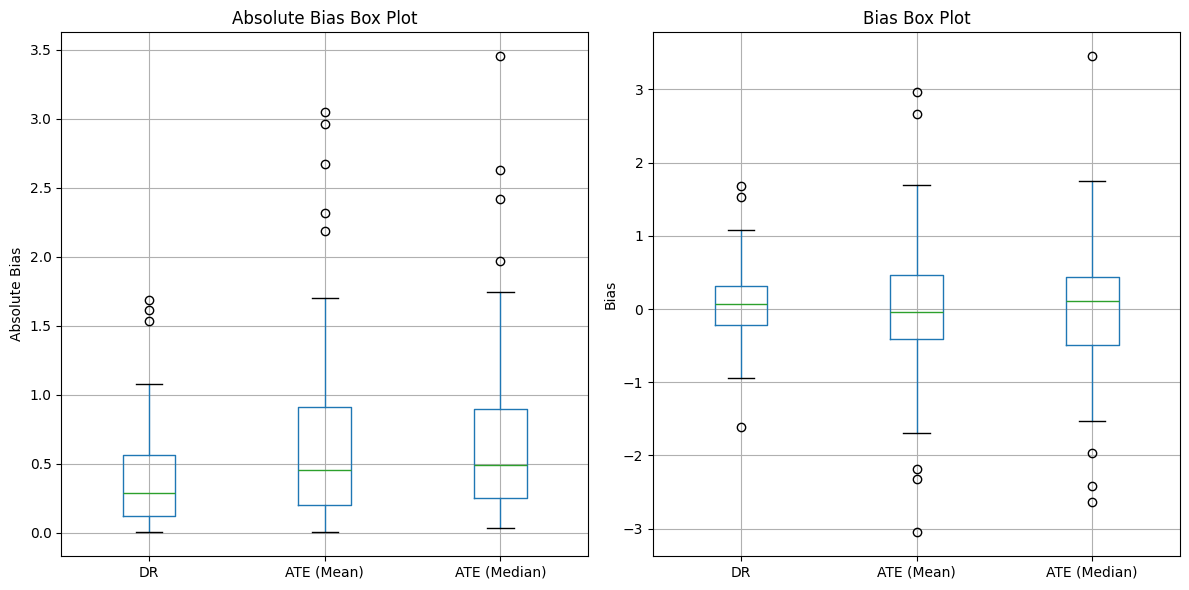

Mean Absolute Bias:
abs_bias_hat_dr          0.395615
abs_bias_ate_p_mean      0.642597
abs_bias_ate_p_median    0.635017
dtype: float64

Mean Bias:
bias_hat_dr          0.056288
bias_ate_p_mean     -0.006043
bias_ate_p_median    0.006868
dtype: float64
Mean Squared Error (MSE):
mse_hat_dr          0.280522
mse_ate_p_mean      0.806934
mse_ate_p_median    0.735379
dtype: float64


In [ ]:
# Convert tracker to DataFrame
tracker_df = pd.DataFrame(tracker)

# Compute biases for hat_dr, ate_p_mean, and ate_p_median versus the ground truth (4)
ground_truth = 4
tracker_df['bias_hat_dr'] = tracker_df['hat_dr'] - ground_truth
tracker_df['bias_ate_p_mean'] = tracker_df['ate_p_mean'] - ground_truth
tracker_df['bias_ate_p_median'] = tracker_df['ate_p_median'] - ground_truth

# Compute absolute biases
tracker_df['abs_bias_hat_dr'] = tracker_df['bias_hat_dr'].abs()
tracker_df['abs_bias_ate_p_mean'] = tracker_df['bias_ate_p_mean'].abs()
tracker_df['abs_bias_ate_p_median'] = tracker_df['bias_ate_p_median'].abs()
# Calculate Mean Squared Error (MSE) for each method
tracker_df['mse_hat_dr'] = (tracker_df['bias_hat_dr'] ** 2)
tracker_df['mse_ate_p_mean'] = (tracker_df['bias_ate_p_mean'] ** 2)
tracker_df['mse_ate_p_median'] = (tracker_df['bias_ate_p_median'] ** 2)

# Compute the mean MSE for all three methods
mean_mse = tracker_df[['mse_hat_dr', 'mse_ate_p_mean', 'mse_ate_p_median']].mean()

# Print the calculated MSE
print("Mean Squared Error (MSE):")
print(mean_mse)
# Box plots for absolute bias and bias
plt.figure(figsize=(12, 6))

# Absolute Bias Boxplot
plt.subplot(1, 2, 1)
tracker_df[['abs_bias_hat_dr', 'abs_bias_ate_p_mean', 'abs_bias_ate_p_median']].boxplot()
plt.title('Absolute Bias Box Plot')
plt.ylabel('Absolute Bias')
plt.xticks([1, 2, 3], ['DR', 'ATE (Mean)', 'ATE (Median)'])

# Bias Boxplot
plt.subplot(1, 2, 2)
tracker_df[['bias_hat_dr', 'bias_ate_p_mean', 'bias_ate_p_median']].boxplot()
plt.title('Bias Box Plot')
plt.ylabel('Bias')
plt.xticks([1, 2, 3], ['DR', 'ATE (Mean)', 'ATE (Median)'])

plt.tight_layout()
plt.show()

# Calculate the mean absolute bias
mean_abs_bias = tracker_df[['abs_bias_hat_dr', 'abs_bias_ate_p_mean', 'abs_bias_ate_p_median']].mean()

# Calculate the mean bias (without absolute value)
mean_bias = tracker_df[['bias_hat_dr', 'bias_ate_p_mean', 'bias_ate_p_median']].mean()

# Print the calculated mean absolute bias and mean bias
print("Mean Absolute Bias:")
print(mean_abs_bias)

print("\nMean Bias:")
print(mean_bias)

print("Mean Squared Error (MSE):")
print(mean_mse)

# # Plot Mean Absolute Bias, Bias, and MSE
# plt.figure(figsize=(15, 5))

# # Bar plot for Mean Absolute Bias
# plt.subplot(1, 3, 1)
# mean_abs_bias.plot(kind='bar', color=['blue', 'orange', 'green'])
# plt.title('Mean Absolute Bias')
# plt.ylabel('Absolute Bias')
# plt.xticks(ticks=[0, 1, 2], labels=['DR', 'ATE (Mean)', 'ATE (Median)'], rotation=0)

# # Bar plot for Mean Bias
# plt.subplot(1, 3, 2)
# mean_bias.plot(kind='bar', color=['blue', 'orange', 'green'])
# plt.title('Mean Bias')
# plt.ylabel('Bias')
# plt.xticks(ticks=[0, 1, 2], labels=['DR', 'ATE (Mean)', 'ATE (Median)'], rotation=0)

# # Bar plot for MSE
# plt.subplot(1, 3, 3)
# mean_mse.plot(kind='bar', color=['blue', 'orange', 'green'])
# plt.title('Mean Squared Error (MSE)')
# plt.ylabel('MSE')
# plt.xticks(ticks=[0, 1, 2], labels=['DR', 'ATE (Mean)', 'ATE (Median)'], rotation=0)

# plt.tight_layout()
# plt.show()



In [ ]:
import matplotlib.pyplot as plt
trials = range(100)
# Prepare data for histograms
ate_p_mean_hist = [np.mean(tracker[trial]["ate_p_mean"]) for trial in trials]
ate_p_median_hist = [np.mean(tracker[trial]["ate_p_median"]) for trial in trials]
mmd_joint_hist = [np.mean(tracker[trial]["mmd_joint"]) for trial in trials]

# Histogram for ATE Mean
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(ate_p_mean_hist, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of ATE Mean')
plt.xlabel('ATE Mean')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for ATE Median
plt.subplot(1, 3, 2)
plt.hist(ate_p_median_hist, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Histogram of ATE Median')
plt.xlabel('ATE Median')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for MMD Joint
plt.subplot(1, 3, 3)
plt.hist(mmd_joint_hist, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Histogram of MMD Joint')
plt.xlabel('MMD Joint')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


KeyError: 'mmd_joint'

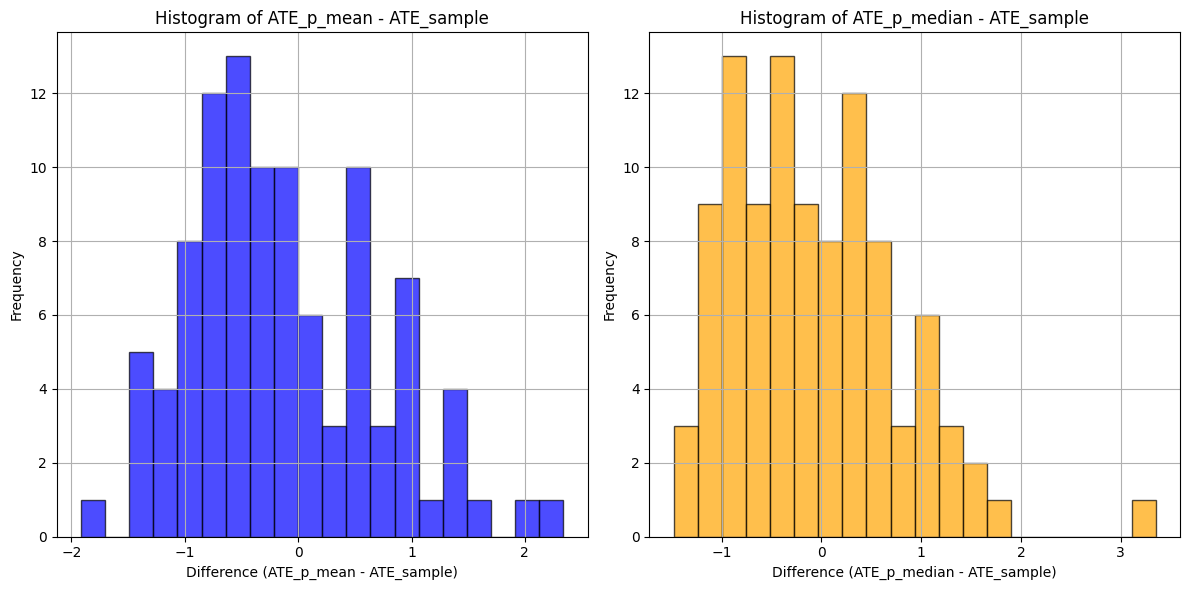

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for histograms
diff_ate_p_mean = [
    float(tracker[trial]["ate_p_mean"][0]) - float(tracker[trial]["ate_sample"][0])
    for trial in tracker.keys()
]
diff_ate_p_median = [
    float(tracker[trial]["ate_p_median"][0]) - float(tracker[trial]["ate_sample"][0])
    for trial in tracker.keys()
]

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for ATE Mean - ATE Sample
plt.subplot(1, 2, 1)
plt.hist(diff_ate_p_mean, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of ATE_p_mean - ATE_sample')
plt.xlabel('Difference (ATE_p_mean - ATE_sample)')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for ATE Median - ATE Sample
plt.subplot(1, 2, 2)
plt.hist(diff_ate_p_median, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Histogram of ATE_p_median - ATE_sample')
plt.xlabel('Difference (ATE_p_median - ATE_sample)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


# Continuous treatment

## Twins

In [ ]:
x,y,z=Semi_Twins_sampler(path = 'data_causl').load_all()

In [ ]:
params = {"dataset": "Semi_Twins",
"output_dir": './',
"v_dim": 50,
"z_dims": [1,1,1,7],
"x_min": 0,
"x_max": 3,
"lr": 0.0002,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 6.2385, loss1 6.5821, loss2 0.6872
Epoch 400: loss 4.6900, loss1 8.8674, loss2 8.3548
Epoch 800: loss 4.6730, loss1 8.9045, loss2 8.4630
Epoch 1200: loss 4.6633, loss1 8.9004, loss2 8.4743
Epoch 1600: loss 4.6606, loss1 8.9036, loss2 8.4861
Epoch 2000: loss 4.6667, loss1 8.9221, loss2 8.5106
Epoch 2400: loss 4.6578, loss1 8.9068, loss2 8.4979
Epoch 2800: loss 4.6617, loss1 8.9560, loss2 8.5885
Epoch 1: loss 1.0876,	loss_y 0.3174, 0.3319, 0.0290,	loss_eta 0.7702, 0.8044, 0.0685
Epoch 400: loss 0.8941,	loss_y 0.2371, 0.5075, 0.5408,	loss_eta 0.6570, 0.8915, 0.4690
Epoch 800: loss 0.9140,	loss_y 0.2265, 0.5047, 0.5565,	loss_eta 0.6875, 1.7375, 2.0999
Epoch 1200: loss 0.8430,	loss_y 0.2340, 0.6014, 0.7347,	loss_eta 0.6090, 1.6953, 2.1726
Epoch 1600: loss 0.8140,	loss_y 0.2169, 0.4766, 0.5195,	loss_eta 0.5971, 1.0809, 0.9676
Epoch 2000: loss 0.7816,	loss_y 0.2082, 0.4493, 0.4822,	loss_eta 0.5734, 1.1306, 1.1144
Epoch 2400: loss 0.7681,	loss_y 0.1825, 0.3868, 0.4086,	loss_eta 0

2024-12-07 21:53:22.787690: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 21:53:22.787952: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 6.2584, loss1 6.6035, loss2 0.6900
Epoch 400: loss 4.6946, loss1 8.8792, loss2 8.3692
Epoch 800: loss 4.6753, loss1 8.9221, loss2 8.4936
Epoch 1200: loss 4.6643, loss1 8.9116, loss2 8.4947
Epoch 1600: loss 4.6611, loss1 8.9108, loss2 8.4994
Epoch 2000: loss 4.6582, loss1 8.9304, loss2 8.5444
Epoch 2400: loss 4.6677, loss1 8.9421, loss2 8.5489
Epoch 2800: loss 4.6735, loss1 8.9675, loss2 8.5878
Epoch 1: loss 1.0567,	loss_y 0.3023, 0.3219, 0.0391,	loss_eta 0.7544, 0.7926, 0.0763
Epoch 400: loss 0.8699,	loss_y 0.2393, 0.5327, 0.5869,	loss_eta 0.6307, 0.9660, 0.6707
Epoch 800: loss 0.8294,	loss_y 0.2297, 0.5029, 0.5464,	loss_eta 0.5998, 1.4035, 1.6075
Epoch 1200: loss 0.9094,	loss_y 0.2289, 0.5021, 0.5464,	loss_eta 0.6805, 1.5725, 1.7840
Epoch 1600: loss 0.8743,	loss_y 0.2189, 0.4721, 0.5063,	loss_eta 0.6553, 1.1969, 1.0831
Epoch 2000: loss 0.8345,	loss_y 0.2059, 0.4402, 0.4686,	loss_eta 0.6286, 1.7852, 2.3132
Epoch 2400: loss 0.7721,	loss_y 0.1883, 0.3692, 0.3618,	loss_eta 0

2024-12-07 22:02:28.292582: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 22:02:28.292867: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 6.2367, loss1 6.5811, loss2 0.6888
Epoch 400: loss 4.6918, loss1 8.8736, loss2 8.3636
Epoch 800: loss 4.6908, loss1 8.9229, loss2 8.4642
Epoch 1200: loss 4.6632, loss1 8.9149, loss2 8.5035
Epoch 1600: loss 4.6535, loss1 8.9236, loss2 8.5402
Epoch 2000: loss 4.6556, loss1 8.9225, loss2 8.5338
Epoch 2400: loss 4.6620, loss1 8.9184, loss2 8.5129
Epoch 2800: loss 4.6570, loss1 8.9465, loss2 8.5790
Epoch 1: loss 1.0843,	loss_y 0.3181, 0.3396, 0.0429,	loss_eta 0.7662, 0.7996, 0.0669
Epoch 400: loss 0.8425,	loss_y 0.2484, 0.5900, 0.6831,	loss_eta 0.5940, 0.9963, 0.8045
Epoch 800: loss 0.9440,	loss_y 0.2823, 0.8059, 1.0471,	loss_eta 0.6616, 0.9157, 0.5082
Epoch 1200: loss 0.8297,	loss_y 0.2162, 0.3930, 0.3537,	loss_eta 0.6136, 1.1143, 1.0015
Epoch 1600: loss 0.7626,	loss_y 0.1786, 0.4086, 0.4600,	loss_eta 0.5840, 1.0015, 0.8350
Epoch 2000: loss 0.7842,	loss_y 0.1902, 0.3517, 0.3231,	loss_eta 0.5941, 1.3709, 1.5536
Epoch 2400: loss 0.7710,	loss_y 0.1866, 0.3359, 0.2985,	loss_eta 0

2024-12-07 22:11:40.725279: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 22:11:40.725603: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 6.3069, loss1 6.6488, loss2 0.6839
Epoch 400: loss 4.7015, loss1 8.8587, loss2 8.3144
Epoch 800: loss 4.6640, loss1 8.9112, loss2 8.4943
Epoch 1200: loss 4.6608, loss1 8.9183, loss2 8.5150
Epoch 1600: loss 4.6638, loss1 8.9077, loss2 8.4879
Epoch 2000: loss 4.6524, loss1 8.9050, loss2 8.5054
Epoch 2400: loss 4.6586, loss1 8.9294, loss2 8.5416
Epoch 2800: loss 4.6668, loss1 8.9386, loss2 8.5436
Epoch 1: loss 1.0607,	loss_y 0.3085, 0.3424, 0.0679,	loss_eta 0.7522, 0.8002, 0.0961
Epoch 400: loss 0.8567,	loss_y 0.2450, 0.4242, 0.3584,	loss_eta 0.6118, 1.1147, 1.0059
Epoch 800: loss 0.7986,	loss_y 0.2136, 0.4086, 0.3900,	loss_eta 0.5851, 1.0842, 0.9982
Epoch 1200: loss 0.8106,	loss_y 0.2180, 0.5856, 0.7353,	loss_eta 0.5926, 1.3593, 1.5335
Epoch 1600: loss 0.7728,	loss_y 0.1981, 0.3502, 0.3041,	loss_eta 0.5746, 1.3941, 1.6389
Epoch 2000: loss 0.7579,	loss_y 0.1701, 0.3926, 0.4450,	loss_eta 0.5878, 1.1758, 1.1758
Epoch 2400: loss 0.7259,	loss_y 0.1571, 0.3423, 0.3704,	loss_eta 0

2024-12-07 22:20:49.916504: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 22:20:49.916805: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 6.2304, loss1 6.5825, loss2 0.7042
Epoch 400: loss 4.6868, loss1 8.8743, loss2 8.3750
Epoch 800: loss 4.6706, loss1 8.8982, loss2 8.4553
Epoch 1200: loss 4.6593, loss1 8.9012, loss2 8.4839
Epoch 1600: loss 4.6672, loss1 8.9138, loss2 8.4932
Epoch 2000: loss 4.6751, loss1 8.9356, loss2 8.5210
Epoch 2400: loss 4.6574, loss1 8.9184, loss2 8.5222
Epoch 2800: loss 4.6601, loss1 8.9390, loss2 8.5579
Epoch 1: loss 1.0893,	loss_y 0.3228, 0.3334, 0.0212,	loss_eta 0.7665, 0.8029, 0.0729
Epoch 400: loss 0.9116,	loss_y 0.2302, 0.4405, 0.4205,	loss_eta 0.6813, 0.8838, 0.4049
Epoch 800: loss 0.8540,	loss_y 0.2293, 0.4197, 0.3807,	loss_eta 0.6246, 0.9494, 0.6496
Epoch 1200: loss 0.8393,	loss_y 0.2424, 0.3477, 0.2104,	loss_eta 0.5969, 1.3120, 1.4302
Epoch 1600: loss 0.7970,	loss_y 0.2107, 0.4911, 0.5608,	loss_eta 0.5863, 1.5216, 1.8705
Epoch 2000: loss 0.7790,	loss_y 0.2019, 0.4000, 0.3962,	loss_eta 0.5771, 1.1775, 1.2007
Epoch 2400: loss 0.7573,	loss_y 0.1685, 0.3233, 0.3095,	loss_eta 0

2024-12-07 22:29:58.928091: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 22:29:58.928394: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 6.2489, loss1 6.6010, loss2 0.7043
Epoch 400: loss 4.6992, loss1 8.8719, loss2 8.3454
Epoch 800: loss 4.6860, loss1 8.9243, loss2 8.4766
Epoch 1200: loss 4.6724, loss1 8.9059, loss2 8.4670
Epoch 1600: loss 4.6612, loss1 8.9227, loss2 8.5231
Epoch 2000: loss 4.6501, loss1 8.9214, loss2 8.5426
Epoch 2400: loss 4.6742, loss1 8.9332, loss2 8.5179
Epoch 2800: loss 4.6542, loss1 8.9368, loss2 8.5653
Epoch 1: loss 1.1188,	loss_y 0.3508, 0.3806, 0.0596,	loss_eta 0.7680, 0.8075, 0.0790
Epoch 400: loss 0.8557,	loss_y 0.2660, 0.6383, 0.7445,	loss_eta 0.5897, 0.9859, 0.7924
Epoch 800: loss 0.8533,	loss_y 0.2492, 0.3869, 0.2754,	loss_eta 0.6041, 1.6580, 2.1079
Epoch 1200: loss 0.8356,	loss_y 0.2511, 0.3998, 0.2974,	loss_eta 0.5845, 1.3666, 1.5642
Epoch 1600: loss 0.7931,	loss_y 0.2155, 0.4888, 0.5467,	loss_eta 0.5776, 1.4413, 1.7275
Epoch 2000: loss 0.7670,	loss_y 0.2024, 0.4151, 0.4254,	loss_eta 0.5645, 1.3168, 1.5046
Epoch 2400: loss 0.7714,	loss_y 0.1789, 0.3680, 0.3782,	loss_eta 0

2024-12-07 22:39:12.838966: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 22:39:12.839251: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 6.2480, loss1 6.5940, loss2 0.6921
Epoch 400: loss 4.7009, loss1 8.8702, loss2 8.3387
Epoch 800: loss 4.6812, loss1 8.9196, loss2 8.4766
Epoch 1200: loss 4.6521, loss1 8.9074, loss2 8.5105
Epoch 1600: loss 4.6580, loss1 8.9075, loss2 8.4989
Epoch 2000: loss 4.6454, loss1 8.9107, loss2 8.5307
Epoch 2400: loss 4.6638, loss1 8.9346, loss2 8.5415
Epoch 2800: loss 4.6611, loss1 8.9454, loss2 8.5685
Epoch 1: loss 1.0839,	loss_y 0.3173, 0.3445, 0.0543,	loss_eta 0.7666, 0.7995, 0.0657
Epoch 400: loss 0.9668,	loss_y 0.2188, 0.5066, 0.5757,	loss_eta 0.7480, 0.8122, 0.1283
Epoch 800: loss 0.8210,	loss_y 0.2128, 0.5072, 0.5887,	loss_eta 0.6081, 1.3097, 1.4031
Epoch 1200: loss 0.7820,	loss_y 0.1891, 0.3353, 0.2924,	loss_eta 0.5929, 1.6065, 2.0271
Epoch 1600: loss 0.7564,	loss_y 0.1813, 0.4309, 0.4991,	loss_eta 0.5750, 1.0689, 0.9878
Epoch 2000: loss 0.7604,	loss_y 0.1928, 0.3426, 0.2996,	loss_eta 0.5676, 1.2296, 1.3239
Epoch 2400: loss 0.7243,	loss_y 0.1681, 0.3028, 0.2695,	loss_eta 0

2024-12-07 22:48:23.832148: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 22:48:23.832454: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 6.2537, loss1 6.5834, loss2 0.6595
Epoch 400: loss 4.7119, loss1 8.8888, loss2 8.3537
Epoch 800: loss 4.6680, loss1 8.9089, loss2 8.4818
Epoch 1200: loss 4.6667, loss1 8.9219, loss2 8.5103
Epoch 1600: loss 4.6669, loss1 8.9223, loss2 8.5109
Epoch 2000: loss 4.6635, loss1 8.9283, loss2 8.5296
Epoch 2400: loss 4.6675, loss1 8.9361, loss2 8.5371
Epoch 2800: loss 4.6532, loss1 8.9307, loss2 8.5550
Epoch 1: loss 1.1316,	loss_y 0.3597, 0.3733, 0.0271,	loss_eta 0.7719, 0.8023, 0.0608
Epoch 400: loss 0.9545,	loss_y 0.2673, 0.6791, 0.8238,	loss_eta 0.6873, 0.8359, 0.2972
Epoch 800: loss 0.8646,	loss_y 0.2560, 0.7791, 1.0462,	loss_eta 0.6086, 0.9810, 0.7448
Epoch 1200: loss 0.7887,	loss_y 0.2076, 0.4974, 0.5796,	loss_eta 0.5811, 1.0619, 0.9617
Epoch 1600: loss 0.7830,	loss_y 0.1789, 0.3662, 0.3747,	loss_eta 0.6041, 1.4010, 1.5937
Epoch 2000: loss 0.7615,	loss_y 0.1744, 0.3971, 0.4454,	loss_eta 0.5872, 1.0201, 0.8659
Epoch 2400: loss 0.7706,	loss_y 0.1668, 0.2851, 0.2367,	loss_eta 0

2024-12-07 22:57:37.764693: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 22:57:37.765022: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 6.2536, loss1 6.5932, loss2 0.6792
Epoch 400: loss 4.7026, loss1 8.8726, loss2 8.3399
Epoch 800: loss 4.6738, loss1 8.9193, loss2 8.4910
Epoch 1200: loss 4.6758, loss1 8.9183, loss2 8.4850
Epoch 1600: loss 4.6756, loss1 8.9305, loss2 8.5098
Epoch 2000: loss 4.6584, loss1 8.9231, loss2 8.5293
Epoch 2400: loss 4.6602, loss1 8.9375, loss2 8.5545
Epoch 2800: loss 4.6684, loss1 8.9480, loss2 8.5592
Epoch 1: loss 1.0884,	loss_y 0.3251, 0.3373, 0.0244,	loss_eta 0.7633, 0.8054, 0.0842
Epoch 400: loss 0.9238,	loss_y 0.2736, 0.5378, 0.5283,	loss_eta 0.6502, 0.9353, 0.5701
Epoch 800: loss 0.8893,	loss_y 0.2326, 0.5104, 0.5556,	loss_eta 0.6567, 1.4039, 1.4944
Epoch 1200: loss 0.7927,	loss_y 0.2237, 0.4412, 0.4351,	loss_eta 0.5691, 1.2108, 1.2836
Epoch 1600: loss 0.7577,	loss_y 0.1749, 0.4338, 0.5179,	loss_eta 0.5828, 1.1572, 1.1488
Epoch 2000: loss 0.7413,	loss_y 0.1719, 0.3415, 0.3394,	loss_eta 0.5694, 1.1405, 1.1421
Epoch 2400: loss 0.7330,	loss_y 0.1597, 0.2810, 0.2426,	loss_eta 0

2024-12-07 23:06:45.831098: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 23:06:45.831399: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 6.2305, loss1 6.5833, loss2 0.7055
Epoch 400: loss 4.6721, loss1 8.8625, loss2 8.3809
Epoch 800: loss 4.6701, loss1 8.8921, loss2 8.4441
Epoch 1200: loss 4.6782, loss1 8.9170, loss2 8.4775
Epoch 1600: loss 4.6648, loss1 8.9253, loss2 8.5211
Epoch 2000: loss 4.6616, loss1 8.9231, loss2 8.5230
Epoch 2400: loss 4.6596, loss1 8.9370, loss2 8.5548
Epoch 2800: loss 4.6644, loss1 8.9587, loss2 8.5887
Epoch 1: loss 1.1102,	loss_y 0.3499, 0.3706, 0.0415,	loss_eta 0.7604, 0.8034, 0.0861
Epoch 400: loss 0.8673,	loss_y 0.2339, 0.5651, 0.6624,	loss_eta 0.6334, 0.9648, 0.6629
Epoch 800: loss 0.8294,	loss_y 0.2189, 0.4187, 0.3995,	loss_eta 0.6105, 1.0097, 0.7985
Epoch 1200: loss 0.8895,	loss_y 0.2481, 0.3904, 0.2845,	loss_eta 0.6414, 0.9467, 0.6106
Epoch 1600: loss 0.8199,	loss_y 0.2222, 0.3694, 0.2945,	loss_eta 0.5977, 1.2398, 1.2843
Epoch 2000: loss 0.7815,	loss_y 0.1836, 0.3968, 0.4263,	loss_eta 0.5978, 1.5047, 1.8138
Epoch 2400: loss 0.7544,	loss_y 0.1729, 0.3548, 0.3639,	loss_eta 0

2024-12-07 23:15:57.809076: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 23:15:57.809375: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

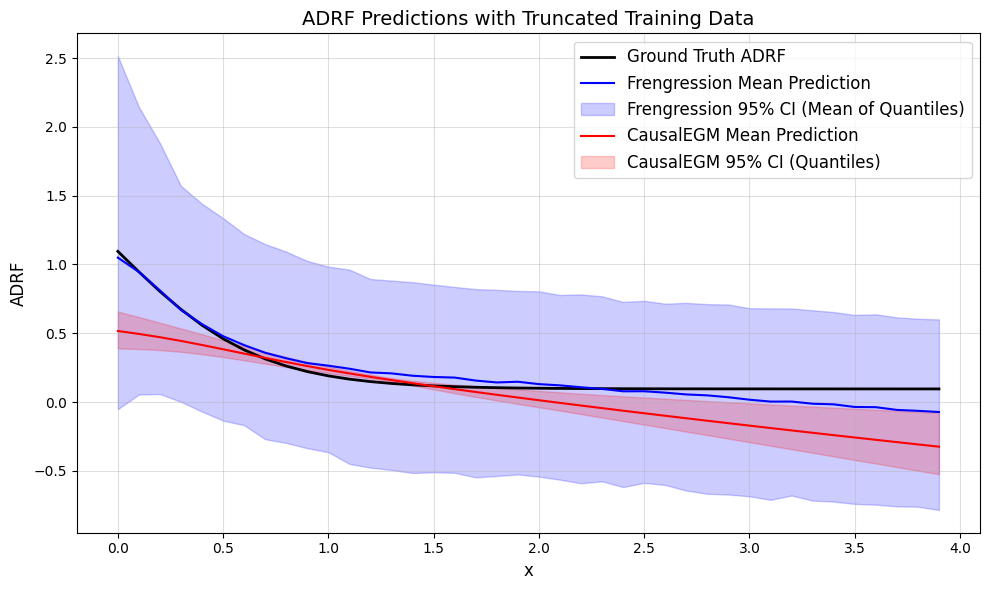

Frengression Average RMSE: 0.1036
CausalEGM Average RMSE: 0.2435


In [ ]:
# Set up the range of x values for predictions
x_vals = np.arange(0, 4, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

# Number of repetitions
nrep = 10
n_tr = 1000
num_iters = 3000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize storage for predictions
fr_preds = [[], [], []]  # 2.5%, mean, 97.5%
cegm_preds = []

# Ground truth ADRF values
ground_truth_adrf = Semi_Twins_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data
    x_train, y_train, z_train = Semi_Twins_sampler(path = 'data_causl'
    ).load_all()
    
    # Convert to tensors
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)
    
    # # Truncate the dataset to x in (0, 3)
    # mask = (x_train > 0) & (x_train < 3)  # `mask` has shape (1000,)
    # mask = mask.flatten()  # Flatten to 1D if necessary

    # x_tr = x_tr[mask]  # Apply mask to filter rows
    # y_tr = y_tr[mask]
    # z_tr = z_tr[mask]
    
    # --- Frengression Model ---
    # Initialize and train
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=400,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model (quantiles and mean)
    fr_pred = fr_model.predict_causal(
        x_tensor, target=[0.025, "mean", 0.975], sample_size=1000
    )  # Returns a list of 3 tensors, each (30, 1)
    
    # Append predictions to the respective lists
    for i, quantile_pred in enumerate(fr_pred):
        fr_preds[i].append(quantile_pred.numpy().flatten())  # Convert to NumPy array and flatten


    # --- CausalEGM Model ---
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train, y_train, z_train], n_iter=1000, verbose=False)

    # Predict using CausalEGM model
    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    cegm_preds.append(cegm_pred)

# Convert predictions to NumPy arrays
fr_preds = [np.array(pred_list).T for pred_list in fr_preds]  # Each becomes (30, nrep)
cegm_preds = np.array(cegm_preds).T  # Convert to (30, nrep)

# Compute mean predictions and CIs for Frengression
fr_ci_lower = fr_preds[0].mean(axis=1)  # Mean of 2.5% predictions
fr_mean_pred = fr_preds[1].mean(axis=1)  # Mean predictions
fr_ci_upper = fr_preds[2].mean(axis=1)  # Mean of 97.5% predictions

# Compute mean predictions and CIs for CausalEGM
cegm_mean_pred = cegm_preds.mean(axis=1)
cegm_ci_lower = np.quantile(cegm_preds, 0.025, axis=1)
cegm_ci_upper = np.quantile(cegm_preds, 0.975, axis=1)

# Plotting the results
plt.figure(figsize=(10, 6))

# Ground truth ADRF
plt.plot(x_vals, ground_truth_adrf, label='Ground Truth ADRF', color='black', linewidth=2)

# Frengression predictions
plt.plot(x_vals, fr_mean_pred, label='Frengression Mean Prediction', color='blue')
plt.fill_between(x_vals, fr_ci_lower, fr_ci_upper, color='blue', alpha=0.2, label='Frengression 95% CI (Mean of Quantiles)')

# CausalEGM predictions
plt.plot(x_vals, cegm_mean_pred, label='CausalEGM Mean Prediction', color='red')
plt.fill_between(x_vals, cegm_ci_lower, cegm_ci_upper, color='red', alpha=0.2, label='CausalEGM 95% CI (Quantiles)')

# Add title, labels, and legend
plt.title('ADRF Predictions with Truncated Training Data', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('ADRF', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)

# Show the plot
plt.tight_layout()
plt.show()

# Compute and print average RMSEs
fr_rmses = [rmse(fr_preds[1][:, rep], ground_truth_adrf) for rep in range(nrep)]
cegm_rmses = [rmse(cegm_preds[:, rep], ground_truth_adrf) for rep in range(nrep)]

print(f"Frengression Average RMSE: {np.mean(fr_rmses):.4f}")
print(f"CausalEGM Average RMSE: {np.mean(cegm_rmses):.4f}")

## Hirano Imbens et al

### With best params for cegm

In [ ]:

params = {"dataset": "Sim_Hirano_Imbens",
"output_dir": './',
'v_dim': 200,
"z_dims": [1,1,1,7],
"x_min": 0,
"x_max": 6,
"lr": 0.0002,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 13.4884, loss1 14.1906, loss2 1.4045
Epoch 400: loss 10.1290, loss1 19.7000, loss2 19.1420
Epoch 800: loss 10.1040, loss1 19.7715, loss2 19.3349
Epoch 1200: loss 10.1204, loss1 19.8431, loss2 19.4454
Epoch 1600: loss 9.9726, loss1 19.8396, loss2 19.7341
Epoch 2000: loss 10.0197, loss1 19.8483, loss2 19.6573
Epoch 2400: loss 10.0380, loss1 19.8895, loss2 19.7031
Epoch 2800: loss 10.0787, loss1 19.8423, loss2 19.5271
Epoch 3200: loss 10.0520, loss1 19.8656, loss2 19.6273
Epoch 3600: loss 9.9752, loss1 19.8926, loss2 19.8348
Epoch 4000: loss 9.9959, loss1 19.8460, loss2 19.7003
Epoch 1: loss 2.4697,	loss_y 1.6902, 1.6984, 0.0165,	loss_eta 0.7795, 0.8182, 0.0773
Epoch 400: loss 1.4560,	loss_y 0.8104, 1.2404, 0.8599,	loss_eta 0.6456, 1.1862, 1.0813
Epoch 800: loss 1.4178,	loss_y 0.7860, 1.1923, 0.8127,	loss_eta 0.6318, 1.0423, 0.8210
Epoch 1200: loss 1.3255,	loss_y 0.6937, 1.3277, 1.2679,	loss_eta 0.6317, 0.8817, 0.4998
Epoch 1600: loss 1.0976,	loss_y 0.5046, 0.9036, 0.7980,	l

2024-12-07 18:39:38.892203: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 18:39:38.892509: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4884, loss1 14.1713, loss2 1.3658
Epoch 400: loss 10.0899, loss1 19.6146, loss2 19.0494
Epoch 800: loss 10.1314, loss1 19.8227, loss2 19.3826
Epoch 1200: loss 10.1028, loss1 19.8545, loss2 19.5033
Epoch 1600: loss 10.0733, loss1 19.7828, loss2 19.4192
Epoch 2000: loss 9.9383, loss1 19.8793, loss2 19.8820
Epoch 2400: loss 10.0492, loss1 19.8144, loss2 19.5304
Epoch 2800: loss 10.0466, loss1 19.9047, loss2 19.7161
Epoch 3200: loss 10.0158, loss1 19.7875, loss2 19.5435
Epoch 3600: loss 9.9850, loss1 19.8070, loss2 19.6441
Epoch 4000: loss 10.0377, loss1 19.8178, loss2 19.5601
Epoch 1: loss 2.3944,	loss_y 1.6681, 1.6951, 0.0539,	loss_eta 0.7262, 0.7622, 0.0719
Epoch 400: loss 1.4733,	loss_y 0.7738, 1.4814, 1.4151,	loss_eta 0.6994, 1.0138, 0.6288
Epoch 800: loss 1.3828,	loss_y 0.8200, 1.6107, 1.5815,	loss_eta 0.5628, 1.1282, 1.1309
Epoch 1200: loss 1.3295,	loss_y 0.6990, 1.5302, 1.6624,	loss_eta 0.6306, 0.9634, 0.6658
Epoch 1600: loss 1.3181,	loss_y 0.7263, 1.2401, 1.0275,	

2024-12-07 18:41:39.630272: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 18:41:39.630573: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4992, loss1 14.1780, loss2 1.3577
Epoch 400: loss 10.1259, loss1 19.5955, loss2 18.9391
Epoch 800: loss 10.1360, loss1 19.8370, loss2 19.4020
Epoch 1200: loss 10.0606, loss1 19.7480, loss2 19.3749
Epoch 1600: loss 10.0708, loss1 19.8430, loss2 19.5445
Epoch 2000: loss 10.0641, loss1 19.8827, loss2 19.6372
Epoch 2400: loss 10.0728, loss1 19.8874, loss2 19.6292
Epoch 2800: loss 10.0647, loss1 19.9185, loss2 19.7075
Epoch 3200: loss 10.0467, loss1 19.9215, loss2 19.7497
Epoch 3600: loss 10.0555, loss1 19.9371, loss2 19.7631
Epoch 4000: loss 10.1008, loss1 19.9018, loss2 19.6021
Epoch 1: loss 2.4352,	loss_y 1.6506, 1.6882, 0.0752,	loss_eta 0.7845, 0.8262, 0.0832
Epoch 400: loss 1.4332,	loss_y 0.7116, 1.2999, 1.1765,	loss_eta 0.7216, 1.0108, 0.5784
Epoch 800: loss 1.4837,	loss_y 0.7331, 2.0107, 2.5551,	loss_eta 0.7505, 1.4747, 1.4483
Epoch 1200: loss 1.1925,	loss_y 0.5939, 0.9996, 0.8113,	loss_eta 0.5986, 1.0955, 0.9937
Epoch 1600: loss 1.2817,	loss_y 0.6905, 1.7474, 2.1138

2024-12-07 18:43:37.388514: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 18:43:37.388790: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.5101, loss1 14.1826, loss2 1.3450
Epoch 400: loss 10.1917, loss1 19.5795, loss2 18.7757
Epoch 800: loss 10.0715, loss1 19.8208, loss2 19.4986
Epoch 1200: loss 10.0806, loss1 19.7819, loss2 19.4027
Epoch 1600: loss 10.0466, loss1 19.8597, loss2 19.6262
Epoch 2000: loss 9.9976, loss1 19.9404, loss2 19.8857
Epoch 2400: loss 10.0159, loss1 19.8267, loss2 19.6217
Epoch 2800: loss 10.0488, loss1 19.8813, loss2 19.6649
Epoch 3200: loss 9.9846, loss1 19.9409, loss2 19.9126
Epoch 3600: loss 10.0110, loss1 19.8993, loss2 19.7765
Epoch 4000: loss 10.0369, loss1 19.8654, loss2 19.6571
Epoch 1: loss 2.4693,	loss_y 1.7113, 1.7200, 0.0173,	loss_eta 0.7580, 0.7999, 0.0840
Epoch 400: loss 1.3371,	loss_y 0.7288, 1.3227, 1.1878,	loss_eta 0.6083, 1.0120, 0.8075
Epoch 800: loss 1.3427,	loss_y 0.7835, 1.2944, 1.0218,	loss_eta 0.5592, 1.0436, 0.9688
Epoch 1200: loss 1.3308,	loss_y 0.6481, 1.7160, 2.1357,	loss_eta 0.6827, 1.3032, 1.2411
Epoch 1600: loss 1.3078,	loss_y 0.6828, 1.2584, 1.1511,	

2024-12-07 18:45:38.996868: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 18:45:38.997150: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4863, loss1 14.1554, loss2 1.3383
Epoch 400: loss 10.1060, loss1 19.6630, loss2 19.1139
Epoch 800: loss 10.0029, loss1 19.7483, loss2 19.4907
Epoch 1200: loss 10.0645, loss1 19.8076, loss2 19.4860
Epoch 1600: loss 10.0873, loss1 19.8958, loss2 19.6170
Epoch 2000: loss 10.0233, loss1 19.8322, loss2 19.6179
Epoch 2400: loss 9.9963, loss1 19.7809, loss2 19.5693
Epoch 2800: loss 10.0339, loss1 19.8636, loss2 19.6594
Epoch 3200: loss 10.0162, loss1 19.9062, loss2 19.7800
Epoch 3600: loss 10.0282, loss1 19.8588, loss2 19.6611
Epoch 4000: loss 10.0475, loss1 19.9372, loss2 19.7795
Epoch 1: loss 2.2997,	loss_y 1.5453, 1.5533, 0.0160,	loss_eta 0.7544, 0.7918, 0.0748
Epoch 400: loss 1.3016,	loss_y 0.7146, 1.2482, 1.0673,	loss_eta 0.5871, 1.1006, 1.0270
Epoch 800: loss 1.4632,	loss_y 0.8882, 1.2709, 0.7655,	loss_eta 0.5751, 1.0347, 0.9192
Epoch 1200: loss 1.2664,	loss_y 0.6729, 1.6421, 1.9385,	loss_eta 0.5935, 0.9066, 0.6262
Epoch 1600: loss 1.3820,	loss_y 0.7295, 1.2136, 0.9683,

2024-12-07 18:47:42.302503: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 18:47:42.302783: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4609, loss1 14.1438, loss2 1.3658
Epoch 400: loss 10.0870, loss1 19.4742, loss2 18.7744
Epoch 800: loss 10.0824, loss1 19.7537, loss2 19.3426
Epoch 1200: loss 10.1016, loss1 19.7486, loss2 19.2941
Epoch 1600: loss 10.0855, loss1 19.8607, loss2 19.5504
Epoch 2000: loss 10.1253, loss1 19.8151, loss2 19.3795
Epoch 2400: loss 9.9912, loss1 19.8357, loss2 19.6888
Epoch 2800: loss 10.0205, loss1 19.8116, loss2 19.5821
Epoch 3200: loss 9.9919, loss1 19.9027, loss2 19.8216
Epoch 3600: loss 10.0688, loss1 19.8089, loss2 19.4802
Epoch 4000: loss 9.9796, loss1 19.7707, loss2 19.5822
Epoch 1: loss 2.4156,	loss_y 1.6775, 1.6862, 0.0173,	loss_eta 0.7381, 0.7777, 0.0791
Epoch 400: loss 1.5034,	loss_y 0.7978, 1.1817, 0.7678,	loss_eta 0.7056, 1.2123, 1.0133
Epoch 800: loss 1.3431,	loss_y 0.7431, 1.4418, 1.3974,	loss_eta 0.6000, 1.4171, 1.6343
Epoch 1200: loss 1.4108,	loss_y 0.7542, 1.0631, 0.6178,	loss_eta 0.6566, 2.1759, 3.0385
Epoch 1600: loss 1.1149,	loss_y 0.5670, 1.1087, 1.0834,	l

2024-12-07 18:49:39.192050: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 18:49:39.192359: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4862, loss1 14.1862, loss2 1.4001
Epoch 400: loss 10.1601, loss1 19.6043, loss2 18.8885
Epoch 800: loss 10.0385, loss1 19.7654, loss2 19.4539
Epoch 1200: loss 10.0308, loss1 19.7826, loss2 19.5035
Epoch 1600: loss 10.0804, loss1 19.7852, loss2 19.4096
Epoch 2000: loss 10.0312, loss1 19.8136, loss2 19.5648
Epoch 2400: loss 10.0354, loss1 19.8590, loss2 19.6473
Epoch 2800: loss 10.0610, loss1 19.8630, loss2 19.6039
Epoch 3200: loss 10.0607, loss1 19.8331, loss2 19.5447
Epoch 3600: loss 9.9822, loss1 19.8511, loss2 19.7378
Epoch 4000: loss 9.9618, loss1 19.7900, loss2 19.6562
Epoch 1: loss 2.3727,	loss_y 1.5917, 1.6028, 0.0222,	loss_eta 0.7810, 0.8217, 0.0813
Epoch 400: loss 1.4577,	loss_y 0.7596, 1.3283, 1.1375,	loss_eta 0.6981, 1.0166, 0.6371
Epoch 800: loss 1.4691,	loss_y 0.7587, 1.7873, 2.0571,	loss_eta 0.7104, 1.1430, 0.8650
Epoch 1200: loss 1.4665,	loss_y 0.7830, 1.9406, 2.3153,	loss_eta 0.6835, 1.2312, 1.0954
Epoch 1600: loss 1.2204,	loss_y 0.5970, 1.2527, 1.3115,	

2024-12-07 18:51:34.720439: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 18:51:34.720716: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.5061, loss1 14.1934, loss2 1.3747
Epoch 400: loss 10.1439, loss1 19.7537, loss2 19.2195
Epoch 800: loss 10.0713, loss1 19.7077, loss2 19.2727
Epoch 1200: loss 10.0876, loss1 19.9291, loss2 19.6831
Epoch 1600: loss 10.0716, loss1 19.8922, loss2 19.6410
Epoch 2000: loss 10.1156, loss1 19.8623, loss2 19.4934
Epoch 2400: loss 10.0003, loss1 19.8677, loss2 19.7347
Epoch 2800: loss 10.1144, loss1 19.9065, loss2 19.5842
Epoch 3200: loss 10.0543, loss1 19.8890, loss2 19.6695
Epoch 3600: loss 9.9310, loss1 19.8683, loss2 19.8747
Epoch 4000: loss 10.0789, loss1 19.9168, loss2 19.6759
Epoch 1: loss 2.4341,	loss_y 1.6654, 1.6765, 0.0221,	loss_eta 0.7686, 0.8047, 0.0721
Epoch 400: loss 1.4224,	loss_y 0.7943, 1.2124, 0.8362,	loss_eta 0.6280, 1.5360, 1.8159
Epoch 800: loss 1.5503,	loss_y 0.9424, 1.3677, 0.8506,	loss_eta 0.6079, 1.5302, 1.8446
Epoch 1200: loss 1.4711,	loss_y 0.8785, 2.0810, 2.4049,	loss_eta 0.5925, 1.2113, 1.2375
Epoch 1600: loss 1.2283,	loss_y 0.6012, 1.3373, 1.4723,

2024-12-07 18:53:29.732941: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 18:53:29.733248: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4799, loss1 14.1722, loss2 1.3845
Epoch 400: loss 10.1120, loss1 19.6491, loss2 19.0742
Epoch 800: loss 10.0332, loss1 19.8010, loss2 19.5357
Epoch 1200: loss 10.0347, loss1 19.7944, loss2 19.5193
Epoch 1600: loss 10.2000, loss1 19.8367, loss2 19.2734
Epoch 2000: loss 10.0303, loss1 19.8639, loss2 19.6673
Epoch 2400: loss 10.0767, loss1 19.9250, loss2 19.6966
Epoch 2800: loss 10.0478, loss1 19.9209, loss2 19.7462
Epoch 3200: loss 9.9778, loss1 19.8800, loss2 19.8043
Epoch 3600: loss 10.0161, loss1 19.8752, loss2 19.7182
Epoch 4000: loss 10.0024, loss1 19.8136, loss2 19.6225
Epoch 1: loss 2.3998,	loss_y 1.6359, 1.6524, 0.0331,	loss_eta 0.7639, 0.8037, 0.0797
Epoch 400: loss 1.5573,	loss_y 0.9337, 1.1107, 0.3540,	loss_eta 0.6236, 1.5970, 1.9468
Epoch 800: loss 1.4396,	loss_y 0.8056, 1.4049, 1.1987,	loss_eta 0.6341, 1.0160, 0.7638
Epoch 1200: loss 1.3069,	loss_y 0.7006, 1.4006, 1.3999,	loss_eta 0.6063, 1.0147, 0.8170
Epoch 1600: loss 1.2144,	loss_y 0.6277, 1.0545, 0.8536,

 30%|███       | 9/30 [17:51<40:16, 115.08s/it]

Epoch 1: loss 13.5149, loss1 14.1840, loss2 1.3381
Epoch 400: loss 10.0946, loss1 19.6014, loss2 19.0136
Epoch 800: loss 10.0998, loss1 19.8971, loss2 19.5948
Epoch 1200: loss 10.0768, loss1 19.7704, loss2 19.3873
Epoch 1600: loss 10.0932, loss1 19.8467, loss2 19.5069
Epoch 2000: loss 9.9853, loss1 19.8602, loss2 19.7499
Epoch 2400: loss 10.0026, loss1 19.8867, loss2 19.7683
Epoch 2800: loss 10.0257, loss1 19.8985, loss2 19.7457
Epoch 3200: loss 10.0860, loss1 19.8861, loss2 19.6002
Epoch 3600: loss 10.0361, loss1 19.8200, loss2 19.5678
Epoch 4000: loss 10.0729, loss1 19.8679, loss2 19.5899
Epoch 1: loss 2.2401,	loss_y 1.4888, 1.5277, 0.0778,	loss_eta 0.7513, 0.7911, 0.0797
Epoch 400: loss 1.4065,	loss_y 0.8423, 1.0925, 0.5004,	loss_eta 0.5643, 1.1760, 1.2235
Epoch 800: loss 1.3660,	loss_y 0.7493, 1.7259, 1.9532,	loss_eta 0.6167, 1.1897, 1.1459
Epoch 1200: loss 1.3031,	loss_y 0.6977, 1.4213, 1.4472,	loss_eta 0.6054, 1.6130, 2.0153
Epoch 1600: loss 1.3804,	loss_y 0.8281, 2.2761, 2.8961,

2024-12-07 18:57:13.996579: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 18:57:13.996856: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4711, loss1 14.1719, loss2 1.4016
Epoch 400: loss 10.0846, loss1 19.6500, loss2 19.1307
Epoch 800: loss 10.0114, loss1 19.8087, loss2 19.5946
Epoch 1200: loss 10.0260, loss1 19.7206, loss2 19.3892
Epoch 1600: loss 10.0026, loss1 19.7707, loss2 19.5362
Epoch 2000: loss 10.0824, loss1 19.8397, loss2 19.5147
Epoch 2400: loss 10.0695, loss1 19.8011, loss2 19.4633
Epoch 2800: loss 10.0387, loss1 19.8812, loss2 19.6849
Epoch 3200: loss 10.0540, loss1 19.8689, loss2 19.6298
Epoch 3600: loss 9.9628, loss1 19.9397, loss2 19.9537
Epoch 4000: loss 9.9976, loss1 19.8413, loss2 19.6873
Epoch 1: loss 2.3060,	loss_y 1.5510, 1.5866, 0.0713,	loss_eta 0.7550, 0.7919, 0.0737
Epoch 400: loss 1.5488,	loss_y 0.9368, 1.1760, 0.4784,	loss_eta 0.6120, 1.2975, 1.3710
Epoch 800: loss 1.4245,	loss_y 0.7277, 1.8451, 2.2348,	loss_eta 0.6968, 1.4998, 1.6059
Epoch 1200: loss 1.3200,	loss_y 0.7617, 1.5563, 1.5891,	loss_eta 0.5583, 1.2685, 1.4204
Epoch 1600: loss 1.2526,	loss_y 0.6591, 1.0535, 0.7888,	

2024-12-07 18:59:08.905224: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 18:59:08.905507: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.5149, loss1 14.2040, loss2 1.3783
Epoch 400: loss 10.0273, loss1 19.7412, loss2 19.4277
Epoch 800: loss 10.0367, loss1 19.8005, loss2 19.5277
Epoch 1200: loss 10.0752, loss1 19.8175, loss2 19.4845
Epoch 1600: loss 10.0595, loss1 19.8370, loss2 19.5549
Epoch 2000: loss 10.0662, loss1 19.9260, loss2 19.7196
Epoch 2400: loss 10.0721, loss1 19.8925, loss2 19.6407
Epoch 2800: loss 10.0139, loss1 19.8908, loss2 19.7538
Epoch 3200: loss 10.1250, loss1 19.9001, loss2 19.5502
Epoch 3600: loss 9.9872, loss1 19.8968, loss2 19.8192
Epoch 4000: loss 10.0335, loss1 19.9079, loss2 19.7489
Epoch 1: loss 2.4246,	loss_y 1.6310, 1.6508, 0.0395,	loss_eta 0.7936, 0.8335, 0.0797
Epoch 400: loss 1.4760,	loss_y 0.8263, 1.1433, 0.6339,	loss_eta 0.6496, 0.9958, 0.6923
Epoch 800: loss 1.4775,	loss_y 0.8337, 2.2857, 2.9041,	loss_eta 0.6438, 0.9150, 0.5425
Epoch 1200: loss 1.2531,	loss_y 0.6798, 1.4192, 1.4786,	loss_eta 0.5732, 1.2982, 1.4500
Epoch 1600: loss 1.3263,	loss_y 0.7094, 1.1195, 0.8202,

2024-12-07 19:01:05.131674: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:01:05.131956: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.5095, loss1 14.1766, loss2 1.3342
Epoch 400: loss 10.1707, loss1 19.6770, loss2 19.0125
Epoch 800: loss 10.1275, loss1 19.8083, loss2 19.3615
Epoch 1200: loss 10.0684, loss1 19.8810, loss2 19.6252
Epoch 1600: loss 10.0590, loss1 19.8482, loss2 19.5783
Epoch 2000: loss 10.0755, loss1 19.8660, loss2 19.5810
Epoch 2400: loss 10.0614, loss1 19.8740, loss2 19.6253
Epoch 2800: loss 10.0935, loss1 19.8729, loss2 19.5588
Epoch 3200: loss 10.0237, loss1 19.9209, loss2 19.7944
Epoch 3600: loss 10.0342, loss1 19.9825, loss2 19.8967
Epoch 4000: loss 10.0818, loss1 19.8719, loss2 19.5802
Epoch 1: loss 2.4316,	loss_y 1.6552, 1.6773, 0.0441,	loss_eta 0.7764, 0.8119, 0.0709
Epoch 400: loss 1.4979,	loss_y 0.7775, 1.1430, 0.7310,	loss_eta 0.7204, 1.2943, 1.1478
Epoch 800: loss 1.2838,	loss_y 0.6938, 1.6184, 1.8491,	loss_eta 0.5900, 1.0308, 0.8817
Epoch 1200: loss 1.3138,	loss_y 0.6540, 1.4882, 1.6683,	loss_eta 0.6598, 1.3383, 1.3570
Epoch 1600: loss 1.1381,	loss_y 0.5465, 0.8671, 0.6412

 43%|████▎     | 13/30 [25:27<32:17, 113.99s/it]

Epoch 1: loss 13.4975, loss1 14.1758, loss2 1.3565
Epoch 400: loss 10.0570, loss1 19.6798, loss2 19.2456
Epoch 800: loss 10.0741, loss1 19.8001, loss2 19.4521
Epoch 1200: loss 10.0192, loss1 19.8672, loss2 19.6959
Epoch 1600: loss 10.1543, loss1 19.8640, loss2 19.4194
Epoch 2000: loss 10.0559, loss1 19.8714, loss2 19.6311
Epoch 2400: loss 10.0713, loss1 19.8388, loss2 19.5348
Epoch 2800: loss 10.0468, loss1 19.8951, loss2 19.6966
Epoch 3200: loss 10.0189, loss1 19.8819, loss2 19.7260
Epoch 3600: loss 10.0284, loss1 19.8596, loss2 19.6624
Epoch 4000: loss 10.0366, loss1 19.9115, loss2 19.7498
Epoch 1: loss 2.2980,	loss_y 1.5109, 1.5748, 0.1278,	loss_eta 0.7872, 0.8239, 0.0736
Epoch 400: loss 1.5745,	loss_y 0.9024, 1.0925, 0.3801,	loss_eta 0.6720, 0.9670, 0.5900
Epoch 800: loss 1.5546,	loss_y 0.8301, 2.2433, 2.8264,	loss_eta 0.7245, 1.5518, 1.6546
Epoch 1200: loss 1.2319,	loss_y 0.5721, 1.2075, 1.2709,	loss_eta 0.6598, 1.1726, 1.0256
Epoch 1600: loss 1.2700,	loss_y 0.6452, 0.8961, 0.5017

2024-12-07 19:04:53.152454: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:04:53.152738: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4720, loss1 14.1678, loss2 1.3917
Epoch 400: loss 10.0872, loss1 19.6132, loss2 19.0520
Epoch 800: loss 10.0766, loss1 19.6996, loss2 19.2459
Epoch 1200: loss 10.0867, loss1 19.8090, loss2 19.4446
Epoch 1600: loss 10.0401, loss1 19.7619, loss2 19.4435
Epoch 2000: loss 9.9986, loss1 19.8049, loss2 19.6125
Epoch 2400: loss 10.0478, loss1 19.8242, loss2 19.5529
Epoch 2800: loss 9.9484, loss1 19.7967, loss2 19.6966
Epoch 3200: loss 10.0183, loss1 19.8365, loss2 19.6364
Epoch 3600: loss 10.0685, loss1 19.8545, loss2 19.5721
Epoch 4000: loss 9.9654, loss1 19.8468, loss2 19.7627
Epoch 1: loss 2.4110,	loss_y 1.6377, 1.6511, 0.0268,	loss_eta 0.7733, 0.8139, 0.0813
Epoch 400: loss 1.4646,	loss_y 0.8688, 1.3667, 0.9959,	loss_eta 0.5958, 0.9217, 0.6517
Epoch 800: loss 1.4870,	loss_y 0.9139, 1.2172, 0.6066,	loss_eta 0.5732, 0.9609, 0.7756
Epoch 1200: loss 1.3533,	loss_y 0.7408, 1.0820, 0.6823,	loss_eta 0.6125, 1.1078, 0.9906
Epoch 1600: loss 1.2246,	loss_y 0.6040, 1.0416, 0.8751,	l

2024-12-07 19:06:48.743979: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:06:48.744288: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4710, loss1 14.1483, loss2 1.3546
Epoch 400: loss 10.1084, loss1 19.7093, loss2 19.2018
Epoch 800: loss 10.0483, loss1 19.7933, loss2 19.4900
Epoch 1200: loss 9.9887, loss1 19.7499, loss2 19.5224
Epoch 1600: loss 10.1367, loss1 19.8413, loss2 19.4092
Epoch 2000: loss 10.0417, loss1 19.7879, loss2 19.4925
Epoch 2400: loss 10.0115, loss1 19.7686, loss2 19.5143
Epoch 2800: loss 9.9611, loss1 19.8421, loss2 19.7621
Epoch 3200: loss 10.0096, loss1 19.8986, loss2 19.7781
Epoch 3600: loss 10.0232, loss1 19.9138, loss2 19.7812
Epoch 4000: loss 10.0168, loss1 19.8504, loss2 19.6671
Epoch 1: loss 2.5401,	loss_y 1.7805, 1.7860, 0.0110,	loss_eta 0.7596, 0.8001, 0.0810
Epoch 400: loss 1.2647,	loss_y 0.6937, 1.1491, 0.9108,	loss_eta 0.5710, 1.1038, 1.0656
Epoch 800: loss 1.3790,	loss_y 0.7661, 1.9286, 2.3250,	loss_eta 0.6129, 0.9732, 0.7206
Epoch 1200: loss 1.2251,	loss_y 0.6735, 1.3367, 1.3263,	loss_eta 0.5516, 1.2224, 1.3417
Epoch 1600: loss 1.0987,	loss_y 0.5058, 0.9730, 0.9344,	

2024-12-07 19:08:44.851001: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:08:44.851284: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4829, loss1 14.1657, loss2 1.3656
Epoch 400: loss 10.1913, loss1 19.6098, loss2 18.8370
Epoch 800: loss 10.0651, loss1 19.8082, loss2 19.4862
Epoch 1200: loss 10.0904, loss1 19.7512, loss2 19.3217
Epoch 1600: loss 10.0527, loss1 19.8560, loss2 19.6065
Epoch 2000: loss 9.9920, loss1 19.8261, loss2 19.6680
Epoch 2400: loss 10.0404, loss1 19.8469, loss2 19.6130
Epoch 2800: loss 9.9728, loss1 19.8542, loss2 19.7628
Epoch 3200: loss 10.0926, loss1 19.9144, loss2 19.6436
Epoch 3600: loss 10.0095, loss1 19.9010, loss2 19.7831
Epoch 4000: loss 9.9791, loss1 19.8932, loss2 19.8281
Epoch 1: loss 2.4043,	loss_y 1.6481, 1.6628, 0.0295,	loss_eta 0.7562, 0.7994, 0.0864
Epoch 400: loss 1.4470,	loss_y 0.8307, 1.1744, 0.6874,	loss_eta 0.6163, 1.1359, 1.0393
Epoch 800: loss 1.4974,	loss_y 0.7760, 1.4639, 1.3757,	loss_eta 0.7214, 1.2362, 1.0297
Epoch 1200: loss 1.4478,	loss_y 0.8584, 1.6620, 1.6072,	loss_eta 0.5893, 1.2684, 1.3581
Epoch 1600: loss 1.3880,	loss_y 0.6836, 1.3079, 1.2485,	l

2024-12-07 19:10:40.278863: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:10:40.279198: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4848, loss1 14.1886, loss2 1.4077
Epoch 400: loss 10.1018, loss1 19.5513, loss2 18.8989
Epoch 800: loss 10.0905, loss1 19.7831, loss2 19.3851
Epoch 1200: loss 10.0556, loss1 19.9532, loss2 19.7951
Epoch 1600: loss 10.0819, loss1 19.8046, loss2 19.4455
Epoch 2000: loss 10.1192, loss1 19.8700, loss2 19.5015
Epoch 2400: loss 10.0395, loss1 19.7961, loss2 19.5132
Epoch 2800: loss 9.9523, loss1 19.8590, loss2 19.8133
Epoch 3200: loss 10.1008, loss1 19.8493, loss2 19.4969
Epoch 3600: loss 10.1276, loss1 19.9206, loss2 19.5860
Epoch 4000: loss 10.0580, loss1 19.9194, loss2 19.7228
Epoch 1: loss 2.3792,	loss_y 1.6227, 1.6340, 0.0226,	loss_eta 0.7565, 0.7960, 0.0791
Epoch 400: loss 1.4282,	loss_y 0.8538, 1.1011, 0.4945,	loss_eta 0.5743, 1.2877, 1.4268
Epoch 800: loss 1.2957,	loss_y 0.6333, 1.1000, 0.9333,	loss_eta 0.6624, 1.1482, 0.9716
Epoch 1200: loss 1.4312,	loss_y 0.7833, 1.7861, 2.0056,	loss_eta 0.6480, 1.1456, 0.9953
Epoch 1600: loss 1.2555,	loss_y 0.6993, 1.3105, 1.2224,

2024-12-07 19:12:33.595986: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:12:33.596244: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4512, loss1 14.1460, loss2 1.3896
Epoch 400: loss 10.0995, loss1 19.6902, loss2 19.1814
Epoch 800: loss 10.0643, loss1 19.7666, loss2 19.4044
Epoch 1200: loss 10.1138, loss1 19.8177, loss2 19.4077
Epoch 1600: loss 10.0160, loss1 19.8486, loss2 19.6652
Epoch 2000: loss 10.0287, loss1 19.8268, loss2 19.5961
Epoch 2400: loss 10.0374, loss1 19.8495, loss2 19.6243
Epoch 2800: loss 10.0274, loss1 19.7921, loss2 19.5294
Epoch 3200: loss 10.0678, loss1 19.8331, loss2 19.5307
Epoch 3600: loss 9.9623, loss1 19.8487, loss2 19.7729
Epoch 4000: loss 9.9648, loss1 19.8567, loss2 19.7838
Epoch 1: loss 2.4491,	loss_y 1.6732, 1.6911, 0.0358,	loss_eta 0.7759, 0.8150, 0.0783
Epoch 400: loss 1.5407,	loss_y 0.8773, 1.3172, 0.8798,	loss_eta 0.6634, 0.8357, 0.3446
Epoch 800: loss 1.4842,	loss_y 0.8907, 2.5426, 3.3037,	loss_eta 0.5934, 0.9575, 0.7281
Epoch 1200: loss 1.4102,	loss_y 0.7468, 1.9125, 2.3313,	loss_eta 0.6634, 1.0136, 0.7005
Epoch 1600: loss 1.2507,	loss_y 0.5604, 0.9462, 0.7715,	

2024-12-07 19:14:27.637388: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:14:27.637694: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4847, loss1 14.1968, loss2 1.4243
Epoch 400: loss 10.1123, loss1 19.6212, loss2 19.0177
Epoch 800: loss 10.0508, loss1 19.7154, loss2 19.3292
Epoch 1200: loss 10.0700, loss1 19.8041, loss2 19.4682
Epoch 1600: loss 10.0369, loss1 19.9473, loss2 19.8206
Epoch 2000: loss 9.9947, loss1 19.9194, loss2 19.8495
Epoch 2400: loss 10.0227, loss1 19.8434, loss2 19.6413
Epoch 2800: loss 10.0078, loss1 19.8479, loss2 19.6804
Epoch 3200: loss 9.9418, loss1 19.9393, loss2 19.9950
Epoch 3600: loss 10.0417, loss1 19.9411, loss2 19.7989
Epoch 4000: loss 9.9955, loss1 19.9654, loss2 19.9400
Epoch 1: loss 2.5343,	loss_y 1.7613, 1.7759, 0.0292,	loss_eta 0.7730, 0.8133, 0.0806
Epoch 400: loss 1.4132,	loss_y 0.7440, 1.2918, 1.0957,	loss_eta 0.6692, 0.8329, 0.3274
Epoch 800: loss 1.2930,	loss_y 0.7108, 1.6772, 1.9328,	loss_eta 0.5821, 1.1476, 1.1310
Epoch 1200: loss 1.3647,	loss_y 0.7214, 1.1986, 0.9543,	loss_eta 0.6433, 1.0069, 0.7273
Epoch 1600: loss 1.1908,	loss_y 0.5842, 1.1902, 1.2120,	l

2024-12-07 19:16:22.717419: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:16:22.717719: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4988, loss1 14.1793, loss2 1.3610
Epoch 400: loss 10.1398, loss1 19.6300, loss2 18.9804
Epoch 800: loss 10.0521, loss1 19.8191, loss2 19.5340
Epoch 1200: loss 10.0722, loss1 19.8193, loss2 19.4943
Epoch 1600: loss 10.0811, loss1 19.8294, loss2 19.4966
Epoch 2000: loss 9.9928, loss1 19.8462, loss2 19.7069
Epoch 2400: loss 10.0632, loss1 19.8905, loss2 19.6546
Epoch 2800: loss 10.0283, loss1 19.8869, loss2 19.7172
Epoch 3200: loss 10.0168, loss1 19.8837, loss2 19.7338
Epoch 3600: loss 10.0181, loss1 19.8879, loss2 19.7396
Epoch 4000: loss 10.0259, loss1 19.9073, loss2 19.7628
Epoch 1: loss 2.4278,	loss_y 1.6689, 1.6827, 0.0277,	loss_eta 0.7589, 0.8008, 0.0838
Epoch 400: loss 1.5065,	loss_y 0.8212, 1.2757, 0.9089,	loss_eta 0.6853, 0.9874, 0.6044
Epoch 800: loss 1.5125,	loss_y 0.9552, 2.8075, 3.7045,	loss_eta 0.5573, 1.0463, 0.9780
Epoch 1200: loss 1.2861,	loss_y 0.6164, 1.0880, 0.9433,	loss_eta 0.6697, 1.0579, 0.7763
Epoch 1600: loss 1.2480,	loss_y 0.6608, 1.1476, 0.9736,

2024-12-07 19:18:15.966012: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:18:15.966304: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4689, loss1 14.1557, loss2 1.3735
Epoch 400: loss 10.1374, loss1 19.6143, loss2 18.9538
Epoch 800: loss 10.1176, loss1 19.7528, loss2 19.2704
Epoch 1200: loss 10.0670, loss1 19.8854, loss2 19.6367
Epoch 1600: loss 10.0325, loss1 19.8188, loss2 19.5726
Epoch 2000: loss 10.0085, loss1 19.7824, loss2 19.5478
Epoch 2400: loss 10.0090, loss1 19.8056, loss2 19.5933
Epoch 2800: loss 10.0718, loss1 19.7960, loss2 19.4486
Epoch 3200: loss 10.0522, loss1 19.8780, loss2 19.6517
Epoch 3600: loss 10.0653, loss1 19.9072, loss2 19.6838
Epoch 4000: loss 10.0566, loss1 19.8754, loss2 19.6376
Epoch 1: loss 2.3960,	loss_y 1.6542, 1.6682, 0.0279,	loss_eta 0.7418, 0.7754, 0.0672
Epoch 400: loss 1.5955,	loss_y 0.8645, 1.3338, 0.9387,	loss_eta 0.7310, 0.8173, 0.1726
Epoch 800: loss 1.4811,	loss_y 0.7900, 1.2574, 0.9347,	loss_eta 0.6910, 0.9562, 0.5305
Epoch 1200: loss 1.3589,	loss_y 0.7143, 1.8155, 2.2025,	loss_eta 0.6446, 1.0408, 0.7923
Epoch 1600: loss 1.3981,	loss_y 0.8195, 2.1215, 2.6038

2024-12-07 19:20:10.986403: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:20:10.986682: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4806, loss1 14.1716, loss2 1.3820
Epoch 400: loss 10.1301, loss1 19.7589, loss2 19.2576
Epoch 800: loss 10.1650, loss1 19.7038, loss2 19.0776
Epoch 1200: loss 10.1047, loss1 19.8228, loss2 19.4362
Epoch 1600: loss 10.0561, loss1 19.9025, loss2 19.6929
Epoch 2000: loss 10.0207, loss1 19.8404, loss2 19.6394
Epoch 2400: loss 10.0340, loss1 19.8864, loss2 19.7048
Epoch 2800: loss 10.0396, loss1 19.9047, loss2 19.7303
Epoch 3200: loss 10.0221, loss1 19.8820, loss2 19.7199
Epoch 3600: loss 10.0151, loss1 19.9008, loss2 19.7714
Epoch 4000: loss 10.0285, loss1 19.8924, loss2 19.7279
Epoch 1: loss 2.3952,	loss_y 1.6611, 1.7169, 0.1116,	loss_eta 0.7341, 0.7744, 0.0805
Epoch 400: loss 1.5181,	loss_y 0.9266, 1.2093, 0.5655,	loss_eta 0.5915, 1.1614, 1.1398
Epoch 800: loss 1.4215,	loss_y 0.8124, 1.2764, 0.9280,	loss_eta 0.6091, 1.7228, 2.2275
Epoch 1200: loss 1.1988,	loss_y 0.5996, 1.1173, 1.0356,	loss_eta 0.5992, 1.7581, 2.3178
Epoch 1600: loss 1.3554,	loss_y 0.6968, 1.6925, 1.9914

2024-12-07 19:22:03.584529: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:22:03.584867: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4743, loss1 14.1378, loss2 1.3269
Epoch 400: loss 10.1199, loss1 19.5390, loss2 18.8383
Epoch 800: loss 10.0322, loss1 19.7477, loss2 19.4309
Epoch 1200: loss 10.0071, loss1 19.8340, loss2 19.6538
Epoch 1600: loss 10.0169, loss1 19.7826, loss2 19.5314
Epoch 2000: loss 10.0386, loss1 19.8767, loss2 19.6763
Epoch 2400: loss 10.0467, loss1 19.8576, loss2 19.6218
Epoch 2800: loss 10.0443, loss1 19.8761, loss2 19.6635
Epoch 3200: loss 10.0032, loss1 19.8787, loss2 19.7511
Epoch 3600: loss 10.0305, loss1 19.9188, loss2 19.7764
Epoch 4000: loss 9.9828, loss1 19.8244, loss2 19.6831
Epoch 1: loss 2.3090,	loss_y 1.5236, 1.5480, 0.0487,	loss_eta 0.7854, 0.8239, 0.0771
Epoch 400: loss 1.5203,	loss_y 0.8284, 1.2597, 0.8627,	loss_eta 0.6920, 0.8357, 0.2875
Epoch 800: loss 1.5036,	loss_y 0.7767, 2.1394, 2.7254,	loss_eta 0.7270, 0.8530, 0.2521
Epoch 1200: loss 1.3159,	loss_y 0.7065, 1.4132, 1.4134,	loss_eta 0.6094, 1.2220, 1.2252
Epoch 1600: loss 1.2225,	loss_y 0.6283, 1.2678, 1.2788,

2024-12-07 19:23:59.116993: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:23:59.117289: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.5030, loss1 14.1641, loss2 1.3223
Epoch 400: loss 10.1028, loss1 19.6068, loss2 19.0081
Epoch 800: loss 10.0850, loss1 19.7434, loss2 19.3168
Epoch 1200: loss 10.0687, loss1 19.8335, loss2 19.5296
Epoch 1600: loss 10.0297, loss1 19.8475, loss2 19.6355
Epoch 2000: loss 9.9960, loss1 19.8570, loss2 19.7221
Epoch 2400: loss 9.9971, loss1 19.8827, loss2 19.7711
Epoch 2800: loss 9.9755, loss1 19.8643, loss2 19.7776
Epoch 3200: loss 10.0907, loss1 19.8434, loss2 19.5055
Epoch 3600: loss 9.9837, loss1 19.8609, loss2 19.7544
Epoch 4000: loss 10.0221, loss1 19.8285, loss2 19.6127
Epoch 1: loss 2.4308,	loss_y 1.6752, 1.6833, 0.0163,	loss_eta 0.7557, 0.7952, 0.0790
Epoch 400: loss 1.3121,	loss_y 0.7330, 1.2108, 0.9555,	loss_eta 0.5791, 0.9346, 0.7110
Epoch 800: loss 1.3099,	loss_y 0.6948, 1.2354, 1.0812,	loss_eta 0.6150, 0.8535, 0.4770
Epoch 1200: loss 1.2359,	loss_y 0.6387, 1.2910, 1.3046,	loss_eta 0.5972, 1.1432, 1.0919
Epoch 1600: loss 1.2513,	loss_y 0.6537, 1.2760, 1.2447,	lo

2024-12-07 19:25:51.630557: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:25:51.630835: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4929, loss1 14.1592, loss2 1.3326
Epoch 400: loss 10.1797, loss1 19.6079, loss2 18.8565
Epoch 800: loss 10.0836, loss1 19.6750, loss2 19.1829
Epoch 1200: loss 10.0689, loss1 19.8812, loss2 19.6246
Epoch 1600: loss 10.0267, loss1 19.8322, loss2 19.6110
Epoch 2000: loss 10.0137, loss1 19.7541, loss2 19.4807
Epoch 2400: loss 10.0363, loss1 19.8099, loss2 19.5473
Epoch 2800: loss 10.0383, loss1 19.8863, loss2 19.6961
Epoch 3200: loss 10.0399, loss1 19.9117, loss2 19.7436
Epoch 3600: loss 9.9760, loss1 19.8615, loss2 19.7711
Epoch 4000: loss 9.9769, loss1 19.9094, loss2 19.8650
Epoch 1: loss 2.3966,	loss_y 1.6259, 1.6411, 0.0304,	loss_eta 0.7707, 0.8079, 0.0744
Epoch 400: loss 1.4857,	loss_y 0.8512, 1.1963, 0.6902,	loss_eta 0.6345, 1.1261, 0.9832
Epoch 800: loss 1.3871,	loss_y 0.8056, 1.7771, 1.9431,	loss_eta 0.5815, 1.0893, 1.0155
Epoch 1200: loss 1.5843,	loss_y 0.8823, 2.4677, 3.1709,	loss_eta 0.7021, 1.0765, 0.7490
Epoch 1600: loss 1.4432,	loss_y 0.7259, 1.4087, 1.3656,	

2024-12-07 19:27:45.316041: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:27:45.316357: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4999, loss1 14.1887, loss2 1.3776
Epoch 400: loss 10.1800, loss1 19.5778, loss2 18.7955
Epoch 800: loss 10.0468, loss1 19.6865, loss2 19.2794
Epoch 1200: loss 10.0821, loss1 19.8844, loss2 19.6048
Epoch 1600: loss 10.1273, loss1 19.8418, loss2 19.4290
Epoch 2000: loss 10.1070, loss1 19.8441, loss2 19.4742
Epoch 2400: loss 10.1113, loss1 19.8568, loss2 19.4910
Epoch 2800: loss 10.0197, loss1 19.8927, loss2 19.7459
Epoch 3200: loss 10.0439, loss1 19.8786, loss2 19.6695
Epoch 3600: loss 10.0403, loss1 19.9228, loss2 19.7650
Epoch 4000: loss 10.0015, loss1 19.9662, loss2 19.9294
Epoch 1: loss 2.3670,	loss_y 1.6062, 1.6249, 0.0374,	loss_eta 0.7608, 0.7973, 0.0729
Epoch 400: loss 1.2556,	loss_y 0.6703, 1.1296, 0.9185,	loss_eta 0.5853, 0.9973, 0.8242
Epoch 800: loss 1.5045,	loss_y 0.8779, 2.0925, 2.4292,	loss_eta 0.6266, 0.9125, 0.5718
Epoch 1200: loss 1.2115,	loss_y 0.6007, 1.4308, 1.6602,	loss_eta 0.6109, 1.0280, 0.8343
Epoch 1600: loss 1.3442,	loss_y 0.7540, 1.0776, 0.6472

2024-12-07 19:29:37.494668: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:29:37.494957: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.5225, loss1 14.1910, loss2 1.3371
Epoch 400: loss 10.0513, loss1 19.7022, loss2 19.3017
Epoch 800: loss 10.0907, loss1 19.8007, loss2 19.4200
Epoch 1200: loss 10.0410, loss1 19.8393, loss2 19.5965
Epoch 1600: loss 10.1030, loss1 19.8680, loss2 19.5299
Epoch 2000: loss 10.0073, loss1 19.8750, loss2 19.7355
Epoch 2400: loss 10.0728, loss1 19.8613, loss2 19.5770
Epoch 2800: loss 9.9860, loss1 19.8943, loss2 19.8167
Epoch 3200: loss 10.0699, loss1 19.8115, loss2 19.4832
Epoch 3600: loss 10.0356, loss1 19.8042, loss2 19.5373
Epoch 4000: loss 10.1270, loss1 19.8867, loss2 19.5194
Epoch 1: loss 2.3117,	loss_y 1.5825, 1.6023, 0.0397,	loss_eta 0.7293, 0.7681, 0.0777
Epoch 400: loss 1.5115,	loss_y 0.9240, 1.0571, 0.2661,	loss_eta 0.5874, 1.1083, 1.0418
Epoch 800: loss 1.5445,	loss_y 0.9395, 2.7302, 3.5814,	loss_eta 0.6050, 0.8872, 0.5645
Epoch 1200: loss 1.2200,	loss_y 0.6253, 1.4799, 1.7091,	loss_eta 0.5946, 1.2404, 1.2915
Epoch 1600: loss 1.1988,	loss_y 0.5761, 1.1526, 1.1529,

2024-12-07 19:31:27.055475: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:31:27.055781: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4763, loss1 14.1628, loss2 1.3731
Epoch 400: loss 10.0966, loss1 19.6201, loss2 19.0470
Epoch 800: loss 10.1066, loss1 19.7325, loss2 19.2516
Epoch 1200: loss 10.1356, loss1 19.8012, loss2 19.3311
Epoch 1600: loss 10.0407, loss1 19.9086, loss2 19.7359
Epoch 2000: loss 10.0071, loss1 19.8364, loss2 19.6586
Epoch 2400: loss 10.0776, loss1 19.8360, loss2 19.5167
Epoch 2800: loss 9.9859, loss1 19.8685, loss2 19.7652
Epoch 3200: loss 10.0353, loss1 19.8211, loss2 19.5716
Epoch 3600: loss 9.9493, loss1 19.8246, loss2 19.7507
Epoch 4000: loss 10.0339, loss1 19.8836, loss2 19.6995
Epoch 1: loss 2.3127,	loss_y 1.5721, 1.5926, 0.0410,	loss_eta 0.7406, 0.7717, 0.0621
Epoch 400: loss 1.3560,	loss_y 0.7499, 1.1350, 0.7703,	loss_eta 0.6061, 1.1463, 1.0804
Epoch 800: loss 1.3754,	loss_y 0.7504, 2.0653, 2.6298,	loss_eta 0.6250, 1.1009, 0.9518
Epoch 1200: loss 1.4526,	loss_y 0.7694, 1.9320, 2.3251,	loss_eta 0.6831, 0.9981, 0.6299
Epoch 1600: loss 1.2637,	loss_y 0.6652, 1.4194, 1.5084,	

2024-12-07 19:33:19.781581: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:33:19.781835: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1: loss 13.4884, loss1 14.1706, loss2 1.3646
Epoch 400: loss 10.0758, loss1 19.5682, loss2 18.9849
Epoch 800: loss 10.0839, loss1 19.8195, loss2 19.4714
Epoch 1200: loss 10.1048, loss1 19.8515, loss2 19.4934
Epoch 1600: loss 10.1145, loss1 19.7318, loss2 19.2344
Epoch 2000: loss 10.1086, loss1 19.7839, loss2 19.3507
Epoch 2400: loss 10.0341, loss1 19.9056, loss2 19.7429
Epoch 2800: loss 10.0007, loss1 19.8568, loss2 19.7122
Epoch 3200: loss 10.0360, loss1 19.8887, loss2 19.7055
Epoch 3600: loss 10.0339, loss1 19.9070, loss2 19.7463
Epoch 4000: loss 9.9877, loss1 19.8824, loss2 19.7894
Epoch 1: loss 2.3941,	loss_y 1.6533, 1.6685, 0.0304,	loss_eta 0.7408, 0.7856, 0.0897
Epoch 400: loss 1.4021,	loss_y 0.7796, 1.2479, 0.9365,	loss_eta 0.6225, 1.0722, 0.8994
Epoch 800: loss 1.2090,	loss_y 0.6607, 1.4783, 1.6350,	loss_eta 0.5482, 1.2659, 1.4352
Epoch 1200: loss 1.3312,	loss_y 0.6737, 1.7966, 2.2457,	loss_eta 0.6574, 1.1975, 1.0800
Epoch 1600: loss 1.1182,	loss_y 0.5098, 0.9711, 0.9227,

2024-12-07 19:35:13.391167: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-12-07 19:35:13.391446: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

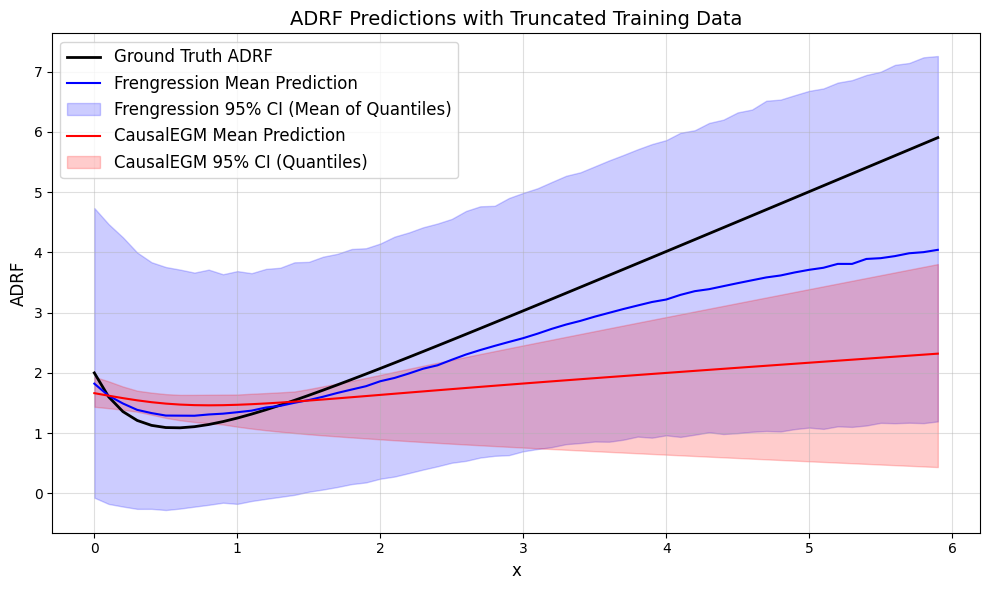

Frengression Average RMSE: 1.2257
CausalEGM Average RMSE: 1.8041


In [ ]:
# Set up the range of x values for predictions
x_vals = np.arange(0, 6, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

# Number of repetitions
nrep = 30
n_tr = 1000
num_iters = 4000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize storage for predictions
fr_preds = [[], [], []]  # 2.5%, mean, 97.5%
cegm_preds = []

# Ground truth ADRF values
ground_truth_adrf = Sim_Hirano_Imbens_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data
    x_train, y_train, z_train = Sim_Hirano_Imbens_sampler(
        N=n_tr, v_dim=200, seed=1024 + rep, batch_size=n_tr
    ).load_all()
    
    # Convert to tensors
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)
    
    # Truncate the dataset to x in (0, 3)
    mask = (x_train > 0) & (x_train < 3)  # `mask` has shape (1000,)
    mask = mask.flatten()  # Flatten to 1D if necessary

    x_tr = x_tr[mask]  # Apply mask to filter rows
    y_tr = y_tr[mask]
    z_tr = z_tr[mask]
    
    # --- Frengression Model ---
    # Initialize and train
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=400,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model (quantiles and mean)
    fr_pred = fr_model.predict_causal(
        x_tensor, target=[0.025, "mean", 0.975], sample_size=1000
    )  # Returns a list of 3 tensors, each (30, 1)
    
    # Append predictions to the respective lists
    for i, quantile_pred in enumerate(fr_pred):
        fr_preds[i].append(quantile_pred.numpy().flatten())  # Convert to NumPy array and flatten


    # --- CausalEGM Model ---
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train[mask], y_train[mask], z_train[mask]], n_iter=1000, verbose=False)

    # Predict using CausalEGM model
    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    cegm_preds.append(cegm_pred)

# Convert predictions to NumPy arrays
fr_preds = [np.array(pred_list).T for pred_list in fr_preds]  # Each becomes (30, nrep)
cegm_preds = np.array(cegm_preds).T  # Convert to (30, nrep)

# Compute mean predictions and CIs for Frengression
fr_ci_lower = fr_preds[0].mean(axis=1)  # Mean of 2.5% predictions
fr_mean_pred = fr_preds[1].mean(axis=1)  # Mean predictions
fr_ci_upper = fr_preds[2].mean(axis=1)  # Mean of 97.5% predictions

# Compute mean predictions and CIs for CausalEGM
cegm_mean_pred = cegm_preds.mean(axis=1)
cegm_ci_lower = np.quantile(cegm_preds, 0.025, axis=1)
cegm_ci_upper = np.quantile(cegm_preds, 0.975, axis=1)

# Plotting the results
plt.figure(figsize=(10, 6))

# Ground truth ADRF
plt.plot(x_vals, ground_truth_adrf, label='Ground Truth ADRF', color='black', linewidth=2)

# Frengression predictions
plt.plot(x_vals, fr_mean_pred, label='Frengression Mean Prediction', color='blue')
plt.fill_between(x_vals, fr_ci_lower, fr_ci_upper, color='blue', alpha=0.2, label='Frengression 95% CI (Mean of Quantiles)')

# CausalEGM predictions
plt.plot(x_vals, cegm_mean_pred, label='CausalEGM Mean Prediction', color='red')
plt.fill_between(x_vals, cegm_ci_lower, cegm_ci_upper, color='red', alpha=0.2, label='CausalEGM 95% CI (Quantiles)')

# Add title, labels, and legend
plt.title('ADRF Predictions with Truncated Training Data', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('ADRF', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)

# Show the plot
plt.tight_layout()
plt.show()

# Compute and print average RMSEs
fr_rmses = [rmse(fr_preds[1][:, rep], ground_truth_adrf) for rep in range(nrep)]
cegm_rmses = [rmse(cegm_preds[:, rep], ground_truth_adrf) for rep in range(nrep)]

print(f"Frengression Average RMSE: {np.mean(fr_rmses):.4f}")
print(f"CausalEGM Average RMSE: {np.mean(cegm_rmses):.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 13.6242, loss1 14.3272, loss2 1.4061
Epoch 400: loss 10.3120, loss1 19.9033, loss2 19.1826
Epoch 800: loss 10.1126, loss1 19.8424, loss2 19.4594
Epoch 1200: loss 10.1560, loss1 20.0484, loss2 19.7849
Epoch 1600: loss 10.0981, loss1 19.9962, loss2 19.7963
Epoch 2000: loss 10.1900, loss1 20.0363, loss2 19.6926
Epoch 2400: loss 10.0922, loss1 20.0257, loss2 19.8670
Epoch 2800: loss 10.0968, loss1 20.0805, loss2 19.9675
Epoch 1: loss 2.6977,	loss_y 1.9575, 1.9821, 0.0492,	loss_eta 0.7402, 0.7810, 0.0815
Epoch 400: loss 1.6013,	loss_y 0.9893, 1.3752, 0.7719,	loss_eta 0.6120, 1.5518, 1.8795
Epoch 800: loss 1.6668,	loss_y 1.0644, 2.4559, 2.7831,	loss_eta 0.6025, 1.6828, 2.1607
Epoch 1200: loss 1.3881,	loss_y 0.6844, 1.4107, 1.4527,	loss_eta 0.7038, 0.9577, 0.5078
Epoch 1600: loss 1.4409,	loss_y 0.8132, 1.1269, 0.6275,	loss_eta 0.6277, 1.5521, 1.8488
Epoch 2000: loss 1.3029,	loss_y 0.7005, 1.3723, 1.3437,	loss_eta 0.6024, 1.0335, 0.8621
Epoch 2400: loss 1.0884,	loss_y 0.5674, 1.1

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_120', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_121', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5710, loss1 14.2576, loss2 1.3733
Epoch 400: loss 10.2218, loss1 19.6927, loss2 18.9418
Epoch 800: loss 10.2051, loss1 19.9530, loss2 19.4958
Epoch 1200: loss 10.1158, loss1 19.9147, loss2 19.5977
Epoch 1600: loss 10.1132, loss1 20.0328, loss2 19.8393
Epoch 2000: loss 10.0993, loss1 19.9636, loss2 19.7287
Epoch 2400: loss 10.0855, loss1 19.9920, loss2 19.8130
Epoch 2800: loss 10.1251, loss1 19.9826, loss2 19.7150
Epoch 1: loss 2.6407,	loss_y 1.9128, 1.9518, 0.0778,	loss_eta 0.7278, 0.7693, 0.0829
Epoch 400: loss 1.6083,	loss_y 1.0750, 1.3556, 0.5612,	loss_eta 0.5333, 1.2843, 1.5019
Epoch 800: loss 1.5386,	loss_y 0.8334, 2.3270, 2.9872,	loss_eta 0.7052, 1.1764, 0.9423
Epoch 1200: loss 1.4287,	loss_y 0.8158, 1.3483, 1.0652,	loss_eta 0.6130, 1.4006, 1.5752
Epoch 1600: loss 1.3527,	loss_y 0.7965, 1.4119, 1.2308,	loss_eta 0.5563, 1.1578, 1.2030
Epoch 2000: loss 1.1150,	loss_y 0.5159, 1.0118, 0.9917,	loss_eta 0.5990, 1.2440, 1.2898
Epoch 2400: loss 1.0481,	loss_y 0.4654, 0.9

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_124', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_125', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6173, loss1 14.3204, loss2 1.4062
Epoch 400: loss 10.3031, loss1 19.8062, loss2 19.0061
Epoch 800: loss 10.2497, loss1 19.8800, loss2 19.2605
Epoch 1200: loss 10.2505, loss1 19.9908, loss2 19.4805
Epoch 1600: loss 10.1725, loss1 19.9615, loss2 19.5780
Epoch 2000: loss 10.1415, loss1 20.0748, loss2 19.8666
Epoch 2400: loss 10.1524, loss1 20.0772, loss2 19.8495
Epoch 2800: loss 10.1739, loss1 20.0723, loss2 19.7968
Epoch 1: loss 2.7891,	loss_y 2.0197, 2.0588, 0.0781,	loss_eta 0.7694, 0.8067, 0.0748
Epoch 400: loss 1.6316,	loss_y 1.0348, 1.3964, 0.7233,	loss_eta 0.5968, 0.8450, 0.4963
Epoch 800: loss 1.3900,	loss_y 0.7367, 1.2568, 1.0403,	loss_eta 0.6533, 0.9226, 0.5387
Epoch 1200: loss 1.2527,	loss_y 0.6606, 1.5372, 1.7533,	loss_eta 0.5921, 1.2989, 1.4136
Epoch 1600: loss 1.3550,	loss_y 0.8129, 2.3282, 3.0306,	loss_eta 0.5421, 1.2587, 1.4332
Epoch 2000: loss 1.0965,	loss_y 0.5406, 1.4209, 1.7607,	loss_eta 0.5559, 1.3295, 1.5471
Epoch 2400: loss 1.1597,	loss_y 0.5406, 0.8

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_128', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_129', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5964, loss1 14.2816, loss2 1.3704
Epoch 400: loss 10.1704, loss1 19.7350, loss2 19.1291
Epoch 800: loss 10.1673, loss1 19.9945, loss2 19.6543
Epoch 1200: loss 10.2009, loss1 19.9639, loss2 19.5261
Epoch 1600: loss 10.1569, loss1 19.9602, loss2 19.6066
Epoch 2000: loss 10.1386, loss1 20.0020, loss2 19.7268
Epoch 2400: loss 10.1682, loss1 19.9360, loss2 19.5355
Epoch 2800: loss 10.1420, loss1 20.0639, loss2 19.8438
Epoch 1: loss 2.8468,	loss_y 2.0507, 2.0566, 0.0117,	loss_eta 0.7961, 0.8307, 0.0692
Epoch 400: loss 1.6704,	loss_y 1.0781, 1.3125, 0.4687,	loss_eta 0.5923, 1.4271, 1.6695
Epoch 800: loss 1.7485,	loss_y 1.0905, 2.3526, 2.5242,	loss_eta 0.6580, 0.9383, 0.5607
Epoch 1200: loss 1.5510,	loss_y 0.9362, 2.7216, 3.5709,	loss_eta 0.6148, 1.0678, 0.9060
Epoch 1600: loss 1.1719,	loss_y 0.6070, 1.1580, 1.1019,	loss_eta 0.5649, 1.0329, 0.9360
Epoch 2000: loss 1.1468,	loss_y 0.5782, 1.1658, 1.1751,	loss_eta 0.5686, 1.1328, 1.1284
Epoch 2400: loss 1.1333,	loss_y 0.5387, 1.0

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_132', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_133', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6139, loss1 14.3073, loss2 1.3869
Epoch 400: loss 10.2257, loss1 19.8517, loss2 19.2519
Epoch 800: loss 10.1634, loss1 20.0316, loss2 19.7363
Epoch 1200: loss 10.0911, loss1 19.9230, loss2 19.6638
Epoch 1600: loss 10.1896, loss1 20.0068, loss2 19.6343
Epoch 2000: loss 10.0986, loss1 19.9700, loss2 19.7428
Epoch 2400: loss 10.1446, loss1 20.0435, loss2 19.7977
Epoch 2800: loss 10.1521, loss1 20.0436, loss2 19.7829
Epoch 1: loss 2.6403,	loss_y 1.8587, 1.8823, 0.0472,	loss_eta 0.7816, 0.8204, 0.0776
Epoch 400: loss 1.6282,	loss_y 1.0249, 1.3032, 0.5566,	loss_eta 0.6034, 1.4094, 1.6122
Epoch 800: loss 1.2446,	loss_y 0.6831, 1.1053, 0.8445,	loss_eta 0.5615, 1.2184, 1.3139
Epoch 1200: loss 1.2255,	loss_y 0.6697, 1.2987, 1.2580,	loss_eta 0.5558, 1.1558, 1.2000
Epoch 1600: loss 1.1642,	loss_y 0.5914, 0.9903, 0.7979,	loss_eta 0.5729, 1.4460, 1.7463
Epoch 2000: loss 1.2354,	loss_y 0.6297, 1.3300, 1.4005,	loss_eta 0.6056, 1.5975, 1.9837
Epoch 2400: loss 1.1461,	loss_y 0.5896, 1.0

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_136', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_137', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6041, loss1 14.2844, loss2 1.3605
Epoch 400: loss 10.1701, loss1 19.7513, loss2 19.1622
Epoch 800: loss 10.1550, loss1 19.9219, loss2 19.5338
Epoch 1200: loss 10.0536, loss1 19.8949, loss2 19.6826
Epoch 1600: loss 10.1632, loss1 19.9775, loss2 19.6286
Epoch 2000: loss 10.1114, loss1 19.9944, loss2 19.7661
Epoch 2400: loss 10.0975, loss1 19.9339, loss2 19.6729
Epoch 2800: loss 10.0929, loss1 19.9310, loss2 19.6763
Epoch 1: loss 2.7120,	loss_y 1.9610, 1.9798, 0.0375,	loss_eta 0.7510, 0.7912, 0.0805
Epoch 400: loss 1.5536,	loss_y 0.9784, 1.3827, 0.8088,	loss_eta 0.5753, 1.2904, 1.4303
Epoch 800: loss 1.1939,	loss_y 0.6464, 1.0348, 0.7769,	loss_eta 0.5476, 1.1621, 1.2291
Epoch 1200: loss 1.5875,	loss_y 0.9631, 2.5781, 3.2299,	loss_eta 0.6244, 1.1779, 1.1070
Epoch 1600: loss 1.4162,	loss_y 0.7713, 1.7285, 1.9144,	loss_eta 0.6449, 1.7332, 2.1764
Epoch 2000: loss 1.1021,	loss_y 0.4901, 0.8360, 0.6918,	loss_eta 0.6120, 1.1057, 0.9873
Epoch 2400: loss 0.9859,	loss_y 0.4149, 0.8

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_140', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_141', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6483, loss1 14.3305, loss2 1.3645
Epoch 400: loss 10.1878, loss1 19.8089, loss2 19.2421
Epoch 800: loss 10.2099, loss1 19.8929, loss2 19.3660
Epoch 1200: loss 10.1555, loss1 20.0056, loss2 19.7002
Epoch 1600: loss 10.1494, loss1 20.0672, loss2 19.8355
Epoch 2000: loss 10.2158, loss1 19.9537, loss2 19.4758
Epoch 2400: loss 10.1063, loss1 20.0717, loss2 19.9309
Epoch 2800: loss 10.0910, loss1 20.0176, loss2 19.8531
Epoch 1: loss 2.8811,	loss_y 2.1350, 2.1425, 0.0151,	loss_eta 0.7462, 0.7822, 0.0721
Epoch 400: loss 1.6328,	loss_y 1.0426, 1.3848, 0.6844,	loss_eta 0.5901, 1.6886, 2.1969
Epoch 800: loss 1.3389,	loss_y 0.6984, 1.8393, 2.2818,	loss_eta 0.6405, 1.1254, 0.9697
Epoch 1200: loss 1.3520,	loss_y 0.6411, 1.3683, 1.4543,	loss_eta 0.7108, 1.1074, 0.7931
Epoch 1600: loss 1.3710,	loss_y 0.6793, 1.5034, 1.6482,	loss_eta 0.6916, 1.1799, 0.9765
Epoch 2000: loss 1.5377,	loss_y 0.8089, 1.4762, 1.3347,	loss_eta 0.7289, 1.3475, 1.2373
Epoch 2400: loss 1.3679,	loss_y 0.6707, 1.4

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_144', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_145', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6232, loss1 14.3152, loss2 1.3841
Epoch 400: loss 10.1913, loss1 19.8949, loss2 19.4072
Epoch 800: loss 10.1634, loss1 19.9685, loss2 19.6102
Epoch 1200: loss 10.1386, loss1 19.9731, loss2 19.6690
Epoch 1600: loss 10.1424, loss1 19.9748, loss2 19.6647
Epoch 2000: loss 10.1610, loss1 20.0694, loss2 19.8167
Epoch 2400: loss 10.1072, loss1 20.0675, loss2 19.9206
Epoch 2800: loss 10.0553, loss1 19.9947, loss2 19.8787
Epoch 1: loss 2.8585,	loss_y 2.0656, 2.0803, 0.0294,	loss_eta 0.7930, 0.8370, 0.0880
Epoch 400: loss 1.6519,	loss_y 1.0259, 1.4953, 0.9388,	loss_eta 0.6260, 1.0724, 0.8928
Epoch 800: loss 1.6129,	loss_y 0.9900, 2.2018, 2.4235,	loss_eta 0.6228, 1.2744, 1.3031
Epoch 1200: loss 1.4720,	loss_y 0.8549, 1.5891, 1.4683,	loss_eta 0.6171, 1.7376, 2.2410
Epoch 1600: loss 1.3356,	loss_y 0.7087, 1.2793, 1.1411,	loss_eta 0.6269, 0.9300, 0.6061
Epoch 2000: loss 1.3753,	loss_y 0.8053, 1.9158, 2.2209,	loss_eta 0.5700, 1.3456, 1.5511
Epoch 2400: loss 1.2191,	loss_y 0.6169, 1.2

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_148', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_149', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.7022, loss1 14.4022, loss2 1.4000
Epoch 400: loss 10.2504, loss1 19.7940, loss2 19.0874
Epoch 800: loss 10.2203, loss1 20.1126, loss2 19.7846
Epoch 1200: loss 10.2662, loss1 20.1953, loss2 19.8581
Epoch 1600: loss 10.1512, loss1 20.0779, loss2 19.8536
Epoch 2000: loss 10.2237, loss1 20.1471, loss2 19.8468
Epoch 2400: loss 10.2727, loss1 20.1577, loss2 19.7701
Epoch 2800: loss 10.2039, loss1 20.0853, loss2 19.7627
Epoch 1: loss 2.7879,	loss_y 2.0365, 2.0648, 0.0566,	loss_eta 0.7514, 0.7923, 0.0819
Epoch 400: loss 1.4582,	loss_y 0.8612, 1.3447, 0.9671,	loss_eta 0.5970, 1.0296, 0.8651
Epoch 800: loss 1.4851,	loss_y 0.8067, 1.6328, 1.6522,	loss_eta 0.6785, 0.9800, 0.6031
Epoch 1200: loss 1.3946,	loss_y 0.7609, 1.9387, 2.3556,	loss_eta 0.6337, 1.0627, 0.8579
Epoch 1600: loss 1.1392,	loss_y 0.5313, 0.9229, 0.7833,	loss_eta 0.6079, 1.4624, 1.7089
Epoch 2000: loss 1.1417,	loss_y 0.5174, 1.2410, 1.4472,	loss_eta 0.6243, 1.3045, 1.3604
Epoch 2400: loss 1.0210,	loss_y 0.4184, 0.7

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_152', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_153', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6419, loss1 14.3361, loss2 1.3884
Epoch 400: loss 10.2583, loss1 19.8953, loss2 19.2741
Epoch 800: loss 10.1640, loss1 19.9742, loss2 19.6204
Epoch 1200: loss 10.1787, loss1 20.0095, loss2 19.6616
Epoch 1600: loss 10.1665, loss1 20.0695, loss2 19.8060
Epoch 2000: loss 10.1602, loss1 20.0612, loss2 19.8022
Epoch 2400: loss 10.1251, loss1 20.0870, loss2 19.9238
Epoch 2800: loss 10.1310, loss1 19.9752, loss2 19.6884
Epoch 1: loss 2.7279,	loss_y 1.9745, 2.0017, 0.0543,	loss_eta 0.7534, 0.7893, 0.0719
Epoch 400: loss 1.7243,	loss_y 1.1251, 1.2857, 0.3213,	loss_eta 0.5992, 1.3404, 1.4823
Epoch 800: loss 1.3676,	loss_y 0.6848, 1.5418, 1.7140,	loss_eta 0.6828, 1.2202, 1.0748
Epoch 1200: loss 1.5556,	loss_y 0.8683, 2.0396, 2.3425,	loss_eta 0.6873, 1.0806, 0.7866
Epoch 1600: loss 1.2455,	loss_y 0.6429, 1.6150, 1.9441,	loss_eta 0.6026, 1.6001, 1.9950
Epoch 2000: loss 1.2964,	loss_y 0.6609, 1.3503, 1.3787,	loss_eta 0.6355, 1.6208, 1.9707
Epoch 2400: loss 1.2116,	loss_y 0.6104, 1.2

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_156', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_157', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.8586, loss1 14.5385, loss2 1.3597
Epoch 400: loss 10.4999, loss1 19.9832, loss2 18.9666
Epoch 800: loss 10.5033, loss1 20.1865, loss2 19.3663
Epoch 1200: loss 10.4381, loss1 20.2756, loss2 19.6749
Epoch 1600: loss 10.3462, loss1 20.1851, loss2 19.6778
Epoch 2000: loss 10.3473, loss1 20.2444, loss2 19.7942
Epoch 2400: loss 10.3561, loss1 20.2955, loss2 19.8789
Epoch 2800: loss 10.4067, loss1 20.2570, loss2 19.7005
Epoch 1: loss 2.9816,	loss_y 2.2277, 2.2374, 0.0195,	loss_eta 0.7539, 0.7917, 0.0756
Epoch 400: loss 1.9028,	loss_y 1.3308, 1.5385, 0.4154,	loss_eta 0.5721, 1.3242, 1.5042
Epoch 800: loss 1.5487,	loss_y 0.9324, 1.3946, 0.9244,	loss_eta 0.6164, 0.9967, 0.7607
Epoch 1200: loss 1.5108,	loss_y 0.8361, 1.6921, 1.7120,	loss_eta 0.6747, 0.8696, 0.3897
Epoch 1600: loss 1.3733,	loss_y 0.7712, 1.8467, 2.1510,	loss_eta 0.6021, 1.0930, 0.9817
Epoch 2000: loss 1.4015,	loss_y 0.8195, 1.4699, 1.3007,	loss_eta 0.5820, 1.4529, 1.7418
Epoch 2400: loss 1.2779,	loss_y 0.6637, 1.1

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_160', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_161', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6904, loss1 14.3658, loss2 1.3507
Epoch 400: loss 10.1828, loss1 19.7538, loss2 19.1421
Epoch 800: loss 10.2058, loss1 20.0002, loss2 19.5888
Epoch 1200: loss 10.2167, loss1 20.0777, loss2 19.7219
Epoch 1600: loss 10.1482, loss1 20.0558, loss2 19.8151
Epoch 2000: loss 10.2180, loss1 20.0583, loss2 19.6807
Epoch 2400: loss 10.1240, loss1 20.0677, loss2 19.8874
Epoch 2800: loss 10.2095, loss1 20.1528, loss2 19.8865
Epoch 1: loss 2.8400,	loss_y 2.0616, 2.0743, 0.0254,	loss_eta 0.7784, 0.8189, 0.0811
Epoch 400: loss 1.6588,	loss_y 1.0975, 1.4202, 0.6453,	loss_eta 0.5612, 1.2748, 1.4271
Epoch 800: loss 1.4401,	loss_y 0.8018, 1.2765, 0.9494,	loss_eta 0.6383, 0.9125, 0.5485
Epoch 1200: loss 1.2665,	loss_y 0.7193, 1.5510, 1.6633,	loss_eta 0.5472, 1.4580, 1.8216
Epoch 1600: loss 1.4151,	loss_y 0.7615, 1.5348, 1.5464,	loss_eta 0.6536, 1.6154, 1.9235
Epoch 2000: loss 1.4302,	loss_y 0.7902, 1.7809, 1.9814,	loss_eta 0.6400, 0.8907, 0.5015
Epoch 2400: loss 1.2780,	loss_y 0.6282, 1.3

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_164', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_165', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6354, loss1 14.3433, loss2 1.4158
Epoch 400: loss 10.2663, loss1 19.8333, loss2 19.1340
Epoch 800: loss 10.1059, loss1 19.9151, loss2 19.6185
Epoch 1200: loss 10.1262, loss1 19.9880, loss2 19.7236
Epoch 1600: loss 10.1962, loss1 20.0121, loss2 19.6319
Epoch 2000: loss 10.2397, loss1 20.0872, loss2 19.6951
Epoch 2400: loss 10.1649, loss1 20.0273, loss2 19.7248
Epoch 2800: loss 10.1078, loss1 20.0081, loss2 19.8006
Epoch 1: loss 2.7525,	loss_y 2.0037, 2.0188, 0.0302,	loss_eta 0.7488, 0.7881, 0.0786
Epoch 400: loss 1.6430,	loss_y 0.9654, 1.3851, 0.8394,	loss_eta 0.6776, 0.9878, 0.6204
Epoch 800: loss 1.4407,	loss_y 0.8870, 2.4798, 3.1856,	loss_eta 0.5537, 1.2300, 1.3526
Epoch 1200: loss 1.2899,	loss_y 0.6123, 1.0268, 0.8288,	loss_eta 0.6776, 1.2599, 1.1646
Epoch 1600: loss 1.1074,	loss_y 0.5546, 1.1199, 1.1305,	loss_eta 0.5528, 1.2448, 1.3840
Epoch 2000: loss 1.2115,	loss_y 0.6040, 1.3770, 1.5461,	loss_eta 0.6075, 1.1144, 1.0137
Epoch 2400: loss 1.0267,	loss_y 0.4270, 0.8

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_168', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_169', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6109, loss1 14.2960, loss2 1.3703
Epoch 400: loss 10.1861, loss1 19.7672, loss2 19.1622
Epoch 800: loss 10.1243, loss1 19.9396, loss2 19.6305
Epoch 1200: loss 10.1141, loss1 19.9852, loss2 19.7421
Epoch 1600: loss 10.1757, loss1 19.9582, loss2 19.5650
Epoch 2000: loss 10.1106, loss1 19.9957, loss2 19.7702
Epoch 2400: loss 10.1597, loss1 19.9379, loss2 19.5565
Epoch 2800: loss 10.1525, loss1 20.0193, loss2 19.7336
Epoch 1: loss 2.5986,	loss_y 1.8213, 1.8602, 0.0778,	loss_eta 0.7773, 0.8177, 0.0808
Epoch 400: loss 1.6206,	loss_y 1.0277, 1.3301, 0.6047,	loss_eta 0.5929, 1.1388, 1.0920
Epoch 800: loss 1.5579,	loss_y 0.8589, 1.3467, 0.9755,	loss_eta 0.6990, 0.8067, 0.2154
Epoch 1200: loss 1.3217,	loss_y 0.7060, 1.0983, 0.7846,	loss_eta 0.6157, 1.7756, 2.3198
Epoch 1600: loss 1.2851,	loss_y 0.6562, 1.1449, 0.9775,	loss_eta 0.6289, 0.9240, 0.5902
Epoch 2000: loss 1.1154,	loss_y 0.5331, 1.0928, 1.1194,	loss_eta 0.5823, 1.2317, 1.2989
Epoch 2400: loss 1.0920,	loss_y 0.4812, 0.9

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_172', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_173', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6291, loss1 14.3109, loss2 1.3637
Epoch 400: loss 10.1880, loss1 19.9001, loss2 19.4243
Epoch 800: loss 10.1668, loss1 19.8996, loss2 19.4655
Epoch 1200: loss 10.0967, loss1 19.9602, loss2 19.7269
Epoch 1600: loss 10.0891, loss1 19.9993, loss2 19.8204
Epoch 2000: loss 10.1643, loss1 20.0140, loss2 19.6994
Epoch 2400: loss 10.1182, loss1 19.9771, loss2 19.7177
Epoch 2800: loss 10.0642, loss1 20.0744, loss2 20.0203
Epoch 1: loss 2.6458,	loss_y 1.8904, 1.9169, 0.0530,	loss_eta 0.7554, 0.7927, 0.0746
Epoch 400: loss 1.5172,	loss_y 0.9067, 1.2472, 0.6810,	loss_eta 0.6104, 1.0101, 0.7992
Epoch 800: loss 1.5095,	loss_y 0.8273, 2.3559, 3.0571,	loss_eta 0.6822, 0.8845, 0.4047
Epoch 1200: loss 1.3999,	loss_y 0.7017, 1.1249, 0.8464,	loss_eta 0.6983, 0.8663, 0.3361
Epoch 1600: loss 1.3022,	loss_y 0.7021, 1.5616, 1.7191,	loss_eta 0.6001, 1.1205, 1.0409
Epoch 2000: loss 1.1769,	loss_y 0.6053, 1.2297, 1.2488,	loss_eta 0.5716, 1.4183, 1.6933
Epoch 2400: loss 1.1314,	loss_y 0.5228, 0.9

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_176', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_177', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5682, loss1 14.2557, loss2 1.3750
Epoch 400: loss 10.1714, loss1 19.7146, loss2 19.0865
Epoch 800: loss 10.0592, loss1 19.8331, loss2 19.5478
Epoch 1200: loss 10.0623, loss1 19.7727, loss2 19.4207
Epoch 1600: loss 9.9985, loss1 19.9580, loss2 19.9191
Epoch 2000: loss 10.1046, loss1 19.9749, loss2 19.7407
Epoch 2400: loss 10.0705, loss1 19.9457, loss2 19.7504
Epoch 2800: loss 10.0866, loss1 19.9901, loss2 19.8070
Epoch 1: loss 2.4171,	loss_y 1.6885, 1.7156, 0.0542,	loss_eta 0.7286, 0.7703, 0.0834
Epoch 400: loss 1.5884,	loss_y 0.9700, 1.2181, 0.4963,	loss_eta 0.6185, 1.5036, 1.7703
Epoch 800: loss 1.1973,	loss_y 0.6189, 1.3912, 1.5447,	loss_eta 0.5785, 1.1701, 1.1832
Epoch 1200: loss 1.2842,	loss_y 0.7275, 1.5965, 1.7379,	loss_eta 0.5567, 1.1093, 1.1052
Epoch 1600: loss 1.3094,	loss_y 0.7173, 1.8346, 2.2346,	loss_eta 0.5921, 1.3828, 1.5813
Epoch 2000: loss 1.3274,	loss_y 0.7079, 1.4601, 1.5045,	loss_eta 0.6195, 1.1338, 1.0285
Epoch 2400: loss 1.1733,	loss_y 0.5939, 1.17

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_180', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_181', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6415, loss1 14.3110, loss2 1.3390
Epoch 400: loss 10.1925, loss1 19.7918, loss2 19.1985
Epoch 800: loss 10.1994, loss1 19.9726, loss2 19.5465
Epoch 1200: loss 10.1796, loss1 19.9142, loss2 19.4692
Epoch 1600: loss 10.1769, loss1 20.0148, loss2 19.6758
Epoch 2000: loss 10.1389, loss1 20.0199, loss2 19.7622
Epoch 2400: loss 10.1454, loss1 19.9869, loss2 19.6830
Epoch 2800: loss 10.1585, loss1 20.0791, loss2 19.8413
Epoch 1: loss 2.7711,	loss_y 2.0080, 2.0429, 0.0697,	loss_eta 0.7631, 0.8014, 0.0766
Epoch 400: loss 1.5315,	loss_y 0.8503, 1.2908, 0.8808,	loss_eta 0.6811, 0.8552, 0.3482
Epoch 800: loss 1.6593,	loss_y 1.0164, 2.9130, 3.7931,	loss_eta 0.6429, 0.9159, 0.5460
Epoch 1200: loss 1.3050,	loss_y 0.7005, 1.5004, 1.5999,	loss_eta 0.6045, 1.4136, 1.6183
Epoch 1600: loss 1.4198,	loss_y 0.7185, 1.5495, 1.6620,	loss_eta 0.7012, 0.9788, 0.5551
Epoch 2000: loss 1.2715,	loss_y 0.6428, 1.2827, 1.2798,	loss_eta 0.6286, 1.5307, 1.8041
Epoch 2400: loss 1.1716,	loss_y 0.5900, 1.0

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_184', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_185', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5872, loss1 14.2693, loss2 1.3643
Epoch 400: loss 10.2322, loss1 19.7405, loss2 19.0166
Epoch 800: loss 10.0591, loss1 19.9249, loss2 19.7316
Epoch 1200: loss 10.1202, loss1 19.9225, loss2 19.6047
Epoch 1600: loss 10.1001, loss1 19.9595, loss2 19.7189
Epoch 2000: loss 10.1577, loss1 19.9498, loss2 19.5843
Epoch 2400: loss 10.0882, loss1 20.0575, loss2 19.9386
Epoch 2800: loss 10.0623, loss1 19.9841, loss2 19.8435
Epoch 1: loss 2.6021,	loss_y 1.8258, 1.8489, 0.0461,	loss_eta 0.7763, 0.8124, 0.0723
Epoch 400: loss 1.4844,	loss_y 0.8051, 1.3399, 1.0696,	loss_eta 0.6793, 1.2525, 1.1464
Epoch 800: loss 1.5463,	loss_y 0.8650, 2.1015, 2.4729,	loss_eta 0.6812, 0.8327, 0.3029
Epoch 1200: loss 1.4353,	loss_y 0.7269, 1.1069, 0.7600,	loss_eta 0.7084, 1.0151, 0.6134
Epoch 1600: loss 1.2122,	loss_y 0.6410, 1.1043, 0.9266,	loss_eta 0.5712, 1.4434, 1.7444
Epoch 2000: loss 1.2270,	loss_y 0.6267, 1.2505, 1.2476,	loss_eta 0.6003, 1.1243, 1.0479
Epoch 2400: loss 1.2159,	loss_y 0.6336, 1.3

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_188', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_189', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 14.3651, loss1 15.0662, loss2 1.4022
Epoch 400: loss 11.0002, loss1 20.5284, loss2 19.0564
Epoch 800: loss 10.9795, loss1 20.7278, loss2 19.4966
Epoch 1200: loss 10.8736, loss1 20.7708, loss2 19.7943
Epoch 1600: loss 10.9234, loss1 20.8036, loss2 19.7603
Epoch 2000: loss 10.8977, loss1 20.7801, loss2 19.7646
Epoch 2400: loss 10.8718, loss1 20.7759, loss2 19.8081
Epoch 2800: loss 10.8294, loss1 20.7528, loss2 19.8468
Epoch 1: loss 3.5721,	loss_y 2.8342, 2.8751, 0.0818,	loss_eta 0.7379, 0.7847, 0.0936
Epoch 400: loss 2.1610,	loss_y 1.5532, 1.8596, 0.6129,	loss_eta 0.6078, 1.0539, 0.8921
Epoch 800: loss 1.7904,	loss_y 1.0720, 2.0499, 1.9558,	loss_eta 0.7185, 0.8914, 0.3458
Epoch 1200: loss 1.8645,	loss_y 1.2627, 3.0341, 3.5429,	loss_eta 0.6018, 1.3397, 1.4758
Epoch 1600: loss 1.5238,	loss_y 0.9083, 1.5309, 1.2452,	loss_eta 0.6154, 1.1505, 1.0701
Epoch 2000: loss 1.3107,	loss_y 0.7094, 1.2026, 0.9864,	loss_eta 0.6013, 1.0745, 0.9465
Epoch 2400: loss 1.3586,	loss_y 0.7829, 1.2

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_192', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_193', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5997, loss1 14.2824, loss2 1.3655
Epoch 400: loss 10.1442, loss1 19.8170, loss2 19.3455
Epoch 800: loss 10.1747, loss1 19.8762, loss2 19.4031
Epoch 1200: loss 10.0913, loss1 19.9539, loss2 19.7250
Epoch 1600: loss 10.0918, loss1 19.9152, loss2 19.6469
Epoch 2000: loss 10.1522, loss1 19.9909, loss2 19.6774
Epoch 2400: loss 10.1814, loss1 19.9606, loss2 19.5584
Epoch 2800: loss 10.0755, loss1 19.9728, loss2 19.7946
Epoch 1: loss 2.6637,	loss_y 1.9213, 1.9490, 0.0554,	loss_eta 0.7424, 0.7813, 0.0777
Epoch 400: loss 1.5821,	loss_y 0.9285, 1.3661, 0.8751,	loss_eta 0.6536, 0.9420, 0.5768
Epoch 800: loss 1.4356,	loss_y 0.7845, 1.7545, 1.9399,	loss_eta 0.6511, 0.8840, 0.4659
Epoch 1200: loss 1.2793,	loss_y 0.7099, 1.8085, 2.1973,	loss_eta 0.5694, 0.9959, 0.8530
Epoch 1600: loss 1.5892,	loss_y 1.0207, 3.0065, 3.9716,	loss_eta 0.5686, 1.1253, 1.1136
Epoch 2000: loss 1.1955,	loss_y 0.6195, 1.1443, 1.0496,	loss_eta 0.5760, 1.0675, 0.9830
Epoch 2400: loss 1.2005,	loss_y 0.5774, 1.1

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_196', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_197', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6020, loss1 14.2822, loss2 1.3604
Epoch 400: loss 10.2002, loss1 19.7480, loss2 19.0956
Epoch 800: loss 10.1177, loss1 19.9604, loss2 19.6854
Epoch 1200: loss 10.1519, loss1 19.9812, loss2 19.6586
Epoch 1600: loss 10.1206, loss1 20.0557, loss2 19.8702
Epoch 2000: loss 10.1662, loss1 20.0511, loss2 19.7697
Epoch 2400: loss 10.1294, loss1 20.0455, loss2 19.8321
Epoch 2800: loss 10.0817, loss1 20.0393, loss2 19.9152
Epoch 1: loss 2.6986,	loss_y 1.8908, 1.8981, 0.0145,	loss_eta 0.8078, 0.8424, 0.0692
Epoch 400: loss 1.5926,	loss_y 1.0429, 1.3208, 0.5557,	loss_eta 0.5496, 1.2815, 1.4637
Epoch 800: loss 1.4036,	loss_y 0.7405, 1.7706, 2.0603,	loss_eta 0.6632, 0.8619, 0.3975
Epoch 1200: loss 1.5545,	loss_y 0.9221, 1.2817, 0.7193,	loss_eta 0.6324, 1.4062, 1.5475
Epoch 1600: loss 1.4067,	loss_y 0.7410, 1.2170, 0.9519,	loss_eta 0.6656, 1.0030, 0.6748
Epoch 2000: loss 1.2673,	loss_y 0.6481, 1.3021, 1.3081,	loss_eta 0.6193, 1.5411, 1.8437
Epoch 2400: loss 1.0949,	loss_y 0.5123, 1.0

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_200', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_201', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6099, loss1 14.2839, loss2 1.3478
Epoch 400: loss 10.1854, loss1 19.8257, loss2 19.2806
Epoch 800: loss 10.1510, loss1 19.9488, loss2 19.5956
Epoch 1200: loss 10.1801, loss1 19.9570, loss2 19.5537
Epoch 1600: loss 10.1362, loss1 19.9459, loss2 19.6193
Epoch 2000: loss 10.1476, loss1 19.9994, loss2 19.7038
Epoch 2400: loss 10.1447, loss1 20.0139, loss2 19.7384
Epoch 2800: loss 10.1160, loss1 19.9939, loss2 19.7558
Epoch 1: loss 2.7016,	loss_y 1.9299, 1.9407, 0.0217,	loss_eta 0.7717, 0.8099, 0.0764
Epoch 400: loss 1.6310,	loss_y 1.0484, 1.3906, 0.6843,	loss_eta 0.5826, 1.1318, 1.0983
Epoch 800: loss 1.6881,	loss_y 0.9816, 2.5589, 3.1546,	loss_eta 0.7065, 0.8500, 0.2869
Epoch 1200: loss 1.4961,	loss_y 0.8105, 2.0734, 2.5259,	loss_eta 0.6856, 0.8647, 0.3582
Epoch 1600: loss 1.2793,	loss_y 0.7145, 1.3346, 1.2402,	loss_eta 0.5647, 1.1450, 1.1605
Epoch 2000: loss 1.3458,	loss_y 0.7145, 1.5622, 1.6953,	loss_eta 0.6313, 0.9889, 0.7153
Epoch 2400: loss 1.3114,	loss_y 0.6935, 1.2

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_204', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_205', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6383, loss1 14.3280, loss2 1.3793
Epoch 400: loss 10.1325, loss1 19.8607, loss2 19.4566
Epoch 800: loss 10.1920, loss1 19.9709, loss2 19.5578
Epoch 1200: loss 10.1431, loss1 20.0187, loss2 19.7513
Epoch 1600: loss 10.1662, loss1 20.0544, loss2 19.7763
Epoch 2000: loss 10.1473, loss1 20.0298, loss2 19.7649
Epoch 2400: loss 10.1247, loss1 19.9901, loss2 19.7309
Epoch 2800: loss 10.1323, loss1 20.0729, loss2 19.8811
Epoch 1: loss 2.9521,	loss_y 2.1851, 2.1926, 0.0151,	loss_eta 0.7670, 0.8051, 0.0762
Epoch 400: loss 1.6924,	loss_y 1.0884, 1.3998, 0.6228,	loss_eta 0.6040, 1.2199, 1.2318
Epoch 800: loss 1.4147,	loss_y 0.7794, 2.0525, 2.5464,	loss_eta 0.6354, 0.9057, 0.5408
Epoch 1200: loss 1.3567,	loss_y 0.7703, 1.2670, 0.9933,	loss_eta 0.5864, 1.2986, 1.4244
Epoch 1600: loss 1.3601,	loss_y 0.7671, 1.2843, 1.0344,	loss_eta 0.5930, 1.1036, 1.0211
Epoch 2000: loss 1.3582,	loss_y 0.6318, 1.1137, 0.9638,	loss_eta 0.7264, 0.9181, 0.3834
Epoch 2400: loss 1.0035,	loss_y 0.4481, 0.8

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_208', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_209', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.7289, loss1 14.4044, loss2 1.3510
Epoch 400: loss 10.2957, loss1 19.8995, loss2 19.2076
Epoch 800: loss 10.2709, loss1 19.9846, loss2 19.4273
Epoch 1200: loss 10.2922, loss1 20.0398, loss2 19.4951
Epoch 1600: loss 10.2165, loss1 20.0699, loss2 19.7067
Epoch 2000: loss 10.2453, loss1 20.1589, loss2 19.8272
Epoch 2400: loss 10.2241, loss1 20.0992, loss2 19.7503
Epoch 2800: loss 10.1858, loss1 20.1489, loss2 19.9263
Epoch 1: loss 2.8699,	loss_y 2.1106, 2.1342, 0.0472,	loss_eta 0.7592, 0.8037, 0.0890
Epoch 400: loss 1.5598,	loss_y 0.9733, 1.3292, 0.7119,	loss_eta 0.5865, 1.2168, 1.2606
Epoch 800: loss 1.5258,	loss_y 0.8274, 2.1844, 2.7141,	loss_eta 0.6985, 0.8966, 0.3963
Epoch 1200: loss 1.4599,	loss_y 0.8686, 2.4826, 3.2279,	loss_eta 0.5913, 1.4048, 1.6270
Epoch 1600: loss 1.2212,	loss_y 0.6546, 1.1201, 0.9310,	loss_eta 0.5666, 1.6604, 2.1878
Epoch 2000: loss 1.1488,	loss_y 0.5718, 1.1298, 1.1158,	loss_eta 0.5769, 1.2733, 1.3926
Epoch 2400: loss 1.0471,	loss_y 0.4727, 0.9

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_212', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_213', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6764, loss1 14.3637, loss2 1.3745
Epoch 400: loss 10.2846, loss1 19.9290, loss2 19.2887
Epoch 800: loss 10.2596, loss1 20.1094, loss2 19.6996
Epoch 1200: loss 10.2231, loss1 20.0913, loss2 19.7364
Epoch 1600: loss 10.1919, loss1 20.0671, loss2 19.7504
Epoch 2000: loss 10.2458, loss1 20.1163, loss2 19.7411
Epoch 2400: loss 10.1691, loss1 20.1437, loss2 19.9491
Epoch 2800: loss 10.1940, loss1 20.0696, loss2 19.7512
Epoch 1: loss 2.7581,	loss_y 2.0115, 2.0390, 0.0551,	loss_eta 0.7466, 0.7886, 0.0840
Epoch 400: loss 1.8835,	loss_y 1.2959, 1.4892, 0.3866,	loss_eta 0.5876, 1.4608, 1.7463
Epoch 800: loss 1.5222,	loss_y 0.8255, 1.7197, 1.7885,	loss_eta 0.6967, 1.1754, 0.9573
Epoch 1200: loss 1.4185,	loss_y 0.7687, 1.7235, 1.9095,	loss_eta 0.6498, 1.1394, 0.9793
Epoch 1600: loss 1.2724,	loss_y 0.6792, 1.1706, 0.9827,	loss_eta 0.5932, 1.4291, 1.6719
Epoch 2000: loss 1.2342,	loss_y 0.6492, 1.3900, 1.4815,	loss_eta 0.5850, 1.3471, 1.5243
Epoch 2400: loss 1.2021,	loss_y 0.5943, 1.0

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_216', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_217', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6422, loss1 14.3201, loss2 1.3558
Epoch 400: loss 10.2376, loss1 19.8569, loss2 19.2386
Epoch 800: loss 10.2169, loss1 19.9447, loss2 19.4554
Epoch 1200: loss 10.1706, loss1 19.9978, loss2 19.6543
Epoch 1600: loss 10.1630, loss1 20.0237, loss2 19.7214
Epoch 2000: loss 10.1869, loss1 19.9919, loss2 19.6100
Epoch 2400: loss 10.1143, loss1 20.0389, loss2 19.8492
Epoch 2800: loss 10.1125, loss1 20.0751, loss2 19.9251
Epoch 1: loss 2.8017,	loss_y 2.0291, 2.0628, 0.0675,	loss_eta 0.7726, 0.8127, 0.0802
Epoch 400: loss 1.7750,	loss_y 1.1489, 1.4359, 0.5739,	loss_eta 0.6260, 1.4178, 1.5835
Epoch 800: loss 1.3668,	loss_y 0.7890, 1.5042, 1.4305,	loss_eta 0.5779, 1.5108, 1.8659
Epoch 1200: loss 1.3717,	loss_y 0.7926, 1.9158, 2.2463,	loss_eta 0.5791, 1.4838, 1.8094
Epoch 1600: loss 1.2268,	loss_y 0.6542, 1.1254, 0.9424,	loss_eta 0.5726, 1.3346, 1.5241
Epoch 2000: loss 1.2756,	loss_y 0.6481, 1.2701, 1.2440,	loss_eta 0.6274, 1.0905, 0.9262
Epoch 2400: loss 1.1821,	loss_y 0.5498, 0.9

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_220', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_221', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5725, loss1 14.2507, loss2 1.3564
Epoch 400: loss 10.1365, loss1 19.7574, loss2 19.2417
Epoch 800: loss 10.1136, loss1 19.9411, loss2 19.6549
Epoch 1200: loss 10.0705, loss1 19.8268, loss2 19.5126
Epoch 1600: loss 10.0978, loss1 19.8915, loss2 19.5875
Epoch 2000: loss 10.0495, loss1 19.9283, loss2 19.7576
Epoch 2400: loss 10.0855, loss1 19.9120, loss2 19.6529
Epoch 2800: loss 10.0845, loss1 20.0086, loss2 19.8484
Epoch 1: loss 2.4277,	loss_y 1.7014, 1.7240, 0.0453,	loss_eta 0.7264, 0.7658, 0.0790
Epoch 400: loss 1.3753,	loss_y 0.7891, 1.0994, 0.6206,	loss_eta 0.5861, 0.9839, 0.7955
Epoch 800: loss 1.8407,	loss_y 1.1099, 1.5033, 0.7868,	loss_eta 0.7307, 0.8661, 0.2707
Epoch 1200: loss 1.3932,	loss_y 0.7131, 1.6007, 1.7751,	loss_eta 0.6801, 0.9841, 0.6078
Epoch 1600: loss 1.3209,	loss_y 0.6368, 1.0657, 0.8577,	loss_eta 0.6841, 1.1165, 0.8648
Epoch 2000: loss 1.1940,	loss_y 0.5417, 1.1221, 1.1609,	loss_eta 0.6524, 1.0283, 0.7520
Epoch 2400: loss 1.0824,	loss_y 0.4916, 0.9

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_224', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_225', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.8631, loss1 14.5415, loss2 1.3568
Epoch 400: loss 10.3654, loss1 20.1032, loss2 19.4755
Epoch 800: loss 10.4117, loss1 20.2262, loss2 19.6291
Epoch 1200: loss 10.3600, loss1 20.2392, loss2 19.7584
Epoch 1600: loss 10.3842, loss1 20.2048, loss2 19.6412
Epoch 2000: loss 10.3779, loss1 20.3046, loss2 19.8533
Epoch 2400: loss 10.3576, loss1 20.3285, loss2 19.9418
Epoch 2800: loss 10.3127, loss1 20.3626, loss2 20.0998
Epoch 1: loss 2.9216,	loss_y 2.1799, 2.2150, 0.0700,	loss_eta 0.7416, 0.7788, 0.0743
Epoch 400: loss 1.8544,	loss_y 1.2137, 1.4986, 0.5698,	loss_eta 0.6407, 1.4535, 1.6257
Epoch 800: loss 1.2538,	loss_y 0.7198, 1.7016, 1.9636,	loss_eta 0.5340, 1.1604, 1.2527
Epoch 1200: loss 1.3187,	loss_y 0.7060, 1.5392, 1.6663,	loss_eta 0.6127, 0.9639, 0.7024
Epoch 1600: loss 1.1774,	loss_y 0.5538, 0.9176, 0.7275,	loss_eta 0.6235, 1.6153, 1.9835
Epoch 2000: loss 1.1192,	loss_y 0.5051, 0.8814, 0.7525,	loss_eta 0.6141, 1.3942, 1.5601
Epoch 2400: loss 1.0275,	loss_y 0.4510, 0.8

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_228', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_229', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6326, loss1 14.2949, loss2 1.3246
Epoch 400: loss 10.2009, loss1 19.6797, loss2 18.9577
Epoch 800: loss 10.0920, loss1 19.8820, loss2 19.5800
Epoch 1200: loss 10.1379, loss1 19.8716, loss2 19.4674
Epoch 1600: loss 10.1837, loss1 20.0433, loss2 19.7193
Epoch 2000: loss 10.1302, loss1 20.0123, loss2 19.7642
Epoch 2400: loss 10.1013, loss1 20.0086, loss2 19.8146
Epoch 2800: loss 10.1009, loss1 19.9647, loss2 19.7277
Epoch 1: loss 2.7451,	loss_y 1.9816, 1.9996, 0.0361,	loss_eta 0.7635, 0.8016, 0.0761
Epoch 400: loss 1.7486,	loss_y 1.1886, 1.4374, 0.4976,	loss_eta 0.5600, 0.9793, 0.8386
Epoch 800: loss 1.5362,	loss_y 0.8895, 1.4405, 1.1021,	loss_eta 0.6467, 1.0424, 0.7913
Epoch 1200: loss 1.4619,	loss_y 0.8492, 1.2357, 0.7731,	loss_eta 0.6128, 1.3697, 1.5139
Epoch 1600: loss 1.2050,	loss_y 0.5921, 1.3120, 1.4398,	loss_eta 0.6129, 1.0777, 0.9295
Epoch 2000: loss 1.2085,	loss_y 0.5955, 1.1160, 1.0411,	loss_eta 0.6130, 1.3125, 1.3991
Epoch 2400: loss 1.2390,	loss_y 0.6332, 1.1

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_232', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_233', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5663, loss1 14.2536, loss2 1.3746
Epoch 400: loss 10.1635, loss1 19.7081, loss2 19.0892
Epoch 800: loss 10.1152, loss1 19.8626, loss2 19.4948
Epoch 1200: loss 10.0753, loss1 19.9781, loss2 19.8055
Epoch 1600: loss 10.1745, loss1 19.9327, loss2 19.5164
Epoch 2000: loss 10.0984, loss1 19.9664, loss2 19.7360
Epoch 2400: loss 10.0773, loss1 19.9791, loss2 19.8035
Epoch 2800: loss 10.0256, loss1 19.9192, loss2 19.7870
Epoch 1: loss 2.7192,	loss_y 1.9108, 1.9477, 0.0736,	loss_eta 0.8084, 0.8468, 0.0768
Epoch 400: loss 1.4079,	loss_y 0.8188, 1.3226, 1.0075,	loss_eta 0.5891, 1.2139, 1.2495
Epoch 800: loss 1.3852,	loss_y 0.7361, 1.9433, 2.4143,	loss_eta 0.6491, 0.8178, 0.3373
Epoch 1200: loss 1.2529,	loss_y 0.6230, 1.1155, 0.9851,	loss_eta 0.6299, 1.4840, 1.7081
Epoch 1600: loss 1.3415,	loss_y 0.7895, 1.1651, 0.7511,	loss_eta 0.5519, 1.0672, 1.0305
Epoch 2000: loss 1.1454,	loss_y 0.5631, 1.1935, 1.2608,	loss_eta 0.5823, 1.2380, 1.3113
Epoch 2400: loss 1.2865,	loss_y 0.6830, 1.2

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_236', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_237', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

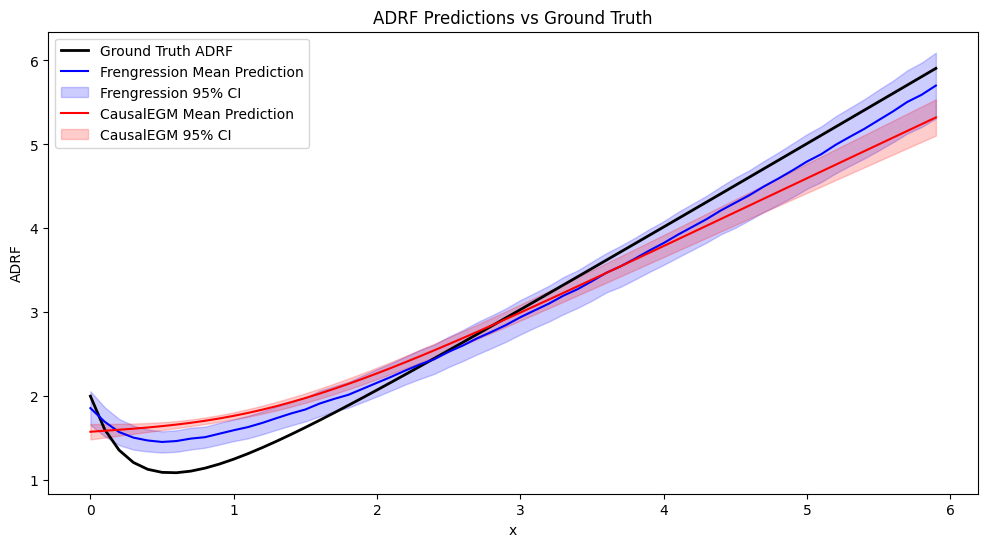

Frengression Average RMSE over 30 reps: 0.6104
Frengression Average MAPE over 30 reps: 0.1916
CausalEGM Average RMSE over 30 reps: 0.4371
CausalEGM Average MAPE over 30 reps: 0.1615


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm


params = {"dataset": "Sim_Hirano_Imbens",
"output_dir": './',
'v_dim': 200,
"z_dims": [1,1,1,7],
"x_min": 0,
"x_max": 3,
"lr": 0.0002,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

# Set up the range of x values
x_vals = np.arange(0, 6, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

# Number of repetitions
nrep = 30
n_tr = 1000
n_p = 1000
num_iters = 3000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lists to store predictions and error metrics
frengression_preds = []
causalegm_preds = []
frengression_rmses = []
frengression_mapes = []
causalegm_rmses = []
causalegm_mapes = []

# Ground truth ADRF values
ground_truth_adrf = Sim_Hirano_Imbens_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data
    x_train, y_train, z_train = Sim_Hirano_Imbens_sampler(
        N=n_tr, v_dim=200, seed=1024 + rep, batch_size=n_tr
    ).load_all()
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)

    # Initialize and train Frengression model
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=400,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model
    fr_pred = fr_model.predict_causal(
        x_tensor, target="mean", sample_size=2000
    ).detach().cpu().numpy().reshape(-1)
    frengression_preds.append(fr_pred)

    # Compute RMSE and MAPE for Frengression model
    fr_rmse = rmse(fr_pred, ground_truth_adrf)
    fr_mape = mape(fr_pred, ground_truth_adrf)
    frengression_rmses.append(fr_rmse)
    frengression_mapes.append(fr_mape)

    # Initialize and train CausalEGM model
    # Assuming CausalEGM requires similar data inputs
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train, y_train, z_train], n_iter=1000, verbose=False)

    # Predict using CausalEGM model
    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    causalegm_preds.append(cegm_pred)

    # Compute RMSE and MAPE for CausalEGM model
    cegm_rmse = rmse(cegm_pred, ground_truth_adrf)
    cegm_mape = mape(cegm_pred, ground_truth_adrf)
    causalegm_rmses.append(cegm_rmse)
    causalegm_mapes.append(cegm_mape)

# Convert prediction lists to NumPy arrays for easier manipulation
frengression_preds = np.array(frengression_preds)
causalegm_preds = np.array(causalegm_preds)

# Compute mean and 95% confidence intervals
fr_mean_pred = frengression_preds.mean(axis=0)
fr_std_pred = frengression_preds.std(axis=0)
fr_ci_upper = fr_mean_pred + 1.96 * fr_std_pred / np.sqrt(nrep)
fr_ci_lower = fr_mean_pred - 1.96 * fr_std_pred / np.sqrt(nrep)

cegm_mean_pred = causalegm_preds.mean(axis=0)
cegm_std_pred = causalegm_preds.std(axis=0)
cegm_ci_upper = cegm_mean_pred + 1.96 * cegm_std_pred / np.sqrt(nrep)
cegm_ci_lower = cegm_mean_pred - 1.96 * cegm_std_pred / np.sqrt(nrep)

# Plotting the results
plt.figure(figsize=(12, 6))

# Ground truth ADRF
plt.plot(x_vals, ground_truth_adrf, label='Ground Truth ADRF', color='black', linewidth=2)

# Frengression predictions
plt.plot(x_vals, fr_mean_pred, label='Frengression Mean Prediction', color='blue')
plt.fill_between(x_vals, fr_ci_lower, fr_ci_upper, color='blue', alpha=0.2, label='Frengression 95% CI')

# CausalEGM predictions
plt.plot(x_vals, cegm_mean_pred, label='CausalEGM Mean Prediction', color='red')
plt.fill_between(x_vals, cegm_ci_lower, cegm_ci_upper, color='red', alpha=0.2, label='CausalEGM 95% CI')

plt.xlabel('x')
plt.ylabel('ADRF')
plt.title('ADRF Predictions vs Ground Truth')
plt.legend()
plt.show()

# Print average RMSE and MAPE for both models
print(f"Frengression Average RMSE over {nrep} reps: {np.mean(frengression_rmses):.4f}")
print(f"Frengression Average MAPE over {nrep} reps: {np.mean(frengression_mapes):.4f}")

print(f"CausalEGM Average RMSE over {nrep} reps: {np.mean(causalegm_rmses):.4f}")
print(f"CausalEGM Average MAPE over {nrep} reps: {np.mean(causalegm_mapes):.4f}")


### Dosage extrapolation 

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 13.4923, loss1 14.1733, loss2 1.3619
Epoch 400: loss 10.0358, loss1 19.5627, loss2 19.0537
Epoch 800: loss 10.0301, loss1 19.8294, loss2 19.5987
Epoch 1200: loss 10.0461, loss1 19.8834, loss2 19.6746
Epoch 1600: loss 9.9700, loss1 19.8635, loss2 19.7870
Epoch 2000: loss 10.1006, loss1 19.8680, loss2 19.5348
Epoch 2400: loss 10.0211, loss1 19.8877, loss2 19.7333
Epoch 2800: loss 10.0780, loss1 19.8976, loss2 19.6391
Epoch 3200: loss 10.0694, loss1 19.9241, loss2 19.7093
Epoch 3600: loss 9.9880, loss1 19.9246, loss2 19.8732
Epoch 4000: loss 10.0049, loss1 19.8663, loss2 19.7229
Epoch 1: loss 2.2930,	loss_y 1.5067, 1.5234, 0.0333,	loss_eta 0.7863, 0.8221, 0.0718
Epoch 400: loss 1.5388,	loss_y 0.9447, 1.2559, 0.6224,	loss_eta 0.5942, 1.0435, 0.8987
Epoch 800: loss 1.4726,	loss_y 0.7356, 1.5285, 1.5858,	loss_eta 0.7370, 0.8324, 0.1907
Epoch 1200: loss 1.3350,	loss_y 0.6321, 1.1220, 0.9800,	loss_eta 0.7030, 0.9927, 0.5795
Epoch 1600: loss 1.5759,	loss_y 0.9082, 2.5550, 3.2936,	

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_120', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_121', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4912, loss1 14.1727, loss2 1.3630
Epoch 400: loss 10.1508, loss1 19.5995, loss2 18.8974
Epoch 800: loss 10.1086, loss1 19.8148, loss2 19.4124
Epoch 1200: loss 10.0186, loss1 19.8303, loss2 19.6234
Epoch 1600: loss 10.0522, loss1 19.8630, loss2 19.6217
Epoch 2000: loss 10.0690, loss1 19.8581, loss2 19.5783
Epoch 2400: loss 9.9865, loss1 19.8001, loss2 19.6272
Epoch 2800: loss 10.0493, loss1 19.8892, loss2 19.6799
Epoch 3200: loss 10.0710, loss1 19.8521, loss2 19.5623
Epoch 3600: loss 9.9398, loss1 19.8215, loss2 19.7634
Epoch 4000: loss 10.0647, loss1 19.8412, loss2 19.5531
Epoch 1: loss 2.3419,	loss_y 1.5720, 1.5898, 0.0356,	loss_eta 0.7699, 0.8119, 0.0841
Epoch 400: loss 1.3918,	loss_y 0.7017, 1.1443, 0.8853,	loss_eta 0.6901, 1.0444, 0.7085
Epoch 800: loss 1.3993,	loss_y 0.7959, 1.1123, 0.6327,	loss_eta 0.6034, 1.2684, 1.3300
Epoch 1200: loss 1.3418,	loss_y 0.7171, 1.3114, 1.1887,	loss_eta 0.6247, 0.8002, 0.3511
Epoch 1600: loss 1.2664,	loss_y 0.6264, 1.1151, 0.9772,	

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_124', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_125', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5105, loss1 14.1861, loss2 1.3512
Epoch 400: loss 10.2596, loss1 19.6566, loss2 18.7939
Epoch 800: loss 10.1233, loss1 19.7743, loss2 19.3020
Epoch 1200: loss 10.1387, loss1 19.8953, loss2 19.5133
Epoch 1600: loss 10.0823, loss1 19.8504, loss2 19.5363
Epoch 2000: loss 10.0112, loss1 19.8744, loss2 19.7264
Epoch 2400: loss 10.0681, loss1 19.9222, loss2 19.7082
Epoch 2800: loss 10.0161, loss1 19.8805, loss2 19.7288
Epoch 3200: loss 10.0855, loss1 19.9582, loss2 19.7455
Epoch 3600: loss 9.9903, loss1 19.9006, loss2 19.8206
Epoch 4000: loss 9.9735, loss1 19.9221, loss2 19.8972
Epoch 1: loss 2.4351,	loss_y 1.6836, 1.7049, 0.0427,	loss_eta 0.7515, 0.7900, 0.0770
Epoch 400: loss 1.5766,	loss_y 0.8669, 1.2912, 0.8486,	loss_eta 0.7097, 0.9765, 0.5335
Epoch 800: loss 1.6040,	loss_y 0.8945, 2.4979, 3.2068,	loss_eta 0.7095, 0.8365, 0.2540
Epoch 1200: loss 1.5900,	loss_y 0.8791, 2.4366, 3.1150,	loss_eta 0.7109, 0.9514, 0.4811
Epoch 1600: loss 1.3715,	loss_y 0.6867, 1.3155, 1.2575,	

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_128', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_129', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5123, loss1 14.2000, loss2 1.3753
Epoch 400: loss 10.1471, loss1 19.6799, loss2 19.0657
Epoch 800: loss 10.0007, loss1 19.7764, loss2 19.5513
Epoch 1200: loss 10.0442, loss1 19.8581, loss2 19.6279
Epoch 1600: loss 10.1364, loss1 19.8163, loss2 19.3599
Epoch 2000: loss 10.0497, loss1 19.8358, loss2 19.5722
Epoch 2400: loss 10.0262, loss1 19.8845, loss2 19.7167
Epoch 2800: loss 10.0405, loss1 19.8415, loss2 19.6020
Epoch 3200: loss 10.0146, loss1 19.9107, loss2 19.7921
Epoch 3600: loss 10.0309, loss1 19.9547, loss2 19.8477
Epoch 4000: loss 9.9886, loss1 19.9007, loss2 19.8241
Epoch 1: loss 2.3542,	loss_y 1.6011, 1.6282, 0.0542,	loss_eta 0.7530, 0.7904, 0.0747
Epoch 400: loss 1.4682,	loss_y 0.8319, 1.0061, 0.3483,	loss_eta 0.6362, 1.3256, 1.3787
Epoch 800: loss 1.3666,	loss_y 0.7387, 1.5902, 1.7029,	loss_eta 0.6279, 1.2596, 1.2634
Epoch 1200: loss 1.3877,	loss_y 0.7316, 1.2969, 1.1304,	loss_eta 0.6561, 1.1066, 0.9011
Epoch 1600: loss 1.2560,	loss_y 0.6633, 0.9774, 0.6282,

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_132', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_133', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4604, loss1 14.1585, loss2 1.3963
Epoch 400: loss 10.1092, loss1 19.6850, loss2 19.1516
Epoch 800: loss 10.1559, loss1 19.7909, loss2 19.2700
Epoch 1200: loss 9.9501, loss1 19.7233, loss2 19.5464
Epoch 1600: loss 10.0427, loss1 19.7824, loss2 19.4794
Epoch 2000: loss 10.0059, loss1 19.8305, loss2 19.6492
Epoch 2400: loss 10.0187, loss1 19.7994, loss2 19.5613
Epoch 2800: loss 10.1080, loss1 19.8790, loss2 19.5421
Epoch 3200: loss 10.0280, loss1 19.8272, loss2 19.5983
Epoch 3600: loss 10.0480, loss1 19.8668, loss2 19.6377
Epoch 4000: loss 10.0316, loss1 19.8470, loss2 19.6309
Epoch 1: loss 2.4603,	loss_y 1.7034, 1.7177, 0.0285,	loss_eta 0.7569, 0.7990, 0.0843
Epoch 400: loss 1.5249,	loss_y 0.9065, 1.2407, 0.6683,	loss_eta 0.6184, 0.9940, 0.7512
Epoch 800: loss 1.5336,	loss_y 0.9042, 2.2584, 2.7085,	loss_eta 0.6294, 1.3866, 1.5144
Epoch 1200: loss 1.3629,	loss_y 0.6799, 1.5427, 1.7256,	loss_eta 0.6830, 1.2363, 1.1066
Epoch 1600: loss 1.3021,	loss_y 0.6897, 1.5869, 1.7943,

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_136', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_137', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4527, loss1 14.1450, loss2 1.3845
Epoch 400: loss 10.0268, loss1 19.7454, loss2 19.4373
Epoch 800: loss 10.0270, loss1 19.6835, loss2 19.3129
Epoch 1200: loss 9.9963, loss1 19.6598, loss2 19.3269
Epoch 1600: loss 9.9836, loss1 19.8417, loss2 19.7161
Epoch 2000: loss 10.0658, loss1 19.8626, loss2 19.5937
Epoch 2400: loss 10.0340, loss1 19.9335, loss2 19.7991
Epoch 2800: loss 10.0217, loss1 19.7919, loss2 19.5403
Epoch 3200: loss 9.9263, loss1 19.7922, loss2 19.7318
Epoch 3600: loss 10.1067, loss1 19.8727, loss2 19.5322
Epoch 4000: loss 9.9911, loss1 19.8021, loss2 19.6221
Epoch 1: loss 2.2681,	loss_y 1.5083, 1.5432, 0.0698,	loss_eta 0.7598, 0.7985, 0.0776
Epoch 400: loss 1.5658,	loss_y 0.8310, 1.3507, 1.0395,	loss_eta 0.7348, 1.0032, 0.5366
Epoch 800: loss 1.5281,	loss_y 0.9163, 1.7895, 1.7464,	loss_eta 0.6118, 1.3402, 1.4569
Epoch 1200: loss 1.5134,	loss_y 0.7452, 1.5228, 1.5552,	loss_eta 0.7682, 1.4284, 1.3204
Epoch 1600: loss 1.3809,	loss_y 0.6295, 1.5058, 1.7526,	lo

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_140', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_141', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4748, loss1 14.1657, loss2 1.3819
Epoch 400: loss 10.0777, loss1 19.6197, loss2 19.0840
Epoch 800: loss 10.0423, loss1 19.7897, loss2 19.4948
Epoch 1200: loss 10.0571, loss1 19.8572, loss2 19.6001
Epoch 1600: loss 10.0042, loss1 19.8671, loss2 19.7259
Epoch 2000: loss 9.9662, loss1 19.7927, loss2 19.6530
Epoch 2400: loss 10.0487, loss1 19.8722, loss2 19.6469
Epoch 2800: loss 10.0379, loss1 19.8809, loss2 19.6861
Epoch 3200: loss 10.0148, loss1 19.9148, loss2 19.7999
Epoch 3600: loss 9.9533, loss1 19.8383, loss2 19.7699
Epoch 4000: loss 10.0543, loss1 19.8804, loss2 19.6522
Epoch 1: loss 2.4019,	loss_y 1.6619, 1.6730, 0.0221,	loss_eta 0.7400, 0.7789, 0.0778
Epoch 400: loss 1.4212,	loss_y 0.7363, 1.2624, 1.0522,	loss_eta 0.6848, 0.8450, 0.3203
Epoch 800: loss 1.5320,	loss_y 0.8359, 1.1971, 0.7223,	loss_eta 0.6961, 0.8703, 0.3484
Epoch 1200: loss 1.3023,	loss_y 0.6266, 1.2145, 1.1759,	loss_eta 0.6757, 0.8902, 0.4291
Epoch 1600: loss 0.9803,	loss_y 0.4241, 0.8511, 0.8539,	

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_144', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_145', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5042, loss1 14.1802, loss2 1.3521
Epoch 400: loss 10.1456, loss1 19.6638, loss2 19.0364
Epoch 800: loss 10.0934, loss1 19.7915, loss2 19.3961
Epoch 1200: loss 10.0550, loss1 19.8957, loss2 19.6813
Epoch 1600: loss 10.0748, loss1 19.8412, loss2 19.5327
Epoch 2000: loss 10.0856, loss1 19.8833, loss2 19.5954
Epoch 2400: loss 10.0485, loss1 19.8443, loss2 19.5916
Epoch 2800: loss 10.1119, loss1 19.8801, loss2 19.5363
Epoch 3200: loss 10.0813, loss1 19.9422, loss2 19.7217
Epoch 3600: loss 10.0533, loss1 19.9366, loss2 19.7666
Epoch 4000: loss 10.0122, loss1 19.8375, loss2 19.6506
Epoch 1: loss 2.3995,	loss_y 1.6348, 1.6462, 0.0229,	loss_eta 0.7647, 0.8013, 0.0732
Epoch 400: loss 1.6157,	loss_y 0.9863, 1.2910, 0.6094,	loss_eta 0.6294, 0.9837, 0.7087
Epoch 800: loss 1.4252,	loss_y 0.8538, 1.3806, 1.0535,	loss_eta 0.5713, 1.2010, 1.2593
Epoch 1200: loss 1.3360,	loss_y 0.7550, 1.3521, 1.1941,	loss_eta 0.5810, 1.1218, 1.0817
Epoch 1600: loss 1.3172,	loss_y 0.7039, 1.3929, 1.3780

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_148', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_149', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4858, loss1 14.1652, loss2 1.3589
Epoch 400: loss 10.0643, loss1 19.6429, loss2 19.1574
Epoch 800: loss 10.0695, loss1 19.7899, loss2 19.4406
Epoch 1200: loss 10.0259, loss1 19.8452, loss2 19.6386
Epoch 1600: loss 10.0775, loss1 19.7933, loss2 19.4316
Epoch 2000: loss 10.0238, loss1 19.8791, loss2 19.7106
Epoch 2400: loss 10.0647, loss1 19.8629, loss2 19.5964
Epoch 2800: loss 10.0738, loss1 19.8580, loss2 19.5685
Epoch 3200: loss 9.9966, loss1 19.8470, loss2 19.7008
Epoch 3600: loss 10.0011, loss1 19.8182, loss2 19.6341
Epoch 4000: loss 9.9802, loss1 19.8533, loss2 19.7462
Epoch 1: loss 2.2533,	loss_y 1.4841, 1.5057, 0.0431,	loss_eta 0.7692, 0.8042, 0.0698
Epoch 400: loss 1.5078,	loss_y 0.9169, 1.1585, 0.4833,	loss_eta 0.5909, 1.3044, 1.4269
Epoch 800: loss 1.2665,	loss_y 0.6288, 1.0555, 0.8533,	loss_eta 0.6376, 1.8107, 2.3461
Epoch 1200: loss 1.3269,	loss_y 0.6752, 1.2928, 1.2353,	loss_eta 0.6517, 1.0669, 0.8304
Epoch 1600: loss 1.1582,	loss_y 0.5825, 1.2033, 1.2416,	

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_152', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_153', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4916, loss1 14.1750, loss2 1.3668
Epoch 400: loss 10.1793, loss1 19.6420, loss2 18.9254
Epoch 800: loss 10.1396, loss1 19.7859, loss2 19.2927
Epoch 1200: loss 10.0059, loss1 19.8407, loss2 19.6697
Epoch 1600: loss 10.0184, loss1 19.8673, loss2 19.6979
Epoch 2000: loss 10.1073, loss1 19.8714, loss2 19.5281
Epoch 2400: loss 10.0640, loss1 19.9227, loss2 19.7175
Epoch 2800: loss 10.0815, loss1 19.9326, loss2 19.7023
Epoch 3200: loss 10.0089, loss1 19.9380, loss2 19.8583
Epoch 3600: loss 10.0449, loss1 19.8214, loss2 19.5529
Epoch 4000: loss 10.0403, loss1 19.9200, loss2 19.7593
Epoch 1: loss 2.3605,	loss_y 1.5745, 1.5874, 0.0258,	loss_eta 0.7861, 0.8238, 0.0755
Epoch 400: loss 1.4855,	loss_y 0.8180, 1.2364, 0.8368,	loss_eta 0.6675, 0.9509, 0.5668
Epoch 800: loss 1.2662,	loss_y 0.6658, 1.5554, 1.7793,	loss_eta 0.6004, 1.0071, 0.8133
Epoch 1200: loss 1.3765,	loss_y 0.6619, 1.2944, 1.2650,	loss_eta 0.7146, 0.8682, 0.3072
Epoch 1600: loss 1.1630,	loss_y 0.5542, 1.1879, 1.2675

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_156', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_157', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4706, loss1 14.1759, loss2 1.4106
Epoch 400: loss 10.0697, loss1 19.6199, loss2 19.1003
Epoch 800: loss 10.0772, loss1 19.7808, loss2 19.4073
Epoch 1200: loss 10.0020, loss1 19.7714, loss2 19.5388
Epoch 1600: loss 10.0539, loss1 19.8568, loss2 19.6057
Epoch 2000: loss 10.0166, loss1 19.8932, loss2 19.7531
Epoch 2400: loss 10.0209, loss1 19.8474, loss2 19.6531
Epoch 2800: loss 10.0615, loss1 19.8895, loss2 19.6560
Epoch 3200: loss 10.0424, loss1 19.8671, loss2 19.6493
Epoch 3600: loss 10.0532, loss1 19.8725, loss2 19.6387
Epoch 4000: loss 9.9971, loss1 19.9159, loss2 19.8375
Epoch 1: loss 2.5466,	loss_y 1.7694, 1.7820, 0.0253,	loss_eta 0.7773, 0.8120, 0.0694
Epoch 400: loss 1.3818,	loss_y 0.8029, 1.3792, 1.1527,	loss_eta 0.5789, 1.0231, 0.8884
Epoch 800: loss 1.3229,	loss_y 0.7595, 2.0465, 2.5740,	loss_eta 0.5634, 1.1970, 1.2672
Epoch 1200: loss 1.5379,	loss_y 0.8962, 1.8834, 1.9746,	loss_eta 0.6418, 1.4135, 1.5435
Epoch 1600: loss 1.3685,	loss_y 0.6975, 1.6112, 1.8274,

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_160', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_161', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5065, loss1 14.1878, loss2 1.3626
Epoch 400: loss 10.2258, loss1 19.6296, loss2 18.8077
Epoch 800: loss 10.1039, loss1 19.7559, loss2 19.3040
Epoch 1200: loss 10.0935, loss1 19.8700, loss2 19.5531
Epoch 1600: loss 10.1106, loss1 19.8718, loss2 19.5225
Epoch 2000: loss 10.1008, loss1 19.9166, loss2 19.6316
Epoch 2400: loss 9.9745, loss1 19.8610, loss2 19.7729
Epoch 2800: loss 10.0258, loss1 19.8674, loss2 19.6832
Epoch 3200: loss 10.0934, loss1 19.9058, loss2 19.6248
Epoch 3600: loss 10.0809, loss1 19.9154, loss2 19.6690
Epoch 4000: loss 10.0572, loss1 19.9433, loss2 19.7721
Epoch 1: loss 2.3334,	loss_y 1.5820, 1.6235, 0.0829,	loss_eta 0.7514, 0.7908, 0.0790
Epoch 400: loss 1.4233,	loss_y 0.7026, 1.3698, 1.3345,	loss_eta 0.7207, 0.8793, 0.3172
Epoch 800: loss 1.6075,	loss_y 0.9543, 2.6886, 3.4687,	loss_eta 0.6533, 1.0892, 0.8718
Epoch 1200: loss 1.3334,	loss_y 0.6737, 1.0323, 0.7174,	loss_eta 0.6598, 1.1987, 1.0779
Epoch 1600: loss 1.2423,	loss_y 0.6264, 1.5636, 1.8744,

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_164', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_165', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5015, loss1 14.1933, loss2 1.3835
Epoch 400: loss 10.0596, loss1 19.6190, loss2 19.1188
Epoch 800: loss 10.0220, loss1 19.7867, loss2 19.5295
Epoch 1200: loss 10.0758, loss1 19.8554, loss2 19.5592
Epoch 1600: loss 10.1065, loss1 19.8185, loss2 19.4240
Epoch 2000: loss 10.1159, loss1 19.9350, loss2 19.6382
Epoch 2400: loss 9.9969, loss1 19.8926, loss2 19.7915
Epoch 2800: loss 10.0082, loss1 19.9453, loss2 19.8741
Epoch 3200: loss 10.0357, loss1 19.8784, loss2 19.6853
Epoch 3600: loss 10.0899, loss1 19.8771, loss2 19.5744
Epoch 4000: loss 10.1001, loss1 19.9511, loss2 19.7020
Epoch 1: loss 2.3999,	loss_y 1.6308, 1.6484, 0.0351,	loss_eta 0.7691, 0.8084, 0.0785
Epoch 400: loss 1.3314,	loss_y 0.7060, 1.1612, 0.9106,	loss_eta 0.6254, 0.9443, 0.6376
Epoch 800: loss 1.4901,	loss_y 0.8723, 1.5182, 1.2919,	loss_eta 0.6178, 0.9124, 0.5892
Epoch 1200: loss 1.3493,	loss_y 0.7609, 1.7934, 2.0652,	loss_eta 0.5885, 1.0777, 0.9785
Epoch 1600: loss 1.2739,	loss_y 0.6475, 1.0679, 0.8409,

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_168', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_169', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4879, loss1 14.1864, loss2 1.3971
Epoch 400: loss 10.0861, loss1 19.6060, loss2 19.0397
Epoch 800: loss 10.1941, loss1 19.8475, loss2 19.3068
Epoch 1200: loss 10.0542, loss1 19.8615, loss2 19.6148
Epoch 1600: loss 10.0192, loss1 19.7808, loss2 19.5233
Epoch 2000: loss 10.0023, loss1 19.8607, loss2 19.7169
Epoch 2400: loss 10.0476, loss1 19.9287, loss2 19.7622
Epoch 2800: loss 9.9591, loss1 19.8650, loss2 19.8118
Epoch 3200: loss 9.9803, loss1 19.8123, loss2 19.6640
Epoch 3600: loss 9.9902, loss1 19.8441, loss2 19.7078
Epoch 4000: loss 10.0302, loss1 19.8612, loss2 19.6621
Epoch 1: loss 2.3273,	loss_y 1.5409, 1.5598, 0.0377,	loss_eta 0.7864, 0.8235, 0.0743
Epoch 400: loss 1.4813,	loss_y 0.8871, 1.1519, 0.5296,	loss_eta 0.5942, 1.3759, 1.5634
Epoch 800: loss 1.3301,	loss_y 0.6714, 1.1261, 0.9094,	loss_eta 0.6587, 1.2257, 1.1340
Epoch 1200: loss 1.5071,	loss_y 0.9041, 1.9191, 2.0301,	loss_eta 0.6030, 1.5679, 1.9299
Epoch 1600: loss 1.3960,	loss_y 0.7680, 2.0276, 2.5193,	l

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_172', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_173', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4745, loss1 14.1668, loss2 1.3846
Epoch 400: loss 10.1064, loss1 19.7173, loss2 19.2219
Epoch 800: loss 10.1791, loss1 19.7865, loss2 19.2148
Epoch 1200: loss 10.1227, loss1 19.9021, loss2 19.5587
Epoch 1600: loss 10.1180, loss1 19.8155, loss2 19.3949
Epoch 2000: loss 10.0451, loss1 19.8873, loss2 19.6844
Epoch 2400: loss 10.0179, loss1 19.7931, loss2 19.5504
Epoch 2800: loss 10.0420, loss1 19.8320, loss2 19.5800
Epoch 3200: loss 10.0519, loss1 19.8801, loss2 19.6565
Epoch 3600: loss 10.0906, loss1 19.8255, loss2 19.4697
Epoch 4000: loss 9.9189, loss1 19.8483, loss2 19.8587
Epoch 1: loss 2.4332,	loss_y 1.6651, 1.6850, 0.0397,	loss_eta 0.7681, 0.8069, 0.0776
Epoch 400: loss 1.4583,	loss_y 0.7420, 1.1124, 0.7407,	loss_eta 0.7163, 1.1476, 0.8625
Epoch 800: loss 1.3151,	loss_y 0.6778, 1.4292, 1.5027,	loss_eta 0.6373, 1.7244, 2.1743
Epoch 1200: loss 1.5163,	loss_y 0.9219, 3.0486, 4.2533,	loss_eta 0.5944, 0.9797, 0.7706
Epoch 1600: loss 1.2137,	loss_y 0.5549, 0.8760, 0.6422,

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_176', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_177', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4838, loss1 14.1695, loss2 1.3714
Epoch 400: loss 10.1164, loss1 19.5498, loss2 18.8669
Epoch 800: loss 10.0963, loss1 19.7177, loss2 19.2426
Epoch 1200: loss 10.0488, loss1 19.8114, loss2 19.5252
Epoch 1600: loss 10.0777, loss1 19.8334, loss2 19.5115
Epoch 2000: loss 10.0865, loss1 19.8343, loss2 19.4956
Epoch 2400: loss 10.0814, loss1 19.8671, loss2 19.5715
Epoch 2800: loss 9.9586, loss1 19.8940, loss2 19.8710
Epoch 3200: loss 10.0071, loss1 19.8735, loss2 19.7327
Epoch 3600: loss 10.0310, loss1 19.8864, loss2 19.7109
Epoch 4000: loss 10.0017, loss1 19.7986, loss2 19.5938
Epoch 1: loss 2.4697,	loss_y 1.6719, 1.6916, 0.0394,	loss_eta 0.7978, 0.8376, 0.0796
Epoch 400: loss 1.4226,	loss_y 0.7324, 1.3236, 1.1824,	loss_eta 0.6901, 1.2138, 1.0473
Epoch 800: loss 1.4383,	loss_y 0.8447, 2.3243, 2.9593,	loss_eta 0.5936, 1.1775, 1.1679
Epoch 1200: loss 1.2856,	loss_y 0.6574, 0.9904, 0.6659,	loss_eta 0.6282, 1.0850, 0.9136
Epoch 1600: loss 1.0927,	loss_y 0.4981, 1.0635, 1.1309,

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_180', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_181', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4814, loss1 14.1683, loss2 1.3738
Epoch 400: loss 10.1385, loss1 19.6421, loss2 19.0071
Epoch 800: loss 10.1069, loss1 19.8002, loss2 19.3865
Epoch 1200: loss 10.0112, loss1 19.8295, loss2 19.6366
Epoch 1600: loss 9.9370, loss1 19.7540, loss2 19.6339
Epoch 2000: loss 10.0374, loss1 19.8652, loss2 19.6555
Epoch 2400: loss 10.0154, loss1 19.7834, loss2 19.5361
Epoch 2800: loss 10.0480, loss1 19.8447, loss2 19.5933
Epoch 3200: loss 10.0434, loss1 19.9362, loss2 19.7857
Epoch 3600: loss 9.9900, loss1 19.8686, loss2 19.7572
Epoch 4000: loss 10.0496, loss1 19.8924, loss2 19.6856
Epoch 1: loss 2.2948,	loss_y 1.5596, 1.5886, 0.0579,	loss_eta 0.7352, 0.7742, 0.0781
Epoch 400: loss 1.3820,	loss_y 0.7611, 1.1312, 0.7403,	loss_eta 0.6210, 0.8000, 0.3581
Epoch 800: loss 1.7074,	loss_y 1.0516, 3.2615, 4.4198,	loss_eta 0.6558, 1.0563, 0.8011
Epoch 1200: loss 1.2558,	loss_y 0.6360, 0.9629, 0.6539,	loss_eta 0.6198, 0.9810, 0.7225
Epoch 1600: loss 1.0651,	loss_y 0.4725, 0.9716, 0.9983,	

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_184', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_185', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5052, loss1 14.1882, loss2 1.3660
Epoch 400: loss 10.1796, loss1 19.5929, loss2 18.8267
Epoch 800: loss 10.0717, loss1 19.6900, loss2 19.2366
Epoch 1200: loss 10.1174, loss1 19.7682, loss2 19.3015
Epoch 1600: loss 10.1437, loss1 19.8263, loss2 19.3652
Epoch 2000: loss 10.0941, loss1 19.9131, loss2 19.6381
Epoch 2400: loss 10.0714, loss1 19.9191, loss2 19.6955
Epoch 2800: loss 10.0230, loss1 19.8666, loss2 19.6872
Epoch 3200: loss 10.0289, loss1 19.9329, loss2 19.8082
Epoch 3600: loss 10.0559, loss1 19.8790, loss2 19.6461
Epoch 4000: loss 10.0439, loss1 19.8874, loss2 19.6870
Epoch 1: loss 2.5218,	loss_y 1.7501, 1.7713, 0.0423,	loss_eta 0.7717, 0.8108, 0.0783
Epoch 400: loss 1.4193,	loss_y 0.7572, 1.2116, 0.9088,	loss_eta 0.6621, 1.6351, 1.9460
Epoch 800: loss 1.6447,	loss_y 0.8324, 1.4193, 1.1739,	loss_eta 0.8123, 2.2850, 2.9454
Epoch 1200: loss 1.3735,	loss_y 0.7594, 1.2945, 1.0703,	loss_eta 0.6141, 1.4191, 1.6100
Epoch 1600: loss 1.2075,	loss_y 0.6167, 1.4606, 1.6877

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_188', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_189', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4873, loss1 14.1719, loss2 1.3692
Epoch 400: loss 10.2020, loss1 19.5031, loss2 18.6022
Epoch 800: loss 10.0468, loss1 19.7391, loss2 19.3846
Epoch 1200: loss 10.0499, loss1 19.7536, loss2 19.4074
Epoch 1600: loss 10.0939, loss1 19.8041, loss2 19.4204
Epoch 2000: loss 10.1161, loss1 19.8774, loss2 19.5225
Epoch 2400: loss 9.9929, loss1 19.9035, loss2 19.8213
Epoch 2800: loss 9.9972, loss1 19.8729, loss2 19.7515
Epoch 3200: loss 10.0298, loss1 19.8759, loss2 19.6923
Epoch 3600: loss 10.0232, loss1 19.8754, loss2 19.7046
Epoch 4000: loss 10.0609, loss1 19.8307, loss2 19.5396
Epoch 1: loss 2.5001,	loss_y 1.7435, 1.7575, 0.0281,	loss_eta 0.7566, 0.7935, 0.0739
Epoch 400: loss 1.4226,	loss_y 0.7327, 1.1487, 0.8321,	loss_eta 0.6900, 0.9787, 0.5774
Epoch 800: loss 1.3352,	loss_y 0.7853, 1.5919, 1.6132,	loss_eta 0.5499, 1.0763, 1.0529
Epoch 1200: loss 1.5929,	loss_y 0.9668, 2.6312, 3.3287,	loss_eta 0.6260, 1.0238, 0.7956
Epoch 1600: loss 1.2013,	loss_y 0.4411, 0.8741, 0.8661,	

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_192', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_193', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5036, loss1 14.1707, loss2 1.3342
Epoch 400: loss 10.1272, loss1 19.6751, loss2 19.0956
Epoch 800: loss 10.0861, loss1 19.8391, loss2 19.5061
Epoch 1200: loss 9.9872, loss1 19.8685, loss2 19.7626
Epoch 1600: loss 10.0968, loss1 19.9667, loss2 19.7399
Epoch 2000: loss 10.0271, loss1 19.8508, loss2 19.6475
Epoch 2400: loss 10.0605, loss1 19.8507, loss2 19.5805
Epoch 2800: loss 9.9860, loss1 19.9524, loss2 19.9326
Epoch 3200: loss 10.0499, loss1 19.8525, loss2 19.6050
Epoch 3600: loss 10.0922, loss1 19.8855, loss2 19.5866
Epoch 4000: loss 10.0303, loss1 19.8797, loss2 19.6987
Epoch 1: loss 2.4552,	loss_y 1.7045, 1.7519, 0.0948,	loss_eta 0.7507, 0.7883, 0.0753
Epoch 400: loss 1.4765,	loss_y 0.9180, 1.1490, 0.4621,	loss_eta 0.5585, 1.0779, 1.0388
Epoch 800: loss 1.3416,	loss_y 0.6992, 1.3381, 1.2778,	loss_eta 0.6424, 0.8578, 0.4308
Epoch 1200: loss 1.3609,	loss_y 0.7566, 1.6166, 1.7199,	loss_eta 0.6042, 1.0326, 0.8568
Epoch 1600: loss 1.3161,	loss_y 0.6900, 1.8975, 2.4149,	

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_196', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_197', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4779, loss1 14.1803, loss2 1.4049
Epoch 400: loss 10.1894, loss1 19.5152, loss2 18.6516
Epoch 800: loss 10.1974, loss1 19.8200, loss2 19.2452
Epoch 1200: loss 10.0877, loss1 19.8148, loss2 19.4541
Epoch 1600: loss 10.0642, loss1 19.8764, loss2 19.6244
Epoch 2000: loss 10.0903, loss1 19.9382, loss2 19.6958
Epoch 2400: loss 10.0488, loss1 19.8496, loss2 19.6017
Epoch 2800: loss 10.0542, loss1 19.9080, loss2 19.7076
Epoch 3200: loss 10.1009, loss1 19.9197, loss2 19.6376
Epoch 3600: loss 10.0112, loss1 19.8770, loss2 19.7316
Epoch 4000: loss 10.0211, loss1 19.9534, loss2 19.8645
Epoch 1: loss 2.4722,	loss_y 1.7243, 1.7404, 0.0322,	loss_eta 0.7479, 0.7853, 0.0748
Epoch 400: loss 1.6025,	loss_y 0.8290, 1.5323, 1.4067,	loss_eta 0.7736, 0.9127, 0.2782
Epoch 800: loss 1.4855,	loss_y 0.7815, 1.3715, 1.1800,	loss_eta 0.7041, 1.2394, 1.0707
Epoch 1200: loss 1.4559,	loss_y 0.7477, 1.3686, 1.2419,	loss_eta 0.7082, 1.1674, 0.9183
Epoch 1600: loss 1.3099,	loss_y 0.6129, 1.2891, 1.3523

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_200', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_201', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4860, loss1 14.1583, loss2 1.3445
Epoch 400: loss 10.0346, loss1 19.5358, loss2 19.0024
Epoch 800: loss 10.0544, loss1 19.7985, loss2 19.4883
Epoch 1200: loss 10.1047, loss1 19.8408, loss2 19.4722
Epoch 1600: loss 10.0248, loss1 19.8291, loss2 19.6084
Epoch 2000: loss 9.9682, loss1 19.9250, loss2 19.9136
Epoch 2400: loss 10.0440, loss1 19.8669, loss2 19.6459
Epoch 2800: loss 10.0544, loss1 19.9005, loss2 19.6922
Epoch 3200: loss 10.0386, loss1 19.8693, loss2 19.6613
Epoch 3600: loss 9.9857, loss1 19.8495, loss2 19.7275
Epoch 4000: loss 10.0501, loss1 19.8733, loss2 19.6463
Epoch 1: loss 2.2724,	loss_y 1.5231, 1.5519, 0.0577,	loss_eta 0.7494, 0.7885, 0.0782
Epoch 400: loss 1.5453,	loss_y 0.8956, 1.2132, 0.6351,	loss_eta 0.6497, 1.3961, 1.4927
Epoch 800: loss 1.4619,	loss_y 0.7121, 1.3342, 1.2442,	loss_eta 0.7498, 0.8495, 0.1994
Epoch 1200: loss 1.6153,	loss_y 1.0737, 3.3461, 4.5449,	loss_eta 0.5417, 1.1532, 1.2230
Epoch 1600: loss 1.2540,	loss_y 0.6171, 1.4779, 1.7216,	

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_204', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_205', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4848, loss1 14.1699, loss2 1.3702
Epoch 400: loss 10.1280, loss1 19.5916, loss2 18.9271
Epoch 800: loss 10.0646, loss1 19.7422, loss2 19.3551
Epoch 1200: loss 10.0663, loss1 19.7989, loss2 19.4652
Epoch 1600: loss 9.9730, loss1 19.8567, loss2 19.7673
Epoch 2000: loss 10.0785, loss1 19.8169, loss2 19.4770
Epoch 2400: loss 10.0773, loss1 19.9928, loss2 19.8310
Epoch 2800: loss 10.0058, loss1 19.8240, loss2 19.6363
Epoch 3200: loss 9.9578, loss1 19.8212, loss2 19.7267
Epoch 3600: loss 10.0054, loss1 19.9099, loss2 19.8090
Epoch 4000: loss 10.0546, loss1 19.9088, loss2 19.7085
Epoch 1: loss 2.5360,	loss_y 1.7826, 1.7961, 0.0271,	loss_eta 0.7534, 0.7944, 0.0819
Epoch 400: loss 1.6009,	loss_y 0.8693, 1.5273, 1.3161,	loss_eta 0.7316, 0.9713, 0.4794
Epoch 800: loss 1.2873,	loss_y 0.6397, 1.4702, 1.6612,	loss_eta 0.6476, 1.2472, 1.1992
Epoch 1200: loss 1.2180,	loss_y 0.6215, 1.2548, 1.2664,	loss_eta 0.5965, 1.0836, 0.9742
Epoch 1600: loss 1.2556,	loss_y 0.6073, 1.3227, 1.4308,	

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_208', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_209', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4716, loss1 14.1517, loss2 1.3601
Epoch 400: loss 10.2193, loss1 19.5784, loss2 18.7182
Epoch 800: loss 10.0721, loss1 19.6799, loss2 19.2156
Epoch 1200: loss 10.0089, loss1 19.7829, loss2 19.5480
Epoch 1600: loss 9.9833, loss1 19.7622, loss2 19.5578
Epoch 2000: loss 9.9959, loss1 19.7911, loss2 19.5902
Epoch 2400: loss 10.0519, loss1 19.8527, loss2 19.6018
Epoch 2800: loss 10.0500, loss1 19.8071, loss2 19.5142
Epoch 3200: loss 10.0144, loss1 19.8305, loss2 19.6323
Epoch 3600: loss 9.9680, loss1 19.9219, loss2 19.9077
Epoch 4000: loss 10.0285, loss1 19.8496, loss2 19.6422
Epoch 1: loss 2.4433,	loss_y 1.6816, 1.6918, 0.0203,	loss_eta 0.7616, 0.8010, 0.0788
Epoch 400: loss 1.6105,	loss_y 1.0153, 1.2471, 0.4638,	loss_eta 0.5953, 1.2562, 1.3218
Epoch 800: loss 1.3059,	loss_y 0.7262, 1.2448, 1.0370,	loss_eta 0.5797, 1.1468, 1.1342
Epoch 1200: loss 1.1679,	loss_y 0.5892, 1.2331, 1.2878,	loss_eta 0.5788, 1.1136, 1.0696
Epoch 1600: loss 1.1553,	loss_y 0.5772, 1.1509, 1.1473,	l

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_212', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_213', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4849, loss1 14.1691, loss2 1.3683
Epoch 400: loss 10.0191, loss1 19.5611, loss2 19.0840
Epoch 800: loss 10.0065, loss1 19.7126, loss2 19.4122
Epoch 1200: loss 10.0524, loss1 19.7618, loss2 19.4187
Epoch 1600: loss 10.0750, loss1 19.8713, loss2 19.5925
Epoch 2000: loss 10.0978, loss1 19.8238, loss2 19.4519
Epoch 2400: loss 10.0758, loss1 19.8562, loss2 19.5609
Epoch 2800: loss 10.0244, loss1 19.8234, loss2 19.5980
Epoch 3200: loss 10.0330, loss1 19.8351, loss2 19.6041
Epoch 3600: loss 9.9809, loss1 19.9066, loss2 19.8513
Epoch 4000: loss 10.0056, loss1 19.8271, loss2 19.6430
Epoch 1: loss 2.2912,	loss_y 1.5392, 1.5517, 0.0249,	loss_eta 0.7520, 0.7889, 0.0738
Epoch 400: loss 1.5650,	loss_y 0.9493, 1.2003, 0.5020,	loss_eta 0.6157, 1.5087, 1.7861
Epoch 800: loss 1.3702,	loss_y 0.7433, 1.4563, 1.4259,	loss_eta 0.6269, 1.2431, 1.2324
Epoch 1200: loss 1.2601,	loss_y 0.7027, 1.7127, 2.0201,	loss_eta 0.5574, 1.1180, 1.1212
Epoch 1600: loss 1.2506,	loss_y 0.6658, 1.6218, 1.9119,

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_216', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_217', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4664, loss1 14.1657, loss2 1.3985
Epoch 400: loss 10.1718, loss1 19.5697, loss2 18.7958
Epoch 800: loss 10.0850, loss1 19.7530, loss2 19.3360
Epoch 1200: loss 10.0523, loss1 19.8549, loss2 19.6053
Epoch 1600: loss 10.0875, loss1 19.8768, loss2 19.5787
Epoch 2000: loss 10.0700, loss1 19.8874, loss2 19.6349
Epoch 2400: loss 10.0431, loss1 19.8364, loss2 19.5865
Epoch 2800: loss 9.9911, loss1 19.7834, loss2 19.5847
Epoch 3200: loss 10.0528, loss1 19.8014, loss2 19.4971
Epoch 3600: loss 10.0147, loss1 19.8203, loss2 19.6112
Epoch 4000: loss 10.0016, loss1 19.8482, loss2 19.6931
Epoch 1: loss 2.3603,	loss_y 1.6363, 1.6577, 0.0427,	loss_eta 0.7240, 0.7640, 0.0799
Epoch 400: loss 1.2866,	loss_y 0.7105, 1.3767, 1.3324,	loss_eta 0.5761, 1.3037, 1.4552
Epoch 800: loss 1.5786,	loss_y 0.9035, 1.0710, 0.3350,	loss_eta 0.6751, 1.7362, 2.1223
Epoch 1200: loss 1.3221,	loss_y 0.6729, 1.4819, 1.6181,	loss_eta 0.6492, 1.1999, 1.1014
Epoch 1600: loss 1.0297,	loss_y 0.4414, 0.8450, 0.8071,

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_220', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_221', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5000, loss1 14.1904, loss2 1.3809
Epoch 400: loss 10.0549, loss1 19.6025, loss2 19.0951
Epoch 800: loss 10.0968, loss1 19.7459, loss2 19.2981
Epoch 1200: loss 10.0630, loss1 19.7083, loss2 19.2906
Epoch 1600: loss 10.1234, loss1 19.8475, loss2 19.4483
Epoch 2000: loss 10.0229, loss1 19.9080, loss2 19.7702
Epoch 2400: loss 10.0115, loss1 19.8409, loss2 19.6590
Epoch 2800: loss 10.0664, loss1 19.8385, loss2 19.5441
Epoch 3200: loss 10.0462, loss1 19.8945, loss2 19.6965
Epoch 3600: loss 10.0815, loss1 19.9985, loss2 19.8339
Epoch 4000: loss 10.0784, loss1 19.9323, loss2 19.7078
Epoch 1: loss 2.5126,	loss_y 1.7519, 1.7647, 0.0256,	loss_eta 0.7607, 0.7975, 0.0737
Epoch 400: loss 1.5353,	loss_y 0.8387, 1.2793, 0.8812,	loss_eta 0.6966, 0.7935, 0.1937
Epoch 800: loss 1.3599,	loss_y 0.7202, 1.3528, 1.2652,	loss_eta 0.6397, 1.1078, 0.9363
Epoch 1200: loss 1.1968,	loss_y 0.6405, 1.5091, 1.7371,	loss_eta 0.5563, 1.2330, 1.3534
Epoch 1600: loss 1.2406,	loss_y 0.6655, 1.6248, 1.9186

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_224', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_225', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5190, loss1 14.1948, loss2 1.3514
Epoch 400: loss 10.1327, loss1 19.7883, loss2 19.3111
Epoch 800: loss 10.1311, loss1 19.7827, loss2 19.3032
Epoch 1200: loss 10.0920, loss1 19.7894, loss2 19.3949
Epoch 1600: loss 10.0596, loss1 19.8035, loss2 19.4878
Epoch 2000: loss 10.0392, loss1 19.9748, loss2 19.8710
Epoch 2400: loss 10.0460, loss1 19.8758, loss2 19.6596
Epoch 2800: loss 10.0098, loss1 19.9167, loss2 19.8139
Epoch 3200: loss 10.0778, loss1 19.9502, loss2 19.7449
Epoch 3600: loss 10.0542, loss1 19.8884, loss2 19.6684
Epoch 4000: loss 10.0646, loss1 19.9515, loss2 19.7740
Epoch 1: loss 2.2149,	loss_y 1.4659, 1.5053, 0.0787,	loss_eta 0.7489, 0.7911, 0.0844
Epoch 400: loss 1.2259,	loss_y 0.6378, 1.4157, 1.5558,	loss_eta 0.5881, 0.9878, 0.7994
Epoch 800: loss 1.4822,	loss_y 0.7748, 1.4792, 1.4088,	loss_eta 0.7073, 1.0268, 0.6390
Epoch 1200: loss 1.3510,	loss_y 0.6549, 1.2444, 1.1790,	loss_eta 0.6961, 0.9200, 0.4479
Epoch 1600: loss 1.3990,	loss_y 0.7131, 1.3528, 1.2794

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_228', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_229', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4748, loss1 14.1518, loss2 1.3541
Epoch 400: loss 10.1276, loss1 19.6190, loss2 18.9828
Epoch 800: loss 10.0611, loss1 19.7837, loss2 19.4452
Epoch 1200: loss 10.0537, loss1 19.7949, loss2 19.4824
Epoch 1600: loss 10.0845, loss1 19.8823, loss2 19.5955
Epoch 2000: loss 10.0292, loss1 19.8013, loss2 19.5443
Epoch 2400: loss 10.1091, loss1 19.9687, loss2 19.7193
Epoch 2800: loss 10.0594, loss1 19.8577, loss2 19.5965
Epoch 3200: loss 10.0524, loss1 19.8935, loss2 19.6822
Epoch 3600: loss 10.0758, loss1 19.8992, loss2 19.6468
Epoch 4000: loss 9.9656, loss1 19.8642, loss2 19.7972
Epoch 1: loss 2.3684,	loss_y 1.6152, 1.6374, 0.0443,	loss_eta 0.7532, 0.7929, 0.0794
Epoch 400: loss 1.3935,	loss_y 0.8212, 1.1231, 0.6038,	loss_eta 0.5723, 1.2123, 1.2801
Epoch 800: loss 1.4513,	loss_y 0.7977, 2.0693, 2.5431,	loss_eta 0.6536, 2.2050, 3.1028
Epoch 1200: loss 1.3309,	loss_y 0.7042, 1.2969, 1.1854,	loss_eta 0.6267, 1.1534, 1.0535
Epoch 1600: loss 1.2135,	loss_y 0.6073, 1.3753, 1.5361,

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_232', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_233', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.4827, loss1 14.1651, loss2 1.3646
Epoch 400: loss 10.1513, loss1 19.6289, loss2 18.9551
Epoch 800: loss 10.0638, loss1 19.7474, loss2 19.3671
Epoch 1200: loss 10.0388, loss1 19.7872, loss2 19.4967
Epoch 1600: loss 10.0873, loss1 19.8814, loss2 19.5882
Epoch 2000: loss 10.0815, loss1 19.8481, loss2 19.5332
Epoch 2400: loss 10.0679, loss1 19.8401, loss2 19.5443
Epoch 2800: loss 10.1300, loss1 19.8602, loss2 19.4604
Epoch 3200: loss 9.9805, loss1 19.8757, loss2 19.7903
Epoch 3600: loss 10.0299, loss1 19.8858, loss2 19.7119
Epoch 4000: loss 9.9446, loss1 19.8620, loss2 19.8349
Epoch 1: loss 2.3444,	loss_y 1.5716, 1.5838, 0.0245,	loss_eta 0.7727, 0.8138, 0.0822
Epoch 400: loss 1.5111,	loss_y 0.9145, 1.2370, 0.6449,	loss_eta 0.5966, 1.2467, 1.3003
Epoch 800: loss 1.3061,	loss_y 0.7495, 1.4122, 1.3252,	loss_eta 0.5566, 1.3316, 1.5501
Epoch 1200: loss 1.4200,	loss_y 0.8452, 1.7254, 1.7604,	loss_eta 0.5748, 1.2774, 1.4053
Epoch 1600: loss 1.5406,	loss_y 0.7393, 1.6224, 1.7662,	

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_236', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_237', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

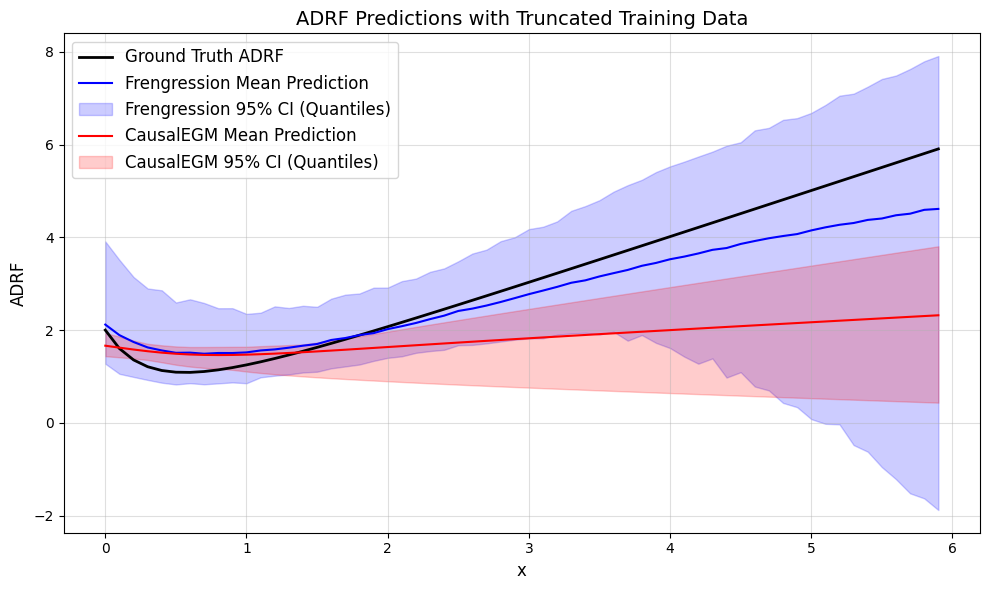

Frengression Average RMSE: 1.0552
CausalEGM Average RMSE: 1.8041


In [ ]:
params = {"dataset": "Sim_Hirano_Imbens",
"output_dir": './',
'v_dim': 200,
"z_dims": [1,1,1,7],
"x_min": 0,
"x_max": 3,
"lr": 0.0002,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

# Set up the range of x values for predictions
x_vals = np.arange(0, 6, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

# Number of repetitions
nrep = 30
n_tr = 1000
num_iters = 4000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lists to store predictions
frengression_preds = []
causalegm_preds = []

# Ground truth ADRF values
ground_truth_adrf = Sim_Hirano_Imbens_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data
    x_train, y_train, z_train = Sim_Hirano_Imbens_sampler(
        N=n_tr, v_dim=200, seed=1024 + rep, batch_size=n_tr
    ).load_all()
    
    # Convert to tensors
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)
    
    # Truncate the dataset to x in (0, 3)
    mask = (x_train > 0) & (x_train < 3)
    mask = mask.flatten()
    x_tr = x_tr[mask]
    y_tr = y_tr[mask]
    z_tr = z_tr[mask]
    
    # --- Frengression Model ---
    # Initialize and train
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=400,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model
    fr_pred = fr_model.predict_causal(
        x_tensor, target="mean", sample_size=1000
    ).detach().cpu().numpy().reshape(-1)
    frengression_preds.append(fr_pred)

    # --- CausalEGM Model ---
    # Initialize and train
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train[mask], y_train[mask], z_train[mask]], n_iter=1000, verbose=False)

    # Predict using CausalEGM model
    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    causalegm_preds.append(cegm_pred)

# Convert predictions to NumPy arrays for easier manipulation
frengression_preds = np.array(frengression_preds)
causalegm_preds = np.array(causalegm_preds)

# Compute mean and 95% CI using quantiles
fr_mean_pred = frengression_preds.mean(axis=0)
fr_ci_lower = np.quantile(frengression_preds, 0.025, axis=0)
fr_ci_upper = np.quantile(frengression_preds, 0.975, axis=0)

cegm_mean_pred = causalegm_preds.mean(axis=0)
cegm_ci_lower = np.quantile(causalegm_preds, 0.025, axis=0)
cegm_ci_upper = np.quantile(causalegm_preds, 0.975, axis=0)

# Plotting the results
plt.figure(figsize=(10, 6))

# Ground truth ADRF
plt.plot(x_vals, ground_truth_adrf, label='Ground Truth ADRF', color='black', linewidth=2)

# Frengression predictions
plt.plot(x_vals, fr_mean_pred, label='Frengression Mean Prediction', color='blue')
plt.fill_between(x_vals, fr_ci_lower, fr_ci_upper, color='blue', alpha=0.2, label='Frengression 95% CI (Quantiles)')

# CausalEGM predictions
plt.plot(x_vals, cegm_mean_pred, label='CausalEGM Mean Prediction', color='red')
plt.fill_between(x_vals, cegm_ci_lower, cegm_ci_upper, color='red', alpha=0.2, label='CausalEGM 95% CI (Quantiles)')

# Add title, labels, and legend
plt.title('ADRF Predictions with Truncated Training Data', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('ADRF', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)

# Show the plot
plt.tight_layout()
plt.show()

# Print average RMSE for both models
fr_rmses = [rmse(pred, ground_truth_adrf) for pred in frengression_preds]
cegm_rmses = [rmse(pred, ground_truth_adrf) for pred in causalegm_preds]

print(f"Frengression Average RMSE: {np.mean(fr_rmses):.4f}")
print(f"CausalEGM Average RMSE: {np.mean(cegm_rmses):.4f}")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 13.6123, loss1 14.2874, loss2 1.3501
Epoch 400: loss 10.2333, loss1 19.8790, loss2 19.2915
Epoch 800: loss 10.1477, loss1 19.9400, loss2 19.5847
Epoch 1200: loss 10.1264, loss1 20.0763, loss2 19.8998
Epoch 1600: loss 10.0913, loss1 20.0224, loss2 19.8623
Epoch 2000: loss 10.1003, loss1 20.0273, loss2 19.8539
Epoch 2400: loss 10.1143, loss1 20.0198, loss2 19.8110
Epoch 2800: loss 10.1218, loss1 20.0089, loss2 19.7742
Epoch 3200: loss 10.1110, loss1 20.0333, loss2 19.8445
Epoch 3600: loss 10.0975, loss1 20.0604, loss2 19.9258
Epoch 4000: loss 10.1311, loss1 20.0351, loss2 19.8081
Epoch 1: loss 2.7472,	loss_y 2.0016, 2.0273, 0.0514,	loss_eta 0.7456, 0.7866, 0.0820
Epoch 400: loss 1.5819,	loss_y 0.9428, 1.4499, 1.0143,	loss_eta 0.6391, 1.3108, 1.3433
Epoch 800: loss 1.5658,	loss_y 0.9013, 2.4271, 3.0515,	loss_eta 0.6645, 1.0777, 0.8265
Epoch 1200: loss 1.5061,	loss_y 0.8709, 1.7975, 1.8532,	loss_eta 0.6352, 1.1306, 0.9908
Epoch 1600: loss 1.4438,	loss_y 0.7897, 1.5640, 1.5486

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make

Epoch 1: loss 13.6202, loss1 14.3215, loss2 1.4026
Epoch 400: loss 10.2042, loss1 19.8601, loss2 19.3118
Epoch 800: loss 10.1647, loss1 19.9255, loss2 19.5218
Epoch 1200: loss 10.1562, loss1 19.9987, loss2 19.6850
Epoch 1600: loss 10.1656, loss1 19.9946, loss2 19.6579
Epoch 2000: loss 10.1770, loss1 20.0277, loss2 19.7015
Epoch 2400: loss 10.1159, loss1 20.0087, loss2 19.7856
Epoch 2800: loss 10.1313, loss1 20.0370, loss2 19.8113
Epoch 3200: loss 10.1619, loss1 20.0674, loss2 19.8110
Epoch 3600: loss 10.1039, loss1 20.0242, loss2 19.8405
Epoch 4000: loss 10.0933, loss1 20.0630, loss2 19.9394
Epoch 1: loss 2.7890,	loss_y 2.0190, 2.0377, 0.0375,	loss_eta 0.7700, 0.8114, 0.0828
Epoch 400: loss 1.5893,	loss_y 0.9839, 1.3517, 0.7355,	loss_eta 0.6054, 1.2632, 1.3156
Epoch 800: loss 1.2986,	loss_y 0.6550, 1.4436, 1.5770,	loss_eta 0.6436, 1.0291, 0.7710
Epoch 1200: loss 1.3731,	loss_y 0.8133, 1.7288, 1.8310,	loss_eta 0.5598, 1.0826, 1.0456
Epoch 1600: loss 1.4449,	loss_y 0.8624, 1.8165, 1.9082

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Ma

Epoch 1: loss 13.6277, loss1 14.3136, loss2 1.3717
Epoch 400: loss 10.2541, loss1 19.8641, loss2 19.2199
Epoch 800: loss 10.1350, loss1 19.9534, loss2 19.6366
Epoch 1200: loss 10.1373, loss1 20.0360, loss2 19.7974
Epoch 1600: loss 10.1602, loss1 20.0260, loss2 19.7315
Epoch 2000: loss 10.1522, loss1 19.9748, loss2 19.6451
Epoch 2400: loss 10.1311, loss1 20.0406, loss2 19.8190
Epoch 2800: loss 10.0994, loss1 20.0539, loss2 19.9090
Epoch 3200: loss 10.0808, loss1 20.0067, loss2 19.8518
Epoch 3600: loss 10.0957, loss1 20.0383, loss2 19.8852
Epoch 4000: loss 10.1008, loss1 20.0652, loss2 19.9288
Epoch 1: loss 2.6874,	loss_y 1.9466, 1.9577, 0.0223,	loss_eta 0.7408, 0.7810, 0.0805
Epoch 400: loss 1.6306,	loss_y 1.0499, 1.3768, 0.6538,	loss_eta 0.5807, 1.1355, 1.1096
Epoch 800: loss 1.7177,	loss_y 1.0540, 1.5890, 1.0700,	loss_eta 0.6637, 1.3742, 1.4210
Epoch 1200: loss 1.3179,	loss_y 0.7339, 1.5412, 1.6146,	loss_eta 0.5841, 1.2673, 1.3665
Epoch 1600: loss 1.2446,	loss_y 0.6271, 1.1585, 1.0629

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Ma

Epoch 1: loss 13.6607, loss1 14.3387, loss2 1.3560
Epoch 400: loss 10.2233, loss1 19.8942, loss2 19.3417
Epoch 800: loss 10.1696, loss1 20.0076, loss2 19.6760
Epoch 1200: loss 10.1625, loss1 20.0472, loss2 19.7695
Epoch 1600: loss 10.2264, loss1 20.0652, loss2 19.6776
Epoch 2000: loss 10.1388, loss1 20.0683, loss2 19.8589
Epoch 2400: loss 10.1688, loss1 20.1029, loss2 19.8682
Epoch 2800: loss 10.1665, loss1 20.0666, loss2 19.8002
Epoch 3200: loss 10.1513, loss1 20.0965, loss2 19.8904
Epoch 3600: loss 10.1502, loss1 20.1189, loss2 19.9375
Epoch 4000: loss 10.1220, loss1 20.0801, loss2 19.9162
Epoch 1: loss 2.8098,	loss_y 2.0203, 2.0370, 0.0334,	loss_eta 0.7895, 0.8278, 0.0766
Epoch 400: loss 1.5160,	loss_y 0.9126, 1.2899, 0.7546,	loss_eta 0.6034, 1.1181, 1.0293
Epoch 800: loss 1.6287,	loss_y 0.9244, 1.8136, 1.7785,	loss_eta 0.7043, 0.9002, 0.3918
Epoch 1200: loss 1.2804,	loss_y 0.7059, 1.2781, 1.1445,	loss_eta 0.5745, 1.1244, 1.0998
Epoch 1600: loss 1.4465,	loss_y 0.8374, 1.4998, 1.3248

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_12', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_13', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6101, loss1 14.2914, loss2 1.3626
Epoch 400: loss 10.2354, loss1 19.7899, loss2 19.1090
Epoch 800: loss 10.1699, loss1 19.9052, loss2 19.4707
Epoch 1200: loss 10.1057, loss1 19.9611, loss2 19.7109
Epoch 1600: loss 10.1071, loss1 19.9754, loss2 19.7364
Epoch 2000: loss 10.1307, loss1 20.0268, loss2 19.7922
Epoch 2400: loss 10.1175, loss1 20.0867, loss2 19.9383
Epoch 2800: loss 10.1299, loss1 19.9998, loss2 19.7398
Epoch 3200: loss 10.1516, loss1 20.0124, loss2 19.7215
Epoch 3600: loss 10.1495, loss1 20.0407, loss2 19.7824
Epoch 4000: loss 10.0855, loss1 20.0515, loss2 19.9319
Epoch 1: loss 2.5444,	loss_y 1.7775, 1.8027, 0.0504,	loss_eta 0.7669, 0.8111, 0.0884
Epoch 400: loss 1.6736,	loss_y 1.0618, 1.3126, 0.5015,	loss_eta 0.6118, 1.3841, 1.5445
Epoch 800: loss 1.5255,	loss_y 0.9418, 2.2948, 2.7060,	loss_eta 0.5836, 1.1556, 1.1440
Epoch 1200: loss 1.4219,	loss_y 0.7747, 1.2921, 1.0349,	loss_eta 0.6472, 1.6389, 1.9834
Epoch 1600: loss 1.4938,	loss_y 0.8246, 1.5961, 1.5430

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_16', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_17', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6720, loss1 14.3719, loss2 1.3997
Epoch 400: loss 10.3018, loss1 19.8441, loss2 19.0846
Epoch 800: loss 10.2372, loss1 20.0431, loss2 19.6118
Epoch 1200: loss 10.2483, loss1 20.0877, loss2 19.6788
Epoch 1600: loss 10.1613, loss1 20.0512, loss2 19.7798
Epoch 2000: loss 10.1016, loss1 20.0703, loss2 19.9374
Epoch 2400: loss 10.1879, loss1 20.1355, loss2 19.8953
Epoch 2800: loss 10.1527, loss1 20.1058, loss2 19.9062
Epoch 3200: loss 10.1621, loss1 20.0930, loss2 19.8617
Epoch 3600: loss 10.1431, loss1 20.0793, loss2 19.8724
Epoch 4000: loss 10.1824, loss1 20.1685, loss2 19.9722
Epoch 1: loss 2.7558,	loss_y 2.0267, 2.0425, 0.0316,	loss_eta 0.7291, 0.7692, 0.0802
Epoch 400: loss 1.7839,	loss_y 1.1099, 1.5171, 0.8144,	loss_eta 0.6740, 1.0767, 0.8053
Epoch 800: loss 1.8903,	loss_y 1.1958, 2.7991, 3.2066,	loss_eta 0.6945, 1.1232, 0.8574
Epoch 1200: loss 1.4109,	loss_y 0.7840, 1.8795, 2.1911,	loss_eta 0.6269, 0.9278, 0.6017
Epoch 1600: loss 1.3086,	loss_y 0.7213, 1.5766, 1.7105

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_20', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_21', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6231, loss1 14.3024, loss2 1.3588
Epoch 400: loss 10.2254, loss1 19.8382, loss2 19.2255
Epoch 800: loss 10.1086, loss1 19.9541, loss2 19.6911
Epoch 1200: loss 10.1556, loss1 19.9845, loss2 19.6579
Epoch 1600: loss 10.1237, loss1 19.9899, loss2 19.7324
Epoch 2000: loss 10.1176, loss1 20.0212, loss2 19.8072
Epoch 2400: loss 10.1857, loss1 20.0421, loss2 19.7129
Epoch 2800: loss 10.1358, loss1 20.0476, loss2 19.8236
Epoch 3200: loss 10.1203, loss1 20.0166, loss2 19.7926
Epoch 3600: loss 10.1609, loss1 20.0197, loss2 19.7175
Epoch 4000: loss 10.1399, loss1 20.0460, loss2 19.8121
Epoch 1: loss 2.7378,	loss_y 1.9932, 2.0161, 0.0457,	loss_eta 0.7446, 0.7866, 0.0840
Epoch 400: loss 1.7430,	loss_y 1.0813, 1.5183, 0.8739,	loss_eta 0.6617, 1.1142, 0.9050
Epoch 800: loss 1.5303,	loss_y 0.8761, 2.2531, 2.7541,	loss_eta 0.6542, 1.2998, 1.2912
Epoch 1200: loss 1.3365,	loss_y 0.7625, 1.4413, 1.3577,	loss_eta 0.5740, 1.2076, 1.2670
Epoch 1600: loss 1.3228,	loss_y 0.7113, 1.3102, 1.1978

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_24', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_25', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6459, loss1 14.3033, loss2 1.3147
Epoch 400: loss 10.1755, loss1 19.8288, loss2 19.3064
Epoch 800: loss 10.1390, loss1 19.9791, loss2 19.6804
Epoch 1200: loss 10.1338, loss1 20.0033, loss2 19.7390
Epoch 1600: loss 10.1687, loss1 19.9539, loss2 19.5703
Epoch 2000: loss 10.1435, loss1 19.9926, loss2 19.6983
Epoch 2400: loss 10.1662, loss1 20.0450, loss2 19.7577
Epoch 2800: loss 10.1393, loss1 20.0597, loss2 19.8408
Epoch 3200: loss 10.1298, loss1 20.0663, loss2 19.8732
Epoch 3600: loss 10.1147, loss1 19.9966, loss2 19.7637
Epoch 4000: loss 10.0870, loss1 20.0480, loss2 19.9220
Epoch 1: loss 2.9520,	loss_y 2.1834, 2.1985, 0.0302,	loss_eta 0.7686, 0.8061, 0.0749
Epoch 400: loss 1.8300,	loss_y 1.2000, 1.4900, 0.5800,	loss_eta 0.6300, 1.2049, 1.1499
Epoch 800: loss 1.6124,	loss_y 0.9175, 1.6216, 1.4083,	loss_eta 0.6949, 1.2062, 1.0226
Epoch 1200: loss 1.3802,	loss_y 0.7194, 1.4977, 1.5565,	loss_eta 0.6608, 1.0971, 0.8726
Epoch 1600: loss 1.2361,	loss_y 0.6741, 1.3954, 1.4426

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_28', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_29', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6933, loss1 14.3737, loss2 1.3607
Epoch 400: loss 10.2128, loss1 19.8608, loss2 19.2961
Epoch 800: loss 10.2297, loss1 20.0170, loss2 19.5745
Epoch 1200: loss 10.2447, loss1 20.0900, loss2 19.6907
Epoch 1600: loss 10.1925, loss1 20.0919, loss2 19.7988
Epoch 2000: loss 10.1683, loss1 20.1477, loss2 19.9589
Epoch 2400: loss 10.1911, loss1 20.1125, loss2 19.8428
Epoch 2800: loss 10.1709, loss1 20.0851, loss2 19.8283
Epoch 3200: loss 10.1412, loss1 20.0927, loss2 19.9030
Epoch 3600: loss 10.1575, loss1 20.0855, loss2 19.8560
Epoch 4000: loss 10.1838, loss1 20.1568, loss2 19.9461
Epoch 1: loss 2.8288,	loss_y 2.0702, 2.0831, 0.0258,	loss_eta 0.7586, 0.7980, 0.0788
Epoch 400: loss 1.8937,	loss_y 1.2420, 1.4487, 0.4135,	loss_eta 0.6517, 1.2341, 1.1648
Epoch 800: loss 1.6335,	loss_y 1.0277, 1.6968, 1.3384,	loss_eta 0.6058, 0.8949, 0.5781
Epoch 1200: loss 1.3607,	loss_y 0.7483, 1.3195, 1.1423,	loss_eta 0.6124, 1.2773, 1.3298
Epoch 1600: loss 1.4292,	loss_y 0.7899, 1.7105, 1.8411

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_32', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_33', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6542, loss1 14.3547, loss2 1.4011
Epoch 400: loss 10.2037, loss1 19.8712, loss2 19.3351
Epoch 800: loss 10.1793, loss1 20.0197, loss2 19.6808
Epoch 1200: loss 10.1569, loss1 20.0458, loss2 19.7778
Epoch 1600: loss 10.2176, loss1 20.0343, loss2 19.6333
Epoch 2000: loss 10.2055, loss1 20.0751, loss2 19.7392
Epoch 2400: loss 10.1459, loss1 20.0825, loss2 19.8732
Epoch 2800: loss 10.1805, loss1 20.1145, loss2 19.8680
Epoch 3200: loss 10.1225, loss1 20.0329, loss2 19.8208
Epoch 3600: loss 10.1835, loss1 20.0903, loss2 19.8136
Epoch 4000: loss 10.1461, loss1 20.0876, loss2 19.8829
Epoch 1: loss 2.7645,	loss_y 1.9933, 2.0052, 0.0238,	loss_eta 0.7712, 0.8102, 0.0780
Epoch 400: loss 1.4992,	loss_y 0.8898, 1.3124, 0.8451,	loss_eta 0.6094, 1.0184, 0.8180
Epoch 800: loss 1.5843,	loss_y 0.9202, 1.5261, 1.2117,	loss_eta 0.6641, 0.8923, 0.4565
Epoch 1200: loss 1.5444,	loss_y 0.8338, 2.0436, 2.4198,	loss_eta 0.7107, 1.2163, 1.0113
Epoch 1600: loss 1.3816,	loss_y 0.6947, 1.1098, 0.8302

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_36', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_37', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6714, loss1 14.3480, loss2 1.3530
Epoch 400: loss 10.2438, loss1 19.9245, loss2 19.3615
Epoch 800: loss 10.2026, loss1 20.0139, loss2 19.6225
Epoch 1200: loss 10.2150, loss1 20.0455, loss2 19.6610
Epoch 1600: loss 10.2278, loss1 20.0130, loss2 19.5705
Epoch 2000: loss 10.2112, loss1 20.0490, loss2 19.6756
Epoch 2400: loss 10.1771, loss1 20.0586, loss2 19.7630
Epoch 2800: loss 10.1768, loss1 20.1186, loss2 19.8836
Epoch 3200: loss 10.1611, loss1 20.1145, loss2 19.9067
Epoch 3600: loss 10.1611, loss1 20.0807, loss2 19.8392
Epoch 4000: loss 10.1703, loss1 20.1082, loss2 19.8758
Epoch 1: loss 2.6378,	loss_y 1.8841, 1.8998, 0.0314,	loss_eta 0.7537, 0.7948, 0.0821
Epoch 400: loss 1.7418,	loss_y 1.1366, 1.4221, 0.5710,	loss_eta 0.6052, 1.3091, 1.4076
Epoch 800: loss 1.5932,	loss_y 0.9818, 2.3788, 2.7941,	loss_eta 0.6115, 1.1208, 1.0186
Epoch 1200: loss 1.5801,	loss_y 0.9211, 2.1070, 2.3718,	loss_eta 0.6590, 1.5822, 1.8465
Epoch 1600: loss 1.2954,	loss_y 0.6826, 1.4591, 1.5531

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_40', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_41', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6145, loss1 14.3082, loss2 1.3875
Epoch 400: loss 10.2804, loss1 19.8789, loss2 19.1970
Epoch 800: loss 10.1573, loss1 19.9112, loss2 19.5078
Epoch 1200: loss 10.0512, loss1 19.9331, loss2 19.7638
Epoch 1600: loss 10.1137, loss1 19.9960, loss2 19.7647
Epoch 2000: loss 10.1384, loss1 20.0531, loss2 19.8295
Epoch 2400: loss 10.1385, loss1 20.0209, loss2 19.7648
Epoch 2800: loss 10.1416, loss1 20.0335, loss2 19.7838
Epoch 3200: loss 10.1265, loss1 19.9886, loss2 19.7243
Epoch 3600: loss 10.1067, loss1 20.0567, loss2 19.9000
Epoch 4000: loss 10.1319, loss1 20.0554, loss2 19.8471
Epoch 1: loss 2.5779,	loss_y 1.8214, 1.8298, 0.0168,	loss_eta 0.7565, 0.7962, 0.0794
Epoch 400: loss 1.4012,	loss_y 0.8107, 1.2109, 0.8005,	loss_eta 0.5906, 1.2030, 1.2250
Epoch 800: loss 1.4083,	loss_y 0.8652, 2.2295, 2.7285,	loss_eta 0.5431, 1.2138, 1.3414
Epoch 1200: loss 1.4414,	loss_y 0.7349, 1.3178, 1.1658,	loss_eta 0.7065, 0.9180, 0.4230
Epoch 1600: loss 1.4096,	loss_y 0.7330, 1.4756, 1.4852

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_44', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_45', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6316, loss1 14.3168, loss2 1.3704
Epoch 400: loss 10.1112, loss1 19.8483, loss2 19.4742
Epoch 800: loss 10.1231, loss1 19.9619, loss2 19.6775
Epoch 1200: loss 10.1554, loss1 20.0332, loss2 19.7555
Epoch 1600: loss 10.1074, loss1 20.0494, loss2 19.8839
Epoch 2000: loss 10.1147, loss1 20.0243, loss2 19.8191
Epoch 2400: loss 10.1349, loss1 20.0564, loss2 19.8431
Epoch 2800: loss 10.1209, loss1 20.0467, loss2 19.8517
Epoch 3200: loss 10.1195, loss1 20.0289, loss2 19.8187
Epoch 3600: loss 10.1508, loss1 20.0598, loss2 19.8179
Epoch 4000: loss 10.1079, loss1 20.0301, loss2 19.8445
Epoch 1: loss 2.6769,	loss_y 1.8953, 1.9287, 0.0669,	loss_eta 0.7816, 0.8191, 0.0750
Epoch 400: loss 1.6626,	loss_y 1.0315, 1.3505, 0.6379,	loss_eta 0.6312, 0.9266, 0.5908
Epoch 800: loss 1.2756,	loss_y 0.6601, 1.5835, 1.8469,	loss_eta 0.6155, 0.9205, 0.6101
Epoch 1200: loss 1.4245,	loss_y 0.8150, 1.5909, 1.5519,	loss_eta 0.6096, 1.1971, 1.1750
Epoch 1600: loss 1.2560,	loss_y 0.6695, 1.5143, 1.6896

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_48', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_49', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.5918, loss1 14.2898, loss2 1.3960
Epoch 400: loss 10.1708, loss1 19.8208, loss2 19.3000
Epoch 800: loss 10.1549, loss1 19.9168, loss2 19.5238
Epoch 1200: loss 10.0878, loss1 19.9848, loss2 19.7940
Epoch 1600: loss 10.1312, loss1 19.9877, loss2 19.7131
Epoch 2000: loss 10.0875, loss1 20.0245, loss2 19.8740
Epoch 2400: loss 10.1451, loss1 20.0302, loss2 19.7701
Epoch 2800: loss 10.1011, loss1 20.0231, loss2 19.8439
Epoch 3200: loss 10.1191, loss1 20.0127, loss2 19.7872
Epoch 3600: loss 10.1068, loss1 20.0141, loss2 19.8145
Epoch 4000: loss 10.0798, loss1 20.0061, loss2 19.8527
Epoch 1: loss 2.7238,	loss_y 1.9776, 1.9967, 0.0383,	loss_eta 0.7462, 0.7815, 0.0706
Epoch 400: loss 1.6982,	loss_y 1.1320, 1.3473, 0.4306,	loss_eta 0.5662, 1.3899, 1.6474
Epoch 800: loss 1.2788,	loss_y 0.6660, 1.4868, 1.6415,	loss_eta 0.6128, 1.1890, 1.1523
Epoch 1200: loss 1.4255,	loss_y 0.7590, 1.5849, 1.6519,	loss_eta 0.6666, 1.8427, 2.3524
Epoch 1600: loss 1.2976,	loss_y 0.7052, 1.4332, 1.4559

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_52', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_53', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6165, loss1 14.2871, loss2 1.3410
Epoch 400: loss 10.2248, loss1 19.8790, loss2 19.3084
Epoch 800: loss 10.1121, loss1 19.9417, loss2 19.6592
Epoch 1200: loss 10.1289, loss1 19.9898, loss2 19.7218
Epoch 1600: loss 10.1088, loss1 19.9355, loss2 19.6534
Epoch 2000: loss 10.1616, loss1 19.9615, loss2 19.5999
Epoch 2400: loss 10.1119, loss1 19.9849, loss2 19.7460
Epoch 2800: loss 10.1029, loss1 20.0200, loss2 19.8340
Epoch 3200: loss 10.1760, loss1 20.0547, loss2 19.7575
Epoch 3600: loss 10.1037, loss1 19.9958, loss2 19.7842
Epoch 4000: loss 10.0826, loss1 20.0046, loss2 19.8440
Epoch 1: loss 2.7485,	loss_y 1.9769, 1.9931, 0.0325,	loss_eta 0.7716, 0.8085, 0.0738
Epoch 400: loss 1.8339,	loss_y 1.0949, 1.4327, 0.6756,	loss_eta 0.7391, 0.7956, 0.1131
Epoch 800: loss 1.3868,	loss_y 0.7745, 1.4679, 1.3867,	loss_eta 0.6123, 0.9357, 0.6469
Epoch 1200: loss 1.4225,	loss_y 0.6945, 1.9875, 2.5860,	loss_eta 0.7280, 1.3014, 1.1469
Epoch 1600: loss 1.2512,	loss_y 0.5732, 1.1199, 1.0934

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_56', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_57', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.5700, loss1 14.2642, loss2 1.3883
Epoch 400: loss 10.1664, loss1 19.7589, loss2 19.1850
Epoch 800: loss 10.1638, loss1 19.9100, loss2 19.4925
Epoch 1200: loss 10.1177, loss1 19.9300, loss2 19.6247
Epoch 1600: loss 10.1332, loss1 19.9348, loss2 19.6033
Epoch 2000: loss 10.0925, loss1 20.0201, loss2 19.8553
Epoch 2400: loss 10.0968, loss1 19.9927, loss2 19.7918
Epoch 2800: loss 10.1280, loss1 20.0120, loss2 19.7680
Epoch 3200: loss 10.0690, loss1 20.0147, loss2 19.8913
Epoch 3600: loss 10.0592, loss1 20.0063, loss2 19.8944
Epoch 4000: loss 10.0772, loss1 20.0179, loss2 19.8815
Epoch 1: loss 2.5952,	loss_y 1.8208, 1.8382, 0.0348,	loss_eta 0.7744, 0.8150, 0.0812
Epoch 400: loss 1.6005,	loss_y 1.0048, 1.2311, 0.4526,	loss_eta 0.5957, 1.3002, 1.4090
Epoch 800: loss 1.3683,	loss_y 0.7228, 1.2672, 1.0889,	loss_eta 0.6455, 1.0663, 0.8415
Epoch 1200: loss 1.2774,	loss_y 0.6966, 1.5148, 1.6364,	loss_eta 0.5808, 1.0630, 0.9644
Epoch 1600: loss 1.3201,	loss_y 0.7352, 1.9186, 2.3669

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_60', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_61', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6538, loss1 14.3416, loss2 1.3756
Epoch 400: loss 10.2858, loss1 19.9603, loss2 19.3490
Epoch 800: loss 10.1990, loss1 19.9794, loss2 19.5608
Epoch 1200: loss 10.1629, loss1 19.9812, loss2 19.6365
Epoch 1600: loss 10.1658, loss1 20.0304, loss2 19.7291
Epoch 2000: loss 10.1339, loss1 20.0459, loss2 19.8240
Epoch 2400: loss 10.1748, loss1 20.1091, loss2 19.8685
Epoch 2800: loss 10.1337, loss1 20.0408, loss2 19.8141
Epoch 3200: loss 10.1825, loss1 20.0915, loss2 19.8180
Epoch 3600: loss 10.1851, loss1 20.0953, loss2 19.8203
Epoch 4000: loss 10.1702, loss1 20.0422, loss2 19.7441
Epoch 1: loss 2.9311,	loss_y 2.1690, 2.1947, 0.0513,	loss_eta 0.7621, 0.8000, 0.0759
Epoch 400: loss 1.8071,	loss_y 1.1681, 1.3709, 0.4056,	loss_eta 0.6390, 0.9565, 0.6351
Epoch 800: loss 1.3377,	loss_y 0.7070, 1.6140, 1.8138,	loss_eta 0.6307, 1.2756, 1.2899
Epoch 1200: loss 1.3168,	loss_y 0.7590, 1.6079, 1.6979,	loss_eta 0.5578, 1.1569, 1.1982
Epoch 1600: loss 1.2924,	loss_y 0.6670, 1.2248, 1.1157

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_64', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_65', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6116, loss1 14.2838, loss2 1.3444
Epoch 400: loss 10.2451, loss1 19.8345, loss2 19.1787
Epoch 800: loss 10.1749, loss1 19.9364, loss2 19.5231
Epoch 1200: loss 10.1186, loss1 19.9862, loss2 19.7353
Epoch 1600: loss 10.1503, loss1 20.0048, loss2 19.7090
Epoch 2000: loss 10.1357, loss1 19.9997, loss2 19.7281
Epoch 2400: loss 10.1343, loss1 20.0165, loss2 19.7645
Epoch 2800: loss 10.1427, loss1 20.0382, loss2 19.7909
Epoch 3200: loss 10.1109, loss1 20.0473, loss2 19.8730
Epoch 3600: loss 10.1142, loss1 20.0518, loss2 19.8753
Epoch 4000: loss 10.1318, loss1 20.0838, loss2 19.9039
Epoch 1: loss 2.7182,	loss_y 1.9689, 1.9795, 0.0211,	loss_eta 0.7493, 0.7860, 0.0735
Epoch 400: loss 1.5725,	loss_y 0.9863, 1.3121, 0.6516,	loss_eta 0.5862, 1.2157, 1.2591
Epoch 800: loss 1.5642,	loss_y 1.0027, 2.6043, 3.2032,	loss_eta 0.5615, 0.9577, 0.7924
Epoch 1200: loss 1.5222,	loss_y 0.9505, 1.3915, 0.8820,	loss_eta 0.5717, 1.0853, 1.0272
Epoch 1600: loss 1.3274,	loss_y 0.7362, 1.3296, 1.1867

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_68', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_69', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.7246, loss1 14.4093, loss2 1.3695
Epoch 400: loss 10.2629, loss1 19.9911, loss2 19.4563
Epoch 800: loss 10.2297, loss1 20.0711, loss2 19.6829
Epoch 1200: loss 10.2347, loss1 20.0507, loss2 19.6320
Epoch 1600: loss 10.2449, loss1 20.1788, loss2 19.8678
Epoch 2000: loss 10.2377, loss1 20.1532, loss2 19.8310
Epoch 2400: loss 10.1773, loss1 20.1116, loss2 19.8687
Epoch 2800: loss 10.2012, loss1 20.1525, loss2 19.9026
Epoch 3200: loss 10.1973, loss1 20.1507, loss2 19.9069
Epoch 3600: loss 10.2092, loss1 20.1692, loss2 19.9200
Epoch 4000: loss 10.2036, loss1 20.1797, loss2 19.9522
Epoch 1: loss 2.9073,	loss_y 2.1499, 2.1697, 0.0396,	loss_eta 0.7573, 0.7972, 0.0796
Epoch 400: loss 1.8091,	loss_y 1.1631, 1.4987, 0.6711,	loss_eta 0.6460, 1.1604, 1.0288
Epoch 800: loss 1.5391,	loss_y 0.8360, 1.4955, 1.3190,	loss_eta 0.7030, 1.3345, 1.2629
Epoch 1200: loss 1.4017,	loss_y 0.8252, 1.7534, 1.8563,	loss_eta 0.5765, 0.9604, 0.7678
Epoch 1600: loss 1.3246,	loss_y 0.7473, 1.1128, 0.7311

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_72', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_73', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6040, loss1 14.2750, loss2 1.3420
Epoch 400: loss 10.1795, loss1 19.7252, loss2 19.0915
Epoch 800: loss 10.1918, loss1 19.9495, loss2 19.5155
Epoch 1200: loss 10.0886, loss1 20.0058, loss2 19.8344
Epoch 1600: loss 10.1156, loss1 20.0038, loss2 19.7763
Epoch 2000: loss 10.1140, loss1 19.9507, loss2 19.6734
Epoch 2400: loss 10.1052, loss1 20.0128, loss2 19.8152
Epoch 2800: loss 10.0691, loss1 19.9643, loss2 19.7904
Epoch 3200: loss 10.0626, loss1 20.0163, loss2 19.9075
Epoch 3600: loss 10.0984, loss1 20.0033, loss2 19.8098
Epoch 4000: loss 10.0662, loss1 20.0396, loss2 19.9468
Epoch 1: loss 2.5717,	loss_y 1.8004, 1.8352, 0.0697,	loss_eta 0.7713, 0.8072, 0.0717
Epoch 400: loss 1.7116,	loss_y 0.9854, 1.4199, 0.8691,	loss_eta 0.7262, 0.8077, 0.1631
Epoch 800: loss 1.4494,	loss_y 0.8275, 1.0729, 0.4909,	loss_eta 0.6219, 1.0789, 0.9141
Epoch 1200: loss 1.4178,	loss_y 0.8136, 2.0207, 2.4141,	loss_eta 0.6042, 0.9023, 0.5962
Epoch 1600: loss 1.3117,	loss_y 0.7319, 1.6079, 1.7519

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_76', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_77', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6119, loss1 14.2980, loss2 1.3721
Epoch 400: loss 10.1988, loss1 19.8634, loss2 19.3293
Epoch 800: loss 10.1421, loss1 19.9471, loss2 19.6099
Epoch 1200: loss 10.1333, loss1 19.9996, loss2 19.7327
Epoch 1600: loss 10.1225, loss1 19.9976, loss2 19.7502
Epoch 2000: loss 10.1720, loss1 20.0481, loss2 19.7522
Epoch 2400: loss 10.1133, loss1 20.0185, loss2 19.8104
Epoch 2800: loss 10.1008, loss1 19.9855, loss2 19.7695
Epoch 3200: loss 10.1017, loss1 20.0216, loss2 19.8399
Epoch 3600: loss 10.1523, loss1 20.0462, loss2 19.7877
Epoch 4000: loss 10.1027, loss1 20.0465, loss2 19.8875
Epoch 1: loss 2.6103,	loss_y 1.8668, 1.8938, 0.0540,	loss_eta 0.7435, 0.7847, 0.0823
Epoch 400: loss 1.6329,	loss_y 0.9923, 1.4144, 0.8441,	loss_eta 0.6405, 1.2762, 1.2714
Epoch 800: loss 1.4710,	loss_y 0.8586, 2.0325, 2.3478,	loss_eta 0.6123, 1.5540, 1.8834
Epoch 1200: loss 1.4444,	loss_y 0.8396, 2.0667, 2.4542,	loss_eta 0.6047, 1.2014, 1.1933
Epoch 1600: loss 1.3456,	loss_y 0.7217, 1.4410, 1.4385

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_80', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_81', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6233, loss1 14.3009, loss2 1.3553
Epoch 400: loss 10.2143, loss1 19.7772, loss2 19.1257
Epoch 800: loss 10.1771, loss1 19.9894, loss2 19.6245
Epoch 1200: loss 10.0967, loss1 19.9656, loss2 19.7377
Epoch 1600: loss 10.1262, loss1 19.9691, loss2 19.6857
Epoch 2000: loss 10.1341, loss1 19.9856, loss2 19.7030
Epoch 2400: loss 10.1301, loss1 20.0451, loss2 19.8301
Epoch 2800: loss 10.1155, loss1 20.0735, loss2 19.9159
Epoch 3200: loss 10.1596, loss1 20.0392, loss2 19.7593
Epoch 3600: loss 10.1228, loss1 20.0295, loss2 19.8134
Epoch 4000: loss 10.1372, loss1 20.0197, loss2 19.7651
Epoch 1: loss 2.5723,	loss_y 1.8182, 1.8374, 0.0384,	loss_eta 0.7542, 0.7931, 0.0779
Epoch 400: loss 1.6202,	loss_y 1.0069, 1.3632, 0.7128,	loss_eta 0.6134, 1.3786, 1.5304
Epoch 800: loss 1.4229,	loss_y 0.8233, 1.8577, 2.0687,	loss_eta 0.5996, 1.1903, 1.1813
Epoch 1200: loss 1.2739,	loss_y 0.6856, 1.0712, 0.7712,	loss_eta 0.5883, 1.4919, 1.8071
Epoch 1600: loss 1.2255,	loss_y 0.6256, 1.2853, 1.3193

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_84', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_85', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6783, loss1 14.3671, loss2 1.3775
Epoch 400: loss 10.2347, loss1 19.8865, loss2 19.3037
Epoch 800: loss 10.2103, loss1 20.0742, loss2 19.7278
Epoch 1200: loss 10.1663, loss1 20.0954, loss2 19.8581
Epoch 1600: loss 10.0922, loss1 20.1165, loss2 20.0486
Epoch 2000: loss 10.1540, loss1 20.0830, loss2 19.8580
Epoch 2400: loss 10.1918, loss1 20.2063, loss2 20.0290
Epoch 2800: loss 10.1629, loss1 20.1519, loss2 19.9780
Epoch 3200: loss 10.1501, loss1 20.1299, loss2 19.9595
Epoch 3600: loss 10.1836, loss1 20.1281, loss2 19.8889
Epoch 4000: loss 10.1573, loss1 20.1445, loss2 19.9743
Epoch 1: loss 2.9328,	loss_y 2.1720, 2.1888, 0.0335,	loss_eta 0.7608, 0.7997, 0.0778
Epoch 400: loss 1.8201,	loss_y 1.1129, 1.5067, 0.7877,	loss_eta 0.7072, 1.1455, 0.8765
Epoch 800: loss 1.4598,	loss_y 0.8610, 1.4908, 1.2596,	loss_eta 0.5989, 1.0900, 0.9823
Epoch 1200: loss 1.5876,	loss_y 0.9973, 1.8093, 1.6240,	loss_eta 0.5903, 0.9029, 0.6252
Epoch 1600: loss 1.4072,	loss_y 0.8130, 1.4088, 1.1915

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_88', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_89', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.6764, loss1 14.3603, loss2 1.3677
Epoch 400: loss 10.2700, loss1 19.9267, loss2 19.3134
Epoch 800: loss 10.2221, loss1 20.0894, loss2 19.7346
Epoch 1200: loss 10.2103, loss1 20.1209, loss2 19.8212
Epoch 1600: loss 10.2028, loss1 20.1216, loss2 19.8375
Epoch 2000: loss 10.2307, loss1 20.0816, loss2 19.7019
Epoch 2400: loss 10.2210, loss1 20.1141, loss2 19.7862
Epoch 2800: loss 10.1325, loss1 20.1008, loss2 19.9366
Epoch 3200: loss 10.1670, loss1 20.0715, loss2 19.8090
Epoch 3600: loss 10.1769, loss1 20.1079, loss2 19.8619
Epoch 4000: loss 10.1848, loss1 20.1614, loss2 19.9533
Epoch 1: loss 2.6552,	loss_y 1.8955, 1.9050, 0.0191,	loss_eta 0.7597, 0.7979, 0.0764
Epoch 400: loss 1.6303,	loss_y 1.0733, 1.3261, 0.5056,	loss_eta 0.5570, 1.3391, 1.5643
Epoch 800: loss 1.4985,	loss_y 0.7576, 1.6709, 1.8265,	loss_eta 0.7409, 0.8264, 0.1711
Epoch 1200: loss 1.3114,	loss_y 0.7224, 1.5534, 1.6621,	loss_eta 0.5891, 1.1926, 1.2071
Epoch 1600: loss 1.2217,	loss_y 0.6351, 1.1433, 1.0164

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_92', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_93', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.7255, loss1 14.4166, loss2 1.3822
Epoch 400: loss 10.2829, loss1 20.0397, loss2 19.5136
Epoch 800: loss 10.3118, loss1 20.0004, loss2 19.3772
Epoch 1200: loss 10.2198, loss1 20.0524, loss2 19.6651
Epoch 1600: loss 10.1903, loss1 20.0897, loss2 19.7989
Epoch 2000: loss 10.2594, loss1 20.1109, loss2 19.7031
Epoch 2400: loss 10.1901, loss1 20.1493, loss2 19.9183
Epoch 2800: loss 10.2203, loss1 20.1288, loss2 19.8169
Epoch 3200: loss 10.2126, loss1 20.1690, loss2 19.9127
Epoch 3600: loss 10.1791, loss1 20.1628, loss2 19.9674
Epoch 4000: loss 10.1686, loss1 20.1548, loss2 19.9725
Epoch 1: loss 2.9030,	loss_y 2.1499, 2.1672, 0.0346,	loss_eta 0.7531, 0.7942, 0.0821
Epoch 400: loss 1.8230,	loss_y 1.1668, 1.4656, 0.5976,	loss_eta 0.6562, 0.8299, 0.3475
Epoch 800: loss 1.4236,	loss_y 0.7771, 1.6105, 1.6670,	loss_eta 0.6465, 1.5165, 1.7400
Epoch 1200: loss 1.3773,	loss_y 0.7962, 1.3661, 1.1398,	loss_eta 0.5811, 1.2495, 1.3368
Epoch 1600: loss 1.3289,	loss_y 0.6896, 1.5608, 1.7423

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_96', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_97', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. 

Epoch 1: loss 13.5554, loss1 14.2561, loss2 1.4014
Epoch 400: loss 10.1297, loss1 19.6907, loss2 19.1219
Epoch 800: loss 10.1226, loss1 19.9063, loss2 19.5673
Epoch 1200: loss 10.1171, loss1 19.9375, loss2 19.6408
Epoch 1600: loss 10.0500, loss1 19.9300, loss2 19.7599
Epoch 2000: loss 10.0702, loss1 20.0207, loss2 19.9011
Epoch 2400: loss 10.0521, loss1 19.9620, loss2 19.8197
Epoch 2800: loss 10.0586, loss1 19.9828, loss2 19.8483
Epoch 3200: loss 10.1105, loss1 19.9769, loss2 19.7327
Epoch 3600: loss 10.0433, loss1 19.9808, loss2 19.8750
Epoch 4000: loss 10.0976, loss1 19.9667, loss2 19.7383
Epoch 1: loss 2.5709,	loss_y 1.8284, 1.8429, 0.0291,	loss_eta 0.7425, 0.7823, 0.0796
Epoch 400: loss 1.4814,	loss_y 0.8509, 1.4069, 1.1120,	loss_eta 0.6304, 1.2011, 1.1414
Epoch 800: loss 1.5179,	loss_y 0.8175, 1.2169, 0.7988,	loss_eta 0.7003, 1.1828, 0.9650
Epoch 1200: loss 1.4103,	loss_y 0.7318, 1.3971, 1.3305,	loss_eta 0.6785, 1.1190, 0.8809
Epoch 1600: loss 1.5532,	loss_y 0.8073, 1.2900, 0.9655

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_100', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_101', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6603, loss1 14.3437, loss2 1.3667
Epoch 400: loss 10.2097, loss1 19.8398, loss2 19.2604
Epoch 800: loss 10.2410, loss1 19.9795, loss2 19.4770
Epoch 1200: loss 10.2121, loss1 20.0867, loss2 19.7491
Epoch 1600: loss 10.0927, loss1 20.0147, loss2 19.8440
Epoch 2000: loss 10.1967, loss1 20.1128, loss2 19.8323
Epoch 2400: loss 10.1434, loss1 20.0989, loss2 19.9108
Epoch 2800: loss 10.1886, loss1 20.0839, loss2 19.7906
Epoch 3200: loss 10.1446, loss1 20.0961, loss2 19.9030
Epoch 3600: loss 10.1511, loss1 20.0951, loss2 19.8879
Epoch 4000: loss 10.1516, loss1 20.1511, loss2 19.9992
Epoch 1: loss 2.6355,	loss_y 1.8826, 1.9168, 0.0683,	loss_eta 0.7529, 0.7932, 0.0808
Epoch 400: loss 1.5960,	loss_y 0.9898, 1.3079, 0.6361,	loss_eta 0.6062, 1.1741, 1.1358
Epoch 800: loss 1.6897,	loss_y 1.0845, 3.0662, 3.9634,	loss_eta 0.6052, 1.1699, 1.1293
Epoch 1200: loss 1.3633,	loss_y 0.7334, 1.6093, 1.7519,	loss_eta 0.6300, 1.0359, 0.8118
Epoch 1600: loss 1.2989,	loss_y 0.7215, 1.4981, 1.5531

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_104', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_105', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.8327, loss1 14.5137, loss2 1.3620
Epoch 400: loss 10.3765, loss1 20.0834, loss2 19.4137
Epoch 800: loss 10.3688, loss1 20.1773, loss2 19.6170
Epoch 1200: loss 10.3803, loss1 20.2271, loss2 19.6936
Epoch 1600: loss 10.3349, loss1 20.2552, loss2 19.8404
Epoch 2000: loss 10.3752, loss1 20.2719, loss2 19.7934
Epoch 2400: loss 10.3695, loss1 20.2466, loss2 19.7541
Epoch 2800: loss 10.2769, loss1 20.2289, loss2 19.9040
Epoch 3200: loss 10.2835, loss1 20.2346, loss2 19.9022
Epoch 3600: loss 10.3305, loss1 20.2825, loss2 19.9040
Epoch 4000: loss 10.2725, loss1 20.1945, loss2 19.8439
Epoch 1: loss 2.9637,	loss_y 2.1838, 2.1909, 0.0144,	loss_eta 0.7799, 0.8153, 0.0707
Epoch 400: loss 1.8218,	loss_y 1.1798, 1.4707, 0.5818,	loss_eta 0.6421, 1.4576, 1.6310
Epoch 800: loss 1.6699,	loss_y 0.9697, 2.2856, 2.6318,	loss_eta 0.7003, 0.8384, 0.2763
Epoch 1200: loss 1.5990,	loss_y 0.9928, 1.7294, 1.4733,	loss_eta 0.6062, 1.0515, 0.8905
Epoch 1600: loss 1.4216,	loss_y 0.8579, 1.3463, 0.9768

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_108', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_109', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5899, loss1 14.2876, loss2 1.3955
Epoch 400: loss 10.1554, loss1 19.8156, loss2 19.3204
Epoch 800: loss 10.1326, loss1 19.8719, loss2 19.4786
Epoch 1200: loss 10.1370, loss1 19.9413, loss2 19.6085
Epoch 1600: loss 10.0935, loss1 19.9905, loss2 19.7940
Epoch 2000: loss 10.1139, loss1 20.0067, loss2 19.7858
Epoch 2400: loss 10.1823, loss1 20.0559, loss2 19.7472
Epoch 2800: loss 10.1160, loss1 20.0124, loss2 19.7926
Epoch 3200: loss 10.1080, loss1 20.0088, loss2 19.8017
Epoch 3600: loss 10.0504, loss1 20.0635, loss2 20.0262
Epoch 4000: loss 10.1482, loss1 20.0548, loss2 19.8130
Epoch 1: loss 2.7399,	loss_y 1.9914, 2.0125, 0.0422,	loss_eta 0.7485, 0.7863, 0.0755
Epoch 400: loss 1.6128,	loss_y 0.9847, 1.3663, 0.7632,	loss_eta 0.6281, 1.1307, 1.0054
Epoch 800: loss 1.7201,	loss_y 1.0018, 1.2879, 0.5722,	loss_eta 0.7183, 1.0067, 0.5767
Epoch 1200: loss 1.3015,	loss_y 0.7094, 1.5381, 1.6575,	loss_eta 0.5921, 1.2984, 1.4125
Epoch 1600: loss 1.2168,	loss_y 0.6695, 1.2571, 1.1752

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_112', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_113', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6274, loss1 14.3104, loss2 1.3660
Epoch 400: loss 10.1992, loss1 19.9167, loss2 19.4350
Epoch 800: loss 10.1674, loss1 19.9308, loss2 19.5268
Epoch 1200: loss 10.1475, loss1 20.0201, loss2 19.7453
Epoch 1600: loss 10.1638, loss1 20.0617, loss2 19.7958
Epoch 2000: loss 10.1111, loss1 19.9771, loss2 19.7319
Epoch 2400: loss 10.1249, loss1 20.0162, loss2 19.7825
Epoch 2800: loss 10.1211, loss1 20.0613, loss2 19.8806
Epoch 3200: loss 10.1217, loss1 20.0699, loss2 19.8963
Epoch 3600: loss 10.1055, loss1 20.0572, loss2 19.9034
Epoch 4000: loss 10.1385, loss1 20.0700, loss2 19.8631
Epoch 1: loss 2.5501,	loss_y 1.7864, 1.8132, 0.0535,	loss_eta 0.7637, 0.8004, 0.0734
Epoch 400: loss 1.6081,	loss_y 0.9052, 1.4035, 0.9965,	loss_eta 0.7028, 1.9587, 2.5117
Epoch 800: loss 1.4092,	loss_y 0.7442, 1.6404, 1.7924,	loss_eta 0.6650, 1.2980, 1.2660
Epoch 1200: loss 1.5702,	loss_y 0.8766, 1.1608, 0.5683,	loss_eta 0.6936, 0.8415, 0.2958
Epoch 1600: loss 1.4370,	loss_y 0.7845, 2.0435, 2.5181

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_116', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_117', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

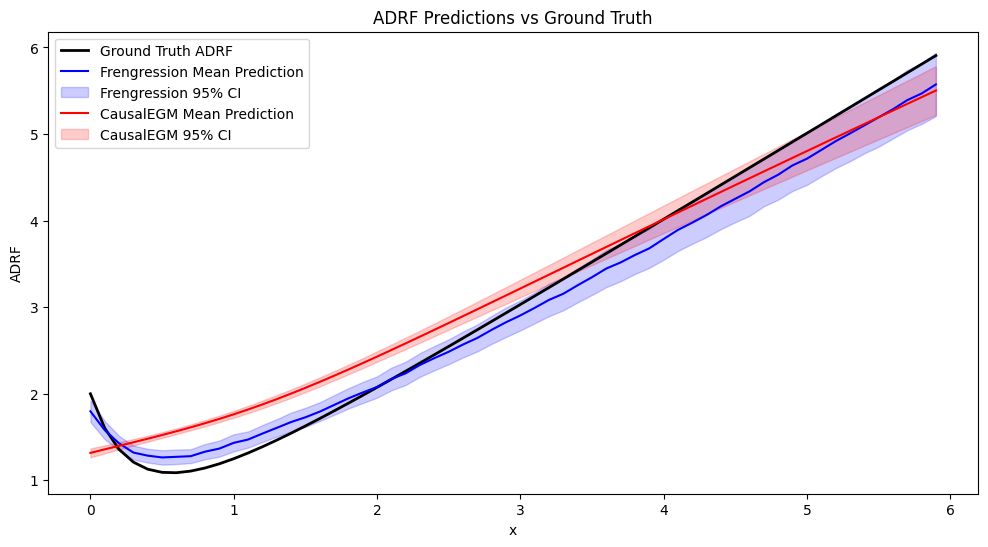

Frengression Average RMSE over 30 reps: 0.5354
Frengression Average MAPE over 30 reps: 0.1519
CausalEGM Average RMSE over 30 reps: 0.4368
CausalEGM Average MAPE over 30 reps: 0.1644


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm


params = {"dataset": "Sim_Hirano_Imbens",
"output_dir": './',
'v_dim': 200,
"z_dims": [1,1,1,1],
"x_min": 0,
"x_max": 3,
"lr": 0.0001,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

# Set up the range of x values
x_vals = np.arange(0, 6, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

# Number of repetitions
nrep = 30
n_tr = 2000
n_p = 1000
num_iters = 4000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lists to store predictions and error metrics
frengression_preds = []
causalegm_preds = []
frengression_rmses = []
frengression_mapes = []
causalegm_rmses = []
causalegm_mapes = []

# Ground truth ADRF values
ground_truth_adrf = Sim_Hirano_Imbens_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data
    x_train, y_train, z_train = Sim_Hirano_Imbens_sampler(
        N=n_tr, v_dim=200, seed=1024 + rep, batch_size=n_tr
    ).load_all()
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)

    # Initialize and train Frengression model
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=400,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model
    fr_pred = fr_model.predict_causal(
        x_tensor, target="mean", sample_size=1000
    ).detach().cpu().numpy().reshape(-1)
    frengression_preds.append(fr_pred)

    # Compute RMSE and MAPE for Frengression model
    fr_rmse = rmse(fr_pred, ground_truth_adrf)
    fr_mape = mape(fr_pred, ground_truth_adrf)
    frengression_rmses.append(fr_rmse)
    frengression_mapes.append(fr_mape)

    # Initialize and train CausalEGM model
    # Assuming CausalEGM requires similar data inputs
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train, y_train, z_train], n_iter=1000, verbose=False)

    # Predict using CausalEGM model
    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    causalegm_preds.append(cegm_pred)

    # Compute RMSE and MAPE for CausalEGM model
    cegm_rmse = rmse(cegm_pred, ground_truth_adrf)
    cegm_mape = mape(cegm_pred, ground_truth_adrf)
    causalegm_rmses.append(cegm_rmse)
    causalegm_mapes.append(cegm_mape)

# Convert prediction lists to NumPy arrays for easier manipulation
frengression_preds = np.array(frengression_preds)
causalegm_preds = np.array(causalegm_preds)

# Compute mean and 95% confidence intervals
fr_mean_pred = frengression_preds.mean(axis=0)
fr_std_pred = frengression_preds.std(axis=0)
fr_ci_upper = fr_mean_pred + 1.96 * fr_std_pred / np.sqrt(nrep)
fr_ci_lower = fr_mean_pred - 1.96 * fr_std_pred / np.sqrt(nrep)

cegm_mean_pred = causalegm_preds.mean(axis=0)
cegm_std_pred = causalegm_preds.std(axis=0)
cegm_ci_upper = cegm_mean_pred + 1.96 * cegm_std_pred / np.sqrt(nrep)
cegm_ci_lower = cegm_mean_pred - 1.96 * cegm_std_pred / np.sqrt(nrep)

# Plotting the results
plt.figure(figsize=(12, 6))

# Ground truth ADRF
plt.plot(x_vals, ground_truth_adrf, label='Ground Truth ADRF', color='black', linewidth=2)

# Frengression predictions
plt.plot(x_vals, fr_mean_pred, label='Frengression Mean Prediction', color='blue')
plt.fill_between(x_vals, fr_ci_lower, fr_ci_upper, color='blue', alpha=0.2, label='Frengression 95% CI')

# CausalEGM predictions
plt.plot(x_vals, cegm_mean_pred, label='CausalEGM Mean Prediction', color='red')
plt.fill_between(x_vals, cegm_ci_lower, cegm_ci_upper, color='red', alpha=0.2, label='CausalEGM 95% CI')

plt.xlabel('x')
plt.ylabel('ADRF')
plt.title('ADRF Predictions vs Ground Truth')
plt.legend()
plt.show()

# Print average RMSE and MAPE for both models
print(f"Frengression Average RMSE over {nrep} reps: {np.mean(frengression_rmses):.4f}")
print(f"Frengression Average MAPE over {nrep} reps: {np.mean(frengression_mapes):.4f}")

print(f"CausalEGM Average RMSE over {nrep} reps: {np.mean(causalegm_rmses):.4f}")
print(f"CausalEGM Average MAPE over {nrep} reps: {np.mean(causalegm_mapes):.4f}")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 13.6074, loss1 14.3058, loss2 1.3967
Epoch 400: loss 10.2367, loss1 19.7994, loss2 19.1253
Epoch 800: loss 10.1488, loss1 19.9615, loss2 19.6254
Epoch 1200: loss 10.1158, loss1 19.9677, loss2 19.7038
Epoch 1600: loss 10.0636, loss1 19.9767, loss2 19.8263
Epoch 2000: loss 10.1144, loss1 19.9752, loss2 19.7216
Epoch 2400: loss 10.1420, loss1 20.0221, loss2 19.7601
Epoch 2800: loss 10.0347, loss1 20.0220, loss2 19.9746
Epoch 3200: loss 10.1124, loss1 20.0152, loss2 19.8055
Epoch 3600: loss 10.1187, loss1 20.0425, loss2 19.8475
Epoch 4000: loss 10.0499, loss1 20.0038, loss2 19.9078
Epoch 1: loss 2.8821,	loss_y 2.1004, 2.1145, 0.0281,	loss_eta 0.7817, 0.8221, 0.0808
Epoch 400: loss 1.8592,	loss_y 1.0592, 1.3331, 0.5477,	loss_eta 0.7999, 0.8093, 0.0186
Epoch 800: loss 1.5681,	loss_y 0.8528, 1.4514, 1.1970,	loss_eta 0.7153, 1.0921, 0.7537
Epoch 1200: loss 1.4670,	loss_y 0.7222, 1.2599, 1.0754,	loss_eta 0.7447, 0.8583, 0.2271
Epoch 1600: loss 1.3750,	loss_y 0.6824, 1.5779, 1.7911

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_240', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_241', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6344, loss1 14.3302, loss2 1.3915
Epoch 400: loss 10.2748, loss1 19.8393, loss2 19.1290
Epoch 800: loss 10.1918, loss1 19.9691, loss2 19.5546
Epoch 1200: loss 10.1097, loss1 19.9451, loss2 19.6708
Epoch 1600: loss 10.1328, loss1 20.0122, loss2 19.7588
Epoch 2000: loss 10.1463, loss1 19.9965, loss2 19.7003
Epoch 2400: loss 10.1736, loss1 20.0575, loss2 19.7677
Epoch 2800: loss 10.1026, loss1 20.0245, loss2 19.8439
Epoch 3200: loss 10.1289, loss1 20.0636, loss2 19.8695
Epoch 3600: loss 10.0873, loss1 20.1013, loss2 20.0278
Epoch 4000: loss 10.0816, loss1 20.0879, loss2 20.0127
Epoch 1: loss 2.9291,	loss_y 2.1562, 2.1793, 0.0461,	loss_eta 0.7728, 0.8131, 0.0805
Epoch 400: loss 1.6262,	loss_y 1.0057, 1.3842, 0.7570,	loss_eta 0.6205, 1.1716, 1.1021
Epoch 800: loss 1.4647,	loss_y 0.7300, 1.5500, 1.6401,	loss_eta 0.7347, 1.2316, 0.9939
Epoch 1200: loss 1.4764,	loss_y 0.8934, 1.6962, 1.6055,	loss_eta 0.5829, 1.3768, 1.5877
Epoch 1600: loss 1.4361,	loss_y 0.6966, 1.1177, 0.8422

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_244', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_245', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6290, loss1 14.3257, loss2 1.3933
Epoch 400: loss 10.1744, loss1 19.8320, loss2 19.3152
Epoch 800: loss 10.1529, loss1 20.0216, loss2 19.7373
Epoch 1200: loss 10.1533, loss1 19.9709, loss2 19.6352
Epoch 1600: loss 10.1451, loss1 20.0316, loss2 19.7731
Epoch 2000: loss 10.1338, loss1 20.0267, loss2 19.7860
Epoch 2400: loss 10.1681, loss1 20.0384, loss2 19.7405
Epoch 2800: loss 10.0932, loss1 20.0438, loss2 19.9012
Epoch 3200: loss 10.1066, loss1 20.0674, loss2 19.9216
Epoch 3600: loss 10.0936, loss1 20.0211, loss2 19.8549
Epoch 4000: loss 10.1198, loss1 20.0865, loss2 19.9333
Epoch 1: loss 2.7019,	loss_y 1.9298, 1.9387, 0.0177,	loss_eta 0.7721, 0.8067, 0.0693
Epoch 400: loss 1.7112,	loss_y 1.1072, 1.3665, 0.5186,	loss_eta 0.6040, 1.4891, 1.7700
Epoch 800: loss 1.4853,	loss_y 0.8343, 1.9605, 2.2524,	loss_eta 0.6510, 0.9678, 0.6336
Epoch 1200: loss 1.5096,	loss_y 0.8458, 1.8051, 1.9187,	loss_eta 0.6638, 1.1654, 1.0031
Epoch 1600: loss 1.3336,	loss_y 0.7057, 1.4883, 1.5652

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_248', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_249', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6340, loss1 14.3310, loss2 1.3941
Epoch 400: loss 10.1975, loss1 19.9282, loss2 19.4615
Epoch 800: loss 10.1804, loss1 20.0033, loss2 19.6459
Epoch 1200: loss 10.1542, loss1 20.0062, loss2 19.7042
Epoch 1600: loss 10.1318, loss1 20.0610, loss2 19.8584
Epoch 2000: loss 10.1868, loss1 20.0586, loss2 19.7437
Epoch 2400: loss 10.2076, loss1 20.0778, loss2 19.7402
Epoch 2800: loss 10.1285, loss1 20.0493, loss2 19.8417
Epoch 3200: loss 10.1716, loss1 20.0445, loss2 19.7458
Epoch 3600: loss 10.1519, loss1 20.1079, loss2 19.9121
Epoch 4000: loss 10.0936, loss1 20.0928, loss2 19.9984
Epoch 1: loss 2.8160,	loss_y 2.0720, 2.0929, 0.0417,	loss_eta 0.7439, 0.7874, 0.0870
Epoch 400: loss 1.6227,	loss_y 1.0300, 1.2929, 0.5259,	loss_eta 0.5928, 1.1225, 1.0595
Epoch 800: loss 1.5743,	loss_y 0.8665, 1.9077, 2.0824,	loss_eta 0.7078, 0.9712, 0.5269
Epoch 1200: loss 1.3390,	loss_y 0.6701, 1.5461, 1.7520,	loss_eta 0.6689, 1.0607, 0.7835
Epoch 1600: loss 1.3787,	loss_y 0.7464, 1.3014, 1.1101

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_252', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_253', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6070, loss1 14.2880, loss2 1.3620
Epoch 400: loss 10.2086, loss1 19.8778, loss2 19.3385
Epoch 800: loss 10.1600, loss1 19.9181, loss2 19.5162
Epoch 1200: loss 10.1384, loss1 19.9375, loss2 19.5982
Epoch 1600: loss 10.1013, loss1 19.9905, loss2 19.7785
Epoch 2000: loss 10.1118, loss1 20.0994, loss2 19.9753
Epoch 2400: loss 10.1358, loss1 20.0639, loss2 19.8562
Epoch 2800: loss 10.1376, loss1 20.0285, loss2 19.7819
Epoch 3200: loss 10.1673, loss1 20.0517, loss2 19.7689
Epoch 3600: loss 10.1248, loss1 20.0483, loss2 19.8470
Epoch 4000: loss 10.1051, loss1 19.9849, loss2 19.7596
Epoch 1: loss 2.6631,	loss_y 1.8694, 1.8789, 0.0190,	loss_eta 0.7938, 0.8332, 0.0789
Epoch 400: loss 1.8329,	loss_y 1.0646, 1.3785, 0.6277,	loss_eta 0.7683, 0.8400, 0.1435
Epoch 800: loss 1.4139,	loss_y 0.7296, 1.3432, 1.2272,	loss_eta 0.6842, 0.9074, 0.4464
Epoch 1200: loss 1.3849,	loss_y 0.6869, 1.6392, 1.9046,	loss_eta 0.6980, 0.8933, 0.3905
Epoch 1600: loss 1.6192,	loss_y 0.9357, 2.2035, 2.5357

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_256', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_257', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6909, loss1 14.3651, loss2 1.3484
Epoch 400: loss 10.1928, loss1 19.9341, loss2 19.4826
Epoch 800: loss 10.2065, loss1 19.9969, loss2 19.5806
Epoch 1200: loss 10.1921, loss1 20.0830, loss2 19.7817
Epoch 1600: loss 10.1601, loss1 20.1013, loss2 19.8824
Epoch 2000: loss 10.1835, loss1 20.0418, loss2 19.7166
Epoch 2400: loss 10.1923, loss1 20.1189, loss2 19.8531
Epoch 2800: loss 10.2152, loss1 20.1319, loss2 19.8334
Epoch 3200: loss 10.1268, loss1 20.1127, loss2 19.9719
Epoch 3600: loss 10.1227, loss1 20.0899, loss2 19.9344
Epoch 4000: loss 10.1907, loss1 20.1355, loss2 19.8896
Epoch 1: loss 2.7442,	loss_y 1.9934, 2.0121, 0.0374,	loss_eta 0.7508, 0.7893, 0.0770
Epoch 400: loss 1.6630,	loss_y 1.0886, 1.4054, 0.6336,	loss_eta 0.5744, 0.9487, 0.7486
Epoch 800: loss 1.5531,	loss_y 0.9167, 2.2508, 2.6681,	loss_eta 0.6364, 0.8563, 0.4397
Epoch 1200: loss 1.4135,	loss_y 0.7701, 1.2425, 0.9448,	loss_eta 0.6434, 1.3845, 1.4822
Epoch 1600: loss 1.5015,	loss_y 0.8081, 1.9972, 2.3782

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_260', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_261', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6141, loss1 14.3110, loss2 1.3939
Epoch 400: loss 10.2872, loss1 19.8734, loss2 19.1725
Epoch 800: loss 10.1677, loss1 19.9401, loss2 19.5448
Epoch 1200: loss 10.1484, loss1 20.0007, loss2 19.7045
Epoch 1600: loss 10.1820, loss1 20.0188, loss2 19.6736
Epoch 2000: loss 10.1580, loss1 20.0596, loss2 19.8032
Epoch 2400: loss 10.1258, loss1 20.0220, loss2 19.7925
Epoch 2800: loss 10.1344, loss1 20.0453, loss2 19.8219
Epoch 3200: loss 10.1478, loss1 20.0566, loss2 19.8176
Epoch 3600: loss 10.1769, loss1 20.0417, loss2 19.7296
Epoch 4000: loss 10.1585, loss1 20.0400, loss2 19.7630
Epoch 1: loss 2.8471,	loss_y 2.0999, 2.1143, 0.0288,	loss_eta 0.7472, 0.7879, 0.0814
Epoch 400: loss 1.7257,	loss_y 1.0294, 1.4547, 0.8505,	loss_eta 0.6963, 1.2198, 1.0470
Epoch 800: loss 1.6282,	loss_y 0.9465, 2.5000, 3.1070,	loss_eta 0.6817, 0.9828, 0.6022
Epoch 1200: loss 1.6360,	loss_y 0.9442, 2.5983, 3.3082,	loss_eta 0.6918, 1.2912, 1.1987
Epoch 1600: loss 1.4574,	loss_y 0.7926, 1.4600, 1.3349

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_264', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_265', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6166, loss1 14.3168, loss2 1.4003
Epoch 400: loss 10.2486, loss1 19.7394, loss2 18.9815
Epoch 800: loss 10.1401, loss1 19.9272, loss2 19.5743
Epoch 1200: loss 10.1708, loss1 20.0141, loss2 19.6865
Epoch 1600: loss 10.1846, loss1 20.0231, loss2 19.6770
Epoch 2000: loss 10.1307, loss1 20.0594, loss2 19.8574
Epoch 2400: loss 10.1640, loss1 20.0137, loss2 19.6995
Epoch 2800: loss 10.0900, loss1 20.0046, loss2 19.8292
Epoch 3200: loss 10.1017, loss1 20.0414, loss2 19.8795
Epoch 3600: loss 10.1304, loss1 20.0592, loss2 19.8577
Epoch 4000: loss 10.0938, loss1 20.0588, loss2 19.9300
Epoch 1: loss 2.9229,	loss_y 2.1442, 2.1528, 0.0172,	loss_eta 0.7786, 0.8194, 0.0815
Epoch 400: loss 1.6548,	loss_y 1.0586, 1.4350, 0.7528,	loss_eta 0.5962, 1.3372, 1.4820
Epoch 800: loss 1.4444,	loss_y 0.8493, 1.5245, 1.3503,	loss_eta 0.5951, 1.6924, 2.1947
Epoch 1200: loss 1.3334,	loss_y 0.7423, 1.4263, 1.3681,	loss_eta 0.5912, 1.2716, 1.3608
Epoch 1600: loss 1.4019,	loss_y 0.8188, 1.4648, 1.2921

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_268', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_269', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6750, loss1 14.3565, loss2 1.3631
Epoch 400: loss 10.2699, loss1 19.9253, loss2 19.3108
Epoch 800: loss 10.2667, loss1 20.0219, loss2 19.5103
Epoch 1200: loss 10.2120, loss1 20.1052, loss2 19.7865
Epoch 1600: loss 10.1864, loss1 20.0881, loss2 19.8035
Epoch 2000: loss 10.1817, loss1 20.0533, loss2 19.7432
Epoch 2400: loss 10.1636, loss1 20.0918, loss2 19.8563
Epoch 2800: loss 10.1488, loss1 20.0816, loss2 19.8656
Epoch 3200: loss 10.1319, loss1 20.0985, loss2 19.9333
Epoch 3600: loss 10.1682, loss1 20.1147, loss2 19.8930
Epoch 4000: loss 10.1678, loss1 20.1145, loss2 19.8935
Epoch 1: loss 2.7046,	loss_y 1.9509, 1.9812, 0.0606,	loss_eta 0.7537, 0.7932, 0.0790
Epoch 400: loss 1.7010,	loss_y 1.1348, 1.3784, 0.4872,	loss_eta 0.5662, 1.0429, 0.9534
Epoch 800: loss 1.4501,	loss_y 0.8203, 1.9654, 2.2903,	loss_eta 0.6298, 0.9300, 0.6003
Epoch 1200: loss 1.7891,	loss_y 1.0988, 2.2933, 2.3890,	loss_eta 0.6904, 1.5668, 1.7530
Epoch 1600: loss 1.4550,	loss_y 0.8398, 1.5125, 1.3454

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_272', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_273', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6704, loss1 14.3503, loss2 1.3598
Epoch 400: loss 10.2673, loss1 19.8836, loss2 19.2326
Epoch 800: loss 10.2090, loss1 19.9752, loss2 19.5324
Epoch 1200: loss 10.1912, loss1 20.0160, loss2 19.6495
Epoch 1600: loss 10.2021, loss1 20.0329, loss2 19.6616
Epoch 2000: loss 10.1300, loss1 20.0091, loss2 19.7583
Epoch 2400: loss 10.1896, loss1 20.1376, loss2 19.8959
Epoch 2800: loss 10.1630, loss1 20.0706, loss2 19.8152
Epoch 3200: loss 10.1897, loss1 20.1053, loss2 19.8311
Epoch 3600: loss 10.1475, loss1 20.1637, loss2 20.0323
Epoch 4000: loss 10.1033, loss1 20.1283, loss2 20.0499
Epoch 1: loss 2.8043,	loss_y 2.0623, 2.0808, 0.0370,	loss_eta 0.7420, 0.7768, 0.0695
Epoch 400: loss 1.6227,	loss_y 1.0408, 1.3117, 0.5418,	loss_eta 0.5819, 1.0614, 0.9590
Epoch 800: loss 1.4872,	loss_y 0.7887, 1.5716, 1.5659,	loss_eta 0.6985, 0.9504, 0.5039
Epoch 1200: loss 1.5730,	loss_y 0.8809, 1.9595, 2.1572,	loss_eta 0.6921, 0.9884, 0.5925
Epoch 1600: loss 1.5156,	loss_y 0.8217, 2.2561, 2.8687

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_276', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_277', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6730, loss1 14.3322, loss2 1.3184
Epoch 400: loss 10.2956, loss1 19.8743, loss2 19.1574
Epoch 800: loss 10.2413, loss1 20.0101, loss2 19.5376
Epoch 1200: loss 10.2549, loss1 20.0559, loss2 19.6021
Epoch 1600: loss 10.1890, loss1 20.0450, loss2 19.7121
Epoch 2000: loss 10.1703, loss1 20.0618, loss2 19.7830
Epoch 2400: loss 10.2175, loss1 20.1150, loss2 19.7950
Epoch 2800: loss 10.1578, loss1 20.0993, loss2 19.8831
Epoch 3200: loss 10.1324, loss1 20.1100, loss2 19.9552
Epoch 3600: loss 10.1582, loss1 20.1203, loss2 19.9242
Epoch 4000: loss 10.1472, loss1 20.0591, loss2 19.8238
Epoch 1: loss 2.7759,	loss_y 2.0175, 2.0315, 0.0279,	loss_eta 0.7583, 0.7975, 0.0784
Epoch 400: loss 1.6371,	loss_y 1.0552, 1.4173, 0.7244,	loss_eta 0.5819, 1.1352, 1.1067
Epoch 800: loss 1.4917,	loss_y 0.8062, 1.8778, 2.1432,	loss_eta 0.6855, 0.9020, 0.4330
Epoch 1200: loss 1.5935,	loss_y 0.8745, 1.2379, 0.7268,	loss_eta 0.7189, 1.7898, 2.1417
Epoch 1600: loss 1.4433,	loss_y 0.8289, 1.2272, 0.7965

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_280', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_281', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6173, loss1 14.3028, loss2 1.3710
Epoch 400: loss 10.1737, loss1 19.8516, loss2 19.3558
Epoch 800: loss 10.1546, loss1 19.8975, loss2 19.4858
Epoch 1200: loss 10.1289, loss1 19.9773, loss2 19.6970
Epoch 1600: loss 10.1596, loss1 20.0409, loss2 19.7625
Epoch 2000: loss 10.0851, loss1 20.0091, loss2 19.8479
Epoch 2400: loss 10.1142, loss1 20.0079, loss2 19.7875
Epoch 2800: loss 10.1094, loss1 19.9884, loss2 19.7582
Epoch 3200: loss 10.0983, loss1 20.0269, loss2 19.8572
Epoch 3600: loss 10.0993, loss1 20.0746, loss2 19.9506
Epoch 4000: loss 10.0999, loss1 20.0234, loss2 19.8470
Epoch 1: loss 2.5522,	loss_y 1.7709, 1.8032, 0.0646,	loss_eta 0.7813, 0.8205, 0.0785
Epoch 400: loss 1.6786,	loss_y 0.9418, 1.3743, 0.8649,	loss_eta 0.7368, 0.8153, 0.1570
Epoch 800: loss 1.5240,	loss_y 0.8660, 1.6668, 1.6016,	loss_eta 0.6580, 0.8489, 0.3818
Epoch 1200: loss 1.5371,	loss_y 0.8989, 2.1554, 2.5130,	loss_eta 0.6382, 1.0336, 0.7909
Epoch 1600: loss 1.3780,	loss_y 0.7276, 1.3860, 1.3168

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_284', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_285', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6261, loss1 14.3121, loss2 1.3720
Epoch 400: loss 10.1332, loss1 19.8822, loss2 19.4981
Epoch 800: loss 10.1432, loss1 19.9676, loss2 19.6488
Epoch 1200: loss 10.1565, loss1 19.9505, loss2 19.5879
Epoch 1600: loss 10.1411, loss1 20.0161, loss2 19.7502
Epoch 2000: loss 10.1429, loss1 20.0323, loss2 19.7787
Epoch 2400: loss 10.1395, loss1 20.0113, loss2 19.7434
Epoch 2800: loss 10.1292, loss1 20.0023, loss2 19.7461
Epoch 3200: loss 10.1505, loss1 20.0080, loss2 19.7151
Epoch 3600: loss 10.1324, loss1 20.0234, loss2 19.7820
Epoch 4000: loss 10.1082, loss1 20.0409, loss2 19.8654
Epoch 1: loss 2.5984,	loss_y 1.8307, 1.8659, 0.0704,	loss_eta 0.7678, 0.8056, 0.0756
Epoch 400: loss 1.7177,	loss_y 1.0728, 1.4350, 0.7244,	loss_eta 0.6449, 0.8944, 0.4990
Epoch 800: loss 1.6644,	loss_y 0.9617, 2.1706, 2.4178,	loss_eta 0.7028, 0.8705, 0.3354
Epoch 1200: loss 1.4372,	loss_y 0.8334, 1.7088, 1.7508,	loss_eta 0.6037, 0.9193, 0.6312
Epoch 1600: loss 1.4316,	loss_y 0.7519, 1.7950, 2.0862

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_288', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_289', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5972, loss1 14.2840, loss2 1.3737
Epoch 400: loss 10.1618, loss1 19.8058, loss2 19.2880
Epoch 800: loss 10.1071, loss1 19.9272, loss2 19.6401
Epoch 1200: loss 10.1329, loss1 19.9654, loss2 19.6649
Epoch 1600: loss 10.1306, loss1 19.9668, loss2 19.6724
Epoch 2000: loss 10.1439, loss1 20.0119, loss2 19.7360
Epoch 2400: loss 10.0969, loss1 20.0273, loss2 19.8608
Epoch 2800: loss 10.1164, loss1 20.0430, loss2 19.8533
Epoch 3200: loss 10.0935, loss1 19.9989, loss2 19.8108
Epoch 3600: loss 10.1282, loss1 20.0362, loss2 19.8159
Epoch 4000: loss 10.0745, loss1 20.0309, loss2 19.9128
Epoch 1: loss 2.6018,	loss_y 1.8562, 1.8658, 0.0193,	loss_eta 0.7456, 0.7820, 0.0727
Epoch 400: loss 1.4277,	loss_y 0.8158, 1.1257, 0.6198,	loss_eta 0.6119, 1.1663, 1.1089
Epoch 800: loss 1.3213,	loss_y 0.7340, 1.5796, 1.6911,	loss_eta 0.5872, 1.0817, 0.9888
Epoch 1200: loss 1.5774,	loss_y 0.9515, 1.4545, 1.0060,	loss_eta 0.6258, 1.3115, 1.3712
Epoch 1600: loss 1.3470,	loss_y 0.7149, 1.2987, 1.1675

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_292', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_293', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6140, loss1 14.2967, loss2 1.3654
Epoch 400: loss 10.1234, loss1 19.7763, loss2 19.3057
Epoch 800: loss 10.1095, loss1 19.9186, loss2 19.6182
Epoch 1200: loss 10.1047, loss1 19.9360, loss2 19.6626
Epoch 1600: loss 10.1874, loss1 19.9669, loss2 19.5589
Epoch 2000: loss 10.1046, loss1 20.0211, loss2 19.8330
Epoch 2400: loss 10.1120, loss1 20.0236, loss2 19.8230
Epoch 2800: loss 10.1000, loss1 20.0311, loss2 19.8622
Epoch 3200: loss 10.0812, loss1 20.0867, loss2 20.0111
Epoch 3600: loss 10.1143, loss1 19.9883, loss2 19.7480
Epoch 4000: loss 10.0870, loss1 20.0094, loss2 19.8449
Epoch 1: loss 2.7719,	loss_y 2.0240, 2.0329, 0.0177,	loss_eta 0.7478, 0.7879, 0.0801
Epoch 400: loss 1.6016,	loss_y 1.0025, 1.4323, 0.8596,	loss_eta 0.5991, 1.0285, 0.8590
Epoch 800: loss 1.4774,	loss_y 0.8530, 1.4477, 1.1894,	loss_eta 0.6244, 1.0673, 0.8859
Epoch 1200: loss 1.5005,	loss_y 0.8933, 1.2940, 0.8014,	loss_eta 0.6072, 1.3487, 1.4831
Epoch 1600: loss 1.4346,	loss_y 0.7796, 1.3591, 1.1589

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_296', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_297', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5819, loss1 14.2681, loss2 1.3723
Epoch 400: loss 10.1655, loss1 19.7883, loss2 19.2456
Epoch 800: loss 10.1424, loss1 19.9001, loss2 19.5154
Epoch 1200: loss 10.0703, loss1 19.9620, loss2 19.7833
Epoch 1600: loss 10.1254, loss1 20.0232, loss2 19.7957
Epoch 2000: loss 10.1009, loss1 19.9702, loss2 19.7386
Epoch 2400: loss 10.0829, loss1 19.9967, loss2 19.8277
Epoch 2800: loss 10.0742, loss1 19.9874, loss2 19.8264
Epoch 3200: loss 10.1522, loss1 20.0130, loss2 19.7217
Epoch 3600: loss 10.1079, loss1 19.9893, loss2 19.7628
Epoch 4000: loss 10.0745, loss1 19.9846, loss2 19.8202
Epoch 1: loss 2.5868,	loss_y 1.8271, 1.8430, 0.0316,	loss_eta 0.7596, 0.7987, 0.0782
Epoch 400: loss 1.5042,	loss_y 0.8867, 1.2015, 0.6296,	loss_eta 0.6175, 1.0447, 0.8545
Epoch 800: loss 1.5528,	loss_y 0.8455, 1.4302, 1.1694,	loss_eta 0.7073, 0.9123, 0.4100
Epoch 1200: loss 1.4583,	loss_y 0.7325, 1.5178, 1.5705,	loss_eta 0.7258, 1.2975, 1.1434
Epoch 1600: loss 1.3020,	loss_y 0.6507, 1.3493, 1.3971

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_300', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_301', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6568, loss1 14.3571, loss2 1.4006
Epoch 400: loss 10.2414, loss1 19.9267, loss2 19.3705
Epoch 800: loss 10.2096, loss1 20.0302, loss2 19.6412
Epoch 1200: loss 10.1439, loss1 20.0384, loss2 19.7889
Epoch 1600: loss 10.1687, loss1 20.0495, loss2 19.7616
Epoch 2000: loss 10.1673, loss1 20.0882, loss2 19.8417
Epoch 2400: loss 10.1493, loss1 20.0627, loss2 19.8268
Epoch 2800: loss 10.2020, loss1 20.1219, loss2 19.8399
Epoch 3200: loss 10.1440, loss1 20.0434, loss2 19.7989
Epoch 3600: loss 10.1370, loss1 20.1045, loss2 19.9350
Epoch 4000: loss 10.1228, loss1 20.0801, loss2 19.9145
Epoch 1: loss 2.6986,	loss_y 1.9295, 1.9563, 0.0536,	loss_eta 0.7691, 0.8063, 0.0742
Epoch 400: loss 1.7245,	loss_y 1.1156, 1.4215, 0.6117,	loss_eta 0.6089, 1.3408, 1.4638
Epoch 800: loss 1.3191,	loss_y 0.6773, 1.4035, 1.4524,	loss_eta 0.6418, 1.0093, 0.7350
Epoch 1200: loss 1.3796,	loss_y 0.7836, 1.8878, 2.2082,	loss_eta 0.5959, 1.1009, 1.0100
Epoch 1600: loss 1.2451,	loss_y 0.6592, 1.3165, 1.3148

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_304', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_305', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6145, loss1 14.3023, loss2 1.3756
Epoch 400: loss 10.1654, loss1 19.8433, loss2 19.3558
Epoch 800: loss 10.1395, loss1 19.9929, loss2 19.7068
Epoch 1200: loss 10.1280, loss1 19.9983, loss2 19.7408
Epoch 1600: loss 10.0334, loss1 19.9932, loss2 19.9195
Epoch 2000: loss 10.1137, loss1 19.9790, loss2 19.7306
Epoch 2400: loss 10.1212, loss1 20.0540, loss2 19.8656
Epoch 2800: loss 10.0365, loss1 20.0522, loss2 20.0313
Epoch 3200: loss 10.1060, loss1 19.9975, loss2 19.7830
Epoch 3600: loss 10.0999, loss1 19.9944, loss2 19.7891
Epoch 4000: loss 10.0854, loss1 20.0354, loss2 19.9000
Epoch 1: loss 2.7474,	loss_y 2.0020, 2.0096, 0.0153,	loss_eta 0.7454, 0.7870, 0.0831
Epoch 400: loss 1.6352,	loss_y 0.9128, 1.2919, 0.7583,	loss_eta 0.7224, 1.1921, 0.9394
Epoch 800: loss 1.3810,	loss_y 0.7991, 2.1237, 2.6492,	loss_eta 0.5819, 1.3778, 1.5919
Epoch 1200: loss 1.3030,	loss_y 0.7475, 1.2503, 1.0056,	loss_eta 0.5555, 1.2805, 1.4501
Epoch 1600: loss 1.2321,	loss_y 0.6187, 1.2294, 1.2213

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_308', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_309', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.7236, loss1 14.4012, loss2 1.3552
Epoch 400: loss 10.2770, loss1 20.0322, loss2 19.5105
Epoch 800: loss 10.2498, loss1 20.1114, loss2 19.7232
Epoch 1200: loss 10.1772, loss1 20.1314, loss2 19.9085
Epoch 1600: loss 10.1995, loss1 20.1121, loss2 19.8253
Epoch 2000: loss 10.2733, loss1 20.1347, loss2 19.7230
Epoch 2400: loss 10.2176, loss1 20.1692, loss2 19.9032
Epoch 2800: loss 10.2085, loss1 20.1569, loss2 19.8969
Epoch 3200: loss 10.2062, loss1 20.1572, loss2 19.9019
Epoch 3600: loss 10.2479, loss1 20.1911, loss2 19.8865
Epoch 4000: loss 10.2282, loss1 20.1477, loss2 19.8390
Epoch 1: loss 2.7694,	loss_y 2.0022, 2.0205, 0.0367,	loss_eta 0.7672, 0.8030, 0.0716
Epoch 400: loss 1.8765,	loss_y 1.1358, 1.4325, 0.5932,	loss_eta 0.7407, 0.8194, 0.1575
Epoch 800: loss 1.6826,	loss_y 1.0747, 1.4044, 0.6595,	loss_eta 0.6080, 0.9846, 0.7532
Epoch 1200: loss 1.3536,	loss_y 0.7765, 1.5912, 1.6293,	loss_eta 0.5771, 1.1840, 1.2139
Epoch 1600: loss 1.3666,	loss_y 0.7432, 1.3182, 1.1498

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_312', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_313', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5910, loss1 14.2771, loss2 1.3722
Epoch 400: loss 10.0921, loss1 19.8418, loss2 19.4995
Epoch 800: loss 10.1476, loss1 19.9856, loss2 19.6761
Epoch 1200: loss 10.0707, loss1 19.9982, loss2 19.8550
Epoch 1600: loss 10.0800, loss1 19.9762, loss2 19.7923
Epoch 2000: loss 10.0722, loss1 19.9226, loss2 19.7008
Epoch 2400: loss 10.1454, loss1 20.0471, loss2 19.8035
Epoch 2800: loss 10.1387, loss1 19.9924, loss2 19.7073
Epoch 3200: loss 10.0946, loss1 20.0217, loss2 19.8543
Epoch 3600: loss 10.0616, loss1 20.0200, loss2 19.9169
Epoch 4000: loss 10.1195, loss1 20.0383, loss2 19.8375
Epoch 1: loss 2.6813,	loss_y 1.9158, 1.9273, 0.0231,	loss_eta 0.7655, 0.8039, 0.0767
Epoch 400: loss 1.4995,	loss_y 0.9031, 1.3934, 0.9807,	loss_eta 0.5965, 1.1756, 1.1582
Epoch 800: loss 1.5155,	loss_y 0.9100, 1.6975, 1.5750,	loss_eta 0.6055, 1.1206, 1.0302
Epoch 1200: loss 1.6134,	loss_y 1.0017, 2.0809, 2.1583,	loss_eta 0.6117, 1.1098, 0.9963
Epoch 1600: loss 1.4073,	loss_y 0.8100, 1.8842, 2.1485

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_316', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_317', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6155, loss1 14.3228, loss2 1.4147
Epoch 400: loss 10.2124, loss1 19.8009, loss2 19.1770
Epoch 800: loss 10.1996, loss1 19.9675, loss2 19.5359
Epoch 1200: loss 10.1217, loss1 20.0033, loss2 19.7633
Epoch 1600: loss 10.1290, loss1 20.0432, loss2 19.8283
Epoch 2000: loss 10.1549, loss1 19.9728, loss2 19.6357
Epoch 2400: loss 10.0983, loss1 20.0074, loss2 19.8183
Epoch 2800: loss 10.1368, loss1 20.0405, loss2 19.8074
Epoch 3200: loss 10.1140, loss1 20.0696, loss2 19.9111
Epoch 3600: loss 10.1000, loss1 20.0527, loss2 19.9054
Epoch 4000: loss 10.1237, loss1 20.0322, loss2 19.8171
Epoch 1: loss 2.7049,	loss_y 1.9379, 1.9575, 0.0392,	loss_eta 0.7670, 0.8087, 0.0834
Epoch 400: loss 1.6744,	loss_y 1.0129, 1.3432, 0.6606,	loss_eta 0.6615, 1.3056, 1.2884
Epoch 800: loss 1.3631,	loss_y 0.7782, 1.9118, 2.2673,	loss_eta 0.5849, 1.3712, 1.5727
Epoch 1200: loss 1.3346,	loss_y 0.7511, 1.7881, 2.0740,	loss_eta 0.5835, 1.0544, 0.9419
Epoch 1600: loss 1.2192,	loss_y 0.6533, 1.1811, 1.0556

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_320', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_321', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6205, loss1 14.3173, loss2 1.3936
Epoch 400: loss 10.2183, loss1 19.8090, loss2 19.1813
Epoch 800: loss 10.2018, loss1 19.9370, loss2 19.4706
Epoch 1200: loss 10.2077, loss1 19.9675, loss2 19.5195
Epoch 1600: loss 10.1502, loss1 19.9846, loss2 19.6687
Epoch 2000: loss 10.1378, loss1 20.0194, loss2 19.7631
Epoch 2400: loss 10.1249, loss1 20.0271, loss2 19.8044
Epoch 2800: loss 10.0878, loss1 20.0495, loss2 19.9234
Epoch 3200: loss 10.1440, loss1 20.0763, loss2 19.8645
Epoch 3600: loss 10.1179, loss1 20.0295, loss2 19.8234
Epoch 4000: loss 10.0527, loss1 20.0613, loss2 20.0172
Epoch 1: loss 2.7845,	loss_y 2.0333, 2.0487, 0.0308,	loss_eta 0.7512, 0.7939, 0.0854
Epoch 400: loss 1.8028,	loss_y 1.0631, 1.4099, 0.6935,	loss_eta 0.7396, 0.8494, 0.2195
Epoch 800: loss 1.4292,	loss_y 0.8489, 1.2373, 0.7769,	loss_eta 0.5804, 1.0825, 1.0042
Epoch 1200: loss 1.3076,	loss_y 0.7450, 1.5515, 1.6130,	loss_eta 0.5626, 1.3193, 1.5135
Epoch 1600: loss 1.3404,	loss_y 0.7267, 1.4312, 1.4090

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_324', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_325', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.7070, loss1 14.3781, loss2 1.3423
Epoch 400: loss 10.2700, loss1 19.8510, loss2 19.1620
Epoch 800: loss 10.1751, loss1 20.0188, loss2 19.6873
Epoch 1200: loss 10.1853, loss1 20.1780, loss2 19.9855
Epoch 1600: loss 10.1753, loss1 20.1025, loss2 19.8545
Epoch 2000: loss 10.2464, loss1 20.1315, loss2 19.7703
Epoch 2400: loss 10.1756, loss1 20.1321, loss2 19.9130
Epoch 2800: loss 10.1894, loss1 20.1341, loss2 19.8892
Epoch 3200: loss 10.1791, loss1 20.1273, loss2 19.8964
Epoch 3600: loss 10.1273, loss1 20.1601, loss2 20.0655
Epoch 4000: loss 10.1750, loss1 20.1183, loss2 19.8867
Epoch 1: loss 2.7159,	loss_y 1.9680, 1.9985, 0.0610,	loss_eta 0.7479, 0.7838, 0.0718
Epoch 400: loss 1.6175,	loss_y 1.0315, 1.4486, 0.8343,	loss_eta 0.5860, 1.1234, 1.0748
Epoch 800: loss 1.5444,	loss_y 0.8653, 2.1334, 2.5362,	loss_eta 0.6791, 1.0202, 0.6823
Epoch 1200: loss 1.8761,	loss_y 1.1466, 1.4287, 0.5641,	loss_eta 0.7295, 1.6920, 1.9251
Epoch 1600: loss 1.4993,	loss_y 0.7985, 1.7907, 1.9845

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_328', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_329', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6947, loss1 14.3813, loss2 1.3734
Epoch 400: loss 10.2652, loss1 19.8801, loss2 19.2298
Epoch 800: loss 10.1841, loss1 20.1097, loss2 19.8513
Epoch 1200: loss 10.2813, loss1 20.0787, loss2 19.5949
Epoch 1600: loss 10.1818, loss1 20.0518, loss2 19.7400
Epoch 2000: loss 10.1816, loss1 20.0603, loss2 19.7575
Epoch 2400: loss 10.1774, loss1 20.0922, loss2 19.8296
Epoch 2800: loss 10.2112, loss1 20.1522, loss2 19.8819
Epoch 3200: loss 10.1706, loss1 20.0867, loss2 19.8321
Epoch 3600: loss 10.1343, loss1 20.1175, loss2 19.9664
Epoch 4000: loss 10.1808, loss1 20.1047, loss2 19.8478
Epoch 1: loss 2.8495,	loss_y 2.0742, 2.0989, 0.0494,	loss_eta 0.7754, 0.8118, 0.0728
Epoch 400: loss 1.7981,	loss_y 1.1845, 1.4654, 0.5619,	loss_eta 0.6137, 1.1656, 1.1039
Epoch 800: loss 1.4902,	loss_y 0.8421, 1.8693, 2.0543,	loss_eta 0.6481, 0.8646, 0.4330
Epoch 1200: loss 1.5796,	loss_y 0.8992, 1.6561, 1.5138,	loss_eta 0.6803, 0.8498, 0.3389
Epoch 1600: loss 1.4400,	loss_y 0.8459, 1.4379, 1.1841

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_332', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_333', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.7355, loss1 14.3994, loss2 1.3277
Epoch 400: loss 10.2711, loss1 19.8958, loss2 19.2494
Epoch 800: loss 10.2499, loss1 20.0866, loss2 19.6733
Epoch 1200: loss 10.1740, loss1 20.1290, loss2 19.9101
Epoch 1600: loss 10.2321, loss1 20.1576, loss2 19.8510
Epoch 2000: loss 10.2478, loss1 20.1571, loss2 19.8186
Epoch 2400: loss 10.2120, loss1 20.0875, loss2 19.7510
Epoch 2800: loss 10.2131, loss1 20.1772, loss2 19.9281
Epoch 3200: loss 10.1880, loss1 20.1724, loss2 19.9689
Epoch 3600: loss 10.2159, loss1 20.1402, loss2 19.8486
Epoch 4000: loss 10.1880, loss1 20.1871, loss2 19.9982
Epoch 1: loss 2.8009,	loss_y 2.0457, 2.0540, 0.0167,	loss_eta 0.7552, 0.7972, 0.0841
Epoch 400: loss 1.8061,	loss_y 1.1664, 1.4917, 0.6507,	loss_eta 0.6397, 1.0297, 0.7798
Epoch 800: loss 1.6870,	loss_y 1.0702, 2.4796, 2.8188,	loss_eta 0.6169, 1.2748, 1.3159
Epoch 1200: loss 1.6506,	loss_y 1.0813, 3.0000, 3.8374,	loss_eta 0.5693, 1.0437, 0.9488
Epoch 1600: loss 1.3399,	loss_y 0.7197, 1.1324, 0.8253

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_336', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_337', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5742, loss1 14.2400, loss2 1.3316
Epoch 400: loss 10.1497, loss1 19.7578, loss2 19.2163
Epoch 800: loss 10.1280, loss1 19.9353, loss2 19.6147
Epoch 1200: loss 10.0735, loss1 19.8866, loss2 19.6261
Epoch 1600: loss 10.1024, loss1 19.9479, loss2 19.6912
Epoch 2000: loss 10.0975, loss1 19.9539, loss2 19.7128
Epoch 2400: loss 10.0693, loss1 19.9312, loss2 19.7239
Epoch 2800: loss 10.1053, loss1 20.0096, loss2 19.8087
Epoch 3200: loss 10.0903, loss1 19.9770, loss2 19.7734
Epoch 3600: loss 10.0504, loss1 19.9740, loss2 19.8472
Epoch 4000: loss 10.0687, loss1 19.9840, loss2 19.8306
Epoch 1: loss 2.5556,	loss_y 1.7881, 1.7971, 0.0179,	loss_eta 0.7675, 0.8062, 0.0775
Epoch 400: loss 1.4269,	loss_y 0.7899, 1.2616, 0.9434,	loss_eta 0.6370, 0.9053, 0.5366
Epoch 800: loss 1.4654,	loss_y 0.7578, 1.9041, 2.2926,	loss_eta 0.7076, 1.1011, 0.7870
Epoch 1200: loss 1.3459,	loss_y 0.6719, 1.3218, 1.2998,	loss_eta 0.6740, 0.8502, 0.3525
Epoch 1600: loss 1.3696,	loss_y 0.6516, 1.3401, 1.3770

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_340', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_341', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6654, loss1 14.3617, loss2 1.3925
Epoch 400: loss 10.3423, loss1 19.9616, loss2 19.2387
Epoch 800: loss 10.2333, loss1 20.0127, loss2 19.5587
Epoch 1200: loss 10.1411, loss1 20.0346, loss2 19.7870
Epoch 1600: loss 10.2162, loss1 20.0618, loss2 19.6912
Epoch 2000: loss 10.1455, loss1 20.0804, loss2 19.8699
Epoch 2400: loss 10.1718, loss1 20.1341, loss2 19.9245
Epoch 2800: loss 10.1591, loss1 20.0664, loss2 19.8147
Epoch 3200: loss 10.1474, loss1 20.0920, loss2 19.8893
Epoch 3600: loss 10.1213, loss1 20.0682, loss2 19.8937
Epoch 4000: loss 10.1772, loss1 20.1060, loss2 19.8576
Epoch 1: loss 2.5836,	loss_y 1.7931, 1.8083, 0.0304,	loss_eta 0.7905, 0.8297, 0.0784
Epoch 400: loss 1.6806,	loss_y 1.0635, 1.3507, 0.5744,	loss_eta 0.6171, 1.2989, 1.3635
Epoch 800: loss 1.4102,	loss_y 0.7051, 1.4356, 1.4609,	loss_eta 0.7051, 1.0180, 0.6259
Epoch 1200: loss 1.6843,	loss_y 0.9473, 1.2466, 0.5987,	loss_eta 0.7371, 0.8550, 0.2359
Epoch 1600: loss 1.7228,	loss_y 1.0772, 1.4017, 0.6490

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_344', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_345', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.8280, loss1 14.5123, loss2 1.3686
Epoch 400: loss 10.3910, loss1 19.9676, loss2 19.1533
Epoch 800: loss 10.3537, loss1 20.2276, loss2 19.7478
Epoch 1200: loss 10.3250, loss1 20.2083, loss2 19.7666
Epoch 1600: loss 10.3267, loss1 20.2646, loss2 19.8758
Epoch 2000: loss 10.3640, loss1 20.2175, loss2 19.7070
Epoch 2400: loss 10.3306, loss1 20.2480, loss2 19.8348
Epoch 2800: loss 10.3202, loss1 20.2834, loss2 19.9263
Epoch 3200: loss 10.3176, loss1 20.2255, loss2 19.8157
Epoch 3600: loss 10.3440, loss1 20.3003, loss2 19.9127
Epoch 4000: loss 10.3038, loss1 20.2500, loss2 19.8922
Epoch 1: loss 2.9220,	loss_y 2.1510, 2.1688, 0.0354,	loss_eta 0.7710, 0.8101, 0.0783
Epoch 400: loss 1.7599,	loss_y 1.1217, 1.4426, 0.6419,	loss_eta 0.6382, 1.1483, 1.0201
Epoch 800: loss 1.6662,	loss_y 1.1453, 2.9193, 3.5480,	loss_eta 0.5209, 1.0807, 1.1197
Epoch 1200: loss 1.5289,	loss_y 0.8920, 2.3595, 2.9350,	loss_eta 0.6369, 0.9446, 0.6155
Epoch 1600: loss 1.3523,	loss_y 0.7551, 1.2119, 0.9136

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_348', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_349', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5907, loss1 14.2767, loss2 1.3720
Epoch 400: loss 10.2023, loss1 19.8361, loss2 19.2676
Epoch 800: loss 10.1494, loss1 19.9313, loss2 19.5637
Epoch 1200: loss 10.1959, loss1 19.9726, loss2 19.5535
Epoch 1600: loss 10.1517, loss1 19.9955, loss2 19.6876
Epoch 2000: loss 10.1001, loss1 19.9935, loss2 19.7866
Epoch 2400: loss 10.0933, loss1 19.9977, loss2 19.8089
Epoch 2800: loss 10.0775, loss1 19.9749, loss2 19.7947
Epoch 3200: loss 10.1232, loss1 20.0777, loss2 19.9089
Epoch 3600: loss 10.1189, loss1 20.0678, loss2 19.8979
Epoch 4000: loss 10.1001, loss1 20.0285, loss2 19.8568
Epoch 1: loss 2.6437,	loss_y 1.8681, 1.8755, 0.0149,	loss_eta 0.7756, 0.8150, 0.0787
Epoch 400: loss 1.5929,	loss_y 1.0282, 1.3069, 0.5574,	loss_eta 0.5647, 1.2712, 1.4128
Epoch 800: loss 1.4752,	loss_y 0.8853, 2.0759, 2.3812,	loss_eta 0.5899, 1.2899, 1.3999
Epoch 1200: loss 1.4716,	loss_y 0.8059, 1.3727, 1.1335,	loss_eta 0.6657, 0.9840, 0.6366
Epoch 1600: loss 1.3121,	loss_y 0.6750, 1.3753, 1.4006

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_352', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_353', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6146, loss1 14.3140, loss2 1.3989
Epoch 400: loss 10.1573, loss1 19.8603, loss2 19.4060
Epoch 800: loss 10.1699, loss1 19.9779, loss2 19.6159
Epoch 1200: loss 10.1607, loss1 20.0037, loss2 19.6860
Epoch 1600: loss 10.1373, loss1 20.0103, loss2 19.7461
Epoch 2000: loss 10.1074, loss1 20.0325, loss2 19.8502
Epoch 2400: loss 10.1291, loss1 20.0323, loss2 19.8062
Epoch 2800: loss 10.1744, loss1 20.0817, loss2 19.8145
Epoch 3200: loss 10.1603, loss1 20.0797, loss2 19.8389
Epoch 3600: loss 10.1274, loss1 20.0561, loss2 19.8575
Epoch 4000: loss 10.1036, loss1 20.0928, loss2 19.9785
Epoch 1: loss 2.9508,	loss_y 2.1905, 2.2025, 0.0239,	loss_eta 0.7603, 0.7996, 0.0787
Epoch 400: loss 1.7888,	loss_y 1.1618, 1.3265, 0.3294,	loss_eta 0.6270, 1.0285, 0.8030
Epoch 800: loss 1.3406,	loss_y 0.7661, 1.6361, 1.7400,	loss_eta 0.5745, 1.3291, 1.5091
Epoch 1200: loss 1.4319,	loss_y 0.7974, 1.8143, 2.0338,	loss_eta 0.6345, 1.3417, 1.4144
Epoch 1600: loss 1.4754,	loss_y 0.8496, 1.3448, 0.9905

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_356', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_357', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

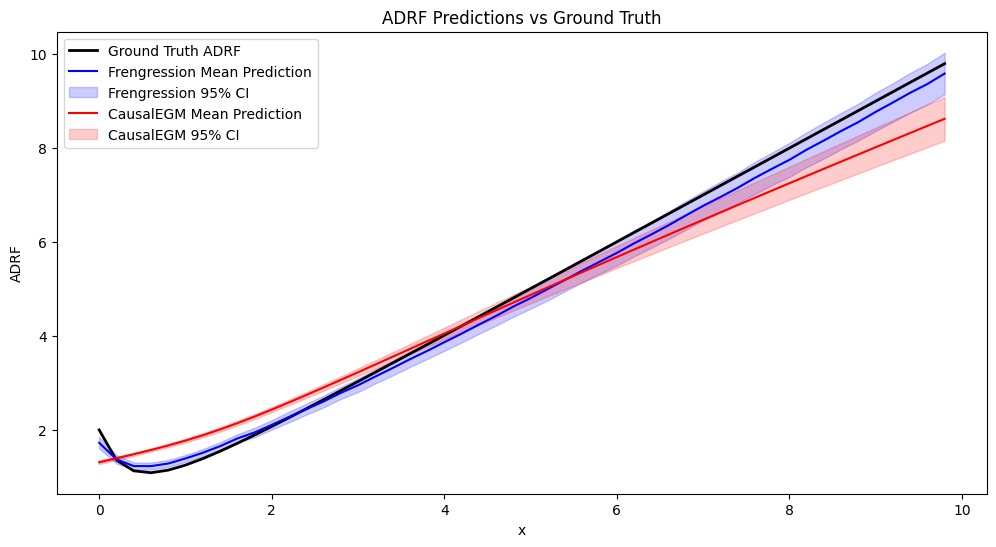

Frengression Average RMSE over 30 reps: 0.5937
Frengression Average MAPE over 30 reps: 0.1094
CausalEGM Average RMSE over 30 reps: 0.6409
CausalEGM Average MAPE over 30 reps: 0.1348


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm


params = {"dataset": "Sim_Hirano_Imbens",
"output_dir": './',
'v_dim': 200,
"z_dims": [2,2,2,4],
"x_min": 0,
"x_max": 3,
"lr": 0.0001,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

# Set up the range of x values
x_vals = np.arange(0, 10, 0.2)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

# Number of repetitions
nrep = 30
n_tr = 2000
n_p = 1000
num_iters = 4000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lists to store predictions and error metrics
frengression_preds = []
causalegm_preds = []
frengression_rmses = []
frengression_mapes = []
causalegm_rmses = []
causalegm_mapes = []

# Ground truth ADRF values
ground_truth_adrf = Sim_Hirano_Imbens_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data
    x_train, y_train, z_train = Sim_Hirano_Imbens_sampler(
        N=n_tr, v_dim=200, seed=1024 + rep, batch_size=n_tr
    ).load_all()
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)

    # Initialize and train Frengression model
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=400,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model
    fr_pred = fr_model.predict_causal(
        x_tensor, target="mean", sample_size=1000
    ).detach().cpu().numpy().reshape(-1)
    frengression_preds.append(fr_pred)

    # Compute RMSE and MAPE for Frengression model
    fr_rmse = rmse(fr_pred, ground_truth_adrf)
    fr_mape = mape(fr_pred, ground_truth_adrf)
    frengression_rmses.append(fr_rmse)
    frengression_mapes.append(fr_mape)

    # Initialize and train CausalEGM model
    # Assuming CausalEGM requires similar data inputs
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train, y_train, z_train], n_iter=1000, verbose=False)

    # Predict using CausalEGM model
    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    causalegm_preds.append(cegm_pred)

    # Compute RMSE and MAPE for CausalEGM model
    cegm_rmse = rmse(cegm_pred, ground_truth_adrf)
    cegm_mape = mape(cegm_pred, ground_truth_adrf)
    causalegm_rmses.append(cegm_rmse)
    causalegm_mapes.append(cegm_mape)

# Convert prediction lists to NumPy arrays for easier manipulation
frengression_preds = np.array(frengression_preds)
causalegm_preds = np.array(causalegm_preds)

# Compute mean and 95% confidence intervals
fr_mean_pred = frengression_preds.mean(axis=0)
fr_std_pred = frengression_preds.std(axis=0)
fr_ci_upper = fr_mean_pred + 1.96 * fr_std_pred / np.sqrt(nrep)
fr_ci_lower = fr_mean_pred - 1.96 * fr_std_pred / np.sqrt(nrep)

cegm_mean_pred = causalegm_preds.mean(axis=0)
cegm_std_pred = causalegm_preds.std(axis=0)
cegm_ci_upper = cegm_mean_pred + 1.96 * cegm_std_pred / np.sqrt(nrep)
cegm_ci_lower = cegm_mean_pred - 1.96 * cegm_std_pred / np.sqrt(nrep)

# Plotting the results
plt.figure(figsize=(12, 6))

# Ground truth ADRF
plt.plot(x_vals, ground_truth_adrf, label='Ground Truth ADRF', color='black', linewidth=2)

# Frengression predictions
plt.plot(x_vals, fr_mean_pred, label='Frengression Mean Prediction', color='blue')
plt.fill_between(x_vals, fr_ci_lower, fr_ci_upper, color='blue', alpha=0.2, label='Frengression 95% CI')

# CausalEGM predictions
plt.plot(x_vals, cegm_mean_pred, label='CausalEGM Mean Prediction', color='red')
plt.fill_between(x_vals, cegm_ci_lower, cegm_ci_upper, color='red', alpha=0.2, label='CausalEGM 95% CI')

plt.xlabel('x')
plt.ylabel('ADRF')
plt.title('ADRF Predictions vs Ground Truth')
plt.legend()
plt.show()

# Print average RMSE and MAPE for both models
print(f"Frengression Average RMSE over {nrep} reps: {np.mean(frengression_rmses):.4f}")
print(f"Frengression Average MAPE over {nrep} reps: {np.mean(frengression_mapes):.4f}")

print(f"CausalEGM Average RMSE over {nrep} reps: {np.mean(causalegm_rmses):.4f}")
print(f"CausalEGM Average MAPE over {nrep} reps: {np.mean(causalegm_mapes):.4f}")


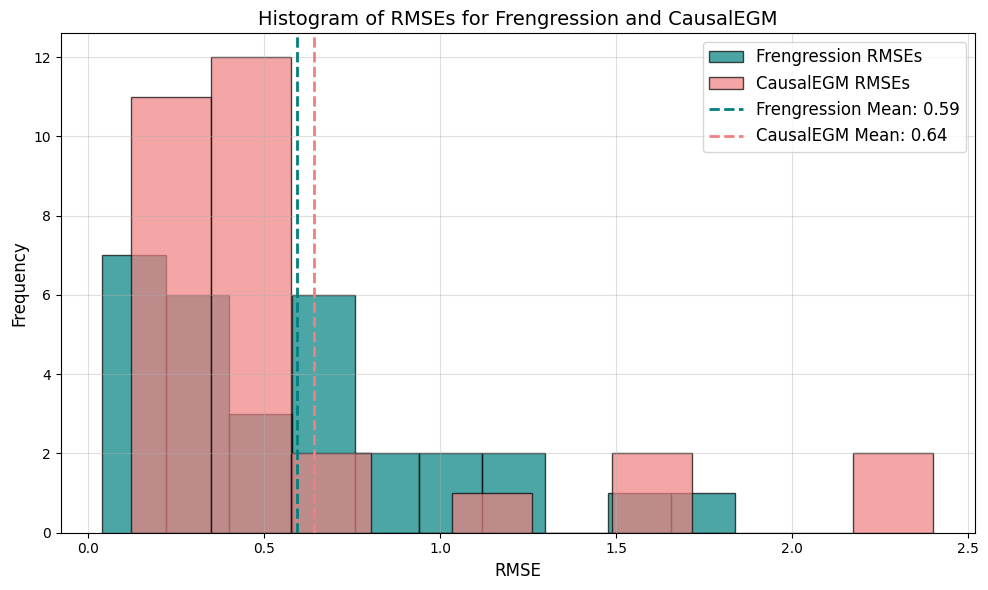

In [ ]:
# Create histograms
plt.figure(figsize=(10, 6))

# Frengression RMSEs
plt.hist(frengression_rmses, bins=10, alpha=0.7, label='Frengression RMSEs', color='teal', edgecolor='black')

# CausalEGM RMSEs
plt.hist(causalegm_rmses, bins=10, alpha=0.7, label='CausalEGM RMSEs', color='lightcoral', edgecolor='black')

# Add annotations
plt.axvline(np.mean(frengression_rmses), color='teal', linestyle='dashed', linewidth=2, label=f'Frengression Mean: {np.mean(frengression_rmses):.2f}')
plt.axvline(np.mean(causalegm_rmses), color='lightcoral', linestyle='dashed', linewidth=2, label=f'CausalEGM Mean: {np.mean(causalegm_rmses):.2f}')

# Add title and labels
plt.title('Histogram of RMSEs for Frengression and CausalEGM', fontsize=14)
plt.xlabel('RMSE', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)

# Show the plot
plt.tight_layout()
plt.show()
